In [146]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import xapian
import nltk
import os
import io
from zipfile import ZipFile
import shutil
import csv
import re
import pandas as pd
import numpy as np
import json
import spacy 
import en_core_web_lg
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords
from nltk.chunk import conlltags2tree, tree2conlltags
from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
vectorizer = DictVectorizer()
nlp_large = en_core_web_lg.load() 

import en_vectors_web_lg
nlpvec = en_vectors_web_lg.load() 


In [366]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib
from joblib import dump, load

/Users/indah/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:

dbpath = "index_V6_nostop"

print("### GET TRAINING DATA ###")

train_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "train.json")
with open(train_path) as json_file:  
    train = json.load(json_file)

rowid = list(train.keys())
claim = []
label = []
evidence = []
for idx in rowid:
    claim.append(train[idx]['claim'])
    label.append(train[idx]['label'])
    evidence.append(train[idx]['evidence'])
    
len_claim = len(claim)    

print("training set:",len_claim)

print("### CONNECT TO INDEX ###")

def getstopper():
    stopper = xapian.SimpleStopper()
    for s in stopwords.words('english'):
        stopper.add(s)
    return stopper

def get_doc_id(match):
    for term in match.document.termlist():
        term = term.term.decode("utf-8") 
        m = re.match("Q(.*)", term)
        if m:
            return m[1]
    return None

# Prepare enquiry object

# Open the database we're going to search.
db = xapian.Database(dbpath)

# Set up a QueryParser with a stemmer and suitable prefixes
queryparser = xapian.QueryParser()
queryparser.set_stemmer(xapian.Stem("en"))
queryparser.set_stemming_strategy(queryparser.STEM_SOME)
queryparser.set_stopper(getstopper())
queryparser.add_prefix('keywords', 'K')

# Use an Enquire object on the database to run the query
enquire = xapian.Enquire(db)

def get_match(query,pagesize):
    query = queryparser.parse_query(query)
    enquire.set_query(query)
    matches = enquire.get_mset(0, pagesize)

    query_results = []
    #doc_title = []
    for match in matches:
        result = dict(
            found_doc = get_doc_id(match),
            rank = match.rank + 1, 
            percent = match.percent,
            weight = match.weight,
            docid = match.docid,
            text = match.document.get_data()
        )
        query_results.append(result)
        #doc_title.append(get_doc_id(match))
    return query_results #, doc_title

print("### NORMALIZATION ###")
    
def replace_punctuation(sentence):
    text = re.sub(r"(-LRB-|-LSB-|-RSB-|-RRB-|-COLON-|-lrb-|-lsb-|-rsb-|-rrb-|-colon-|``|'')*", "", sentence)
    text = re.sub(r"[`']+", " ", text)
    text = re.sub(r"[.,:;]*", "", text)
    text = text.replace("_"," ")
    text = text.replace("\\n","")
    text = text.strip()
    return text

def get_entity(document):
    doc = nlp_large(document)
    combine_entity = ''
    for entity in doc.ents:
        combine_entity = combine_entity + ' ' + str(entity)
    return combine_entity.strip()

def remove_stopwords(wordlist):
    filtered = [w for w in wordlist if w not in stopwords.words('english')]
    return filtered

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma  

def normalize_counter(document):  
    entities = get_entity(document)
    combine = document + ' ' + entities
    filtered = nltk.word_tokenize(combine)
    #filtered = remove_stopwords(filtered)
    for i in range(len(filtered)):
         filtered[i] = lemmatize(filtered[i].lower())
    word_counter = Counter(filtered)
    return word_counter 

def get_entity_list(document):
    doc = nlp_large(document)
    combine_entity = set()
    for entity in doc.ents:
        combine_entity.add(str(entity).lower().strip())
    return list(combine_entity)

def capital(text):
    result = re.findall(r"[A-Z][\S]+", text)
    result = [w.lower() for w in result]
    return result

def entity_capital(text):
    text = replace_punctuation(text)
    entities = get_entity_list(text)
    capitals = capital(text)
    entities.extend(capitals)
    entities = set(entities)
    entities = remove_stopwords(entities)
    return entities

def document_entities(result):
    docid = result['found_doc']
    pattern = re.compile(r"("+docid+"\s\d+\s)")
    doc = result['text'].decode("utf-8")
    doc = replace_punctuation(doc)
    doc = re.sub(pattern,"",doc)
    doc_entities = entity_capital(doc)
    return doc_entities

def intersection(list1, list2): 
    list3 = [value for value in list1 if value in list2] 
    return len(list3) 

def similarity_list(claim, wiki):     
    claim_wiki = [' '.join(claim).strip(),' '.join(wiki).strip()]
    vectorizer = CountVectorizer(claim_wiki)
    try:
        vectorizer.fit(claim_wiki)
        vectors = [vector for vector in vectorizer.transform(claim_wiki).toarray()]
        similarity = cosine_similarity(vectors)[1][0]
    except:
        similarity = 0
    return similarity


In [170]:
def get_doc_match(doc_list, pagesize):
    #Search within selected document list
    #claim_text ="Nacional"
    #doc_list = ["C.D._Nacional"]#"Robert_J.O'Neill-LRB-U.S._Navy_SEAL-RRB-"]#'1994–95_Venezuelan_Primera_División_season','Lara_Croft-COLON-_Tomb_Raider']
    qp = xapian.QueryParser()
    
    doc_queries = ['Q{}'.format(rated) for rated in doc_list] #this could to ensure the exact full id text is taken
    doc_query = xapian.Query(xapian.Query.OP_OR, doc_queries)
    #print(doc_query)
    # setup the enquire object to perform the query
    #enq = xapian.Enquire(db)
    # set the weighting model for ranking
    #enq.set_weighting_scheme(xapian.BM25Weight())
    #enq.set_weighting_scheme(xapian.TfIdfWeight())
    enquire.set_query(doc_query)

    # iterate through the matched set and display the stored json dup
    #print("Doc Level Results:\n")
    #enquire.set_query(query)
    matches = enquire.get_mset(0, pagesize)
    
    query_results = []
    doc_title = []
    for match in matches:
        result = dict(
            found_doc = get_doc_id(match),
            rank = match.rank + 1, 
            percent = match.percent,
            weight = match.weight,
            docid = match.docid,
            text = match.document.get_data()
        )
        query_results.append(result)
    return query_results



In [95]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from allennlp.predictors.predictor import Predictor
predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/decomposable-attention-elmo-2018.02.19.tar.gz")


/Users/indah/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
Did not use initialization regex that was passed: .*token_embedder_tokens\._projection.*weight


In [158]:
def textual_entailment(claim,wiki):
    te = predictor.predict(claim,wiki)
    if te['label_probs'][0] > 0.5:
        print("SUPPORT:", te['label_probs'][0])
        return 'SUPPORTS'
    elif te['label_probs'][1] > 0.5:
        print('REFUTES:', te['label_probs'][1])
        return 'REFUTES'
    else:
        print('NOT ENOUGH INFO:', te['label_probs'][2])
        return 'NOT ENOUGH INFO'

In [148]:
def replace_punctuation_old(sentence):
    #text = sentence.decode("utf-8").lower()
    text = re.sub(r"(-LRB-|-LSB-|-RSB-|-RRB-|-COLON-|-lrb-|-lsb-|-rsb-|-rrb-|-colon-)*", "", sentence)
    text = re.sub(r"[.,:;`']*", "", text)
    text = text.replace("\\n","")
    return text
def replace_punctuation(sentence):
    text = re.sub(r"(-LRB-|-LSB-|-RSB-|-RRB-|-COLON-|-lrb-|-lsb-|-rsb-|-rrb-|-colon-|``|'')*", "", sentence)
    text = re.sub(r"[`']+", " ", text)
    text = re.sub(r"[.,:;]*", "", text)
    text = text.replace("_"," ")
    text = text.replace("\\n","")
    text = text.strip()
    return text

def get_entity(document):
    doc = nlp_large(document)
    combine_entity = ''
    for entity in doc.ents:
        combine_entity = combine_entity + ' ' + str(entity)
    return combine_entity.strip()

def get_entity_list(document):
    doc = nlp_large(document)
    combine_entity = set()
    entity = [str(ent.text).lower().strip() for ent in doc.ents]
    combine_entity = set(entity)
    return list(combine_entity)

def remove_stopwords(wordlist):
    filtered = [w for w in wordlist if w not in stopwords.words('english')]
    return filtered

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma  

def normalize_counter(document):  
    entities = get_entity(document)
    combine = document + ' ' + entities
    filtered = nltk.word_tokenize(combine)
    #tokenize and remove stop words
    filtered = remove_stopwords(filtered)
    for i in range(len(filtered)):
         filtered[i] = lemmatize(filtered[i].lower())
    word_counter = Counter(filtered)
    return word_counter 

def get_match2(query,pagesize):
    query = queryparser.parse_query(query)
    enquire.set_query(query)
    matches = enquire.get_mset(0, pagesize)
    
    query_results = []
    doc_title = []
    for match in matches:
        result = dict(
            found_doc = get_doc_id(match),
            rank = match.rank + 1, 
            percent = match.percent,
            weight = match.weight,
            docid = match.docid,
            text = match.document.get_data()
        )
        query_results.append(result)
        doc_title.append(get_doc_id(match))
    return query_results , doc_title

def similarity(claim, wiki):     
    claim_wiki = [claim,wiki]
    vectorizer = CountVectorizer(claim_wiki)
    try:
        vectorizer.fit(claim_wiki)
        vectors = [vector for vector in vectorizer.transform(claim_wiki).toarray()]
        similarity = cosine_similarity(vectors)[1][0]
    except:
        similarity = 0
    return similarity


def get_text_embedding(text):
    return nlpvec(text).vector

def get_te_scores(claim, text):
    prediction = predictor.predict(
       hypothesis = claim,
       premise = text
    )
        
    ContradictionScore = prediction['label_probs'][0]
    EntailmentScore = prediction['label_probs'][1]
    NeutralScore = prediction['label_probs'][2]
    return ContradictionScore, EntailmentScore, NeutralScore
    
def get_sent_similarity(claim, text):
    clm = nlpvec(claim)
    sent = nlpvec(text)
    return clm.similarity(sent)


In [172]:
len(claim_embed)

14997

In [185]:
conta_score_dict = {}
for i in range(len(conta_score)):
    conta_score_dict[i] = conta_score[i]

ent_score_dict = {}
for i in range(len(ent_score)):
    ent_score_dict[i] = ent_score[i]
    
nut_core_dict = {}
for i in range(len(nut_core)):
    nut_core_dict[i] = nut_core[i]
    
similarity_score_dict = {}
for i in range(len(similarity_score)):
    similarity_score_dict[i] = similarity_score[i]

In [187]:
with open(conta_score_path, 'w') as outfile:
    json.dump(conta_score_dict, outfile, indent = 4)
with open(ent_score_path, 'w') as outfile:
    json.dump(ent_score_dict, outfile,  indent = 4)
with open(nut_core_path, 'w') as outfile:
    json.dump(nut_core_dict, outfile,  indent = 4)
with open(similarity_score_path, 'w') as outfile:
    json.dump(similarity_score_dict, outfile,  indent = 4)     

In [300]:
doc_not_found = {}
for i in range(len(doc_not_found)):
    doc_not_found[i] = document_not_found[i]

with open('doc_not_found_test_data.json', 'w') as f:
    json.dump(doc_not_found, f, indent = 4)

In [241]:
Counter(tlabel)

Counter({'NOT ENOUGH INFO': 7779, 'REFUTES': 3218, 'SUPPORTS': 4000})

In [ ]:
label_textual_entailment = []
for i in range(len(conta_score)):
    if conta_score[i] > 0.5 and ent_score[i] < 0.5 and nut_core[i] < 0.5:
        label_textual_entailment.append('SUPPORTS')
    elif conta_score[i] < 0.5 and ent_score[i] > 0.5 and nut_core[i] < 0.5:
        label_textual_entailment.append('REFUTES')
    else:
        label_textual_entailment.append('NOT ENOUGH INFO')
    print(i,conta_score[i] ,ent_score[i],  nut_core[i] )

In [201]:
Counter(label_textual_entailment)

Counter({'NOT ENOUGH INFO': 4318, 'SUPPORTS': 8983, 'REFUTES': 1696})

In [275]:
label_textual_entailment2 = []
for i in range(len(conta_score)):
    if conta_score[i] > 0.98 and ent_score[i] < 0.1 and nut_core[i] < 0.1:
        label_textual_entailment2.append('SUPPORTS')
    elif conta_score[i] < 0.25 and ent_score[i] >= 0.5 and nut_core[i] < 0.25:
        label_textual_entailment2.append('REFUTES')
    else:
        label_textual_entailment2.append('NOT ENOUGH INFO')

In [279]:
Counter(label_textual_entailment2)

Counter({'NOT ENOUGH INFO': 10488, 'SUPPORTS': 3290, 'REFUTES': 1219})

In [285]:
NEI_NEI2 = 0
SPT_NEI2 = 0
RFT_NEI2 = 0
NEI_SPT2 = 0
NEI_RFT2 = 0
SPT_SPT2 = 0
RFT_RFT2 = 0
SPT_RFT2 = 0
RFT_SPT2 = 0
combine_prediction2 = []
for i in range(len(label_textual_entailment2)):
    if tlabel[i] == 'NOT ENOUGH INFO' and label_textual_entailment2[i] == 'NOT ENOUGH INFO':
        NEI_NEI2 += 1
        combine_prediction2.append(label_textual_entailment2[i])
    elif tlabel[i] == 'SUPPORTS' and label_textual_entailment2[i] == 'NOT ENOUGH INFO':
        SPT_NEI2 += 1
        combine_prediction2.append(tlabel[i])
    elif tlabel[i] == 'REFUTES' and label_textual_entailment2[i] == 'NOT ENOUGH INFO':
        RFT_NEI2 += 1    
        combine_prediction2.append(tlabel[i])
    elif tlabel[i] == 'NOT ENOUGH INFO' and label_textual_entailment2[i] == 'SUPPORTS':
        NEI_SPT2 += 1
        combine_prediction2.append(label_textual_entailment2[i])
    elif tlabel[i] == 'NOT ENOUGH INFO' and label_textual_entailment2[i] == 'REFUTES':
        NEI_RFT2 += 1
        combine_prediction2.append(label_textual_entailment2[i])
    elif tlabel[i] == 'SUPPORTS' and label_textual_entailment2[i] == 'SUPPORTS':
        SPT_SPT2 += 1   
        combine_prediction2.append(label_textual_entailment2[i])
    elif tlabel[i] == 'REFUTES' and label_textual_entailment2[i] == 'REFUTES':
        RFT_RFT2 += 1      
        combine_prediction2.append(label_textual_entailment2[i])
    elif tlabel[i] == 'SUPPORTS' and label_textual_entailment2[i] == 'REFUTES':
        SPT_RFT2 += 1   
        combine_prediction2.append(label_textual_entailment2[i])
    elif tlabel[i] == 'REFUTES' and label_textual_entailment2[i] == 'SUPPORTS':
        RFT_SPT2 += 1 
        combine_prediction2.append(tlabel[i])

In [281]:
Counter(tlabel)

Counter({'NOT ENOUGH INFO': 7779, 'REFUTES': 3218, 'SUPPORTS': 4000})

In [297]:
Counter(combine_prediction2)

Counter({'NOT ENOUGH INFO': 4978, 'REFUTES': 4053, 'SUPPORTS': 5966})

In [290]:
len(combine_prediction2)

14997

In [288]:
print("Same NEI:",NEI_NEI2)
print("Support - NEI:",SPT_NEI2)
print("Refute - NEI:",RFT_NEI2)
print("NEI - Support:", NEI_SPT2)
print("NEI - Refute:", NEI_RFT2)
print("Same Support:",SPT_SPT2)
print("Same Refute:",RFT_RFT2)
print("Support - Refute:",SPT_RFT2)
print("Refute - Support:",RFT_SPT2)

Same NEI: 4978
Support - NEI: 3137
Refute - NEI: 2373
NEI - Support: 2139
NEI - Refute: 662
Same Support: 690
Same Refute: 384
Support - Refute: 173
Refute - Support: 461


In [293]:
len(rowid)

145449

In [296]:
test_set_predictions4 = {}
for i in range(len(trowid)):
    test_set_predictions4[trowid[i]] = {"claim": tclaim[i], "label":combine_prediction2[i], "evidence":tevidence[i]}
with open('testoutput4.json', 'w') as f:
    json.dump(test_set_predictions4, f, indent = 4)

In [247]:
2571 + 517 + 130

3218

In [245]:
NEI_NEI + SPT_NEI + RFT_NEI + NEI_SPT + NEI_RFT + SPT_SPT + RFT_RFT + SPT_RFT + RFT_SPT

14997

In [298]:
def get_nouns(document):
    doc = nlp_large(document)
    combine_noun = set()
    noun = [str(noun).lower().replace(" ","_").strip() for noun in doc.noun_chunks]
    combine_noun = set(noun)
    return ' '.join(combine_noun)

def get_entity_similarity(claim, text):
    clm = get_entity(claim)
    sent = get_entity(text)
    return get_sent_similarity(clm,sent)

def get_noun_similarity(claim, text):
    clm = get_nouns(claim)
    sent = get_nouns(text)
    return get_sent_similarity(clm,sent)

In [301]:
%%time
incomplete_claim2 = set()
document_not_found2 = set()
# features = defaultdict(Counter)
# claim_embed = dict()
# evidences_embed = dict()
# conta_score = dict()
# ent_score = dict()
# nut_core  = dict()
# similarity_score = dict()
entity_similarity_score = dict()
noun_similarity_score = dict()

# features_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "features1.json")
# claim_embed_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "claim_embed.json")
# evidences_embed_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "evidences_embed.json")
# conta_score_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "conta_score.json")
# ent_score_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "ent_score.json")
# nut_core_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "nut_core.json")
# similarity_score_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "similarity_score.json")
entity_similarity_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "entity_similarity_score.json")
noun_similarity_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "noun_similarity_score.json")


for i in range(len(tclaim)):
    norm_claim = replace_punctuation(tclaim[i]).lower()
    norm_text = ''
    for j in range(len(tevidence[i])):
        evidence_id = tevidence[i][j][0]#.lower()
        #fetch from xapian the document matching the evidence name
        #print("get_doc_match([evidence_id],1)",[evidence_id])
        results = get_doc_match([evidence_id],1)
        evidence_id = evidence_id.lower()
        #print(evidence_id)
        #print("---------")
        #print(i, evidence[i], results[0]['found_doc'].lower())
        if results != []:
            #make sure the document found matches the evidence we picked from training set
            if evidence_id == results[0]['found_doc'].lower():
                #get sentence Id from traning set
                evidence_sent = str(tevidence[i][j][1])
                sentence_id = evidence_id + ' ' + evidence_sent
                #take sentence text from xapian for selected doc
                text = results[0]['text'].decode("utf-8").lower()
                #print("full text",text)
                index = text.find(sentence_id)
                if index != -1:
                    lenid = len(sentence_id)
                    if text[index+lenid:].find(evidence_id) != -1:
                        textsplit = replace_punctuation(text[index+lenid:].split(evidence_id, maxsplit=1)[0])  
                    else:
                        textsplit = replace_punctuation(text[index+lenid:])
                    norm_text += textsplit + ' '
                    #print("???>>>textsplit",textsplit)
                    combine = norm_claim + ' ' + textsplit
                    counter_combine = normalize_counter(combine)

                    features[i].update(counter_combine)

                else:
                    document_not_found2.add(evidence_id)
                    incomplete_claim2.add(i)      
            else:
                document_not_found2.add(evidence_id)
                incomplete_claim2.add(i)
        else:
            document_not_found2.add(evidence_id)
            incomplete_claim2.add(i)


    #TODO here extract featrues at claim level
#         print("||||norm_claim",norm_claim)
#         print("||||norm_text",norm_text,"\n\n")
#     claim_embed[i] = get_text_embedding(norm_claim)
#     evidences_embed[i] = get_text_embedding(norm_text)
#     cont_score, e_score, n_core = get_te_scores(norm_claim, norm_text)
#     conta_score[i] = cont_score
#     ent_score[i] = e_score
#     nut_core[i] = n_core
#     sim = get_sent_similarity(norm_claim, norm_text)
#     similarity_score[i] = sim
    
    entity_similarity_score[i] = get_entity_similarity(norm_claim, norm_text)
    noun_similarity_score[i] = get_noun_similarity(norm_claim, norm_text)        
    print(i, entity_similarity_score[i], noun_similarity_score[i])
        
#         print("||||similarity_score",similarity_score[i])
#         print("||||NLPSCORE",cont_score, e_score, n_core)
#         print("|||Label",tlabel[i])
#         print("|||evidence",tevidence[i])
#         print("||||||||||||||||||||||||||||||||||")

# with open(features_path, 'w') as outfile:
#     json.dump(features, outfile)
# with open(claim_embed_path, 'w') as outfile:
#     json.dump(claim_embed, outfile)
# with open(conta_score_path, 'w') as outfile:
#     json.dump(conta_score, outfile)
# with open(evidences_embed_path, 'w') as outfile:
#     json.dump(evidences_embed, outfile)
# with open(ent_score_path, 'w') as outfile:
#     json.dump(ent_score, outfile)
# with open(nut_core_path, 'w') as outfile:
#     json.dump(nut_core, outfile)
# with open(similarity_score_path, 'w') as outfile:
#     json.dump(similarity_score, outfile)

with open(entity_similarity_path, 'w') as outfile:
    json.dump(entity_similarity_score, outfile)
with open(noun_similarity_path, 'w') as outfile:
    json.dump(noun_similarity_score, outfile)
    
# doc_not_found = {}
# for i in range(len_doc_not_found):
#     doc_not_found[i] = document_not_found[i]

# with open('doc_not_found.json', 'w') as f:
#     json.dump(doc_not_found, f, indent = 4)

0 0.9908019252259642 0.27498911433119266
1 0.4948162430561763 0.5799045636802288
2 1.0 0.3499106457171254
3 0.8629623879819395 0.5648101341265487


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4 0.0 0.6333314339864672


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5 0.0 0.0
6 1.0 0.30802168081805154


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7 0.0 0.0
8 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9 0.0 0.5466829475148082
10 0.9684077387630761 0.9999999863240687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11 0.0 0.0
12 1.0 0.6332875396379755
13 1.0 0.817241284245457
14 1.0 0.487415868737491
15 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


16 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


17 0.0 0.0
18 0.0 0.278438800755772


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


19 0.735689576975262 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


20 0.0 0.0
21 1.0000000482502145 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


22 0.0 0.0
23 1.0 0.001615330395125014
24 1.0 1.0000000452103528


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


25 0.8738671114696648 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


26 0.727693630259056 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


27 0.7962735515909641 0.0
28 0.87859851508899 0.5221983862885529


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


29 0.7592602244295106 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


30 0.8958709178733758 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


31 0.8683575487835842 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


32 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


33 1.0 0.0
34 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


35 1.0 0.0
36 0.0 0.4335869874387939


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


37 0.6449680210379786 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


38 0.5372756307487819 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


39 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


40 0.1814958268972781 0.0
41 1.0 0.6520343191895359
42 1.0 0.6952748116162825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


43 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


44 0.0 0.1779035312137148


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


45 0.0 0.0
46 0.9382239766976592 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


47 0.9478253784107175 0.0
48 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


49 0.6480171490435752 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


50 0.0 0.8717808947184825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


51 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


52 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


53 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


54 0.0 0.49439473224826325
55 0.3486275511932687 0.23802340048532106
56 1.0 0.5212017931169924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


57 0.8289950194711778 0.0
58 0.5320463751037839 0.2244461213584209


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


59 0.2519374301197047 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


60 0.0 0.0
61 0.7312947772669088 0.6837332928096614


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


62 0.0 0.3259979920611387
63 0.8141649586156527 0.630396510813404


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


64 0.0 0.0
65 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


66 0.0 0.6036110560217102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


67 1.0 0.0
68 1.0 0.8302329958228412
69 1.0 0.822930743332476
70 0.21920559552177316 0.6882975327964306


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


71 0.8920516260131631 0.0
72 1.0 0.030772367533754157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


73 0.04045703604433463 0.0
74 0.0 0.6690325446423032
75 0.6125556183699262 0.4788094176149455


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


76 0.0 0.5904861810768588


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


77 0.0 0.5904861810768588


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


78 0.0 0.5904861810768588
79 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


80 1.0 0.6899800783237862


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


81 0.0 0.31551432871623786
82 0.6068278662178013 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


83 0.0 0.4460141869042103


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


84 0.0 0.0
85 0.831016070507439 0.8028625577148426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


86 0.0 0.0
87 0.4748079872367567 0.31880603999713963
88 0.9124589955019798 0.8410999619879315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


89 0.7606709260362415 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


90 0.0 0.4898330753738216
91 0.49215666382707596 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


92 0.0 0.5830947802819753
93 0.6717932673675945 0.5382886621066262


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


94 0.0 0.0
95 0.9669048105103027 0.6747244759693111


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


96 0.0 0.0
97 0.28520395496535744 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


98 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


99 0.0 0.0
100 0.5131156374983875 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


101 0.13293579267194675 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


102 0.0 0.0
103 0.6151008946982119 0.05397125907604098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


104 0.9097350538351404 0.0
105 0.23533438544074534 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


106 0.0 0.0
107 0.7370833562787846 0.5030419670105867
108 0.7896293791737887 0.11953930627988424
109 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


110 0.0 0.15143160548234938
111 1.0 0.7595089471762319


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


112 0.0 0.0
113 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


114 0.0 0.17819116713576363
115 0.32714822090863666 0.0
116 0.09577309440356738 0.6008087233210304
117 0.0 0.3393841809045779


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


118 0.0 0.0
119 0.17478173364608787 0.0
120 0.49213763125532417 0.6550736845942107
121 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


122 1.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


123 0.8780962065990453 0.0
124 0.8633797377573214 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


125 0.0 0.0
126 0.9352970404944264 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


127 1.0 -0.13508314903106539


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


128 0.0 0.0
129 0.6995822784506679 0.6849657446873519


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


130 0.0 0.0
131 0.0 1.0000000171582244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


132 0.7417836261300741 0.41421278351363106


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


133 0.0 0.8259684914322136
134 0.0 0.6081597045779537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


135 0.0 0.6229506375938031


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


136 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


137 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


138 0.0 0.0
139 1.0 0.028948863848442922
140 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


141 0.8782263421467656 0.0
142 0.47413544438974137 0.21906699457944975
143 0.8223973821083311 0.3757196302345655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


144 0.0 0.783719750213778
145 0.4582428915763663 -0.2265931761400698


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


146 0.0 0.5600961891753001
147 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


148 0.0 0.0
149 0.3508983741559138 0.06030919772956874
150 1.0 -0.04400863913109542
151 0.0 0.5661778990079135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


152 0.25116301572078414 0.25762521012884126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


153 0.0697583084790355 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


154 0.0 0.6833548651151558


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


155 0.018959362172159648 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


156 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


157 0.22834540509653484 0.0
158 0.007598559811879908 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


159 0.0 0.7724481411168987
160 0.47873998682246405 0.3491296723493821


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


161 0.0 0.4136954896102513


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


162 0.0 0.0
163 0.0 0.9999999648736344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


164 0.0 0.0
165 0.5252259932544482 -0.0392362336386448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


166 0.8552593050413296 0.0
167 0.7537663445446696 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


168 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


169 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


170 0.0 0.0
171 0.0 0.10405762822948181
172 0.10751061045284546 0.7797014103655154
173 0.7813660070496844 0.9999999357508867
174 0.8767165501624172 0.21766739598985527
175 1.0 0.17954650476694345
176 0.23004286997353218 0.9999999607953941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


177 0.0 0.0
178 0.7810917391889014 0.6246179940051307


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


179 0.6958142612857653 0.0
180 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


181 0.7677462068517553 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


182 0.7677462068517553 0.0
183 0.44975541053700463 0.6625103899147571


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


184 0.0 0.6481385915611827
185 0.0 1.0000000099476454


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


186 1.0 0.0
187 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


188 0.0 0.587717576847083
189 0.6628430818008565 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


190 0.5903260589049639 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


191 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


192 0.0 0.0
193 0.0 0.0
194 0.28693902777370367 0.3104682910120051
195 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


196 0.0 0.0
197 0.7923601605291819 0.5100177500197862
198 0.5522505346099493 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


199 0.40619790525634536 0.0
200 0.25817254632115 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


201 0.4743845289500331 0.0
202 0.9999999847678376 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


203 0.16890349258670137 0.0
204 0.0 0.06686396743446849


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


205 0.8432925469026128 0.0
206 0.5059728279010711 0.2349680421390574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


207 0.0 -0.005602138164787145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


208 0.7306245205228344 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


209 0.7791884340203381 0.0
210 0.4450203381250196 0.2295322589014634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


211 0.2168943540101308 0.8021385697348702
212 0.0 0.4790257005534438
213 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


214 0.0 0.0
215 0.9683320795424966 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


216 0.0 0.0
217 0.18702648942051764 0.25120774910701227
218 0.8031551222048624 0.1488258712358076
219 0.8633910912158542 0.680511871689848


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


220 0.0 0.2699370962067851
221 0.7659756412443004 0.16780297952886006


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


222 0.8268179551506722 0.0
223 0.6645091257033489 0.33361266248639
224 0.844514219118973 0.823516230216074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


225 0.0 0.0
226 0.3796625849851258 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


227 0.6533962315397969 0.44844366136120994


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


228 0.0 0.0
229 0.8508170718616744 0.5315354020171176


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


230 0.8618055902147891 0.0
231 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


232 0.5004850536043268 0.0
233 0.0 -0.02914564295455921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


234 0.0 0.6920561340662149


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


235 1.0 0.0
236 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


237 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


238 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


239 0.0 0.18980747621187632
240 0.0 0.536653927815723


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


241 0.0 1.0000000626069905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


242 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


243 0.7646331308192484 0.0
244 0.0 0.5502861563034759
245 0.4904389941963255 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


246 0.0 0.0
247 0.6921792236957345 0.8130273569391957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


248 0.0 0.7685453382360238
249 0.0 0.7685453099651203


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


250 0.8690736258235319 0.0
251 1.0 0.44528684910485666
252 -0.006053466611279703 0.1561092610391442
253 0.6970756440898408 0.2865069558082984


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


254 1.0 0.0
255 0.5051850179582686 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


256 0.0 0.792214272661004
257 0.7862462522079494 -0.013894842947048762
258 0.8183763394791762 0.8410136100083643


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


259 1.0 0.0
260 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


261 0.0 0.7208352857031303
262 0.8152984273760547 0.47375658927584785
263 0.9432054490487477 0.4865490405328633
264 0.5274406058042788 0.4158854254353053


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


265 0.0 0.0
266 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


267 0.8679716696354762 0.6388095500760295


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


268 0.0 0.6639815302411661
269 0.7644538879046185 0.15225131139645834


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


270 0.6769766753504504 0.0
271 0.8238284077524548 0.08457074774050082


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


272 0.0 0.6475982414282528


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


273 0.8383485865436545 0.0
274 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


275 0.0 0.0
276 0.8534783382270361 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


277 0.0 0.0
278 0.3030909631143915 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


279 0.8848637213671907 0.9007934591071439
280 0.8558632970841423 0.5426900942658468


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


281 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


282 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


283 0.0 0.632417186748521


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


284 0.0 0.0
285 0.0 0.5904808979154388


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


286 0.8654613062917252 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


287 0.8251948510288806 0.0
288 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


289 0.5231141165020428 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


290 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


291 0.0 0.0
292 1.0 0.6816954585818545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


293 0.7067924539478646 0.0
294 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


295 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


296 0.0 0.5437128451282902
297 1.0 0.412206692503859


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


298 0.0 0.678670308645295
299 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


300 0.7227497060047254 0.0
301 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


302 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


303 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


304 0.7122391893699886 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


305 0.0 0.0
306 1.0 1.0000000033602012
307 0.6643429640377705 0.5124985682693561
308 0.8560468360482278 0.6891747843149727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


309 0.0 0.0
310 0.0517901621063656 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


311 0.0 0.012988031385800802
312 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


313 0.0 0.042577499125239164


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


314 0.0 0.5760569991373635
315 0.0 0.31230444806565505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


316 1.0 0.0
317 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


318 1.0 0.0
319 0.6593576343975435 0.0
320 1.0 0.3929055568792555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


321 0.08779932750648167 0.0
322 0.0 0.0
323 1.0 0.4829200254809179
324 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


325 1.0 0.0
326 0.16896231086304883 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


327 0.16896231086304883 0.0
328 0.16896231086304883 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


329 0.16896231086304883 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


330 0.0 0.0
331 0.36259995099714054 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


332 0.6247874067954337 0.0
333 0.918696765787806 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


334 0.8841216660554039 0.0
335 0.08255012903348347 0.681063515421253
336 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


337 1.0 0.0
338 0.0 0.8248481056359648


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


339 0.0 0.0
340 1.0 0.7653678040115365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


341 0.0 0.3272379224961958
342 0.21454127649554766 0.6314507505516239


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


343 0.9011471867253371 0.0
344 0.0 0.55397592459876
345 0.3192147245029926 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


346 0.7906209938690449 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


347 0.5116428074807899 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


348 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


349 0.0 0.0
350 0.9230165712190387 0.8905880933773451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


351 0.8961125631541105 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


352 0.7896643066815243 0.0
353 0.8334855006723265 0.7847084764119322


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


354 0.8984828216766303 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


355 0.8394144168640744 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


356 0.0 0.11991302033515595


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


357 0.0 -0.13145239723259694
358 0.37498217014258817 0.14717108232489934


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


359 0.0 0.0
360 0.3362871141871109 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


361 0.0 0.43670178737487964
362 1.0 0.17925944136685668
363 1.0 0.20804737264219594


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


364 0.9999999756437793 0.0
365 0.2576077493213036 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


366 0.9999999756437793 0.0
367 0.0 0.08625091312588933


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


368 0.9999999756437793 0.0
369 0.9999999756437793 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


370 0.9999999758590121 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


371 0.0 0.0
372 0.8668711966396605 0.15207844271345186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


373 0.8752151838532206 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


374 0.8798615907418149 0.0
375 0.8174388385577009 0.20676355495064347
376 0.8557741184318058 0.24830918261543466
377 0.0 0.7180696356830532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


378 0.0 0.4078347577101041
379 0.584262801134972 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


380 0.7636447912599285 0.0
381 0.7535786443168822 0.0
382 0.9063895370060852 0.7577012587678178
383 0.5892602554835508 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


384 0.0 0.0
385 0.5421297729065658 0.022016972140611355
386 0.7256180720202192 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


387 0.0 0.0
388 0.9117467993998027 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


389 0.0 0.0
390 0.4829409152768604 0.6850848814062221


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


391 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


392 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


393 1.0 0.0
394 0.3599555263747274 0.5949734983969965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


395 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


396 0.866771539373688 0.0
397 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


398 0.0 0.2441056070023043
399 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


400 0.0 0.0
401 0.5082496820527047 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


402 0.0 0.9215862805425356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


403 0.0 0.6303107946567328
404 0.0 0.7706862981204619


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


405 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


406 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


407 0.0 0.0
408 0.6361591000616885 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


409 0.8667983117095558 0.7577823382342047
410 0.9673816094721072 0.1992210355632567
411 1.0 0.8343298681297772


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


412 0.0 0.0
413 0.0 0.7665511737920193


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


414 0.5508460401057946 0.044132559089616975
415 0.9999999305524804 1.0000000091486843


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


416 0.8683575487835842 0.0
417 0.0 0.6829781312585569
418 0.8683575619825606 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


419 0.881243049338349 0.20092018257524014
420 0.9208559519179953 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


421 0.9739472768451277 0.9043713764649308
422 0.0 0.6582399612594549


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


423 0.8058449179132781 0.6570485290138465
424 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


425 0.9808042232842238 0.0
426 0.6810789689973884 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


427 1.0 0.0
428 0.4340841589204197 0.45060248546080556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


429 0.5881457667787121 0.0
430 1.0 -0.16171220354731927
431 0.0 0.39544434600539063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


432 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


433 0.0 0.0
434 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


435 0.0 0.0
436 0.6652469930801609 0.6382627053709107


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


437 0.40540785263964796 0.0
438 0.5355550463966069 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


439 0.0 0.5427418120902073
440 0.0 0.5250387928657256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


441 1.0 0.0
442 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


443 1.0 0.0
444 0.0 0.31138645399916837


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


445 0.0 0.0
446 0.7556726177632918 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


447 0.0 0.0
448 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


449 0.0 0.566723356654437
450 0.9289354054282691 0.7871689989451174


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


451 0.0 0.0
452 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


453 0.0 0.44442756634097685
454 0.5137617587229483 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


455 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


456 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


457 0.0 0.0
458 0.9562001585447772 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


459 1.0 0.0
460 0.2643814102135891 0.4501719193978517
461 0.5306549280784582 0.411222890065987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


462 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


463 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


464 0.0 0.0
465 0.47791702439290085 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


466 0.810975616672988 0.04611337364292714
467 0.7723419075809721 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


468 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


469 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


470 0.9258101702330775 0.0
471 0.6915249242789969 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


472 0.0 0.11464428494269127
473 0.7756902225000083 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


474 0.7732093389814483 0.0
475 0.5234148714167735 0.14358863473876488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


476 0.7922279789741464 0.0
477 0.012830760201095762 0.6530936896854299
478 1.0 0.5586489632864716
479 0.8011445563262348 0.8201018162907373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


480 0.0 0.0
481 1.0 0.6495824724431425
482 0.5643737704456121 0.6344431099778535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


483 0.8070805653491164 0.0
484 0.35258371533481425 0.27889452176586876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


485 0.0 0.02405437705718229
486 0.5611522886097782 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


487 0.0 0.5009190952906821


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


488 0.0 0.0
489 0.0 0.17679614416950856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


490 0.8065271557132008 0.0
491 0.0 0.13965642909648576


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


492 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


493 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


494 0.0 0.2568462492763102
495 0.858805282704817 0.6776328527388049


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


496 0.20151859924095322 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


497 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


498 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


499 0.0 0.6791774091083326
500 0.0 0.8063957428116321


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


501 0.0 -0.044575587034175405
502 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


503 0.656617941429965 0.9102367524024757
504 0.3702097923758132 -0.20388094571345278


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


505 0.0 0.6393757699760146
506 0.8555664316128323 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


507 0.8176037195438749 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


508 0.0 0.0
509 0.5979740827543661 0.8827072138736258


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


510 0.31621895161293984 0.0
511 0.08313241241758788 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


512 0.941947255194526 0.0
513 0.0 0.6002582946474299


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


514 0.0 0.7874768369014842
515 0.6947841612062077 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


516 0.0 1.0000000171582244
517 0.7136367134764097 0.91410307850917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


518 0.0 0.0
519 0.5882404387983415 0.7971494502119694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


520 0.0 1.0000000171582244
521 0.0 0.40288787144565125


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


522 0.0 0.0
523 0.9708426448204756 0.7335626754462202
524 0.653129909039476 0.6477436419913913
525 1.0 0.0
526 0.022886217271907042 0.4055948279476588


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


527 0.03433838405059204 0.7134891792955216
528 0.3327828317188141 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


529 0.35889220091333435 0.29885325331083196
530 0.0 0.7301187371273465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


531 0.0 0.46207685956048844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


532 0.6350518420967205 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


533 0.0 0.0
534 0.715310124871319 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


535 0.0 0.5493507856348157
536 0.7157953541519718 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


537 0.0 0.0
538 0.0 0.7113614777099708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


539 0.0 0.627297944142328


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


540 0.920272865443313 0.0
541 0.0 0.9999999860066847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


542 -0.01402210575964369 0.0
543 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


544 0.5687308694845464 0.0
545 0.8355965083959819 0.305945307537726


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


546 0.7512358237308016 0.0
547 0.0 0.6331361206640711


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


548 0.7868782226119371 0.0
549 0.6051187419050408 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


550 0.0 0.0
551 0.7807705522241701 0.27706765589926347
552 0.5777297791848223 0.4525832888935418
553 0.3127053427074305 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


554 0.3188136387081849 0.0
555 0.3188136387081849 0.33257686689726235
556 0.3188136387081849 0.22823460939910273


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


557 0.0 0.03256387176350207
558 0.7748023623024826 0.7577025609041924
559 0.17375318553317742 0.8376592663684436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


560 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


561 0.0 0.0
562 0.8507978569149371 1.0000000395383273


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


563 0.0 0.8979025580280489


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


564 0.0 0.469787882598245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


565 0.0 0.8454639812555295
566 1.0 0.09385084843787748
567 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


568 1.0 0.0
569 1.0 0.20273678567794326


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


570 0.7331351871114922 0.0
571 0.40636421304767023 0.13524849372813189
572 0.8905832184352586 0.08194293255115781
573 0.07060474737574028 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


574 0.0 0.8501089401039769
575 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


576 0.0 0.5043238884300029


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


577 0.0 0.42856150334609866


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


578 0.0 0.0
579 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


580 0.0 0.0
581 1.0 0.5901257426572246


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


582 0.0 0.0
583 0.0 0.8110475031199091
584 1.0 0.26703219298905906


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


585 0.8147465002455146 0.6878535524462345
586 1.0 0.15598305524514522


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


587 0.1341070965325331 0.0
588 0.6291068749539899 0.0
589 1.0 0.5790544417633737


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


590 1.0 0.0
591 1.0 0.0
592 0.7955004776519128 0.5409035765637616


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


593 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


594 0.0 0.41590642205657224
595 1.0 0.7956084512713449
596 0.825320278633075 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


597 0.0 0.0
598 0.6440841858746074 0.761456485789089
599 0.9999999305524804 0.6998311140600151


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


600 0.0 0.0
601 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


602 0.9999999086367315 0.0
603 0.4604026322697881 0.0
604 0.7284742252796507 0.0895743760876721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


605 0.6038297847517816 0.9784256506103487


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


606 0.8639039684963604 0.0
607 0.37224758911507466 1.0000000721662639
608 0.9341591743350186 0.42676357043907376
609 0.7817856922223931 0.28692087261155136
610 0.773344756954711 0.7401641606246279


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


611 0.0 0.0
612 1.0 0.7748464282239707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


613 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


614 0.9278254887212003 0.0
615 0.932813163294464 0.5410160706726411
616 1.0 0.5759864665695839
617 0.41697399052112893 0.4117906054690126
618 0.06394731058485956 0.4680985877355215
619 0.022205333746816425 0.23616978583220327


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


620 0.0 0.3331941014012293
621 0.02273616732859322 0.16510413616665962
622 1.0 0.5652704213688124
623 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


624 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


625 0.0 0.0
626 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


627 1.0 0.0
628 0.5613274392022044 0.7373880324412249
629 1.0 0.7028391600305762


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


630 0.625169922527824 0.0
631 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


632 0.0 0.877907030092971


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


633 0.0 0.0
634 0.0 1.000000006331901


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


635 0.0 0.0
636 1.0 0.0
637 0.9049957370958576 0.9999999613744252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


638 0.7172099794277141 0.0
639 0.8485357764224721 0.0
640 0.6690610001462952 0.30210460607698447
641 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


642 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


643 0.0 0.0
644 0.0 0.23718338265975542


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


645 0.0 0.07939913122097955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


646 0.0 0.0
647 0.5922235444050818 0.011637712469357837


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


648 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


649 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


650 0.0 0.0
651 0.8190901441630367 0.08717246043462006
652 1.0 0.4241500859842636
653 0.8557082992424174 0.1288951548889272
654 0.4582247736288307 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


655 0.18802514152431388 0.0
656 0.3935482120147951 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


657 1.0 0.0
658 0.7636641303100751 0.6058060868356797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


659 0.0 0.40768344146176105


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


660 0.0 0.0
661 0.0 -0.1358014715435269
662 0.5606625540291003 0.5205566863098751


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


663 0.0 0.7301329704712168


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


664 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


665 0.0 0.5450221081267232
666 0.040716801201732974 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


667 0.0 0.0
668 0.0 0.5600129543675553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


669 0.3684492560428444 0.0
670 0.7861432023580407 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


671 0.04366546041775708 0.0
672 0.8563086277970458 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


673 0.9556532927180612 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


674 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


675 0.0 0.0
676 0.8607697276003001 0.24951906684026628


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


677 1.0 0.0
678 0.8723144956478621 0.0
679 0.39096167560317796 0.19487604624573743
680 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


681 0.4089760370438254 0.2898720874795974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


682 0.0 0.2243151555311492
683 1.0 0.05252123333044431


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


684 0.0 0.0
685 0.6165306004404003 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


686 0.0 0.15726935311052478


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


687 0.0 0.0
688 0.0 0.1424966956844961


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


689 0.7019475971114136 0.0
690 0.6506509960243002 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


691 0.0 0.07161446434868246
692 1.0 0.8267478093714078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


693 0.8430915783445067 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


694 0.944065686228865 0.0
695 0.8659029011569052 0.175590654931448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


696 0.0 0.0
697 0.7977038180223842 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


698 0.0 0.0
699 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


700 0.0 0.0
701 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


702 0.0 0.673601590400791
703 0.0 0.9999999832627121
704 1.0 0.9270306127047548
705 0.4818119617271608 -0.08344668556875377
706 0.6316349148928164 0.660277639529677
707 0.2355980668043157 0.45692149774406743


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


708 0.0 0.0
709 0.0 0.4789313025543801


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


710 0.7872168461996846 0.0
711 0.6681606580220284 0.0
712 1.0 0.030772367533754157
713 1.0 0.03077236498884829
714 0.0 0.6610130129093332


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


715 0.0 0.559438052060436
716 0.2074770758306005 0.0
717 0.805136917641535 0.6945294754610509


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


718 0.0 0.0
719 0.5458482486538496 0.3517620437430516
720 0.8558978066942275 0.035818986696809337
721 1.0 0.637635246235786
722 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


723 0.7982011821674753 0.0
724 0.7747226339834749 0.23828860973978078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


725 0.0 0.0
726 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


727 0.0 0.2371833611489629
728 1.0 0.0
729 0.932440016719993 0.4427876499335259
730 0.7261758884692474 0.05973523390194092


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


731 0.034433731071102515 0.0
732 0.6825045680211975 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


733 0.0 0.1255226057147903
734 0.5417458765221822 0.6904871199417235
735 0.0 -0.08110586632397146
736 0.9099640913497731 -0.08110586632397146
737 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


738 0.9663957497222893 0.0
739 0.5671930433375887 0.46249962562593705


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


740 1.0 0.0
741 0.895180864111728 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


742 1.0 0.0
743 1.0 0.7974328870349713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


744 0.0 0.0
745 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


746 0.0 0.10452944636473196
747 0.0 0.019769145224571488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


748 0.0 0.1502279251316478
749 1.0 0.4638707832665863
750 0.503601060557493 0.5518832076517312


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


751 0.0 0.6230527356062185


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


752 0.6882630693510849 0.0
753 0.7584516351677498 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


754 0.0 0.11149429899971977


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


755 0.0 0.0
756 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


757 1.0 0.0
758 0.9538606429653124 0.13859772714012483


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


759 0.0 0.0
760 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


761 0.4249625078171445 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


762 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


763 0.0 0.9999999507632192


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


764 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


765 0.0 0.0
766 0.920117487930436 0.7466032040194237


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


767 0.7954559258094754 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


768 0.0 0.0
769 0.9295226686658027 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


770 0.3748517445160938 0.0
771 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


772 1.0 0.0
773 0.6053193656302294 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


774 1.0 0.0
775 0.49215666382707596 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


776 0.7405680110544068 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


777 0.0 0.0
778 1.0 1.0
779 0.0 0.07939913122097955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


780 0.0 0.0
781 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


782 1.0 0.0
783 0.0 0.1821691685135461
784 0.09260701661692838 0.2365648900229645
785 0.23132233770914784 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


786 0.8448097191558399 0.7858744008000542
787 0.0 0.23069241070436727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


788 0.5353021541191968 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


789 0.0 0.0
790 1.0 0.8381109231773717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


791 1.0 0.0
792 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


793 0.6628430818008565 0.0
794 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


795 0.505271542307043 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


796 0.22223458780054814 0.0
797 0.9016227965781273 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


798 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


799 0.6547560379562053 0.0
800 0.7204312274028456 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


801 1.0 0.0
802 0.8992234072635051 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


803 0.5196805444087759 0.0
804 0.18348724283394427 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


805 0.8681933143879864 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


806 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


807 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


808 0.7775600848870354 0.0
809 0.9363805335151045 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


810 0.0 0.5504837443800413


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


811 0.0 0.0
812 1.0 0.5143306557801565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


813 0.8397611657264049 0.0
814 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


815 0.7436600013349013 0.0
816 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


817 0.0 0.38273755064808224


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


818 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


819 0.0 0.0
820 1.0 0.14854906895874517
821 0.5966347958855155 0.5587551998878229
822 1.0 0.6080102564989001


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


823 0.0 0.1684334809965639
824 0.5984285754074832 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


825 0.8586664581210064 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


826 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


827 0.0 0.6272278126365702
828 0.992200695749265 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


829 0.0 0.8825035134133846
830 0.7079677391180077 0.10688073155038709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


831 0.0 0.3104071266928466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


832 0.0 0.0
833 0.0 0.686565381579517
834 -0.0320088751454802 -0.18480292770829865
835 0.5881178347055378 0.831548844947966
836 -0.006053466611279703 0.46612284762119677
837 0.7817856922223931 0.28692087261155136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


838 0.0 0.0
839 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


840 0.4024877735008043 0.4288391327841779
841 0.824916421270768 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


842 0.7995670919937782 0.9999999477846606
843 0.7664037467402759 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


844 0.769778767628743 0.0
845 0.8747920149392547 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


846 0.8231015947911651 0.0
847 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


848 0.5896865399906611 0.0
849 0.8523454400428306 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


850 0.0 0.9999999410013048
851 0.9268880682470485 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


852 0.18254600948270744 0.0
853 1.0 0.6670654061316896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


854 0.7881011873089151 0.0
855 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


856 0.34066275001804786 0.0
857 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


858 0.5816462746175081 0.0
859 0.0 0.4671334822130936
860 0.0 0.38675652689766377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


861 0.5311955997734483 0.0
862 0.5546476687959253 0.17033639895231367


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


863 0.7486511421051778 0.0
864 0.9321422649039759 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


865 0.0 0.0
866 1.0 0.5431664943489268


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


867 0.8311669971966599 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


868 0.0 0.0
869 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


870 0.8274929057733088 0.5414534107980232
871 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


872 0.8120514785478817 0.42786283799815655
873 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


874 0.0 0.5476058578865834
875 0.0 0.5919646048930128


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


876 0.0 0.25186165806626515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


877 0.0 0.49411728199162636
878 0.0 0.5916972933700484


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


879 0.0 0.0
880 0.0 0.6031261806709617


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


881 1.0 0.0
882 0.7910570181336979 0.3116208726260284
883 0.7818821889705774 0.47932840480753114
884 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


885 0.0 0.0
886 0.0 0.08359782759557449


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


887 0.0 0.0
888 1.0 0.41760799231488294
889 1.0 0.01184846577079599
890 1.0 0.6142051230989573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


891 0.0 0.0
892 0.711407058323094 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


893 0.2564352256717887 0.0
894 0.0 0.3515893313190008


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


895 0.0 0.9448811977417496


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


896 0.0 0.9082785057513386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


897 0.0 0.8839947929213766
898 0.1911829294395215 0.9082785057513386
899 0.5357065887830575 0.9082785057513386
900 0.3595657227231525 0.6525434011136436
901 1.0 0.9999999649713401
902 0.8145395422629961 0.7349967252248177


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


903 0.0 0.741053109657979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


904 0.0 0.8889993336154833


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


905 0.8524136376701044 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


906 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


907 0.5902593162266327 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


908 0.7689455238982016 0.0
909 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


910 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


911 0.594470579474872 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


912 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


913 0.0 0.0
914 0.7804883156015124 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


915 0.0 0.0
916 0.7160794913134687 0.329027564286803


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


917 0.0 0.4486509488968439
918 0.0 0.27064843502810965
919 0.8260638884743957 0.4564921734279727
920 0.0 0.5316377488633612


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


921 0.8499537005488758 0.5042053414733547
922 0.907914388963043 0.8997945729727683
923 0.8043454239741638 0.03430532288932338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


924 0.0 0.4536885819140928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


925 0.0 0.0
926 0.0 1.0000000245249157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


927 0.0 0.0
928 0.4943442173536498 0.7064883033977849
929 -0.06717712282266028 1.0
930 0.6289910550781483 0.43091386263124065
931 0.8291830506817259 0.3160388897502251


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


932 0.47214215304817114 0.0
933 0.7685816579607433 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


934 0.0 0.24170745999806437
935 0.6373895467752755 0.45212729438099825
936 0.0 0.10103902313448225


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


937 0.37073733806941844 0.473288674298133
938 0.7801138936284192 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


939 1.0 0.0
940 0.7915284469459929 0.6178706076405704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


941 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


942 0.0 0.7972421802756807
943 1.0 0.0
944 1.0 0.1392275807390904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


945 0.0 0.3587342667910417
946 0.0 0.5965603337862012


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


947 0.0 0.6160845786105138
948 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


949 0.6527344815696515 0.0
950 1.0 0.0
951 0.8526606905447573 0.6377193381965198
952 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


953 0.7091711693103558 0.0471770221064235
954 0.7990983486457788 1.0000000721662639


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


955 0.8123946123512831 0.0
956 0.7632318793278319 1.0000000721662639


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


957 0.0 0.0
958 0.7094513023381241 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


959 0.8683889349030627 0.0
960 0.3114229521083147 -0.18684145745609373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


961 0.7379319282781147 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


962 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


963 0.0 0.0
964 0.0 0.3950999876388747


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


965 0.0 0.0
966 0.3915977076730272 0.31862403378356574
967 0.9304455557186065 0.7212152665660138


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


968 0.0 0.0
969 0.3860768715839415 0.1952454903361772


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


970 0.5513420566190768 0.0
971 0.6888438051030029 0.0
972 0.7988596733154057 0.5190087969541511


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


973 0.0 0.3420327901073916


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


974 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


975 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


976 0.0 0.0
977 0.0 0.42818274694954517


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


978 0.9215684076949706 0.0
979 0.7027576437159656 0.32444001043356296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


980 0.17412217066591232 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


981 0.0 0.27490136613501437


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


982 0.0 0.0
983 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


984 0.0 0.13355451569587273


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


985 0.0 0.6941893998796481


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


986 0.0 0.5309902485225746
987 0.9045854658118455 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


988 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


989 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


990 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


991 0.0 0.0
992 0.691498851662205 0.13108515607613463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


993 1.0 0.0
994 0.0 0.08310083078811027


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


995 0.0 0.07939913122097955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


996 0.4500218432636902 0.0
997 0.0 0.4578106894284928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


998 0.24778948551573302 0.0
999 0.0 0.18100868535173262


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1000 1.0 0.0
1001 0.0 0.14882842746462252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1002 0.9281865907924516 0.0
1003 0.0 0.504690401207944
1004 0.585880623107961 0.6247897896957598


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1005 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1006 0.0 0.4578107225219312


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1007 0.9518290600329405 0.0
1008 0.6129337083828728 0.2854381740540662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1009 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1010 0.8946702967617863 0.6307554879855686
1011 1.0 0.0
1012 0.8080570856621443 0.7808988989489186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1013 0.5291828744548328 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1014 0.0 0.0
1015 0.7826292988066575 0.8110262196572432
1016 0.5873646139953818 0.41208629127176066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1017 0.0 0.0
1018 0.6477072490152728 0.20593681795342245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1019 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1020 0.0 0.5877175767411876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1021 0.0 0.5584529047495708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1022 0.8478361889176605 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1023 0.0 0.0
1024 0.0 0.5009828331034758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1025 0.8622920854278882 0.0
1026 0.0 0.2697564631030611


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1027 0.0 0.6639765204334753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1028 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1029 0.940886373541896 0.0
1030 0.617415100763507 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1031 0.8816589224544982 0.0
1032 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1033 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1034 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1035 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1036 0.0 0.1082496320952774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1037 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1038 0.0 0.0
1039 0.7428635563185289 0.15598305841635196


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1040 0.0 0.27662408352243284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1041 0.0 0.0
1042 0.9645800336694158 0.5656106957061022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1043 0.0 0.0
1044 0.7787403734458281 0.7870478944635677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1045 0.0 0.3621309336560132
1046 1.0 -0.20559982618814862


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1047 0.0 0.7014774854252394
1048 0.7180713872951731 0.1604552267271884


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1049 0.5397349633937113 0.0
1050 0.5436699788820939 0.38750146948847825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1051 0.8858234664943823 0.0
1052 0.7376274406701224 0.7140571444524911


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1053 0.0 0.0
1054 0.7984521438339252 0.8259051635086458
1055 0.6176131406741614 0.9999999289823898
1056 0.7159030649855297 0.7967403037285165
1057 0.9109497274038321 0.5855370432561903
1058 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1059 0.0 0.0
1060 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1061 1.0 0.0
1062 0.0 0.08625091312588933


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1063 0.0 0.0
1064 1.0 0.3910586572442528


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1065 0.0 0.0
1066 0.3612625721813722 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1067 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1068 0.7582383690411868 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1069 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1070 0.0 0.0
1071 0.48814900545357864 0.19966698914373426
1072 0.8574662175888516 0.29207015615003035


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1073 0.0 0.7534577915579719


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1074 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1075 0.0 0.0
1076 0.8919076266192191 0.024910350732151663


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1077 0.8902515364018415 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1078 0.7050140831725755 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1079 0.8785438723476454 0.0
1080 1.0 0.4989732720802977
1081 1.0 0.18121940736274383
1082 0.9706298268750974 0.1845436812855989
1083 0.7502248695306099 1.0
1084 0.18345360084509038 0.14667271920100694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1085 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1086 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1087 0.0 0.0
1088 1.0 0.44159646876983155
1089 1.0 0.0
1090 0.8380807556139285 0.9999999469113018
1091 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1092 0.9039796046818983 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1093 0.9630394605902436 0.0
1094 0.9663219864099751 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1095 0.9657223191774544 0.0
1096 0.9657223191774544 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1097 0.9582142835729942 0.0
1098 0.9657223191774544 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1099 0.0 0.0
1100 0.27229587841649555 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1101 0.0 0.25707461147652183
1102 0.2984845451026899 0.5511799024363869


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1103 0.0 0.0
1104 0.2802400367438149 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1105 0.6498336497341295 0.11947039982237352
1106 0.6367485148012586 0.7028686371851569


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1107 0.04549565159038036 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1108 0.0 0.0
1109 0.0 0.7234765709860325


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1110 0.0 0.31739890487767214


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1111 0.0 0.6003267371488247
1112 0.10412288977629694 0.6657654130582444


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1113 0.9702795535154018 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1114 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1115 0.0 0.0
1116 0.38430867416670633 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1117 0.0 0.6271804033700868
1118 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1119 0.0 0.7659471513417178
1120 0.7738137026162009 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1121 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1122 0.0 0.0
1123 0.9969217187519688 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1124 1.0 0.0
1125 0.0 0.3773075228708844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1126 0.0 0.0
1127 0.0 0.5451015269443681


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1128 0.0 0.0
1129 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1130 0.17075947865330468 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1131 0.0 0.0
1132 0.0 0.12722761994267667
1133 0.6247183843026232 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1134 0.2313653611315363 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1135 0.0 0.0
1136 0.15725963890517589 0.5602490689811327


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1137 0.0 0.4787590383475836
1138 0.810373957106285 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1139 1.0 0.47444623992106966
1140 0.8584062655925165 0.1733823566550183


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1141 0.0 0.828124185269537
1142 0.36710092997189003 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1143 0.0 0.46457319792536966
1144 1.0 0.5156559581873026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1145 1.0 0.0
1146 0.842409486087974 0.683567205694456


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1147 0.6068186715771692 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1148 0.7007493779142577 0.0
1149 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1150 0.0 0.0
1151 0.5906576959537798 0.08707722044047458
1152 0.9739472768451277 0.9043713764649308


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1153 0.20085899551658742 0.0
1154 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1155 1.0 0.0
1156 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1157 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1158 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1159 0.6797572346591562 0.0
1160 0.8402512706631825 0.522283390699653


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1161 0.0 0.0
1162 1.0 0.7339624399482944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1163 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1164 0.340764254737331 0.0
1165 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1166 0.0 0.11369625268542502
1167 0.0 0.8098432905755564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1168 1.0 0.0
1169 0.8539953541767583 0.7724446926085133


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1170 0.7967894844612453 0.0
1171 1.0 0.42394073820951833
1172 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1173 0.13468282059424666 0.0
1174 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1175 0.0 0.0
1176 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1177 0.5147667070267599 0.0
1178 0.9480963548514602 0.7306452629692224
1179 0.8917768700294086 0.5632531600853836


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1180 0.0 0.0
1181 1.0 0.2684135805913922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1182 1.0 0.0
1183 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1184 1.0 0.0
1185 1.0 0.6987732578834787


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1186 1.0 0.0
1187 0.6774445229112476 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1188 0.49342866486366754 0.0
1189 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1190 0.0 0.0
1191 0.5711872752418472 0.0
1192 0.6556631755529122 0.07292719138731085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1193 0.0 0.7090686434506246
1194 -0.14751830089750304 0.4982406642524507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1195 0.0 0.5928002158859471
1196 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1197 0.6587833000133367 0.7745820777238416
1198 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1199 0.640084808542368 0.0
1200 0.0 0.7289076818736844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1201 0.0 0.8618725165718167
1202 0.0 0.6787815536523241


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1203 0.0 0.637450489294946
1204 0.749859755289461 0.5905935837566318


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1205 0.0 0.7979679426429322


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1206 0.0 0.0
1207 0.6497849649187841 0.5106639087163732
1208 1.0 0.7358523770805891
1209 0.5761057112542819 0.3119225198546456
1210 0.8510723056827154 0.41785025793959135
1211 0.8873863531017565 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1212 0.0 0.08330095547281746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1213 0.0 0.0
1214 0.0 0.08427279725607761


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1215 0.833239804891088 0.0
1216 0.0 0.587717576847083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1217 0.7816150084155958 0.0
1218 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1219 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1220 0.0 0.0
1221 0.0 0.20527486405351733


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1222 1.0 0.0
1223 0.0 0.33437778235233406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1224 0.0 0.7224187588877509
1225 0.8886882975311674 0.1896215081449231
1226 0.5059536910009663 0.218881814616027
1227 0.6897726857323413 0.5891328720055624


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1228 0.3615445932189573 0.0
1229 0.825320278633075 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1230 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1231 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1232 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1233 0.0 0.5258398842724883
1234 0.3608706556762847 0.0
1235 0.9735297989271466 1.0000000171582244
1236 0.0 0.28497942924216035


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1237 0.0 0.0
1238 0.0 0.0
1239 0.923217418277494 0.6698046558298625
1240 0.6810789689973884 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1241 0.0 0.0
1242 0.4258638521664434 0.7630366726255613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1243 0.9798300898777667 0.0
1244 0.6157655144143195 0.5876797719240345
1245 0.7243332337891726 1.0000000335111094
1246 0.5133522721414657 0.10392276526938318
1247 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1248 0.0 0.0
1249 0.7454653881536845 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1250 0.9599706948333663 0.0
1251 0.0 0.6081597574185164


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1252 0.9466762710169437 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1253 0.0 0.0
1254 0.9173919678974302 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1255 0.8741571869261217 0.20052237533519682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1256 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1257 0.0 0.0
1258 0.7906517947216657 0.4969731993092505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1259 0.7650021102931212 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1260 0.5320334354402602 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1261 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1262 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1263 0.0 0.08371689950558842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1264 0.5765923379551358 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1265 0.0 0.49547486486308745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1266 0.0 0.36424120536828536
1267 0.10277076413708541 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1268 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1269 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1270 0.0 0.0
1271 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1272 0.8777818462251273 0.0
1273 0.0 0.3419413575811535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1274 0.0 0.491465819716994
1275 0.5787123359722147 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1276 0.9999999671290892 0.0
1277 0.0 0.16477515956262145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1278 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1279 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1280 0.0 0.0
1281 0.7334667859710761 0.838385030530736


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1282 0.8318955092859919 0.0
1283 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1284 0.7825667204897898 0.0
1285 0.0 0.5535842845413401


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1286 0.0 0.35503047838857016
1287 0.0 0.5759835210913395


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1288 0.8458064833513682 0.0
1289 0.0 0.7070033027942539


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1290 0.0 0.9999999991029553
1291 0.7438788609683272 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1292 0.0 0.13030469009519968


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1293 0.0 0.0
1294 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1295 0.0 0.0
1296 0.33542779209041707 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1297 0.0 0.35725788373047607
1298 0.1260751468565637 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1299 0.0 0.44077031343249073
1300 0.8392164206202449 0.27620374467568315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1301 0.0 0.6133855132994355
1302 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1303 1.0 0.0
1304 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1305 0.7028848908106534 0.0
1306 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1307 0.5924210751163428 0.0
1308 0.4284649870472722 0.6996317757482511


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1309 0.46776730852264514 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1310 0.0 0.0
1311 1.0000000390134685 1.0000000303732155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1312 0.0 0.18068817633820447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1313 0.0 0.0
1314 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1315 0.8987145996743333 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1316 0.0 0.0
1317 1.0 0.0
1318 0.6762235569807041 0.24987151767421967
1319 0.6863120538633243 0.5236281373235793


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1320 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1321 0.0 0.0
1322 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1323 0.6446615191622457 0.4780111431547942
1324 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1325 0.0 0.0
1326 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1327 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1328 0.8339371206766144 0.0
1329 0.743169005511672 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1330 0.48230224918054465 0.0
1331 0.0 0.5807542227288377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1332 0.0 0.3279369716643329
1333 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1334 0.0 0.31220159254756713
1335 0.3928873862001338 0.0
1336 1.0 0.026901989454115392
1337 1.0 0.9999999856646286
1338 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1339 0.7822472250382687 0.0
1340 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1341 0.0 0.5385539217687865
1342 1.0 0.0
1343 1.0 0.8127414979609708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1344 1.0 0.0
1345 0.0 0.21896238594545006


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1346 0.0 0.0
1347 1.0 0.8127414515885095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1348 0.0 0.2936384770972224
1349 0.15557305081114564 0.0
1350 0.5853362603117407 0.028570971483424277
1351 0.6615424563975654 0.7318680634091436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1352 0.0 0.23770838636503475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1353 0.0 0.4734011066834438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1354 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1355 0.6698100669553767 0.0
1356 0.0 0.5025111488910021


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1357 0.0 0.0
1358 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1359 1.0 0.0
1360 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1361 0.3226485267469233 0.0
1362 0.0 0.23129478263594158


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1363 0.0 0.5025111488910021
1364 0.0 0.828419109054868
1365 0.8033250376683043 0.5816036093237895
1366 0.6986259544940289 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1367 -0.02756851281922587 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1368 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1369 0.0 0.0
1370 0.7173960922620448 0.54660332783605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1371 0.0 0.0
1372 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1373 0.7793529846607408 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1374 0.7101469644103575 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1375 0.9152758044873042 0.0
1376 0.9850522043959219 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1377 0.46798947207965524 0.0
1378 0.5749441870821119 0.0563025381933098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1379 0.0 0.6948935793522907
1380 -0.04519611942584152 0.8130273569391957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1381 0.0 0.0
1382 0.0 0.7198417430248413
1383 0.477764316752139 0.8765396547973903
1384 0.6851453928308207 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1385 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1386 0.7505034157352743 0.0
1387 1.0 0.0
1388 0.6462634927597029 0.5257120375640896
1389 0.7217345356498457 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1390 0.7328978255761567 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1391 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1392 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1393 0.0 0.0
1394 0.6762589920109755 0.3514907060888134


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1395 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1396 0.0 0.5809316103448868
1397 0.9390261296381238 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1398 0.4329250784048213 0.0
1399 0.8639554417995231 0.025655032440185344
1400 0.7231754627343666 0.07686313739657231


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1401 0.4329250784048213 0.0
1402 0.3420989450328206 0.36586840885383776


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1403 1.0 0.0
1404 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1405 0.6175512321118513 0.0
1406 0.77190273766257 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1407 1.0 0.0
1408 0.0 0.25381724863940724
1409 0.9116789816329925 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1410 1.0 0.5138847519552501


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1411 0.0 0.018856300815253985
1412 0.6411219095481473 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1413 0.0 0.14769850774024762
1414 1.0 1.0000000669292222
1415 0.5678533362694259 0.5784775588040387
1416 1.0 1.0000000669292222
1417 1.0 0.17845216952633186
1418 1.0 -0.12371100970916502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1419 1.0 0.0
1420 1.0 1.0
1421 0.933103738631443 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1422 0.8610900749182464 0.0
1423 0.27499195912024804 0.8705135297696035
1424 0.6419424089236667 0.3997408865889002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1425 0.0 0.5259318238080996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1426 0.0 0.6317705542447309
1427 0.02708768530790711 1.0000000464152063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1428 0.0 0.7220893176069587
1429 0.9300700693153143 0.870513589142741
1430 0.007417198033687963 1.0000000464152063
1431 0.5037524230058978 0.7251051117955039
1432 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1433 1.0 0.0
1434 0.6030797188509855 0.41407240240486337
1435 1.0 -0.011716798820299603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1436 0.0 0.026778233636321622
1437 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1438 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1439 0.0 0.0
1440 0.451646993592725 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1441 0.4480911605817092 0.0
1442 0.0 0.0
1443 0.5057363780584851 -0.05036116489927147
1444 0.5057363780584851 0.20410679699771672


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1445 0.0 0.0
1446 1.0 0.8822045126988982


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1447 0.0 0.0
1448 0.8709951368943899 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1449 0.0 0.2306808656754001


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1450 0.0 0.0
1451 0.7248035417571536 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1452 0.7365865302333097 0.6048918633009772
1453 0.8301380999594604 0.5330481787081948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1454 0.8291656455563959 0.0
1455 0.0 0.32749782544108424


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1456 0.7255405545714838 0.0
1457 0.7459413975728689 0.0
1458 0.8804919056582367 0.9999999851426314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1459 0.22266545084731484 0.0
1460 0.8472210150905168 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1461 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1462 0.0 0.6145207011269831
1463 0.8431490629676539 0.04171061856672541


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1464 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1465 0.7339397184951526 0.0
1466 1.0 0.025991542020920032


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1467 0.09352721674030674 0.0
1468 0.0 0.15352706866743362


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1469 0.0 0.0
1470 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1471 0.0 0.0
1472 0.4130064979794654 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1473 0.7678591208703803 0.0
1474 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1475 0.5584874186570691 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1476 0.8284820870120799 0.0
1477 0.0 0.6931159553866798


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1478 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1479 0.0 0.0
1480 0.9218055900882449 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1481 0.926199807487717 0.09013927773689649


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1482 0.0 0.3634706301967335


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1483 0.4286990704652481 0.0
1484 0.4262393876143324 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1485 0.7009853832132427 0.0
1486 0.7603212052610737 0.0
1487 0.8583039361553034 0.6519896867550934


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1488 0.0 0.8859359155232761
1489 0.5359989198018711 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1490 0.0 0.8058262926654024


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1491 0.8794048607355028 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1492 0.0 0.0
1493 1.0 0.7216934446183032
1494 0.09190406842819708 0.14873430186842548
1495 0.8791914701448157 0.5448680258384639
1496 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1497 0.42976941147435893 0.2435453441872183


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1498 0.0 0.1602639802459349


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1499 0.6686371498052377 0.0
1500 0.949068035490226 0.5198920599539455


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1501 0.709082257480917 0.0
1502 1.0 0.0
1503 0.7298327721028136 0.2954659532482073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1504 0.0 0.5122570281891891
1505 0.9099640913497731 0.0907627012870949
1506 1.0 0.0
1507 -0.040488307963095944 -0.1848029683668721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1508 0.0 0.39272933382212766
1509 0.9209346082937069 0.9275384958283738
1510 0.5444193595379383 0.26501351249317157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1511 0.0 0.0
1512 0.0 0.622613477475614


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1513 1.0 0.0
1514 1.0 0.6198430159896773


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1515 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1516 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1517 0.0 0.0
1518 0.7273535890314308 0.0
1519 1.0 0.5143786138475116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1520 0.8291032412642625 0.9138176332860986


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1521 0.0 0.0
1522 0.27119067390774837 0.31192252492947087


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1523 0.0 0.4764008511669621
1524 0.9462083452609288 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1525 0.0 0.734753167264516
1526 0.2714461148421684 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1527 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1528 0.7109955621610604 0.0
1529 0.8816589224544982 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1530 0.2536302541384731 0.0
1531 1.0 0.5579601773704792


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1532 0.0 0.2972906557855279
1533 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1534 0.0 0.0
1535 0.18864184263978204 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1536 0.0 0.7247270976937694
1537 0.6958142612857653 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1538 0.5734291469868753 0.0
1539 0.8355399073659084 0.0
1540 1.0 0.7128847371082173
1541 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1542 0.9850522043959219 0.0
1543 0.8070977194011018 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1544 0.8070977194011018 0.0
1545 0.783436635016352 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1546 0.5092757010999532 0.0
1547 0.9484469392530879 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1548 0.9218945699625758 0.0
1549 0.9492201129076423 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1550 0.6344446034165744 0.0
1551 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1552 0.0 0.0
1553 1.0 0.7734619832342359
1554 0.9532637360981675 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1555 0.9887696543924983 0.505060269307108
1556 0.8431490629676539 0.16908604905807903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1557 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1558 0.7346606198393381 0.0
1559 1.0 0.39898672487813625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1560 0.0 0.08404071302101779


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1561 0.8853609419983456 0.0
1562 0.0 0.9999999221830314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1563 0.0 0.22584660862420564
1564 0.33740692823185225 0.0
1565 0.5362265981880994 0.8388248670704803
1566 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1567 0.6311484346726213 0.4508529932158079


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1568 0.0 0.0
1569 1.0 0.7547358936726873


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1570 0.0 0.0
1571 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1572 1.0 0.0
1573 0.4448206533021518 0.27068486470919173


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1574 1.0 0.0
1575 0.7569177715797029 -0.1361714574124341
1576 0.8421640473493398 0.35279353158488763
1577 0.0 0.33324720795182916


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1578 0.0 0.0
1579 0.38423049757620586 -0.028894942773655632


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1580 0.0 0.6765882240006205
1581 0.0786006107835036 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1582 0.0 0.09496511435658603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1583 0.0 0.0
1584 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1585 0.8787246375521505 0.9085974836713292
1586 0.26142374053910156 0.6593524782698581
1587 0.07379949357955982 0.299645318842343
1588 0.0 0.12263333475548059


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1589 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1590 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1591 0.20075453672150442 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1592 0.2701559786100228 0.0
1593 0.7451256576494633 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1594 0.0 0.0
1595 1.0 0.14955875924710982
1596 0.46056229174389657 0.1384080387244647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1597 0.0 0.0
1598 0.4983568157481165 0.5020302131729275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1599 0.0 0.0
1600 1.0 0.12547855929058635


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1601 0.5679789328142044 0.0
1602 0.16413901239234627 0.5708957713444532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1603 0.0 0.0
1604 0.7898995181722458 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1605 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1606 0.0 0.0
1607 1.0 0.5554642884840079


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1608 0.0 0.0
1609 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1610 0.48245356039873594 0.0
1611 1.0 0.11072402764322269


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1612 1.0 0.0
1613 0.7628605943495 0.7191469202362657


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1614 0.0 -0.20959960906400554
1615 0.0 0.4604720905649584


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1616 0.0411621640393966 0.0
1617 -0.05604911844336281 0.0
1618 0.7495686991387364 0.3211476817395448
1619 1.0000000388995127 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1620 0.9089700831120551 0.5554039602826123


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1621 0.0 0.6504589916043004
1622 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1623 0.0 0.23855068587225195
1624 0.6408474157276739 0.41384986661270123


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1625 0.3989874594430527 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1626 0.0 0.6477458528195976
1627 0.46421384397852333 0.840790994806679


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1628 0.907872723218272 0.0
1629 0.5173919711463427 0.49372079093073934


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1630 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1631 0.0 0.0
1632 0.8238312993838489 0.0
1633 1.0 0.6848340532797924
1634 0.5179657345126301 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1635 0.5733766913112309 0.0
1636 0.6598614972923336 0.9999999381826851


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1637 0.8616321119263073 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1638 0.0 0.0
1639 0.1031472156272481 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1640 1.0 0.0
1641 0.5279448349271254 0.2802225711540478


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1642 0.0 0.0
1643 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1644 0.39349506370279835 0.0
1645 0.10679387776812306 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1646 0.8241878656162968 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1647 0.0 0.0
1648 0.7616422225261668 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1649 0.41404874760502625 0.20226964291035707
1650 0.02967969969625476 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1651 0.7697436762738379 0.0
1652 0.7147163154942303 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1653 0.8366215362995215 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1654 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1655 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1656 0.0 0.4703514125491807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1657 0.0 0.6253003844261862


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1658 0.0 0.6419060495046016
1659 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1660 0.330148326100358 0.27079490865792605
1661 0.0 0.6932487406975936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1662 0.49215666382707596 0.0
1663 0.0 0.8417598189852048


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1664 0.7474531992136613 0.5528150717912301
1665 0.02054676159062065 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1666 0.6394465067580084 0.5029265494024445
1667 0.0 0.270327302546361
1668 1.0 0.35852007959879


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1669 0.0 0.0
1670 0.2026879009047405 1.0000000016781554
1671 0.9999999354285036 1.0000000933887765
1672 0.9671705777515089 0.12127673072378108


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1673 0.0 0.0
1674 0.7693176292823664 0.9999999381826851
1675 0.7740035268164406 0.9999999381826851
1676 0.48065477043515814 0.7921405297507088
1677 0.4777783868277425 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1678 0.0 0.6971012756927509
1679 1.0 0.6807400186729639


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1680 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1681 0.0 0.0
1682 1.0 0.87440403010661


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1683 0.7413580081257168 0.0
1684 0.0 -0.20752540851828646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1685 0.0 0.0
1686 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1687 0.0 0.1561250438055974
1688 0.5431505993079396 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1689 0.0 0.8844933042890714
1690 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1691 1.0 0.9999999545369034
1692 0.0 0.6396390694992062


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1693 0.0 0.7405942428615307
1694 0.5636482749884796 0.5146391468988546
1695 0.5371605389831542 0.8378621145712756
1696 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1697 0.0 0.0
1698 1.0 0.5393897520409184
1699 1.0 0.9999999552547608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1700 1.0 0.0
1701 1.0 0.27735388481372303
1702 0.729218612280338 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1703 0.0 0.3253522197705021


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1704 0.0 0.0
1705 0.5193217220495592 0.8350935614592727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1706 0.664741757453551 0.0
1707 0.664741757453551 0.0
1708 0.7154168008740716 0.41363266361801193
1709 0.8428244995896937 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1710 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1711 0.0 0.0
1712 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1713 0.7717270676411845 0.0
1714 0.05128914183243274 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1715 0.38900207421038085 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1716 0.8406495789245302 0.0
1717 0.8310799460616982 0.14882588679346548
1718 0.8310799460616982 0.14882588679346548
1719 0.6979346336951908 0.2877789012733331
1720 0.8644912371218013 0.1488258712358076
1721 0.8781419998954659 0.1488258712358076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1722 0.0 0.8127414979609708
1723 1.0 0.9999999856646286
1724 0.2685014045053737 0.6312681084159989


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1725 0.0 0.24364903069674568
1726 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1727 0.0 0.4012121376532851
1728 0.0 0.09631183264056804
1729 1.0 0.8127414515885095
1730 0.3575805711371984 0.09012250704154234


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1731 0.5240564006610504 0.0
1732 0.5421105581858705 0.0
1733 0.657568811734902 0.21494872298423312
1734 0.5826409485945506 0.043185751079272146


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1735 0.2958804277787595 0.0
1736 0.790842383952737 0.26116519344693073
1737 0.5241692459572097 0.4622967874942294
1738 0.27842561901470464 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1739 0.7637085700387565 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1740 0.0 0.0
1741 0.751291877317695 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1742 0.0 0.2252603881953485
1743 0.8806644645445656 0.8250121931090806
1744 0.9209346082937069 0.9275384958283738
1745 1.0 0.8331984402997727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1746 0.7429896828360221 0.0
1747 0.0 0.40690358514589686


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1748 0.0461369964383695 0.0
1749 0.9101774775506236 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1750 0.0 0.7539859757941809
1751 1.0 0.36563572625551977


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1752 0.0 0.0
1753 0.674547659220768 0.35142828426738265
1754 0.817162787246942 0.35142828426738265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1755 0.5057890124784771 0.0
1756 1.0 0.8602749408816481


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1757 0.30684678412638045 0.0
1758 0.9236953054071341 0.6945294754610509
1759 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1760 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1761 0.0 0.0
1762 0.7257274464440326 0.5751894589348993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1763 0.0 0.0
1764 0.3763543778840204 0.38331465084473354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1765 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1766 0.0 0.4884750811528257


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1767 0.0 0.5276531612160719


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1768 0.0 0.0
1769 0.023328329397999295 0.4172535818293163


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1770 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1771 0.0 0.0
1772 0.08255012903348347 0.347019748421824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1773 0.0 0.05512087384382719


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1774 0.0 0.0
1775 0.0 0.341459305813939


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1776 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1777 0.0 0.0
1778 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1779 0.0 0.0
1780 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1781 1.0 0.0
1782 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1783 1.0 0.0
1784 0.1418968138020903 0.023855232845529168


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1785 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1786 0.0 0.15966164308623185
1787 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1788 1.0 0.0
1789 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1790 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1791 0.0 0.0
1792 1.0 0.12042338407474959
1793 0.0 0.021092499434104708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1794 0.0 0.4510862401103322
1795 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1796 0.3688382504774841 0.0
1797 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1798 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1799 0.0 0.0
1800 0.9409640469673439 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1801 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1802 0.0 0.0
1803 0.5698584708555439 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1804 0.8159571215821751 0.0
1805 0.0 0.31790680121666864
1806 0.6881117432077584 0.15612504769008703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1807 0.697633569457647 0.0
1808 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1809 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1810 0.0 0.0
1811 0.0 0.17831896362705166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1812 0.2707519771620263 0.0
1813 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1814 0.6363602995036505 0.45514942049108026
1815 0.359638260253576 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1816 0.0 0.1243484743983785
1817 0.7359999505829949 0.6297216766945791
1818 0.16896231086304883 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1819 0.0 0.0
1820 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1821 0.0 0.15824528574065944
1822 0.28104759154401326 0.0
1823 0.7515403738862987 0.5495321286405598
1824 0.7844501786323627 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1825 0.0 0.0
1826 0.8559810847679701 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1827 0.0 0.42868186879770503
1828 1.0 0.4013985296797369
1829 0.08095232784584554 1.0000000615772133


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1830 0.0 0.0
1831 0.4622876158342764 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1832 1.0 0.4013985344123912
1833 1.0 0.718899700567468


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1834 0.0 0.47138300048818477
1835 1.0 0.028948863848442922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1836 0.9774389625484312 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1837 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1838 0.0 0.0
1839 0.6253866194234383 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1840 1.0 0.0
1841 1.0 1.0
1842 0.717559337697967 0.5514984345590771


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1843 0.7534968047901293 0.0
1844 0.7534968047901293 0.1424548311846911
1845 0.8300352158379256 0.19251429536342504


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1846 1.0 0.0
1847 1.0 0.2705946789669606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1848 0.0 0.0
1849 0.0 0.6118730248877751


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1850 0.0 0.0
1851 0.5632847561213151 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1852 0.9510296650828314 0.0
1853 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1854 0.6004934381905505 0.19487604624573743
1855 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1856 0.8486113215977742 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1857 0.0 0.0
1858 0.9473114093409989 0.08710934882706052
1859 1.0 0.30215965624690744
1860 1.0 0.6593799582006373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1861 0.49317511430599703 0.0
1862 0.5186627365819836 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1863 0.0 0.5753366314557652
1864 0.7534873250092581 0.35228761859820906


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1865 0.9858957358633199 0.0
1866 0.3750591547434407 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1867 1.0 0.0
1868 1.0 0.9264600945807824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1869 1.0 0.0
1870 0.0 -0.1086757948304223


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1871 1.0 0.0
1872 1.0 0.0
1873 1.0 1.0000000162788762


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1874 0.0 0.5442986245823738
1875 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1876 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1877 0.0 0.0
1878 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1879 0.2717496337274656 0.0
1880 0.8326886116881036 0.4236443060118512
1881 0.3964748044855929 0.2797154493225172


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1882 0.8070316484308084 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1883 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1884 0.0 0.0
1885 0.7726574422467044 0.8307361342074209


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1886 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1887 0.0 0.0
1888 0.0 0.7890198679407119


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1889 0.29369654962377034 0.0
1890 0.0 0.6425997595576113


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1891 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1892 1.0 0.0
1893 0.0 0.7400053244933202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1894 0.4160205454914743 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1895 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1896 0.0 0.0
1897 1.0 0.0
1898 0.5555469423758109 0.7347653812565231


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1899 0.6900419890713815 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1900 0.8324379126913043 0.0
1901 1.0 0.6763431253251734
1902 1.0 0.38274347858054547
1903 0.5594342728388969 0.0261723738288056
1904 0.6041038352144723 -0.06829712886494997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1905 0.0 0.27700483153758465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1906 0.43793246614380194 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1907 0.0 0.0
1908 0.7370290181399318 0.5692936194598117


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1909 0.0 0.6085603504843181
1910 0.48916776300002135 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1911 0.0 0.0
1912 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1913 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1914 0.0 0.0
1915 0.6766777962395025 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1916 0.33542779209041707 -0.2261034779500174
1917 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1918 0.0 0.0
1919 0.0 0.556256708129824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1920 0.0 0.3441930693446483
1921 0.0 0.28710615210801665


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1922 0.7577613434652376 0.33783680486317946
1923 0.9281865730106946 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1924 0.8047089031178681 0.19857374362832247
1925 0.5017291304955648 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1926 0.4284649870472722 0.0
1927 0.0 0.3991867657175018


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1928 0.0 0.0
1929 0.7227497060047254 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1930 0.5139165539141726 0.0
1931 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1932 0.7109955621610604 0.0
1933 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1934 0.8602368378760937 0.0
1935 1.0 0.8972570160251618


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1936 0.0 0.0
1937 1.0 0.630340132162588


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1938 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1939 0.0 0.0
1940 0.8399764998209827 0.9068534903778316


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1941 0.0 0.16650977482306653
1942 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1943 0.6640091143144481 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1944 0.0 0.0
1945 0.0 0.42005275539156545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1946 1.0 0.0
1947 0.9838539518981548 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1948 1.0 0.0
1949 0.0 0.5260388925181643


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1950 0.0 0.3990286788378511
1951 0.9279132989453902 0.9645004925350842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1952 0.0 0.5260388925181643
1953 0.0 0.9191692239943443


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1954 0.0 -0.2006549355270003


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1955 0.0 0.4832830945939041
1956 0.5688968595252746 0.8611288214475374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1957 0.0 0.0
1958 0.7161318795428281 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1959 0.7538135736850402 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1960 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1961 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1962 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1963 0.0 0.6671487195792581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1964 0.0 0.4161852131623279
1965 0.745644936816483 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1966 0.5723761799361236 0.0
1967 0.5487097392957044 0.4683493572043095
1968 0.2090209407589564 0.19615772752974106


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1969 0.0 0.6097262411085761
1970 0.9145685155306303 0.7793572925664195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1971 1.0 0.0
1972 0.0 0.0
1973 0.5998635586239953 0.2884147051241573
1974 0.89432730948514 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1975 0.9229904082583076 0.0
1976 0.6940810351119013 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1977 0.0 0.5597492791230849


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1978 0.7710862200964469 0.0
1979 1.0 0.0
1980 0.7911421101001708 0.6456052695548784


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1981 0.0 0.0
1982 1.0 0.9048683207267956
1983 1.0 0.8574751192515548
1984 1.0 0.2036264173364997
1985 1.0 0.8574749613291335


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1986 0.0 0.0
1987 1.0 0.32863661055965904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1988 0.11580981626847764 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1989 0.0 0.0
1990 1.0 0.5428604473567502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1991 0.0 0.0
1992 0.837665045070983 0.017283042446243856
1993 0.9376400891289596 0.7154510692626574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1994 0.0 0.0
1995 0.9773802832395357 1.000000047606073
1996 1.0 0.8666063773388276


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1997 0.0 0.4410277696006055


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1998 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1999 0.9552366319930459 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2000 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2001 0.5366834801986436 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2002 0.46868243112061536 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2003 0.0 0.0
2004 0.8767344036154879 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2005 0.0 0.0
2006 0.0 0.9999999860066847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2007 0.5760573574147546 0.0
2008 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2009 0.0 0.0
2010 0.7672182813400362 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2011 0.0 0.0
2012 0.8266664005048142 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2013 1.0 0.0
2014 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2015 0.5040887251690928 0.0
2016 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2017 0.0 0.6579924079384356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2018 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2019 0.0 0.2826216725203309
2020 0.6384952735654921 0.7488429814308812
2021 -0.01245419831309141 0.36435114786165884


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2022 0.14058270816721088 0.0
2023 0.36200698708821927 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2024 0.0 0.0
2025 0.8051901614987221 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2026 0.7470962158310808 0.06625262551262327
2027 0.0 0.19832171802672682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2028 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2029 0.8859434578143399 0.0
2030 0.5738303667438561 0.3700364985870055
2031 0.7015405721080199 0.44277730756079775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2032 0.0 0.0
2033 0.8841430162743815 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2034 0.0 0.0
2035 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2036 0.9130992739871566 0.0
2037 0.6212492743396872 0.030174720045288407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2038 0.12401208362788965 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2039 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2040 0.47685622669124356 0.0
2041 1.0 0.5361990984472604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2042 0.7429320626754641 0.0
2043 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2044 0.0 0.0
2045 0.4907218739947935 0.5919302525395927
2046 0.0 0.7698413568349189


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2047 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2048 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2049 1.0 0.0
2050 1.0 0.7743082458643477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2051 0.0 0.18196447989203934
2052 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2053 0.0 0.7578320357252283
2054 0.0 0.419852061923117
2055 0.0 0.27360605252172965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2056 0.6226564301354387 0.7815213525666213
2057 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2058 1.0 0.0
2059 0.31855775012809984 0.6696547983734646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2060 0.758369132092446 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2061 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2062 0.0 0.0
2063 0.9561465716773689 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2064 0.0 0.0
2065 0.36315754897002145 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2066 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2067 0.6699742820110843 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2068 0.0 0.5241223051282847
2069 1.0 -0.17740845581127124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2070 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2071 0.0 0.0
2072 0.018802811599348115 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2073 0.0 0.8432040472558959
2074 1.0 0.5212017931169924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2075 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2076 0.0 0.2413911661975996
2077 0.8641604405416996 0.5478648398517504


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2078 0.02967969969625476 0.0
2079 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2080 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2081 0.38909463634177643 0.0
2082 0.0 0.3664812816850896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2083 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2084 0.0 0.0
2085 0.4785422599398387 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2086 0.0 0.7164385577712971
2087 0.4770850396557527 0.27680551823573385
2088 1.0 0.5981269585050314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2089 0.0 0.19634096648051583
2090 0.0 0.47728517073131127
2091 0.7417348024989302 0.22572833078487203


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2092 0.0 0.20724565706458764
2093 0.9031990602343528 -0.13867187831547342


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2094 1.0 0.0
2095 1.0 0.3987043586682615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2096 0.0 0.41428781414199894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2097 0.0 0.4500914684379394
2098 1.0 0.0
2099 0.8971916788513823 0.4030880389207023
2100 1.0 0.5773845525198806


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2101 0.0 0.5740198154886099
2102 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2103 0.86272322716 0.33504615014297867
2104 0.8725740865442481 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2105 0.0 0.1901442918283648
2106 0.7043527674251835 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2107 0.0 0.0
2108 0.9483055631174905 0.5241382012343805
2109 0.73417824771325 0.5720460130698489


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2110 0.5530757339464721 0.0
2111 0.7581337270718962 0.4670015370175956
2112 0.6415260835376572 0.07313218211182027
2113 0.415582790426476 0.5496154952778032


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2114 0.0 0.0
2115 0.0 -0.027626152524721174


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2116 0.2958804277787595 0.2727931245715948
2117 0.2958804277787595 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2118 1.0 0.0
2119 0.5783777383689218 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2120 0.6415261220330588 0.0
2121 0.6785160347937388 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2122 -0.06899114468632744 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2123 0.7028748380100218 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2124 0.36703860678027467 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2125 0.8094336717087788 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2126 0.2756208040568569 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2127 0.27686770021944174 0.0
2128 0.6228700220682343 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2129 0.0 0.99999989366908
2130 0.325060197332713 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2131 0.0 0.0
2132 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2133 0.0 0.0
2134 0.49215666382707596 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2135 0.9665155217612907 0.0
2136 0.7626946882242144 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2137 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2138 1.0 0.0
2139 0.0 0.017465212807428784


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2140 0.9039796072293942 0.0
2141 0.29730468396147974 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2142 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2143 0.734627470488717 0.0
2144 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2145 1.0 0.0
2146 0.019622379656830613 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2147 1.0 0.0
2148 1.0 0.0
2149 0.7630500428202157 0.18445493846214825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2150 1.0 0.0
2151 0.6370511786258138 0.24112850907267877
2152 1.0 0.0
2153 0.7911837081164429 0.4382738512866852
2154 0.9291324937971257 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2155 0.0 0.0
2156 0.8513256569301761 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2157 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2158 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2159 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2160 0.0 0.0
2161 -0.11045073419807823 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2162 0.8610900749182464 0.0
2163 0.7402534452430719 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2164 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2165 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2166 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2167 0.0 0.7484463844150597
2168 0.5107839653536034 0.22839824528619465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2169 0.0 0.3347583955986201
2170 0.0 0.7536713174163654


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2171 0.0 0.0
2172 1.0 0.7269325136170375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2173 0.0 0.6046027191601879
2174 0.0 0.22061975288914631
2175 1.0 -0.2050427889019268
2176 1.0 -0.13858485068649357
2177 1.0 1.0000000111648923


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2178 0.0 0.5488671962613226
2179 1.0 1.0000000111648923
2180 1.0 0.9999999804938969


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2181 0.0 0.5008537785657831
2182 0.5697370626035848 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2183 0.6871157237027031 0.0
2184 0.8487607925251988 0.8318075130997634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2185 0.0 0.0
2186 0.8864053919357591 0.22250905684630615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2187 0.9555110330224232 0.0
2188 0.7100854677663881 0.2631357436837936
2189 0.9792884084846315 0.8951293528776175


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2190 0.83969616178295 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2191 1.0 0.0
2192 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2193 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2194 0.0 0.4082055358974708
2195 0.9112265130198444 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2196 1.0 0.0
2197 0.5238257361824614 0.8145697288452893
2198 0.8823589286688504 0.29099694225897293


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2199 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2200 0.0 0.5091415006903638
2201 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2202 1.0 0.0
2203 0.8038796924261173 0.8107680860194048
2204 0.48966455891952515 0.46218202323320745
2205 0.0 0.1264111789980706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2206 0.18802514152431388 0.0
2207 0.6164329212801953 0.47172963045479643
2208 0.6032893400420182 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2209 0.0 -0.051437710172341645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2210 0.0 0.0
2211 0.8197604942034522 0.5222220885716332


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2212 0.6958142612857653 0.0
2213 0.9234413780672274 0.4330770188562861
2214 0.47214215304817114 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2215 0.34217940320515033 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2216 0.0 0.0
2217 0.3746588235474289 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2218 0.0 0.724977804538354
2219 0.9105573577049783 0.5768520670064993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2220 0.0 0.15198921635669596


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2221 0.1407936522923236 0.0
2222 1.0 0.33866209807232805


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2223 0.0 0.0
2224 0.0 0.5012385149539248


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2225 0.8817789776148898 0.0
2226 0.9041213881169667 0.7783868582467709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2227 0.0 0.2757868402419198
2228 0.7027378094462114 0.7202752107016246
2229 0.7982011821674753 0.03431958010763937
2230 0.9110505170724271 0.18194799736062273
2231 0.7628356640902001 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2232 0.5267471756764459 0.0
2233 0.7628356640902001 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2234 0.8306089883081224 0.3913594452722577
2235 0.8495212043422466 0.18194799736062273


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2236 0.9030296312584833 0.0
2237 0.6424151432256828 0.0
2238 0.7214606139951221 0.7605993460761371


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2239 0.0 0.0
2240 0.7138726852228396 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2241 0.9184467712188535 0.0
2242 0.5068302834246834 0.37039989398024553
2243 0.3700804566371888 0.2337440719362184


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2244 0.0 0.0
2245 0.7199617941012125 0.6068561011404299
2246 -0.020086758399430124 0.8756853971003388
2247 1.0 -0.12606940315766038
2248 0.0 0.9999999993037822


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2249 0.4681939606496985 0.460685917301692


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2250 0.0 0.0
2251 1.0 0.3045838515127962


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2252 0.0 0.2819326015008389


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2253 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2254 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2255 0.898965091598491 0.0
2256 0.6302764380910281 0.0
2257 0.8614568758555912 0.8813829159795653
2258 1.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2259 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2260 0.0 0.0
2261 0.656617941429965 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2262 0.0 0.4820737426317677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2263 0.0 0.451536467800888
2264 0.33972599718997915 0.5782818899237347
2265 0.5740888644392425 0.5655365373534991
2266 0.38265553086364823 0.253292089005046
2267 0.07224662320105173 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2268 1.0 0.0
2269 1.0 0.3499106457171254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2270 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2271 0.0 -0.04299499905315755
2272 0.5783539901164648 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2273 0.0 0.7653864916475346
2274 1.0 0.5725609463067696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2275 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2276 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2277 0.9466149195210245 0.0
2278 0.7119994324511331 0.3537746280826022
2279 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2280 0.0 0.7723875478521037
2281 0.0 0.8848224181136146
2282 -0.02347680760936957 0.5284663887008341
2283 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2284 0.9131799327623057 0.0
2285 0.8076969994711974 0.17410923996910116
2286 1.0 0.23208093787370473


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2287 0.235221282777784 0.0
2288 0.6366316079037839 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2289 1.0 0.0
2290 0.7829834129974708 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2291 0.0 0.20186787883068988


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2292 0.0 0.0
2293 0.014838677996987333 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2294 0.0 0.0
2295 0.6677055808379715 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2296 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2297 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2298 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2299 0.0 0.0
2300 0.8892785076381324 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2301 0.8762435979545296 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2302 0.0 0.3749505948406899
2303 0.33542779209041707 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2304 0.8751875421013532 0.0
2305 0.33542779209041707 -0.2261034779500174
2306 0.6913368122396927 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2307 0.0 0.0
2308 0.0 0.3695062582713552


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2309 0.9456056719596823 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2310 0.79522000596885 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2311 0.8605138117463232 0.0
2312 0.0 0.20593713086362356
2313 0.939722102851489 0.1365482243719704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2314 0.8582772241392183 0.0
2315 0.0 -0.059802616386762965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2316 0.6168149101103292 0.0
2317 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2318 0.8535667166245259 0.0
2319 0.7753598777556789 0.5668092347674889
2320 0.6549641901072658 0.5294175553761864


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2321 0.0 0.707918194828541
2322 0.0 0.6534898696763917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2323 0.0 0.0
2324 1.0 0.0
2325 1.0 0.7164730136781567


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2326 0.0 0.2517366106287583
2327 1.0 0.7358261588922869


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2328 0.0 0.6690237107551789
2329 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2330 0.0 0.8463784790491461
2331 0.0 0.8463784790491461


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2332 1.0 0.0
2333 0.0 0.9331271539335537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2334 0.0 0.8761800413606438
2335 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2336 0.0 0.0
2337 1.0 0.47698332259982246


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2338 0.7950413419703755 0.0
2339 0.21581274016427263 0.5779428392019322


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2340 0.0 0.8388821109966695
2341 0.0 0.8388821109966695
2342 1.0 0.7714238936189026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2343 0.0 0.3027689776481729
2344 0.788260694461785 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2345 0.8217796427514876 0.0
2346 0.7476636679631526 0.0
2347 0.47728448665612977 0.3080968172138037
2348 0.5853512628395261 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2349 0.5853512628395261 0.0
2350 0.8586301104123941 0.3648444507332854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2351 0.0 1.000000039302722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2352 0.6397840601850072 0.0
2353 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2354 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2355 0.0 0.0
2356 1.0 0.05119028216890717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2357 0.6308928136224339 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2358 0.0 0.3414249011680908
2359 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2360 0.8291764069474147 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2361 0.0 0.0
2362 0.2981156672662655 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2363 1.0 0.0
2364 0.0 0.0
2365 0.7126985226865562 0.9999999832627121


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2366 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2367 0.0 0.0
2368 0.5789710873767385 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2369 0.913008392483875 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2370 0.9422479856849106 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2371 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2372 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2373 0.0 0.0
2374 0.0 0.664448702472702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2375 0.0 0.0
2376 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2377 0.0 0.0
2378 0.0 0.0
2379 0.3533299473914599 0.1755885550491288


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2380 0.0 0.0
2381 0.6212963343217924 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2382 0.0 0.0
2383 0.4847389479049728 0.0
2384 0.7595386159254269 0.6333743279641987
2385 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2386 0.0 0.613043191337126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2387 0.0 0.0
2388 0.6493005115331926 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2389 0.6415261220330588 0.20255713392643987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2390 0.7617169097425281 0.0
2391 0.3270071329993951 0.6767969911606013


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2392 0.0 0.04353020515080978
2393 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2394 1.0 0.0
2395 0.873665750840052 0.0
2396 0.7586598770090647 0.5992031538065181
2397 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2398 0.0 0.0
2399 1.0 0.3258633538049245
2400 0.9756252678263909 0.5036013495218123
2401 0.8186051634155863 0.5937682374294699
2402 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2403 0.5315918682220482 0.25231452318947495
2404 0.6612114728610862 0.12252556464419966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2405 0.0 -0.07004214265760669
2406 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2407 0.0 0.27935669618386505
2408 0.2267490112490228 1.0
2409 1.0 0.8384138637722602


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2410 1.0 0.0
2411 0.0 0.305145286237204
2412 0.5322285117924914 0.530506619794117


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2413 0.8560250851723061 0.0
2414 0.0 0.9999999376563855
2415 0.825695578811729 0.22687562438615405
2416 0.8786593601963979 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2417 0.5560494848667263 0.43064190960182636
2418 1.0 0.6869582321844526


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2419 0.0 1.0000000198234629


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2420 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2421 0.0 0.0
2422 0.664741757453551 0.0
2423 0.664741757453551 0.7854102293910601
2424 1.0 0.7584788560045462
2425 0.0 0.26796742398050655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2426 0.0 0.0
2427 0.0 0.0
2428 0.9614609448096303 0.5235714150711337
2429 0.8670235971699953 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2430 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2431 0.9351132854866085 0.0
2432 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2433 0.6628935287265684 0.0
2434 0.0 0.12603117416018533
2435 0.8468234684816617 0.6007735652930225
2436 0.0 0.12603117416018533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2437 0.0 0.3800749281184073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2438 0.0 0.0
2439 0.8444919307477491 0.19101267985870873


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2440 0.8782835011798801 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2441 0.8782834980563596 0.0
2442 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2443 1.0 0.0
2444 0.0 0.22539216223992595


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2445 0.6366577027249701 0.0
2446 0.47214215304817114 0.0
2447 0.8343521031230037 0.18143189921718128


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2448 0.7320519497857313 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2449 0.0 0.0
2450 0.48245356039873594 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2451 0.0 0.9999999812940423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2452 0.0 0.0
2453 0.8834378052718218 0.0
2454 0.2706401043491726 0.3736566149611247
2455 0.8152984273760547 0.47375658927584785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2456 0.8331768664506503 0.0
2457 0.8505435032384612 0.0
2458 0.9442394728709782 0.1513742097509253
2459 0.8403194962060571 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2460 0.43805991649105314 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2461 0.0 0.5230824708435954
2462 0.5864962805513101 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2463 0.917553039962976 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2464 0.2141520296623289 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2465 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2466 0.35967683863917005 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2467 0.27686770021944174 0.0
2468 0.48352969247249267 0.13810947059391757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2469 0.5751732221973077 0.0
2470 0.824299155911302 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2471 0.0 0.0
2472 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2473 0.31497006872428146 0.0
2474 0.8226333106889918 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2475 0.0 0.0
2476 0.09221699154827662 0.33314063329578747


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2477 0.0 0.7690918595492703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2478 0.0 0.0
2479 0.0 0.4137567742049205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2480 0.0 0.0
2481 0.0 0.8510319691089371


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2482 0.934302581327471 0.0
2483 0.6366385610375883 0.11868615266817041


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2484 0.6507710140534554 0.0
2485 0.7289947858265805 0.6690922103582847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2486 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2487 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2488 0.0 0.0
2489 0.8529436667672823 0.6481409701378207
2490 0.9108073509883114 0.7382396018153787
2491 0.8102385247202886 0.15451818175548968
2492 0.0 0.130304321465703
2493 1.0 0.8927708886944703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2494 0.6294717400718428 0.0
2495 0.0 0.130304321465703
2496 1.0 0.3929055568792555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2497 -0.06615195118543542 0.0
2498 0.7257748615862231 -0.05398728014989989


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2499 0.0 0.2691566525645776
2500 1.0 0.0
2501 1.0 0.7199329461693509


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2502 0.0 0.0
2503 0.5958815842100044 0.0
2504 0.8724973809577283 0.7378440796294213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2505 0.0 0.0
2506 0.25779009455347135 0.3658891119330475
2507 0.0 0.7831087751727244
2508 0.7175648323133674 0.6269938106062406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2509 0.0 0.0
2510 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2511 1.0 0.0
2512 0.0 0.5814718048469494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2513 0.8489630400515132 0.18194799736062273
2514 0.5584874186570691 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2515 0.561590969804034 0.0
2516 0.8104387060065061 0.7296851043275179
2517 0.0 0.3265889269180073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2518 1.0000000439463814 0.7342650324786427
2519 -0.018315779860725887 0.5146391468988546
2520 0.6650356667929453 0.5146391468988546


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2521 0.9689147705625999 0.0
2522 0.8086790868672055 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2523 0.0 0.0
2524 0.0 0.3625561350477398


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2525 1.0 0.0
2526 1.0 0.4111279162129791


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2527 0.7252697910506103 0.0
2528 -0.059767773462905634 0.530726438655075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2529 0.7347895180489119 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2530 0.0 0.0
2531 0.9500428006859959 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2532 0.9108137858606024 0.0
2533 0.7502248695306099 0.8607133786203268


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2534 0.0 0.5558964195049562
2535 0.7560064976099512 0.6648946036452503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2536 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2537 0.0 0.15700327257292798
2538 0.4605222640322058 0.8621761702599853


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2539 1.0 0.0
2540 0.7633711911397993 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2541 0.0 0.2680310566068124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2542 0.0 0.0
2543 0.9348006212201169 -0.09626804350588902
2544 0.0 0.35253418771034745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2545 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2546 0.7808997012204669 0.0
2547 0.49215666382707596 0.0
2548 1.0 0.797220951453137
2549 0.42424284538795787 0.026770283392992457
2550 0.8534699887499808 0.18814901233176823
2551 1.0 0.059039992258807183
2552 1.0 0.7422794101045939


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2553 0.0 0.0
2554 0.8561197971930786 0.5893541373539953
2555 0.2168943540101308 0.6919397788934982


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2556 0.0 0.0
2557 0.0 0.9043293937322209


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2558 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2559 0.8157298405663724 0.0
2560 0.0 0.6520342443979747


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2561 0.3222664577972942 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2562 0.0 0.0
2563 0.7925294810306366 0.7264622489821001
2564 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2565 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2566 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2567 0.0 0.0
2568 1.0000000439463814 0.7342650324786427


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2569 0.0 0.0
2570 1.0 0.6198430159896773
2571 1.0 0.6377229473425824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2572 0.0 0.4926165255966247
2573 1.0 0.0
2574 1.0 0.6712141739027538


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2575 0.0 0.5308557018744537
2576 1.0 0.5817815152961692
2577 1.0 0.5871631125253163
2578 1.0 0.7256573739874334
2579 1.0 0.41760799231488294


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2580 0.0 0.0
2581 0.0 0.36780222326818385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2582 0.2719914311201632 0.0
2583 0.0 0.5901305605630934


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2584 0.0 0.0
2585 0.05650642985955905 0.25426968414760026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2586 0.0 0.3516948234854108
2587 0.8329566285556529 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2588 0.6862623021401255 0.0
2589 0.0 0.0
2590 1.0 0.8664414124429634
2591 0.8729333483330589 0.0022239535475435824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2592 0.0 0.0
2593 0.0 0.7730567478373824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2594 0.0 0.028388251437062802
2595 0.40636421304767023 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2596 0.783528281434216 0.0
2597 0.0 0.3441917651190577
2598 0.830218319476285 0.41972707346548366


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2599 0.0 0.0
2600 1.0 0.999999999201348


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2601 1.0 0.0
2602 0.0 0.4763651153942423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2603 0.8011089299674293 0.0
2604 0.7947845173608771 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2605 0.7660618353021823 0.0
2606 0.0 0.23944370806244505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2607 0.9473331571582049 0.0
2608 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2609 0.0 0.4204685267238935


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2610 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2611 0.0 0.0
2612 0.0 0.41624051879535495


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2613 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2614 0.0 0.0
2615 0.7232337677105845 0.3010405971677404
2616 0.669579510148894 0.7400053244933202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2617 0.0 0.0
2618 0.7231986006667627 0.36055213405111636
2619 0.6874956209636817 0.01874418651501867
2620 1.0 0.5095713882155813
2621 1.0 0.722715285070008
2622 1.0 0.6110886004169127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2623 0.9659649920807488 0.0
2624 0.634075660016073 0.0
2625 1.0 0.3819165920315743
2626 0.6479592232703943 0.38201818233427726
2627 0.8322925596707219 0.5986241493967124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2628 0.8921304690569777 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2629 0.0 0.0
2630 0.7738622783902418 0.5661303048612413
2631 0.0 0.7917074731951124
2632 0.278559915886337 0.2511276725483442
2633 0.9555503835231232 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2634 0.0 0.617709356034191


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2635 0.0 0.7343461346549597
2636 0.0 0.3565477954866081
2637 0.9733318534623666 0.9065436921086623
2638 0.845086239525087 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2639 1.0 0.6807400186729639


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2640 0.6217887866416019 0.0
2641 1.0 0.0
2642 0.7294405891651384 0.48137763053413013
2643 0.9617921299473751 0.27006250928903563
2644 0.8399330370655811 0.1969897335354664
2645 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2646 0.0 0.0
2647 0.5679954438763343 0.5005965667281026
2648 0.203828421869806 0.7246384584878496
2649 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2650 0.9361997415100201 0.0
2651 0.0 0.0
2652 0.8256800289512995 0.99999999540863
2653 0.1630187370054839 0.15448820844521116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2654 -0.03457579084601863 0.0
2655 0.7995670919937782 0.9999999477846606
2656 1.0 0.6070526522353674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2657 0.22732505333519717 0.0
2658 0.7568199892341062 0.1352289787475171


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2659 0.8734422007014324 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2660 0.7708507051428973 0.0
2661 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2662 0.7672182813400362 0.0
2663 0.5455021487393441 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2664 0.802589908826372 0.0
2665 0.5372130334592276 0.0
2666 0.7509277361009296 0.5934257553087
2667 0.0 0.16650977482306653


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2668 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2669 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2670 0.0 0.0
2671 0.6311484346726213 0.3389225047624828


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2672 0.0 0.18785971807953777


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2673 0.0 0.3894379926690065
2674 0.0 0.36559655662442825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2675 0.0 0.6601894750884578


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2676 1.0 0.0
2677 0.738291758322029 0.0
2678 0.47728448665612977 0.7053688648627802
2679 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2680 0.8114418522163875 0.0
2681 0.9744176539756021 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2682 0.2688851805952767 0.144211486666688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2683 0.6075652949804021 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2684 0.5884972735790743 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2685 0.0 0.0
2686 0.8242730729133437 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2687 0.20572969150208523 0.0
2688 0.08258031575873147 0.32025324240143943
2689 0.6688336768280188 0.4360615196913022
2690 1.0 0.5683525409026222
2691 0.0 0.15604732154449633


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2692 0.0 0.0
2693 0.6420623675736551 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2694 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2695 0.8286040446139797 0.0
2696 0.6475553151568829 0.0
2697 1.0 0.35223113777452697
2698 0.5050392215890556 0.378609601759402
2699 0.5050392215890556 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2700 0.9071506581371543 0.0
2701 0.9466719463642659 0.07210187094256547
2702 0.686185854968103 0.23935292719803858
2703 0.8730012980930771 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2704 0.0 0.0
2705 0.958782100893052 0.6471008206624629


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2706 0.8803585483157059 0.0
2707 1.0 0.6903967643679826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2708 0.0 0.0
2709 0.5973054218815932 0.5227407769904078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2710 0.0 0.3662929071268346
2711 0.7649725857942812 0.6257932855571285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2712 0.9107541141909873 0.0
2713 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2714 0.0 0.35594109572615196
2715 0.0 0.4243960322372293


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2716 0.0 0.0
2717 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2718 0.0 -0.0077377176751834385
2719 0.061565827277458976 0.5987522132762786
2720 0.6999859310543052 0.18327465683053298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2721 0.0 0.2042866195470898
2722 0.9583642541588253 0.7875112467413797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2723 0.0 0.0
2724 0.7516642808752738 0.30149148508803747


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2725 1.0 0.0
2726 0.2801789322599409 0.31260136332963007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2727 0.0 0.0
2728 0.0 0.8574466858604072
2729 1.0 0.6687014852359993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2730 0.5853362603117407 0.0
2731 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2732 0.0 1.0000000450291497


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2733 0.0 0.7275659393997437
2734 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2735 0.9837765041589778 0.0
2736 0.0 -0.18517816393846537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2737 0.0 0.0
2738 0.7844990740936665 0.24670472835933488
2739 0.1553312991898492 0.8132653423200721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2740 0.0 0.6516576374292722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2741 0.0 0.6567562428237659
2742 0.8665937736012345 0.38597798684558354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2743 0.0 0.6192256067022454
2744 0.7707299923186849 0.92496341061695
2745 0.8907712529647281 1.0000000541053429


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2746 1.0 0.0
2747 0.3812604740098142 0.7074453798714861
2748 0.42306837944019565 0.40742045916011366
2749 0.6995529786745681 0.13206674401018592


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2750 0.0 0.0
2751 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2752 0.0 0.0
2753 0.0 0.8010185152298989


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2754 0.0 0.0
2755 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2756 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2757 0.8159742849861249 0.0
2758 0.8320269468947754 0.622331304812958
2759 0.6195220178345148 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2760 1.0 0.0
2761 0.0 0.12438535836148852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2762 0.9202519953680438 0.0
2763 1.0 0.8034773109540466
2764 0.6963903158679471 0.5920369711113057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2765 0.716244666995158 0.0
2766 0.0 0.5415179235439103
2767 0.8113604243202037 0.5640758809503243
2768 1.0 0.028948863848442922
2769 0.4406081355919813 0.6031759288585582
2770 0.9407242220556695 0.7059900223972562
2771 0.9563743271626763 0.5976230670887142


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2772 0.0 0.5089305608102018
2773 0.9563743271626763 0.5976230670887142
2774 0.6362791392551228 0.49090345162569354
2775 0.7711580618149632 0.11745735780246398
2776 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2777 0.0 0.0
2778 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2779 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2780 0.0 0.47795061413395995
2781 0.7197115463799402 0.5686784286570067


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2782 0.0 0.6513320203249869
2783 1.0 0.0
2784 0.7628895489727142 0.6149586418044762
2785 0.657777488733686 0.2903293707094479


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2786 0.0 0.0
2787 0.9594440365896728 0.06397834486021443


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2788 1.0 0.0
2789 0.31632416979897865 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2790 0.31632416979897865 0.0
2791 0.7498141912313954 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2792 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2793 0.0 0.0
2794 0.16219892962517954 0.3644700196959969


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2795 1.0 0.0
2796 0.0 0.0
2797 1.0 -0.020921035796893285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2798 0.0 0.0
2799 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2800 0.0 0.0
2801 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2802 0.9734269695897153 0.0
2803 0.0 1.0000000648180274


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2804 0.0 0.0
2805 1.0 0.0
2806 0.8435769084172557 0.18106698212853617


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2807 0.9347688300722596 0.7524957976377821
2808 0.2415975928970576 0.36614820327113773


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2809 0.0 0.0
2810 1.0 0.357935013198499


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2811 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2812 0.0 0.0
2813 0.0 0.12544404499541906


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2814 0.0 0.6998860846740663


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2815 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2816 0.0 0.0
2817 0.0 0.02949794152092998


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2818 0.5734536097968389 0.0
2819 1.0 0.8957499902153889
2820 0.7705663654684692 0.3745764831034641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2821 0.0 0.33579252247229946
2822 0.0 0.7831087751727244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2823 0.0 0.5169507541550131
2824 0.0 0.18306937189674566
2825 0.18324853842658545 0.19661844556291042
2826 1.0 0.13490419333159265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2827 0.0 0.19450003334228172


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2828 0.0 0.0
2829 0.0 -0.07153860789781201
2830 1.0 0.9036665932624695
2831 0.0 0.3928129221987709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2832 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2833 0.18248829992207016 0.0
2834 0.5911936948146586 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2835 1.0 0.0
2836 0.3553341245234428 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2837 0.040716801201732974 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2838 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2839 -0.07624267356360867 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2840 0.0 0.0
2841 1.0000000388995127 0.0
2842 0.9108073509883114 0.7382396018153787
2843 0.0 0.12534307418266719


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2844 0.740948756813277 0.5593202271567503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2845 0.0 0.0
2846 0.5991766357860379 0.6273445446056718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2847 0.0 0.10046166826715393
2848 0.7525798253143579 0.711148789784194


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2849 -0.10536518568117391 0.0
2850 0.15211783281580527 0.0
2851 0.5922235444050818 0.01163772832266975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2852 0.0 0.6516825960752535
2853 0.5319621997031416 0.2511782427688281
2854 1.0 0.6664261403258069


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2855 0.6480683337856892 0.0
2856 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2857 0.0 0.1124256491625682
2858 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2859 0.0 0.1443618913039944
2860 0.9531390507456544 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2861 0.5089372617811662 0.0
2862 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2863 1.0 0.0
2864 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2865 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2866 0.30927134435003856 0.0
2867 0.7861432023580407 0.0
2868 0.7861432023580407 0.5647971318979759


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2869 0.0 0.0
2870 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2871 0.0 0.7285263225884578


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2872 0.9612572023032042 0.0
2873 0.0 0.5295051898717376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2874 1.0 0.0
2875 0.8368437290499692 0.17559064673446853


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2876 0.0 0.0
2877 1.0 0.9999999683945948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2878 0.0 0.3161877904005884
2879 1.0 0.4780433144089921
2880 0.6250400139974891 0.8706544897961688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2881 0.8819195146401987 0.0
2882 0.5717463407915164 0.13516867140454056
2883 0.0 0.9999999188835558


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2884 0.0 0.6298838859998783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2885 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2886 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2887 0.9326882621476233 0.0
2888 0.6311360627840262 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2889 0.0 0.24864245283994077
2890 0.0 0.6037857785660722
2891 1.0 0.544299181601591
2892 1.0 0.22647196306083855


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2893 0.33512445971167626 0.0
2894 1.0000000388995127 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2895 1.0 0.0
2896 1.0 0.5399198631065218
2897 0.9432718031303351 0.600406948574518
2898 0.9231764019526851 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2899 0.07311647150025269 0.0
2900 0.5348379040686787 0.7340081475503129
2901 0.8088743979126127 0.18142993798512233


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2902 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2903 0.0 0.0
2904 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2905 0.0 0.2447496607689334
2906 0.731765662357043 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2907 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2908 0.0 0.3660086368284819
2909 0.0 0.4574703732305098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2910 0.22364101283697763 0.0
2911 0.0 0.6854221957111284
2912 0.6798639967703278 0.32067183184783554


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2913 0.9102683664977893 0.0
2914 0.5206571810756473 0.7145558148917606
2915 0.8195238619490537 0.4105135329660685
2916 0.0 0.33130688351888204


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2917 0.0435635196052588 0.432265281513789
2918 1.0 0.8201232043812597


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2919 0.0 0.11019495093824966
2920 0.7925762118390175 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2921 0.0 0.0
2922 0.9039796046818983 -0.03810551934325208
2923 0.8747156657361059 0.7662468146681201
2924 1.0 0.7761959748113377
2925 0.9999999801657226 0.33394233996188266
2926 0.9999999801657226 0.33394233996188266


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2927 1.0 0.0
2928 1.0 0.8758634374447345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2929 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2930 0.0 0.0
2931 0.7523499495511579 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2932 -0.05522148484947077 0.0
2933 0.47021184000150296 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2934 0.8412387195645401 0.0
2935 0.06123483191117454 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2936 0.7408714609552931 -0.11070576735136539


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2937 0.0 0.022186511821749768
2938 0.6482799844448488 -0.08743444901328842
2939 0.5411293633914325 0.36905397137725615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2940 0.2669094066768032 0.0
2941 0.0 0.41801751900855433


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2942 0.0 0.0
2943 0.0 0.06686394765005235


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2944 0.8203790019142075 0.0
2945 0.8095955153199793 0.0
2946 1.0 0.16984000341209396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2947 0.0 0.0
2948 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2949 0.0 0.0
2950 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2951 0.0 0.0
2952 0.8574512168935295 0.0
2953 0.8175264959359476 1.0000000583350037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2954 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2955 0.22814967973538938 0.0
2956 0.508254405196498 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2957 0.7167962159938704 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2958 0.7565307024118256 0.0
2959 0.9497602329070084 0.13406804864313782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2960 0.9707726279411616 0.0
2961 0.9758598874719866 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2962 0.6252268790044501 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2963 0.0 0.0
2964 1.0 0.26831493528230144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2965 0.0 0.30647984399718936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2966 0.0 0.0
2967 1.0 1.0000000257216664
2968 0.9078734268046327 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2969 0.6521502547334604 0.0
2970 0.736057179071807 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2971 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2972 0.0 0.0
2973 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2974 0.0 0.0
2975 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2976 0.0 0.0
2977 0.47214215304817114 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2978 0.6233975188403391 0.11373491928352537
2979 0.8386069416576069 0.33394233996188266
2980 0.2841066540097976 0.7340567522897493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2981 0.0 0.5479774381387033


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2982 0.0 0.6768974389960363


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2983 0.0 0.41204417850447783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2984 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2985 0.0 0.7640614462802516
2986 0.04943581573841264 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2987 0.0 0.6147816035091797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2988 0.0 0.0
2989 -0.23229956997981058 0.6446694815560523


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2990 0.0 0.28115855406364265
2991 0.9619912612983479 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2992 0.8904622866275353 0.0
2993 0.5001664868499044 0.7136922818397262


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2994 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2995 0.47784866476916393 0.0
2996 1.0 0.028948863848442922
2997 1.0 0.0
2998 0.632550617585285 0.15475440188236508
2999 0.632550617585285 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3000 1.0 0.0
3001 0.8549637313317328 0.5062983380270134
3002 0.9163236896214096 0.8724793039415178


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3003 0.6253266838649693 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3004 0.0 0.0
3005 0.9352774218742671 0.8877256258884344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3006 0.0 0.7718773010258745
3007 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3008 1.0 0.0
3009 0.9345759173453919 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3010 0.0 0.0
3011 0.0 0.8005083871507644
3012 0.5024921798793777 0.6893679734543123


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3013 0.7912620161083559 0.0
3014 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3015 0.858771960916558 0.0
3016 0.7773400519239209 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3017 0.0 0.7407855592190581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3018 0.0 0.0
3019 -0.00827694738970288 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3020 0.7479285586764947 0.0
3021 1.0 0.3045838515127962
3022 0.8823493929058385 0.3837490362140529
3023 0.6319279867146148 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3024 0.0 0.0
3025 1.0000000038865515 0.8921723038074564
3026 0.982107853058543 0.6917327286500602


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3027 0.6784251340268884 0.0
3028 0.11562038065161755 0.5934056215573996
3029 0.0 0.4666415978318683
3030 0.8596662300338686 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3031 0.8730012980930771 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3032 0.0 0.3735207231783842
3033 0.8820446441368294 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3034 0.0 0.0
3035 0.57673875894807 -0.14909750080013603
3036 1.0 0.2695674515712139


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3037 0.0 0.0
3038 1.0 0.6751521059502915


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3039 0.0 0.0
3040 0.8232027343587706 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3041 0.0 0.0
3042 0.0 0.4732989545142042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3043 1.0 0.0
3044 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3045 0.2155417227574519 0.1285721586932759


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3046 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3047 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3048 0.0 0.0
3049 0.9933696594394428 0.9351419980468093
3050 0.9933777210281719 0.9351419980468093
3051 1.0 0.8100269675969213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3052 0.0 0.706296620109276
3053 0.9933696594394428 0.9351419980468093
3054 0.9253706983853851 0.9999999211344682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3055 0.0 0.0
3056 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3057 1.0 0.0
3058 0.8342840584360316 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3059 0.8348633804953229 0.0
3060 0.6589986774104231 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3061 0.0 0.0
3062 0.3298440221695141 0.5643304529748138


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3063 0.43132843530799125 0.0
3064 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3065 0.9166990369293909 0.0
3066 0.0 0.4461763534511824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3067 0.0 0.0
3068 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3069 0.0 0.0
3070 0.920247284545115 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3071 0.0 0.0
3072 0.0 0.028948863848442922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3073 0.21922959866867 0.0
3074 0.4572612612395849 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3075 0.0 0.6845870274905221


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3076 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3077 -0.08550146140580628 0.0
3078 0.9189237354546969 0.2872387941281431


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3079 0.5638940436955197 0.0
3080 0.7340200435083407 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3081 0.0 0.5386882217628859
3082 0.8127396085585625 -0.025985063692750932


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3083 0.0 0.4469739895895612


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3084 0.0 0.4686462915598388
3085 0.6106546850629877 0.6138116039348375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3086 0.0 0.49147732182987064
3087 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3088 0.0 0.7398967397190949
3089 0.0 0.9081850671777905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3090 0.0 0.7394241011923043
3091 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3092 0.8948482299458266 0.0
3093 1.0 0.33087610831737463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3094 0.0 0.0
3095 0.0 0.4483923794045341


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3096 0.7091236082497598 0.0
3097 0.8343521031230037 0.18143189921718128
3098 0.0 0.9999999732311153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3099 0.0 0.0
3100 1.0 -0.11904128502822445
3101 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3102 0.9234413780672274 0.0
3103 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3104 0.7126985226865562 0.0
3105 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3106 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3107 0.0 0.0
3108 0.2090209407589564 0.12770054881802223


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3109 0.0 0.0
3110 1.0 0.7189963228434769
3111 0.7025725240462845 0.5142251771839852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3112 0.0 0.0
3113 0.49215666382707596 0.0
3114 0.8623658209121626 -0.09070392768304172
3115 0.9999999880847055 0.8699345249875177
3116 0.9999999880847055 0.8267503410812398


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3117 0.7309538557483163 0.0
3118 0.8584270245172595 -0.1353175402131751
3119 0.0 0.7847678868373782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3120 0.7699449393797417 0.0
3121 0.0 0.9018788325766693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3122 0.0 0.0
3123 1.0 0.7022651785713748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3124 1.0 0.0
3125 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3126 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3127 0.0 0.0
3128 0.0 0.7140571444524911


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3129 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3130 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3131 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3132 0.0 0.6582383665207128
3133 0.4398731999494182 0.583426901594356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3134 0.0 0.0
3135 0.975613809002579 0.8170476845584538
3136 0.8676617633810008 0.5976230540585679
3137 0.9358869508502383 0.7136485329344108
3138 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3139 0.9809281556111059 0.8665287121550055
3140 0.4390238660002886 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3141 0.6438814599156826 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3142 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3143 0.5206784070512352 0.0
3144 0.730610326905695 0.2523650188239559


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3145 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3146 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3147 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3148 0.6628935642513285 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3149 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3150 0.38982506402628975 0.0
3151 0.9999999651083649 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3152 1.0 0.0
3153 1.0 0.0
3154 0.7482834077342029 0.7750891349360127
3155 0.2926323461945256 0.7230918518941281


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3156 0.0 0.0
3157 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3158 0.0 0.0
3159 0.0 0.12677604357981362
3160 0.6899190416178757 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3161 1.0 0.0
3162 1.0 0.1581335031007199
3163 1.0 0.8693256109657387
3164 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3165 0.0 0.0
3166 0.8281886670936357 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3167 1.0 0.0
3168 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3169 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3170 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3171 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3172 0.0 0.0
3173 0.0 -0.20791372195801797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3174 0.0 0.0
3175 0.9442154315251785 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3176 0.8175264959359476 0.7448722989288449
3177 0.0 1.0000000175777581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3178 0.0 0.6525931248048373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3179 0.0 0.0
3180 0.0 0.40577204482128515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3181 0.0 0.16554437241192801
3182 0.4360220093033387 0.09265444832671918


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3183 0.0 0.6613209625384205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3184 0.0 0.0
3185 0.8761586566626021 0.19352767026778597
3186 0.4475137693286862 0.5189287993545398
3187 0.7876770083565404 0.05309236944923534
3188 0.6465015108660308 0.0
3189 0.8270931728785924 0.11953929463932937


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3190 0.22598614983037002 0.0
3191 1.0 0.0
3192 0.2090209407589564 0.4437749259774724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3193 0.873665750840052 0.0
3194 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3195 0.0 0.4817162773761905
3196 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3197 0.8933603326881312 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3198 0.0 0.0
3199 0.8716467460885214 0.8495257027108324


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3200 0.9064668754141927 0.0
3201 0.7707435479483823 0.419486657339486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3202 0.9239561337441804 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3203 0.9283088558615133 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3204 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3205 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3206 0.0 0.5969003576513696
3207 0.965994959571102 0.6760245655268947


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3208 0.5076687931332874 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3209 0.0 0.0
3210 0.5690676083904552 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3211 0.0 0.0
3212 0.9265588641842609 0.7601821854083896
3213 0.47393578995084185 0.10033718096085127
3214 0.0 0.7506571029501915


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3215 0.8053720047608839 0.5122686609439695


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3216 0.0 0.7408316866388206
3217 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3218 0.0 0.0
3219 0.7547921098201187 0.680740006589763


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3220 0.6293501727081159 0.0
3221 0.51433382145886 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3222 0.630742654490704 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3223 0.0 0.0
3224 0.630742654490704 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3225 1.0 0.0
3226 0.0 0.7417129310224946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3227 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3228 0.0 0.2167290500063404
3229 0.8776375564000766 0.8110261867816745
3230 0.018258404809353306 0.14536761653907132


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3231 1.0 0.0
3232 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3233 0.7085501878943373 0.0
3234 1.0 0.6065069304738583


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3235 1.0 0.0
3236 0.0 0.6850129914508493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3237 0.0 0.0
3238 0.0 0.5621718072075922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3239 0.6423996154674758 0.6842091633266707
3240 1.0 0.6850129162844134
3241 0.6702555667161428 0.5439658374138342
3242 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3243 0.0 0.0
3244 1.0 0.27110858993145137


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3245 1.0 0.0
3246 0.8989817887129591 0.814005845686355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3247 0.7413541990139899 0.0
3248 0.0 0.09041747169942303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3249 0.81009328085508 0.0
3250 0.0 0.5375491498173463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3251 0.7788384674770685 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3252 0.0 0.0
3253 0.0 0.3742154985281444


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3254 0.0 0.2794944678505388


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3255 0.6035505883543537 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3256 0.0 0.0
3257 1.0 0.7897414322558237


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3258 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3259 0.0 0.7555345000378962
3260 0.0 0.0152946696636921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3261 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3262 0.44151747359328525 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3263 0.8473974424091552 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3264 0.2682084188776009 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3265 0.0 0.0
3266 0.8146805209953379 0.6356623676917086


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3267 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3268 0.0 0.6488082676000214
3269 0.0 0.4035238368180794


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3270 0.3205988172577301 0.0
3271 0.9262999384894074 1.0000000541053429
3272 1.00000001902521 1.0000000541053429


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3273 0.0 0.7223294602264551
3274 0.0 0.47584634605541737


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3275 0.28935907721547605 0.299779998523311
3276 0.5543770380364127 -0.05584212897087383
3277 1.0 0.9999999993492477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3278 1.0 0.0
3279 1.0 0.0
3280 1.0 0.33176591125392096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3281 1.0 0.0
3282 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3283 0.7155927461689513 0.0
3284 0.5579932817398445 0.6311123027075249


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3285 0.5060400453053501 0.0
3286 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3287 1.0 0.0
3288 1.0 0.8294538934651879


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3289 0.0 0.725132092566991


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3290 0.0 0.0
3291 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3292 0.9151614778955366 0.0
3293 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3294 1.0 0.0
3295 0.6709784729562478 0.4016470276501446
3296 0.9224082960603827 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3297 0.8309798205214051 0.0
3298 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3299 0.0 0.0
3300 1.0 0.0
3301 0.10379443201013877 0.09867531855566918
3302 0.5337808928527717 0.2810729797222134
3303 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3304 0.7767225841225158 0.0
3305 0.0 0.1914117762595474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3306 0.0 0.0
3307 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3308 0.0 0.20501009664159361
3309 0.8675274901233379 0.2654071677241401


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3310 1.0 0.0
3311 0.0 0.11271641229477168
3312 0.752741711278944 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3313 0.7840124953863028 0.8555086837593313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3314 0.9258241538289599 0.0
3315 0.0 0.6807855162955011
3316 0.0 0.15168672873520114


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3317 0.0 0.35305448562723896
3318 0.45068726109781915 0.7572836790995805
3319 0.22542788823112145 -0.11070576735136539


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3320 0.0 -0.0656259723626582
3321 0.0 -0.00019681164860891587


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3322 0.0 0.0
3323 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3324 0.0 0.5165107885870212
3325 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3326 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3327 0.0 0.0
3328 0.8153072610124655 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3329 0.8371512788696298 0.0
3330 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3331 1.0 0.0
3332 0.0 0.3426874966045399


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3333 0.7982011821674753 0.0
3334 0.0 0.5908059441901233


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3335 1.0000000259755109 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3336 0.0 0.0
3337 0.0 0.6327743298921438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3338 0.0 0.29660173030579956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3339 0.0 0.0
3340 0.0 0.6804797612372449
3341 0.3461592017982838 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3342 0.0 0.0
3343 0.5071310587809016 -0.11404300936626978
3344 0.6213588603125698 0.8006150934764389


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3345 0.0 0.0
3346 1.0 0.5981269585050314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3347 0.0 0.48150396040942434
3348 0.8707171326781674 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3349 0.9083109714346724 0.0
3350 1.0 0.6122763515408962
3351 0.0 0.7364942712604925
3352 0.7342524681832875 0.7260991443048742


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3353 0.0 0.6672694368172462
3354 0.4766599429684163 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3355 0.42623315133936895 0.0
3356 0.0 1.0000000250270218


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3357 0.0 0.0
3358 0.8031353697444032 0.34151473314009256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3359 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3360 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3361 0.0 0.0
3362 0.8708401242078895 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3363 0.9008401869575526 0.0
3364 0.0 0.8501218716341521


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3365 0.5688372490163562 0.0
3366 0.800356105479681 0.6083741005460379


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3367 0.21658280356023885 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3368 0.0 0.0
3369 0.0 0.4234294637024796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3370 0.0 0.691304327282314
3371 0.0 0.8259684170502707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3372 0.0 0.6792194631404055


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3373 0.0 0.7152449772759641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3374 0.167037788612144 0.0
3375 1.0 0.46017645283788317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3376 0.9765780240364821 0.0
3377 0.30053251806684 0.7410530276207016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3378 0.0 0.3515893288673674
3379 0.5562840964557074 0.5378127636260006


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3380 0.0 0.3515893288673674
3381 1.0 0.7796241611425401


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3382 0.0 0.9082785057513386
3383 0.10466670540110073 0.3515893288673674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3384 0.0 0.9999999297285257
3385 0.0 0.2946832773831732


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3386 0.0 0.0
3387 0.8348633804953229 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3388 0.0 0.6870492679876418
3389 1.0 0.5900322098321775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3390 0.0 0.6377096772682325
3391 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3392 0.8706382032614312 0.6518357676967497
3393 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3394 0.0 0.5876618679785008
3395 0.11580981626847764 0.0
3396 0.7262362702332763 0.1034507441195852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3397 0.0 0.0
3398 0.8379902696096375 0.5700037002429229


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3399 0.8969671775609038 0.0
3400 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3401 0.0 0.0
3402 0.0 0.019769138541619397


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3403 0.0 0.9285407866155146
3404 0.422743668557169 0.5117413087516244
3405 0.43611560276604466 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3406 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3407 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3408 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3409 0.0 0.0
3410 0.607666045713336 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3411 0.0 0.39631980728643845


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3412 0.0 0.0
3413 0.41269345563559956 1.0000000197372687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3414 0.9063619573561299 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3415 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3416 0.0 0.0
3417 0.48335407132996944 0.5146391070761956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3418 0.0 0.11369625268542502
3419 1.0 0.0
3420 0.3190118244467231 0.7258854693249966
3421 1.0 0.12256501888089479
3422 0.7826292988066575 0.8110262196572432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3423 0.0 0.0
3424 0.0 0.45812273895748223


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3425 0.6389468026703627 0.0
3426 1.0 0.40714816494963124
3427 0.786599298630442 0.7717627219908213
3428 0.5626966981917989 0.5526087204196373
3429 0.8934113840170477 0.6459762679495941
3430 0.4895153169487616 0.004858572081953924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3431 0.0 0.0
3432 0.7727290429640227 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3433 0.0 0.0
3434 0.0 0.4185537561933997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3435 0.0 0.0
3436 0.0 0.016448263450149322


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3437 0.0 0.27158555093184045
3438 0.825320278633075 0.0
3439 1.0 1.0000000197209569
3440 0.3722393845368684 0.08726834747376508
3441 0.0 0.18124989061031616


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3442 0.48230224918054465 0.0
3443 0.5331587651450155 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3444 0.6136776936218081 0.0
3445 0.9509076398355931 0.28001358093934237
3446 0.8175264959359476 0.7287634913234221


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3447 0.0 0.44442756634097685
3448 0.8776375564000766 0.8110261867816745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3449 0.0 0.26006194148696643
3450 0.8678646371477706 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3451 0.7736035862684415 0.7302276923071092


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3452 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3453 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3454 0.0 0.2661576329825368
3455 -0.06724832157284799 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3456 0.0 0.9023290021057557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3457 0.0 0.0
3458 0.4795649200921691 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3459 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3460 0.0 0.0
3461 0.0 0.33216515472424907
3462 0.8756947434174047 0.772244514473492


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3463 0.0 0.0
3464 0.0 0.4009402224663972


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3465 0.0 0.0
3466 0.20381877107840488 1.000000006331901


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3467 0.0 0.0
3468 1.0 0.0
3469 1.0 0.07370472984813012
3470 0.8740574190014766 0.00981063549780429


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3471 0.47107308375392853 0.0
3472 1.0 0.0
3473 0.8644448823178248 0.702798385943102
3474 0.26448584638004263 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3475 0.0 0.0
3476 0.35694648692201447 0.5118478609140973


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3477 0.0 0.19792815062594407
3478 0.0 0.7445485152568052
3479 0.638178661901918 0.3392911848435654


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3480 0.0 1.0000000365045427
3481 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3482 0.0 0.0
3483 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3484 0.0 0.30579595869140946
3485 1.0 1.0000000209248725
3486 0.8737243783192583 0.08717246043462006


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3487 0.0 0.0
3488 0.0 0.5683577158921139


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3489 0.6623783826973005 0.0
3490 0.4461579859205223 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3491 0.6685637176529251 0.0
3492 0.8702449911541006 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3493 0.0 0.0
3494 0.7627024491167984 -0.12207249770985748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3495 0.0 0.3585798519035687
3496 0.8751140785306715 0.3277974773531463
3497 1.0 0.7621338875811231
3498 0.0 0.664034577559817


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3499 0.5878337858987145 0.38479731874607587
3500 0.0 0.40344941365616616


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3501 0.0 0.371141701734937
3502 0.54854026662176 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3503 0.8129818922490585 0.022267700116420104
3504 0.9454886237368537 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3505 0.8531201740507841 0.7692962071159902


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3506 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3507 0.0 0.7284518236138063
3508 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3509 0.7154440549164054 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3510 0.0 0.0
3511 0.6162726283269445 0.6789645630894791
3512 0.7555393301668257 0.7420123582732369


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3513 0.0 0.5839736859155839


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3514 0.0 0.0
3515 0.0 0.08516951728327209
3516 1.0 1.0000000166186014
3517 1.0 0.37162542455369285
3518 1.0 0.0438092215686258


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3519 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3520 0.0 0.0
3521 -0.17549935111314777 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3522 0.0 0.0
3523 0.0 0.16396673296872089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3524 0.0 0.05461725014699462
3525 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3526 0.0 0.2134399682738584
3527 0.8071897127567693 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3528 0.4192881545442804 0.0
3529 0.38788866614812595 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3530 0.697313395098157 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3531 0.8805995172496441 0.0
3532 0.545718460186167 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3533 0.258106641998568 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3534 0.0 0.1590562754581488
3535 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3536 0.8602866165158596 0.0
3537 0.8300352158379256 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3538 0.285259773200899 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3539 0.0 0.0
3540 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3541 0.9694986605595592 0.8108823909548185


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3542 0.0 0.6385434009256752
3543 0.49215666382707596 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3544 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3545 0.0 0.0
3546 0.48381909950843655 0.6106264820105471
3547 0.6523139594752158 0.1942548543361172
3548 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3549 1.0 0.0
3550 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3551 0.0 0.0
3552 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3553 0.9527964383437361 0.0
3554 1.0 0.0
3555 1.0 0.0
3556 0.8147067677069335 0.44442365428535524


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3557 0.8577774651523263 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3558 0.0 0.0
3559 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3560 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3561 0.614510720737763 0.0
3562 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3563 0.8588023659116291 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3564 0.0 0.0
3565 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3566 0.7186647950273595 0.0
3567 1.0 0.4466746080314041


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3568 0.01725865518111769 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3569 0.8419214595868061 0.0
3570 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3571 1.0 0.0
3572 1.0 0.0
3573 0.9527085447826159 0.8618148160806948
3574 0.6850447960398123 0.8331913747140482
3575 0.18069371904776022 1.0000000249866847
3576 0.6518114143074584 0.9999998978550025


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3577 0.0 0.7417129423652707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3578 0.0 0.3635244207665865
3579 0.12079638294454347 0.2866384385629245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3580 0.0 0.30728178228505865
3581 1.0 0.0
3582 0.786962826372623 0.4622665066593704
3583 0.0 0.35098051194822955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3584 0.0 0.0
3585 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3586 1.0 0.0
3587 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3588 0.0 0.0
3589 1.0 0.8663221986437375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3590 0.0 0.0
3591 0.9027623151291105 0.24194935396672573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3592 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3593 0.0 0.0
3594 0.7741173407541823 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3595 0.7221978462041962 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3596 0.0 0.0
3597 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3598 0.0 0.0
3599 0.5599995097036157 0.5576108884947847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3600 0.0 0.3035058730242999
3601 0.7645410316040449 0.3227669599975645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3602 0.0 0.6026506407421679
3603 1.0 0.0
3604 0.5926924164550709 0.5157802760196031
3605 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3606 0.0 0.0
3607 0.7710761029159827 0.9999999993037822
3608 0.0 0.5496613240994699


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3609 0.0 0.0
3610 0.5228133035150713 0.6615525195484306


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3611 0.0 0.0
3612 0.7545219083767675 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3613 0.6925178239229877 0.0
3614 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3615 0.7620520587999574 0.0
3616 0.7864863888626109 0.5824324714695029


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3617 0.916954176441309 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3618 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3619 0.0 0.0
3620 1.0 0.0
3621 1.0 0.5356266887838533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3622 0.8799907255165086 0.0
3623 0.0 0.19661843972668128


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3624 0.8678351357070517 0.0
3625 0.7173509014937167 -0.23107532873293501
3626 0.7127250980057813 0.8415890796258714
3627 1.0 0.7573225300185574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3628 0.694695503163814 0.0
3629 0.9179896246529692 0.623212177635975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3630 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3631 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3632 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3633 0.0 0.0
3634 0.8744785171128184 0.2544810653255384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3635 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3636 0.0 0.0
3637 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3638 0.6330101032351895 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3639 0.9054891960854351 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3640 0.0 0.0
3641 0.8351822776308487 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3642 0.0 0.0
3643 0.6465015108660308 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3644 0.0 0.9999999860066847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3645 0.0 0.5747176541829837
3646 0.6592548200030697 0.6463862520974588
3647 0.7855420604815386 0.06625582269438757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3648 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3649 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3650 0.0 0.0
3651 0.7761312062712179 0.23615555144651795
3652 0.569573452759458 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3653 0.583487511210578 0.0
3654 0.544589112495612 0.0
3655 0.712908450537277 0.5723543121475323
3656 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3657 0.0 0.0
3658 0.717603688430765 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3659 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3660 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3661 0.0 0.0
3662 0.0 0.11552783190849784
3663 0.6569579833716708 0.7126906411343724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3664 0.0 0.0
3665 0.459915289734415 0.7784504706969636
3666 0.9424061011422794 0.780009449686838
3667 0.918433310622331 0.7837796689839461
3668 0.9211055729923803 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3669 0.5898669451726051 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3670 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3671 0.0 0.0
3672 0.492685588397556 0.46378669841471926
3673 1.0 0.4495174498009578
3674 0.8172788904151023 0.6856624386474365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3675 0.0 0.0
3676 1.0 0.568678483799997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3677 0.8823000815999147 0.0
3678 0.6710592985845558 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3679 1.0 0.0
3680 1.0 0.6036893862471748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3681 1.0 0.0
3682 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3683 0.0 0.0
3684 0.9204163481965266 0.6333743019411351
3685 0.8609765626133712 0.5527721863725199
3686 0.7732434215968611 0.8989520240594745
3687 0.6985653835775105 0.5527722220007705
3688 0.8979290807195016 0.8742064242999974
3689 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3690 0.0 0.0
3691 0.14459949764089872 -0.039820229022405326


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3692 0.6821266108466515 0.0
3693 0.7016946086782012 0.09086467787355379


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3694 0.7785856557436077 0.0
3695 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3696 0.2608066636980298 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3697 0.0 0.0
3698 0.0 0.8786383394757995


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3699 0.0 0.3437693587543042
3700 0.0 0.6989213038464666
3701 0.4178005021188919 0.6257632568332151
3702 0.5103658959270059 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3703 0.0 0.0
3704 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3705 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3706 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3707 0.4751215033162595 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3708 0.0 0.0
3709 0.36589467232989203 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3710 0.0 0.2170248565553316


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3711 0.0 0.0
3712 1.0 0.44528684910485666


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3713 0.0 0.0
3714 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3715 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3716 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3717 0.0 0.0
3718 0.6390331989252542 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3719 0.5798967319207715 0.011637712469357837
3720 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3721 0.0 0.0
3722 1.0 0.0
3723 1.0 0.5640865297043683
3724 1.0 0.5832237386184062
3725 1.0 0.5573705191765989


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3726 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3727 0.0 0.0
3728 0.0 0.5762709894957961


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3729 0.0 0.0
3730 0.0 0.357467035956083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3731 1.0 0.4439431251575208
3732 0.0 0.8951186017201966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3733 0.5099929014125153 0.0
3734 0.6600895501215756 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3735 0.0 0.0
3736 0.8803921430948967 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3737 1.0 0.2502971982743159
3738 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3739 0.0 0.24469358963090831
3740 0.2608354924866933 0.7913078397964125
3741 0.3273264564115174 0.5449415272301327


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3742 0.0 0.2641911958432841
3743 0.8012767928329749 0.2603207556258177
3744 1.0 0.2754936416206346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3745 0.0 0.9999999533137396
3746 0.8318955092859919 0.0
3747 0.7990141892234904 0.21218038102883782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3748 0.8332919110472792 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3749 0.0 0.0
3750 1.0 0.7339624683217852
3751 0.0 0.4002146830064676
3752 0.0 0.6780978587553296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3753 0.7673427029555312 0.0
3754 0.7908669057267976 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3755 0.9223229304577432 0.0
3756 0.0 0.6821352056706125


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3757 0.0 0.2094836837358589
3758 0.7174610501214818 0.0
3759 0.7373518617920104 0.6830225595557182
3760 0.2912563244518523 0.8423647804681916
3761 0.0 0.23102610298363796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3762 0.9844922039076238 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3763 0.0 0.0
3764 1.0 0.0
3765 0.3514373949990384 0.0981922388138378


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3766 0.0 0.0
3767 0.0 0.8108720607137532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3768 0.521864346766102 0.15078629210472658


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3769 0.0 0.0
3770 0.9999999772274318 0.6515356891140407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3771 0.0 0.0
3772 0.0835351186098123 0.3754252767429022
3773 0.43126334390601256 0.7828806407476177


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3774 1.0 0.0
3775 0.6638121719860861 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3776 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3777 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3778 0.0 0.0
3779 0.8756627266637526 0.5507296860790005


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3780 0.0 0.14221095445590085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3781 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3782 0.9126421832248222 0.0
3783 0.6070026821237842 0.0
3784 0.4635295439362777 0.7664088564162268


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3785 0.28431382850822357 0.0
3786 0.9129522117340331 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3787 0.0 0.0
3788 -0.033507197055642854 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3789 0.889109900690436 0.0
3790 0.8502578815285005 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3791 1.0 0.0
3792 0.6814085649874427 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3793 0.6771679965550031 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3794 0.0 0.0
3795 0.8037033824207176 0.9373113585159785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3796 0.8876197819851088 0.0
3797 0.4555653511010861 0.870513589142741
3798 0.27499195912024804 0.8705135297696035
3799 0.9247281695266131 0.5313421547901523
3800 1.0 -0.08819312793390613
3801 0.7573454689897339 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3802 0.0 0.0
3803 0.3693411272955346 0.0
3804 0.9033683109718498 0.19793363047776727
3805 0.4555653511010861 0.870513589142741


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3806 0.5902176313490771 0.0
3807 1.0 0.4407642460763284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3808 0.6475395828594126 0.0
3809 1.0 0.0
3810 0.5589911663394529 1.0000000449841127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3811 0.88829950276022 0.0
3812 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3813 0.0 0.21827970526829205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3814 0.0 0.5336159730345098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3815 0.0 0.7056119356364436
3816 0.8157410470325781 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3817 0.8596101682867905 0.0
3818 0.5899290379809152 0.0
3819 1.0 0.9999999839897097
3820 0.642608944180455 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3821 1.0 0.5718486933091679


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3822 0.4551291162507159 0.0
3823 0.5513420570943799 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3824 0.58004434806575 0.0
3825 0.5659231763406092 0.4537962158761687
3826 0.5678388552015894 0.6362464684291776
3827 0.743169005511672 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3828 0.0 0.0
3829 0.7010499868239014 0.3465632307673896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3830 0.0 0.0
3831 0.506015216323295 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3832 0.0 0.0
3833 1.0 0.27699873444013456


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3834 0.0 0.44753264190724157
3835 0.683733217007207 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3836 0.0 0.0
3837 0.0 0.04496536154149825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3838 0.6197753319269839 0.0
3839 0.057207120863929234 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3840 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3841 0.0 0.0
3842 0.717032252980872 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3843 0.0 0.0
3844 1.0 0.8517476383633094


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3845 0.0 0.0
3846 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3847 0.0 0.35441483985385375
3848 0.7638886132716761 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3849 0.0 0.6739350267837723
3850 0.7216452737011149 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3851 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3852 0.0 0.0
3853 1.0 -0.12584361100055896
3854 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3855 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3856 0.0 0.0
3857 1.0 0.3272782095921844
3858 0.7838417420481547 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3859 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3860 0.0 0.0
3861 0.0 0.3180431614178012
3862 1.0 0.33590769234782053
3863 0.7548226880604314 0.6374158730868986
3864 0.7838933563837073 0.5493557002806256
3865 0.0 0.35020763898225066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3866 0.6432969485626543 0.4049373913062894
3867 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3868 0.3699229301982192 0.6087672489425264


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3869 0.0 0.5359329725810995
3870 0.04780760759412708 0.23770839027911725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3871 0.0 0.1959570912486727
3872 0.0 0.23630189833914553
3873 0.9108844761920308 0.765759403505773
3874 0.0 0.4652735278693694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3875 0.0 0.0
3876 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3877 0.0 0.0
3878 0.40636421304767023 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3879 0.0 0.5707554697050373
3880 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3881 0.7623323000934049 0.0
3882 0.9596463059523749 0.2184968240866233


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3883 0.0 0.0
3884 1.0 0.8381109231773717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3885 0.0 0.0
3886 0.7200953412852296 0.5686377074846661


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3887 0.0 0.29702768165466253
3888 0.9624798127236166 0.6767557474770998
3889 -0.06385738852801887 0.8626251565687224


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3890 0.0 0.0
3891 1.0 0.8320117420054566


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3892 1.0 0.0
3893 0.49215666382707596 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3894 0.0 0.6612801606845277


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3895 0.0 0.0
3896 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3897 1.0 0.0
3898 0.0 0.30675339383808825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3899 0.0 0.0
3900 0.0 0.592624515101864


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3901 0.0 0.24578034855608566
3902 0.0 0.8472889339810905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3903 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3904 0.0 0.0
3905 0.86272322716 0.08045715973472287
3906 0.9467240297982797 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3907 0.4584446209932157 0.0
3908 0.8342840584360316 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3909 0.8342840584360316 0.0
3910 0.23423450087218609 0.3172733753895184


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3911 0.12768419097795944 0.0
3912 0.8175226178035773 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3913 0.0 0.7158245176886111
3914 1.0 0.5170625279503193
3915 0.0 0.37691308723576317
3916 1.0 0.22284532611366767
3917 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3918 0.0 0.0
3919 0.4795231527351599 0.24719079783838022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3920 0.0 0.2792348143060032
3921 1.0000000925541561 0.14333007510501783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3922 0.0 0.0
3923 0.6101748616356758 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3924 1.0 0.0
3925 0.0 0.9053363473649568


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3926 0.6914707397049302 0.0
3927 1.0 0.6830214625936039
3928 0.4708890201157239 0.0
3929 0.8667964346327376 0.8122430318048595
3930 0.7495357646574047 0.6501370371652202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3931 0.810373957106285 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3932 0.7724097230066931 0.0
3933 0.7396002616421984 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3934 0.9113920481006738 0.0
3935 0.5974107549561692 0.2854381919780198
3936 1.0 0.28494452153179095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3937 0.897179198297353 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3938 0.0 0.0
3939 0.6712793421893831 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3940 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3941 0.7060150644045358 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3942 0.0 0.0
3943 -0.033979202922108175 0.2561114151062912
3944 0.0 0.6058050678289091
3945 0.17075947865330468 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3946 0.0 0.16683675753664812
3947 0.667913317819309 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3948 0.6909860670632315 0.35142826154670304
3949 0.0 0.11150326730521536
3950 1.0 0.3443338439751377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3951 0.0 0.34615027748871624
3952 0.9057495210644855 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3953 0.941947255261635 0.0
3954 0.6763791308541397 0.5122686609439695


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3955 0.0 0.0
3956 0.7005167591655858 0.6789463804767392


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3957 0.9999999762877027 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3958 0.7835669297703528 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3959 0.0 0.3262000531876558
3960 0.5093790151780441 0.1948760330305669


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3961 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3962 0.0 0.6602553811812767
3963 0.7913624083153682 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3964 0.0 0.3420496271844133
3965 0.6416184500833049 0.7677837734270962
3966 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3967 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3968 0.8716961329143726 0.0
3969 0.9766963377566722 0.9536718127666988
3970 0.0 1.0000000272447673


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3971 0.8432925469026128 0.0
3972 0.0 0.14166317991608895
3973 0.6742231079565719 0.020957996493595307
3974 0.17364492641146825 0.6031044774551536


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3975 0.0 0.29854359570263095
3976 0.43126334390601256 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3977 0.0 0.0
3978 -0.011142628086646011 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3979 0.43126334390601256 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3980 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3981 0.5509477106016425 0.0
3982 0.7927823436063531 0.0
3983 0.43126334390601256 0.7828807376713188
3984 0.43126334390601256 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3985 0.0 0.2969064906950211


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3986 0.0 0.0
3987 0.0 0.8088559899971899


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3988 1.0 0.0
3989 0.6834725837616498 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3990 0.0 0.0
3991 0.8030009517986626 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3992 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3993 0.0 0.0
3994 0.3312926128763578 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3995 1.0 0.0
3996 0.0 0.82796403458677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3997 0.0 0.0
3998 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3999 0.8490172234984725 0.0
4000 0.34403900749041416 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4001 0.0 0.0
4002 0.5719991885377427 0.606058616902645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4003 0.33879259020572916 0.0
4004 0.0 0.48551753036851164


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4005 0.0 1.0000000165954641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4006 0.9001662720329814 0.0
4007 0.7105754573431899 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4008 0.0 0.1558779610351891
4009 0.9285581701801399 0.26843076189043796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4010 0.0 0.0
4011 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4012 1.0 0.0
4013 0.7995670919937782 0.9999999477846606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4014 1.0 0.0
4015 0.0 0.7056594504136292
4016 0.6110764864121642 0.18561480597849112


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4017 0.8756932602452135 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4018 0.0 0.0
4019 0.8254212073384873 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4020 1.0 0.0
4021 0.9624344856567594 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4022 0.9040199040570591 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4023 0.0 0.0
4024 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4025 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4026 0.0 0.506383523063501


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4027 0.0 0.0
4028 0.4360220093033387 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4029 0.0 0.5895127884309805
4030 0.5523405409788833 0.8160999985758849
4031 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4032 0.0 0.3734641121107868


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4033 0.6622682815492318 0.0
4034 0.0 1.0000000284665085
4035 0.7716706630754245 0.5730004207394057
4036 0.7716706630754245 0.8325816631558817
4037 0.6722825212052984 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4038 1.0 0.0
4039 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4040 1.0 0.0
4041 0.0 0.3580548812199365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4042 0.0 0.2631782078389699
4043 0.0 0.6931159553866798
4044 0.4215089330106517 0.6231575699783153
4045 1.0 0.6038942104210813
4046 0.4480911605817092 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4047 0.0 0.0
4048 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4049 1.0 0.0
4050 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4051 1.0 0.0
4052 0.6286630005785502 0.5335562142483267


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4053 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4054 0.0 0.0
4055 0.8039507135671566 0.051022817926967494
4056 1.0 0.7994277982953328


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4057 0.0 0.0
4058 0.9424352412830341 0.47023639051947835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4059 0.0 0.0
4060 0.0 0.6935960463995641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4061 1.0 0.0
4062 0.12884891081462485 0.13746926023511377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4063 0.0 0.0
4064 1.0 0.7339815677973746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4065 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4066 0.23613033586013307 0.0
4067 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4068 0.6569966128217488 0.0
4069 0.6812679580277824 0.12356618485593565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4070 1.0 0.0
4071 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4072 0.718336706718292 0.0
4073 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4074 0.0 0.2647327126270366
4075 0.0 0.2368738582335657


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4076 0.0 0.68487055107154


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4077 0.0 0.0
4078 0.8117159546098022 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4079 0.0 0.0
4080 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4081 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4082 0.0 0.0
4083 0.6009914240951257 0.4035568656074991


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4084 0.0 0.0
4085 0.0 0.5053474574948769


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4086 0.8117159546098022 0.0
4087 0.5717463407915164 0.2729498247669897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4088 0.790451893064478 0.0
4089 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4090 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4091 0.0 0.0
4092 0.0 0.10551972757529735


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4093 1.0 0.8604630669538132
4094 0.4215367312232803 0.6125235680351085
4095 0.7064551677003483 0.7575690477611415
4096 0.5943740168255256 0.6751831967538501
4097 0.8345720547996347 0.7354951518870694
4098 0.4657765893068725 0.7354951051200154


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4099 0.0 0.7799462433935102
4100 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4101 0.3298986588334026 0.0
4102 0.0364896321179217 0.6251271632184102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4103 1.0 0.0
4104 0.5835232260269461 1.0000000190131235
4105 0.05169813327041454 0.6987967550397126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4106 0.0 0.9999999832627121
4107 0.0 0.2262253044911443


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4108 0.23751684745224336 0.0
4109 0.6014199403859657 0.8825133100208632
4110 1.0 0.5954159559478969
4111 1.0 0.731285914049102
4112 1.0 0.45651211321438323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4113 0.8993803846908474 0.0
4114 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4115 0.0 0.6470334810955102
4116 0.0 0.852126070496809


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4117 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4118 0.0 0.5116748274794878
4119 0.599209745652185 0.3077233371600583


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4120 0.0 0.2244467477698179
4121 0.6691709952642738 0.5588380352215145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4122 0.0 0.0
4123 1.0 0.0
4124 0.8508693107990426 0.09174662233923288
4125 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4126 0.0 0.6576338353776618
4127 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4128 0.7097885575305404 0.25593563644692197
4129 0.0 0.023357277752747627


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4130 0.0 0.4260780358448042
4131 0.0 0.45830846452166807
4132 1.0 0.48729085989453147


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4133 0.8314790888097876 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4134 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4135 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4136 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4137 0.0 0.0
4138 0.4203011081440151 0.3488236290729783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4139 0.0 0.7416663466350779
4140 0.0 0.8770282360995663
4141 1.0 0.7486623461238415
4142 0.8599362026931049 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4143 0.0 0.29002331209540355
4144 0.0 0.7893737741542748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4145 1.0 0.0
4146 0.34543585309196895 0.5878111983501164


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4147 1.0 0.0
4148 0.34403900749041416 0.0
4149 0.4221909636724535 0.2816330714638936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4150 0.0 0.0
4151 0.8209274744292776 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4152 0.7812533778704669 0.0
4153 0.5498561722318275 0.1711336366662786
4154 0.5195971137795886 0.6106265225217503
4155 0.6167007162203202 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4156 0.0 0.0
4157 0.0 -0.00048808528076570157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4158 0.9782670084862897 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4159 0.0 0.44252042285209087
4160 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4161 0.5284981466141264 0.0
4162 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4163 0.0 0.09019246781485354
4164 0.0 0.7274930777146059


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4165 0.06968506986878739 0.12539983233321297
4166 0.9542112710341256 0.48865627640351156
4167 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4168 0.7353061279618155 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4169 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4170 0.0 0.0
4171 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4172 0.0 0.0
4173 0.9369295368966791 0.7500097769807259
4174 0.6090372609718634 0.25791438973751873
4175 1.0 0.7119121236137367
4176 

/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


0.0 0.0
4177 0.47440188704429426 0.20273559376599898


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4178 0.0 0.6080999425089603
4179 0.5822032195844847 0.35565181159470693
4180 0.9527085447826159 0.8618148160806948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4181 0.7850302057270038 0.0
4182 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4183 0.0 0.0
4184 0.5513294435552888 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4185 0.21408606464731486 0.0
4186 0.5532891552107868 0.47495700567278665
4187 0.9172578611488851 0.04915789809772652


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4188 0.3357666386327658 0.0
4189 0.5187240364581732 0.0
4190 1.0 0.6586930076281042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4191 0.2889548505925316 0.0
4192 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4193 1.0 0.0
4194 1.0 0.18216916133103586
4195 1.0 0.7761295938760813


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4196 0.0 0.03256387176350207
4197 0.9710935761731958 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4198 0.0 0.6953294547341337
4199 0.5740888644392425 0.5655365373534991


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4200 0.0 0.1532995481727228


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4201 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4202 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4203 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4204 0.0 0.5062141978485185


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4205 0.0 0.0
4206 0.6572256933428626 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4207 0.8800448478572026 0.0
4208 0.19546308216245004 0.9999999832627121
4209 0.0 0.6833547670059864


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4210 0.0 0.6198724334554427


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4211 0.0 0.0
4212 0.0 0.11369625268542502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4213 1.0 0.0
4214 1.0 0.0
4215 1.0 0.3227149081542663
4216 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4217 0.8652794212912308 0.6945294754610509
4218 0.39025764999553314 0.6073938263723601


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4219 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4220 0.0 0.4721558300904372


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4221 0.715079827446638 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4222 0.37268063519505007 0.0
4223 0.9884262583972571 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4224 0.7881235025447517 0.0
4225 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4226 1.0 0.0
4227 0.0 0.2193098614975876
4228 0.0 0.748916318269448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4229 0.7392389669789644 0.2692036733044798
4230 0.8175264959359476 1.0000000583350037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4231 1.0 0.0
4232 0.3662501860864494 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4233 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4234 0.0 0.0
4235 0.9722772533153078 0.7574353611835631


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4236 0.0 0.6145207011269831
4237 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4238 0.9440009955352168 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4239 0.7784800985962061 0.0
4240 0.8282321913074051 0.0
4241 0.9236953054071341 0.6945294754610509
4242 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4243 0.8786593601963979 0.0
4244 0.7633711911397993 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4245 0.7633711911397993 0.0
4246 1.0 0.6845242539265016
4247 0.8815007824094798 0.7948616095613672
4248 0.8271855883982526 0.8110261867816745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4249 0.0 0.1819016047509518
4250 0.8668280073530714 0.08008410791904909


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4251 0.8017297594058324 0.0
4252 0.2417726375831308 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4253 1.0 0.0
4254 0.4831129664382888 1.0000000626069905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4255 0.99999996196043 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4256 1.0 0.0
4257 0.590624755113244 0.76985018337176
4258 0.743336625758114 0.5799045636802288


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4259 0.8999525082786395 0.0
4260 1.0 0.23728222913129415


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4261 0.0 0.6549605608817609


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4262 0.7429383607268268 0.0
4263 0.10105736370939133 0.47911396978496085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4264 0.7131495739934212 0.0
4265 0.4113986863201058 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4266 0.3837002725628826 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4267 0.9064175267235383 0.0
4268 0.7321434519569783 0.0
4269 0.38100559843245957 0.5351648004317263
4270 0.0 0.908457639223208


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4271 0.9026561852985645 0.0
4272 0.9109497274038321 0.498149363558769
4273 0.18327538212249675 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4274 0.9155733942382838 0.123451575624437
4275 0.8432925469026128 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4276 1.0 0.6075634121287796
4277 0.855594033743857 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4278 0.0 0.7699159644344038
4279 0.18684119092001267 0.3071001385470727
4280 0.4725295273528673 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4281 0.6936246732449308 0.0
4282 0.587433602969136 0.07514001137229796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4283 0.6314687126708992 0.0
4284 0.16019985574015255 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4285 0.7210961494556907 0.0
4286 0.0 0.6358772662131459


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4287 0.23592465816841834 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4288 0.7885888180068921 0.0
4289 0.8816589224544982 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4290 1.0 0.0
4291 0.4632519422010347 -0.22264602244498846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4292 0.0 0.0
4293 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4294 0.0 0.0
4295 0.0 0.7572799573197876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4296 0.0 0.10161688440798745
4297 0.2128499377629796 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4298 0.0 0.5838383596745679
4299 0.545512063477835 0.3636875597123265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4300 0.0 0.5679003593863791
4301 0.9710487793134038 0.29603642439028655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4302 0.0 0.0
4303 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4304 0.0 0.5178048586206331


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4305 0.0 0.0
4306 0.9837320730177934 0.22251205008188807
4307 0.8343010395026165 0.6849476122332571
4308 0.8577847499103317 0.5877337942132921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4309 0.27462490969174885 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4310 0.0 0.0
4311 0.7396871807364551 0.5908216820400323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4312 0.012162606312153532 0.0
4313 0.049405250917855796 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4314 0.0 0.7513477363935305
4315 0.359151231465369 0.8045426941095277


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4316 0.0 0.0
4317 1.0 0.7916227145868248
4318 0.7842650721267443 1.0000000303732155
4319 -0.0662280656180575 0.037046270449284845


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4320 0.9178993995308425 0.0
4321 0.5571121615541205 0.29623670179123374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4322 0.0 0.0
4323 0.3510668873513052 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4324 0.23506247119218746 0.2612195149055676
4325 0.582742203556621 0.4716472131857427
4326 1.0 0.32228065948638907
4327 0.9803022621203411 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4328 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4329 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4330 0.0 0.0
4331 0.5711786528084551 0.46501573851733513


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4332 1.0 0.0
4333 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4334 0.0 0.0
4335 0.36362023509283065 0.42662489562492345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4336 1.0 0.0
4337 0.0 0.0
4338 0.1415120047036327 0.4779895673392227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4339 0.0 0.31311684918896787
4340 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4341 0.6769766753504504 0.1824653649980648


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4342 0.0 0.0
4343 0.5872632307162614 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4344 0.0 0.0
4345 0.05182789975941461 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4346 0.0 0.3641627450216158
4347 0.8486113215977742 0.0
4348 0.921844028236139 0.9243422224969577
4349 0.8499881329319765 0.9141555400603713
4350 0.9007370280165187 0.5908440191212907
4351 0.8162425192281835 0.35759323744651783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4352 0.6211450668030901 0.0
4353 0.9325002771170611 0.974410268274202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4354 0.0 0.0
4355 0.44895124337278147 0.7546576547721867


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4356 0.9258333553173765 0.0
4357 0.7383318217228572 0.750432576434308


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4358 0.0 0.0
4359 0.2281261435609362 -0.09880925095916354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4360 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4361 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4362 0.0 0.0
4363 0.59159395366262 0.08707722044047458


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4364 0.2686533899711666 0.0
4365 0.3455651150570468 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4366 0.9115547358675289 0.0
4367 0.0 0.5671383424330504


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4368 0.8350372281081849 0.0
4369 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4370 0.0 0.0
4371 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4372 1.0 0.3499106457171254
4373 1.0 0.5166390688148507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4374 0.09352721674030674 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4375 0.0 0.0
4376 0.775120934493152 0.41991918389472077


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4377 0.5030052065319935 0.0
4378 0.5108923529249876 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4379 0.0 0.9999999934363332
4380 0.8078677728519484 0.13781543092364243
4381 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4382 1.0 0.0
4383 1.0 0.4697532112023838


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4384 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4385 0.0 0.0
4386 0.9161612864527001 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4387 1.0 0.0
4388 0.7982406941491562 0.8576663007479267


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4389 0.0 0.0
4390 0.7710168635885668 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4391 0.0 0.49606667501673885
4392 0.8009614249640267 0.503727930503191


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4393 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4394 0.0 0.0
4395 1.0 0.4064325564716506
4396 0.0 0.09388418955148803


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4397 0.0 0.0
4398 0.932676533077686 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4399 0.0 0.0
4400 1.0 0.0
4401 1.0 0.35556260678135987
4402 0.23874693305979539 0.1921420499758605
4403 1.0 0.7216934446183032


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4404 0.7739100358903216 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4405 0.6863096883646415 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4406 0.4883241383483905 0.0
4407 0.629880153900516 0.642556230664327
4408 0.6614065008335586 0.7587476319632419
4409 1.0 1.0000000933887765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4410 1.0 0.0
4411 0.48245356039873594 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4412 0.3747360669174361 0.0
4413 1.0 0.0
4414 1.0 0.12525992443350764
4415 1.0 0.6954947551868116
4416 1.0 0.2289538603825652


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4417 0.0 0.7066938435920528
4418 0.31578443117516025 0.4627836989897579
4419 -0.04844173542438499 0.7777641531798662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4420 0.28382547220273124 0.0
4421 0.9306244042436551 0.546950192722794
4422 1.0 0.47131951696997515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4423 0.0 0.6390010113015915
4424 0.0 0.0725077028965107


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4425 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4426 0.0 0.0
4427 0.0 0.7257169296819689
4428 1.0 0.6807400165457648
4429 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4430 0.0 0.0
4431 0.5760573574147546 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4432 0.46018024989191103 0.0
4433 0.6294874828939214 0.29260703266977856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4434 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4435 0.0 0.0
4436 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4437 0.8287939345792057 0.0
4438 0.6463917455416976 0.6532978609869967
4439 0.8428707254667639 0.7161805840707249


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4440 0.0 0.0
4441 0.669916581607075 0.3458332654799809


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4442 0.8339371206766144 0.0
4443 0.7302034171088162 0.57712295512095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4444 0.0 0.0
4445 0.0 0.09860501239596099


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4446 0.7347895180489119 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4447 0.0 0.0
4448 0.69822034111371 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4449 0.632550617585285 0.3487870032721459
4450 0.0 0.6433526924467124
4451 0.2425988570061393 0.12683750297934562
4452 0.0 0.603232435747764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4453 0.7161929255406232 0.27802516421385165
4454 0.632550617585285 0.0
4455 0.632550617585285 0.17498196307575287


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4456 0.632550617585285 0.0
4457 0.632550617585285 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4458 0.7571416166680724 0.0
4459 0.8408724860805049 0.2920804606675425
4460 0.49295146278900914 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4461 0.4523812167989462 0.0
4462 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4463 0.0 0.0
4464 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4465 1.0 0.0
4466 0.5752420434527543 0.13075031701593
4467 0.5576302129984763 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4468 0.7963799434291801 0.0
4469 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4470 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4471 0.9649065143318207 0.0
4472 0.0 0.0
4473 0.8792443926026732 0.6809461029861597


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4474 0.0 0.5999191106054237
4475 0.0 0.8382679399266872
4476 0.7471407953563283 0.06723680509842181


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4477 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4478 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4479 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4480 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4481 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4482 0.8341646456008669 0.0
4483 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4484 0.0 0.5944818103990364
4485 0.2134473247971147 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4486 0.0 0.4520362292047418
4487 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4488 0.0 0.0
4489 0.056910175435425196 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4490 0.0 0.0
4491 0.0 0.34665735305526285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4492 0.885929247194468 0.18892022453266455


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4493 0.0 0.0
4494 0.0 0.751347711189443


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4495 0.8657807028749376 0.0
4496 0.9581895250390701 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4497 0.24384164848736087 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4498 0.6157916364572168 0.0
4499 0.8880571142011842 0.0
4500 0.9718298782674447 0.15491211321711734
4501 0.9581895250390701 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4502 0.0 0.3053449228589272


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4503 0.9027979221581437 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4504 0.9704721856466209 0.0
4505 0.6308925866601888 0.8511978521543992
4506 0.6199805350719275 0.7011724970427046
4507 

/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


0.0 0.8259684914322136
4508 0.5640903406909509 0.8259684170502707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4509 -0.02164290479985588 0.0
4510 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4511 0.0 0.4934958033647313
4512 0.0 0.3644252378644561


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4513 0.0 0.0
4514 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4515 1.0 0.5900322518844008
4516 0.803512823553272 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4517 0.0 0.7946744126157216
4518 0.694099620314655 0.5826160966997702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4519 0.5381698098474369 0.0
4520 0.8610112583135973 0.0
4521 1.0 0.48834088240180695
4522 0.9999999880847055 0.857926816654309
4523 0.8357522017810679 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4524 1.0 0.0
4525 0.11409426897227792 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4526 1.0 1.0000000052494413
4527 0.7267977061327593 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4528 0.7294238719630683 0.7362100163362646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4529 0.0 0.0
4530 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4531 0.915700929063861 0.0
4532 0.8912414181616142 0.0
4533 1.0 0.028948863848442922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4534 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4535 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4536 0.0 0.0
4537 0.365281805184218 0.111793277171448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4538 0.0 0.5413480120380316
4539 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4540 0.0 0.0
4541 0.0 0.6775392191514404


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4542 0.0 0.0
4543 0.42388282933831467 0.0
4544 0.6998424779485017 0.6618617497061487
4545 1.0 0.040921932332595015
4546 0.1870481603868347 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4547 0.0 0.31226565617099
4548 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4549 0.0 0.2965491250606889
4550 0.9999999901428648 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4551 0.8011695031696706 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4552 0.9308994618318935 0.0
4553 0.0 0.6618643539397187


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4554 0.0 0.5699898800658235


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4555 0.9352881053649049 0.0
4556 1.0 0.3437563806795841


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4557 0.0 0.0
4558 1.0 -0.1285463457446416


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4559 0.0 0.7744268231576774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4560 0.6909971419433878 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4561 0.0 0.0
4562 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4563 0.0 0.19150932749516106
4564 0.860145220022002 0.46487427518482066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4565 1.0 0.0
4566 0.0 0.688366421578521


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4567 0.8931957390105703 0.0
4568 1.0 0.0
4569 0.5568662883079514 0.7400053244933202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4570 0.0 0.15350436889393154
4571 0.8677395159364324 0.0
4572 0.6886465897051648 0.6616828853921481


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4573 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4574 0.6273299968834982 0.0
4575 0.7361790311539901 0.0
4576 1.0 0.5212017931169924
4577 0.7104355842324289 0.3254426461043341
4578 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4579 0.8794780779430303 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4580 0.0 0.0
4581 0.0 0.629486597505124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4582 0.0 0.0
4583 0.7813746619328936 0.3861947328938112


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4584 0.0 0.0
4585 0.7826292988066575 0.8110262196572432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4586 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4587 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4588 0.0 0.0
4589 0.0 0.1601009107444139


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4590 0.0 0.0
4591 0.0 0.0
4592 0.8727096300206563 0.7480513934968056
4593 0.07755840924917969 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4594 0.7512327809999061 0.0
4595 0.0 0.07946338651132646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4596 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4597 0.0 0.0
4598 1.0 0.38162824411119356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4599 0.6545404843017626 0.0
4600 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4601 0.0 0.0
4602 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4603 0.48230224918054465 0.0
4604 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4605 0.7843951254491277 0.4972839312012268
4606 0.5842182025261012 0.5637812383985048


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4607 0.9411137387922526 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4608 0.0 0.0
4609 0.6913821633605465 0.3766845802346938


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4610 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4611 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4612 0.0 0.3897376658039992
4613 0.25844332981714285 0.16934703847857313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4614 0.8592767142611774 0.0
4615 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4616 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4617 0.0 0.36415479045076254
4618 0.7309538557483163 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4619 0.0 0.0
4620 0.0 0.9999999756596935
4621 0.7526280086693917 0.9999999886937602


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4622 0.9014450197004227 0.0
4623 0.0 0.302248747746432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4624 0.91077544882511 0.0
4625 0.9642215981178704 0.2869208623248042
4626 1.0000000615772133 0.7933196005121161


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4627 0.0 0.0
4628 0.616290442576293 0.28760671596320225


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4629 0.0 0.0
4630 0.6774337560074289 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4631 0.0 0.12015056282769422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4632 0.0 0.0
4633 1.0 0.829453747609681
4634 0.8732914744870537 0.7530774552963299


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4635 1.0 0.0
4636 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4637 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4638 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4639 0.0 0.0
4640 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4641 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4642 0.0 0.3196901737021817
4643 0.954051051445905 -0.14210673024784923


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4644 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4645 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4646 0.0 0.5344161035744177
4647 1.0 0.8951918965433516


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4648 0.0 0.0
4649 0.7339791486076993 0.009589593160772744


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4650 -0.0003626858993623837 0.0
4651 0.7982011821674753 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4652 0.0 0.28375475798737515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4653 0.0 0.0
4654 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4655 1.0 0.0
4656 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4657 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4658 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4659 0.0 0.0
4660 0.8991025701919272 -0.010676147094388067


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4661 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4662 0.9473709916386918 0.0
4663 0.055906846843409394 0.0
4664 0.5666171015854313 0.3811534705272422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4665 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4666 0.7765522472184447 0.0
4667 0.7065087997575296 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4668 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4669 0.7694555030282719 0.0
4670 0.4725295273528673 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4671 0.7356424059846803 0.0
4672 0.0 0.9999999799912229


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4673 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4674 0.0 0.0
4675 1.0 0.9018443246253901
4676 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4677 0.8096149620579877 0.39184107252638983
4678 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4679 0.2558770060433529 0.0
4680 0.0 0.6607047998543139


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4681 0.7494985643477028 0.733409250127483


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4682 0.2393263068446786 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4683 0.8969267649370565 0.0
4684 0.0 0.5609564794772268
4685 0.03618142226345322 0.04003010105705913


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4686 0.0 0.0
4687 0.7909913400870474 0.5847782599431979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4688 0.5760207825112317 0.0
4689 0.7893947704180239 0.0
4690 0.6841573576381067 0.2322164939857327
4691 0.5689173027469507 0.553460230930944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4692 0.4104028356552028 0.0
4693 0.8776101409120697 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4694 0.26624075672447234 0.0
4695 0.6313394513369226 0.1970244504144638


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4696 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4697 0.18993868846765827 0.0
4698 0.0 0.40367779822099803
4699 0.22808725203302183 1.0000000722332494
4700 0.0 1.0000000722332494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4701 0.25044191578679353 0.0
4702 0.2636510477945703 0.7689983248695968


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4703 0.0 0.5248066214086955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4704 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4705 0.5889352664072182 0.0
4706 0.8752939912089076 0.0
4707 1.0 0.6199771770294318


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4708 0.0 0.0
4709 0.58971944921421 0.0
4710 1.0 0.30494448084210957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4711 0.0 0.4979151195019428


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4712 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4713 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4714 0.0 0.3723337965624775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4715 0.0 0.0
4716 1.0 0.15568242802287313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4717 0.0 0.20033707596869577
4718 0.4925658895119407 0.6589133470376554
4719 0.0 0.6627545730151089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4720 1.0 0.0
4721 1.0 0.9386886419403626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4722 1.0 0.0
4723 1.0 0.0
4724 1.0 0.7018260281831217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4725 0.0 0.04935328267639542


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4726 0.0 0.0
4727 0.6694782942585963 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4728 0.0 0.0
4729 0.30894420132953704 0.7725573592873972
4730 1.0 0.6695733196428245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4731 0.0 0.0
4732 -0.02981518812278445 0.6302166005858568


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4733 0.0 0.0
4734 0.6671266177873527 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4735 0.0 0.0
4736 0.7144074792080158 0.09321791748222852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4737 0.7273370888097302 0.0
4738 1.0 0.999999999201348
4739 0.0 0.8320355216412781


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4740 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4741 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4742 0.0 0.0
4743 0.8379791913188249 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4744 0.7606170238489859 0.0
4745 0.12032809505813587 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4746 0.0 0.0
4747 1.0 0.35668768604344264


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4748 0.0 0.0
4749 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4750 0.572428374722185 0.25480703250298464


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4751 0.0 0.0
4752 0.7361790311539901 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4753 0.0 0.0
4754 1.0 0.0
4755 0.5403713649127984 0.6868967486230759
4756 0.6720507368866429 0.6234474919769157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4757 0.0 -0.047787507522570494
4758 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4759 0.0 0.5660974276751986
4760 0.0 0.7506118950802839
4761 0.7980434196746116 0.1522512964711218
4762 0.41833670015735386 0.2401680534927603
4763 0.842803363997958 0.4351110168839679


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4764 0.0 0.0
4765 0.2615389166968308 0.10070663429008675


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4766 1.0 0.0
4767 1.0 0.0
4768 0.7195535634933733 0.3327817725267027
4769 0.39811075436584764 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4770 1.0 0.5581148480553387
4771 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4772 1.0 0.5953945062017411
4773 0.0 0.0822860634566072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4774 0.0 0.2028566538132626
4775 0.0 0.14057039830873666
4776 0.39401975307587067 0.5643303621639958
4777 0.8814901032929451 0.9010875513450248


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4778 0.0 0.5625121736309041
4779 1.0 -0.12560214158264335


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4780 0.8667265032690422 0.0
4781 0.0 0.5464272648610279


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4782 0.17075947865330468 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4783 0.0 0.0
4784 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4785 0.9307779424939087 0.45931853250654625
4786 0.860230130044166 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4787 0.4812634932183621 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4788 0.8624255681714209 0.0
4789 0.0 0.6875118784916823


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4790 0.0 -0.18360251488156237
4791 0.8489261404413553 0.0
4792 0.7826292988066575 0.8110262196572432
4793 0.0 0.2801439912771038


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4794 0.811400161576974 0.9104454898070632
4795 1.0 0.7112026137288879


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4796 0.38110211772045793 0.0
4797 0.7427100209439151 0.601219901050824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4798 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4799 0.0 0.0
4800 0.17071261311188088 0.5814718048469494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4801 0.0 0.3320310600425715
4802 1.0 0.16984000341209396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4803 0.9377422623203177 0.0
4804 0.8444349176513726 0.0
4805 0.7690993563441781 0.6400332472010334
4806 0.8444349176513726 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4807 0.822540694878818 0.0
4808 0.7711936507291071 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4809 0.808043441488085 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4810 0.7860904554974425 0.0
4811 0.8444349176513726 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4812 0.8444349176513726 0.0
4813 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4814 0.6328734873570866 0.0
4815 0.0 0.6440223527112712


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4816 0.32410795976708406 0.0
4817 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4818 1.0 0.0
4819 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4820 0.0 0.0
4821 0.9690753524560588 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4822 0.0 0.7494003496020721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4823 0.0 0.7677837726633227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4824 0.3635939880713911 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4825 0.8286867961688626 0.0
4826 0.9999999756437793 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4827 0.0 0.5179549238178841
4828 1.0 0.048580189274557976


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4829 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4830 0.0 0.366117388020035
4831 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4832 0.0 0.2801439912771038


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4833 0.0 0.0
4834 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4835 0.0 0.23834987230341625
4836 0.8518829241160433 0.5688666251275535
4837 1.0 0.025598352549885885
4838 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4839 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4840 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4841 0.0 0.0
4842 0.7541495928565645 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4843 0.0 0.0
4844 0.3477917209750684 0.0
4845 1.0 0.9270306127047548


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4846 0.0 0.0
4847 0.43126334390601256 0.2496713221422745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4848 0.5978588346929634 0.0
4849 0.0 0.6363704709392911


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4850 0.07333470682343436 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4851 0.0 0.0
4852 0.5815128185811461 0.3077814310650854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4853 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4854 0.0 0.7523573579737797
4855 0.0 0.007587441785737569


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4856 0.0 0.5729724195759655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4857 0.0 0.0
4858 0.7060150552099613 0.190436566355795
4859 0.6302804818277494 0.8408946231535427


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4860 0.0 0.0
4861 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4862 0.7631183487872677 0.42060458277871626
4863 0.0 0.26796742398050655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4864 0.0 0.0
4865 0.0 0.7427313706451065


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4866 1.0 0.46634459264335104
4867 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4868 0.3544162907637425 0.0
4869 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4870 0.27151543495963465 0.0
4871 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4872 0.0 0.7059144712371769
4873 1.0 0.0
4874 0.6369062012322373 0.6473163365230433


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4875 0.0 0.0
4876 0.7504927692968014 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4877 0.0 0.5458645381379338
4878 0.9479147012312299 0.7609709551132161


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4879 1.0 0.0
4880 1.0 0.7607916352655713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4881 0.6395753866095422 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4882 0.0 0.0
4883 0.0 0.692568608901884


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4884 0.6491819977149769 0.0
4885 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4886 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4887 0.0 0.0
4888 0.0 0.6933741688533155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4889 0.7808512242558994 0.0751432285781379
4890 0.8595560828140237 0.39892360884578093


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4891 1.0 0.0
4892 0.9173919678974302 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4893 0.8993789263786087 0.0
4894 0.8624606064205034 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4895 0.9173919678974302 0.0
4896 0.9173919678974302 0.0
4897 0.9113799479525834 0.4537790530199753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4898 0.0 0.0
4899 0.7912537970037278 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4900 0.9115429895700125 0.0
4901 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4902 0.7273535890314308 0.0
4903 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4904 0.8303269473594483 0.0
4905 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4906 0.32571915177209426 0.0
4907 0.0 1.0000000618488587
4908 -0.0021773550305478908 0.09159785622500219
4909 0.6308262500954936 0.22022931168688784
4910 0.43526356162732094 0.7847678868373782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4911 1.0 0.0
4912 0.17489240697186095 0.13958645983422494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4913 0.5681697574519163 0.0
4914 0.0 0.49358034088108926


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4915 0.0 0.389677950791193
4916 0.0 0.48380891260796405


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4917 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4918 0.0 0.0
4919 1.0 0.7449013125873342


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4920 0.7295875738183852 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4921 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4922 0.0 0.0
4923 0.8027223577983873 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4924 0.0 0.0950331894725004
4925 0.0 0.736776866712952


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4926 0.0 0.0
4927 0.7245124763587873 0.3633123525322103
4928 0.8553655629541808 0.2167992957829598
4929 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4930 0.0 0.25107191383907546
4931 0.0 0.8022196176898428


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4932 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4933 0.0 0.0
4934 0.31361116139797374 0.28911578633448176


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4935 1.0 0.0
4936 0.22562835152102587 0.587175744900484


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4937 0.0 0.0
4938 0.0 0.2923977483137624


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4939 0.862791051972102 0.6926423292256171
4940 0.39845962267088236 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4941 0.8885043580092407 0.0
4942 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4943 0.0 -0.1501337890526931


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4944 0.0 0.0
4945 0.0 0.6006552386731222


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4946 0.0 0.7674023289856022
4947 0.24025878511567908 0.0
4948 1.0 -0.1030395704400259
4949 0.8429928311637792 0.19729384998331045


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4950 0.8800809670231214 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4951 0.5507494558110492 0.0
4952 0.0 1.0000000083136729


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4953 0.0 1.0000000083136729
4954 0.0 1.0000000083136729
4955 0.5924457139410524 0.18279364204751236
4956 0.1325966738817531 0.7931536333581825
4957 0.800459273572807 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4958 1.0 0.0
4959 0.5513420566190768 0.5198969114343991


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4960 0.9349410429246503 0.0
4961 0.6176699084959886 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4962 0.7019475971114136 0.0
4963 0.6064528311991426 0.5761632258485738


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4964 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4965 0.43024809708767475 0.0
4966 0.0 0.9999999955996258


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4967 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4968 0.0 0.0
4969 0.0 0.7400053244933202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4970 0.0 1.0000000045161592
4971 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4972 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4973 0.0 0.0
4974 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4975 0.0 0.0
4976 1.0 0.7102595244812616


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4977 0.42318225916884156 0.0
4978 0.3783235196242721 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4979 0.0 0.8279639249336315
4980 0.0 0.3839052043902791


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4981 0.0 0.21027877342142004
4982 0.0 -0.14136598382286136
4983 0.0 0.3839052043902791


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4984 0.44159335973173136 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4985 0.0 0.0
4986 0.8027438681140739 0.8379931775380679


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4987 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4988 0.2583103446073133 0.0
4989 1.0 0.7480853190483039
4990 0.35217606230810233 0.3479270740983626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4991 0.0 0.0
4992 0.01897778811204139 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4993 0.7036202939074994 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4994 0.7058251805632948 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4995 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4996 0.0 0.0
4997 0.1172665406083868 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4998 0.0 0.0
4999 0.9175716939089479 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5000 0.3175725564093048 0.0
5001 0.9341583233170183 0.606662226008461
5002 0.7365984088371236 0.2603746821915065


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5003 0.9117159788025978 0.0
5004 1.0 0.9274965121667782
5005 1.0 0.7244121726396621


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5006 0.0 0.0
5007 0.6432544630811968 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5008 1.0 0.26792825355792543
5009 0.6759089405725385 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5010 0.706337663026968 0.38508998433261127
5011 1.0 1.0000000308132868


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5012 0.0 0.6820468409321151


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5013 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5014 0.0 0.0
5015 0.0 0.6116232737905183


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5016 0.6021610545307672 0.0
5017 0.48188898259115936 0.055173777164374965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5018 0.0 0.1680965079708482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5019 0.0 0.0
5020 1.0 0.8754061627061326


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5021 1.0 0.0
5022 1.0 0.0
5023 1.0 0.565631380272198


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5024 0.58971944921421 0.0
5025 0.6532492896188474 -0.1953994165748583
5026 1.0 0.48561855247285857


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5027 0.0 0.5656378027217195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5028 0.540924502291781 0.0
5029 0.0 0.1115242422211427


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5030 0.0 0.28146502891012015
5031 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5032 0.0 0.5032726411081494
5033 0.7815203441778084 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5034 0.0 0.4924213489782529
5035 0.7616840428338667 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5036 0.6172181934840006 0.0
5037 1.0 0.7316255214301216


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5038 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5039 0.0 0.0
5040 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5041 0.4010383413636974 0.7478027387302738
5042 0.4480911605817092 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5043 0.8436909339545205 0.5507296860790005
5044 0.43126334390601256 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5045 0.4450203336516159 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5046 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5047 0.8136662116019925 0.0
5048 0.9840654078329619 0.0
5049 0.8113901368664088 0.7052752473180496
5050 0.6292873842767203 0.0
5051 0.35849646339876234 0.18135702176271162


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5052 0.8240424963611458 0.0
5053 0.843740425964524 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5054 0.8113898227004909 0.0
5055 0.35611497754361887 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5056 0.6181834829329143 0.0
5057 0.6439665823055498 0.7248082117127954


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5058 0.0 0.0
5059 0.0 0.27926505063297086


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5060 0.0 0.318615551596379


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5061 0.0 0.5651229848418043


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5062 0.0 0.0
5063 0.13358289917160565 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5064 0.7138802610861071 0.0
5065 0.58971944921421 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5066 0.0 0.42071522222623103
5067 0.2820957299303515 0.49469515512594864


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5068 0.47214215304817114 0.0
5069 0.3205988172577301 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5070 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5071 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5072 0.0 0.0
5073 0.7199248507579435 0.9999999607953941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5074 1.0 0.0
5075 0.0 0.7258451056507872


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5076 0.9141294075908084 0.0
5077 0.0 0.7321454415661474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5078 0.0 0.4451858225134487
5079 0.0 0.5154034614175126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5080 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5081 1.0 0.0
5082 1.0 0.8113016376202836


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5083 0.0 0.35441483985385375
5084 1.0 0.0
5085 0.34311923935799643 0.2710582912317899


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5086 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5087 0.6074906814747664 0.0
5088 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5089 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5090 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5091 0.0 0.0
5092 1.0 0.7653678040115365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5093 0.0 0.7500160044831005
5094 1.0 0.7653678264523697


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5095 0.0 0.5997883157125014
5096 1.0 0.8202143038034161
5097 0.31107874463625396 0.41287941311897636
5098 0.4929906658733511 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5099 0.0 0.6678493596427049
5100 0.19484125787946135 0.019911119593458697
5101 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5102 0.04620053559304301 0.34020566773629735
5103 0.43352799877978326 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5104 0.4182588878943649 0.024388705305531985
5105 0.0 0.7631924469604913


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5106 0.0 -0.2006549355270003
5107 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5108 0.0 0.36435114786165884


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5109 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5110 0.5914466770376964 0.0
5111 0.7935266140404983 0.2501148222535091
5112 0.022323840050615898 0.3834063642482636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5113 0.0 0.3303897508994905
5114 0.0 0.8028478651329808


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5115 0.0 0.803784489913591


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5116 0.0 0.4593228357989279
5117 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5118 0.9177605744555881 0.0
5119 0.9177605744555881 0.909019396279896
5120 0.5301391555542392 0.7829460683624028


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5121 0.5080380922255994 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5122 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5123 0.5299856215154248 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5124 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5125 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5126 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5127 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5128 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5129 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5130 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5131 0.60593331857825 0.0
5132 1.0 0.0
5133 0.8571257283428972 0.38067835407654166
5134 0.8944279796036471 0.4921783100096685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5135 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5136 0.0 0.0
5137 0.6710552687956394 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5138 0.548977624384017 0.4097729015792611
5139 0.40273180082698556 0.10775128208717562
5140 0.5059495281899853 0.5969663664468627
5141 0.5341756717787449 0.5739365370267556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5142 0.6068278662178013 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5143 0.0 0.0
5144 0.8890936102365868 0.0
5145 0.9022762598081657 0.7925512082686955
5146 1.0 0.9999999990862037
5147 0.8927467238181939 0.5378412526463449
5148 0.603381098122195 -0.006062810608239457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5149 1.0 0.0
5150 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5151 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5152 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5153 1.0 0.0
5154 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5155 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5156 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5157 0.0 0.5391424483723183
5158 -0.2268493173957135 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5159 -0.06467298672445558 0.8684492257015887


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5160 0.0 0.0
5161 0.973216136876577 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5162 0.0 0.0
5163 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5164 0.6848520054982021 0.0
5165 0.7183837543602928 0.0
5166 0.3080547798071225 0.11601908101664493
5167 0.5095514127016655 0.11601908101664493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5168 0.0 0.0
5169 0.9942110381950567 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5170 0.7273535890314308 0.0
5171 0.6942013517390776 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5172 0.5930200590237119 0.0
5173 0.4562391966704757 0.41282073199827685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5174 0.7463218636210943 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5175 0.875542228922099 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5176 0.9011471867253371 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5177 0.41055684599565095 0.0
5178 0.4562391966704757 0.41282073199827685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5179 0.0 0.0
5180 0.8233284425915044 0.5259227827884295


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5181 0.8387171951949958 0.0
5182 0.0 0.7471242975190047
5183 0.8400775484537588 0.8529007430816603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5184 0.758369132092446 0.0
5185 0.7702500695549384 0.0
5186 0.8322992182035918 0.7119642262846341
5187 0.9148717729315815 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5188 0.6983251107869113 0.0
5189 0.3526048206337634 0.0
5190 0.8591384520571527 0.5579747963342186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5191 0.7896643066815243 0.0
5192 0.0 0.31641502465862403


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5193 0.0 0.9999999221830314
5194 1.0 0.8382749020074975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5195 1.0 0.0
5196 1.0 0.23874858584905648


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5197 1.0 0.0
5198 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5199 1.0 0.0
5200 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5201 0.9944186001138569 0.0
5202 0.9435281443285803 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5203 0.9999999758590121 0.0
5204 0.7957344678111287 0.42022115443471475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5205 0.0 0.0
5206 0.8333380630648044 0.15299764845426417
5207 0.0 0.12642114828151566


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5208 0.34874890774693124 0.3592066068290585
5209 0.4794648227154741 -0.03217145172648466
5210 0.9440417303172696 0.025142864388848805


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5211 0.8428514627551431 0.0
5212 0.8217208364404748 0.16018548240943203
5213 0.7168271139958233 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5214 0.724106217395355 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5215 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5216 0.9555703868384143 0.0
5217 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5218 0.5967476048488827 0.0
5219 0.09386516445396385 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5220 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5221 0.0 0.0
5222 0.0 0.47688659448529364


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5223 1.0 0.7974328870349713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5224 0.0 0.30075619423561656
5225 0.0 0.4333130577184649
5226 0.46868975906502097 0.36941799131058745
5227 0.6730215023010495 0.3223767446051526


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5228 0.7714934184413843 0.0
5229 0.5618537892462144 0.0
5230 1.0 0.6169576385746708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5231 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5232 0.0 0.0
5233 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5234 0.0 0.0
5235 0.9109824782723603 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5236 1.0 0.0
5237 0.12769517973021377 0.36435114786165884
5238 0.925502320548511 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5239 0.9173919678974302 0.0
5240 0.8991330862391167 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5241 0.9173919678974302 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5242 0.0 0.8188338841384486
5243 0.8947019282817763 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5244 0.8597354897646869 0.0
5245 0.8646475670296334 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5246 0.9154623617198065 0.0
5247 0.0 0.6756022190277355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5248 0.9207852120549201 0.0
5249 0.6113400724602579 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5250 0.6561258053013597 0.0
5251 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5252 0.0 0.0
5253 0.6528884879829983 0.7866790654117484


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5254 0.0 0.21584818563238323
5255 0.9052992877229054 0.611782725870334
5256 0.10415637684002094 -0.06135094743979802


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5257 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5258 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5259 0.0 0.0
5260 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5261 1.0 0.9099049947138599
5262 1.0 0.16683519224222537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5263 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5264 0.0 0.0
5265 0.387405200350113 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5266 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5267 0.0 0.30315700167694615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5268 0.0 0.48545995925750257
5269 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5270 0.0 0.0
5271 0.9027526085720063 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5272 0.7495884088347607 0.35218749391748755
5273 0.8288391120047272 0.674609383115384
5274 1.0 0.4400662813238684
5275 1.0 0.5560805150433916
5276 1.0 0.5328753498553326
5277 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5278 0.0 0.0
5279 1.0 0.47204361622164853


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5280 0.0 0.5904861810768588


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5281 0.0 0.5904861810768588
5282 1.0 0.0
5283 0.06580900810825706 0.26934210874248965
5284 0.6518297986731274 0.28887144815320775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5285 0.0 0.33879062285716927
5286 0.923628745005774 0.8307955678123092


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5287 0.0 0.3422413983075255
5288 1.0 0.7475560007745969


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5289 0.6115720990780759 0.0
5290 0.3157127678124942 0.5129128480147651
5291 0.045098355155236566 0.34443560772686416
5292 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5293 0.0 1.0000000722332494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5294 0.7665348816760981 0.0
5295 0.9255618190323209 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5296 0.7268933227223136 0.0
5297 0.8680148057647328 0.27665391784669746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5298 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5299 0.0 0.0
5300 0.4725899704921523 0.8200658987840628


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5301 0.0 0.07175430458704107
5302 0.630370258405043 0.3117080557804705


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5303 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5304 0.679286870939252 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5305 0.48701076362591994 0.0
5306 0.7034089879029328 0.0
5307 0.18457920615176707 0.24770739823974883
5308 0.7982011821674753 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5309 0.0 0.0
5310 0.0 1.0000000272447673


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5311 -0.00700125704944051 0.0
5312 0.8701624972352876 0.6065704127876382


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5313 0.0 0.6539761787994891


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5314 0.0 0.17015485274278536
5315 0.15476117563208774 0.3213033484093612


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5316 0.0 0.4653636488359125
5317 0.8728855531900764 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5318 0.0 0.4763651153942423
5319 0.0 0.4575840473198573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5320 0.0 0.4575840473198573
5321 0.880496883090669 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5322 0.9352970404944264 0.0
5323 0.7660618353021823 0.0
5324 0.7720651921114479 0.5824557750706546
5325 1.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5326 0.7340448036114705 0.0
5327 0.0 0.614530613250664
5328 0.6856759391818181 0.8324065762151783
5329 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5330 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5331 0.3626824734708876 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5332 0.0 0.0
5333 0.0 0.7094951818145436
5334 0.30325361286192615 0.34351107370245176
5335 0.8735137239970456 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5336 0.9061414093165032 0.0
5337 0.7597287963672291 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5338 0.11991755420970755 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5339 0.5449026777284647 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5340 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5341 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5342 0.0 0.0
5343 0.6762589920109755 0.3514907060888134


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5344 0.4561635503799874 0.0
5345 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5346 1.0 0.0
5347 1.0 0.47127727261614283
5348 0.21327230301740951 0.3838684564061344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5349 0.0 0.0
5350 0.7537663445446696 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5351 0.0 0.7801970674028577


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5352 0.0 0.7956577540905231
5353 0.6328712221859271 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5354 0.8289345366911208 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5355 0.0 0.0
5356 0.0 0.019186854226073392


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5357 1.0 0.0
5358 0.8165636105953948 0.7592186747030564
5359 0.8885944548888565 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5360 0.0 0.0
5361 0.6014199403859657 0.9163675431546955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5362 0.7771607849731945 0.0
5363 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5364 0.0 0.35857076540691335
5365 0.0 0.4382280473358049


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5366 0.0 0.4514732452227879
5367 1.0 0.0
5368 0.6245284405226436 0.6203978433635167


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5369 0.0 0.5889234687329729


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5370 0.0 0.0
5371 1.0 0.4906983711015991


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5372 0.28047168661645405 0.0
5373 1.000000000989128 0.9001351135224075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5374 0.4830469255562574 0.0
5375 0.3148918309087672 0.6024714445306466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5376 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5377 0.7443861875036242 0.0
5378 0.0 0.46957720526841656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5379 0.0 0.0
5380 0.7843589625817956 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5381 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5382 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5383 0.9270427879100692 0.0
5384 0.7970751483959584 0.4690218207855114
5385 1.0 0.12384194926075319
5386 0.9628060122738376 0.30152496622203784
5387 0.08536263260914022 1.0000000245249157
5388 0.0 0.03494152456803841


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5389 0.0 0.0
5390 0.5701808345135188 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5391 0.5301560072194131 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5392 0.797642018770766 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5393 0.0 0.0
5394 0.5683669712252766 1.0000000722332494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5395 0.0 0.6145207011269831
5396 0.9336923177513253 0.7324126760645354
5397 1.0 0.7414075473226158


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5398 0.8425470528503068 0.0
5399 0.9251255430300463 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5400 0.0 0.2546421351978398
5401 0.9406299924363645 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5402 0.0 0.0
5403 0.547841847731408 1.0000000620179466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5404 1.0 0.0
5405 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5406 0.0 0.26102232128942404
5407 0.0 0.18971527339214975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5408 0.0 0.6122898527544397
5409 1.0 0.23632378196224543


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5410 0.887781225575914 0.0
5411 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5412 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5413 0.12466267414468302 0.0
5414 0.9440417303172696 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5415 -0.007423783947891228 0.0
5416 0.0 0.40714816494963124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5417 0.0 0.0
5418 1.0 0.5652704213688124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5419 0.0 0.7831087751727244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5420 0.0 0.5279807398822914
5421 1.0 0.5482212454033049
5422 0.4320531416903219 0.08582256986532477
5423 0.3443239754080307 0.9999999289823898
5424 0.8027438681140739 0.9999999289823898
5425 1.0 0.02938393054741966
5426 0.15393270370201229 1.0000000272447673
5427 0.28981224277053946 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5428 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5429 1.0 0.0
5430 1.0 0.7506118950802839
5431 0.86272322716 0.2819692644698141


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5432 0.0 0.0
5433 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5434 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5435 0.0 0.0
5436 0.0 0.9043293937322209
5437 1.0 0.14854906895874517
5438 1.0 0.4656369060371948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5439 0.34598808828846744 0.0
5440 1.0 0.0
5441 0.9025405150435616 0.9782668545892113
5442 0.8380807556139285 0.9999999469113018
5443 -0.12728870767282846 0.6724433433470748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5444 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5445 0.0 0.0
5446 0.0 0.4825619871917286


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5447 0.0 0.3773075228708844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5448 0.0 0.0
5449 0.0 0.9999998985539542
5450 0.7486988320671499 1.0000000273969363


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5451 0.0 0.0
5452 0.5569035199153906 0.17811187740447507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5453 0.0 0.0
5454 0.9466034477130743 0.716963176736231


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5455 0.0 0.0
5456 0.9365290684084414 0.6817204289260197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5457 0.0 0.014635664412942373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5458 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5459 0.0 0.7791826367551387


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5460 0.9488362246658605 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5461 0.0 0.7657843478624288


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5462 0.0 0.0
5463 0.965221626645373 0.0
5464 0.08214893690531294 0.3071001385470727
5465 0.8165725086905459 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5466 0.845921615768412 0.0
5467 0.0 0.8406051840537021


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5468 0.6068278662178013 0.0
5469 0.9349410429246503 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5470 0.7444746000268004 0.42568042972148556
5471 1.0 0.35195302418101887


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5472 0.0 0.3320383823933504
5473 0.9249724455192067 0.6623527382551835
5474 0.9782670084862897 0.22302568542971352
5475 0.8754805595267586 0.12747308900261273


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5476 0.0 0.5579806350541056
5477 0.5806280127619619 0.8134264399398408


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5478 1.0 0.0
5479 0.8298335492990774 0.0
5480 1.0 0.4672455379565975
5481 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5482 0.0 0.6695407900678916
5483 1.0 0.7670254036642707
5484 1.0 0.565231021511649
5485 1.0 0.8114772778804273
5486 0.29969308373058956 0.23857699170438543
5487 0.0 0.23188238014480733


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5488 1.0 0.0
5489 0.8278971086134345 0.8907479985666951
5490 0.5783797911128644 0.6943317205271429
5491 0.8399443344081917 0.49528834390949267
5492 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5493 0.721165228711563 0.8048710735195841


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5494 0.0 0.0
5495 0.5282557206493478 0.07161447771192703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5496 0.7183837543602928 0.0
5497 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5498 0.0 0.0
5499 0.6660401475130276 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5500 0.6783447996403936 0.3872335720379227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5501 0.5517636732334485 0.0
5502 0.6366577027249701 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5503 0.0 0.0
5504 0.78097421056619 0.5996975803458411
5505 0.9245544658362351 0.7391109185382978
5506 0.8770597524906628 0.702848838263341


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5507 0.7750626026919223 0.0
5508 0.9787745919231884 0.7940575813882829


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5509 0.8420484139184662 0.0
5510 0.0 0.296294366822459


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5511 0.8117159546098022 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5512 0.0 0.0
5513 0.7252947037929935 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5514 0.0 0.4469117892419152
5515 0.9014777393814734 0.54660938438939
5516 0.8848957371571737 0.7727602356288069


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5517 1.0 0.0
5518 0.5513420566190768 0.3466471228472719


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5519 0.0 0.2276972143385042
5520 0.0 0.6526182032168145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5521 0.3531722784994233 0.0
5522 0.7914286463541431 0.5722178373306981
5523 1.0 0.19667811990631454


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5524 0.1785429395253941 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5525 1.0 0.0
5526 0.2090209407589564 0.5096187659457956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5527 0.0 0.4975104515153444
5528 0.8876197819851088 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5529 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5530 0.0 0.6580074024696101
5531 1.0 0.0
5532 0.02116662449249476 0.11369624637427879


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5533 0.0 0.0
5534 0.9218155628608766 0.8947711917531647
5535 0.02116662449249476 0.3071001094875047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5536 1.0 0.0
5537 0.9476568912599875 0.3293853342972247
5538 1.0 0.7974328870349713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5539 1.0 0.0
5540 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5541 0.6745274708567772 0.0
5542 0.8326886116881036 0.4236443060118512
5543 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5544 0.0 0.07939913122097955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5545 1.0 0.0
5546 1.0 0.0438092215686258
5547 0.307033570667976 0.7584401772812694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5548 0.7184075299229823 0.0
5549 1.0 1.0000000295101077
5550 0.5080864920874958 0.41468517552359513


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5551 0.6647577423920358 0.0
5552 0.0 0.0
5553 0.7608712260409006 0.011637714882565748
5554 1.0 0.1979379984490056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5555 0.28046299368969696 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5556 0.8365911818016906 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5557 0.8547798630447916 0.0
5558 0.6276007133535588 0.6496334404418345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5559 0.9858957358633199 0.0
5560 1.0 0.7598576560011147


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5561 0.0 0.0
5562 0.0 0.3100360093407354
5563 0.5281274045206545 0.6543181499133708
5564 0.5622081741580736 0.009944277898059798


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5565 0.47660296216706227 0.0
5566 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5567 0.0 0.0
5568 0.7173179045540484 0.30877901866406743


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5569 0.0 0.5792003432524521
5570 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5571 0.11659782941503787 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5572 0.0 0.0
5573 -0.07352145559155625 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5574 0.40029408713787057 0.2588233946956478
5575 0.0 0.8168879615889231


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5576 0.0 0.0
5577 0.6206180982598385 0.5310738502119952


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5578 0.7924545836624413 0.0
5579 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5580 0.0 0.0
5581 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5582 1.0 0.0
5583 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5584 0.42623315133936895 0.0
5585 0.0 0.5438774059755244
5586 0.7584516351677498 0.1767543155255249
5587 0.38756113189205316 0.2851946603376847
5588 0.0 0.7340933834914858


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5589 1.0 0.0
5590 0.7941788706771209 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5591 0.0 0.0
5592 0.8969671775609038 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5593 0.8148809364764139 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5594 1.0 0.0
5595 0.0 0.0888250485961198


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5596 0.0 -0.04905790113499356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5597 0.0 0.4058654810496857


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5598 0.0 0.0
5599 0.7604018222162856 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5600 0.48916776931318406 0.0
5601 0.0 0.2252665743613438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5602 0.19949275149941628 0.0
5603 0.0 0.6659141823350405


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5604 0.9201021232814336 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5605 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5606 0.0 0.0
5607 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5608 0.5152664959256539 0.0
5609 0.886022295310843 0.0
5610 0.43297999681525345 0.06459730959846274


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5611 0.7745179797330766 0.0
5612 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5613 0.7609056137305568 0.0
5614 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5615 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5616 0.0 0.0
5617 0.9304583610360114 -0.07657079698492426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5618 0.0 0.0
5619 0.0 0.23309618836312485


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5620 0.0 0.6216820541607453
5621 1.0 0.5529577430258383


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5622 0.0 0.0
5623 0.5662386924366225 0.34046603176657914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5624 0.8151481587660544 0.0
5625 1.0 0.6121166534421008


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5626 0.0 0.0
5627 0.0 -0.15365442518398653


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5628 0.9512472611914078 0.0
5629 0.7538031269817781 0.5336346388813145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5630 1.0 0.0
5631 1.0 0.47127727261614283
5632 0.0 0.9999999312592921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5633 0.798042803570258 0.0
5634 0.4574783758730625 0.7121691540362949
5635 0.4513095266807597 0.34414665573860465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5636 0.9281502497167322 0.0
5637 1.0 0.21899812364635987
5638 1.0 0.7575749951972687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5639 0.49215666382707596 0.0
5640 1.0 0.8888909442532533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5641 0.2059462748135596 0.0
5642 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5643 0.0 0.0
5644 0.8260632963215377 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5645 0.0 0.4467340055967072
5646 0.9083257288903895 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5647 0.926199807487717 0.09013927773689649
5648 0.9085385076152632 0.09013927773689649


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5649 0.9319828192494324 0.0
5650 0.0 0.45549792800425165
5651 0.6140974798769516 0.999999914443493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5652 0.9208514399928424 0.0
5653 0.0 0.5544143682756029
5654 0.7889662740079522 0.4331790033321098
5655 0.837659773295174 0.8814330949541682
5656 0.743117200921077 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5657 0.8353814442763905 0.0
5658 0.7015323957088396 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5659 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5660 0.0 0.0
5661 0.0841090870308383 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5662 0.8231015947911651 0.0
5663 0.8231015928576175 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5664 1.0 0.0
5665 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5666 0.9020542269831892 0.42480777160659294
5667 0.803713840470907 0.2437080608117805
5668 0.933103738631443 0.4172196494340022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5669 0.8270114396748652 0.0
5670 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5671 1.0 0.0
5672 1.0 -0.040746258288366366


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5673 0.0 0.011514977708405321
5674 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5675 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5676 0.0 0.0
5677 0.0 0.5970436448797863
5678 0.7245131113331046 0.6851392061546187


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5679 0.0 0.8174008209961119
5680 0.8200310021252071 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5681 0.8200310021252071 0.0
5682 0.3158739732058275 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5683 0.7460041802538334 0.0
5684 0.917242378601782 0.5246981892268855


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5685 0.0 0.453842355283359
5686 0.0 0.6378621472250711
5687 0.443920992336354 0.7151408644437018
5688 0.655090396835692 0.5186825343776144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5689 0.0 0.20724405602467966
5690 0.8905221381639906 0.8888184517000451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5691 0.0 0.0
5692 0.0 0.3594914524938148


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5693 0.0 0.0
5694 0.9124362461049522 0.04087379502087533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5695 0.6090372609718634 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5696 0.0 0.0
5697 0.7510967403011207 0.7653522862896394


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5698 0.0 0.06484384606575894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5699 0.8438331836763678 0.0
5700 0.6973420315130541 0.2204345161577432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5701 0.0 0.0
5702 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5703 0.0 0.0
5704 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5705 0.08581270251238436 0.0
5706 0.0 0.03256387176350207
5707 1.0 0.7116797116086545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5708 0.0 0.0
5709 0.0 0.03256387176350207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5710 0.0 0.5508154533900851
5711 0.3188136387081849 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5712 0.0 0.03256387176350207
5713 0.5511030266793138 0.5529063703936409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5714 0.0 0.5790912337504956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5715 0.0 0.7677837726633227
5716 0.0 0.8472889339810905
5717 0.9837874187738437 0.4651052423090165
5718 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5719 0.7980434196746116 0.1522512964711218
5720 1.0 0.600852557647236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5721 0.0 0.4483363631488971


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5722 0.0 0.0
5723 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5724 0.0 0.7744268231576774
5725 0.0 0.41423107151007127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5726 0.0 0.0
5727 0.6347201517900968 0.44752259331433886


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5728 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5729 0.0 0.0
5730 0.0 0.3723337965624775
5731 1.0 0.15568242802287313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5732 0.0 0.648809616541265
5733 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5734 1.0 0.0
5735 1.0 0.0
5736 1.0 0.5788411050728298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5737 1.0 0.0
5738 1.0 0.31216472001462575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5739 0.0 0.3929496931170306
5740 0.7535323212658277 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5741 0.0 0.711502927335188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5742 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5743 0.0 0.0
5744 0.6817979580106867 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5745 0.0 0.0
5746 0.5493869696879788 0.5499899489536392
5747 0.6529203659385254 0.7018261405951823
5748 0.6612114728610862 0.27735388481372303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5749 0.0 0.16506285720170144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5750 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5751 0.0 0.0
5752 0.9297127823799244 0.2539890220657126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5753 0.0 0.0
5754 0.8165725086905459 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5755 0.25511307328488686 0.0
5756 0.4121596781145448 0.8664260539909877
5757 0.09975710776887148 0.5548046373444281
5758 0.37685377204723086 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5759 0.20049989700628845 0.3968348527387689
5760 0.7000275124109878 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5761 1.0 0.6630645106454577
5762 0.7537663445446696 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5763 0.6980135332415123 0.0
5764 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5765 0.48785510622136724 0.0
5766 0.7693008235083348 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5767 0.30485198409149966 0.0
5768 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5769 0.8956098379361741 0.0
5770 0.0 0.9253383320748833


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5771 0.7934059697992266 0.0
5772 0.319573280205672 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5773 0.0 0.0
5774 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5775 0.0 0.0
5776 0.0 0.6518008531202887
5777 0.0 0.12263119755136968


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5778 0.0 0.3053449309765079
5779 1.0 0.5892864397838365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5780 0.0 0.5970567427783477
5781 1.0 0.0
5782 1.0 -0.022833627613830017
5783 0.33879595841261906 0.929889388098922
5784 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5785 0.488007329298964 0.5404135671617605
5786 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5787 0.4429176511227077 0.18296015451245956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5788 0.9709433791301274 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5789 0.8871239017978044 0.0
5790 0.9561465716773689 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5791 0.8854461793634263 0.0
5792 0.0 0.15151649909543047
5793 0.0 0.18023280362237157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5794 0.0 0.844301967419265
5795 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5796 0.7985688873971343 0.47071759003488056
5797 0.3600764429649567 0.16235615703603934


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5798 0.0 0.4330770188562861
5799 0.0 1.000000006331901


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5800 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5801 0.5755532474685461 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5802 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5803 0.30851477052750337 0.0
5804 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5805 0.0 0.0
5806 0.34543585309196895 0.169985729820796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5807 0.0 0.6526182052040044


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5808 0.0 0.5422330616976047
5809 0.6710143764612917 0.9999999925006114


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5810 0.8599362026931049 0.0
5811 1.0 0.8825737721646127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5812 1.0 0.0
5813 0.0 0.5341038714964235
5814 0.5941249091955229 0.7891324167927772


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5815 0.0 0.6427295144578319


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5816 0.0 0.0
5817 0.0 0.6885648303268607


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5818 0.0 0.0
5819 1.0 1.000000058547444
5820 0.4480911605817092 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5821 0.19556197595487 0.0
5822 1.0 0.0
5823 1.0 0.7595089471762319


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5824 0.0 0.28222223587784623
5825 0.4012609006259261 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5826 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5827 0.16328404943535352 0.0
5828 0.8537014026535792 0.16340545797711273
5829 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5830 1.0 0.0
5831 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5832 0.8541319471957063 0.0
5833 0.7663768729787704 0.3318995252857435
5834 0.5059536910009663 0.218881814616027


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5835 0.0 0.19005098572679485


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5836 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5837 0.0 0.0
5838 1.0 0.5131241603512592
5839 0.6252670794912716 0.4093185952450268


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5840 0.9170516282639298 0.0
5841 0.6073981615389495 0.76176687847881


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5842 0.0 0.18439751642264313
5843 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5844 0.0 0.012988031385800802


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5845 0.0 0.0
5846 1.0 0.012988031385800802
5847 0.0 0.012988031385800802
5848 0.0 0.01298803792813085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5849 1.0 0.012988031385800802


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5850 0.0 0.0
5851 0.1493842251468732 0.4816434830907482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5852 1.0 0.0
5853 0.8286673516645313 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5854 1.0 0.0
5855 0.7742873986948628 0.13667018355435054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5856 0.0 0.0
5857 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5858 0.6782860020242958 0.0
5859 0.36685394481778966 0.0
5860 1.0 0.14449724681075096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5861 1.0 0.0
5862 -0.02182571655353341 0.1300326219168308
5863 1.0 0.2533296205402727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5864 0.788722660828559 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5865 0.7160902770508413 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5866 0.0 0.0
5867 0.6782860020242958 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5868 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5869 0.7699574558622534 0.0
5870 0.0 0.4578106894284928
5871 0.39998063345984636 0.4578106894284928
5872 0.39845962267088236 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5873 0.8641935380983772 0.0
5874 1.0 0.9274965121667782
5875 1.0 0.9274965121667782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5876 0.0 0.0
5877 0.77190273766257 0.36983014116957585


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5878 0.6344525706729265 0.0
5879 0.7427005718789554 0.5070556107871583


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5880 0.41678100867186224 0.0
5881 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5882 0.816981569023749 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5883 0.6869845181569272 0.0
5884 0.8474988158751334 0.5529206550443262


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5885 0.6816772201244835 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5886 0.0 0.0
5887 1.0 0.10872752186680254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5888 0.0 0.0930058433954518
5889 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5890 1.0 0.0
5891 0.0 -0.23107534268038485


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5892 0.3020816209468655 0.0
5893 0.0 0.5928203317452051


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5894 0.8657887310755001 0.0
5895 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5896 0.0 0.7964767370953948
5897 0.6832616683822829 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5898 1.0 0.0
5899 0.7671706704472961 0.5022611886019482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5900 0.6334115954471982 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5901 0.0 0.0
5902 1.0 0.7086264051707875


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5903 0.0 0.0
5904 1.0 0.812050139323234


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5905 0.0 0.0
5906 1.0 0.8062113276321928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5907 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5908 0.0 0.0
5909 0.05140704107402376 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5910 0.0 0.7851617554981367
5911 0.8115964259726568 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5912 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5913 1.0 0.0
5914 1.0 0.9999999448012932
5915 0.8614641442221967 0.12937459309191207
5916 1.0 0.9999999448012932
5917 0.8538643138611441 0.635609724007244
5918 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5919 0.6761620208922644 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5920 0.0 0.0
5921 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5922 0.7663768729787704 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5923 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5924 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5925 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5926 0.0 0.0
5927 0.11985567828796416 0.395695097924901


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5928 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5929 0.0 0.0
5930 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5931 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5932 0.8410241040185575 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5933 0.0 0.5070821772221558
5934 0.0 0.48399218974255925


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5935 0.17104988890223832 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5936 0.0 0.0
5937 0.8988397135562854 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5938 0.9257597296784738 0.0
5939 0.9207711421926829 0.0
5940 0.9716495038360732 0.804400301830683
5941 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5942 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5943 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5944 0.0 0.0
5945 0.0 0.15715138437765383


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5946 0.0 0.6003267371488247


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5947 0.43334138882635626 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5948 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5949 0.681612736097207 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5950 0.5230122967753783 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5951 0.0 0.3704976902646534
5952 0.4685313460255472 0.4158854254353053


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5953 0.0 0.5600453254837406
5954 1.0 1.0000000197372687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5955 0.0 0.0
5956 0.536612425142201 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5957 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5958 0.6926836948809767 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5959 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5960 0.0 0.0
5961 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5962 0.0 0.8204540870649437
5963 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5964 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5965 0.6021610545307672 0.0
5966 1.0 0.0
5967 0.606452826680101 0.5644941530143648


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5968 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5969 0.0 0.0
5970 0.9999999483123453 0.8841675635592353


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5971 0.8311670906014158 0.0
5972 1.0 0.0
5973 0.5630143246124647 0.29092593065057054
5974 1.0 0.44540347005542874


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5975 0.0 0.0
5976 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5977 0.0 0.0
5978 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5979 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5980 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5981 0.0 0.0
5982 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5983 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5984 0.0 0.0
5985 0.9211055729923803 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5986 1.0 0.0
5987 0.4867680283639238 0.15852055578101784


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5988 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5989 0.0 0.0
5990 0.32208913574164105 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5991 0.7350781615557876 0.06313392440443873


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5992 0.0 0.5947999416067712


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5993 0.4968567336780709 0.0
5994 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5995 0.7708159781067357 0.0
5996 0.0 0.31410062111885373
5997 0.4381028870875711 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


5998 0.8779224735480332 0.31986451247977343
5999 0.1848917633700514 0.8143263728289541


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6000 0.0 0.6285004203226734
6001 0.9190416578907271 0.7561946599107542
6002 1.0 0.8788423824128899
6003 0.5717463407915164 0.17694655104021556
6004 0.536612425142201 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6005 0.0 0.0
6006 0.0 0.7893987940127603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6007 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6008 0.0 0.0
6009 0.7577791545163722 -0.09668424377097638
6010 1.0 0.8194080285048142
6011 0.7577791545163722 -0.09668424377097638
6012 0.6766895387434975 0.6654056112339635


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6013 0.6984016561424694 0.0
6014 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6015 0.0 0.0
6016 0.0 0.4987710020735178


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6017 1.0 0.0
6018 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6019 1.0 0.0
6020 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6021 1.0 0.0
6022 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6023 1.0 -0.21456273666214098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6024 0.0 0.0
6025 0.7029451890620337 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6026 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6027 0.0 0.726995560418728
6028 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6029 0.0 0.0
6030 0.2855383256649716 0.7416550208246578


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6031 0.0 0.7240616149085611
6032 0.7273535890314308 0.0
6033 0.5957860651803966 0.3430930702621206
6034 0.0018947199049492809 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6035 0.8934339763017921 0.0
6036 1.0 0.4126749861095069


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6037 0.0 0.0
6038 1.0 0.5842674505908523


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6039 0.8468447258282304 0.0
6040 0.9233902011340928 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6041 0.0 0.6962785618731205
6042 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6043 0.0 0.3023115598319968
6044 -0.011142628086646011 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6045 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6046 0.9077591317485667 0.0
6047 1.0 0.0
6048 0.8342896128692675 0.1732288374406193


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6049 0.0 0.6378621472250711


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6050 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6051 0.0 0.5916973241364154


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6052 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6053 0.0 0.0
6054 0.9131799327623057 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6055 0.0 0.7410530680066565
6056 0.0 0.9082785057513386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6057 0.0 0.5984469280047885
6058 0.0 0.741053109657979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6059 0.9034303393605706 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6060 0.5285708481096599 0.0
6061 0.4636962024408717 0.43758431489889366


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6062 1.0 0.0
6063 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6064 1.0 0.0
6065 0.4360220093033387 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6066 0.6337441327413218 0.0
6067 0.0 0.7962065646772049
6068 0.7075578635748858 0.4505351687506152


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6069 0.0 0.0
6070 0.8752939912089076 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6071 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6072 0.7070038665149647 0.0
6073 0.10415637684002094 -0.14909749770642347
6074 0.0 0.7824322814537406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6075 0.0 0.0
6076 0.0 0.31760355771339605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6077 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6078 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6079 0.0 0.4896131807001715
6080 0.5008960823515699 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6081 1.0 0.4512681419977452


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6082 0.0 0.6056953303639357
6083 1.0 -0.15851060633297442
6084 0.5407655517840619 0.2043758742202386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6085 1.0 0.0
6086 1.0 0.7099579945014589
6087 0.7629083479462978 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6088 0.0 0.44159646876983155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6089 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6090 0.0 0.6895637965816837
6091 0.36400580645001146 0.7152462412262452
6092 0.6130358294288603 0.40417170043850115
6093 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6094 0.7446529090414522 0.6130887212259788
6095 0.6740033370650292 0.5310738646848644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6096 0.0 0.7312305475226105


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6097 0.0 0.12582383224366003
6098 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6099 0.7658664382591757 0.0
6100 1.0 0.2856833006445593
6101 1.0 0.911825716224433


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6102 1.0 0.0
6103 0.0 0.0
6104 0.37224758911507466 1.0000000721662639
6105 0.37224758911507466 1.0000000721662639


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6106 0.0 0.0
6107 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6108 0.8702449911541006 0.0
6109 0.0 0.09722842854567623


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6110 0.7978304460063363 0.0
6111 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6112 0.48343438232897107 -0.2226460130360398
6113 0.7632278406098493 0.6135105128456226


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6114 0.7609822695272422 0.0
6115 0.6001776834080357 0.8776438883210088
6116 0.8631809866697838 0.20791430270433783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6117 0.0 0.0
6118 1.0 1.0000000464152063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6119 0.0 0.8161178662964431
6120 1.0 0.0
6121 0.2791962477630052 0.6981300855840797
6122 0.9934071814310773 0.6166162763406643


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6123 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6124 0.0 0.0
6125 1.0 0.0
6126 0.19774533915651002 0.7848144656007237
6127 -0.03738726489157967 0.45688645895974356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6128 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6129 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6130 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6131 0.0 0.0
6132 0.0 0.9999999811165171


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6133 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6134 0.0 0.5330254913308073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6135 0.0 0.0
6136 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6137 0.0 0.0
6138 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6139 0.0 0.0
6140 0.6848227603484334 -0.2177667583119903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6141 0.0 0.32316357665563383


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6142 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6143 0.9181568288688108 0.0
6144 1.0 0.0
6145 0.6598484750357732 0.021229158551378788


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6146 0.0 0.0
6147 0.0 0.10421780724124438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6148 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6149 0.0 0.6421247330201779
6150 1.0 0.6050964107156074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6151 0.0 0.0
6152 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6153 0.6066383117757933 0.0
6154 0.7560064976099512 0.8347728097075182
6155 0.7688269451871778 0.8004308669180775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6156 0.0 0.0
6157 0.0 0.5765573612734346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6158 0.3787037374107485 0.0
6159 1.0000000328923166 0.9255741426278964
6160 1.0 0.7402234682411336


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6161 0.0 0.5057874911198551
6162 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6163 1.0 0.0
6164 0.7140312534566131 0.6109490043232814


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6165 0.0 0.0
6166 0.0 0.3235911391190259


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6167 1.0 0.9999999856646286
6168 0.18773116806806575 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6169 1.0 0.0
6170 0.6434373746355289 0.5700313899272084
6171 0.0 -0.027626152524721174


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6172 0.0 0.0
6173 0.0 0.8376076869939904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6174 1.0 0.0
6175 0.5339150876224925 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6176 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6177 0.0 0.703227723586006


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6178 0.9672938917502903 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6179 0.835934743766365 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6180 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6181 0.785303503442746 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6182 0.0 0.0
6183 0.0 0.6770647320575003
6184 0.8253620717410162 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6185 0.7666051669919136 0.0
6186 0.6309127702795254 0.11850588533506962
6187 0.6852872154359432 0.6538875501650234
6188 0.7821145297242371 0.3155408542363983
6189 1.0 0.28613390826373475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6190 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6191 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6192 0.5881336311098556 0.0
6193 0.0 0.7723094941032149
6194 0.7390756416899169 0.3147551045319938


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6195 0.0 0.0
6196 1.0 -0.07732900109457366
6197 0.662045275509608 0.8658321725470745
6198 0.0 0.8966957924711989


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6199 0.0 0.1871935609286325
6200 0.0 0.8827102800233662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6201 0.0 0.8827102800233662
6202 0.0 0.337137264226746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6203 0.0 0.6026506407421679


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6204 0.0 0.0
6205 1.0 0.0
6206 -0.006053466611279703 0.1561092474008322


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6207 0.6681046693976918 0.0
6208 0.0 0.29015312660946313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6209 0.0 0.6842409478378284
6210 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6211 0.8354218269590553 0.0
6212 1.0 0.20274876545303866
6213 1.0 0.43624442262228696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6214 1.0 0.0
6215 1.0 0.0
6216 0.34316292627635675 0.5511254330736775
6217 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6218 0.7497380862223564 0.5289851334812132


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6219 0.0 0.14196452719826538
6220 1.0 0.6541990067755689


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6221 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6222 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6223 0.0 0.0
6224 1.0 0.3250740780756222
6225 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6226 0.643024715509892 0.0
6227 1.0 0.8834760436507899


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6228 0.0 0.7282222518509242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6229 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6230 0.9368832446568941 0.0
6231 0.9041213881169667 0.7783868582467709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6232 0.0 0.4524097544860586
6233 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6234 0.0 0.6940972874326443
6235 0.0 0.5611675572519742


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6236 0.0 1.0000000464152063
6237 0.3310609393966819 0.0
6238 0.20404039108557848 0.3668485438133553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6239 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6240 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6241 0.0 0.0
6242 0.7313348158903696 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6243 0.0 0.28442281459190183
6244 0.0 0.4619327543206578


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6245 0.8219632327342896 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6246 0.0 0.0
6247 0.17752915352618548 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6248 0.0 0.46517252776453133
6249 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6250 0.0 0.3064016133711721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6251 0.0 0.5868981681692722
6252 0.0 0.20346055764404378
6253 0.8140727486362896 0.21966687842653684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6254 0.0 0.7588396890926306
6255 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6256 1.0 0.0
6257 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6258 1.0 0.0
6259 1.0000000381997407 0.0
6260 1.0 0.897539234569409
6261 0.9358157994955472 0.37132286978832263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6262 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6263 0.0 0.526367634177044


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6264 0.5532779781514697 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6265 0.0 0.7230438465667876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6266 0.9405651148495018 0.0
6267 0.8790311300868169 0.787037349771923


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6268 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6269 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6270 0.0 0.0
6271 0.8876197819851088 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6272 0.4836449897861253 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6273 0.0 0.0
6274 0.639258336008163 0.42422224290856103
6275 0.6964169768974725 0.6507138618840889
6276 0.9673816094721072 0.2800805274756921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6277 0.0 0.0
6278 0.3875356261333444 0.46523417960229163


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6279 0.0 0.0
6280 0.7721783711415414 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6281 0.5743643089566508 0.4861562287396078
6282 0.42169651366180794 0.5932824998052211
6283 0.8843446971356669 -0.06190479328564961
6284 0.049405250917855796 0.28555011763029386
6285 0.9645800336694158 0.5656106957061022
6286 0.7077453623584734 0.6413531845972023
6287 1.0 0.9025994194419775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6288 0.5845091356146704 0.0
6289 1.0 0.19389630217631657
6290 1.0 0.23728222913129415


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6291 0.0 0.7342658224951769
6292 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6293 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6294 0.0 0.06943366771558301
6295 0.9407241382911384 0.7088024309509882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6296 1.0 0.0
6297 0.6331879877246017 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6298 1.0 0.0
6299 0.8385627786960262 0.6835672565109734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6300 0.0 0.4167769989382398
6301 0.0 0.7262047214431023


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6302 0.0 0.8376076869939904
6303 0.0 0.6439214713672187
6304 1.0 0.7310499914283229
6305 1.0 0.7672560011456813
6306 0.8595560828140237 0.39892360884578093
6307 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6308 1.0 0.0
6309 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6310 0.0 0.0
6311 0.9364742538945293 0.6336423239497917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6312 0.8631405560909383 0.0
6313 0.47214215304817114 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6314 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6315 0.0 0.44290809468787856
6316 0.701605495034941 0.0261702191282961


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6317 0.0 0.0
6318 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6319 0.9946599863832528 0.0
6320 0.6767703994982536 0.798944428476552


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6321 0.0 0.0
6322 0.6878586168227921 0.42858036783088166
6323 0.7640327655298013 0.513841639600182
6324 0.7436747577684437 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6325 1.0 0.0
6326 0.8820446441368294 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6327 0.0 1.0
6328 0.0 0.11369625268542502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6329 0.8153500135459009 0.4088957886973059
6330 0.1837616558609353 0.31024236698302005
6331 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6332 0.9782794087556291 0.0
6333 0.743761305523257 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6334 0.4480911605817092 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6335 0.8869770227982083 0.0
6336 0.8126207062104119 0.43578066184188674
6337 0.9340045390915044 0.6144337341894698
6338 0.5178258648576431 0.39617340687441116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6339 0.0 0.0
6340 0.0 -0.13171984331951075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6341 1.0 0.77574897809646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6342 0.8601699573174574 0.0
6343 0.45167597760251726 0.0
6344 1.0 0.03960212679765566


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6345 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6346 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6347 0.0 0.0
6348 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6349 0.0 0.7140572707438154
6350 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6351 0.5942590133738376 0.0
6352 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6353 0.0 0.0
6354 1.0 0.5044519919988261


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6355 0.8630627975446092 0.0
6356 0.8948607298023905 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6357 0.0 0.0
6358 0.3105313100242503 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6359 0.0 0.0
6360 0.5299966186366409 1.0000000675482221
6361 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6362 0.0 0.47711730207289826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6363 0.5347707759934405 0.0
6364 0.842133047945022 0.6066495739378718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6365 0.0 0.6058174721255934


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6366 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6367 0.0 0.0
6368 0.18743334060549127 0.3318337264855502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6369 0.7536312723238048 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6370 0.8098778836323616 0.0
6371 0.6458342032582358 0.7677837734270962
6372 1.0 0.04879598229070064
6373 0.8708050186769887 0.1323375103431528
6374 0.770234485204821 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6375 0.4978638434741641 0.27221844440229537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6376 0.0 0.6032298047001569
6377 0.2062845529791772 0.5875574542962128


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6378 0.6640233472956305 0.0
6379 0.0 0.27718860509259313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6380 0.6416362875027364 0.0
6381 0.7861239818548548 0.4830208754411431


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6382 0.7857299105855949 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6383 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6384 0.5317218707922134 0.0
6385 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6386 0.0 0.5688733942608896
6387 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6388 0.0 0.47485959374619063
6389 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6390 0.0 1.0000000759245475
6391 0.9801654746507307 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6392 0.22598614983037002 0.0
6393 0.0 0.37734825463191807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6394 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6395 0.4886972402740697 0.0
6396 1.0 0.44573630241459894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6397 0.0 -0.07565650628536656
6398 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6399 0.26498349323575243 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6400 0.0 0.6089547321649609


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6401 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6402 0.479560159068631 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6403 0.8691385005818127 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6404 0.0 0.0
6405 0.2423872594221955 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6406 0.9271140640271143 0.0
6407 0.5542564923731971 0.6568072425074007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6408 0.0 0.25017430808128927


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6409 0.0 0.0
6410 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6411 0.7045555560290492 0.0
6412 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6413 0.6681337459961901 0.6842091633266707
6414 0.31282401978384883 0.17770026706684325


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6415 0.0 0.0
6416 0.655617371213823 0.6080999322531369


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6417 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6418 0.0 0.0
6419 0.011276328932071717 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6420 1.0 0.0
6421 0.6205797879862394 0.7394071579133699
6422 0.745169440053716 1.0000000245249157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6423 1.0 0.0
6424 0.0 0.6243404222887174


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6425 0.47203207959444154 0.0
6426 0.0 0.1337927302529495
6427 0.6128900798298021 0.5740883501785644
6428 0.7528032852641184 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6429 0.0 0.0
6430 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6431 0.0 0.29761481204489804


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6432 0.5035104322856562 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6433 0.0 0.0
6434 0.7102456010186444 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6435 0.7528532102769776 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6436 0.0 0.0
6437 0.880496883090669 0.0
6438 0.9722772508688939 0.8073584999034318
6439 0.0 0.2406023952220831


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6440 0.0 0.41562986349619474
6441 0.8876197819851088 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6442 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6443 0.4332775218928711 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6444 0.0 0.0
6445 0.7473429725382922 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6446 1.0 0.5124472917697696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6447 0.0 0.0
6448 0.06812767049985566 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6449 0.0 0.0
6450 0.9509076398355931 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6451 0.28203644533691324 0.08425128485542047
6452 0.4931770504859148 0.7729067007465941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6453 0.0 0.0
6454 0.9527085456936519 0.5138378445650434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6455 0.266982258103045 0.0
6456 1.0 0.22691451559384457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6457 0.017706561514783798 0.0
6458 0.5383183840120646 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6459 0.0 0.8130273569391957
6460 0.0 -0.15013379003511207
6461 0.7891904470196172 0.230314017602729
6462 -0.006053466611279703 0.1561092610391442


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6463 0.0 0.32921564412010473
6464 1.0 0.0
6465 0.8835948963546977 0.6568072186580282
6466 0.5176456025831494 0.6568072425074007
6467 0.0 0.19661840321828908


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6468 0.0 0.6579231937852118
6469 1.0 0.19334415448128422
6470 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6471 0.0 0.0
6472 1.0 0.1635886148149881


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6473 0.0 0.0
6474 0.8508290993460912 0.9999999252791227
6475 0.4214804974098448 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6476 0.5746480966018143 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6477 0.5746480966018143 0.0
6478 0.2463205952521856 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6479 0.2463205952521856 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6480 0.38713376082014755 0.0
6481 0.0 0.5137021615260857


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6482 0.0 0.41178251335771526


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6483 0.0 0.0
6484 0.6408231488735507 0.35438916432032735


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6485 0.0 0.8105963081498745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6486 0.0 0.0
6487 1.0 0.0
6488 0.5364041944171135 0.3186337652021928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6489 0.0 0.8440953483143112


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6490 0.0 0.0
6491 0.8223766204883257 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6492 1.0 0.0
6493 1.0 0.028948863848442922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6494 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6495 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6496 0.0 0.0
6497 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6498 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6499 0.0 0.3826100722667997
6500 0.0 0.3235910793051857
6501 1.0 0.293615912854691
6502 0.0 0.5137235173067013


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6503 1.0 0.9999999856646286
6504 0.8152984273760547 0.47375658927584785
6505 0.9142288941284962 0.11953929463932937


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6506 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6507 0.0 0.3430605717079025
6508 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6509 0.0 0.0
6510 0.7490950850282433 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6511 0.9024753273539664 0.2891642316774287


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6512 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6513 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6514 0.7343529393470956 0.0
6515 0.764893145673872 0.7453339908697261


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6516 0.0 0.6512372283229347
6517 0.04296957633348482 0.19966698914373426
6518 0.8210379420509029 1.0000000048681197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6519 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6520 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6521 0.0 0.6183627014046029
6522 0.910457754153192 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6523 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6524 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6525 0.0 0.8502082790456494
6526 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6527 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6528 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6529 0.0 0.0
6530 0.0 0.334768081501139


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6531 0.554143131007827 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6532 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6533 0.0 0.0
6534 0.2366128318517952 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6535 0.0 0.4994264281777571
6536 0.46977545282073024 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6537 0.0 0.38625731523454626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6538 0.0 0.35299424897784204
6539 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6540 0.0 0.0
6541 1.0 0.24099012703642855


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6542 0.0 0.11191848496315097
6543 0.0 0.6070525800609273
6544 1.0 0.15871816232257507
6545 0.7294883624287937 0.8449320407680309


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6546 1.0 0.0
6547 1.0 0.42169526140291375
6548 1.0 0.19489100577631882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6549 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6550 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6551 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6552 0.0 0.0
6553 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6554 1.0 0.16778136344924532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6555 0.7078439119248433 0.0
6556 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6557 0.0 0.6626757017421148


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6558 0.3549562706852033 0.0
6559 0.20651526226874406 0.43656360231540886


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6560 0.5737187975915985 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6561 0.0 0.0
6562 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6563 0.0 0.0
6564 0.43777146239758963 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6565 0.0 0.0
6566 0.0 -0.03349929759909511


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6567 1.0 -0.011716798820299603
6568 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6569 1.0 0.4846554832109086
6570 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6571 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6572 0.0 0.506020177709623
6573 1.0 0.0
6574 1.0 0.4871042876154867
6575 1.0 0.6867150274411764
6576 0.15319065472232846 0.4271864022645385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6577 0.8765400392864553 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6578 1.0 0.0
6579 1.0 0.6137246576012134
6580 0.9541141082238426 0.5840160223594597


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6581 0.0 0.03783063383887642
6582 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6583 0.0 0.0
6584 0.0 0.43781342531952505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6585 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6586 0.0 0.34001603422954424


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6587 0.7533982521982708 0.0
6588 1.0 0.6631886206421179


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6589 0.06647458424619251 0.0
6590 0.0 0.39557751026003757
6591 1.0 0.04380921538739886
6592 0.0 0.4552868955100219


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6593 0.6015908834156007 0.0
6594 0.1267801835064716 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6595 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6596 0.5989102490358499 0.0
6597 0.3944863834977493 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6598 0.8099504103821384 0.0
6599 1.0 0.0
6600 1.0 0.43562887357695096
6601 0.0 0.425583437311549


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6602 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6603 0.0 0.6094487351971287
6604 1.0 0.16831403549659882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6605 0.0 0.07939913800067928
6606 -0.002028659746795995 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6607 0.0 0.0
6608 0.8253028129490876 0.9275384958283738
6609 0.8406037536906308 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6610 1.0 0.3750611212996519


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6611 0.0 0.0
6612 0.8478441152879144 0.28006465195307517


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6613 0.0 0.6188563187299518
6614 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6615 0.29552445588627285 0.571326884346293
6616 0.873652102865323 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6617 0.0 0.2432720620763172
6618 0.6991224544147692 0.29783329758391175


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6619 0.0 0.0
6620 0.4033151851634567 0.3094452727853074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6621 0.0 0.47512727688173734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6622 0.0 0.8100580597576621


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6623 0.0 0.0
6624 0.6873294210111095 0.32509227509393535
6625 0.9455509166012093 0.6235069669257518
6626 0.6097858926873667 0.2869208491057029
6627 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6628 0.0 0.05474414046039589


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6629 0.0 0.0
6630 0.833239804891088 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6631 0.5967315566565429 0.0
6632 0.7487586372292991 0.6559902401337542


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6633 0.7422419341368435 0.0
6634 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6635 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6636 0.0 0.7000309057283843
6637 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6638 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6639 0.7262683870336496 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6640 0.0 0.0
6641 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6642 0.0 0.0
6643 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6644 0.0 0.0
6645 0.7191438041736586 0.33476735166470734
6646 1.0 0.5759864665695839
6647 1.0 0.5509334332288515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6648 0.0 0.0
6649 1.0 0.0
6650 1.0 -0.07480158541931131
6651 0.9999999880847055 0.8699345249875177
6652 0.0 0.4342452311810654


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6653 0.0 0.5528735740143463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6654 0.0 0.0
6655 0.89432730948514 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6656 0.0 0.0
6657 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6658 0.7033090100197606 0.0
6659 0.0 0.0
6660 0.4368971282993822 0.06280446295565717
6661 0.6479083673339023 0.25561852222925063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6662 0.0 0.4585386719025534
6663 0.6860793794902882 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6664 0.0 0.5802547771532793


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6665 0.0 0.0
6666 0.5518157572103505 0.1389718042953572
6667 0.8363256406707318 0.7290297306652486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6668 0.0 0.543848320624647
6669 0.0 0.3644668371947132
6670 0.2168943540101308 0.7400053244933202
6671 1.0 0.6723193487567514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6672 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6673 0.6029546175309111 0.0
6674 0.33542779209041707 0.0
6675 0.749318372779637 0.39582196663527924
6676 0.7029330156656329 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6677 0.6452927799307228 0.0
6678 0.33542779209041707 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6679 0.4385669462573525 0.26884943520247884
6680 0.23749253080306382 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6681 0.4717744060368871 0.0
6682 0.7842650721267443 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6683 0.7842650721267443 1.0000000760100278


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6684 0.5200253079299767 0.0
6685 0.9471261370719315 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6686 0.598259525549972 0.0
6687 0.6936550778742873 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6688 0.5335596570683317 0.0
6689 0.8604133433034948 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6690 0.0 0.5335208971864402
6691 1.0 0.4207063225853866


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6692 0.3182448849946077 0.0
6693 0.9654421743200552 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6694 1.0 0.0
6695 0.0 0.47297806206852144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6696 0.0 0.8070230061417003


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6697 0.0 0.6798086182184799
6698 1.0 0.04879598229070064


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6699 1.0 0.0
6700 0.8925151757840772 0.12288248178562355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6701 0.8430496054835737 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6702 0.0 0.0
6703 0.7068762334658629 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6704 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6705 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6706 0.0 0.0
6707 0.6545522816634441 0.6736977769805409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6708 0.0 0.5676246590640975
6709 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6710 1.0 0.0
6711 0.3526048206337634 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6712 0.38764842214076023 0.0
6713 0.9667702000592214 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6714 0.0 0.47711730207289826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6715 0.0 0.5585634393460074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6716 0.0 0.0
6717 1.0 0.2045627416332545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6718 0.8256737792736187 0.0
6719 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6720 0.0 0.5067447767559401
6721 0.7586509176692414 0.757783640381804


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6722 0.0 0.39532527330245104


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6723 1.0 0.0
6724 1.0 0.21673263941183937


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6725 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6726 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6727 1.0 0.0
6728 1.0 -0.13436888417516227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6729 0.0 0.13473994950649465
6730 0.8472850187813646 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6731 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6732 0.7459864222848109 0.0
6733 0.710440783338949 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6734 0.830181738712926 0.0
6735 0.12146746373418085 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6736 0.0 0.0
6737 0.20343614910932661 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6738 0.7446576842012717 0.6895931456249244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6739 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6740 0.0 0.4896131807001715
6741 0.0 0.7047353875552979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6742 0.0 0.345241702717346
6743 0.6459774957840393 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6744 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6745 0.0 0.0
6746 1.0 0.16849037182346385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6747 1.0 0.0
6748 0.0 0.11185815767179688
6749 0.0 0.49037581327327856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6750 0.0 0.3747565402063359
6751 0.8796483596048487 1.0000000090761985


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6752 1.0 0.0
6753 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6754 0.0 0.7847679183893213
6755 0.392782155118178 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6756 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6757 0.0 0.0
6758 0.0 0.1541260772038817


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6759 0.0 0.0
6760 0.26107626386331634 0.4516568859637764
6761 0.4725899704921523 0.5380358413268255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6762 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6763 0.7269202035452861 0.0
6764 0.8978174265994248 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6765 0.0 0.0
6766 0.8754357326343628 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6767 0.0 0.6222293869336657
6768 0.0 0.4291679481889974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6769 0.0 0.0
6770 0.6020862738064334 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6771 0.0 0.34874419678308494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6772 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6773 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6774 0.0 0.8009857265105058


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6775 0.8577904648626281 0.0
6776 0.0 0.0
6777 0.7890287972553548 0.5609288772541041
6778 0.34570720810165234 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6779 0.7887536185160927 0.5028336051958949


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6780 0.5692992657675785 0.0
6781 0.4766599429684163 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6782 0.0 0.08346370718848146
6783 0.08400242360719667 0.25433427555782645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6784 0.0 0.0
6785 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6786 0.5717463407915164 0.12045190623460823
6787 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6788 0.0 0.6647756259591775
6789 1.0 0.4669309861429995
6790 0.12870858243489505 0.32640524275366317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6791 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6792 0.13829055448736097 0.0
6793 0.7624168874195769 0.7441541085157521
6794 0.7984521438339252 0.7771498745697134


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6795 0.9012323685097056 0.0
6796 0.4274812270919309 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6797 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6798 0.0 0.0
6799 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6800 0.0 0.0
6801 0.7812604423221593 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6802 1.0 0.0
6803 0.0 0.0
6804 0.3205988172577301 0.3198021592818005
6805 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6806 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6807 1.0 0.0
6808 0.0 0.4736490620155114
6809 0.8869364293252218 0.41720031239780125
6810 0.0 0.16955840350234427


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6811 0.817105299667171 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6812 1.0 0.0
6813 1.0 1.0
6814 1.0 0.5549067843664561
6815 0.7271188936945608 0.468418959965135
6816 0.3710221177941715 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6817 0.8791606030161252 0.0
6818 0.7256063976037213 0.47862382349806654
6819 0.9255170931605384 0.4193790593467065
6820 0.7608998869624747 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6821 0.8120246298297455 0.0
6822 0.0 0.5842622606874085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6823 0.5757464640233576 0.0
6824 0.21658280356023885 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6825 0.0 0.21318222328505407
6826 0.657568811734902 0.23394396727774447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6827 0.0 0.0
6828 0.6319173262480654 0.6097573076641046
6829 0.6164374122036067 0.43775553772102593
6830 1.0 0.8597305493113833
6831 1.0 0.7579406270391034


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6832 0.0 0.0
6833 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6834 0.29819125183458495 0.0
6835 0.323010193547337 0.6580988061849081


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6836 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6837 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6838 0.7432027123418421 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6839 0.0 0.0
6840 0.8039934853977266 0.0
6841 0.8308065616664307 0.20745312909404554
6842 0.9583602148505868 0.4949740789347199


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6843 0.7618573226020986 0.0
6844 1.0 0.0
6845 0.6335855473520515 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6846 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6847 0.0 0.0
6848 0.8102055055681237 0.5925243846887412


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6849 1.0 0.0
6850 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6851 1.0 0.0
6852 1.0 0.4757814047708199
6853 1.0 0.6154243603811439


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6854 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6855 0.0 0.0
6856 1.0 0.7093788965449002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6857 0.0 0.5812963896444441
6858 0.9710097958220122 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6859 0.8057966676755842 0.6440555926728299
6860 0.971387934263982 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6861 0.8457240619993848 0.06745500270258219
6862 0.6909061590789736 0.10042555750923882
6863 1.0 0.9999999789160748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6864 0.0 0.925137875106596
6865 0.7970486763857174 0.26604393719817776


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6866 0.0 0.0
6867 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6868 0.0 0.0
6869 0.7640719698241438 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6870 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6871 0.0 0.0
6872 0.9211653317654731 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6873 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6874 0.0 0.0
6875 0.8730012980930771 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6876 0.8342768924631634 0.6439840770947548


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6877 0.0 0.4834140243281357
6878 0.4766599429684163 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6879 0.0 0.4998023462084378
6880 0.0 0.1288378273620303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6881 0.7364125722729118 0.0
6882 0.12542564201576434 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6883 0.0 0.28577593172113186
6884 0.5610753884841991 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6885 0.7766877807648173 0.0
6886 1.0 0.028948863848442922
6887 1.0 0.11926364619503531


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6888 1.0 0.0
6889 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6890 0.0 0.0
6891 0.005474923415724079 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6892 0.8885418295623979 0.0
6893 1.0 0.4769324272260641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6894 0.0 0.0
6895 0.9487645640606368 0.8130334969098865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6896 1.0 0.0
6897 0.36326852157229217 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6898 0.0 0.8388821109966695
6899 0.7484296170332213 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6900 0.7280595469684747 0.0
6901 0.7528550114426882 0.7926744644642102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6902 0.0 0.0
6903 0.5017044062732594 0.38454180743959193
6904 0.5173714096569659 0.4468753655849439


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6905 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6906 0.0 0.0
6907 0.9188909308335699 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6908 0.0 0.762951064454778
6909 0.0 -0.03024679535120084
6910 0.7652144515312028 0.2497943860595751


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6911 0.0 0.0
6912 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6913 1.0 0.0
6914 1.0 0.715407137713552


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6915 0.0 0.8691664021433176
6916 0.0 0.9999999832627121


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6917 0.7651903793655673 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6918 0.7058251805632948 0.0
6919 0.4611790870063551 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6920 0.0 0.0
6921 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6922 0.8647929360847656 0.5840503262748398
6923 0.0 0.7875112440066373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6924 0.7756243240299526 0.0
6925 0.7534968047901293 0.19280149906410568


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6926 0.0 0.5403496373977693
6927 0.735021340319482 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6928 0.735021340319482 0.0
6929 0.7628356640902001 0.0
6930 0.735021340319482 0.18194799736062273


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6931 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6932 0.0 0.0
6933 0.0 0.1146582246511651


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6934 0.2770726013002011 0.0
6935 0.33210610636934484 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6936 0.0 0.6933835072419372
6937 0.41531982599480993 0.4236738692529941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6938 0.0 0.6933835072419372
6939 0.0 0.08730874600324623


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6940 1.0000000381997407 0.0
6941 0.7066813748448841 0.8028619990040123


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6942 0.3580171525967193 0.0
6943 -0.044948406987138353 0.7691020683683114


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6944 1.0 0.0
6945 0.8679266216010809 0.31321773770503175
6946 0.9497602329070084 0.13406804864313782
6947 1.0 0.12005101227567372
6948 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6949 1.0 0.0
6950 0.9246535310930087 0.8475731935283232


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6951 0.3529682842374504 0.0
6952 0.0 0.5822778447547379


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6953 0.0 0.0
6954 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6955 0.8728995031773984 0.0
6956 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6957 0.0 0.686675598494631


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6958 0.0 0.0
6959 0.0 0.4093205422085111


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6960 0.0 0.0
6961 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6962 0.7715071351001487 0.8485146027883298
6963 0.8595637813088682 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6964 0.29750709769757744 0.01452612176596778
6965 1.0 0.8875210610186802
6966 1.0 0.6925291072614442
6967 0.9369295368966791 0.774990753769613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6968 0.0 0.0
6969 0.7464528621602321 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6970 0.7913066101834643 0.7071123749815319
6971 0.5276961022831176 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6972 0.9621701466144069 0.024162160101912626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6973 0.0 0.0
6974 0.89432730948514 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6975 0.0 0.48843263726622993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6976 0.0 0.0
6977 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6978 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6979 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6980 0.0 0.0
6981 0.0 0.7269352582113715


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6982 0.7648603209147137 0.0
6983 0.7037714883523708 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6984 0.8864304312238073 0.0
6985 0.6743757119226748 0.500444958988624


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6986 0.0 0.5809316103448868
6987 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6988 0.5450766052726395 0.0
6989 0.06782070729071193 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6990 0.0 0.0
6991 0.9196897099533686 0.7692962071159902


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6992 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6993 0.0 0.0
6994 0.0 0.3962505783455622
6995 1.0 0.8666063773388276
6996 1.0 0.8666063637212136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6997 0.0 0.0
6998 0.9803971100331831 0.7762410593530651


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6999 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7000 0.0 0.5041206305493462
7001 0.5556911258377305 1.0000000232549333


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7002 0.3540426201217079 0.0
7003 1.0 0.23208093787370473


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7004 0.0 0.8088440127634314
7005 1.0 0.0
7006 1.0 0.799985729338351
7007 0.86272322716 0.10402529142407645
7008 0.6959038356837091 1.0000000272447673
7009 0.7320466737077702 0.28080215306278794
7010 0.6959038356837091 0.6835579605450408
7011 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7012 1.0 1.0000000054595897
7013 1.0 0.7443982203128591


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7014 1.0 0.0
7015 1.0 0.6387876738574741


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7016 0.5017291304955648 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7017 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7018 0.7764950025287168 0.0
7019 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7020 0.5017291304955648 0.0
7021 0.0 1.0000000758473226


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7022 0.0 0.0
7023 0.9164967354911397 0.6157823483060604
7024 0.8103981603561543 0.624449116008248


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7025 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7026 0.0 0.0
7027 1.0 0.888824750830115


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7028 0.7287248369111564 0.0
7029 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7030 0.0 0.6130795524293996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7031 0.0 0.6767944746225718
7032 0.5517356907725007 0.3633278943302523


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7033 0.0 0.73124353640804


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7034 0.8374452198862837 0.0
7035 1.0 0.0
7036 0.5584874186570691 1.0000000675482221
7037 0.375575051178866 0.765693869276862
7038 0.4861870529542208 0.33136296931711845


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7039 0.893689272660365 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7040 0.5721661587207524 0.0
7041 0.6958142612857653 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7042 0.0 0.5260388925181643


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7043 0.0 0.5260388925181643


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7044 0.0 0.2517366106287583
7045 1.0 0.4952449793493294


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7046 0.0 0.1019887300050108
7047 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7048 0.0 0.0
7049 0.825936143484791 0.1277967794278927


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7050 0.0 0.8888246932774041
7051 0.0 0.6082248590534253
7052 1.0 0.7351590416732794
7053 0.21626918821569652 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7054 1.0 0.0
7055 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7056 0.0 0.48049576605112093
7057 0.0 0.8724793039415178


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7058 0.0 0.8238869695699906
7059 1.0 -0.03502215596104661
7060 0.9063632927823386 0.43511102790720224
7061 0.8992141770226147 0.36096894649125927
7062 0.842803363997958 0.4351110168839679
7063 0.6876489504903025 0.43511102790720224
7064 0.7768169487490776 0.7313722760301683
7065 0.3604608294267697 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7066 0.6150440919782386 0.7237316099446559
7067 0.6453131334480527 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7068 0.9612981545017123 0.0
7069 0.8607104525064464 0.6102896772017484
7070 0.715683422604853 0.43511102790720224


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7071 0.7913170012327704 0.0
7072 0.0 0.62160830645362


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7073 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7074 0.0 0.0
7075 1.0 0.8097284705797105


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7076 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7077 0.0 0.0
7078 0.7174866196406721 0.7824828481064973


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7079 0.0 0.0
7080 0.7156105842169465 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7081 0.7117510748448025 0.0
7082 0.38145101910131596 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7083 0.8886000330968818 0.0
7084 0.0 0.36559652271654186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7085 0.9734269695897153 0.0
7086 0.9388251600787187 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7087 0.89432730948514 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7088 0.7587180968625399 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7089 1.0 0.0
7090 1.0 0.0
7091 0.696395703100617 0.8480403763641735


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7092 0.5408798445501886 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7093 0.0 0.0
7094 0.44977296975868597 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7095 0.4044468288832525 0.0
7096 0.41395195730779616 0.0
7097 0.8864304312238073 0.6946990974570603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7098 0.7595274306027877 0.0
7099 0.0 0.3894717822648196


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7100 0.0 0.566723356654437


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7101 0.6508581940415838 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7102 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7103 0.4127367354190693 0.0
7104 1.0 0.334695143540693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7105 0.41823114110410914 0.0
7106 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7107 0.5258344013188703 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7108 0.0 0.0
7109 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7110 0.9509076398355931 0.0
7111 0.06189360230833195 0.23870477581613667
7112 0.7439414681742073 -0.00880848482717481
7113 0.747868931845644 0.20160321819422194


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7114 0.0 0.9999999376563855
7115 0.9590491840274097 0.5859855111888332


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7116 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7117 0.2652772556703889 0.0
7118 0.0 0.6007590632592135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7119 0.0 0.0
7120 0.05374518340895043 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7121 1.0 0.0
7122 1.0 0.1342399139628139


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7123 0.9395279314158979 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7124 0.0 0.0
7125 0.0 0.7171096816076561


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7126 0.0 0.4527010101748719
7127 0.825909816435587 0.42029346484280644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7128 0.3976838493308302 0.0
7129 0.5189249089569568 0.8868298517791361


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7130 0.0 0.10490187322049126
7131 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7132 0.49262745790105794 0.8517618256057028
7133 1.0 0.5461262102830762


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7134 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7135 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7136 0.7020993867487053 0.0
7137 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7138 0.46782422043266486 0.0
7139 1.0 0.0
7140 1.0 0.2216837065445713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7141 1.0 0.0
7142 1.0 -0.11268298712446524


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7143 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7144 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7145 0.7536583375142673 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7146 0.0 0.3266488874561269


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7147 0.0 0.7226276958914581
7148 1.0 0.0
7149 0.33896106699627476 0.5799392935723366
7150 0.6742179519193021 0.3925566838983689
7151 0.09408189448864349 0.19955490281690397
7152 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7153 1.0 0.0
7154 1.0 0.8381109231773717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7155 0.0 0.3976588687924052
7156 0.2011941183705528 0.14472128832603273
7157 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7158 0.7062564413157316 0.0
7159 0.813357718884158 0.9999999554564859


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7160 0.5034957999988627 0.0
7161 0.6479816526554709 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7162 0.0 0.0
7163 0.4274812270919309 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7164 0.0 0.0
7165 0.0 1.0000000198234629
7166 0.8781419998954659 0.1488258712358076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7167 0.45992930059124376 0.0
7168 1.0 0.08033867598268807
7169 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7170 0.0 0.0
7171 0.47440188704429426 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7172 0.864146430228261 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7173 0.0 0.0
7174 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7175 0.0 0.5336507571712322
7176 1.0 0.9999999510115335


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7177 1.0 0.0
7178 1.0 0.6544326885204316


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7179 0.0 0.0
7180 0.09523472364139504 0.2497943860595751


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7181 0.0 0.9999999860066847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7182 0.0 0.0
7183 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7184 0.0 0.43736396885306433
7185 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7186 0.6958142612857653 0.0
7187 0.706718245011091 0.1422515738092983


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7188 1.0 0.0
7189 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7190 1.0 0.0
7191 0.6398288691335628 0.5924556478990949


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7192 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7193 0.0 0.26843076189043796
7194 1.0000000439463814 0.7342650324786427
7195 0.7408884842053968 0.40275432341088446


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7196 0.0 0.4642465061836441
7197 0.7249666483733058 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7198 0.7993515797029813 0.0
7199 1.0 0.03077236430388932
7200 0.6580647212875179 0.42244538262511994
7201 0.8727893693002781 0.6029207017896896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7202 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7203 0.49791825199092504 0.0
7204 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7205 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7206 0.0 0.0
7207 0.6265471089181325 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7208 0.4911527031012427 0.0
7209 0.06270336283071053 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7210 1.0 0.0
7211 0.7659171522940389 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7212 0.6265471089181325 0.0
7213 0.5864962805513101 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7214 0.0 0.0
7215 1.0 0.7216934446183032
7216 0.8295653372016192 0.7221143426449804


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7217 0.0 0.0
7218 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7219 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7220 0.0 0.0
7221 1.0 0.7038124262760409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7222 0.27038408584027723 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7223 0.0 0.0
7224 0.6416184461226615 0.7879243982145336
7225 0.8463942184112403 0.14349780013211147
7226 1.0 -0.08819312793390613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7227 0.0 0.0
7228 0.8632245238180262 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7229 0.0 0.07531487437547438
7230 0.7491816312042483 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7231 0.0 0.3948655748126673


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7232 0.0 0.0
7233 0.8346699420094758 0.7555017576785821


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7234 0.0 0.6601139476143446
7235 0.0 0.13352165250749798


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7236 0.2958804277787595 0.0
7237 0.13376908847789268 0.40076049322782703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7238 0.6886071987512622 0.0
7239 0.7845179385980917 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7240 0.2713517291543118 0.0
7241 0.49808786884766115 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7242 1.0 0.0
7243 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7244 0.0 0.0
7245 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7246 0.0 0.0
7247 0.0 0.2882397280146646
7248 0.0 -0.07398709271993442


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7249 0.0 0.0
7250 0.10208007517991059 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7251 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7252 0.0 0.0
7253 0.0 1.0000001109724843


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7254 0.0 0.0
7255 0.0 0.25335730414914653


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7256 1.0 0.0
7257 0.0 0.7692488765287891
7258 1.0 -0.20504279427504005
7259 1.0 0.7956667869520758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7260 0.0 0.47500676920628765
7261 0.0 0.7183008680760408
7262 0.872674120694377 0.7055337976507234
7263 0.0 0.7130111161187953


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7264 0.7897364201589581 0.0
7265 0.9172864220309965 0.7055337825839773


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7266 1.0 0.0
7267 0.02967969969625476 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7268 0.0 0.0
7269 0.7931299248299623 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7270 0.0 0.0
7271 0.9520145488613134 0.7124763847186042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7272 0.0 0.0
7273 0.7778122380563024 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7274 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7275 0.0 0.0
7276 0.0 0.7653495777481022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7277 0.0 0.5875986213860689
7278 0.3278792607508421 -0.09154422984412702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7279 0.0 0.1384913519350463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7280 0.810868585426427 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7281 1.0 0.0
7282 1.0 0.7217570217258016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7283 1.0 0.0
7284 1.0 0.028948863848442922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7285 0.9375487487466514 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7286 0.0 0.0
7287 1.0 0.0
7288 0.786141395594407 0.7396528629977157
7289 0.8849224645294441 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7290 0.13127430415172794 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7291 0.0 0.6935461326572414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7292 0.0 0.0
7293 0.47190238675268203 0.9163675431546955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7294 -0.05052581922551537 0.0
7295 0.7056956227646576 0.5503134205721528


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7296 0.7815788694279432 0.0
7297 0.0 0.4163168414541165


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7298 0.421594362149591 0.0
7299 0.0 0.5878878652455725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7300 1.0 0.0
7301 0.0 0.5514988957885935


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7302 0.7051086923026105 0.0
7303 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7304 0.8380105943183406 0.0
7305 0.07842744457211612 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7306 0.8479338519082106 0.0
7307 0.7571388811033131 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7308 0.7194151440746662 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7309 0.884302599790673 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7310 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7311 0.4756537997430041 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7312 0.53570591835186 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7313 0.0 0.6303595017578462
7314 0.9708025479830331 0.8665287121550055
7315 0.8905027658221399 0.5725030801453677
7316 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7317 0.7508138281332596 0.6474481332309507
7318 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7319 0.0 0.4367558765695558
7320 0.0 0.7790150068750221


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7321 0.0 1.0000000318366216
7322 0.0 0.43297957239858104
7323 1.0 0.8642883356050287
7324 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7325 0.973216136876577 0.0
7326 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7327 0.0 0.0
7328 0.9999999443973927 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7329 1.0 0.0
7330 0.89432730948514 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7331 0.0 0.09269321162402044
7332 0.8408109671843417 0.8324065762151783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7333 0.056910175435425196 0.0
7334 0.955242122029344 0.0
7335 0.9999999753642516 0.9999999753642516
7336 0.0 0.5854684913858396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7337 0.949068035490226 0.5354647980771058


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7338 0.0 0.0
7339 0.6671266177873527 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7340 0.6671266177873527 0.0
7341 0.5472773153111989 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7342 0.49865036063129975 0.0751432285781379


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7343 0.0 0.2813371737702214
7344 0.2090209407589564 -0.07745266401166474
7345 -0.007994504961996258 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7346 0.9153004169312613 0.7783869077131214


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7347 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7348 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7349 0.0 0.0
7350 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7351 0.0 0.0
7352 0.3706606726349547 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7353 0.0 0.5790739520010215
7354 0.7450975166420472 0.7357278774692864


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7355 0.7631820335770007 0.0
7356 -0.16455122889835844 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7357 -0.005110688136287442 0.0
7358 0.6987708754320858 0.2621278389098771
7359 0.7018209231563147 0.7605881227398865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7360 0.7364305308382748 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7361 0.0 0.0
7362 0.0 0.6992040816464412


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7363 0.29850159127700443 0.0
7364 0.0 0.9053363930514795
7365 0.48019086896218094 0.7265853473396492
7366 0.3213098981160647 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7367 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7368 0.0 0.9999999860066847
7369 0.0 0.9999999947512823
7370 0.7152984357012699 0.5120289301718708
7371 0.0 0.9999999211344682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7372 0.5171339263083848 0.8222633659718154
7373 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7374 0.3179201577146748 0.9148276674806484
7375 0.2981360956322444 0.7195688088124522


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7376 0.0 0.3451911978315864
7377 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7378 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7379 0.7016686745257376 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7380 0.6954668635956274 0.0
7381 1.0 0.7358261588922869
7382 0.26046059771605506 0.2924049562557415
7383 0.8559503548013309 0.40000328973290683
7384 1.0 0.5484397845906894
7385 1.0 0.5484397845906894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7386 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7387 0.0 0.6729828793642422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7388 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7389 0.0 0.0
7390 0.0 0.4858149235050484
7391 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7392 1.0 0.0
7393

/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 0.0 0.0
7394 0.0 0.9331271539335537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7395 0.0 0.8463784790491461
7396 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7397 0.8283145311429153 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7398 0.0 0.0
7399 0.0 -0.11070576735136539


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7400 0.6956726031345158 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7401 0.7207600006396092 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7402 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7403 0.6956726031345158 0.0
7404 0.5500724560084412 0.5188699513511345
7405 0.5007015207877198 0.3760297449056002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7406 0.0 0.0
7407 1.0 0.0
7408 0.49928405596987524 0.38401868750827345
7409 0.47728448665612977 0.3640369193891018
7410 0.889727345692906 0.9372561917729973
7411 0.8022208617354422 0.35142828426738265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7412 0.751030064620657 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7413 0.6255430814854341 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7414 0.0 0.0
7415 0.8900182695229037 0.9372561917729973


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7416 0.0 0.8557680463444747


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7417 0.3263860778681771 0.0
7418 0.5071310587809016 -0.1140430057114036
7419 0.09403596892269253 0.0549285092349176
7420 0.8876197819851088 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7421 0.8876197819851088 0.0
7422 1.0 0.5981269585050314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7423 -0.0905284668836451 0.0
7424 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7425 0.0 0.5167153662216423
7426 0.6107570131122694 0.45659999047739475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7427 0.6523216293148626 0.0
7428 0.8953794802985493 0.36468341940354077


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7429 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7430 0.0 0.8141917850748441


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7431 0.5381616858419931 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7432 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7433 0.0 0.0
7434 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7435 0.0 0.4672455379565975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7436 0.0 0.0
7437 1.0 0.0
7438 1.0 -0.017979748021732415


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7439 0.0 0.48380891260796405


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7440 0.5313372364535606 0.0
7441 0.8283206277713423 0.8218720874422051


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7442 0.0 0.0
7443 0.1031472156272481 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7444 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7445 0.0 0.0
7446 0.615954951449628 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7447 1.0 0.0
7448 0.8712611750882123 0.5926414943226442
7449 0.982107853058543 0.6917327369821135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7450 0.465414926032065 0.0
7451 0.0 0.8419877686926892


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7452 1.0 0.0
7453 0.5829122944216649 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7454 0.0 0.360943751263129
7455 0.0 0.6285004227359734
7456 1.0 0.07370472984813012
7457 0.773076146181188 0.3362487962915363


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7458 0.9129219687258053 0.0
7459 1.0 0.3565859758008151
7460 0.62442279765035 0.46807535943870243
7461 0.8848957371571737 0.7727602356288069
7462 0.6462123303138034 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7463 0.900267098331515 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7464 0.0 0.5010214580495211
7465 0.0 0.5148528960583184
7466 0.6586174049844505 0.9999999840017932


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7467 0.5687941135603634 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7468 0.6573558498383737 0.0
7469 0.5683669712252766 1.0000000722332494
7470 1.0 0.0013129465712273377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7471 0.23274484630206854 0.0
7472 0.04549565159038036 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7473 1.0 0.0
7474 0.6669538082732566 0.34640951567796036
7475 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7476 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7477 0.0 0.6907139987003589


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7478 0.0 0.7008240644333803
7479 0.6097343299958801 0.7777785319596652
7480 0.4468453679001132 0.26318201078529085
7481 0.7905638028257803 0.6830226384588431
7482 0.1873820707606588 0.728884511143291
7483 0.9999999305944746 0.7373880324412249
7484 0.8579917760093084 0.7373880324412249
7485 0.7479285586764947 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7486 0.7697246651803444 0.7004541028629078
7487 0.5527864438923785 0.6336212068040693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7488 0.0 0.6160542294288665
7489 1.0 -0.09518098269053088
7490 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7491 0.0 0.6588269384550883
7492 1.0 0.5074387720673702
7493 0.7409992682610106 0.5807132648266329
7494 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7495 0.0 0.60815971476377
7496 0.8126603862160213 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7497 0.8739999242994979 0.0
7498 0.12790434252689814 0.1235762565985271
7499 0.9708025479830331 0.778593603377958
7500 0.7113914940138435 0.4038303107273478


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7501 0.7498729352419277 0.0
7502 0.0 0.6056923645894914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7503 1.0 0.0
7504 0.2403909628314407 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7505 0.0 0.4298840723722426
7506 0.0 0.9999999860066847
7507 0.852056957574491 0.33394233996188266


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7508 1.0 0.0
7509 0.7479285586764947 -0.0460520655776765
7510 0.7335428007082427 0.5409713131336209
7511 1.0 0.27476727113611643
7512 0.9486639689418956 0.7663636908113224
7513 1.0 0.2543267147674802
7514 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7515 0.8078411843669545 0.0
7516 0.0 0.0
7517 1.0 0.24903345305706437


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7518 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7519 0.0 0.2511782427688281
7520 0.6628349192940427 -0.007838284829234573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7521 0.0 0.0
7522 0.0 0.533284579684827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7523 1.0 0.38190136721501866
7524 0.8465399120355341 -0.1287362948322767
7525 0.3424344869464171 0.12603117683797002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7526 0.0 -0.21284325632033302
7527 0.8310799460616982 0.14882588679346548
7528 0.8310799460616982 0.14882588679346548
7529 0.8310799460616982 0.17406490760978766


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7530 0.0 0.0
7531 0.0 0.756987428581675


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7532 1.0 0.0
7533 0.7146976249935056 0.5999215436018044
7534 1.0 0.6929089231791772


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7535 0.0 0.793557581413241
7536 0.5635956649145648 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7537 0.0 0.6327743120342889
7538 0.7923618812328723 0.5518366187480271


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7539 1.0 0.0
7540 0.7712901979116449 0.9999999730717151
7541 0.4795649200921691 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7542 0.6889582218662501 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7543 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7544 0.6256754181564346 0.0
7545 0.5864962805513101 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7546 0.578543128021154 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7547 0.0 0.3446302745972264


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7548 0.0 0.0
7549 0.1767054604124132 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7550 0.7901931329868026 0.0
7551 0.9437256815112919 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7552 0.6777147090366449 0.3298585381968673


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7553 0.0 0.0
7554 0.6669570313477137 0.08717246043462006


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7555 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7556 0.0 0.5162889342846281


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7557 0.7521615264765986 0.0
7558 0.0 0.6576015114448294
7559 0.7319272699282157 0.6412663680514166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7560 0.0 0.9226319995784183
7561 0.0 0.3306749336788275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7562 0.0 0.0
7563 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7564 0.0 0.0
7565 0.7435571763489485 0.0
7566 0.8022644433753354 0.8128324988235569
7567 0.7568199892341062 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7568 0.89432730948514 0.0
7569 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7570 0.9397870408681357 0.0
7571 0.0 0.21060430040574057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7572 0.0 0.4466556792081763


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7573 0.0 0.4832922028883024
7574 0.0 0.5049961625399016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7575 0.0 0.42666621211279554
7576 0.0 0.13030431909973278


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7577 0.0 0.4832922028883024
7578 0.0 0.130304321465703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7579 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7580 0.0 0.0
7581 0.06970821144460015 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7582 0.5898669451726051 0.0
7583 0.5626540992411512 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7584 0.5730381108990347 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7585 0.0 0.0
7586 0.0 0.6989213091360835
7587 0.7592647862992724 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7588 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7589 0.663909566857187 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7590 0.0 0.3734641121107868
7591 0.6585926083589208 0.4871666742119204
7592 0.101481491693632 0.40554199909535465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7593 0.0 0.0
7594 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7595 0.0 0.0
7596 0.9088360950518322 0.29951512382749435


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7597 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7598 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7599 0.0 0.0
7600 0.8864053919357591 0.18948156350967812


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7601 0.0 0.0
7602 0.7106395399219094 0.6558617058837748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7603 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7604 0.0 0.5435868072007595
7605 0.5252110574485256 0.12455208334408267
7606 0.40912947273879463 0.23698615897294073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7607 0.0 0.7690387069509014
7608 1.0 0.35904344289223206
7609 0.41114578550350656 0.19243360514693528
7610 0.5357357405718058 0.20464517898356235
7611 0.24621302912884854 0.34982457719713966
7612 0.4480911605817092 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7613 0.5062903463330304 0.6517557422911449


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7614 0.5322285117924914 0.0
7615 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7616 0.0 0.21587331291571352


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7617 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7618 0.0 0.12579728619297312
7619 1.0 -0.10988111122946193


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7620 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7621 0.0 0.317398890824094
7622 0.9448902719747346 0.046773780370551424
7623 0.5485549942940909 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7624 0.7365984088371236 0.445481955812571
7625 0.8405972474603701 0.563191903788945


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7626 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7627 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7628 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7629 1.0 0.0
7630 1.0 0.0
7631 1.0 0.07253485229080847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7632 1.0 0.0
7633 0.25104788034652614 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7634 1.0 0.0
7635 1.0 0.0
7636 0.7470964423643751 0.9043293937322209


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7637 1.0 0.0
7638 0.21565633324781672 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7639 0.0 0.6725807595865592
7640 1.0 0.0
7641 1.0 0.3151866763308309
7642 0.9624700444210489 0.22168217256201964


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7643 0.0 0.0
7644 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7645 0.47214215304817114 0.0
7646 0.2724723270451633 0.7839915715485362


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7647 0.8522854157792131 0.0
7648 0.0 0.9999999448012932
7649 0.23130940629272453 0.6396137582196048
7650 0.4792198318728496 0.4688529151391936
7651 0.0 0.48964535423562644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7652 0.0 0.012976849246175075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7653 0.655347953887502 0.0
7654 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7655 0.0 0.7273863455774453


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7656 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7657 0.0 0.0
7658 0.3463809493687433 0.7953412851990364


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7659 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7660 0.7129587930185427 0.0
7661 0.8647009266214744 0.0
7662 1.0 0.26792825355792543


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7663 0.4360507574398062 0.0
7664 0.0 0.2276333190615529
7665 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7666 0.6295737650061348 0.0
7667 0.5939868418337015 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7668 -0.014080706554770917 0.6023383017226867
7669 1.0 0.6198430159896773
7670 0.007834404795830884 0.535615071375245
7671 1.0 0.6878320100969052
7672 0.5090303385707083 0.33112410998478353


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7673 0.0 0.5897076648717687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7674 0.0 0.5291655080193501


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7675 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7676 0.0 0.14165527297836217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7677 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7678 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7679 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7680 0.0 0.0
7681 0.0 0.6173220010880509


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7682 0.7378342534177627 0.5251594691053225
7683 0.8024654502540404 0.5416957762727495


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7684 0.4777783868277425 0.0
7685 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7686 0.12145619268698879 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7687 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7688 0.8891702881317682 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7689 0.0 0.4291333725330514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7690 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7691 0.0 0.23028696629106427
7692 0.8973216010365351 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7693 1.0 0.6139505998545111


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7694 0.0 0.0
7695 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7696 1.0 0.0
7697 0.7941788706771209 0.4385574414234235
7698 1.0 0.6503765389044909


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7699 0.0 0.6276125302491679
7700 1.0 0.0
7701 1.0 0.8784002104394071
7702 0.3205988172577301 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7703 0.0 0.5466653908404784
7704 0.0 0.33833154147554745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7705 0.9051565167518076 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7706 0.0 0.0
7707 0.6482799844448488 -0.08743444901328842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7708 0.4968309699233045 0.0
7709 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7710 0.0 0.3190537492022374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7711 0.4933502935406262 0.0
7712 0.349442228229349 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7713 0.07056092605077947 0.0
7714 0.7364911426140441 0.8276767979477107


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7715 0.0 0.5881514649601051
7716 0.0 -0.037499585641925036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7717 0.0 0.0
7718 0.07971772815003737 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7719 0.43171768546016065 0.0
7720 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7721 0.0 0.0
7722 0.694531085810109 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7723 0.0 0.0
7724 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7725 0.7262362702332763 0.1034507441195852
7726 0.44772455360478336 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7727 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7728 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7729 0.6593218771495977 0.0
7730 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7731 0.0 0.0
7732 0.9605611061410606 0.48755761695117766
7733 0.3628305301138218 0.7230706206009997
7734 0.6342847783209397 0.41763971561767854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7735 0.8169248981745122 0.0
7736 1.0 0.0
7737 0.6909284709076123 0.8805870339789056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7738 0.43900121656386387 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7739 0.3319933722357386 0.0
7740 1.0 0.8205240981625355
7741 1.0 0.11501531102325625
7742 0.17831860413743794 0.06848377085590072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7743 0.0 0.0
7744 1.0 0.030450918131678918


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7745 0.0 0.6547481893894593


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7746 0.9307815907827063 0.0
7747 0.0 0.29782840963413504


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7748 0.0 0.5260388925181643
7749 1.0 0.623480309104485


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7750 0.5984285754074832 0.0
7751 0.8877225374971758 0.4098174740410553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7752 1.0 0.0
7753 0.4480911605817092 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7754 0.0 0.9999999660629594
7755 1.0 -0.020921035796893285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7756 1.0 0.0
7757 1.0 0.47712835938322207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7758 0.6986002339815294 0.0
7759 1.0 0.0
7760 1.0 0.9099049947138599


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7761 1.0 0.0
7762 0.8250743271182905 0.6213920666075143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7763 0.0 0.8339918095568536
7764 0.4006777369667854 0.429849434541698
7765 1.0 -0.0590958757140935
7766 0.8859911807639523 0.017283042446243856
7767 0.15587016248955435 -0.10907963092711241


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7768 0.0 0.5228822303178203
7769 0.5734731974798479 0.8425344089054739
7770 0.6789638173042513 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7771 0.5355688525872766 0.5956855125763134
7772 0.7301254742963609 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7773 1.0 0.7672560011456813
7774 0.7744359560860113 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7775 0.4360220093033387 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7776 0.0 0.6637144889808942
7777 0.0 0.9999999312592921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7778 1.0 0.0
7779 0.7037527283472735 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7780 0.15976395903097948 0.0
7781 0.8053254190150413 0.6315102958598959


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7782 0.43171768546016065 0.0
7783 0.0 0.4606152200705605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7784 0.0 0.0
7785 0.6107611661081882 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7786 0.0 0.0
7787 0.8671241863511854 0.7702342307743222
7788 0.9054698319592506 0.36064147461352214
7789 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7790 0.8257790119680256 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7791 0.0 0.6006747557774905
7792 0.08353663910572987 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7793 0.837857556702106 0.9235454881344362
7794 0.31234670285319305 0.24247304227859826
7795 1.0 0.16606996972721835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7796 0.0 0.8292794633997901


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7797 0.0 0.0
7798 0.526245968388322 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7799 0.0 0.0
7800 0.9572755676480645 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7801 0.9236907519662996 0.0
7802 0.8443702270501862 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7803 0.8379083694673743 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7804 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7805 0.9177329726115894 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7806 0.898827055897247 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7807 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7808 0.7732974891297731 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7809 0.0 0.0
7810 1.0 0.7815134392220741


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7811 0.9103695702750058 0.0
7812 0.6106347345526215 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7813 0.0 0.0
7814 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7815 0.4323252348161812 0.4894355751076288
7816 1.0 0.10804742310809017


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7817 0.0 0.0
7818 0.7959484548265111 0.3206608260494072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7819 0.0 0.0
7820 0.0 0.5303188465820392


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7821 0.7527003545893081 0.6970436212411342
7822 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7823 0.39845962267088236 0.0
7824 1.0 0.7435653245505577


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7825 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7826 0.0 0.0
7827 0.8789187556907838 0.7133365827543149


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7828 0.0 0.0
7829 0.8147656218964783 0.37444814648268254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7830 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7831 0.0 0.5303188155097912
7832 0.0 0.846246111480259


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7833 0.0 0.5439915315997325
7834 0.983333940869661 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7835 0.0 0.5292002408648644
7836 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7837 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7838 0.0 0.0
7839 0.0 0.4578107165170724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7840 1.0 0.03531785575980369
7841 0.0 0.7936114465488094


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7842 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7843 0.918437532251559 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7844 0.0 0.0
7845 1.0 0.0
7846 0.8445498777669738 0.647616864755387
7847 0.0 1.0000000449841127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7848 0.7803174136841569 0.45653268831226934
7849 0.0 0.298700698330781


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7850 0.0 0.6650808341896316
7851 0.8042881065911517 0.3550312816455017
7852 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7853 0.37670586760270347 0.31206399100758936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7854 0.0 0.6719228862630153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7855 0.0 0.4487151187793952


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7856 0.0 0.5681189782947338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7857 0.0 0.0
7858 0.0 0.283640861166422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7859 0.0 0.8432038618088302


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7860 0.0 0.46498016764348593
7861 0.8290792486190143 0.496926561863993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7862 0.0 0.5256452996184643


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7863 0.0 0.4666711016578631
7864 0.0 -0.03024679535120084


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7865 0.0 0.5302278613502767
7866 0.0 0.4672455316483449


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7867 0.0 0.0
7868 0.8371443837107333 0.5198879840532135
7869 0.6632792486650423 1.000000092678175
7870 0.5839488914872221 -0.04532013783731336
7871 1.0 0.4082836820591297
7872 0.4978582584030444 0.23535237173846923
7873 0.0 0.7174058716657561


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7874 0.0 0.7441405858376352
7875 1.0 0.7714238936189026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7876 0.7897115595980468 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7877 0.824507261158726 0.0
7878 0.9708024799678784 0.7212521773995665
7879 0.0 0.728987220587159


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7880 0.7347895180489119 0.0
7881 0.9455596124551128 0.717088689986851
7882 0.9668861493973767 0.686407217256924
7883 1.000000128700084 0.7986586041067354
7884 0.9407242206241747 0.7088024327266056
7885 0.8676617633810008 1.0000000260531992


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7886 0.0 0.6941137669748101
7887 1.0 0.0
7888 0.8265793580950501 0.15924682473207846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7889 0.5131175472167036 0.0
7890 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7891 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7892 0.54621560093876 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7893 0.0 0.0
7894 0.8678646371477706 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7895 0.8984235306950231 0.0
7896 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7897 0.4763570237602955 0.0
7898 0.0 0.25617145219265786


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7899 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7900 0.0 0.3369973099242287
7901 0.0 0.25617145219265786
7902 0.21453159705217234 0.11255243460322327
7903 -0.1459970324385556 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7904 0.0 0.9043294183010868
7905 0.7204312274028456 0.0
7906 0.6604037452182437 0.8272919320233493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7907 0.0 0.0
7908 0.8702449911541006 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7909 1.0 -0.017904570277397808
7910 0.2821779668082275 0.9161632315161932
7911 0.08009181935456466 0.44002070185150743


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7912 0.6648693499740334 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7913 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7914 0.0 0.0
7915 0.8758344731809204 0.7416550208246578


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7916 0.38713376082014755 0.0
7917 0.0 0.026523721026527457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7918 0.40621840490278327 0.0
7919 1.0 0.028948863848442922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7920 1.0 0.0
7921 0.0 0.268297771719495
7922 1.0 0.13490419333159265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7923 0.9021371708437544 0.0
7924 0.8935897007432024 0.22710577789342387
7925 0.0 0.13490419333159265
7926 0.7528032852641184 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7927 0.0 0.7193680074641645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7928 0.6533093912189307 0.0
7929 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7930 0.0 0.6998311019856259


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7931 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7932 0.0 0.0
7933 0.12850873805375226 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7934 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7935 0.0 0.6951743185132361
7936 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7937 0.11580981626847764 0.0
7938 0.8992093391136564 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7939 0.0 0.8008783607824483
7940 0.754629424036477 0.5336346388813145
7941 0.7806401356515869 0.9033820722577176
7942 0.010254770093688175 0.40327105549109815
7943 -0.00018728424428508488 0.1510207801008577


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7944 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7945 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7946 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7947 0.40626107463531197 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7948 0.0 0.0
7949 1.0 0.5602485480386696
7950 0.7503582714838591 0.3729247440767007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7951 0.6366577027249701 0.0
7952 0.38299189754720825 0.18924899451897287


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7953 1.0 0.0
7954 0.041682235056018827 0.0
7955 1.0 0.2606278509722704
7956 0.40185663921433784 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7957 -0.13867429064956133 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7958 0.0 0.3075698147850577
7959 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7960 0.0 0.0
7961 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7962 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7963 0.0 0.0
7964 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7965 0.9019903442036578 0.0
7966 0.971387934263982 0.0
7967 -0.0338296185444182 0.3950457737019914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7968 0.0 0.0
7969 0.7540338187218721 -0.10867579468723967
7970 0.23981904437186813 0.4960665917811155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7971 0.0 0.5538527965204038
7972 1.0 0.0
7973 -0.041394048036299695 0.08531909674109636
7974 0.9685331892575733 0.882710276495958


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7975 0.0 0.6424247771280743


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7976 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7977 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7978 0.0 0.5916386865248852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7979 0.0 0.0
7980 0.44776187237394893 0.46314547171462583


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7981 0.0 0.4652735248851797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7982 0.0 0.6884856292191869
7983 0.0 0.8486411554338409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7984 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7985 0.0 0.0
7986 0.8670235971699953 0.0
7987 1.0 0.6850129180989094
7988 1.0 0.6245476114205999


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7989 0.0 0.0
7990 -0.00795000621642423 0.40379743807024404


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7991 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7992 0.0 0.4391082006961564
7993 0.8275336433980662 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7994 0.0 0.37762193570397956
7995 1.0 0.6850129162844134
7996 0.674547659220768 0.4223078521515976
7997 1.0 0.6245476114205999


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


7998 0.0 0.0
7999 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8000 1.0 0.0
8001 0.16725870803248438 0.8572316775704057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8002 0.5904307746638571 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8003 0.8491064273140237 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8004 0.8465976795934189 0.0
8005 0.7347895180489119 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8006 0.0 0.2552122853456556
8007 0.9530263747234377 0.04107575559999912


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8008 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8009 0.0 0.0
8010 0.0 0.7987835382525494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8011 0.7413692382627045 0.47531477262819377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8012 0.43392436597491285 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8013 0.2472272681121957 0.0
8014 0.25551143849158586 0.0
8015 1.0 0.23247295789895253


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8016 0.955800868083874 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8017 0.0 0.0
8018 1.0 0.6375544057539582


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8019 0.0 0.0
8020 0.7819701537622077 0.4851451753775051


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8021 0.0 0.0
8022 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8023 0.8940733288327928 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8024 0.42613422391051287 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8025 0.0 0.0
8026 0.0 0.9999999151568998


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8027 0.768746152588856 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8028 0.0 0.0
8029 0.4355820465635566 0.663246360640772
8030 0.9106854333490607 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8031 0.9130535230850931 0.0
8032 0.0 0.13446603606531293


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8033 0.0 0.0
8034 0.9058951251075046 0.5608255104610439


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8035 0.0 0.04547790506278981


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8036 0.0 0.200913239325174
8037 0.0 0.7671338838353353


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8038 0.0 0.7075563764070396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8039 0.0 0.0
8040 0.7834002558364201 0.9381352870714623
8041 0.8482357272012216 0.8666708877765662
8042 0.7770940649125555 0.8192492634542022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8043 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8044 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8045 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8046 0.0 0.0
8047 0.769942602605207 0.04536202480948106


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8048 0.0 0.42669482614938065
8049 0.0 0.2807182406040981


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8050 0.0 0.0
8051 1.0 0.8221733127633557
8052 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8053 0.8138935260734371 0.11524049328969248
8054 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8055 0.0 0.45719777384002575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8056 0.0 0.0
8057 1.0 0.22221850903772122


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8058 1.0 0.0
8059 0.9440417303172696 0.0
8060 0.5727114071867527 0.44698939178881547
8061 0.0 0.5492332168898503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8062 0.0 0.5466829477510144
8063 0.0 0.4664667178192778


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8064 0.7300958850786214 0.7066970153168924
8065 0.7819283565466411 0.11271640290210523
8066 0.08255012903348347 0.5940689007040177
8067 0.5941555112611505 0.3913320483313591


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8068 0.5788571742984233 0.0
8069 0.6787788140599892 0.2867010904353566
8070 0.3291965439749488 0.8314393866797084


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8071 0.0 0.274522587497087
8072 1.0 0.6850129162844134
8073 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8074 0.7672343535198762 0.0
8075 0.6888470341009097 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8076 0.0 0.08460002911700809
8077 0.0 -0.09031354065256893


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8078 0.6372977054927486 0.7230440239150143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8079 0.0 0.5401658306683853


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8080 0.0 0.9999999289823898


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8081 0.7554690220049354 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8082 0.0 0.0
8083 0.8727893802940417 0.22503949978952056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8084 0.0 0.0
8085 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8086 0.0 0.0
8087 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8088 1.0 0.0
8089 0.08255012903348347 0.8727220338382112


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8090 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8091 0.0 0.4538233047329194


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8092 0.7256685812666377 0.0
8093 0.5617837142705309 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8094 0.0 0.0
8095 1.0 0.5273141881994152


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8096 0.0 0.07623976998966016
8097 1.0 1.0000000033602012
8098 0.0 0.3643511316921275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8099 0.0 0.0
8100 0.7317229142616377 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8101 0.0 0.7270810338093241
8102 0.715731168620444 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8103 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8104 0.0 0.43562916664810925
8105 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8106 0.0 0.30599867671268044
8107 0.2377869779157437 0.7075563764070396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8108 0.0 0.49204126886172905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8109 0.0 0.14318981004923842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8110 0.8383615273666216 0.0
8111 0.6020862738064334 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8112 0.0 0.8491198141715968
8113 0.0 0.4243960322372293
8114 0.6251563306916652 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8115 0.0 0.0
8116 1.0000000198306147 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8117 1.0000000198306147 0.0
8118 0.731765662357043 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8119 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8120 0.0 0.6913043356124642


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8121 0.0 0.6363433993463852
8122 0.54854026662176 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8123 0.0 0.30618280052756663


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8124 0.7332928459954948 0.0
8125 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8126 0.0 0.7289995753833046
8127 0.2168943540101308 0.7400053244933202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8128 0.0 0.478512096406032
8129 0.7141083203729507 0.6287914669612205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8130 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8131 0.0 0.0
8132 0.0 0.756330344908166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8133 0.8807519949039391 0.6473716750943679
8134 1.0 0.043809212878366824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8135 0.0 0.0
8136 0.535706593594105 0.9082785057513386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8137 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8138 0.6996013348260149 0.0
8139 0.8702942613858847 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8140 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8141 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8142 0.0 0.0
8143 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8144 0.0 0.3666087373347992


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8145 0.4394029767544049 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8146 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8147 0.0 0.0
8148 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8149 0.49452986580165287 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8150 0.0 0.0
8151 0.7516482044183235 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8152 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8153 0.045755052508466634 0.0
8154 0.7846843649226459 0.5454980053152974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8155 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8156 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8157 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8158 0.0 0.15180932752201548
8159 0.34403900749041416 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8160 1.0 0.0
8161 1.0 0.5651003213874991


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8162 0.0 0.36527404779053435
8163 0.13902598905009092 0.8727220338382112


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8164 0.0 0.6368215669107734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8165 0.6899682634837964 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8166 0.7982326738181237 0.0
8167 0.698826476050147 0.0
8168 0.4177375406957753 0.7594013869017967
8169 0.0 0.39979180430037276


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8170 0.34568099919776857 0.0
8171 1.0 0.5095260346454671


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8172 0.0 0.0
8173 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8174 0.7554149145434406 0.0
8175 0.7280836395345986 0.7672332589777795


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8176 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8177 0.0 0.0
8178 1.0 0.0
8179 0.6735136752603008 0.15327889724151694
8180 1.0 0.6886153277679494
8181 1.0 0.6038522065292823
8182 0.5168291008790218 0.33007747305377405
8183 0.5377756907797963 0.3300774904375987
8184 0.7021162105882143 0.6367854889235862


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8185 0.9493733742418614 0.0
8186 0.7846590958646039 0.5548611258332488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8187 0.0 0.0
8188 0.6821134651737428 0.87848819670226


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8189 0.0 0.8368249990315058
8190 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8191 0.2682084188776009 0.0
8192 0.6098354002174046 0.1614686363457402


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8193 0.840460000917354 0.0
8194 1.0 0.5835592152064917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8195 0.0 0.4788362555862386
8196 0.6237125470960121 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8197 1.0 0.0
8198 1.0 0.3879892250170703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8199 0.8716581200804788 0.0
8200 1.0 0.6546616133255774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8201 0.0 0.0
8202 0.6865727871269086 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8203 1.0 0.3879892250170703
8204 0.8756627237187736 0.5507296860790005


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8205 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8206 0.8306091771370975 0.0
8207 0.32030665368949635 0.6424854474137369


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8208 0.690027249123622 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8209 0.0 0.0
8210 0.6722825212052984 0.0
8211 0.20898222163860655 0.49716937944862644
8212 1.0000000478565791 0.3839737280508353


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8213 0.0 0.0
8214 1.0 0.34719305630885955
8215 0.4729575644991372 0.7109930664698337


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8216 0.0 0.18476703299610822
8217 0.0 0.7860313472068179


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8218 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8219 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8220 0.0 0.0
8221 0.4723077069993807 0.8792426730689751


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8222 0.7862809829936573 0.0
8223 0.5860298220339565 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8224 0.0 0.0
8225 0.0 0.31015586220567787


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8226 0.0 0.0
8227 0.0 0.633486721214871


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8228 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8229 0.0 0.0
8230 0.6158185413893227 0.0
8231 0.6622297251577949 0.835290455762085
8232 0.6310853258614255 0.6430273261442488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8233 0.0 0.5087911856703267
8234 0.598182662936431 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8235 0.0 0.0
8236 0.8954797457148104 0.5582483668261327


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8237 0.8866913738644632 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8238 0.0 0.0
8239 0.0 0.283945343531799


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8240 0.8841216660554039 0.0
8241 0.7765830343653279 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8242 0.7711314223229387 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8243 0.0 0.0
8244 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8245 0.6344525706729265 0.0
8246 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8247 0.33646125044376135 0.0
8248 0.0 0.999999939667249


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8249 0.0 0.033489756447300754


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8250 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8251 0.0 0.0
8252 0.8563535138340242 0.09234464666009184
8253 0.37992298992056023 0.30919336430187
8254 0.8475586153747489 0.5706817376256992
8255 0.0 0.9999999697917208


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8256 0.9284863839941432 0.3069457294271001
8257 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8258 -0.0658507761908981 0.563339252089446


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8259 0.0 0.0
8260 0.3291022733961752 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8261 0.7512084713185634 0.92496341061695


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8262 0.0 0.17672084144514616
8263 0.6958142612857653 0.0
8264 0.6118867022977987 0.7342272347337224
8265 0.5286810973936001 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8266 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8267 0.0 0.7208353393794034
8268 0.0 0.9252565495353565
8269 0.9375683197245113 0.7786787584204984
8270 0.38338750318210874 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8271 0.0 0.0
8272 0.9469212783022913 0.4375172831333947


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8273 0.0 0.3116684273206393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8274 0.0 0.0
8275 0.0 0.5492332168898503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8276 0.0 0.5860841753542301


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8277 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8278 0.0 -0.142241692089941
8279 0.37122528241001523 0.6306026515921515
8280 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8281 0.4424020021316394 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8282 0.5808476858541368 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8283 0.0 0.7093420448966974
8284 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8285 0.5526395760568629 0.0
8286 0.6072688357776967 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8287 0.0 0.4102025814237957
8288 1.0 0.037580058538969174


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8289 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8290 0.0 0.5175448432513846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8291 0.0 0.0
8292 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8293 0.0 0.1578888729705379
8294 1.0 -0.1493823081079722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8295 0.0 0.0
8296 0.4921673499130135 0.9170774660244126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8297 0.0 0.8580976582057689
8298 0.44629253904620775 0.7744309299895176


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8299 0.0 0.9053363930514795
8300 0.9509076398355931 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8301 0.0 0.6652214522694122
8302 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8303 0.0 0.0
8304 0.7959503629506225 0.18224313136184


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8305 0.0 0.0
8306 0.6497726644773574 0.7124711299568561
8307 0.8478361889176605 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8308 0.4192881545442804 0.0
8309 0.594470579474872 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8310 1.0 0.680511871689848


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8311 0.0 0.0
8312 -0.02177176005307525 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8313 0.0 0.23718338265975542


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8314 0.0 0.48961235530065855
8315 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8316 0.0 0.0
8317 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8318 1.0 0.0
8319 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8320 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8321 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8322 0.676304423217364 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8323 0.7034991845712852 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8324 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8325 0.7785990736041397 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8326 0.0 0.3176269321185147
8327 0.3740152246999509 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8328 0.4104514287693309 0.0
8329 0.0 0.0
8330 0.8753143398617873 0.8495257027108324
8331 0.7707435479483823 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8332 0.927580973591054 0.7055337825839773
8333 0.9001053226969316 0.8068362013864478
8334 0.7707435479483823 0.419486657339486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8335 0.8844369808213555 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8336 0.0 0.0
8337 0.0 0.9999999289823898
8338 0.9116805808072405 0.37126286748159976
8339 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8340 0.4644300137302677 0.7359037937003572
8341 0.7147926677566279 0.27665935442365025
8342 0.4178154720036978 0.2745225993507116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8343 0.0 0.20606233066148344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8344 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8345 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8346 0.0 0.0
8347 1.0 0.9999999812940423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8348 0.5517725539460837 0.0
8349 0.0 0.6446875056363057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8350 0.0 0.0
8351 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8352 0.8876197819851088 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8353 0.0 0.0
8354 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8355 0.0 0.0
8356 0.7723338775336439 0.6050146708830915
8357 0.6668910541060246 0.7968858073786208


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8358 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8359 0.0 0.0
8360 1.0 0.6586930076281042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8361 0.0 0.4920349390249769
8362 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8363 0.0 0.9999999289823898
8364 0.9815240881263279 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8365 0.0 0.6298515630618065
8366 0.6826831381004683 0.43248451187951514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8367 0.0 0.584262191426795
8368 0.8458500698302842 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8369 0.0 0.0
8370 0.0 0.1309235315189699


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8371 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8372 0.0 0.5750716702642409
8373 1.0 0.7363984752833446
8374 0.47728448665612977 0.4717250084684938


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8375 0.28326649736558346 0.0
8376 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8377 0.0 0.0
8378 0.8564303292306483 0.2887418356186975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8379 1.0 0.0
8380 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8381 0.0 0.011579481794852698
8382 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8383 1.0 0.0
8384 0.4328012487799634 0.009996080421379453


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8385 0.90929555670957 0.0
8386 0.8277948765346745 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8387 0.0 0.8386650650378915
8388 1.0 0.6955626783558362


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8389 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8390 0.0 0.0
8391 0.7228522218754366 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8392 1.0 0.6210639852771827
8393 0.7171217205837261 0.315074914650923


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8394 0.0975235191676716 0.0
8395 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8396 1.0 0.0
8397 0.31038110274654007 0.5335029705613314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8398 0.0 0.688164292773604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8399 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8400 0.0 0.0
8401 -0.051431639872737904 0.0
8402 0.8220649996647076 0.2175998657076881
8403 0.0 0.14769850783167296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8404 0.0 0.7306800730169151
8405 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8406 0.0 0.40918289185912554


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8407 0.7095810866093952 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8408 0.798155832631695 0.0
8409 0.0 0.06736578382497378


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8410 0.0 0.0
8411 0.0 0.09867695701546932


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8412 0.8765191984127104 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8413 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8414 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8415 0.2593750390007126 0.0
8416 0.0 0.0
8417 1.0 0.34433379139345643
8418 1.0 0.3443338439751377
8419 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8420 0.7481837338944323 0.9999999993037822
8421 0.0 0.7131143894589181


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8422 0.7165194917719516 0.0
8423 0.0 0.0
8424 0.6907637685949218 0.7035933110104767


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8425 0.6521528548877195 0.0
8426 0.6344886344756648 0.7164180549964063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8427 0.0 0.8705136333909701
8428 0.5882088489555465 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8429 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8430 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8431 0.0 0.0
8432 0.1931527576098354 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8433 0.0 0.6504333169941986
8434 0.47508653615859914 0.4955322695762997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8435 0.6507444905507214 0.0
8436 0.0 0.0
8437 0.7576419740073356 0.35043672467222264


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8438 1.0 0.0
8439 0.4785422599398387 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8440 0.0 0.4532374784019371
8441 1.0 0.0
8442 1.0 0.7422794101045939
8443 0.7777541616218467 0.42979944017600036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8444 0.0 0.27688076492764524
8445 0.7008727484514157 0.24655901057571028


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8446 0.0 0.0
8447 0.9821733957130109 0.6618756442009697


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8448 0.6395753866095422 0.0
8449 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8450 1.0 0.0
8451 0.7923436928381727 0.598541741980423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8452 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8453 0.0 0.7699786973077443
8454 1.0 0.0
8455 1.0 0.3150956495058149


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8456 0.0 0.0
8457 0.5155304464013303 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8458 0.5155304464013303 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8459 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8460 0.0 0.0
8461 0.0 0.5730064134637229


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8462 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8463 0.0 0.4819447509348926


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8464 0.6524964944265761 0.0
8465 0.5318049639318831 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8466 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8467 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8468 0.9377253284058407 0.0
8469 0.9138008974965087 0.6476604246231258
8470 0.8188879740213607 0.7965117420601757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8471 0.0 0.7640613976206299
8472 0.8380989102066163 0.30316337299030915


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8473 0.0 0.0
8474 0.8361577097415702 -0.15502739689777975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8475 0.0 0.7808802848901971
8476 0.08536263260914022 0.9999999376563855


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8477 -0.01402210575964369 0.0
8478 0.6958142612857653 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8479 0.9713879289308263 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8480 0.0 0.18499267541394163


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8481 0.0 0.0
8482 0.0 0.8508912135440773


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8483 0.3517716436425733 0.7392817992905436
8484 0.8237134836812918 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8485 0.0 0.0
8486 0.0 0.0
8487 1.0 0.40305746887852667
8488 1.0 0.41059350433612274


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8489 0.0 0.0
8490 0.45524866408074544 0.22873112382520208


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8491 0.0 0.7370891572196698
8492 0.0 0.5557222681419094


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8493 0.0 0.0
8494 0.39790671142954376 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8495 0.0 0.0
8496 0.9131799327623057 0.23778186290334455


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8497 0.0 0.0
8498 0.8258554122443341 0.0
8499 0.9666426216908341 0.27735388481372303
8500 0.7701723706133999 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8501 0.9723273422863616 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8502 0.0 0.0
8503 0.839523057534495 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8504 0.8568223967485963 0.359340348585161


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8505 0.0 0.6502036662919783
8506 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8507 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8508 0.30094370094389616 0.0
8509 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8510 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8511 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8512 0.0 0.5467680069408025
8513 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8514 0.8876197819851088 0.0
8515 1.0 0.6903968091453925


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8516 0.0 0.592047675325089
8517 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8518 0.0 0.7140571755011874
8519 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8520 0.0 0.14196452719826538


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8521 0.0 0.0
8522 0.1478514462160821 0.7797014103655154
8523 0.5606269919429343 0.4578106907927343
8524 0.7218852728860291 0.6090376485196572
8525 0.5583187303789763 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8526 1.0 0.0
8527 0.5357357405718058 0.24711212119051196
8528 0.4047016938083936 0.2583159430936795
8529 0.0 1.0000000253912553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8530 0.9590912077177476 0.17524534627764957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8531 0.8970183753004674 0.0
8532 0.36755516921497566 0.32544562432841034


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8533 1.0 0.0
8534 0.7478423704809177 0.5679627977485123


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8535 0.0 0.5083853433866258
8536 0.0 0.7407310927475153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8537 1.0 0.0
8538 0.8379902696096375 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8539 0.7165194917719516 0.0
8540 0.0 0.7280565508361742


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8541 0.0 0.35203369197530593
8542 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8543 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8544 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8545 0.0 0.0
8546 0.18797235371770005 0.7655696366186997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8547 0.0 0.5248399721412581
8548 0.9303462504845643 0.3013237493104022
8549 1.0 0.3948547000756075
8550 0.8703812782289362 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8551 0.6158990576945915 0.0
8552 0.7462829766904944 0.658613326890899


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8553 0.0 0.1143175849672119
8554 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8555 0.0 0.0
8556 0.0 0.32224911764892206


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8557 -0.04634252335890451 0.0
8558 0.09000608981788816 0.4939899987394992
8559 0.2090209407589564 -0.07745266401166474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8560 0.0 0.0
8561 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8562 0.0 0.525827933769107
8563 0.8096785244086021 0.47375658927584785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8564 0.0 0.2963268064996985
8565 0.7188521910562037 0.0
8566 0.525801634697992 0.28264470306242323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8567 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8568 0.868091821982141 0.0
8569 0.6987499494496962 0.0
8570 0.6272333929666154 0.7400053244933202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8571 0.0 0.0
8572 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8573 0.8623554604102465 0.04762098775171402


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8574 0.43383938201801725 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8575 0.0 0.6810466804037264


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8576 0.0 0.0
8577 0.7468469171874382 0.879639060623404


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8578 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8579 0.0 0.0
8580 0.9726816730495905 0.7356019844369187


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8581 0.0 0.0
8582 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8583 0.49215666382707596 0.0
8584 0.0 0.3625561350477398


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8585 0.7995943613309721 0.16781328049109703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8586 0.908114887991744 0.0
8587 0.8771882006571329 0.7375314952808465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8588 0.4010401122774933 0.0
8589 0.45548805674013665 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8590 0.0 0.0
8591 0.4262628480908776 0.9999999289823898
8592 1.0 0.5394079274448599


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8593 0.8958444228007776 0.0
8594 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8595 0.0 0.0
8596 0.6811877483804389 0.675547226578141


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8597 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8598 -0.13749814563298884 0.0
8599 0.0 0.0
8600 0.8465776517400829 0.7166089138655004
8601 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8602 0.8345367824699659 0.0
8603 0.0 0.2305448027981793


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8604 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8605 0.34691635803696325 0.0
8606 0.7857299105855949 0.0
8607 0.8441342486199007 0.649739480747792
8608 0.833538861692864 0.6179604958023744


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8609 0.7567714893200587 0.0
8610 0.0 0.18860647958065482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8611 0.0 0.0
8612 1.0 0.7379399097408105


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8613 0.0 0.0
8614 0.8132009164683797 0.22451428580366528
8615 0.5388954867914812 0.7413024461573662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8616 0.0 0.0
8617 0.0 0.8098131293414761


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8618 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8619 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8620 0.0 0.0
8621 0.05832161858398407 0.0
8622 0.27038632938546386 0.36353894399759756


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8623 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8624 0.0 0.0
8625 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8626 0.9523384654313098 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8627 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8628 0.0 0.0
8629 0.7299880056047523 0.0
8630 0.8536033839484516 0.49999406351181314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8631 0.7496980448956845 0.0
8632 0.7975397255039909 0.0
8633 0.8738945024861681 0.021738200321029792
8634 0.7922891898040157 0.4799632880962653


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8635 1.0 0.0
8636 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8637 1.0 0.0
8638 0.0 0.389135782054166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8639 0.0 0.5340978156648508
8640 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8641 1.0 0.0
8642 0.9255650899592123 0.8040283801495846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8643 1.0 0.0
8644 0.6618321473408799 0.999999887667655
8645 1.0 0.08988443880529425


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8646 0.8638187505461093 0.0
8647 0.9350159943511284 0.62496137518403


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8648 0.654813576282821 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8649 0.3629366812069049 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8650 0.8472987813606064 0.0
8651 0.0 0.16612620615513454


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8652 0.0 0.5634281592247905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8653 0.0 0.6432715524306176


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8654 0.0 0.7604347499219654


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8655 0.0 0.0
8656 0.7812533778704669 0.0
8657 0.2166316841260869 0.25834139624915453
8658 0.5760573574147546 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8659 0.0 0.0
8660 0.1146704171747514 0.0
8661 0.6491182909058815 0.329692507140822
8662 0.8494949406903853 0.8259684731237272


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8663 0.749318372779637 0.0
8664 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8665 0.0 0.0
8666 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8667 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8668 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8669 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8670 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8671 0.0 0.0
8672 0.2861338289067168 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8673 -0.06307726023211663 0.0
8674 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8675 0.7665420846726632 0.08301188113847639
8676 0.0 -0.1358014715435269


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8677 0.0 0.0
8678 0.8348633804953229 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8679 0.0 0.0
8680 0.6651600781757633 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8681 0.0 0.0
8682 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8683 1.0 0.0
8684 0.6567181368859764 0.0
8685 0.8881521039368935 0.5919374141769742
8686 0.5011742846950955 0.538504275057859


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8687 0.0 0.0
8688 1.0 0.36863320608271344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8689 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8690 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8691 0.43882073302624774 0.0
8692 0.0 0.8482249038885179
8693 0.5515815902475701 0.5209250406581762
8694 1.0 0.668569210620924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8695 1.0 0.0
8696 0.0 0.63725237508538


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8697 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8698 0.0 0.4399326281330884
8699 0.0 0.8827102800233662
8700 1.0 -0.2369406730646201


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8701 0.0 0.7675615411861512
8702 0.6073920717190083 0.6415116534050135
8703 1.0 0.09744830530772056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8704 0.0 0.0
8705 0.0 0.19685992004109815


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8706 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8707 0.0 0.0
8708 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8709 0.4863763356216566 0.0
8710 0.0 0.7649132368368382


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8711 0.0 0.10439465887845475
8712 0.572075191097633 0.716826449167075
8713 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8714 0.8118250852258727 0.0
8715 0.501800856543057 0.9999999437280961


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8716 0.2953576405198905 0.0
8717 1.0 0.4400770263186512
8718 0.4456134708911634 -0.216485087353672
8719 1.0 0.18216916133103586
8720 1.0 0.0
8721 1.0 0.43071983766124505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8722 0.830125868596617 0.33394233996188266


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8723 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8724 0.0 0.0
8725 0.89432730948514 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8726 0.5462637819156896 -0.04066206698552978
8727 0.48822248183529005 -0.15831866256512672


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8728 0.3348338668738407 0.0
8729 0.8826397784127071 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8730 0.6342805752351715 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8731 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8732 0.751291877317695 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8733 0.0 0.0
8734 1.0 0.0
8735 1.0 0.5287320759698971
8736 0.9684077387630761 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8737 1.0 0.0
8738 0.016813952371550287 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8739 1.0 0.0
8740 0.0 0.028505291824119205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8741 1.0 0.7339624683217852
8742 0.7715114738974373 0.8324064674701132


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8743 1.0 0.0
8744 0.15787033823036772 0.7261689827599538


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8745 0.0 0.0
8746 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8747 0.6970326546854074 0.0
8748 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8749 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8750 0.6783069150424801 0.0
8751 0.793182964076079 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8752 0.0 0.0
8753 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8754 1.0 0.0
8755 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8756 0.6547398905643654 0.0
8757 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8758 0.3144163567751337 0.0
8759 1.0 0.7515727393797307
8760 1.0 0.6801511672449618


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8761 0.0 0.0
8762 0.5369182253962633 0.12411339497043139
8763 0.03618142226345322 0.04003010105705913


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8764 0.0 0.0
8765 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8766 0.5867189077578068 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8767 0.0 0.0
8768 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8769 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8770 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8771 0.7946613107374975 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8772 0.0 0.0
8773 0.07905961541892088 0.0
8774 0.3897620362262095 0.01912446827216907


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8775 0.6727605168776443 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8776 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8777 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8778 0.0 0.0
8779 0.41453310219041095 0.9244147098695111


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8780 0.6117146945662724 0.0
8781 0.0 0.4097859714757667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8782 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8783 0.5886192217531079 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8784 0.0 0.0
8785 0.9793194626434355 0.0
8786 0.7487283026847212 0.5124552147582889


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8787 0.0 0.0
8788 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8789 0.701346376229827 0.0
8790 0.5092757010999532 0.33622988950900373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8791 0.6625952148316284 0.0
8792 0.8185325267889438 0.11524049328969248
8793 0.7899838966926815 0.8932289941197828
8794 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8795 0.0 0.0
8796 0.45871149208582546 0.7081282252059293


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8797 1.0 0.0
8798 0.0 0.11321921055407505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8799 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8800 0.0 0.6933445573771472
8801 0.7457897603946155 0.7859735494872336


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8802 0.0 0.33694785559201434
8803 0.0 0.678992303409114
8804 0.7394391377264667 0.31551734140886434
8805 0.0 0.14702044596584482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8806 0.9204163481965266 0.6333743019411351
8807 0.8879770474905737 0.8742064242999974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8808 0.9122919508372437 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8809 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8810 0.42179880488351845 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8811 0.7355844109958127 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8812 0.0 0.0
8813 0.700053851482341 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8814 0.0 0.0
8815 1.0 0.12384194926075319


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8816 0.0 0.6073827819304386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8817 0.3762563400284928 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8818 0.0 0.7433269649099405


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8819 0.0 0.5450796516630281
8820 0.667376376484737 0.8684491878336077


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8821 0.0 0.0
8822 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8823 0.0 0.0
8824 0.0 0.22666097239127864


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8825 0.0 0.0
8826 0.848650844232495 0.8102269896044477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8827 0.0 0.0
8828 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8829 0.931082230803625 0.0
8830 0.557739903292785 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8831 1.0 0.0
8832 0.7631694879778073 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8833 1.0 0.0
8834 0.5021427679434946 0.623212177635975
8835 1.0 0.19005096521375514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8836 0.7940716197286786 0.0
8837 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8838 0.41826190672173397 0.0
8839 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8840 0.0 0.664448702472702
8841 1.0 1.0000000171534078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8842 0.0 0.0
8843 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8844 0.0 0.0
8845 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8846 1.0 0.5326133199047143
8847 0.6882341868729883 0.6981172717920495


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8848 0.0 -0.04345000512962764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8849 0.0 0.0
8850 1.0 0.6327796686022035


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8851 1.0 0.0
8852 0.8385903634343356 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8853 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8854 0.5977732834176622 0.0
8855 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8856 0.2849557119601401 0.0
8857 0.34764189120372185 0.8834428171950369


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8858 0.0 0.5334780315175753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8859 0.0 0.5342017481711719
8860 0.966508591797011 0.7231686107626001
8861 1.0 0.7075884454192265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8862 0.8058266386392978 0.0
8863 0.8185325267889438 0.18940617794303216
8864 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8865 0.0 0.0
8866 0.49215666382707596 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8867 0.3774154227633778 0.0
8868 -0.011142628086646011 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8869 0.0 0.8675170430850213
8870 0.10041958585020287 0.6869049896123122
8871 -0.1440251690742718 0.31773358420656483


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8872 0.6200589496423023 0.0
8873 0.7545309915257828 0.0
8874 0.6649311341888913 0.3874877754280085
8875 0.0 0.9999999289823898


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8876 0.0 0.7261523167111484


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8877 0.6729167131728617 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8878 0.0 0.137879909075258


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8879 0.0 0.7279143949601373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8880 0.0 0.4351628422809687
8881 0.84975307278251 1.0000000165954641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8882 0.0 0.0
8883 0.2137564764359861 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8884 0.7548515276933472 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8885 0.0 0.0
8886 0.6390897407198205 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8887 0.0 0.9999999832627121
8888 0.0 0.9999999717512256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8889 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8890 0.0 0.0
8891 0.5715651152449458 0.06953000990430598


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8892 0.0 0.0
8893 0.8378726001873831 0.7405832869209111


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8894 0.8318747429599718 0.0
8895 0.5491279493120321 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8896 0.34129233512937807 0.0
8897 0.3771026584810885 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8898 0.0 0.0
8899 0.712589560424786 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8900 0.0 1.0000000465137087


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8901 0.0 0.0
8902 0.5174692593112171 0.25860754028919036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8903 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8904 0.6949014331062672 0.0
8905 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8906 0.0 0.5800605846415211


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8907 0.0 0.4970602046698638
8908 0.0 1.0000000465137087
8909 0.9119940866248444 0.734368687209569
8910 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8911 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8912 0.13796936909724836 0.0
8913 0.5058084767264059 0.9999999853501969


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8914 0.0 0.0
8915 0.7541495928565645 0.2222872391981208


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8916 0.7741173407541823 0.0
8917 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8918 -0.01802447171215358 0.0
8919 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8920 0.6689860167664659 0.0
8921 0.6871830662139473 0.7400053717920932


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8922 0.0 0.0
8923 1.0 0.6673146390833836


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8924 0.9146240322255113 0.0
8925 0.5584874186570691 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8926 0.0 0.08310083078811027
8927 0.914745012780324 0.0
8928 1.0 0.7379251524904612


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8929 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8930 0.0 0.0
8931 1.0 0.2587553145144036
8932 0.391847642364421 0.6479115196698466
8933 0.4920205354842375 0.7756519102193221
8934 1.0 0.6490896341264589


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8935 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8936 0.0 0.0
8937 0.47214215304817114 0.3009254137497026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8938 0.8199149268252937 0.0
8939 0.0 0.24120140641161378


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8940 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8941 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8942 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8943 0.7960725196005731 0.0
8944 0.8017069921006477 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8945 0.0 0.6986775950627949
8946 0.8849224645294441 0.0
8947 1.0 0.26698106897508067


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8948 0.0 0.0
8949 1.0 0.0
8950 1.0 0.7128847371082173


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8951 0.7374125358857189 0.37570046833103177


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8952 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8953 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8954 0.0 0.0
8955 0.7248086003220882 0.3568290503054054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8956 0.7188521910562037 0.0
8957 0.38299189754720825 0.0
8958 0.6132735442635255 0.8705135297696035


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8959 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8960 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8961 1.0 0.0
8962 0.7382473246733225 0.870513589142741


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8963 0.0 0.6719071120785995
8964 0.8325979179607005 0.611379900953316


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8965 0.0 0.0
8966 1.0 0.30233088742128716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8967 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8968 0.0 0.0
8969 0.0 0.924789275749469


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8970 0.8151666862488958 0.5816036093237895
8971 0.8829169079887685 0.6029207155407625
8972 0.7087248265294224 0.6840093108592675
8973 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8974 0.5716866859290015 0.6059920451599072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8975 0.0 0.0
8976 0.4692052191232685 0.7829460683624028
8977 0.8619389420303694 0.7947266602839195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8978 0.0 0.0
8979 0.43826684096849855 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8980 0.9368228655576155 0.0
8981 0.8746840260714104 0.3577548227976838


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8982 0.0 0.4446078422217151
8983 1.0 0.013401542243443136
8984 0.3501161900969433 0.29747390784354555
8985 0.43896003561301317 0.8062303533552417


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8986 0.5317872798057716 0.0
8987 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8988 0.5957727702142955 0.0
8989 0.0 0.7986182646425665


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8990 0.4061726758461299 0.0
8991 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8992 0.8309661181511953 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8993 0.0 0.0
8994 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8995 0.0 0.0
8996 0.8671996049651899 0.32229474902319394


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8997 1.0 0.0
8998 0.6556050562209937 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


8999 0.0 0.49977706048157
9000 1.0 -0.02955438054355612


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9001 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9002 0.0 0.49977706048157
9003 0.0 0.4441109033911203


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9004 1.0 0.0
9005 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9006 0.0 0.0
9007 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9008 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9009 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9010 0.0 0.0
9011 0.7735738279798553 0.9999999367416361
9012 0.700564927936363 0.14405054861061417


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9013 0.0 0.0
9014 0.0 1.0000000083136729


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9015 0.0 0.0
9016 0.40432537096141863 0.7217645054764681


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9017 0.9551937936741016 0.0
9018 0.9580154575117376 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9019 1.0 0.0
9020 1.0 0.0
9021 1.0 0.5790544417633737


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9022 0.8919100922064027 0.0
9023 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9024 0.3205988172577301 0.0
9025 0.0 0.4012239241913907
9026 0.6449201708609154 0.5652414857992181


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9027 0.0 0.0
9028 0.5929953436095032 0.6546521241491425


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9029 0.9850522043959219 0.0
9030 0.750117073825162 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9031 0.0 0.0
9032 0.039166906753230604 0.27534199948310883
9033 1.0 0.9274965150514849


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9034 0.0 0.0
9035 0.9999999772274318 0.6515356891140407
9036 0.8864810595114189 0.5801824880320704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9037 0.7405893405437806 0.0
9038 0.23094373191008233 0.1812200817754719


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9039 0.9542125651350709 0.0
9040 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9041 0.0 0.31253840105025765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9042 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9043 0.0 0.0
9044 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9045 0.18864184263978204 0.0
9046 1.0 0.0
9047 1.0 0.05481433667989775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9048 0.0 0.0
9049 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9050 0.890007804372516 0.5244144837725843


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9051 0.19261580331048292 0.0
9052 0.0 0.26637438299011185
9053 0.4194939423111236 0.16511940261592822
9054 0.09598732946585749 0.22117653427769582
9055 0.0 0.07939913122097955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9056 1.0 0.14511741000085548
9057 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9058 0.532085512528834 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9059 0.0 0.15788886014874587
9060 0.7314218694724836 0.16502814099619617
9061 0.7234557363619845 0.26409538307676456
9062

/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 0.0 0.0
9063 0.0 0.688164292773604
9064 0.0 0.9999999221830314
9065 0.7753598777556789 0.8299702981222402
9066 0.7753598777556789 0.8299702981222402
9067 -0.04491658726827493 0.43712427232682266
9068 0.5322605101508474 0.43516284351867257


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9069 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9070 0.3203949898399369 0.0
9071 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9072 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9073 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9074 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9075 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9076 1.0 0.0
9077 0.5269018697872797 0.6774146444600333
9078 0.8745807188823986 0.2988581107771445


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9079 0.8866913738644632 0.0
9080 0.9051614281255658 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9081 0.9588471242432052 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9082 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9083 0.0 0.0
9084 0.8891165253464909 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9085 0.5409492306664689 0.0
9086 0.06737119794668366 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9087 0.34403900749041416 0.0
9088 0.6974206365606964 0.535836080773809


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9089 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9090 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9091 0.0 0.0
9092 0.5849331143830159 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9093 0.0 0.39861810342135107


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9094 0.0 0.1707001169467452


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9095 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9096 0.0 0.6029743242699823
9097 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9098 1.0 0.5449674118178025


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9099 0.6353340700295422 0.0
9100 1.0 0.0
9101 0.2981156672662655 0.46561266678590807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9102 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9103 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9104 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9105 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9106 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9107 0.3603560537563455 0.0
9108 1.0 0.9999999856646286


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9109 0.7000326369406957 0.0
9110 0.0 0.16952103199688065


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9111 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9112 0.0 0.5870400385647232
9113 0.705568904893421 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9114 0.8816589224544982 0.0
9115 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9116 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9117 0.9260727565613962 0.0
9118 1.0 0.0
9119 0.575057730927747 0.5100928033473486
9120 0.0 0.6715335399783986


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9121 0.6253866194234383 0.0
9122 0.0 0.7572799573197876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9123 0.6621310948208142 0.0
9124 0.0 0.40681655866243877
9125 1.0 0.26974896495918904
9126 0.0644659357527589 0.6354617129810667
9127 0.3898704454841805 0.6768204422915166
9128 0.5575907944166186 0.6972983348129268
9129 0.3003501981324145 0.5494426383162058
9130 1.0 0.7189963228434769


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9131 0.0 0.38377167492648107
9132 0.1019659088027096 0.23801495430343292


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9133 0.8168139707086489 0.0
9134 0.5665884492391998 0.0
9135 0.7895688839711488 0.14283615014796278


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9136 0.5415560628817156 0.0
9137 0.6477544332559655 0.7248082117127954


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9138 0.648992614344894 0.0
9139 0.6834725837616498 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9140 0.0 0.0
9141 0.9084676568632645 0.6336422912068974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9142 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9143 0.0 0.0
9144 0.0 0.26199761533397026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9145 0.5407072202534764 0.31708591209672804


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9146 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9147 0.0 0.43866607648703576
9148 0.9934071814310773 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9149 0.7188521910562037 0.0
9150 0.0 0.5149436466857259


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9151 0.28583273892654854 0.0
9152 0.810868585426427 0.0
9153 0.7987824581613567 0.5025111621140889
9154 0.0 0.2550109193626917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9155 0.717032252980872 0.0
9156 0.9048622646204347 0.5715348878997346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9157 0.0 0.39081129317878127
9158 0.8491027832356184 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9159 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9160 1.0 0.0
9161 0.0 0.0
9162 1.0 0.17929612592382618
9163 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9164 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9165 0.48104589812961596 0.0
9166 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9167 0.0 0.0
9168 0.9418304720051752 1.0000000395383273
9169 0.8370130957935654 0.5470219668964722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9170 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9171 0.3226485267469233 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9172 0.0 0.0
9173 0.0 0.9999999558507535
9174 0.8609765626133712 0.5527721863725199
9175 0.7427929153465268 0.5775649641484724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9176 0.0 0.9183197261226034
9177 0.6963574718975258 0.4414625472610047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9178 0.0 0.7208353393794034
9179 0.8399529328137689 0.6767172739693803
9180 0.7590091965439973 0.8219275818763221
9181 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9182 1.0 0.4170398378730407
9183 0.8816589224544982 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9184 0.8898341339436608 0.7947266602839195
9185 -0.020275063128655832 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9186 0.4788558366000019 0.0
9187 0.857831850150454 0.4141897698291747


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9188 0.6106305642373353 0.0
9189 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9190 0.47182408335642356 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9191 0.0 0.0
9192 0.050645412517761564 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9193 0.0 0.6031632889247497
9194 0.3183848962034544 0.027976410129386203
9195 0.18136130687774077 0.28987112455491226


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9196 0.8297653754592607 0.0
9197 0.6834452443119857 0.15817283294548162
9198 0.743336625758114 0.2264678703892007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9199 0.6740615966142446 0.0
9200 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9201 0.6374640601589553 0.0
9202 0.524729370971782 0.0
9203 0.4825483984328075 0.19426960540272062
9204 0.40368536867443844 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9205 0.0 0.492305303242659
9206 0.0 0.7698414450762199


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9207 0.8383118239722973 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9208 0.0 0.36898854368882666
9209 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9210 0.0 0.0
9211 0.7724997480333063 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9212 1.0 0.0
9213 0.8961748997811406 0.4682078579071159


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9214 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9215 0.8843841176575926 0.0
9216 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9217 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9218 0.6374640506054855 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9219 0.0 0.0
9220 0.8136662621808738 0.0
9221 0.8317147894469263 0.21703222136879557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9222 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9223 0.0 0.2017112864023356
9224 0.9253706983853851 0.9999999211344682
9225 0.7842650721267443 1.0000000760100278
9226 0.6199122789022334 0.8395901020154972
9227 1.0 0.2581126842431483


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9228 0.567720265948138 0.0
9229 0.8288391120047272 0.7450357540423612
9230 0.5676314100323719 0.44327810425140146


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9231 0.0 0.0
9232 0.7941788706771209 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9233 0.0 0.06432133157858201
9234 0.12836357097429632 0.7338684917015486
9235 0.6787358171208923 0.3036467941305013
9236 1.0 0.0438092215686258


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9237 0.0 0.8384138262259004
9238 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9239 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9240 0.8586589278024714 0.0
9241 0.8117159546098022 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9242 0.21898843101498838 0.0
9243 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9244 0.9168214200618896 0.0
9245 1.0 0.9076069836570483
9246 1.0 0.9137616449117991
9247 0.5737187975915985 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9248 0.0 0.0
9249 0.05169813327041454 0.86693699423816


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9250 0.0 0.0
9251 0.8658693343539229 0.7416550208246578


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9252 0.0 0.24963860426959086


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9253 0.0 0.0
9254 1.0 0.0
9255 0.0 0.023395871177046983


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9256 0.0 0.0
9257 0.0 0.6567706420525441


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9258 0.0 0.14282277336086607
9259 0.76994494705403 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9260 0.0 0.7731849565005149
9261 1.0 0.25474703545064076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9262 0.0 0.5969810288961038
9263 1.0 0.6038386126931031
9264 1.0 0.46913687695665274
9265 1.0 0.7255609397820983


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9266 0.0 0.6508727762378765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9267 0.0 0.6421009397085575
9268 0.0 0.27246521399164547
9269 1.0 0.7964089682958807
9270 0.0 0.9999998617065615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9271 0.0 0.5060201920427595


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9272 0.0 0.0
9273 0.8030820966157292 0.5062983380270134
9274 0.6633096900353587 0.645054494367645
9275 0.632550617585285 0.0
9276 0.8796483596048487 1.0000000090761985


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9277 0.919590095741038 0.8901882035078386
9278 1.0 0.0
9279 1.0 0.028948863848442922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9280 0.0 0.48117586963490966
9281 0.0 0.999999988420747


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9282 0.0 0.16604580976347802
9283 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9284 0.9484671521781525 -0.1450622803027491


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9285 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9286 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9287 0.418760683473062 0.0
9288 -0.03234228529155539 0.5207932398890213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9289 0.0 0.13488481948479522
9290 1.0 0.6711834567897211


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9291 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9292 0.9276166778879295 0.0
9293 1.0 0.34456723382766463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9294 0.0 0.0
9295 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9296 0.0 0.6650788886806402
9297 0.3064020313997967 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9298 0.6696584209386649 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9299 0.0 0.0
9300 0.9999999443973927 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9301 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9302 0.0 0.37266727988337073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9303 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9304 0.0 0.0
9305 0.7736521337195646 0.4935310329284341
9306 0.7812533778704669 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9307 0.9160971652059874 0.0
9308 -0.029701980755210945 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9309 0.7812533778704669 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9310 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9311 0.0 0.0
9312 0.8609488754633607 0.39417434163083975
9313 0.8954500863173037 0.7265814192444797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9314 0.47214215304817114 0.0
9315 0.6552640966809756 0.282763830510454


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9316 0.8843079694632561 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9317 0.0 0.6201338120534389
9318 0.8957274399828299 0.41246838763971494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9319 0.8641399164045559 0.0
9320 0.7039880880213589 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9321 0.6600295390272786 0.0
9322 0.5137488578138051 -0.15831864804475768


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9323 0.7150110032649039 0.0
9324 0.42133430988573295 0.9442903349035108
9325 1.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9326 0.0 0.15507761888526214
9327 0.6002805878496053 0.481700085200791
9328 0.74084597698665 0.11399002124437418
9329 1.0 -0.06336069148734735
9330 0.07580433670419012 0.6138116039348375
9331 1.0 0.7422890271957528
9332 1.0 0.5015431825667044
9333 0.21480218715371832 0.3234736473568944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9334 0.0 0.11291608862932671
9335 1.0 1.000000080030009
9336 0.718777166854776 0.6198559534503391


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9337 0.0 0.0
9338 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9339 0.3513281059328807 0.0
9340 0.5419433110959481 0.8238133378605194


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9341 0.0 0.7583952960789888


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9342 0.0 0.0
9343 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9344 0.9656856374501683 0.0
9345 0.0 0.8163807797781877


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9346 0.0 0.0
9347 0.7586509176692414 0.757783640381804
9348 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9349 0.0427505339637184 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9350 0.0 0.0
9351 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9352 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9353 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9354 0.12810635834451686 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9355 0.0 0.6502036662919783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9356 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9357 0.0 0.0
9358 0.23740499927559722 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9359 0.7139152053185478 0.05307590805328072
9360 1.0 0.03335420332165854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9361 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9362 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9363 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9364 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9365 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9366 0.740319226427332 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9367 0.0 0.0
9368 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9369 1.0 0.08277478815872093
9370 1.0 0.7506118950802839
9371 0.7380000225280506 0.09472883266234498
9372 0.6021655202938413 0.6010147493610116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9373 0.918044636335433 0.0
9374 1.0 0.7883236215012254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9375 0.0 0.5373185926948093


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9376 0.8642508592065529 0.0
9377 0.8869364293252218 0.41720031239780125


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9378 0.0 0.0
9379 0.7067494654132697 0.5507296557326788


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9380 0.0 0.0
9381 -0.21041592093355505 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9382 0.035945992789856815 0.06996186689717569


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9383 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9384 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9385 0.0 0.2286257884293345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9386 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9387 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9388 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9389 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9390 0.0 0.0
9391 0.7204312274028456 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9392 0.0 0.0
9393 0.0 0.7638481949336962


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9394 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9395 0.7097495153428733 0.0
9396 0.06970821144460015 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9397 0.0 0.3514907060888134
9398 0.0 0.16726048877858135
9399 0.9573604640859599 0.7391109185382978
9400 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9401 1.0 0.0
9402 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9403 0.515324243617444 0.4797901241025516
9404 0.8952938925701753 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9405 0.0 0.27252444485443544
9406 0.5732493101445394 0.11658673632399637
9407 1.0 0.6447208202028606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9408 0.0 0.41082333624966144
9409 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9410 0.0 -0.02092102087167066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9411 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9412 0.0 0.0
9413 0.40984861434133196 0.6143656440445908


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9414 0.6958142612857653 0.0
9415 0.9083642541502718 0.745622199439153
9416 0.8308542832966037 0.1901895564849334
9417 0.5797585585350287 0.6985619366666692
9418 1.0 0.6840700775500115
9419 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9420 0.601811659719182 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9421 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9422 0.40262654978340573 0.0
9423 0.0 0.14559621218135435


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9424 1.0 0.0
9425 1.0 0.927496532810965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9426 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9427 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9428 0.0 0.0
9429 0.8846591798944579 0.6801986320765717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9430 0.0 0.0
9431 0.9754099197254341 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9432 0.0 0.0
9433 1.0 0.0
9434 0.2047031927880933 0.27521754607445087
9435 0.0568570821972317 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9436 0.8631405560909383 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9437 0.0 0.3687491024443476


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9438 0.0 0.0
9439 0.7911479461353782 0.675547226578141


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9440 0.5848311463880494 0.0
9441 0.6770463817711608 0.563166465849199


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9442 0.0 0.6125471319864556
9443 0.8217504852275326 0.7117153389761031
9444 0.2090209407589564 0.2309868693056584


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9445 0.0 0.0
9446 0.7244880586961923 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9447 0.7356424059846803 0.0
9448 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9449 0.7065087997575296 0.0
9450 0.5666171015854313 0.3811534705272422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9451 0.7101582311515762 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9452 0.8703419330145168 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9453 0.0 0.5011320718432594
9454 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9455 1.0 0.5258433815774067
9456 1.0 0.5258433815774067


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9457 1.0 0.0
9458 0.5641955775549092 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9459 0.9448903601274316 0.0
9460 0.0 0.18953152636217632
9461 0.15298740318017412 0.2911888353064263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9462 0.0 0.0
9463 0.0 0.8792216143850721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9464 0.0 0.7443090628944014
9465 0.9485959029365296 0.6166189737382707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9466 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9467 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9468 0.0 0.0
9469 0.9204351529506076 0.8498376280582065


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9470 0.0 1.000000016105198
9471 1.0 1.0000000228466162


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9472 0.8695816445133602 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9473 0.0 0.0
9474 1.0 0.8161773107304167


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9475 0.17386079238121102 0.0
9476 0.0 0.18886615681719027


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9477 0.0 0.0
9478 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9479 0.9636394952185533 0.7760710597080904
9480 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9481 0.0 0.0
9482 0.38265553086364823 0.0
9483 0.9195059938709425 0.5788775363315609
9484 0.8906348010147279 0.5496366589195019
9485 0.8055456473779249 0.259855621163393
9486 0.6867980571175977 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9487 0.8815969841132559 0.5244144837725843
9488 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9489 0.0 -0.06792258355706818


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9490 0.0 0.42635265196069144
9491 0.7231986006667627 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9492 1.0 0.0
9493 1.0 0.7293195981264431


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9494 1.0 0.0
9495 0.9442154315251785 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9496 1.0 0.0
9497 0.800459273572807 0.6611138024717772
9498 1.0 0.7862168454449042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9499 0.5805015841938966 0.0
9500 0.0 0.7406072029070183


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9501 0.0 0.5240792565982747
9502 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9503 0.0 0.0
9504 1.0 0.8673338987176943
9505 1.0 -0.011716798820299603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9506 0.0 0.0
9507 0.8936166406379761 0.9103764807270261
9508 0.9410982036999092 0.9765220955875312
9509 0.059525654135135 0.7303560859630632
9510 0.8453545960263885 0.9367686464700242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9511 0.0 -0.09015149470854646
9512 0.6608662529382521 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9513 0.3183413950644473 0.0
9514 0.6800695539451908 0.6800719046652117


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9515 0.0 0.3737387016482673
9516 0.21610997635382417 0.5708454744577687
9517 0.8873533896705676 0.49871369662716314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9518 0.0 0.0
9519 0.8068849524998454 0.5096589636421703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9520 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9521 0.9767441919139797 0.0
9522 0.0 0.5691117830848282
9523 0.04826413035810254 0.16062104038221064
9524 0.8201303394382345 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9525 0.9249490133428737 0.7678582383754299


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9526 0.0 0.0
9527 0.20381877107840488 1.000000006331901


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9528 0.7538931631256534 0.0
9529 0.9581895250390701 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9530 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9531 0.8291356393475803 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9532 0.0 0.6641754339349535
9533 0.9234413780672274 0.4330770188562861


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9534 0.8920516260131631 0.0
9535 1.0 0.0
9536 1.0 0.8609358327081241
9537 0.3320032600493707 0.3305505658969706
9538 1.0 0.6903968091453925
9539 1.0 -0.20504279427504005


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9540 0.5220307832761072 0.0
9541 0.978155798281846 0.0
9542 0.508289069219352 0.867215549922906


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9543 0.0 0.0
9544 1.0 0.33167182187996996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9545 0.9897405167972853 0.0
9546 1.0 0.7841294379993388
9547 0.8223637474406471 1.0000000048681197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9548 0.36838562750081183 0.0
9549 0.47214215304817114 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9550 0.0 0.6593099446257981
9551 0.0 0.8255787778033371


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9552 1.0 0.0
9553 0.6408029089876932 0.4763397324213299
9554 0.8025332126016296 0.15801154494363406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9555 0.0 0.7414602070554313
9556 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9557 1.0 0.0
9558 0.0 0.4663603575744454


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9559 0.501800856543057 1.0000000626069905
9560 1.0 0.9274965121667782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9561 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9562 0.0 0.0
9563 0.7091568009301756 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9564 0.7335859892319114 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9565 0.7837868911342674 0.0
9566 0.7911479461353782 0.675547226578141


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9567 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9568 0.0 0.7350322327656078
9569 -0.017874208854537832 0.0
9570 0.8759614203637783 0.2931067765161448
9571 0.5891993358705945 0.8021385697348702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9572 0.856382898111775 0.0
9573 0.9811373345462614 0.30802168081805154
9574 1.0 0.5988840762936501


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9575 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9576 0.0 0.0
9577 0.8564769727333197 0.578263895665244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9578 1.0 0.0
9579 0.0 0.5704388686408317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9580 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9581 1.0 0.0
9582 0.4826778283212472 0.13856012686519514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9583 0.7482662595080432 0.0
9584 0.6454777041934103 0.8109339359525263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9585 0.0 0.5952132269249457
9586 0.7982925596137195 0.6807737413884368
9587 0.5202952442226009 0.6745672585751042
9588 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9589 0.0 0.0
9590 0.754970272727075 0.7477097474048078
9591 0.401704608850254 0.5465236924855252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9592 0.0 0.0942594961412129
9593 0.12079789081969794 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9594 0.3684308841855347 0.6907436088435831
9595 0.4360220093033387 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9596 0.0 0.0
9597 0.6934845614702678 0.011637712469357837
9598 0.0 0.45830846452166807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9599 0.0 0.5679084377107857
9600 0.8464152704983489 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9601 0.0 0.0
9602 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9603 0.974899798066271 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9604 0.0 0.697813136520762
9605 0.12662060343418044 0.7063455406738139


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9606 0.0 0.6537246770219409
9607 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9608 1.0 0.0
9609 0.9143944898316255 0.9260188875688843


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9610 1.0 0.0
9611 0.7311722132468893 0.0
9612 0.9089700831120551 0.5554039602826123


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9613 0.0 0.3955799006620227
9614 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9615 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9616 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9617 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9618 0.49572298834758616 0.0
9619 0.5949562386621284 0.2572049949330846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9620 0.0 0.38744365627135585
9621 0.0 0.8958441751161603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9622 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9623 0.4360220093033387 0.0
9624 0.0 0.32228064162431236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9625 0.821785267664451 0.0
9626 0.1483956333388362 0.7592186747030564
9627 0.7634089666015514 0.20378418714153923
9628 0.747960197985514 0.111793277171448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9629 0.829916134806959 0.0
9630 0.6259880056721387 0.7121383919790113


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9631 0.0 0.12366818595724967
9632 0.7502248695306099 0.8607134088567043
9633 1.0 1.0000000257216664
9634 0.8404317738795207 1.000000014283246
9635 1.0 0.6742954477826006
9636 1.0 0.5952838088125675
9637 1.0 0.5981270244287608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9638 0.0 0.0
9639 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9640 0.29278450961700186 0.0
9641 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9642 1.0 0.0
9643 0.5192834383637376 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9644 0.0 0.0
9645 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9646 0.8309327842602455 0.0
9647 0.6698829751174742 0.6501356986690787
9648 0.564625475840208 0.35122310779240884


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9649 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9650 0.0 0.0
9651 -0.01492783834019297 0.0
9652 1.0 0.6610130233956323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9653 1.0 0.6673645571240291


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9654 0.0 0.0
9655 0.6204108675773934 0.5235659837926446
9656 0.02116662449249476 0.3071001094875047
9657 0.8446220554011115 0.26307655762408527


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9658 0.0 0.3313327521308506
9659 0.04750281580431475 0.6116352227877395
9660 0.0 0.9999999705157436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9661 0.8383485941538871 0.0
9662 0.0 0.9999999221830314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9663 0.0 0.9999999885367445
9664 0.0 -0.01409973478282406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9665 0.0 0.3446302745972264
9666 0.9219240319546239 0.587762699239313
9667 0.6609895230184387 -0.04406077445806686
9668 0.8876440803609615 0.568360184251697


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9669 0.0 0.004290309532245956
9670 0.8962252919228011 0.5309182199536904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9671 0.0 0.0
9672 0.9754099244172937 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9673 0.0 0.0
9674 0.7347895180489119 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9675 0.0 0.16868080401168672
9676 0.7294325926693006 0.26989126758983706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9677 0.0 0.0
9678 0.5967763672191659 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9679 0.0 0.13435949628998017
9680 0.5672407503676827 0.8953664564204783
9681 1.0 0.15795522346364732
9682 0.7627399428428202 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9683 0.8534083573376017 0.0
9684 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9685 0.0 0.0
9686

/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


 0.0 0.08070537152649576


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9687 0.0 0.0
9688 0.6972607877614669 0.5850918040300868


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9689 0.0 0.0
9690 0.7737667128380123 0.7763928460051414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9691 0.7766300198639706 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9692 0.11232403118714376 0.0
9693 1.0 0.9137616224186207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9694 0.0 0.0
9695 0.5228133035150713 0.6615525504095454


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9696 0.789284221411662 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9697 0.7887571190339253 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9698 0.0 0.0
9699 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9700 0.8281794016053836 0.0
9701 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9702 0.0 0.0
9703 0.5424989186002748 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9704 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9705 0.0 0.0
9706 0.8346699420094758 0.7555017576785821


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9707 0.0 0.0
9708 0.0 0.0
9709 0.9518989519307386 0.20669303185037002
9710 0.7479285586764947 -0.0460520655776765
9711 1.0 0.5280426402624636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9712 0.735021340319482 0.0
9713 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9714 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9715 0.0 0.0
9716 0.4921695207252218 0.0
9717 0.3549852878847075 0.24353067019165253
9718 0.06722324356407439 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9719 0.24033250677918847 0.0
9720 0.8027438681140739 0.9999999289823898
9721 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9722 0.0 0.3839052043902791
9723 0.0 0.163938984176324


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9724 0.6608350335660566 0.0772616871127412


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9725 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9726 0.0 0.0
9727 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9728 0.0 0.0
9729 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9730 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9731 0.5851416049332585 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9732 0.0 0.0
9733 0.0 -0.12216483309784706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9734 0.0 0.0
9735 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9736 1.0 0.0
9737 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9738 0.0 0.0
9739 0.0 0.3093021261381217
9740 0.7442001913503087 0.02737985081896671


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9741 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9742 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9743 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9744 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9745 0.0 0.0
9746 0.41164528925194205 0.6239854052185032


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9747 0.0 0.6810306697782724
9748 0.8157997821805707 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9749 0.03338503943718746 0.0
9750 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9751 0.7537663445446696 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9752 0.0 0.0
9753 0.7560064976099512 0.3341669584189624
9754 0.39401975187317595 0.5253719919909762


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9755 0.31025809286516093 0.0
9756 0.4984026727052749 0.8798925718008582
9757 0.9999999354285036 1.0000000933887765
9758 1.0 0.8587177208053927


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9759 0.0 0.9999998617065615
9760 0.38265553086364823 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9761 0.0 0.0
9762 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9763 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9764 0.7648533706065602 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9765 0.0 0.0
9766 0.7588836144410286 0.28692087261155136
9767 0.8594059824305486 0.7889740438881352
9768 0.37923896878565805 0.3606594418530326


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9769 0.8834378052718218 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9770 0.5775348982985601 0.0
9771 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9772 0.0 0.30640159323169597


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9773 0.0 0.18719358180323545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9774 0.0 0.6520342646815355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9775 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9776 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9777 0.0 -0.013249781883444764
9778 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9779 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9780 0.0 0.0
9781 0.8534412896638678 0.3557315726336131


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9782 0.0 0.0
9783 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9784 0.8065096972382114 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9785 0.0 0.0
9786 0.30244987983763266 0.0
9787 0.5466970870576587 0.012909298841860439
9788 0.7776193502987695 0.2539890220657126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9789 0.31543899221584254 0.0
9790 0.0 0.17043240486675357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9791 -0.01402210575964369 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9792 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9793 0.0 0.682206983329789


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9794 0.2879528458889244 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9795 0.0 0.0
9796 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9797 0.0 0.5535399074157703
9798 0.0 0.4843003964252463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9799 0.0 0.7244122847867464


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9800 0.0 0.0
9801 0.0 0.9999999832627121
9802 1.0 0.13423854426477327
9803 0.0 0.41969388186014445


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9804 1.0 0.44550831401034185


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9805 1.0 0.0
9806 0.012830760201095762 0.0
9807 1.0 0.5156559581873026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9808 0.0 0.0
9809 0.0 0.3033341178205269


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9810 0.0 0.0
9811 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9812 0.0 0.7428660134594888
9813 0.6146464497189748 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9814 0.6311360627840262 0.0
9815 1.0 0.0
9816 0.9233387701268199 0.25648695140407635


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9817 0.0 0.0
9818 0.5513465700563801 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9819 0.0 0.3363829527078444
9820 0.7818882871943584 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9821 0.0 0.0
9822 1.0 0.3830616339143757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9823 0.0 0.4301384434541335
9824 0.29610827246978555 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9825 0.0 0.0
9826 0.0 0.5968907638458462


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9827 1.0 0.682524997274816


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9828 0.0 0.0
9829 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9830 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9831 0.10730742148851286 0.0
9832 1.0 0.03077236498884829
9833 1.0 0.25560867095669765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9834 0.7782119900395174 0.0
9835 0.6449241100046444 0.10412551656639657


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9836 0.0 0.0
9837 1.0 0.5063425393922053
9838 0.9000064218210821 0.700774953540491


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9839 0.0 0.0
9840 1.0 0.5759864344600356
9841 0.5580985914870946 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9842 0.44207184727695614 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9843 0.0 0.0
9844 0.4413488133144238 0.47512727688173734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9845 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9846 0.0 0.5836798275926486
9847 1.0 0.16937786511125266


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9848 0.0 0.5699311654762799
9849 0.7963736804982615 0.9999999469113018
9850 0.35283794566338295 0.7721110646633568
9851 1.0 -0.21543292987440932


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9852 0.7716982024004145 0.0
9853 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9854 1.0 0.0
9855 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9856 0.8965520280137612 0.0
9857 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9858 0.0 0.7718707765764323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9859 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9860 0.0 0.0
9861 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9862 0.0 0.0
9863 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9864 0.0 0.14196452719826538


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9865 0.0 0.1550137513244766
9866 0.5240665924622343 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9867 0.7273370888097302 0.0
9868 0.7922253247788761 0.23111719858814125


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9869 1.0 0.0
9870 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9871 0.6671266177873527 0.0
9872 0.6667831343664408 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9873 0.0 0.0
9874 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9875 0.7699449393797417 0.0
9876 0.6356955214516666 0.7567179948991097


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9877 0.0 0.7199275357731432
9878 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9879 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9880 0.0 0.0
9881 0.7403961502458467 0.5122686230112011
9882 0.7119994324511331 0.3537746280826022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9883 0.9858957358633199 0.0
9884 0.8183363717004982 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9885 1.0 0.0
9886 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9887 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9888 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9889 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9890 0.0 0.48235299721059
9891 0.0 0.08051743647556102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9892 1.0 0.0
9893 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9894 0.0 0.5874156663433487


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9895 0.0 0.6011147024006042
9896 0.0 0.25482014117478985
9897 0.0 -0.011048009129599731


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9898 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9899 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9900 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9901 0.0 0.5998861935953486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9902 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9903 0.0 0.0
9904 0.9661842050940789 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9905 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9906 0.0 0.0
9907 0.9782491611994468 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9908 0.0 0.0
9909 0.0 0.6689831861976689


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9910 0.0 0.7805737431903897
9911 0.8314865440084023 0.3014915058181632


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9912 0.0 0.5877563405784548
9913 0.0 0.09798511836722613
9914 0.90255068383531 0.2282317474699365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9915 0.0 0.09231797809259498
9916 0.6855566988436979 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9917 0.3750591547434407 0.0
9918 0.42696492014450194 0.0
9919 0.8629846697749284 0.5247520411194688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9920 0.0 0.0
9921 1.0 0.806079285897086


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9922 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9923 0.0 0.6441379076787698
9924 1.0 0.6610130233956323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9925 1.0 0.0
9926 1.0 0.6639669921618117
9927 1.0 0.6807400186729639
9928 0.802966287016637 0.08717246043462006
9929 0.30248560980687134 0.7097741459800253


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9930 0.0 0.0
9931 0.5752176312841879 0.12876566639931933
9932 0.7479285586764947 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9933 0.17463572394333352 0.6925013160325656
9934 0.7610741181914739 0.859340812359633
9935 1.0 0.6673645683687512
9936 1.0 0.8888246932774041
9937 0.9681457013896893 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9938 0.6948968573410897 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9939 0.0 0.0
9940 0.6156108008689086 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9941 0.7778454738075564 0.0
9942 0.48230224918054465 0.15070000305622605
9943 0.7124903817180872 0.2790345592128297
9944 0.8414026620633502 0.5359267410483398


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9945 0.0 0.8098131293414761
9946 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9947 0.8444349176513726 0.0
9948 0.09562836619050487 0.08514926707463855
9949 0.7673427029555312 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9950 0.7747788811772457 0.0
9951 0.7364070719489804 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9952 0.3419349183694417 0.0
9953 0.6306733473992202 0.10134889648041627


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9954 0.7046433547205031 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9955 1.0 0.0
9956 0.6733384120086829 0.6531313088084912


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9957 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9958 0.6790663113799609 0.0
9959 1.0 0.6830214625936039
9960 0.8394222061330494 0.3981692698853453


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9961 0.0 0.7593072429902722
9962 1.0 0.7432356707724077
9963 0.23106869654660922 0.12155780695196902


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9964 0.0 0.44105970137678535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9965 0.7457542719363655 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9966 0.0 0.0
9967 0.0 0.10812419524377764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9968 0.6006992013512651 0.0
9969 0.0 0.559889155142207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9970 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9971 0.0 0.0
9972 -0.01946255516858611 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9973 1.0 0.0
9974 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9975 1.0 0.0
9976 0.5107839653536034 0.22839824528619465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9977 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9978 0.777591317958514 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9979 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9980 0.0 0.5552507325909447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9981 0.34382971526586775 0.0
9982 1.0 0.48561855247285857


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9983 0.5449026777284647 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9984 0.0 0.4019779835008696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9985 0.5272769432379892 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9986 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9987 0.0 0.0
9988 0.7184514937446631 0.41907599096173115


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9989 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9990 0.7797712905692923 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9991 0.27151543495963465 0.0
9992 0.9099640913497731 -0.08110586632397146
9993 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9994 0.38265553086364823 0.0
9995 0.6329191609100243 0.6242806632295574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9996 0.894427991998583 0.0
9997 0.0 0.0
9998 0.21764399177147395 0.5358880162620155
9999 1.0 0.4559800281640513


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10000 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10001 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10002 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10003 0.0 0.0
10004 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10005 0.0 0.0
10006 0.8504411900588681 0.4337940628651537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10007 0.731797821712134 0.0
10008 0.0 0.4321526808823583
10009 1.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10010 0.0 0.6332618547977064


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10011 0.811911416474105 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10012 1.0000000340992552 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10013 0.0 0.4118062349912403


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10014 0.0 0.0
10015 0.6193628174679469 0.16227357021073516


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10016 0.48710926075067434 0.0
10017 0.7100584511132249 0.3851372139734467


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10018 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10019 0.0 0.0
10020 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10021 0.0 0.0
10022 0.9784413450784147 0.056953894179354356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10023 1.0 0.0
10024 0.26016847324073517 0.21870811462853032


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10025 0.0 0.0
10026 1.0 0.5775844319439386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10027 0.3527559304243388 0.0
10028 0.2711415912452251 0.9477685391816735


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10029 0.0 0.0
10030 0.9677893572862919 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10031 0.0 0.7532630628207271
10032 0.3596736772901449 0.45428718568456833


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10033 0.0 0.0
10034 0.575680724988611 0.12319479794517198


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10035 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10036 0.0 0.0
10037 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10038 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10039 0.0 0.0
10040 0.8979409270388852 0.9300388293536616


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10041 0.7253082007559198 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10042 0.0 0.6128353503658565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10043 0.0 0.5224278104632812


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10044 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10045 0.0 0.0
10046 1.0 0.7469756954100953


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10047 0.6979687267550726 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10048 0.0 0.0
10049 0.5280086681378608 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10050 0.0 0.20762640447938413
10051 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10052 0.641626026902371 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10053 0.0 0.6247279466839135
10054 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10055 0.0 0.0
10056 0.5819900529011818 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10057 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10058 0.0 0.0
10059 0.9999999883868683 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10060 0.0 0.6775742452020552
10061 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10062 0.0 0.0
10063 0.5379580569528134 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10064 0.0 0.7292833054875314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10065 0.0 0.2814997953411325


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10066 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10067 0.4842415904458975 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10068 0.0 0.7024321135784968
10069 0.0 0.8488878503147861
10070 1.0 0.21728732081702232
10071 0.0 0.6679651727902693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10072 0.6319892774517686 0.5054652162234415
10073 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10074 0.9315796128511443 0.41422986540754186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10075 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10076 0.33956570734458075 0.0
10077 1.0 0.0
10078 1.0 0.6151996589622452


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10079 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10080 0.0 0.0
10081 0.0 0.45524187346490075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10082 0.0 0.0
10083 0.0 0.13650226004163754


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10084 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10085 0.0 0.5516399737061924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10086 0.0 0.8539948722494427
10087 0.960580206473979 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10088 0.837366141192842 0.0
10089 0.0 0.7229177564682143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10090 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10091 0.0 0.1674699326073885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10092 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10093 0.0 0.0
10094 0.19775713302242168 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10095 1.0 0.0
10096 0.27856191014673787 0.745433955172179
10097 0.6092926306172527 0.16227357021073516
10098 0.9472377322070967 0.8622679496613096
10099 0.0 0.25398478692557036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10100 0.6348082004322481 0.6828034283738057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10101 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10102 0.0 0.6550544453971542
10103 0.0 0.5630890939920734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10104 0.0 0.0
10105 0.3795295153269839 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10106 0.0 0.9999999697917208


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10107 0.0 0.0
10108 0.35499734260513083 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10109 0.8364132191759537 0.0
10110 0.0 0.6301912944688651
10111 0.6413583133857224 0.10254597831651599


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10112 0.8571039688240283 0.0
10113 0.9192149697700694 0.0
10114 0.9933190255898999 -0.2706687986479755
10115 0.5736179355321221 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10116 0.0 0.7516916016641456
10117 0.4682459088148121 0.6087934533618173


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10118 0.0 0.5562158546814828
10119 0.6525824639512573 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10120 0.7226463684185405 0.0
10121 1.0 0.09867641511981771


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10122 1.0 0.0
10123 0.6929849049600938 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10124 0.0 0.0
10125 0.0 0.3349391983783661


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10126 0.681624033832595 0.06913539634723967
10127 0.7523720893495447 0.4373205229542331


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10128 1.0 0.0
10129 0.5979616520438897 0.9999999976871667
10130 0.0 0.3945348243737202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10131 0.4612167859332971 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10132 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10133 0.0 0.0
10134 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10135 0.7208005686307959 0.0
10136 1.0 0.0
10137 0.32938203916394054 0.05270796144284666
10138 0.6540820659883142 1.0000000669292222


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10139 0.0 0.5230059461745752
10140 0.9874715308122529 0.8285700721817568


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10141 0.0 0.2942356675263126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10142 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10143 0.9715142817382068 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10144 0.0 0.6460571556980095
10145 0.9198972880391431 0.3902269122174537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10146 0.5099110523334682 0.0
10147 0.9476091557096423 0.49985393791919613
10148 0.9201096120349946 -0.07721428847220188
10149 0.3959160934199442 0.604163769325405


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10150 0.5057859755053584 0.0
10151 0.8643865060986176 0.7270963091755172


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10152 0.9307593359779459 0.0
10153 1.0 0.8708687641754591


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10154 0.0 0.9999999527878553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10155 0.616828002339725 0.0
10156 1.0 0.4391726733654063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10157 0.0 0.0
10158 0.6160202204314861 0.5253969120049317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10159 1.0 0.0
10160 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10161 0.0 0.6097474931025483
10162 0.8108434161191367 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10163 0.0 0.34409751239463743
10164 0.0 0.895639960257817


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10165 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10166 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10167 0.41641310492935546 0.0
10168 1.0 0.5630644164094734
10169 0.0 0.19917162453967294
10170 0.6683783210283142 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10171 0.0 0.7284450446047308


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10172 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10173 0.0 0.6708576017198145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10174 0.7212169504044853 0.0
10175 0.0 0.7837811706456644
10176 0.6715675453987964 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10177 0.0 0.01958385221590936
10178 0.0 0.6778056670416664


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10179 0.6650697593914954 0.0
10180 1.0 0.8438490140195702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10181 0.0 0.6734197372386768
10182 0.665544264017049 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10183 0.0 0.0
10184 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10185 0.0 0.80971984059799
10186 0.902514814037084 0.8379532838431539


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10187 0.8500310951999491 0.0
10188 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10189 0.5093795175302999 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10190 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10191 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10192 0.0 0.0
10193 0.9763221263839206 0.7880507346987407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10194 1.0 0.0
10195 0.697249487026078 0.15509827113713184


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10196 0.7362318130351251 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10197 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10198 0.0 0.0
10199 0.0 0.7742854300322309
10200 0.7931549312773764 0.09151660144583793
10201 0.0 0.4066476502321701


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10202 0.7334977111431145 0.3905809847221408
10203 0.0 0.026078501014709002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10204 1.0 0.0
10205 1.0 0.8410368022588217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10206 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10207 0.0 0.0
10208 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10209 1.0 0.9999999786116865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10210 0.0 0.6241186846135287
10211 1.0 0.8585069369725005


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10212 0.854429326625167 0.0
10213 0.8590116038478507 0.6445073038029236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10214 0.0 0.4010067314321564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10215 0.0 0.44206465057272054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10216 0.6637583736450842 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10217 0.8415273265171606 0.0
10218 1.0 0.03640351439130672
10219 0.5900804976818845 0.45341910484856446


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10220 0.6890736125471223 0.0
10221 0.0 0.7083275970403435


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10222 0.9586036708578186 0.0
10223 -0.02971274100871471 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10224 0.0 0.0
10225 0.9038375614002473 0.6630111270003584


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10226 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10227 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10228 1.0 0.0
10229 0.0 0.24549925556861524


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10230 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10231 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10232 0.0 0.0
10233 0.6147993043274126 0.7975221823130247


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10234 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10235 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10236 0.0 0.0
10237 0.5785733781897232 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10238 1.0 0.6360627337277579
10239 1.0 0.9531859072442701


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10240 0.0 0.8438218248748929
10241 0.767401479861241 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10242 0.0 0.6116488287668695


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10243 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10244 0.0 0.0
10245 1.0 0.6640543935608194
10246 0.8680554283663522 0.4358351007140952


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10247 0.0 0.8250764703281214
10248 0.8985699802721949 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10249 0.0 0.5711038185378505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10250 0.0 0.0
10251 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10252 0.0 0.0
10253 0.9247754025297916 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10254 0.6953740267416904 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10255 1.0 0.0
10256 0.3808768891015101 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10257 0.0 0.0
10258 1.0 0.15957532199449115


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10259 0.0 0.0
10260 0.0 0.7127348789972603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10261 0.8483348852668918 0.653050751259738
10262 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10263 0.0 0.0
10264 0.3888595254420893 0.6100096980245463
10265 0.698916247302418 0.2860624277115754
10266 0.6343623837561014 0.12330617642080989
10267 0.4130095381258348 0.4335338565502862


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10268 0.6197763572689077 0.0
10269 0.29242878271061973 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10270 0.8138018675351828 0.0
10271 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10272 1.0 0.0
10273 0.7961703610264643 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10274 0.0 0.8414277082875905
10275 0.5408354100552917 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10276 0.0 0.22332588805050285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10277 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10278 0.0 0.251843451652918


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10279 0.0 0.0
10280 0.539619042759575 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10281 0.0 0.0
10282 0.7007530323018814 0.7492760497642452


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10283 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10284 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10285 0.0 0.0
10286 0.7514232800188385 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10287 0.0 0.0
10288 0.6157839858587564 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10289 0.0 0.9999999527528063
10290 0.3994410501895709 0.47121135171394884
10291 0.23765053957627674 0.9999999567098831


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10292 1.0 0.0
10293 1.0 0.36193312356524016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10294 0.7534700471675685 0.0
10295 0.8236317238279707 0.7656365030869313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10296 0.0 0.0
10297 1.0 0.23535671064499994


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10298 0.0 0.047205841841059394
10299 0.7015181864287181 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10300 0.0 0.17576097949577468
10301 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10302 0.0 0.642956753396893
10303 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10304 0.0 0.8079846728477008
10305 1.0 0.876953171202206


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10306 0.0 0.0
10307 0.9521562867222807 0.0801172270532806


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10308 0.0 0.20116980737751408
10309 1.0 0.7456690779627043


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10310 0.0 0.6962387368127418
10311 0.23206367810217773 0.27862908123578334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10312 0.0 0.4191664627788854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10313 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10314 0.658239110448461 0.0
10315 0.0 0.11645899228311796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10316 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10317 0.0 0.0
10318 0.7174566874361671 0.23439547756371593


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10319 0.0 0.0
10320 0.6459388546496673 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10321 0.8456806817917529 0.8049661814984396
10322 0.0 0.17858760938151516


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10323 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10324 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10325 0.6760830421532722 0.0
10326 0.0 -0.054871977447266525


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10327 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10328 0.0 0.0
10329 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10330 0.0 0.11235821451423615
10331 0.5843162883209371 -0.13901089546289425


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10332 0.7567939058905707 0.0
10333 0.0 0.04050532477382922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10334 1.0 0.0
10335 0.46990528887490146 0.4994741457190074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10336 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10337 0.0 0.0
10338 1.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10339 0.0 0.0
10340 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10341 0.0 0.8438489843808864
10342 0.6622813035422893 0.8403939206757585


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10343 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10344 0.0 0.7142606396357515
10345 1.0 -0.12104164395755687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10346 0.0 0.0
10347 0.5341915381184231 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10348 0.875423136800249 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10349 0.0 0.6469627089930463
10350 0.9733677473319037 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10351 0.0 0.0
10352 1.0 0.7904423202394106
10353 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10354 0.0 0.4271176740427289
10355 0.670534083986073 0.4851168043756025


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10356 0.3782472658871545 0.0
10357 0.7296041970912409 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10358 0.0 0.9999999527528063
10359 0.7780952660184572 0.7835111763228712
10360 0.8748904073452048 0.7311859565099046


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10361 0.0 0.0
10362 0.39384361853803457 0.9999999527528063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10363 0.40252179171634617 0.0
10364 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10365 0.0 0.03501751315893962
10366 0.13442987786542238 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10367 1.0 0.0
10368 1.0 0.6727937256534595
10369 0.8565871446630142 0.4166355097050561


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10370 0.6513432732157567 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10371 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10372 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10373 0.0 0.0
10374 1.0 0.7519085411155598


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10375 0.0 0.6840968443592941
10376 0.8546272238230885 0.8909224029893388


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10377 0.0 0.39719549510251995


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10378 0.913956652343321 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10379 0.6293146067985251 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10380 0.0 0.0
10381 0.8039624362107641 0.612857627981078
10382 0.6609951824758753 0.771792425213907


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10383 0.0 0.698355419361063
10384 0.8105480117053528 0.5283605541270701


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10385 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10386 0.0 0.0
10387 0.6608679739915851 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10388 0.2855043494900636 0.5871082580380386
10389 0.7027513537697783 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10390 0.19200100872554543 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10391 0.0 0.4657858941867792
10392 0.8422680010361315 0.0
10393 0.8483714491491547 0.264222912537359


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10394 0.9999999942177156 0.0
10395 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10396 0.8227230115575054 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10397 0.5401897797479146 0.0
10398 0.09193583406822 0.0
10399 0.8686192541570191 0.6141023402878871
10400 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10401 0.7502400317378346 0.0
10402 0.8973771389806158 0.6588663545170724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10403 0.0 0.0
10404 0.044662060103781334 0.17495127533678195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10405 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10406 0.0 0.0
10407 1.0 0.28426728701161047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10408 0.0 0.0
10409 0.8545661056733526 0.3533304269513775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10410 0.0 1.0000001018527342


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10411 0.0 0.744986010558306
10412 0.0 0.09867641511981771
10413 0.6508119460340799 0.5883737730792217
10414 0.5677635204529926 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10415 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10416 0.5034292794756693 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10417 0.0 0.0
10418 0.08314495113173449 0.41579282562231656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10419 0.7740072775319806 0.0
10420 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10421 0.880626583169566 0.0
10422 0.0 0.24416544915751387


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10423 1.0 0.0
10424 1.0 0.7889520052916408


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10425 0.0 0.0
10426 1.0 0.0
10427 1.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10428 0.566192452695557 0.0
10429 0.6861780207680629 0.13703492598928413


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10430 0.707383313067144 0.0
10431 0.9197279461181775 0.3117836852672481
10432 1.0 0.8027890428501313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10433 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10434 0.0 0.0
10435 0.8376484923941204 0.9647640043759061


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10436 0.0 0.13324287954399544


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10437 0.7401284801844148 0.0
10438 1.0 0.6005051968864267


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10439 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10440 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10441 0.0 0.0
10442 0.25173647988647524 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10443 0.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10444 0.0 0.0
10445 0.0 0.7937755642969607


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10446 0.7123961374454114 0.0
10447 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10448 0.9428312543618771 0.6446104922227202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10449 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10450 0.7184707782416863 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10451 0.8218807115144479 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10452 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10453 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10454 0.0 0.0
10455 0.9227366367419273 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10456 0.0 0.7441753765180478
10457 0.8042618606944653 0.6860660526663802
10458 0.5002403644640513 0.4129894335905435
10459 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10460 0.0 0.0
10461 0.8528808473496466 0.30531003042566696
10462 0.8737891075854538 0.5253829493085258


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10463 0.5820576609596427 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10464 0.0 0.0
10465 0.9062585802933913 0.6491748502654981
10466 0.8226663135126521 0.45718514167009944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10467 0.0 -0.17082942300313952


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10468 0.6152756470056441 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10469 0.0 0.5379770279003295


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10470 0.28003147918655563 0.0
10471 0.3663676533985506 0.0
10472 0.7471774160091507 0.734056262009869


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10473 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10474 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10475 0.5769201590421016 0.0
10476 0.4643145145826562 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10477 0.0 0.4998253181772675
10478 0.8410009302293289 0.9404642244111562


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10479 0.0 0.2846067610980819


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10480 0.0 0.0
10481 0.8888077057301296 0.4061268497412101


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10482 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10483 0.0 0.0
10484 1.0000000074165973 0.13947399531538907


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10485 0.0 0.6352647435309726
10486 0.9999999443973927 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10487 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10488 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10489 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10490 0.0 0.6218718672095932
10491 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10492 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10493 0.6004893115333141 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10494 0.0 0.3731007200333291


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10495 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10496 0.0 0.0
10497 1.0 0.4980987935970072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10498 0.0 0.7653075663192618


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10499 0.0 0.0
10500 0.0 0.4163218356085132


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10501 0.6438940383534851 0.0
10502 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10503 0.0 0.6807056471634988
10504 0.13044674219204933 0.2383070968676623


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10505 0.934992438840694 0.0
10506 0.8156886837528736 0.0
10507 0.5441445532699526 0.44782679599893305
10508 0.0 0.13315841524978062


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10509 0.9004834640511703 0.372144614432661
10510 0.852680286587867 0.8977733715917383


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10511 0.8174614690845543 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10512 0.0 0.0
10513 0.0 0.9999999802668718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10514 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10515 0.0 0.7932764833624324
10516 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10517 0.0 0.478483518729536
10518 0.0 0.7172908238436899
10519 1.0 0.8410368022588217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10520 0.0 0.0
10521 0.0 0.5134221968816963


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10522 0.17582482729321214 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10523 0.0 0.36477369382698616
10524 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10525 0.6590070876091267 0.0
10526 0.28602590247337106 0.5514413966203393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10527 0.6397263520017741 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10528 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10529 0.0 0.0
10530 0.0 0.556197156876354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10531 0.6418621665932671 0.0
10532 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10533 0.8462516881995373 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10534 0.0 0.3042148541957412


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10535 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10536 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10537 0.0 -0.01779838128456827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10538 0.0 0.6122494201236719
10539 1.0 0.767620537865812


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10540 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10541 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10542 0.8033392936137533 0.0
10543 0.0 -0.034523218829966694
10544 0.0 0.7305376083967124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10545 0.7706286770526909 0.9999999706138486
10546 0.643062218708241 0.7062835457144692


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10547 0.0 0.0
10548 0.0 0.29316879815189545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10549 0.1535357051288336 0.0
10550 0.8741463996836448 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10551 -0.08018791614152135 0.0
10552 0.382001422933172 0.9019820285825387


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10553 0.0 0.7944618345490319
10554 0.808676403511106 0.0
10555 0.6288791457986015 0.34349264507038335


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10556 0.0 0.0
10557 0.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10558 0.5754343696548236 0.30908601366751415


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10559 0.0 0.0
10560 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10561 0.0 0.28201891692535097
10562 0.14911755274994407 -0.02247547641129765
10563 0.011664324596774191 0.0026387923076808956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10564 1.0 0.0
10565 0.29238124823275646 0.4248040535746535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10566 0.0 0.27428011458159
10567 0.0 1.0000000650596144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10568 0.0 0.9061157637247482
10569 0.919469794299975 0.431554617529188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10570 0.5690451455833287 0.0
10571 0.9156244988974214 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10572 0.0 0.0
10573 0.40355606749892503 0.18960697542717278


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10574 0.0 0.0
10575 0.0 0.8558685769107897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10576 0.5839297224005625 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10577 0.0 0.0
10578 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10579 0.5088847961829077 0.0
10580 1.0 0.0
10581 0.5574289952153912 0.785376367136162
10582 0.6080157818928623 0.6412440460709203
10583 0.0 1.0000000423017816


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10584 0.0 0.0
10585 0.0 0.7614829655084551
10586 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10587 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10588 0.0 0.0
10589 0.7648398017234246 0.8289423147080839


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10590 1.0 0.0
10591 0.5620071727714538 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10592 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10593 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10594 0.0 0.7805343879040431
10595 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10596 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10597 0.0 0.4705841013804244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10598 0.9211582122754948 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10599 0.0 0.0
10600 0.9999999894389269 0.11267905183970876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10601 0.0 0.07853869897670232
10602 0.782978190627804 0.46070560083462486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10603 1.0 0.0
10604 1.0 0.7746513824097181
10605 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10606 0.0 0.3499177070890372
10607 0.0 0.7436892336346966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10608 0.0 0.0
10609 0.0 0.7452846964836368
10610 1.0 1.000000021398017


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10611 0.0 0.39863911626642445
10612 0.0 0.048117808661232594


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10613 0.0 0.0
10614 1.0 0.8316235177289434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10615 0.0 0.6372293897014956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10616 0.0 0.4991584907006961


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10617 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10618 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10619 0.0 0.6339591777927278
10620 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10621 1.0 0.0
10622 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10623 0.8268816255021181 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10624 0.0 0.48264655329630146


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10625 0.0 0.0
10626 0.38887227602369817 0.6235995497876561


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10627 1.0 0.0
10628 1.0 0.0
10629 0.8051905256797008 0.627785647505188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10630 0.0 -0.009653090419759898


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10631 0.0 0.26561080098708967
10632 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10633 0.0 0.0
10634 0.0 -0.05706660890474054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10635 0.5616011820887847 0.6244595865679919
10636 1.0 0.8956398289744908


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10637 0.4769850790033657 0.0
10638 0.0 0.09817798970693326


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10639 0.0 0.18938363136635358
10640 0.8786746569882973 0.15225947156555367


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10641 0.0 0.0
10642 -0.07417433604404924 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10643 0.0 0.0
10644 0.3564502573779791 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10645 0.03100876759004789 0.0
10646 0.46526468047814323 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10647 0.0 0.99999998087718
10648 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10649 0.8351656175275524 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10650 0.0 0.15857023782253818
10651 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10652 0.0 0.1175043680639465
10653 0.0 0.2859239860999761


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10654 0.8474744682598014 0.0
10655 0.0 1.000000008340181


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10656 0.0 0.35790606069776315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10657 0.0 0.0
10658 0.37891596544475126 0.7665527928601245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10659 0.0 0.48781575772195285
10660 0.812271599264398 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10661 0.0 0.0
10662 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10663 0.21480096633693457 0.0
10664 0.46076906639872967 0.0
10665 0.7251076582300876 0.33742111167370564
10666 0.462684283550008 0.4761556630709513


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10667 0.0 0.0
10668 0.0 0.47145299478030767


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10669 0.0 0.6826923415136592


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10670 0.0 0.0
10671 0.7727685612217854 0.2452992672118306
10672 1.0 0.7200613681753028


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10673 0.0 0.0
10674 0.8378545611362629 0.5338989619777633


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10675 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10676 0.0 0.0
10677 1.0 0.36801166410678554
10678 0.5779264368956278 0.0824104734184186
10679 0.669745127717666 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10680 0.5195384570029649 0.6559822932333509
10681 0.7715592384828257 0.6572435065101356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10682 0.8451764007552505 0.0
10683 0.0 0.2733173078975037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10684 0.0 0.0
10685 0.8016740822429772 0.593165678999812


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10686 1.0 0.0
10687 0.3102086966891274 0.7475033619692225


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10688 0.880788460504804 0.0
10689 0.0 -0.01779838128456827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10690 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10691 1.0 0.0
10692 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10693 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10694 0.0 0.0
10695 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10696 0.0 0.0
10697 0.5983025567921786 0.43176131976949633
10698 0.7645622787647814 0.3410394895892617
10699 0.0 0.6581381973902173


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10700 0.4233851299771423 0.0
10701 0.0 0.7146776632995895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10702 1.0 0.0
10703 1.0 0.0
10704 0.5051526096038794 0.22870677132262712


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10705 0.7872206049677247 0.0
10706 0.0 0.5860502683694477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10707 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10708 0.0 0.0
10709 0.0 0.9634119596428786
10710 0.8678923923400674 -0.10935100715786766
10711 0.9025560902626075 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10712 0.0 0.08972257719006453
10713 0.0 0.3890662626018109


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10714 0.0 0.0
10715 0.7779609327110291 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10716 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10717 0.0 0.0
10718 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10719 0.8241424852122741 0.0
10720 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10721 0.0 0.0
10722 0.7013295643427674 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10723 0.0 0.0
10724 0.8491170580932216 0.5043812383728256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10725 0.3416043366095809 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10726 0.0 0.0
10727 0.25182996605350966 0.4892434199226783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10728 0.0 0.5927926074936778
10729 0.7309268737756158 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10730 0.0 0.38867305489049525


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10731 0.0 0.0
10732 0.7080617636425508 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10733 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10734 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10735 0.0 0.0
10736 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10737 0.5863557538688763 0.0
10738 0.0 0.6949779919192406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10739 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10740 0.8761386848740157 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10741 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10742 0.0 0.0
10743 0.5544925882833736 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10744 0.8199402500531753 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10745 0.0 0.0
10746 0.48801443227620633 0.051122134197084286


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10747 0.0 0.044078450376020865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10748 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10749 0.3581575101651731 0.0
10750 0.8250707824495487 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10751 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10752 0.0 0.0
10753 0.0 0.2852245479659613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10754 0.0 0.1817981254328891
10755 0.5034279200209552 0.15420782301074223


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10756 0.6653904035976098 0.0
10757 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10758 0.5511592750703705 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10759 0.7383998221484115 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10760 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10761 0.0 0.5654762060201696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10762 0.0 0.0
10763 0.6006338503533712 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10764 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10765 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10766 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10767 0.0 0.0
10768 0.992440481551421 0.5065893380971634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10769 0.0 0.0
10770 0.6239635206373351 0.4846148793496503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10771 0.0 0.8159858512747
10772 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10773 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10774 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10775 0.49809064737645303 0.0
10776 0.6829740690097794 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10777 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10778 0.4422292810280189 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10779 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10780 0.0 0.0
10781 1.0 0.6151996589622452
10782 0.0 0.14044532256600437


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10783 1.0 0.8426936952644782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10784 0.7967906830270716 0.0
10785 0.7963258654537038 0.8056704763471118
10786 0.6555464899209164 0.6715622179457171


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10787 0.0 0.0
10788 0.10710919947356023 0.6061057816733593


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10789 0.6109400440311082 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10790 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10791 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10792 0.7447020581388997 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10793 0.9052862253797797 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10794 0.6158062340061611 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10795 0.6735349326252118 0.0
10796 0.700403892795419 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10797 0.650937224260564 0.0
10798 0.9730315103301275 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10799 0.0 0.0
10800 0.8196595728302281 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10801 0.0 0.0
10802 0.8058136011834391 0.1743381374189268
10803 0.5881752498647629 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10804 0.8074991843777625 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10805 0.6669619459337037 0.0
10806 0.0 0.49896107810106527
10807 0.46766070220581724 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10808 0.44630819458639187 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10809 0.0 0.5927169870012338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10810 0.0 0.5878800932008917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10811 0.0 0.0
10812 0.722873390214507 0.14847269262830348


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10813 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10814 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10815 0.9392893334538955 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10816 0.0 0.0
10817 0.8869777907735791 0.1650752433392963


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10818 0.0 0.0
10819 0.4512042287525322 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10820 0.38348654195704057 0.4983820526274016
10821 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10822 0.3638792843440022 0.1496728773332553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10823 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10824 0.0 0.0
10825 0.9607988233903393 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10826 1.0 0.637177066393236
10827 0.0 0.008102968054373343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10828 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10829 0.0 0.0
10830 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10831 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10832 0.0 0.6431665334765712


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10833 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10834 0.0 0.0
10835 0.0 0.09711299261866012


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10836 0.42342188786929447 0.7044508451354983


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10837 0.6703602456197219 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10838 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10839 0.0 0.062269015779490844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10840 1.0 0.0
10841 0.6352950965369332 0.6631011507080421


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10842 0.9055606375147823 0.0
10843 0.9742672046774853 0.16256427263687367


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10844 0.0 0.0
10845 1.0 -0.16972667283665455


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10846 0.0 0.0
10847 0.700403892795419 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10848 0.0 0.8605885888106428
10849 1.0 0.0
10850 0.7503980002350478 0.3029025463680678
10851 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10852 0.7906826530869772 0.0
10853 0.8658015894330071 0.6328509995946434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10854 0.2662635310209353 0.0
10855 -0.08018791614152135 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10856 0.0 0.0
10857 0.9174454029627986 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10858 0.13769036937179957 0.6395489533707781


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10859 0.0 0.0
10860 0.6355460248115399 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10861 0.0 0.0
10862 0.0 -0.008970586063691943


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10863 0.9203793372241744 0.0
10864 1.0 0.0
10865 0.9202295349040275 1.0000000669292222
10866 0.7414632100857479 0.4482668697427646
10867 0.8049374163128578 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10868 0.9018367966622951 0.8127013353723721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10869 0.0 0.5707140097606466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10870 0.0 0.0697726736659808
10871 0.7118224510870645 0.48726494304092355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10872 0.0 0.0
10873 0.7234649939695812 0.5144807173689464
10874 0.5702627208426632 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10875 0.5843394284790429 0.0
10876 0.8061901888756967 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10877 0.8066766000550709 0.0
10878 0.9999999443973927 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10879 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10880 0.0 0.6898306961256185
10881 1.0 0.9999998927076627
10882 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10883 0.5730148127617674 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10884 0.3944264921075579 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10885 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10886 0.0 0.39396908397323466
10887 0.677268653580848 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10888 0.0 0.38995247235426306
10889 0.5370298578074824 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10890 0.0 0.0
10891 0.0 0.7652836941310354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10892 0.7633366229143322 0.0
10893 0.8719744696296884 0.5175502352067287


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10894 0.0 0.0
10895 1.0 0.8795588621729243
10896 0.5918804916967105 0.6958927639665127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10897 0.75731072318786 0.0
10898 0.6837387705710579 0.912287966617331


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10899 0.7013295643427674 0.0
10900 0.8251517573760935 0.7773117724202376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10901 0.0 0.5078493875737105
10902 0.778857409723945 0.2505837660038283
10903 0.8050118653812011 0.7457127792664779


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10904 0.0 0.0
10905 0.5535746756377522 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10906 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10907 0.0 0.0
10908 0.9756004478060026 0.4645576607059386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10909 0.0 0.0
10910 0.04759124547732925 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10911 0.8537068959997857 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10912 0.0 0.0
10913 0.8036658248406143 0.8613706843105977
10914 0.6408991006272793 0.14094857554103793
10915 0.9351031587513897 0.3792387492618704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10916 0.771733680630892 0.0
10917 1.0 0.0
10918 0.7277648682238074 0.24389968280023389


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10919 0.2924402205632653 0.0
10920 0.6813785499858764 0.21439678893910083
10921 0.8649506287124911 0.5055527607346888


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10922 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10923 0.0 0.0
10924 1.0 0.45040565408997457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10925 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10926 0.0 0.6960527371492778


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10927 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10928 0.7126923121779918 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10929 0.38767046273432165 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10930 0.0 0.0
10931 0.9683733051365414 0.7536140372730759
10932 0.7949735833861354 0.7025106494787987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10933 0.5833908876554095 0.0
10934 0.0746056321119758 -0.017449445965154506


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10935 0.6480039813215213 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10936 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10937 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10938 0.0 0.01958385221590936
10939 0.6687683537235501 0.36134360108304875
10940 0.841411225344546 0.6469600751811929


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10941 0.5424710971275365 0.0
10942 0.0 0.9999999730659346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10943 0.0 0.0
10944 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10945 0.7809295710771984 0.14610716180363856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10946 0.0 0.0
10947 0.9461409665398857 0.7727803617936252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10948 0.0 0.0
10949 0.0 0.6341149062655609


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10950 0.0 -0.2183966773393226
10951 1.0 0.9999999794372642
10952 1.0 0.6431381138704857
10953 0.7362482217176114 0.3722610029648329


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10954 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10955 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10956 0.0 0.0
10957 0.7975732865579572 0.9999999697437136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10958 0.0 0.0
10959 1.0 0.6331593579826656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10960 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10961 0.7451197028692688 0.0
10962 0.8093464093024831 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10963 0.6955758364567161 0.0
10964 0.20019671636200168 0.7658654478832734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10965 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10966 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10967 0.0 0.752332071293505
10968 0.09980678425164562 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10969 0.0 0.5400844977070592


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10970 0.0 0.0
10971 1.0 -0.021870327683773973


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10972 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10973 0.0 0.4671944774658902


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10974 0.0 0.5276556521440917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10975 0.0 0.0
10976 0.0 0.23772965329478143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10977 1.0 0.0
10978 0.6609256634176475 0.4791145540003721
10979 1.0000000074165973 0.13947399531538907
10980 0.39621266465075133 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10981 1.0 0.2921307268054401


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10982 0.7798516707928826 0.0
10983 0.8567447633858571 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10984 0.0 0.1903260301831347
10985 0.0 0.5085797285786325


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10986 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10987 0.7265541168822565 0.0
10988 1.0 -0.028981184124904275
10989 0.7589916005823372 1.000000028456071


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10990 0.0 0.0
10991 0.7992842627994533 0.6902856556482903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10992 1.0 0.0
10993 0.2284853852031961 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10994 0.0 0.7073041290713148
10995 0.5273645820966756 0.0
10996 1.0 0.846225592864366
10997 1.0 0.40060265951207175
10998 0.8196595728302281 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10999 0.5984347228020308 0.3143715761798325


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11000 0.0 0.0
11001 0.6070140263097609 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11002 0.0 0.0
11003 0.7586900341333949 0.6363492572660107
11004 0.34331598135298874 0.007509337498013207
11005 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11006 0.9435766188881869 0.813402910132402


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11007 1.0 0.0
11008 0.3077052830317643 0.25305098761352957
11009 1.0 0.6703196340880889


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11010 0.0 0.0
11011 0.6742222946932318 0.7924024489068927
11012 0.747849690795113 0.5159928495232098
11013 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11014 0.7754684299152104 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11015 0.0 0.0
11016 0.9247749763744832 0.9999999952414903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11017 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11018 0.6675107832316465 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11019 0.8474744682598014 0.0
11020 0.0 0.8870536130385881
11021 0.9093696529101138 0.23221600947706764
11022 0.4503772879301021 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11023 0.0 0.5545597220919515
11024 0.8458547881648586 0.13005570534341718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11025 0.0 0.40851673768682095
11026 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11027 0.0 0.0
11028 0.0 0.16573289052282714


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11029 0.0 0.0
11030 0.0 0.6568615567980367


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11031 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11032 0.46095049946794864 0.0
11033 0.8231905048210229 0.6548386538879707
11034 0.6732150810333687 0.999999954924976
11035 0.658239110448461 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11036 0.763393325123684 0.0
11037 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11038 1.0 0.3038269568066834
11039 0.75591706085537 0.07146826801789206
11040 1.0 -0.12104164395755687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11041 0.0 0.7549193122463818


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11042 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11043 0.7579418193375078 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11044 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11045 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11046 0.0 0.0
11047 0.0 0.6519337652758621
11048 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11049 0.0 0.7243361681599019
11050 0.992440481551421 0.5065893380971634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11051 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11052 0.0 0.6318398078645758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11053 0.7458946106545448 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11054 0.0 0.0
11055 0.5947855182499585 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11056 0.0 0.8259094315982882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11057 0.0 0.34901781607808485
11058 0.8343744575894874 0.36252582285220625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11059 0.0 0.0
11060 0.0731253098060017 1.000000079592752


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11061 0.0 0.0
11062 0.0 0.4536031967791408


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11063 0.88628338667531 0.0
11064 0.999999960211248 0.9999999800327581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11065 0.0 0.0
11066 0.0020842239467962808 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11067 0.0 0.0
11068 0.0 0.20300208676685677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11069 0.0 0.6091087618333164


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11070 0.0 0.0
11071 0.0 0.3126234831563783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11072 0.735026932447059 0.0
11073 0.5724454607082546 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11074 0.8218807115144479 0.0
11075 0.0 0.3481024454558755


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11076 0.33433352095234553 0.0
11077 0.9762187480449048 0.5959163805969668


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11078 0.0 0.46733202676692076
11079 0.7452582129646689 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11080 0.4703608586966632 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11081 0.8323944653770943 0.0
11082 0.0 0.26907080168813485
11083 0.5807659532431997 0.5549019943890507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11084 0.7894614759076664 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11085 0.0 0.0
11086 0.8488003979952553 0.49871894683641027


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11087 0.6916092322733194 0.0
11088 0.0 0.0
11089 0.9219374366371734 0.7101723977739635
11090 0.6856195090028897 0.07113160221257993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11091 1.0 0.0
11092 0.0 0.27983575399341487
11093 0.5662105503127657 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11094 0.6518360306371075 0.13986501222927894
11095 0.9324277764724684 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11096 0.0 0.0
11097 0.0 0.19928469777169294


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11098 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11099 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11100 0.0 0.0
11101 0.913956652343321 0.9999999874197901
11102 0.9937938051373038 -0.2706687986479755


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11103 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11104 0.0 0.223779307711202
11105 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11106 0.0 0.2983780638628749
11107 1.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11108 0.5721674883091861 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11109 0.0 0.2634623769756065
11110 0.2662885892237709 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11111 1.0 0.0
11112 0.4608355207505053 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11113 0.0 0.5578964425531889
11114 0.3148516918974742 0.8745434643560448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11115 0.0 0.0
11116 1.0 0.5057297804958404


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11117 0.0 0.3354297760963195
11118 0.8083423840198656 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11119 0.0 0.8239029743070726


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11120 0.0 0.640539274364563
11121 0.41568966826941645 0.4508996070715389


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11122 0.7904808006461942 0.0
11123 0.7311854349493939 0.6013350073809036
11124 0.9043182287103008 0.8815451016136876
11125 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11126 0.8309343317921721 0.0
11127 0.38761711044140323 -0.01779838128456827
11128 0.9061883742674244 0.7028509055964979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11129 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11130 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11131 0.35059837431808843 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11132 0.0 0.6920324830223583
11133 0.9624490270298907 0.25511857377522973


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11134 0.0 0.0
11135 0.5840900679523782 0.019583858416771887


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11136 0.6491038244186443 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11137 0.0 0.0
11138 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11139 0.0 0.0
11140 0.8504881100745424 0.9999999952414903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11141 0.0 0.0
11142 0.0 0.9240122681960605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11143 0.9263191914851778 0.0
11144 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11145 0.0 0.0
11146 0.46380652961496815 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11147 0.9045507831315892 0.0
11148 0.8669517723100169 0.6500232416992325


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11149 0.0 0.48972776866556683
11150 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11151 0.0 0.9112957396622522


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11152 0.8470244239154582 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11153 0.7303292601975072 0.0
11154 0.0 0.056361197587242146


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11155 0.0 0.0
11156 1.0 0.37006277258661285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11157 0.0 0.0
11158 0.0 0.8356080727838868


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11159 0.7548806046103665 0.0
11160 0.7460872205461078 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11161 1.0 0.6962606651880855


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11162 0.0 0.761949484726044
11163 0.09300356011165221 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11164 0.0 0.9999999730659346
11165 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11166 0.0 0.7540926182231995
11167 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11168 0.7384516097323245 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11169 0.0 0.0
11170 0.6229174491785249 0.23702106150102464


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11171 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11172 0.0 0.0
11173 1.0 0.22222657648728988


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11174 0.0 0.4540251618783718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11175 0.0 0.0
11176 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11177 0.0 0.0
11178 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11179 0.5473542527402349 0.0
11180 1.0 0.999999977866484


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11181 0.9727444733837738 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11182 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11183 0.0 0.0
11184 0.0 0.15089881391715448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11185 0.345097271526173 0.0
11186 0.763393325123684 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11187 0.5864132615176944 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11188 0.0 0.0
11189 0.7018465394597951 0.0
11190 0.26759744745259256 0.00657775925169484


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11191 0.0 0.40661741188753486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11192 0.0 0.0
11193 0.5205438642948073 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11194 0.0 0.0
11195 0.9101555661072221 0.45355939729590344
11196 0.0 0.6221359617935445


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11197 0.0 0.3729920932552524


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11198 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11199 0.3294073923269407 0.0
11200 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11201 0.5702627208426632 0.0
11202 0.11516395324134154 0.0
11203 0.7536974210674355 0.2331347517619276
11204 0.8946395128616443 0.8984931082185157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11205 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11206 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11207 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11208 0.0 0.0
11209 0.22060013506230836 0.7141298251900561


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11210 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11211 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11212 0.0 0.0
11213 0.6556507046165946 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11214 0.0 -0.10814126219720946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11215 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11216 0.0 0.0
11217 0.8568441950974506 0.17437227240586928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11218 0.0 0.0
11219 1.0 0.7330449854029824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11220 0.0 -0.1851728242708889


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11221 0.6274552362358952 0.0
11222 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11223 0.9050302174190952 0.0
11224 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11225 0.0 0.6917792116609529


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11226 0.7839229528122225 0.0
11227 1.0 0.0
11228 0.8827790631266256 0.053744460572576244
11229 0.9197279461181775 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11230 0.0 0.8891810340515099


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11231 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11232 0.4099489181586589 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11233 0.0 0.0
11234 1.0 0.0
11235 0.49569056868361483 0.8447719904062265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11236 0.0 0.0
11237 0.0 0.6410225664466432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11238 0.8015813570102326 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11239 0.0 0.6466224116227048
11240 1.0 0.6151996589622452


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11241 0.0 0.9999999567098831


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11242 0.7912719747363499 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11243 0.0 0.33726141918373564
11244 0.8994492771046836 0.2412863895116032
11245 0.8977909850486963 0.5840570471866726
11246 0.6188211776364608 0.4946446861707171
11247 0.5824724393096807 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11248 0.0 -0.006511785722790268
11249 0.8589234575367402 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11250 0.9432620467105384 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11251 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11252 0.0 0.2333035874445805
11253 0.7794638815778078 0.49794360966614726
11254 0.6174244529008845 0.21949213924817026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11255 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11256 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11257 0.0 0.0
11258 0.0 1.0000000018761885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11259 0.0 0.0
11260 0.613952648795201 0.5095506640877909


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11261 0.0 0.7259635160607939
11262 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11263 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11264 0.0 0.6413999882293943


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11265 0.0 0.7166395759496599


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11266 0.8440559223521771 0.0
11267 0.29814529257664296 0.10982574077219319
11268 0.7761022301899089 0.1618568403869231


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11269 0.0 0.0
11270 0.2981070451810415 0.5887164138733656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11271 0.0 0.37183284529021343
11272 0.0 -0.04124876528244515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11273 0.7013295643427674 0.0
11274 0.0 0.6111823571047484
11275 1.0 0.6048733418513929


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11276 0.48198122136231414 0.0
11277 0.0 0.6426597395601207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11278 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11279 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11280 0.0 0.9237032813551764
11281 0.8091874808445371 1.0000000152472053


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11282 0.0 0.48364203071237183
11283 0.0 0.7944669058310241


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11284 0.0 0.0
11285 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11286 0.46990528887490146 0.5000563176839299
11287 1.0 0.0
11288 0.751766878639579 0.9133427563473988


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11289 0.0 0.9999999527528063
11290 0.6424013596352297 1.0000000325983582


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11291 0.8799582795933196 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11292 0.6290941358683325 0.0
11293 0.6204222567468963 0.735402488931912


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11294 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11295 0.0 0.0
11296 0.8080113707814696 0.26370868195756375
11297 0.8214056373776921 0.031558961629301246
11298 0.6137808819112588 0.5133654178592756


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11299 0.0 0.0
11300 0.28285066135970593 0.09962778221884766
11301 0.8124156311539507 0.8507026788515283


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11302 0.0 0.0
11303 0.9045516128299378 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11304 0.623158538171507 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11305 0.4280537598822411 0.0
11306 0.5033955941070709 0.0
11307 0.9862047655625449 0.8743806006795394


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11308 0.0 0.27800376978940605
11309 0.6452137660230532 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11310 0.3829796440370816 0.0
11311 0.0 0.42491669838702295
11312 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11313 0.32164958370586233 0.0
11314 0.4704360568514947 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11315 0.0 0.6224517537899376
11316 0.6905934524415838 0.4704624299303055
11317 1.0 0.41922974660853557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11318 0.0 0.6080523456255774
11319 0.0 0.5770864307704647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11320 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11321 0.0 0.0
11322 0.5988801030754486 0.5038832209886782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11323 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11324 0.0 0.0
11325 0.8716815171987737 0.7169652053134368


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11326 0.0 0.5394481458662872


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11327 0.059175129741204126 0.0
11328 0.28290649703751775 0.4384858065971658


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11329 0.5466862708576388 0.0
11330 0.7773989158289203 0.9824205561704081


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11331 0.0 0.28203157367484133


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11332 0.0 0.6175696052942244
11333 1.0 0.7898399930362505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11334 0.7418143155451775 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11335 0.0 0.2505290727766212
11336 1.0 0.5760671795966965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11337 0.7348816070167262 0.0
11338 0.36379123962235543 0.08735839735475881


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11339 0.0 0.0
11340 1.0 0.0776558781008421
11341 0.8333603148171846 0.6449538377448197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11342 0.0 0.6855274509609169
11343 0.0 0.10696422786161122


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11344 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11345 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11346 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11347 1.0 0.0
11348 0.07800218634193028 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11349 0.8044726175529661 0.0
11350 0.9802115364035718 0.6726641715475526


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11351 0.0 0.0
11352 0.6768363598929594 0.6670233277862414
11353 0.8019698199822773 0.5625993404786641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11354 0.979846849090756 0.0
11355 0.0 0.5875241326916109


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11356 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11357 0.0 0.0
11358 0.4448643188926255 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11359 0.0 0.0
11360 0.0 0.5490551323236029


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11361 0.0 0.004399275027675193
11362 0.0 0.6459271309506966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11363 1.0 0.0
11364 0.6334186488786399 0.6225473041569808


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11365 0.0 0.0
11366 0.6728996495975552 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11367 0.530266132377734 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11368 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11369 0.0 0.3018052406322428
11370 0.7394254420178026 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11371 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11372 0.0 0.0
11373 0.0 0.27900774990345034


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11374 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11375 0.0 0.0
11376 0.8136914746652645 0.42106724690536396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11377 0.0 0.7027033698587176
11378 0.6469469526270873 0.43871923813302627
11379 0.5041802108861356 0.019648746737699625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11380 0.49151272498307585 0.0
11381 0.4229473684643144 0.601688812504911


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11382 0.7871973191647331 0.0
11383 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11384 0.8093464093024831 0.0
11385 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11386 0.8477101515529918 0.0
11387 0.9548803038845699 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11388 0.0 0.5368293410081004
11389 0.5101981395579179 0.5414886068379745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11390 0.0 0.0
11391 0.0 0.22365615071648035


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11392 0.0 1.000000079592752


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11393 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11394 0.0 0.7240371722939903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11395 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11396 0.6577038695674462 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11397 0.0 0.0
11398 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11399 0.0 0.8558685769107897
11400 0.36857430836636507 0.40270356331278184
11401 0.547277811757877 0.10639232773642601


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11402 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11403 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11404 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11405 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11406 0.0 0.0
11407 0.9105145580943745 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11408 0.0 0.33837783294783946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11409 0.5473197043334672 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11410 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11411 0.7833747381304238 0.0
11412 0.8592729549785215 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11413 0.3351169218616924 0.0
11414 0.8870845549083499 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11415 0.6525824639512573 0.0
11416 0.0 0.18828031231751016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11417 0.0 0.0
11418 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11419 0.8985699802721949 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11420 0.44090693197920466 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11421 0.0 0.0
11422 1.0 0.8897243925878768


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11423 0.7284916619792897 0.0
11424 0.9065952393992457 0.5606709218200786
11425 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11426 0.7205063293120771 0.0
11427 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11428 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11429 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11430 0.0 0.0
11431 1.0 0.7624499604629127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11432 0.3343916766377644 0.0
11433 0.27251469769189685 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11434 0.6867990196515861 0.0
11435 0.0 1.0000000675482221


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11436 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11437 0.0 0.7210177688624348
11438 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11439 0.9999999883868683 0.0
11440 0.674867730859918 0.0
11441 0.6679729803156047 0.5998400042825554
11442 0.0 0.33065925597219575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11443 0.2686356118749148 0.0
11444 0.953826544636467 0.24385099869248694
11445 0.6573498527028543 -0.08038943502281408
11446 0.690071303851335 0.5522663150869864


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11447 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11448 0.0 0.45596911541002966
11449 0.0 0.7449045166946485
11450 1.0 0.19682643156878166
11451 1.0 0.19223962400562003


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11452 1.0 0.0
11453 0.9213404075842679 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11454 0.0 0.0
11455 0.0 0.7422741191584353


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11456 0.7233234315939205 0.5156093892602143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11457 0.0 0.0
11458 0.0 0.5514773170890787


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11459 0.8283219215752773 0.0
11460 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11461 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11462 0.946015709196419 0.0
11463 0.9534644719610705 0.13757587800625407
11464 0.5474951224296161 0.6758264675628615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11465 0.0 0.0
11466 0.6160202204314861 0.5253968950980442


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11467 0.5141802407134262 0.0
11468 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11469 0.0 0.0
11470 0.846280035202304 0.5128786305854379


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11471 0.0 0.0
11472 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11473 0.0 0.5537795431397285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11474 0.0 0.711721488535074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11475 0.0 0.0
11476 0.7919075961133308 -0.004682763168178765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11477 0.0 0.211664754748284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11478 0.0 0.0
11479 0.7115980059556865 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11480 0.8036220528124596 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11481 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11482 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11483 0.0 0.5200585395257659
11484 0.505291341560161 0.31928380473130363


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11485 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11486 0.0 0.6116563025514095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11487 0.0 0.5797438856958647
11488 0.9192028799395192 0.135375834962218


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11489 0.6488901399603986 0.0
11490 0.33644747778524914 0.7206255256196136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11491 0.0 0.4508231053395888
11492 0.21400830769284104 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11493 0.0 0.6291650979128597
11494 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11495 1.0 0.0
11496 0.29928857336552767 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11497 0.0 0.7160387309920118


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11498 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11499 0.0 0.0
11500 0.4530294410462553 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11501 0.7617708355582972 0.0
11502 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11503 0.0 0.0
11504 0.6355460248115399 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11505 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11506 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11507 0.37744316613052825 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11508 0.0 0.0
11509 0.0 0.9999999649017255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11510 0.0 0.5694150324239103


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11511 0.0 0.0
11512 0.700403892795419 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11513 0.0 0.0
11514 0.9478050941007163 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11515 0.0 0.0
11516 0.5004250475677222 0.4251012092663707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11517 0.2681454334061189 0.0
11518 0.9251770060059251 0.49021628986109195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11519 0.7131340313316972 0.0
11520 0.0 -0.023803611997764776


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11521 0.8077120656530723 0.0
11522 0.0 0.5537795431397285
11523 0.48295646385970953 0.4891273613700725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11524 0.0 0.0
11525 0.7830548333631567 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11526 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11527 0.9069409297626146 0.0
11528 0.6728996495975552 0.3988010642895027


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11529 0.0 0.0
11530 0.33124221853117636 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11531 0.7018465394597951 0.0
11532 0.0 0.5871082750459208
11533 0.8107939424454327 0.09196571746827195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11534 0.0 0.0
11535 1.0 0.6349131658498738
11536 0.3275145787595035 0.7206357207848336
11537 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11538 0.5956961951908386 0.7591440580223204


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11539 0.7917344905458503 0.0
11540 0.27405571978868015 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11541 0.0 0.41970069929279147


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11542 0.0 0.0
11543 0.0 0.23614965857696135
11544 1.0 0.2906923109950333
11545 0.9320499340280957 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11546 0.8942662114013612 0.0
11547 0.5273132375289552 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11548 0.0 0.0
11549 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11550 0.0 0.6325268443695664
11551 0.5073393158566648 0.141626958115356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11552 0.574990748399679 0.0
11553 0.2774224185397168 0.0
11554 0.7850922275412022 0.5845752533761924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11555 0.0 0.0
11556 0.3466568568475632 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11557 0.38540978184838987 0.3994282149487201
11558 0.0 0.42594357161022617


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11559 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11560 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11561 0.38966928646372206 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11562 0.0 0.0
11563 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11564 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11565 0.0 0.0
11566 0.5262163972333899 0.6117679723196635
11567 0.7873179473050116 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11568 0.0 0.0
11569 0.9793699912011071 0.7249322087743669


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11570 0.0 0.22896013425367764
11571 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11572 0.0 0.0
11573 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11574 0.0 0.0
11575 0.0 0.08606301811634047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11576 0.0 1.0000000021273456
11577 1.0 0.4193985018428816


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11578 0.0 0.0
11579 0.7938016255302754 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11580 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11581 0.9631584681505831 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11582 0.0 0.0
11583 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11584 0.7543131750101327 0.0
11585 1.0 0.6736761549972253
11586 0.8553420456656319 0.6297922135046623


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11587 0.0 0.0
11588 0.8617897302569202 0.8777553079448699


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11589 0.08877254338254387 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11590 0.0 0.0
11591 0.8236317238279707 0.7656365030869313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11592 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11593 0.0 0.0
11594 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11595 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11596 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11597 0.0 0.0
11598 0.6923965263712011 0.10917664523075579


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11599 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11600 0.0 0.0
11601 1.0 0.24675392004576485


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11602 0.8669517723100169 0.0
11603 0.0 0.9999999757178725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11604 1.0 0.0
11605 1.0 0.8685286641506537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11606 0.5165403914497904 0.0
11607 0.707558582837297 0.8756601188970995
11608 0.700403892795419 0.1890462097196297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11609 0.0 0.6438604976678872


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11610 0.0 0.599075240871547
11611 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11612 1.0 0.0
11613 0.0 0.9999999649017255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11614 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11615 0.6985580096773634 0.0
11616 0.7544877702661664 -0.2706687986479755
11617 1.0 1.00000001559527


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11618 0.9183557558600528 0.0
11619 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11620 1.0 0.0
11621 0.0 0.5537795431397285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11622 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11623 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11624 0.0 0.0
11625 1.0 0.9154532982262362
11626 0.6805586638955196 1.0000000323029223


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11627 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11628 0.0 0.0
11629 0.9748772512014127 0.40110830068967956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11630 1.0 0.0
11631 0.7393860898969038 0.0214236170022891


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11632 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11633 0.6312866202342592 0.0
11634 0.45073767518537095 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11635 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11636 0.0 0.0
11637 0.4367565053810685 0.0
11638 0.6357817277426485 0.7567476514138839


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11639 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11640 0.0 0.0
11641 1.0 0.47874056943271753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11642 0.0 0.0
11643 0.30335147581492633 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11644 0.0 0.2499239517047417


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11645 0.0 0.0
11646 0.8228724996295597 0.5018447504867893


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11647 0.7358483715347595 0.0
11648 0.5584367756289561 0.41899606749410606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11649 0.3374827076576036 0.0
11650 0.0 0.18282097803284972


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11651 0.0 0.6653521819034288
11652 0.7448520563564515 0.37576204685670156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11653 0.0 0.6165698375324629
11654 0.0 -0.004406494108995329


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11655 0.0 0.0
11656 0.9433283347469545 0.45910183961362194
11657 0.9203033400832814 0.7685910299224444
11658 1.0 0.7532630628207271


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11659 0.0 0.5917758409490571
11660 0.8745871047828426 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11661 0.21772900785468377 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11662 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11663 0.0 0.58331657006559


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11664 0.0 0.438026155471084
11665 0.897466998108096 0.8637710298308764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11666 0.0 0.9127581046094688
11667 0.6303801638991332 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11668 0.154108203526136 0.0
11669 0.46380652746290735 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11670 0.0 0.6141250657489328
11671 0.5660210755471792 0.7906217699254008
11672 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11673 0.0 0.0
11674 0.5655425478305097 0.0
11675 0.2721194908159782 0.2434580636203392
11676 0.5785733781897232 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11677 0.0 0.0
11678 0.28584708274859666 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11679 0.0 0.0
11680 0.7253476630770949 0.3917409546903015


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11681 0.36302549691472596 0.0
11682 0.0 0.5506025852460822
11683 0.5739010436261247 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11684 0.0 0.0
11685 0.6103945022854143 0.05496562164936357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11686 0.0 0.0
11687 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11688 0.0 0.881701510242029


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11689 0.0 0.2709155964225917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11690 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11691 0.0 0.0
11692 0.7427530492846305 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11693 0.9797120352713236 0.0
11694 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11695 0.0 0.0
11696 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11697 0.8535130051012594 0.746416762310815
11698 0.0 0.04634126220835625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11699 0.4449524993047268 0.0
11700 0.8801632897687353 0.42670795917750237


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11701 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11702 0.0 0.4773461535462846
11703 0.4464040249761203 0.45604266675739713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11704 0.5046827386441936 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11705 0.0 0.4116004348180443
11706 0.6527252260943525 0.32803650348444535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11707 1.0 0.0
11708 0.7657239343596189 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11709 1.0 0.0
11710 0.6727946859074306 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11711 1.0 0.0
11712 0.630238407973839 0.7113019843387366


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11713 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11714 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11715 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11716 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11717 0.500733943200382 0.0
11718 0.0 0.29878635714215046


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11719 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11720 0.0 0.4030292841645346
11721 0.0 0.9999999527528063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11722 0.0 0.0
11723 0.8665010864137896 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11724 1.0 0.6394649272848342


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11725 0.0 0.0
11726 0.0 0.3608360287248216


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11727 0.0 0.0
11728 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11729 0.0 0.34245885452630714
11730 0.9867245105835639 0.8638882898846331
11731 0.6952364803166432 0.7653075714892421
11732 0.37898933600904 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11733 0.41331140111481335 0.663115526688776
11734 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11735 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11736 0.0 0.0
11737 0.0 0.7143728498898169


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11738 0.904818362028662 0.0
11739 0.506680234589124 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11740 0.0 0.3500816062068499
11741 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11742 0.9079813940082273 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11743 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11744 0.6129105898114141 0.0
11745 0.7319808233993228 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11746 0.0 0.0
11747 0.716878525673956 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11748 0.8504881100745424 0.9999999952414903
11749 0.4520588163751404 0.014104331734147232
11750 0.7184556009376906 0.5690588943123837


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11751 0.5274300639925642 0.0
11752 1.0 0.7520118572922073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11753 1.0 0.0
11754 0.7595236210347384 0.5725481389305757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11755 0.0 0.0
11756 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11757 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11758 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11759 0.34856852275947636 0.0
11760 0.0 0.748544174242907


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11761 0.7013295643427674 0.0
11762 0.9010287368897034 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11763 0.6653951437659301 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11764 0.0 0.0
11765 0.7547980983771979 -0.07823951281958091


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11766 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11767 0.692934197509049 0.0
11768 1.0 0.14439377107801896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11769 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11770 0.0 0.0
11771 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11772 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11773 0.7102895252195858 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11774 1.0 0.0
11775 1.0 0.0
11776 1.0 1.0000000381308107
11777 0.0 0.8558685769107897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11778 0.0 0.2362586886092448
11779 0.8218807115144479 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11780 0.3166087456875862 0.9999999730659346
11781 0.0 0.2617344455938744


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11782 0.0 0.035570196034055014
11783 0.8030496506191335 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11784 0.624901334749842 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11785 0.0 0.0
11786 0.6907094048283465 0.48254319093169806
11787 0.5903131593209155 0.3844776655096572


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11788 0.0 0.0
11789 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11790 1.0 0.0
11791 0.7918506805240237 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11792 0.0 0.6051037741441767
11793 0.8336023566092535 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11794 0.8456186372683957 0.0
11795 0.6818987467292759 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11796 0.7419576123933133 0.0
11797 0.0 -0.04042671190714568
11798 0.8567447633858571 0.853595800458635


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11799 1.0 0.0
11800 0.48523170095132184 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11801 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11802 0.0 0.0
11803 0.8800294170439207 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11804 1.0 0.0
11805 0.5030955335508162 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11806 1.0 0.0
11807 0.8473694827566272 0.9129922645953727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11808 0.0 0.0
11809 0.09633127190311463 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11810 0.0 1.000000003183709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11811 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11812 0.0 0.0
11813 0.7131254347192706 0.13818885240221881


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11814 0.0 0.2025763491294544


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11815 0.0 0.7651388617879604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11816 0.0 0.0
11817 0.45170821281041734 0.6244595865679919


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11818 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11819 0.6621818720399343 0.0
11820 0.26556567260426817 0.1948178009660901
11821 1.0 0.6967923059818638
11822 1.0 0.5961276353403419
11823 0.12131066338245898 0.46803796183839386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11824 0.5154109604863835 0.0
11825 0.5869719761220613 0.65707598723395


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11826 0.592018818486421 0.0
11827 0.0 0.6438604976678872
11828 0.5949183634496119 0.6759387703782354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11829 0.9072586772232333 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11830 0.0 0.0
11831 0.0 0.46482225101861413


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11832 0.0 0.3126234831563783
11833 0.7887008192583503 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11834 0.687868395970834 0.0
11835 0.6575998656544721 0.7799900946327137


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11836 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11837 0.0 0.6564864576871265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11838 0.0 0.0
11839 0.5908922410580432 0.48090055470294135
11840 0.9527781477184065 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11841 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11842 0.0 0.0
11843 0.6525824639512573 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11844 0.0 0.0
11845 0.5291688103884249 0.3930609962734337


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11846 1.0 0.0
11847 0.0 0.5056779820094974
11848 0.6372616716069804 0.5876029194029476


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11849 1.0000000130875109 0.0
11850 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11851 0.5728592153965439 0.0
11852 1.0 0.6637998516446001
11853 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11854 0.0 0.0
11855 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11856 -0.016586609197323264 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11857 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11858 0.0 0.0
11859 1.0000000509042473 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11860 0.0 0.05439211831086767
11861 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11862 0.5588560618594225 0.0
11863 1.0 0.8316235177289434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11864 0.6664226697800075 0.0
11865 1.0 0.816804072506006


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11866 1.0 0.0
11867 0.7941879160151109 0.6022668865651243
11868 0.018706651980567063 0.6833950132011534
11869 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11870 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11871 0.0 0.5476118300554957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11872 0.0 0.5647349368177161
11873 0.7218102851766299 0.7591127083527396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11874 0.0 0.6352647435309726


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11875 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11876 0.0 0.0
11877 0.6263152671509491 0.4482406112150753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11878 0.8309343317921721 0.0
11879 0.706634360893947 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11880 0.8829537027837813 0.0
11881 1.0 0.15776017776557574
11882 0.8094404958784643 1.0000000479510884
11883 0.7854972557384567 0.4128934493384675


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11884 0.811392025047316 0.0
11885 0.5743726272854187 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11886 0.0 0.0
11887 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11888 0.6062097710824439 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11889 0.1118098088948877 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11890 0.0 0.0
11891 0.8352301339486432 0.8259242908458343
11892 0.21664152787630025 0.4078271969593548


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11893 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11894 0.0 0.0
11895 0.8109981781133281 0.28932269646872766


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11896 0.0 0.44266304343196555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11897 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11898 0.8608427166387034 0.0
11899 1.0 0.0
11900 0.9268518084495796 0.7249321985259761
11901 0.7048456526311254 0.1822009775789752
11902 0.6686483417770092 0.29714838552177414
11903 0.0 0.3193725972579759


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11904 0.29161620961281054 0.6075610168428272


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11905 0.7335204536246803 0.0
11906 0.025872794779535906 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11907 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11908 0.7853511346420226 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11909 0.0 0.5906711782240611


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11910 0.703460454571259 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11911 0.3692550800617018 0.4634997304655915
11912 0.0 0.0
11913 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11914 0.0 0.0
11915 1.0 0.8413784313160202
11916 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11917 0.9373840248234716 0.0
11918 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11919 0.0 0.0
11920 0.0 0.41877035910949323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11921 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11922 0.0 0.0
11923 0.027815154057555358 0.6822525389819847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11924 0.5517895499471528 0.0
11925 1.0 0.0
11926 0.5474127160422803 0.5405103157455083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11927 1.0 0.0
11928 0.6200312791221855 0.0
11929 0.08949126071203484 0.9999999988138649


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11930 0.0 0.0
11931 0.0 0.04215398894513026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11932 0.9261739497381843 0.44581448238275706
11933 0.6669527774826595 0.6004027268253738


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11934 0.0 0.0
11935 0.31455963208704224 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11936 0.0 0.03148752657883318
11937 0.0 0.342326377997415


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11938 0.0 0.4160555247575801


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11939 0.0 0.0
11940 0.0 0.7051813441675577


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11941 0.8604199179282412 0.0
11942 0.0 0.3508016221480848
11943 0.642516635541897 0.9999999088067645
11944 0.13492736884205625 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11945 0.7416938162136076 0.7919360482666585
11946 0.0 0.854116577010063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11947 0.0 0.004339430705070986
11948 0.5923743014865689 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11949 1.0 0.0
11950 0.7336738858409014 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11951 0.0 0.6360346561434033
11952 0.0 0.191995913764318


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11953 0.1287269387250393 0.0
11954 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11955 0.0 0.0
11956 0.09508208204368641 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11957 0.0 0.14658501312672764
11958 0.7112101575749674 0.855868613179346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11959 0.9338064868377972 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11960 0.9335253442800001 0.0
11961 1.0 -0.015028780378483406
11962 0.0 0.9999999976871667
11963 0.2802483043369317 0.671352788654815
11964 0.7432521724548495 0.20540959981179327


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11965 0.0 0.0
11966 0.9691142241587581 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11967 0.17718003140947491 0.0
11968 0.3753367707554894 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11969 0.0 0.0
11970 0.0 0.3111089581185031


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11971 1.0 0.22222657648728988
11972 0.33123630234325585 0.3361886206856463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11973 0.31455963208704224 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11974 0.0 0.0
11975 1.0 0.8269533899196921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11976 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11977 0.0 0.0
11978 0.044662060103781334 0.17495127533678195
11979 0.8846373998111814 0.2995434905888541


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11980 0.0 0.0
11981 0.0 0.6956751652510647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11982 0.0 0.0
11983 0.6309131149837899 0.8292280962803683
11984 0.716878525673956 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11985 0.8954947836382052 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11986 0.5646973690100922 0.0
11987 0.9194750784528558 0.704473098562667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11988 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11989 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11990 0.0 0.0
11991 0.5642783204285114 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11992 0.2416218647204944 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11993 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11994 0.0 0.7210177688624348
11995 0.0016253002524398755 0.15214939412188877


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11996 0.6525824639512573 0.0
11997 1.0 0.0
11998 0.5430985689983736 0.7928748483706705
11999 1.0 0.23511169422570816
12000 0.6467464251177737 0.22059722221803557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12001 0.8328397351767884 0.0
12002 0.3195071490303338 0.22676302281822933


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12003 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12004 0.0 0.0
12005 0.8358221986541889 0.22222660251363768


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12006 0.0 0.7118563193927641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12007 0.0 0.0
12008 0.0 0.1750496297772784


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12009 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12010 0.0 0.6039500247491961


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12011 0.9175206421052409 0.0
12012 0.9682674332475687 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12013 1.0 0.0
12014 0.6124463600582035 0.8339494240384975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12015 0.8330817748167061 0.0
12016 0.8196595728302281 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12017 0.8036468775864553 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12018 0.0 0.0
12019 0.6621967836006459 0.3999981423069993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12020 0.0 0.5516624914064482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12021 0.0 0.0
12022 0.4829060307749354 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12023 0.8158123429672871 0.0
12024 1.0 0.7030223308607438
12025 1.0 0.6278116298677987
12026 0.5715005314746112 0.4966369722705503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12027 0.0 0.7916534007664539
12028 1.0 0.21862161335379562


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12029 0.9010287368897034 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12030 0.7263690255975946 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12031 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12032 0.0 0.0
12033 0.402066640919101 0.013339945855964092
12034 0.817460131877535 0.1812836040870533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12035 0.6701986442548483 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12036 0.5341915381184231 0.0
12037 1.0 0.17662770389315297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12038 0.8120286232065997 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12039 0.0 0.0
12040 0.0 0.2530125658936745
12041 0.5340864363211663 0.4149580107830235
12042 0.6107594150778528 0.9999999567098831


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12043 0.0 0.6778056670416664


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12044 0.0 0.5555654143374398


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12045 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12046 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12047 0.8474744682598014 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12048 0.46680976521664475 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12049 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12050 0.0 0.0
12051 0.7662101644200735 0.6118195775044466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12052 0.0 0.28079652354041973


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12053 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12054 0.0 0.0
12055 1.0 0.726874275764585
12056 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12057 0.3740255459036054 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12058 0.08498718929492124 0.0
12059 0.7645869612838264 0.6988784882212153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12060 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12061 0.0 0.0
12062 0.911421057409072 0.12064989032121315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12063 0.45995631826981137 0.0
12064 0.8093464093024831 0.0
12065 1.0 0.3470902617677546
12066 0.5478027534536791 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12067 0.6488084575842987 0.0
12068 1.0 0.1840282173002034


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12069 0.0 0.737263979319121
12070 0.5904740976982612 0.30084754142774595


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12071 0.0 0.551912989836476
12072 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12073 0.0 0.49124029785650997
12074 1.0 0.846225592864366
12075 1.0 0.7212254668564183


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12076 0.0 0.0
12077 0.707597276543518 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12078 0.8923840391777879 0.7140719848572161
12079 0.9388163178414312 0.770536281002113
12080 0.0 0.07573705183556635


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12081 0.5512999718120861 0.0
12082 0.5785733781897232 0.0
12083 0.664465022260694 0.19526006398585488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12084 0.0 0.0
12085 0.0 0.3508530533390901


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12086 0.0 0.7588100674038606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12087 0.0 0.0
12088 0.8730604944035719 0.14067157983026152
12089 0.8750324104508571 0.9999999809922278


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12090 0.0 0.0
12091 0.6608277296462249 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12092 0.04380041933377174 0.41258984435503526
12093 0.35782944746498807 0.46942615804539717
12094 0.08223632518634869 0.48249449243209097
12095 0.7161496058167941 0.24177737821704148
12096 0.0 0.7168259895185563


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12097 0.0 0.6537796874423146
12098 0.4255760418506541 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12099 0.0 0.5788767806312941
12100 0.8748646468305665 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12101 0.0 0.7209186309729909


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12102 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12103 0.7821106141619795 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12104 0.9802571690537945 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12105 0.8291315657387818 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12106 0.0 0.0
12107 0.0 0.0
12108 0.5870615324825174 0.7330449854029824
12109 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12110 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12111 0.0 0.4492074444537061


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12112 0.36408856838019554 0.0
12113 0.0 0.6793558000848737


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12114 0.6487138526376799 0.0
12115 0.0 0.6174663944687077
12116 1.0 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12117 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12118 0.0 0.0
12119 1.0 0.0
12120 0.4197516149146366 0.7843419678780471


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12121 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12122 0.0 0.21634919232793634
12123 0.6929849049600938 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12124 1.0 0.4821393690171777


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12125 0.3174567377565556 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12126 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12127 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12128 0.0 0.5400953264458066
12129 0.12131066338245898 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12130 0.0 0.0
12131 0.8516858218581606 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12132 0.42771479872851176 0.15140292687197382
12133 0.3240456132539466 0.22481072396380622
12134 0.6010619450336349 0.6890249429815207
12135 0.47994476323839846 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12136 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12137 0.0 0.0
12138 0.0 0.7493078108186969


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12139 0.6184703079144012 0.0
12140 0.7669368742357406 0.264222912537359


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12141 0.0 0.0
12142 1.0 0.546668314083598


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12143 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12144 0.0 0.5175526253840846
12145 0.5332636841230913 0.27528522122655263
12146 0.6202199206516567 0.08550529317526885
12147 0.6838657259149683 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12148 0.23776491244709713 0.0
12149 0.8406906675091007 0.6105906874407921
12150 0.3383371941523104 0.33718236169781446
12151 0.7617708355582972 0.39845753507505105


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12152 0.7876322703378442 0.0
12153 0.8504881100745424 0.8699240450105985
12154 0.0 0.46134423471190317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12155 0.0 0.5349174979810821
12156 0.8591818678966087 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12157 0.7291457228477172 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12158 0.0 0.0
12159 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12160 0.0 0.4438208043168663


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12161 0.0 0.0
12162 0.7762073132402016 0.8065582329716737
12163 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12164 0.46613102537643575 0.0
12165 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12166 0.0 0.1614291715356401
12167 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12168 0.5796209219770039 0.0
12169 0.31876751749419424 0.5479005452073091
12170 0.9471542572765798 -0.08596739578938399


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12171 0.0 0.0
12172 1.0 -0.028981184124904275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12173 0.5577633346574802 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12174 0.0 0.0
12175 0.3295276057986002 0.18958278694240957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12176 0.0 0.0
12177 0.8574920323813219 0.45397508513454726


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12178 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12179 0.22957499177524637 0.0
12180 0.7767304994616868 0.04306848431761895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12181 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12182 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12183 0.6835803429418627 0.0
12184 0.0 0.7970270879518231


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12185 1.0 0.0
12186 1.0 0.2887957018927505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12187 0.44721660936695956 0.0
12188 0.966843235473939 0.9472391760262701


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12189 0.0 0.3914990756711846
12190 0.9999999368575004 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12191 0.7631532379622118 0.0
12192 0.749848972554333 0.7538539141752418


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12193 0.0 0.5788767806312941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12194 0.34870406098125745 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12195 0.0 0.0
12196 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12197 1.0 0.0
12198 0.6136674888557343 0.7505509664912176


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12199 0.5830693633212919 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12200 0.0 0.6495718937047241
12201 0.4182018000001284 0.41820179261652046


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12202 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12203 0.22343050606805914 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12204 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12205 0.0 0.5770864514967184
12206 0.15445776582250412 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12207 0.8485213059239068 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12208 0.0 0.0
12209 0.6532415162646115 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12210 0.0 1.0000000428767126
12211 0.5560944381361289 0.8877762887695239


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12212 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12213 0.7909712943952136 0.0
12214 0.42565615194024636 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12215 0.659444311503939 0.0
12216 0.9033812802214084 0.6028023640885414
12217 0.0 0.691439042137423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12218 0.0 0.0
12219 0.6023722598296365 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12220 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12221 0.0 0.17116282131609453
12222 0.8086099596350778 0.339946417011821


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12223 0.8296357535502031 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12224 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12225 0.8437409346946703 0.0
12226 1.0 0.0
12227 0.8359785509925768 0.713777680013547


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12228 0.0 0.18938363136635358


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12229 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12230 0.0 0.0
12231 0.5797669651942539 0.03166276514306252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12232 0.0 0.0
12233 0.7991476702087384 0.24056108737769305


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12234 0.0 0.7198436211276674
12235 0.5902625699859428 0.1754181887206117


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12236 0.554027690614201 0.0
12237 1.0 0.0
12238 0.9099359100449997 0.12846136894393195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12239 0.0 0.0
12240 0.0 0.16914676935414283


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12241 0.7692014950822696 0.40241229292387803


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12242 0.0 0.7684592319144233
12243 0.8192740874334272 0.5454047167729329
12244 0.8898013041964763 0.115492847583137


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12245 0.0 0.5925165173471475
12246 0.31737218803885403 0.482373964348497
12247 0.9128658997316961 0.6745950221930743
12248 0.0 0.8266299287380086


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12249 0.494670617541851 0.13611622633955664
12250 0.23368427653159501 0.5216215839147196
12251 0.4181399120193718 0.6042440761502782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12252 0.44265749470251564 0.0
12253 0.40667476569756084 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12254 0.0 0.0
12255 0.7719584660753757 0.6434395671608469


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12256 0.9299635658513156 0.0
12257 0.0 0.6482653943700135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12258 0.650710507275352 0.0
12259 0.9244587568167719 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12260 0.0 0.6246471461809446


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12261 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12262 0.0 0.5522014244302088
12263 0.0 0.3378552476766072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12264 0.0 0.18987062761366066
12265 0.7439384397580036 0.0
12266 1.0 -0.001040691516511155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12267 0.6884934146555608 0.0
12268 0.0 -0.07823951281958091


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12269 0.0 0.11746316687912484


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12270 0.7186995246503144 0.0
12271 0.816062083258714 0.045036674901900435
12272 1.0 0.9999999786811399


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12273 0.0 0.0
12274 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12275 0.7795051900469376 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12276 0.0 0.8623735531392425
12277 0.7239463083180078 0.9999999976871667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12278 0.0 0.7114827350635694
12279 0.08138138919053713 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12280 0.2857294724564877 0.667801746929463
12281 0.603486730728952 0.7710437021579758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12282 0.42052431846501487 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12283 0.68347379739843 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12284 0.9348903877026861 0.0
12285 0.9585569524701506 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12286 0.0 0.0
12287 1.0 0.5439131848325567


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12288 0.0 0.0
12289 0.0 0.5516362321036735


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12290 0.757481583572182 0.0
12291 0.3782246285575941 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12292 0.8608391343705417 0.0
12293 1.0 0.6278116298677987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12294 0.0 0.0
12295 0.8093464093024831 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12296 1.0 0.0
12297 0.28498201316677657 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12298 0.45660016747157767 0.0
12299 0.8275640021709187 0.2563171480422222


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12300 0.0 0.0
12301 0.0 0.7404321445724477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12302 0.6364671232191361 0.0
12303 0.0 0.299770819931397


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12304 0.28958235758658435 0.0
12305 0.990919126737695 0.8496857566490876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12306 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12307 0.0 0.5801066691524892


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12308 0.0 0.0
12309 0.6933540420117713 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12310 0.6584425267461935 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12311 0.0 0.0
12312 0.0 0.7821549993517998


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12313 0.0 0.3751037349419076
12314 0.8542534275471929 0.1349138915966661


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12315 0.0 0.6944521446161698


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12316 0.9229937519768516 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12317 0.0 0.0
12318 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12319 0.0 0.5875176534224104


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12320 0.5587984257507645 0.0
12321 0.8110743209926099 0.1404461349522167
12322 0.6793048923757623 0.45606730282833
12323 0.8284040689681789 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12324 0.0 0.7634113607678095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12325 0.5351411811533026 0.0
12326 0.0 0.22508040631117604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12327 0.0 0.13227780154736157
12328 1.0 0.0
12329 0.5683159409664761 0.7325518033896832
12330 0.44590861127246706 0.4957610731343912


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12331 0.0 0.6107504252380481


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12332 0.0 0.0
12333 0.0 0.549735437539264
12334 0.897466998108096 0.8637710298308764
12335 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12336 0.40067758969202405 0.0
12337 0.0 0.8472239584988056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12338 1.0 0.16156253463246414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12339 0.6365824003599301 0.0
12340 0.7758537657071313 0.46347107240084007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12341 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12342 0.0 0.0
12343 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12344 0.9004775020183172 0.0
12345 0.0 0.2520631924396589
12346 1.0 0.6372840479822963
12347 0.7227836273842606 0.0039569674486805645
12348 0.6820364700078034 0.4026375055586392


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12349 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12350 0.0 0.0
12351 0.5599218728528788 1.000000003183709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12352 0.6830369483352271 0.0
12353 0.0 -0.008970586063691943


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12354 0.0 0.0
12355 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12356 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12357 0.0 0.0
12358 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12359 0.0 0.0
12360 0.9616386779137772 0.7493384170437565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12361 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12362 0.0 0.7250335078605177


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12363 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12364 0.7772829878260863 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12365 0.0 0.0
12366 0.005925699768618885 -0.10763984650098825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12367 0.0 0.0
12368 0.21056225788381105 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12369 0.0 0.5779536510339679


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12370 0.7384827704529512 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12371 0.0 0.0
12372 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12373 0.5603544904958314 0.0
12374 1.0 0.0
12375 0.5180609424333393 0.23215652368398282
12376 0.7126942831497953 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12377 0.3141533627327686 0.0
12378 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12379 0.0 0.0
12380 0.9105667583925628 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12381 0.39231727952885403 0.0
12382 0.8322974200827524 0.515231917479921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12383 0.0 0.8170537482781761
12384 1.0 0.15598304386336637


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12385 0.0 0.7986615427074449


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12386 0.0 0.1910153115650409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12387 0.5543136354805952 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12388 0.0 0.024321912547933762


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12389 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12390 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12391 0.7388555380000491 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12392 0.0 0.0
12393 0.999999960211248 0.4185018606748912
12394 0.34245844553826976 0.6901340139966052


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12395 0.0 0.3409512086898247
12396 0.2567889967737766 0.32143582614565536


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12397 1.0 0.0
12398 0.7421517148958563 0.5520831882066478


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12399 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12400 0.0 0.30573665045352033


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12401 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12402 0.0 0.09077198773235227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12403 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12404 1.0 0.0
12405 0.735531795674992 0.0
12406 0.7185239374086598 0.2881893766827081


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12407 0.8046847379828171 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12408 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12409 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12410 0.37255297646976476 0.0
12411 1.0 -0.17142844438407626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12412 0.0 0.0
12413 0.8878153546093271 0.8583320029038211


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12414 0.0 0.2266841216427447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12415 0.0 0.19213420414198695
12416 0.0 0.16119491852704815
12417 0.9626417179646526 0.7937927547533753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12418 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12419 0.8829537027837813 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12420 0.6405079806846081 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12421 0.9366258515034928 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12422 0.14783582741542764 0.0
12423 1.0 1.0000000302769538


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12424 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12425 0.0 0.0
12426 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12427 0.0 0.0
12428 0.8504881100745424 0.9999999952414903
12429 1.0 0.32275647487783404


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12430 0.25605987702574123 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12431 0.0 0.0
12432 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12433 0.0 0.0
12434 0.0 0.9032914325969605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12435 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12436 0.0 0.0
12437 0.0 0.01174877957506059


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12438 0.5357273624720399 0.0
12439 0.0 0.24767791719749674
12440 1.0 0.7607783129898125
12441 0.7016126461847683 0.24667023634600463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12442 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12443 0.8321605910841241 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12444 0.0 0.0016351678066886552


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12445 0.0 0.0
12446 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12447 1.0 0.0
12448 1.0 0.7898399930362505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12449 0.0 0.0
12450 0.7621831721077204 0.6411441309480302
12451 0.413311398885896 0.8467976790756239


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12452 0.7663307049780559 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12453 0.24172714426192946 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12454 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12455 0.0 0.9230043441862458


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12456 0.0 0.0
12457 1.0 0.44688638691203353
12458 0.670534083986073 0.4851168043756025
12459 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12460 0.7215665236565245 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12461 0.0 0.0
12462 0.0 0.04050532477382922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12463 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12464 0.0 0.9032914003596629
12465 0.8381942891196887 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12466 0.7899393837259789 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12467 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12468 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12469 0.27405571978868015 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12470 0.5341915381184231 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12471 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12472 -0.08878926243262485 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12473 0.0 0.0
12474 0.8942896167169081 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12475 0.0 -0.11921133919358251


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12476 0.0 0.2884423111843818
12477 0.5666643278215845 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12478 0.8268098050219447 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12479 0.0 0.7825132730302294
12480 0.7013295643427674 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12481 1.0 0.0
12482 0.0 0.9999999527878553
12483 0.8903316244162042 0.519912141856923
12484 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12485 0.6144165105594024 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12486 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12487 1.0 0.0
12488 0.07209317964566228 0.8764530904855693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12489 0.0 0.0
12490 0.7159295277386521 0.6449538377448197
12491 0.999999960211248 0.805583160191037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12492 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12493 0.0 0.0
12494 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12495 0.0 0.3785243557050447
12496 0.4620081683855451 0.2873968151771393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12497 0.0 0.0
12498 0.2718663468612567 0.7059249369801687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12499 1.0 0.0
12500 0.0 0.9999999976524993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12501 0.0 0.0
12502 0.886753387637019 0.4218056344726658


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12503 0.0 0.5994570990160845
12504 1.0 0.0
12505 1.0 0.25130054981816907


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12506 0.0 0.7558683773232748
12507 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12508 1.0 0.0
12509 0.0 0.4169493573489512
12510 0.8432182382403831 0.33558521487584453


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12511 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12512 0.6659250209463636 0.0
12513 0.3460137459050503 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12514 0.0 0.0
12515 0.6117399658958483 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12516 0.0 0.0
12517 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12518 -0.05005271936079391 0.0
12519 0.884174545520853 0.4563555496446992
12520 0.9747898320223528 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12521 0.574150246629762 0.0
12522 0.8429593818200676 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12523 0.4028829139853304 0.0
12524 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12525 0.0 0.7872215732568331
12526 0.0 0.18288147016232256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12527 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12528 0.8966593432959279 0.0
12529 0.6117399658958483 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12530 0.886547903554424 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12531 0.0 0.0
12532 0.0 0.8517583658368771


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12533 0.0 -0.01779838128456827
12534 0.18775516517686783 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12535 0.6525824639512573 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12536 0.0 0.0
12537 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12538 0.0 0.9999999749407503
12539 0.5412670390053725 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12540 0.0 0.5522662951268111
12541 0.5609314428714741 0.03628864935116142


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12542 0.0 -0.04931646017712824
12543 0.21365701426169403 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12544 0.0 0.22994277954338968
12545 -0.07581330117654435 0.7605752570890947


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12546 1.0 0.0
12547 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12548 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12549 0.0 0.0
12550 0.9383647153196985 0.6372011372936447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12551 0.0 0.5711037810237337
12552 0.0 0.7436892336346966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12553 0.6871116254597863 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12554 0.0 0.0
12555 0.0 0.0
12556 1.0 0.13698568679590895
12557 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12558 0.0 0.5514773036639988
12559 0.0 -0.16202310500118325
12560 1.0 0.37156040055901807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12561 0.6665515162459175 0.2642229025838388
12562 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12563 0.0 -0.1565768878361175
12564 0.0 0.6513484155295068


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12565 0.0 0.0
12566 0.8905850467316287 0.56852600206758
12567 0.7132019868670347 0.8699953833136911


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12568 0.0 0.6997725914622428
12569 0.41024771933432985 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12570 0.7548806046103665 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12571 0.589090269829572 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12572 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12573 0.0 0.0
12574 0.6890736125471223 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12575 0.7950726189457403 0.0
12576 1.0 0.3655373968624828


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12577 0.0 0.0
12578 0.5899037390709415 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12579 0.6176754427602873 0.37092068528586497
12580 0.7031379176938629 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12581 0.0 0.0
12582 0.0 0.7441753765180478
12583 0.7856589790216975 0.2183779630381141
12584 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12585 0.0 0.13320520667441493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12586 0.0 0.2537276455177127
12587 0.5333026669223002 0.7523319391855535
12588 0.6865178102346403 0.5145998385763604
12589 0.0 0.5753161532559409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12590 0.17611481764745904 0.0
12591 0.10517177597909791 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12592 0.8118313691469252 0.42912900804418747
12593 0.9330552107040312 0.23394208938377298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12594 0.0 -0.1626922158015272
12595 0.0 0.0033241454905023953


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12596 0.0 0.4168023658471082
12597 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12598 0.7353565418184692 0.0
12599 0.4919451641881594 0.4300962760090484
12600 0.7969097967552431 0.6207988512720034


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12601 0.0 0.0
12602 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12603 0.6663474928912998 0.8550540168071679


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12604 0.6876849218490404 0.0
12605 0.6998632391861707 0.5036575168491121


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12606 0.0 0.0
12607 0.5431041353093011 0.6236170604935284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12608 0.0 0.25227333942334956
12609 0.7004039431332081 0.0
12610 0.7248863002109837 0.16227357021073516
12611 0.6580085552829913 0.015070492507974861


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12612 0.6403133503818601 0.0
12613 0.0 0.13984166176119606
12614 1.0 0.5349343739396495
12615 0.9025956910027679 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12616 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12617 0.0 0.11039212600774838
12618 0.5849921121332146 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12619 0.3864665468572804 0.0
12620 0.8445571250519305 0.3673838863994873
12621 1.0 0.7889884018770925
12622 0.8700671380299574 0.8708604574334782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12623 0.0 0.13235767820113584
12624 0.7634994313361511 0.07492242281105309


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12625 0.875745487130134 0.0
12626 0.6504574589939058 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12627 0.0 0.6152290610263361
12628 0.20668626271472695 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12629 0.8679505744941696 0.0
12630 0.3764402719365603 0.0
12631 1.0 0.16447609303376168
12632 0.6755576608701458 -0.17306374795888724
12633 0.5074886088103817 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12634 0.0 0.0
12635 0.6690417200376164 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12636 0.0 0.7016124904592445
12637 0.0 0.9999999649017255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12638 1.0 0.0
12639 1.0 0.7670027428434785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12640 0.0 0.0
12641 0.0 0.7178923477187825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12642 0.6086790410958928 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12643 0.0 0.0
12644 0.3425182381500589 0.2433572719146053


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12645 0.0 0.3126234831563783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12646 0.0 0.0
12647 1.0 0.9999999978208223
12648 0.0 0.3739481547019631


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12649 0.0 0.0
12650 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12651 0.0 0.42370575614334594
12652 1.0 0.08325346136061744


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12653 0.0 0.0
12654 0.9000779473156664 0.6689732235875608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12655 0.1224464564673727 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12656 0.0 0.0
12657 0.8309444055517519 0.8033278164406059


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12658 0.0 0.5630039866326945
12659 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12660 0.0 0.0
12661 0.748982406718154 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12662 0.0 0.0
12663 0.8534147794444413 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12664 0.8912035456407499 0.0
12665 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12666 1.0 0.0
12667 1.0 0.6424780267157836
12668 0.8100005197862725 0.044386088745538364


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12669 0.0 0.0
12670 0.8427323816846082 0.2778464909335521


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12671 0.4871331075478464 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12672 0.0 0.33056886245670947


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12673 0.0 0.48969481592794134
12674 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12675 0.0 0.0
12676 0.7422993531626138 0.7082371339277155
12677 0.5523762636136443 0.38869431995832704
12678 0.17116070647600523 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12679 0.0 0.0
12680 0.0 0.2112150412045987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12681 0.0 0.0
12682 0.49851860631951134 0.043068493445258045
12683 0.0 0.9079628068952337


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12684 0.0 0.0
12685 0.21772900785468377 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12686 0.7629982795690459 0.0
12687 1.0 0.6829240763844888


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12688 0.8461620633820912 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12689 0.0 0.0
12690 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12691 0.0 0.011035243603673084
12692 0.7245145314245358 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12693 0.0 0.0
12694 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12695 0.6645362622690939 0.5573903813535817
12696 0.5423502454965522 0.6186889754590265
12697 0.6859455704452903 0.5991947347014284
12698 0.0 0.9075484036082545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12699 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12700 0.6944138802789024 0.0
12701 0.8967881568149972 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12702 0.0 0.0
12703 0.9520455855932599 0.8883799795700676


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12704 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12705 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12706 0.0 0.0
12707 0.0 0.3723461418596294


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12708 0.0 0.9999999607953941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12709 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12710 0.0 0.7745893329866517
12711 0.2852508690036993 0.6751828608846108


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12712 0.0 0.6447761273858685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12713 0.0 0.5953441609514495
12714 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12715 0.54440528551313 0.0
12716 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12717 0.0 0.0
12718 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12719 0.0 0.5206704120681134
12720 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12721 1.0 0.0
12722 0.9999999948723496 0.1769049253496656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12723 0.0 0.0
12724 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12725 0.8077120656530723 0.0
12726 0.0 0.277765598673518


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12727 0.0 0.0
12728 0.6839924151649581 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12729 0.457985705707633 0.0
12730 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12731 0.9349035701476373 0.0
12732 0.0 -0.08514770540041422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12733 0.0 0.0
12734 0.707360479214359 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12735 0.0 0.0
12736 0.016962080080082518 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12737 0.7424103671067342 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12738 0.0 0.0
12739 0.918278108100692 0.6632553258512217
12740 0.22621263921822027 0.018779722070693283


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12741 1.0 0.0
12742 0.10421995491271006 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12743 0.16712897565074683 0.0
12744 0.0 -0.09812728543829409
12745 0.8224227791332542 0.5454046320940157
12746 0.43115278733149465 0.7919360950314243


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12747 0.0 0.0
12748 0.9068942829781752 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12749 1.0 0.0
12750 1.0 0.0
12751 0.8991846920036092 0.09912053413450772


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12752 0.0 0.5073679661825607
12753 0.7327586959663819 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12754 1.0 0.0
12755 0.5972097400893036 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12756 0.650891024552443 0.0
12757 0.7651357033557916 0.0
12758 1.0 0.5440768069166647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12759 0.6841647904560739 0.0
12760 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12761 0.6308382461003834 0.0
12762 0.0 0.7452846964836368


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12763 0.7688735687802826 0.0
12764 1.0 0.6125336374453776
12765 0.9201096120349946 -0.07721428847220188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12766 0.0 0.8978128298357632
12767 0.7068432172331999 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12768 0.4727967511129992 0.0
12769 0.0 0.16924993080279743


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12770 1.0 0.0
12771 0.2970603094677764 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12772 0.42983649146545644 0.0
12773 0.8991846920036092 0.09912053413450772
12774 0.5117321981932567 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12775 0.0 0.0
12776 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12777 0.0 0.0
12778 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12779 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12780 0.0 0.0
12781 0.8435347824365073 0.3820414683571989
12782 1.0 1.0000000223782672
12783 0.0 0.3256550342481812


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12784 0.0 0.6401787906528096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12785 0.0 0.0
12786 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12787 0.0 0.0
12788 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12789 1.0 0.0
12790 0.700403892795419 0.0
12791 0.646181503124692 0.25067095442642456
12792 0.5966811940865028 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12793 0.0 0.8581047232784752


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12794 0.0 0.0
12795 0.0 0.3263490822255042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12796 0.0 0.141013250706291


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12797 0.0 0.0
12798 0.0 0.691439042137423
12799 0.360341712855454 -0.07721428847220188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12800 0.0 0.41854790030085104


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12801 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12802 0.0 0.0
12803 0.8096995955425964 0.09518608047525952
12804 0.4767573809873451 0.297801984367386
12805 0.653624096650677 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12806 0.32179668562480385 0.0
12807 0.0 0.2653470526520248


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12808 0.0 0.21688790192854746
12809 0.0 0.05810203573761908


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12810 0.0 0.5890525888505617
12811 1.0 0.0
12812 0.5834770846979492 -0.0187613581197156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12813 0.0 0.0
12814 0.5641718199321051 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12815 0.8962778437004307 0.6560301318305094
12816 0.20911247347581788 0.34894033315716977


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12817 0.0 0.0
12818 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12819 0.0 0.0
12820 0.0 0.2010409194004169
12821 0.8095585656920857 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12822 0.7942434460932051 0.6425667843495698
12823 0.7100590449028228 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12824 0.0 0.6944309268199299
12825 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12826 0.510642710023244 0.25326192777853057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12827 0.0 0.5069996800751252
12828 0.0 0.2473481234805302
12829 0.87927905682949 0.612857627981078
12830 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12831 0.812736895288672 0.4119930514568446
12832 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12833 0.0 0.4841377930943723


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12834 0.8117490694160657 0.0
12835 0.6922524318857628 0.6911783696440371
12836 0.8774296061973084 0.07113160221257993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12837 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12838 0.0 0.0
12839 0.9472717642615427 0.0
12840 0.733103187504931 0.6753323241301178
12841 0.8966517110658259 0.6989692795414342
12842 0.9644602485128477 0.4617961738765762


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12843 0.4719980251855535 0.0
12844 0.8141984453646117 0.9999999620459215


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12845 0.0 0.45896430707789176
12846 0.0 0.3816459468744482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12847 0.0 0.2282750177662711


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12848 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12849 1.0 0.0
12850 1.0 0.6206567151133952
12851 1.0000000305016536 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12852 0.0 0.6052551113635608
12853 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12854 0.8946852109652316 0.7525826218041078
12855 0.75744219425466 0.6745167503177013


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12856 0.0 0.0
12857 0.9102176023427132 0.9999999905028453


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12858 0.0 0.0
12859 0.6904841056022032 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12860 0.0 0.0
12861 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12862 0.774454841104221 0.0
12863 0.8434633103234919 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12864 0.0 0.0
12865 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12866 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12867 0.0 0.0
12868 0.0 0.9527987138981177


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12869 0.7605440008696843 0.0
12870 0.8923398180046344 0.9120843394084651


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12871 0.0 0.7104712144747307
12872 0.9036661244818809 0.9036661479529338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12873 0.0 0.0
12874 0.6839924151649581 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12875 1.0 0.0
12876 1.0 0.5760671795966965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12877 0.8465125794539594 0.0
12878 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12879 0.0 0.3378552476766072
12880 0.5246874551071768 0.4190515562700398


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12881 0.0 0.4839640447992608
12882 0.0 0.9999999757178725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12883 1.0 0.0
12884 0.0 0.0
12885 0.7550565965252289 0.7249062569426796
12886 1.0 0.4193985018428816
12887 0.8918687569774665 0.2643742205219126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12888 0.0 0.0
12889 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12890 0.0 0.0
12891 0.9251751705545714 0.7112536235566601
12892 1.0 0.7443221697266954


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12893 0.0 0.4482277972314782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12894 0.0 0.0
12895 0.6599364931646136 0.28160797261806897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12896 0.9324277764724684 0.0
12897 -0.22724898144402605 0.5905205082269815


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12898 0.9488728868591285 0.0
12899 0.0 0.7116973585277638


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12900 1.0 0.0
12901 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12902 0.0 0.34605072432415873
12903 0.788126882051649 0.6711672757992982


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12904 0.0 0.0
12905 0.8093464093024831 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12906 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12907 0.0 0.0
12908 -0.08367712431826149 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12909 0.6338356499583911 0.4273912978427851
12910 0.0 0.04357495346156782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12911 0.4835277468803035 0.21792856014193085
12912 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12913 0.9800052847557666 0.5724643411599191


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12914 0.0 0.0
12915 0.02966087747106173 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12916 -0.04514835666094577 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12917 0.3896910191299606 0.0
12918 0.31228162226386025 0.0
12919 0.8352368974817596 0.35739648206142194
12920 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12921 0.3582266483830108 0.6534996604702813
12922 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12923 0.0 0.635048916630632
12924 1.0 -0.12104164395755687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12925 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12926 0.7061473814474221 0.0
12927 0.0 0.6540381266557228


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12928 0.8552014548493619 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12929 0.0 0.0
12930 0.0 0.0
12931 0.671481987002744 0.44567498215138296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12932 0.25925689080249165 0.0
12933 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12934 0.0 0.0
12935 0.40835184440161165 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12936 0.3221005762901662 0.0
12937 0.6202551095075838 0.700569597393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12938 0.0 0.0
12939 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12940 0.0 0.0
12941 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12942 0.49727507208301697 0.0
12943 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12944 0.0 0.0
12945 0.0 0.7828515728462808


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12946 0.0 0.6225825324126015
12947 0.6448433724043766 0.39280486731356534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12948 0.7830548333631567 0.0
12949 0.5730148127617674 0.312588690921263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12950 0.663143702232816 0.0
12951 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12952 0.0 0.0
12953 0.8130907179734654 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12954 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12955 0.8705466497913251 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12956 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12957 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12958 0.0 0.0
12959 0.40835184440161165 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12960 1.0 0.0
12961 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12962 0.6721123808143 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12963 0.0 0.0
12964 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12965 0.0 0.0
12966 0.0 -0.0447598808433551


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12967 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12968 0.0 0.1967341691399303
12969 0.5156363507965758 0.0
12970 0.8954882661683021 0.5966355366613335


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12971 0.0 0.6137313162770909
12972 0.7827380023954211 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12973 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12974 0.0 0.4432168400972774
12975 0.0 0.4120250755928498


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12976 0.0 0.0
12977 0.0 0.7621234788356325


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12978 0.6256185242109481 0.0
12979 0.6045035590473081 0.8311524374797025
12980 -0.07585680223005321 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12981 0.0 0.0
12982 0.0 0.8706479857091628
12983 0.6767532132092272 0.7249486575167826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12984 0.0 0.0
12985 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12986 1.0 0.0
12987 0.9174454029627986 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12988 0.9053655523441291 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12989 0.0 0.0
12990 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12991 0.0 0.18282096186203764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12992 0.0 0.0
12993 0.3280697856523964 0.3690916840118104


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12994 0.0 0.0
12995 0.8449118357651871 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12996 0.43065677526328044 0.7587291902127065
12997 0.0 0.9999999995969763


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12998 0.5365625628864498 0.0
12999 0.0 0.6079692037870863
13000 0.760068469681468 0.7785313100579407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13001 0.0 0.0
13002 0.0 0.46523989208388916


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13003 0.43993391510430546 0.0
13004 0.9592358197599585 -0.009152442311212948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13005 0.0 0.0
13006 0.4938828296800986 0.650630598437216


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13007 1.0 0.0
13008 0.8539066702054956 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13009 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13010 0.0 0.0
13011 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13012 0.0 0.0
13013 0.8959506172548185 0.7120647764243071


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13014 0.0 0.16012196022216874
13015 0.0 0.7452846964836368


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13016 0.6600607964042012 0.0
13017 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13018 0.0 0.763530507996605
13019 1.0 0.6029188028771442


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13020 0.0 0.0
13021 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13022 0.9600957461251169 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13023 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13024 0.0 0.7273175653501307
13025 1.0 0.0
13026 0.8760001225194584 0.7477491244166085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13027 0.0 0.0
13028 0.31046207889848065 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13029 0.0 0.0550569297790281
13030 1.0 0.6562159854840001
13031 1.0 0.999999985652753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13032 0.0 0.0
13033 0.477126138778803 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13034 0.3893936582633706 0.0
13035 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13036 1.0 0.0
13037 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13038 0.0 0.6972277211212919
13039 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13040 0.634601694021633 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13041 0.0 0.0
13042 0.0 0.10234864619400078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13043 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13044 0.0 0.0
13045 0.0 0.07714505235880378
13046 0.0 0.20437379663686706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13047 0.7213830893068441 0.0
13048 0.5292643063376926 0.8114928232680427


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13049 1.0 0.0
13050 0.9178639928839665 0.7493384170437565
13051 1.0 0.3609033059442981
13052 0.5054772626380069 0.6635101051001377
13053 0.8334096030260251 0.23103029690001015
13054 0.8504881100745424 0.9999999952414903
13055 0.6843154923784087 0.5920015693370873
13056 1.0 0.6394489025458412
13057 1.0 0.4853328827174227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13058 0.2749857918814737 0.0
13059 0.0 0.38934480904109303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13060 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13061 0.0 0.0
13062 0.0 0.08994236119931358


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13063 0.42064895316704326 0.0
13064 0.0 0.9316409120341292
13065 0.17577911044749817 0.9176987143194553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13066 0.31455963208704224 0.0
13067 0.0 0.17918855110861878
13068 0.0 0.11379419396487457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13069 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13070 0.587804575734893 0.0
13071 0.0 0.19952550065540556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13072 0.0 0.641640488043673


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13073 0.0 0.0
13074 1.0 0.7919360745011936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13075 0.4353065621211301 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13076 0.0 0.0
13077 0.2224856992880172 0.0526149544820718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13078 0.0 0.0
13079 0.833759434834403 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13080 0.0 0.0
13081 0.5659476396537789 0.22117300484965283


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13082 0.0 0.0
13083 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13084 0.0 0.2967510261119981


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13085 0.0 0.0
13086 0.0 0.6364581246796321
13087 0.42953136775191436 0.37348743398356127
13088 0.5589800988356951 -0.061602180751406936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13089 0.0 0.48305350378864365
13090 0.7615018016065026 0.9999999958661815
13091 0.0 0.682054682019624
13092 0.5200406867642414 0.10234866295093689
13093 1.0 0.0
13094 0.5595036194869013 0.009935824479426845


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13095 1.0 1.0
13096 0.0 0.5556342691383965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13097 0.0 0.5619862124906498
13098 0.0 0.479569307159876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13099 0.0 0.0
13100 0.0 0.7329288754489005


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13101 0.0 0.0
13102 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13103 0.7628877877181116 0.0
13104 0.376477902265388 0.2359391038764176


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13105 0.9349427210981965 0.0
13106 0.7694997827832537 0.44743344622515446
13107 0.431699378058595 0.15480668724527794
13108 0.5544867643239632 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13109 0.0 0.618710309304614
13110 1.0 0.4525015670530894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13111 0.0 0.0
13112 0.8627499777758513 0.0
13113 0.9077958178348496 1.0000000763585486
13114 1.0 0.5099350466746095
13115 0.0 0.6623662583440195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13116 0.0 0.8210748249580972
13117 0.27204271951331693 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13118 0.6728996495975552 0.0
13119 0.5856453644654322 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13120 0.0 0.6860660290747134


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13121 0.0 0.786478668892358
13122 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13123 0.0 0.2528384352623811
13124 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13125 0.5462187241501589 0.0
13126 0.0 0.3255828007733472


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13127 0.0 0.0
13128 0.8681334427683991 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13129 0.763747904233327 0.0
13130 0.6101631029868292 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13131 0.3608827770734793 0.0
13132 0.0 0.8276040218442064


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13133 0.9651922547925939 0.0
13134 0.8031522381630272 0.706023661669924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13135 0.18546686830965417 0.0
13136 0.6737351559950032 0.0
13137 0.8542352028929471 0.6426604661065545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13138 0.7950544508211875 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13139 0.05365896828485751 0.0
13140 0.3422473964150815 0.9128986964212917
13141 1.0 0.5305803426057256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13142 0.0 0.0
13143 0.3765172398645662 0.4652935492418068
13144 0.7015181864287181 0.4307428987257907


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13145 0.0 0.0
13146 0.0 0.4510271073445829


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13147 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13148 0.0 0.0
13149 0.0 0.0
13150 0.7626469834753913 1.0000000856276887
13151 1.0 0.7898400766951562
13152 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13153 0.26045712257884196 0.5514773170890787
13154 0.0 0.7286823954715331


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13155 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13156 0.730440398585045 0.0
13157 0.8154808767866725 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13158 0.29513834168887865 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13159 0.0 0.0
13160 0.0 0.7653075663192618


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13161 0.0 0.0
13162 0.3968441641036479 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13163 1.0 1.000000120136334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13164 0.78351241216535 0.0
13165 0.9029635170683569 0.6902856556482903
13166 0.0 0.3597271416466104


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13167 1.0 0.0
13168 0.7899350871099765 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13169 0.0 0.7384504001442431
13170 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13171 1.0 0.0
13172 0.46776883038139494 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13173 0.0 0.0
13174 0.0 0.0
13175 0.5535763933708929 1.0
13176 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13177 0.8093464093024831 0.0
13178 0.0 0.7449045166946485


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13179 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13180 0.0 0.0
13181 0.9680873957132818 1.000000073236095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13182 0.0 0.0
13183 0.07843932979848217 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13184 0.8266343954579563 0.0
13185 0.5903753836025617 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13186 0.0916141350479898 0.0
13187 1.0 0.2379942433450833
13188 0.46938443911774175 0.4994461672693338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13189 0.762294371508905 0.0
13190 0.3798884875708296 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13191 0.0 0.18711413612523456
13192 0.8765508104481999 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13193 0.0 0.0
13194 0.48865602747967035 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13195 0.0 0.0
13196 0.3713786673829946 0.7233827838440288


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13197 0.4829060307749354 0.0
13198 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13199 0.5149464769849568 0.0
13200 0.7679999213356536 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13201 0.0 0.33383412595998563
13202 0.6929849049600938 0.0
13203 0.8057359294240569 0.6298148688240056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13204 0.6645962972420768 0.0
13205 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13206 1.0 0.0
13207 0.6002419060667581 0.0
13208 0.686859110133316 0.7881905465079895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13209 0.0 0.2826995388782153
13210 1.0 0.0
13211 1.0 0.17766440716733076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13212 0.680566828813873 0.0
13213 0.0 0.5993856681593829


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13214 0.0 0.0
13215 0.8069760051939864 0.7495797113769544


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13216 0.9288652849400697 0.0
13217 0.5632574273372385 -0.058546545351271566


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13218 0.0 0.0
13219 0.47737076795793565 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13220 1.0 0.0
13221 0.8525810798826495 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13222 0.5497141125828691 0.0
13223 0.0 0.0
13224 0.39899423811406276 0.6958625347789567


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13225 0.0 0.0
13226 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13227 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13228 0.0 0.0
13229 0.0 0.7799399669441911


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13230 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13231 0.0 0.0
13232 1.0 0.0
13233 0.5873931764424477 0.23614965857696135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13234 0.8627499777758513 0.0
13235 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13236 0.0 0.28373678304244565
13237 0.47986761392626454 0.8172189708812516
13238 0.8280575513061723 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13239 1.0 0.0
13240 -0.048379599227571735 0.0
13241 1.0 0.676790936097691


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13242 0.5791726903457595 0.6803668569761709
13243 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13244 0.9008603949676532 0.8130629405460396
13245 0.0 1.0000000111330378


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13246 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13247 0.0 0.0
13248 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13249 0.0 0.7100687414536956
13250 0.8077120656530723 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13251 0.0 0.8125623987027297
13252 0.0 0.7452846964836368


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13253 0.8092998129813942 0.0
13254 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13255 0.0 0.5172099258793544


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13256 0.0 0.4423670525101669


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13257 0.0 0.6518706413919871
13258 0.741787476257299 0.6823122707710263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13259 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13260 0.0 0.0
13261 0.0 0.7485441540504109


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13262 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13263 0.0 0.0
13264 0.0 0.17221206825532936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13265 0.0 1.0000000282177426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13266 0.43698103859250104 0.0
13267 0.700403892795419 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13268 0.0 0.0
13269 0.7272704352698997 0.8677364404004865
13270 0.8343321414466224 0.8342501575537842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13271 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13272 0.6928397098719653 0.0
13273 1.0 0.0
13274 0.659444311503939 0.15440122552233249
13275 0.7442569382848635 0.48859620093967326


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13276 0.0 0.0
13277 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13278 1.0 0.0
13279 0.879477010735068 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13280 1.0 0.0
13281 0.0 0.3364809765429015


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13282 0.0 0.0
13283 0.7788442661749008 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13284 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13285 0.0 0.0
13286 0.44552990293439343 0.6473799924783594


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13287 0.8729552591988253 0.0
13288 0.7731748491366842 0.7203819473066638


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13289 0.8077120656530723 0.0
13290 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13291 0.0 0.0
13292 0.22344213045425346 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13293 0.0 0.6879623776182598
13294 0.43794728655965554 0.6785424815348499


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13295 0.0 0.0
13296 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13297 0.0 0.7859410851895052
13298 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13299 0.42342188786929447 0.48679424271842797
13300 1.0 0.4907663152409014


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13301 0.0 0.10234864619400078
13302 0.6316373716659844 0.7065727223189787


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13303 0.7976801069361615 0.0
13304 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13305 0.558565254812493 0.0
13306 1.0 0.6252549392392568
13307 0.7818309889287751 0.40743365075688487
13308 0.805576009235646 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13309 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13310 0.0 0.0
13311 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13312 0.9537858399884694 0.8447817626994004
13313 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13314 0.0 0.0
13315 1.0 0.0
13316 0.9643682334453806 0.5190197540968504
13317 0.9256304622761657 0.6632553258512217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13318 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13319 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13320 0.0 0.0
13321 0.31455963208704224 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13322 0.0 0.5948034229297134
13323 0.7851600422294015 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13324 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13325 0.0 0.0
13326 0.7438174143999213 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13327 1.0 0.0
13328 0.4824380817355029 0.8764509779760126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13329 0.8484598738095488 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13330 0.0 0.0
13331 0.17416388454665227 0.0
13332 0.6389530606704036 0.4670588336222728
13333 0.07476479715592527 0.1803843325579061
13334 0.9521834432352059 0.4227783059427931


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13335 0.0 0.5770864307704647
13336 0.4608355207505053 0.0
13337 0.31975167097300095 0.5927926303327049
13338 0.6532246457178786 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13339 0.720373338686724 0.0
13340 0.10221678040207974 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13341 0.3133986836585581 0.7651388572117537
13342 0.02567969680822325 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13343 1.0 0.0
13344 0.6625003765716886 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13345 0.7915882140140422 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13346 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13347 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13348 0.0 0.0
13349 0.8663730900895478 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13350 0.8729552615614182 0.0
13351 0.5222439186030262 0.0
13352 0.7727439933923199 0.21381788579140118
13353 0.6975170107748311 0.72986395492275
13354 1.0 0.2121001030472576


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13355 0.6371008142075908 0.0
13356 0.7187317170732972 0.7330449854029824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13357 0.3764209281178672 0.0
13358 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13359 0.0 0.0
13360 0.0 -0.08541766733676624


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13361 0.0 0.0
13362 0.9219663470772188 0.8622679496613096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13363 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13364 0.0 0.711721488535074
13365 0.4028829139853304 0.0
13366 1.0 0.7150182093969203


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13367 0.0 0.0
13368 1.0 0.103247590058882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13369 0.0 0.0
13370 0.7553120614731871 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13371 0.5642110703301605 0.0
13372 0.4892604695308125 -0.10763984650098825
13373 0.5556113330730047 0.5278452551326689
13374 0.6095191147595223 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13375 0.0 0.0
13376 0.0 0.1309588447998319


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13377 0.0 0.5861499290936655
13378 1.0 0.7438582332262397


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13379 0.0 0.0
13380 0.15889867148402217 0.2115239132328727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13381 0.0 0.5992525531324382
13382 0.49416661815372986 0.5093182334179188
13383 1.0 0.3093021118143876
13384 1.0 -0.014562728249477516


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13385 0.0 0.5906998907107787
13386 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13387 0.6167591069021646 0.0
13388 0.0540349362017792 0.49450119379419366
13389 0.7950663836807176 0.11996961687505499
13390 0.6334186488786399 0.8388488636757261
13391 0.7187317170732972 0.5873090463499726
13392 0.7377341648049186 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13393 0.6648394844192912 0.09818203967516573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13394 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13395 0.0 0.3237667680297257
13396 1.0 0.0
13397 0.4562087367232623 0.5747145224956403
13398 0.0 -0.04155707225413218


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13399 0.0 0.0
13400 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13401 0.5755663699800021 0.010536845560176002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13402 0.0 0.4698770346569957
13403 1.0 0.6040668462647608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13404 0.0 0.0
13405 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13406 0.0 0.5729429835855604
13407 0.8822131752588632 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13408 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13409 0.0 0.0
13410 0.0 0.35504819789975856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13411 0.0 0.0
13412 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13413 0.0 0.024387198784721016
13414 0.8985754755827214 0.5954719628771634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13415 0.0 0.43598108553434867


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13416 0.0 0.0
13417 0.8591462963401001 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13418 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13419 0.0 0.0
13420 1.0 0.7251925643711792
13421 0.2526640520307345 0.3377918047121535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13422 0.0 0.24177711057672646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13423 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13424 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13425 0.0 0.0
13426 0.0 0.8939539507709814


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13427 0.9623329602952446 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13428 0.0 0.0
13429 0.6897877034735054 0.5609663196332
13430 0.0 0.933598470042344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13431 0.0 0.2071477951968578
13432 0.5895027694744747 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13433 0.7731748491366842 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13434 1.0 0.0
13435 0.3838358383489281 0.5520510373306033


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13436 1.0 0.0
13437 0.8338953750013866 0.6714622758907696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13438 0.4726678376906855 0.0
13439 0.8877026328089804 0.4126084544028489


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13440 0.3043888040035163 0.0
13441 0.28797893431666777 0.18092412737756966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13442 0.803914645403307 0.0
13443 0.6672711910162591 0.34911754380030474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13444 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13445 0.6489098846812555 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13446 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13447 0.7262785306495364 0.0
13448 0.87927905682949 0.612857627981078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13449 0.0 0.6724120490655041
13450 0.5099502335591484 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13451 0.0 0.0
13452 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13453 0.0 0.0
13454 0.5138885825333169 0.234830730025064


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13455 0.6004893115333141 0.0
13456 1.0 0.8741150220373356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13457 0.0 0.0
13458 0.8835824969889836 0.09576752949744477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13459 0.9257215625672865 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13460 0.0 0.0
13461 1.0 0.0
13462 1.0 0.18894365833059543


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13463 0.9177465081210157 0.0
13464 0.6779342555258695 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13465 0.0 0.0
13466 0.12624190952332642 0.4877107717964611


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13467 1.0 0.0
13468 0.6710908679059717 0.8407768506110257
13469 1.0 0.0
13470 1.0 1.0000000021308266
13471 1.0 0.0
13472 0.58094047982579 1.0000000388771413


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13473 0.0 0.21723928808739812
13474 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13475 1.0 -0.015028780378483406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13476 0.0 0.0
13477 0.826292430135868 0.24628994889298736


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13478 1.0 0.0
13479 0.0 0.16076798913102913
13480 0.270703849202174 0.9019820285825387
13481 0.0 0.5249876465490008


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13482 0.926678143563824 0.0
13483 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13484 0.9172335824724797 0.5938498528914603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13485 0.5302587773567429 0.0
13486 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13487 0.3739329024118795 0.0
13488 0.0 0.3726227132444787


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13489 0.0 0.2659878279044036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13490 0.0 0.0
13491 -0.09156177932508928 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13492 0.0 0.2126587617109555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13493 0.0 0.0
13494 0.25097176092227985 0.5037879705507444


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13495 0.9068942829781752 0.0
13496 0.8077120656530723 0.16292233019938449
13497 0.5739340400011456 0.43034594756941996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13498 0.0 0.0
13499 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13500 0.0 0.0
13501 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13502 0.0 0.7955887022201423
13503 0.0 0.999999954924976


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13504 1.0 0.0
13505 -0.07140968344134771 0.0
13506 1.0 0.19329562771862227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13507 0.0 0.0
13508 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13509 0.9238936728435727 0.6930534596024736
13510 0.9569240557424735 0.531417544989103


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13511 0.0 0.0
13512 0.27405571978868015 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13513 0.0 0.6713363898860427
13514 0.008796901909690402 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13515 1.0 0.0
13516 0.634729768508293 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13517 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13518 0.7188260103323781 0.0
13519 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13520 0.0 0.0
13521 0.7355928151065398 0.6836658467315773
13522 0.9493082969424599 1.0000000086038188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13523 0.8294076857859447 0.0
13524 0.0 0.11658860394316119
13525 0.8567447633858571 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13526 0.863275517906072 0.0
13527 0.6231424611226816 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13528 0.17582482729321214 0.0
13529 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13530 0.0 0.0
13531 0.08641744938896326 0.4565850382404981


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13532 0.0 0.0
13533 0.7508299763825218 0.6812782124034306


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13534 0.0 0.6709011942921956
13535 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13536 0.010532975661548122 0.7171307106294217
13537 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13538 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13539 0.0 0.0
13540 0.6616768974530541 0.5362083527513111


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13541 0.0 0.0
13542 1.0 0.0
13543 1.0 -0.008970586063691943
13544 0.42342188786929447 0.48679424271842797
13545 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13546 0.0 0.0
13547 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13548 0.0 0.0
13549 0.0 0.544826349826304


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13550 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13551 0.0 0.0
13552 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13553 0.0 0.0
13554 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13555 0.8231689830122862 0.0
13556 0.9437044032338816 0.05698638384604631


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13557 0.0 -0.15701058305728707
13558 0.0 0.37183284529021343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13559 0.8590116038478507 0.0
13560 0.0 0.3670435237696948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13561 0.0 0.999999954924976
13562 0.6935126253128205 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13563 0.46518491036124826 0.0
13564 1.0 0.17562468881841287
13565 0.7296499527092638 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13566 0.5110387601039533 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13567 0.04017676735001802 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13568 0.0 0.0
13569 0.0 0.5807344928780815
13570 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13571 0.7326899172412475 0.0
13572 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13573 0.0 0.24750647022167002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13574 0.5590703042699637 0.0
13575 0.12131066338245898 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13576 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13577 0.0 0.48431504993173796
13578 0.0 0.0
13579 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13580 0.0 0.8210748249580972


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13581 0.0 0.6699323300527406
13582 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13583 0.0 0.24364486643280273


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13584 0.0 0.6226342115105178
13585 0.9763221263839206 0.7880507346987407
13586 0.5648011195923297 0.604138020644957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13587 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13588 0.0 0.2624723911207562


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13589 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13590 0.0 0.0
13591 0.0 0.3047807045171845


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13592 0.7601369063957789 0.0
13593 0.6641821078032092 0.0
13594 -0.0032330235815289975 0.1780581215635538
13595 0.9255427434420238 0.6632553258512217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13596 0.0 0.5506744455004636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13597 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13598 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13599 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13600 0.0 0.0
13601 0.6888610437952606 0.40769048424980875


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13602 0.0 0.5326275434584489


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13603 0.0 0.0
13604 0.4983958981577448 0.6787565592203649


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13605 0.8791101657330403 0.0
13606 0.5890189418917517 0.8941088302924399


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13607 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13608 0.0 0.0
13609 0.0 0.6996291441954465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13610 0.0 0.0
13611 0.8968666728846487 0.6992026461169347
13612 0.41424828791638363 0.40558076544479726


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13613 0.0 0.04481730623759414
13614 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13615 0.0 0.9999999762650337


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13616 0.22523255418072813 0.0
13617 0.5899777165041395 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13618 0.0 0.14222227883774863


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13619 0.5542511164020625 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13620 0.0 0.0
13621 0.8651570973474569 0.5526190898970761


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13622 0.0 0.0
13623 0.7389706656704897 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13624 0.2999946555931138 0.0
13625 0.1173145784959411 0.6194309925118896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13626 0.0 0.0
13627 0.0 0.32749075265552713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13628 0.0 0.0
13629 0.5904187703275334 0.6636249376908672


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13630 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13631 0.0 0.0
13632 0.7550565965252289 0.4947100636359822


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13633 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13634 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13635 0.5734160903100255 0.0
13636 0.5177731519732556 0.15239102639872693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13637 0.0 0.27174210422395007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13638 0.0 0.0
13639 0.34359337425749087 0.21999704125909345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13640 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13641 0.6163570905265904 0.0
13642 0.7496658490539303 0.0
13643 1.0 0.7510949416838044


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13644 0.0 0.0
13645 0.6965189458527409 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13646 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13647 0.0 0.0
13648 0.732769357617536 0.7120228749257413
13649 0.0 0.6659440083358734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13650 0.9052978675144885 0.0
13651 0.0 0.5791315656277642


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13652 0.1699955337034019 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13653 0.0 0.0
13654 0.43155959593997323 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13655 0.7337645993272541 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13656 -0.010246456743481108 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13657 0.0 0.7853890772429777


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13658 0.0 0.7506398203907481


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13659 0.0 0.0
13660 1.0 0.6759782019387541
13661 1.0 0.8074613759987924
13662 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13663 0.0 0.09755160929955738
13664 0.7159484816634862 0.0
13665 0.7073734247210387 0.4743402201984724
13666 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13667 0.8236706550398061 0.08655687790634733


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13668 0.0 0.0
13669 0.6536241348323588 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13670 1.0000000543220107 0.9999999567098831


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13671 0.0 0.0
13672 0.6186503132052338 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13673 0.0 0.0
13674 0.044662060103781334 0.17495127533678195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13675 0.566668152973467 0.0
13676 0.7013295643427674 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13677 0.8768354479868108 0.0
13678 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13679 0.0 0.0
13680 0.6465158309170178 0.8838595236306575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13681 0.0 0.0
13682 0.8763651055989624 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13683 0.5317774471919896 0.7363526793614552


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13684 0.8099131551048618 0.0
13685 0.8245500366821025 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13686 0.8558685438931518 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13687 0.0 0.0
13688 0.0 0.6421261143661431
13689 0.608870872331832 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13690 0.0 0.8240428433679939
13691 0.686409612822994 0.5985000421040183


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13692 0.9670542270817034 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13693 0.0 0.0
13694 0.8946558037997977 0.3911804967179382


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13695 0.5407459992556721 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13696 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13697 0.0 0.5000563410089374
13698 0.0 0.06320541065409958


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13699 0.7224344848452902 0.0
13700 0.0 0.5514773170890787


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13701 0.8160993155558757 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13702 0.5926193135222348 0.0
13703 0.0 0.13227777356330303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13704 0.9447140748911521 0.0
13705 0.217806425067599 0.5930014070576951
13706 0.48894433086207595 0.6130184328723958
13707 0.659444311503939 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13708 0.0 0.23826511744445839
13709 0.705456559268802 0.586987875055015


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13710 0.0 0.31605679421468574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13711 0.0 0.0
13712 0.550335735837595 0.760741552043016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13713 0.0 0.47542716756839337
13714 0.9419052648790451 0.7894500079249336


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13715 0.6562761890150365 0.0
13716 1.0 1.000000064449361


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13717 0.6562735136937609 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13718 0.0 -0.1153505804694705


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13719 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13720 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13721 0.0 0.0
13722 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13723 0.13128748517594996 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13724 0.0 0.0
13725 0.5864132615176944 0.02859519188066617


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13726 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13727 0.0 0.0
13728 0.9161078994055398 0.9999999905028453


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13729 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13730 0.0 0.0
13731 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13732 0.0 0.0
13733 0.5809584658728871 0.1767899112638372


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13734 0.8379012216463994 0.0
13735 0.0 0.1874763545853247


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13736 0.0 0.0
13737 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13738 0.7996069061328537 0.49947417220073337


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13739 0.0 0.5395980690362996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13740 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13741 -0.13042898706805775 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13742 0.5131675657223229 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13743 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13744 0.4195809654643783 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13745 0.0 0.0
13746 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13747 0.0 0.0
13748 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13749 0.0 0.5217088572323031


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13750 0.6674526111668689 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13751 0.8113140264627319 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13752 0.0 0.0
13753 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13754 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13755 0.0 0.0
13756 0.0 0.9331501897814568


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13757 0.0 -0.23231139448796423
13758 1.0 0.0
13759 0.6705272796361205 0.22438294722057264
13760 0.967420953417511 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13761 0.8076095527179952 0.13893307505580196


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13762 0.0 0.45572248030278534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13763 0.9383896642156945 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13764 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13765 0.0 0.0
13766 0.0 0.5213334989613096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13767 0.0 0.20297181672702044
13768 0.0 0.04577856494855881
13769 0.7502918669061859 0.5308842586165035


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13770 0.0 0.5519739165385227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13771 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13772 0.7650742004414979 0.0
13773 1.0 0.6705474733197379
13774 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13775 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13776 0.0 0.0
13777 0.4836795220414146 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13778 0.0 0.378537918135511


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13779 0.0 0.4240528082707926
13780 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13781 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13782 0.7442537949558125 0.0
13783 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13784 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13785 0.0 0.0
13786 0.4797874206079861 0.7717923805869595
13787 0.5851613367445441 0.11121933190120302
13788 1.0 1.0000000282177426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13789 0.0 0.7279617102228072
13790 0.4247329111855417 0.0
13791 1.0 0.5234102982534032
13792 0.19426271632530512 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13793 0.7199033670083367 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13794 0.883404680619102 0.0
13795 0.7427343445612496 0.25775206132804757
13796 0.27789504332169523 0.17781948335811143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13797 0.0 0.0
13798 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13799 0.0 0.0
13800 0.0 0.898044149183404
13801 0.7161097563574003 0.82684940263066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13802 0.0 0.06532990057048793
13803 0.6146883580522722 0.40239832324926944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13804 0.0 0.0
13805 0.7358483715347595 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13806 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13807 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13808 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13809 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13810 0.0 0.0
13811 0.0 1.0000000423017816


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13812 0.0 0.0
13813 0.8228832839903736 0.5402878051149895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13814 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13815 0.0 0.6862279446560444
13816 0.42603293349360877 0.48710224109367695
13817 0.276212051073565 0.5347159301143212
13818 1.0 0.8295569755274811


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13819 1.0 0.0
13820 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13821 0.3433755870905754 0.0
13822 0.9507355407332728 -0.012978156130255807
13823 0.6322339410068963 0.5027434232430557
13824 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13825 0.0 0.0
13826 0.4643664170328587 0.0
13827 0.8819085735189967 -0.016606202523759467
13828 0.0 0.544116798245991


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13829 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13830 0.0 0.0
13831 0.3388781358509031 0.5695253381746136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13832 0.0 0.0
13833 1.0 0.0
13834 0.6107594150778528 0.9999999567098831


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13835 0.9999999580125463 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13836 0.0 0.5968370192861895
13837 0.33572841325656216 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13838 -0.05016424348654982 0.3115365648090679
13839 0.0 0.1502553234210672


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13840 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13841 0.0 0.0
13842 0.8273479892792148 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13843 0.40835184440161165 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13844 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13845 0.0 0.0
13846 0.913054591655243 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13847 0.0 0.4764498513330303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13848 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13849 0.6587348384272328 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13850 0.0 0.0
13851 0.7225241700385471 0.5738572462103622


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13852 0.47630281189619433 0.0
13853 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13854 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13855 0.7801130426074088 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13856 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13857 0.0 0.0
13858 0.21000803051724648 0.06535491982818904
13859 0.3040582629637093 0.04634126715062232
13860 0.700403892795419 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13861 1.0 0.0
13862 0.3700391951942213 0.6570371930723317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13863 0.6565047641636592 0.0
13864 0.0 0.0
13865 0.8811592424407035 0.9999999415659894
13866 0.4275386336079771 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13867 0.33089655326596673 0.6482610682539439
13868 0.8106689417916154 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13869 0.0 0.1917392099170891


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13870 0.7492421792345999 0.0
13871 0.6764616093718934 0.3859923691965199


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13872 1.0000000130875109 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13873 0.6756310749466129 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13874 0.0 0.0
13875 1.0 

/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


0.0
13876 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13877 1.0 0.0
13878 0.0 0.7872215732568331
13879 0.7624649365187144 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13880 1.0 0.0
13881 0.6510232147509188 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13882 0.7743702991383898 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13883 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13884 0.0 0.2970212660623594
13885 1.0 0.4382731949753721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13886 0.17377423950330695 0.0
13887 1.0 0.0
13888 0.8305920118889016 0.289369216324648
13889 0.8584924877577295 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13890 0.9285667120288644 0.0
13891 -0.11968468084657406 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13892 0.0 0.26334553006607875
13893 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13894 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13895 0.0 0.0
13896 0.2910873084378411 0.3272303661847836


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13897 1.0 0.0
13898 1.0 0.7427293413566679


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13899 0.0 0.43604464828703904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13900 0.0 0.0
13901 0.35511312037680937 0.45229347235187284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13902 1.0 0.0
13903 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13904 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13905 0.0 0.12095907147714557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13906 0.0 0.0
13907 0.0 0.1236355940294539


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13908 0.7707675938496379 0.0
13909 0.7534700471675685 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13910 0.0 0.10050008201620479
13911 0.0 0.4668047264544167


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13912 0.1378422319311579 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13913 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13914 0.0 0.0
13915 0.6898108925890348 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13916 0.0 0.5128332931811882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13917 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13918 0.0 0.0
13919 0.2338254975893031 0.557461249418259


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13920 0.49564252626286304 0.0
13921 0.34393691251402764 0.01174877957506059
13922 1.0 0.3982632325804758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13923 0.9506090448514373 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13924 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13925 0.831176178693082 0.0
13926 0.6580796286406256 0.171325614298648


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13927 0.8153494447874148 0.0
13928 1.0 0.7371179538137089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13929 0.0 -0.029397626886219868
13930 0.16395954173114238 0.4871418599927673


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13931 0.8946558037997977 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13932 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13933 0.4845332974100512 0.0
13934 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13935 0.7882400114168459 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13936 0.9442848644845419 0.0
13937 0.8381942891196887 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13938 0.0 0.16152305745954273
13939 0.0 0.2786279389271432
13940 0.7773622857969963 0.7045968689191308


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13941 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13942 0.0 0.0
13943 0.5997301350315973 0.30213227117943076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13944 0.6918948233177885 0.0
13945 0.999999960211248 0.9999999800327581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13946 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13947 0.0 0.0
13948 0.7343321101604726 0.6536232456680776
13949 0.8541215691739431 0.8743806006795394
13950 0.5717193808605665 0.6471983288693236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13951 0.0 0.2723820343948195
13952 0.3376365048451999 0.19085911452973842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13953 0.6619519723676635 0.0
13954 0.0 1.0000000098988489


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13955 0.5379580569528134 0.0
13956 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13957 0.6971062142418305 0.7381216131535885
13958 0.0 0.0
13959 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13960 0.7905935175052412 0.7247042965244078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13961 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13962 0.0 0.5837320647289241
13963 0.0 0.9999999976871667
13964 0.3875566985120734 0.48790059606411545
13965 0.9497038620002682 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13966 0.9855720278901847 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13967 0.986046381917281 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13968 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13969 0.6992834469061739 0.0
13970 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13971 0.0 0.01747788241362764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13972 0.0 0.0
13973 0.7064577754026996 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13974 0.7850029828439529 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13975 0.0 0.4549113251369852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13976 0.0 0.5780758255762598
13977 0.0 0.7356243443910829


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13978 0.0 0.29157471174035715
13979 0.17577911044749817 0.9176987143194553
13980 0.6334186488786399 0.6225472835474193


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13981 0.0 0.25794412862449284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13982 0.0 0.0
13983 1.0 0.17766440716733076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13984 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13985 0.0 0.0
13986 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13987 0.30235951645943315 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13988 0.0 0.5573275601148486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13989 0.8291995742334548 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13990 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13991 0.6648489913262912 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13992 0.0 0.0
13993 0.8290682230595758 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13994 0.4570457731258321 0.17434878079976973


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13995 0.8673130702183566 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13996 0.0 0.0
13997 0.517980189175404 0.6323071218690847
13998 1.0 0.8619838396995201


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13999 0.6118920226164393 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14000 0.0 0.5711665945620813
14001 1.0 0.9999999993216206
14002 0.8504881100745424 0.9999999952414903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14003 0.0 0.6305136727451593
14004 0.0 0.41202513081343023


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14005 0.7488302358136179 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14006 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14007 0.0 0.5551534024676115
14008 0.2128877308033148 0.42734169949202105
14009 0.8169799767039131 0.2494347099287808
14010 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14011 0.0 0.7721127189954903
14012 0.9785535039710163 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14013 0.946305518904303 0.0
14014 0.29559739900481147 0.5831355091427227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14015 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14016 0.862968752922408 0.0
14017 0.0 0.38651111501668134


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14018 0.0 0.650082278177947
14019 0.0 0.9316409120341292


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14020 0.0 0.2603651230092945
14021 1.0 0.0
14022 0.9661640599636336 0.6163912121937757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14023 0.9504256637352513 0.0
14024 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14025 0.0 0.5293572960872152
14026 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14027 0.0 0.6267468608698792


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14028 0.0 0.0
14029 0.0 0.120866101317374
14030 0.8504881100745424 0.9999999952414903
14031 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14032 0.6809877486558383 0.30326607866200994
14033 0.8145064812421373 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14034 0.6409474128155248 0.337804674076022
14035 0.8810307327165714 0.4598038101605799


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14036 0.0 0.3125261046988027
14037 0.0 0.4211302486408026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14038 0.4868875407158958 0.0
14039 0.6400510418816656 0.10314498037635994


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14040 0.6171773327403228 0.0
14041 0.9041034982560084 0.8821716675703245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14042 0.0 0.9020417912395073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14043 0.0 0.0
14044 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14045 0.6331426711098118 0.0
14046 0.0 -0.17787486647565667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14047 1.0 0.49382264709864276


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14048 0.06331613892747304 0.0
14049 0.8504881100745424 0.9999999809922278
14050 0.7976801069361615 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14051 0.0 0.7229177564682143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14052 0.0 0.0
14053 1.0 0.4241071593074039


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14054 0.9208930134530391 0.0
14055 0.6933540420117713 0.0
14056 0.49612937832967013 0.9999999873307663
14057 0.3622858821232311 0.28203126755842667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14058 0.8849313300668458 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14059 0.0 0.0
14060 0.0 0.28865934230553925
14061 0.5056629680606528 0.634718048354756
14062 1.0 0.6117672624931139
14063 1.0 0.7387103359503534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14064 0.6719163520535192 0.0
14065 0.0 0.0
14066 0.2113332638663709 0.3558436451007897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14067 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14068 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14069 0.0 0.4665593781492029
14070 0.0 0.3267065841378567
14071 0.2905117303334966 0.6679239313362432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14072 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14073 0.0 0.0
14074 0.0 0.2659878279044036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14075 0.9477942654693778 0.7029343299427644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14076 0.7591764860933574 0.0
14077 0.2107939120461977 0.4759853520750103
14078 0.5494148527026236 0.35261703204491157
14079 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14080 1.0 0.0
14081 0.6342474588800665 0.0722525848159874
14082 0.5898592860361375 0.3645469444108519


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14083 1.0 0.0
14084 0.8787199458182484 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14085 1.0 0.0
14086 0.6820059198597913 0.5610780835744906
14087 1.0 0.17459235104210272
14088 0.7950544508211875 0.15043329570589054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14089 0.0 0.0
14090 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14091 0.0 0.0
14092 0.7494296574861941 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14093 0.9460176640291055 0.023025943476646233


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14094 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14095 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14096 0.3331887970560826 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14097 0.0 0.0
14098 0.7362482217176114 0.3387540756187457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14099 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14100 0.0 0.7143064833557338
14101 0.4192659065405746 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14102 1.0 0.0
14103 0.28536521616255234 0.2814352729208264


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14104 1.0 0.0
14105 1.0 0.3620856998235664


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14106 0.0 0.0
14107 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14108 0.6237664391222651 -0.022236974541127965
14109 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14110 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14111 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14112 1.0 0.0
14113 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14114 0.0 0.3549035475966547


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14115 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14116 0.5870763333978013 0.0
14117 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14118 0.0 0.0
14119 0.5097806608633121 0.5253969120049317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14120 0.0 0.0
14121 0.0 0.24529927715848227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14122 0.9244338723235496 0.6632553258512217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14123 0.8473398400320258 0.0
14124 0.0 0.6495793042565329


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14125 0.1365151925888067 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14126 0.8172243633045532 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14127 0.0 0.0
14128 0.0 -0.05599002887342694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14129 1.0 0.0
14130 0.0 0.6211257932133255
14131 0.44139404636264495 0.3138297762120573
14132 1.0 0.384354957048928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14133 0.08794207854402188 0.0
14134 0.5728543044597678 0.2632535605196974
14135 0.10011395437233138 -0.022362616456405224


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14136 0.0 0.0
14137 1.0 0.8413404220115255
14138 1.0 0.3297577750878764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14139 0.0 0.054392098555127256
14140 0.5805264979290545 0.33687766345645254
14141 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14142 0.9021421039187706 0.0
14143 0.6997955658565366 0.6013350073809036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14144 1.0 0.0
14145 1.0 0.0
14146 0.3685672385276739 0.760014241504542
14147 1.0 0.0819943201042695


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14148 0.0 0.0
14149 0.818360962387702 0.40199461893396216
14150 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14151 0.6751807889903492 0.0
14152 0.30976160020846316 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14153 0.4097686819734923 0.0
14154 0.0 0.6989693079880607


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14155 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14156 0.4200197893368277 0.0
14157 0.5279390118338176 0.5833010330240656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14158 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14159 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14160 0.0 0.0
14161 0.0 0.17199002265998886


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14162 1.0 0.0
14163 0.9198874894881771 0.9275992038637273


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14164 0.0 0.0
14165 0.6913517349548208 0.5000563176839299


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14166 1.0 0.0
14167 0.0 0.14205937113512374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14168 1.0 0.0
14169 0.9785535039710163 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14170 0.4545084161415326 0.0
14171 0.0 0.2420133444705023


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14172 0.3466568568475632 0.0
14173 0.12293946141614037 0.44826004662089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14174 0.0 0.0
14175 0.9420130976452799 0.616877866283579


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14176 0.0 0.0
14177 0.7904800670649396 0.09818203967516573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14178 0.0 0.0
14179 0.929367441039415 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14180 0.0 0.8519148098082968
14181 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14182 0.7500657605177103 0.0
14183 0.8281573494420964 0.48772677295291517


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14184 0.0 0.0
14185 0.7494296574861941 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14186 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14187 0.8093464093024831 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14188 0.6270815375625097 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14189 0.0 0.5914789020436156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14190 0.0 0.0
14191 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14192 0.6882809471949398 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14193 0.0 0.0
14194 0.7254197112706846 0.5401393211153435


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14195 0.0 0.4591825340348575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14196 0.7544702299223534 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14197 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14198 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14199 0.0 0.0
14200 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14201 0.48801443227620633 0.0
14202 0.0 0.7873974517232756


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14203 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14204 0.7284370856005937 0.0
14205 0.5446018310658064 0.661689419356867


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14206 0.30939632803663203 0.0
14207 0.0 0.3061888444931462


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14208 0.0 0.4117238222152118


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14209 0.6109038410696561 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14210 0.0 0.0
14211 0.5660153618034601 0.6589778206550887
14212 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14213 0.724738301206728 0.0
14214 0.553920452501841 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14215 0.7550565965252289 0.7249063349513222
14216 0.8377571906189716 0.8145312243322967


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14217 0.46380652746290735 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14218 1.0 0.0
14219 0.7578281174167423 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14220 0.5839346048179685 0.0
14221 1.0 0.6705475244238192
14222 0.5713245246553856 0.13938274268604217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14223 0.0 0.0
14224 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14225 0.0 0.25735701374689285
14226 0.8235541375888328 0.7875810367322814


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14227 0.0 0.40245712162213654
14228 0.2726682702398725 0.0
14229 1.0 0.7997895061137935
14230 0.7644085103682137 0.47493291204134463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14231 0.0 0.0
14232 0.42174254241230286 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14233 0.0 0.0
14234 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14235 0.7444324900158531 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14236 0.0 0.598494393000766
14237 0.0 0.2794550662154261


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14238 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14239 0.0 0.0
14240 0.27405571978868015 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14241 0.0 0.0
14242 0.0 0.8706479857091628


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14243 0.3873283165120998 0.45384151887585145
14244 0.0 0.7000357498461658


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14245 0.0 0.603239167415258
14246 0.8734562151177754 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14247 0.3344771300798716 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14248 0.0 0.5131594062275809


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14249 0.9118989768086214 0.0
14250 0.35427376659885707 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14251 0.8949610755007713 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14252 0.0 0.0
14253 0.5785733781897232 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14254 0.0 0.7910996580615622
14255 0.8677078437308835 0.6486808883595807
14256 1.0 0.3339621504796411


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14257 0.6195722057615819 0.0
14258 0.5251582285365766 0.12663416978546085
14259 0.40667476569756084 0.5946238652442052
14260 0.5273645820966756 0.609697301506339


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14261 0.0 0.0
14262 0.7416152928125765 0.18750854894248162


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14263 0.03395173925686435 0.0
14264 0.26910572216040946 2.8873616539262114e-05
14265 0.0 -0.052997515655798196
14266 0.7187317170732972 0.7330449854029824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14267 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14268 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14269 0.0 0.6807056471634988


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14270 0.0 0.2645044009125563


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14271 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14272 0.4042636523999019 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14273 0.0 0.0
14274 0.38740045282877206 0.27430602379221536
14275 0.5218092898680708 0.5551561811954944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14276 0.0 0.3243327376050558


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14277 0.0 0.0
14278 1.0 0.9487022102118089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14279 0.0 0.10305347625828343
14280 0.7272080515523209 0.2705870934430861


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14281 0.0 0.0
14282 0.5390478208887602 0.8706479857091628


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14283 0.0 0.0
14284 0.8589105319495465 0.8136004623668721
14285 1.0 0.6130014323955589
14286 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14287 0.0 0.2871646343610082
14288 0.9811006634505083 0.5931574588472043


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14289 0.0 0.16852778284801576
14290 0.18727559777965866 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14291 0.0 0.0
14292 0.9530051643021403 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14293 1.0 0.0
14294 0.9835770300242915 0.5310487074705305


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14295 0.0 0.0
14296 0.3967393940440611 0.5562217274052537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14297 0.0 0.35632322455285587


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14298 0.0 0.0
14299 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14300 0.0 0.7872979560940183
14301 0.9075591825062685 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14302 0.0 0.0
14303 0.0 0.6589017142004688
14304 0.9871738682667748 0.668911171496721
14305 0.012968237038464968 0.28485652319860666


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14306 0.47889624479647575 0.0
14307 0.6638283599390952 0.7154225899355242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14308 0.0 0.05789478893056725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14309 0.0 0.42987636922644545
14310 0.8564692840251031 0.5447979527585793


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14311 1.0 0.0
14312 0.0 0.47367635513839457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14313 0.0 0.0
14314 1.0 0.6705474733197379
14315 1.0 0.9999999781721122
14316 0.6714613782027002 0.26054464571299824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14317 0.0 0.2457771981350251
14318 0.0 0.33068930591604323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14319 0.0 0.0
14320 0.3796311433683268 0.35064405091115625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14321 0.0 0.35012685757283785
14322 0.7226986607302006 0.6976034656580741


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14323 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14324 0.0 0.48035124528869044
14325 0.6408991006272793 0.14094857554103793


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14326 0.0 0.050997477031221226
14327 0.8980284040102818 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14328 0.0 0.0
14329 0.5289359712361669 0.4943626058916037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14330 1.0 0.0
14331 0.8324271359287195 0.7732827621088512
14332 0.6311238000213829 0.3448528411281457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14333 0.0 0.0
14334 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14335 0.7340561375482628 0.5331301191083275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14336 0.0 0.40284908634326105
14337 0.6800372717462431 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14338 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14339 0.0 0.0
14340 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14341 0.0 0.5733500290276884


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14342 0.0 0.0
14343 0.9999999958375625 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14344 0.6516014513172558 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14345 0.0 0.7662868633239058


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14346 0.0 0.0
14347 1.0 0.7330449854029824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14348 1.0 0.0
14349 0.0 0.8304498431963575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14350 1.0 0.0
14351 0.13123816058038845 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14352 0.0 -0.009649382622731116
14353 0.4462604063338809 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14354 0.0 0.6205036795046796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14355 0.0 0.0
14356 1.0 0.9445997547681734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14357 0.0 0.0
14358 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14359 0.6837387705710579 0.912287966617331


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14360 0.39815564616820553 0.0
14361 1.0 0.5729609045155784


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14362 0.0 0.0
14363 0.7595246048670303 1.000000003936999
14364 0.6916361755022704 0.39477787455990715
14365 0.480576963878628 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14366 0.5742125916737365 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14367 0.0 0.0
14368 0.6325600225005087 0.24416291754959704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14369 0.0 0.0
14370 1.0 0.39066035911119346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14371 0.5770029747089145 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14372 0.40788675334300817 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14373 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14374 0.0 0.0
14375 0.0 -0.03895776327500977


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14376 0.7763058970999211 0.4204280054531603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14377 0.7007348597020807 0.0
14378 0.2751907220505045 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14379 0.9045516128299378 0.0
14380 0.9042371693241421 1.0000000763585486
14381 1.0 1.0000000277984755


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14382 0.0 0.703609888771209
14383 0.7045298898634533 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14384 -0.06567950605088545 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14385 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14386 0.7056196824976173 0.0
14387 1.0 0.0
14388 0.7468916116473371 -0.13467523241798854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14389 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14390 0.7022380913394546 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14391 0.0 0.0
14392 0.5653343569753706 0.7446559741046114


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14393 0.0 0.7325898377527907
14394 0.4960968018387558 0.5850901966151985
14395 0.35435332473007425 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14396 0.8128793384265867 0.617958564664886


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14397 0.6308106465616397 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14398 0.9748072956911804 0.0
14399 0.0 0.8500118588453505
14400 0.25470059111933185 0.00657775925169484
14401 0.9109007090843089 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14402 0.0 0.3456569328181713
14403 0.25849284232512976 0.43732701988179956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14404 0.3389502855197445 0.0
14405 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14406 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14407 0.0 0.0
14408 0.9281457543125802 0.4100289997095849
14409 1.0 0.5337499718788902
14410 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14411 0.7197828722381182 0.0
14412 0.0 0.719600948900646
14413 0.6880924807459557 0.7061758749105074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14414 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14415 0.0 0.0
14416 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14417 0.0 0.817439373264132


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14418 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14419 0.0 0.0
14420 0.5570672506784375 0.2988752760546176
14421 1.0 0.15924316619331913


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14422 0.7927218552195582 0.0
14423 0.7171707161660312 0.47531385812194926


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14424 0.0 0.0
14425 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14426 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14427 0.0 0.5805363799973378
14428 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14429 0.0 0.0
14430 0.0 0.0
14431 0.9933190255898999 -0.2706687986479755
14432 0.7827952198780823 0.7513797147573805


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14433 0.6862187397358559 0.0
14434 0.0 0.8488878503147861


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14435 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14436 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14437 0.29826975019515384 0.0
14438 0.8651913119095024 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14439 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14440 0.0 0.0
14441 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14442 1.0 0.42437854908490863


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14443 0.5108792898870671 0.0
14444 0.0 0.25203805192284845


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14445 0.0 0.27969578610328155
14446 0.12342468177537812 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14447 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14448 0.0 0.4391575930052426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14449 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14450 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14451 0.0 0.6214787843023902
14452 0.9049617848962878 0.0
14453 0.8807801582217951 -0.015227859596306395


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14454 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14455 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14456 0.897185802145852 0.0
14457 0.8077120656530723 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14458 0.9515843833640423 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14459 0.7365378064150686 0.0
14460 0.0 0.8515644420840461


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14461 0.0 0.38488324722444167
14462 0.0 0.856485080546744


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14463 0.0 0.0
14464 0.3124742326277845 0.28966796797665967


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14465 0.95113286314174 0.0
14466 0.0 0.0
14467 0.6469335376359572 -0.0031919055261762125


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14468 0.0 0.4161891769320102
14469 0.8332724601569669 0.19159402718551316
14470 0.8470447903049976 0.7062337035909113


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14471 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14472 0.0 0.0
14473 0.0 0.6223574238905423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14474 0.0 0.5714363391181497


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14475 0.0 0.7625073405206467


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14476 0.7591764844207353 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14477 0.0 0.0
14478 0.6578094939282266 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14479 0.8758909383054049 0.8583320029038211


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14480 0.0 0.0
14481 1.0 -0.07024438487834105


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14482 0.38525724770521064 0.0
14483 1.0 0.6319246693316434
14484 1.0 0.6689897319681078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14485 1.0 0.0
14486 0.8368346710178203 0.2563171480422222


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14487 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14488 0.0 0.0
14489 0.7795051900469376 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14490 0.0 0.4286384943711557
14491 0.4740415853024731 0.6902856132053736
14492 1.0 1.0000000883888207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14493 0.0 0.5266870186373885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14494 0.0 0.0
14495 0.0 0.4156595512215564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14496 0.0 0.9999999836351511
14497 0.0 0.3186117197714614


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14498 0.0 0.0
14499 0.0 0.006562924967232332


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14500 0.8227285279450786 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14501 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14502 0.9023889529112237 0.0
14503 0.23261803062318298 0.07292895846770454


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14504 0.39981936924983247 0.0
14505 0.6002419117327399 0.058062071716458885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14506 0.0 0.0
14507 1.0 0.0
14508 0.35620699180373183 0.8558685769107897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14509 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14510 0.910566055790544 0.0
14511 0.846099875411066 0.5557072960459598
14512 0.5838882471002562 0.39595669066176475
14513 0.8883537905973043 0.6546692445471546


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14514 0.40835184440161165 0.0
14515 0.0 0.10142402236366244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14516 0.3030726298465386 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14517 0.0 0.0
14518 0.04870968868137853 0.8038554637912801


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14519 0.0 0.0
14520 0.0 0.2391261798801579


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14521 0.0 0.7209808519545148
14522 0.0 0.25962804730531197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14523 0.0 0.3145510701423449
14524 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14525 1.0 -0.12104164395755687
14526 0.5747608674836655 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14527 0.7134229555494032 0.0
14528 0.0 0.41791209116236333


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14529 1.0 0.0
14530 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14531 -0.0045936026501062896 0.0
14532 0.6746206374862683 0.6415426432694218


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14533 0.0 -0.1257818741598693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14534 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14535 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14536 0.0 0.10347505567405557
14537 0.6732150810333687 0.999999954924976


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14538 -0.10856247576581457 0.0
14539 0.4238246077831097 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14540 1.0 0.0
14541 0.0 0.3773626535758696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14542 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14543 0.0 0.0
14544 0.46910806085817575 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14545 0.0 0.2695677251160004
14546 0.7924487054077957 0.15281622307264026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14547 0.27405571978868015 0.0
14548 0.8981636233001761 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14549 0.0 0.8488878503147861


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14550 0.0 0.6197184468975485
14551 0.0 0.2983780638628749


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14552 0.5681756115732381 0.0
14553 0.6827401587742413 0.8732992659852895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14554 0.0 0.06980490870413081


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14555 0.0 0.0
14556 0.9999999948723496 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14557 0.9397967901445182 0.1448519673911844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14558 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14559 1.0000000130875109 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14560 0.0 0.0
14561 0.3967393940440611 0.5646088920182831


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14562 0.0 0.8489457323537474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14563 0.6268146686591729 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14564 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14565 0.0 0.0
14566 0.9048533124518665 0.392915576719694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14567 1.0 0.0
14568 0.0 0.7134956541003152


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14569 0.0 0.0
14570 0.0 0.629719833038228


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14571 0.0 0.0
14572 0.6683783210283142 0.0
14573 0.8642784028554101 0.7587124163599881
14574 1.0 0.7691379114531554


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14575 0.718319390366543 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14576 0.4720664481631683 0.0
14577 0.602447438846117 0.5443708573204716
14578 0.8474030256132012 0.7510930857571563
14579 0.0 0.3618693332323971


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14580 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14581 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14582 0.0 0.0
14583 0.41638306087171884 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14584 0.0 0.5071876971182098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14585 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14586 0.0 0.697420323273592
14587 0.8905316494857344 0.24745268386047267


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14588 0.0 0.0
14589 0.6327640037701419 0.7275852257425259


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14590 0.0 0.33917584951358754
14591 0.9999999495242123 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14592 0.6075011774464139 0.0
14593 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14594 0.6402592108028632 0.0
14595 -0.005324428366834095 0.7603962738620846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14596 0.6737351559950032 0.0
14597 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14598 0.6737005185137965 0.0
14599 0.5843162883209371 -0.109351000597037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14600 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14601 0.0 0.07289756205947914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14602 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14603 0.0 0.0
14604 0.9311281067916729 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14605 0.0 0.6987991775556969
14606 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14607 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14608 0.13027818487041132 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14609 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14610 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14611 0.6083328678592624 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14612 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14613 0.7189649935795532 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14614 0.5133932755971367 0.0
14615 0.4166076542888839 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14616 0.0 0.0
14617 1.0 0.0
14618 1.0 0.2695959507134832


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14619 0.0 0.0
14620 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14621 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14622 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14623 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14624 0.0 0.5229283536809011
14625 0.0 0.1089483234190097


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14626 -0.010010960497211036 0.0
14627 0.7684660764403963 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14628 0.0 0.9999999527528063
14629 0.2904660121478033 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14630 0.0 0.0
14631 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14632 0.0 0.0
14633 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14634 0.0 0.10161090276041662
14635 0.6884934146555608 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14636 1.0 0.0
14637 0.26930035315445144 0.6067840286576139
14638 0.7236232840904767 -0.037092390821132


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14639 0.0 0.6799431159880196
14640 0.8004041776950401 0.4537249326536518
14641 1.0 0.72069278424745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14642 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14643 0.0 0.0
14644 0.7643673075064549 0.851255146434675
14645 1.0 0.03186286215109767
14646 0.9999999711073719 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14647 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14648 0.0 0.0
14649 0.0 0.04580315827586059


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14650 0.7803760490085817 0.0
14651 0.7784634086008376 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14652 0.0 0.15029240177653685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14653 0.6819512445408661 0.0
14654 0.7666042784083982 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14655 0.7821106141619795 0.0
14656 0.032767650334977666 0.3189924280310459
14657 1.0 0.7330449159211363


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14658 0.0 0.39393402280951645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14659 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14660 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14661 0.0 0.7947977465895536
14662 0.7577998401306568 0.5538436213577431
14663 0.7882400114168459 0.6500233028637512


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14664 -0.08018791614152135 0.0
14665 0.0 0.7485441540504109
14666 0.7454550954406274 0.43115631619760003


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14667 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14668 0.0 0.0
14669 0.41936619508587103 0.1805473341967167


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14670 0.7258097772190601 0.0
14671 0.0 0.5510790891469837


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14672 0.9441847419008097 0.0
14673 0.7798646198111729 0.0
14674 1.0 0.23744114546345832
14675 0.2751907220505045 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14676 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14677 0.0 0.0
14678 0.8272742111570692 0.31338418818841424


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14679 0.0 0.0
14680 0.43732891133779817 0.4750478367642099


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14681 0.47325512851063584 0.0
14682 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14683 0.5449548161186002 0.0
14684 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14685 0.7013295643427674 0.0
14686 0.45044218632009014 0.0
14687 0.09981156789311264 0.7620099436906227
14688 0.8551698930341953 0.8295082175132572


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14689 0.6006272534814941 0.0
14690 0.7470230868622049 1.0000000323029223
14691 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14692 0.0 0.8604361232235214


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14693 0.0 0.0
14694 0.8946852083533232 0.8516026791130378


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14695 0.0 0.8138123485727208


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14696 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14697 0.0 0.0
14698 0.0 0.8171241208370879
14699 0.32521211594119415 0.17934181230709278
14700 1.0 -0.019854601274519983
14701 1.0 0.8269533899196921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14702 0.7749803140304685 0.0
14703 0.0 0.0
14704 1.0 0.6902263020559316
14705 1.0 0.37645947515429873
14706 0.6542195949251443 0.35768907174402015


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14707 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14708 0.0 0.0
14709 0.7432862433906027 0.5947317945907308


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14710 1.0 0.0
14711 0.6265546371764839 0.5688011270228336


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14712 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14713 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14714 0.0 0.0
14715 0.6243145274495212 0.6145755209518794


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14716 0.0 0.4320205886227251
14717 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14718 0.0 0.0
14719 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14720 0.8286197972059048 0.0
14721 -0.08367712431826149 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14722 0.0 0.0
14723 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14724 0.8638115333318148 0.0
14725 0.8225516310243441 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14726 0.012073629216542989 -0.0004212971416607937
14727 0.6122300428360646 0.23107915024515674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14728 0.0 0.4749090369637409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14729 0.0 -0.09184129123714438
14730 0.0 0.20054426483350193


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14731 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14732 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14733 0.0 0.0
14734 0.40461682703735397 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14735 0.0 0.0
14736 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14737 0.7789893933992278 0.1530017059985923


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14738 0.0 0.0
14739 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14740 0.0 0.0
14741 1.0 0.9999999786811399
14742 0.8799404652454246 0.7981803950028566
14743 0.3494096248373626 0.7284449862610728


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14744 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14745 0.9410223437353841 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14746 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14747 0.0 0.31374995928950505
14748 1.0 0.6034772309676849


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14749 0.0 0.0
14750 0.4228677380851351 0.48741692537767406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14751 0.0 0.0
14752 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14753 0.0 0.0
14754 0.0 0.7305376265078527


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14755 1.0 0.0
14756 0.0 0.48278536604992556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14757 0.0 0.39980523714037813
14758 0.0 0.4358037332836343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14759 0.0 0.0
14760 0.0 0.9061157637247482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14761 1.0 0.6029188028771442


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14762 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14763 0.0 0.0
14764 0.700403892795419 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14765 0.0 0.13227777356330303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14766 0.0 0.29758511868165727
14767 0.4438398158888154 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14768 0.0 0.0
14769 0.700403892795419 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14770 0.8591462963401001 0.0
14771 0.7764226489295859 0.5979078267946998


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14772 0.8427716213283621 0.0
14773 0.0 0.5804992241609388


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14774 0.0 0.0
14775 0.716878525673956 0.0
14776 1.0 0.8868806116169113


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14777 0.0 0.0
14778 0.7840073950621317 0.0
14779 0.33038232922683186 0.17172766733443343
14780 0.0 0.6597845117655037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14781 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14782 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14783 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14784 0.946015709196419 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14785 0.0 0.0
14786 0.3727825020292817 0.45726581633952756


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14787 0.0 0.0
14788 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14789 0.8026765658010125 0.0
14790 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14791 0.0 0.7449045166946485


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14792 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14793 0.0 0.0
14794 0.6941894660776091 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14795 0.0 0.0
14796 0.37604527855990777 0.05505692234732372
14797 0.9063789809022772 1.0000000594861016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14798 0.0 0.272484957886275
14799 0.642516635541897 0.6908965503115322
14800 0.026695348113277596 0.7148526511143749
14801 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14802 0.0 0.3814198241383034
14803 0.6449109835429477 0.474769198309602
14804 0.0 0.09735278401719333


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14805 0.4280572040305591 0.5596506660097578


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14806 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14807 0.4756992900086781 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14808 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14809 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14810 0.798089718270441 0.0
14811 1.0 0.46452777859213684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14812 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14813 0.0 0.0
14814 1.0 0.4061229978754425
14815 1.0 0.7867296163417823


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14816 1.0 0.0
14817 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14818 0.0 0.1517898543635022
14819 1.0 0.6019412848366335


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14820 0.0 -0.13151985406532968


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14821 0.0 0.6286171807128734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14822 0.31088358647687286 0.0
14823 0.0 0.773894178876549
14824 0.8093464093024831 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14825 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14826 0.0 0.0
14827 0.0 0.6750316337902871


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14828 0.737140011648221 0.0
14829 0.6034269827827599 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14830 1.0 0.0
14831 0.1816665499139397 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14832 0.0 0.39888198977693917
14833 0.0 0.4843125221137373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14834 0.0 0.6888554579965592


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14835 0.0 0.0
14836 0.0 0.021048600094079904
14837 1.0 0.10493700192816571


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14838 0.0 0.7962880535448928
14839 0.217806425067599 0.5930014070576951


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14840 0.2904660121478033 0.0
14841 0.0 0.44010527005547817


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14842 0.0 0.19058870819801726
14843 0.7409443737624658 0.0
14844 1.0 0.8438490140195702
14845 0.9471273088391295 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14846 1.0 0.0
14847 0.9682674332475687 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14848 0.0 0.1739017920136108
14849 0.7841061654271898 0.38131179308326013


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14850 0.8181668326128969 0.0
14851 0.39899423811406276 0.7598247048775401


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14852 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14853 0.9227515052376446 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14854 0.0 0.7817974299676891
14855 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14856 0.0 0.0
14857 0.7470493402952294 0.4611120420218371


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14858 0.4503772879301021 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14859 0.0 0.0
14860 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14861 0.0 0.0
14862 0.804824697971193 0.8340926041708242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14863 1.0 0.0
14864 0.0 0.5567609604349119
14865 0.7990306432331331 0.9999999697917208
14866 0.850351349938038 0.967533063848796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14867 0.0 0.645427864958081
14868 1.0 0.0
14869 0.5658606718585065 0.4975258070843357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14870 0.0 0.0
14871 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14872 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14873 0.0 0.0
14874 0.0 0.40248838667692477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14875 0.9785535039710163 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14876 0.25467159503705145 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14877 0.0 0.8066421348692303
14878 0.41384133189111627 0.27043505127726325


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14879 0.0 0.0
14880 0.36838842569071 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14881 0.0 0.0
14882 0.8037465644654301 0.5277773366787131


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14883 0.7523678484878802 0.0
14884 0.8648676194510062 0.43078152718044044
14885 0.8898192701232366 0.825350500250064
14886 0.5821815262432901 0.5970781228755236
14887 0.0 0.5989045685777388


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14888 0.0 0.5783710908738947
14889 0.9177465081210157 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14890 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14891 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14892 0.0 0.3024574242209409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14893 0.7796857192059198 0.0
14894 0.0 0.32674671430583546


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14895 0.806048639288866 0.0
14896 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14897 0.666126870057393 0.0
14898 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14899 0.5596484257023208 0.0
14900 0.7173337870149669 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14901 0.0 0.0
14902 0.08180281335434852 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14903 0.5377484048662883 0.0
14904 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14905 0.6651932198402225 0.0
14906 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14907 0.0 0.0
14908 0.7830548333631567 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14909 0.5850997377335426 0.14184069765406138


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14910 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14911 0.0 0.0
14912 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14913 0.0 0.3632241288683452
14914 0.0 1.000000016278968


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14915 0.0 0.0
14916 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14917 0.0 0.9032914539883379
14918 0.9546435216979591 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14919 0.0 0.5099574428744148
14920 0.859233944159499 0.7759607075211994
14921 0.4503772879301021 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14922 -0.0007182470893581652 0.0
14923 1.0 0.11175567479618052


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14924 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14925 0.0 0.0
14926 0.6136531130103383 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14927 0.0 0.6525031236583629
14928 0.8442568081644974 0.0
14929 0.6300748395213939 0.42421279744580564
14930 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14931 0.2083069227953933 0.0002095018425983709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14932 0.0 0.0
14933 0.8985699802721949 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14934 0.0 0.0
14935 0.0 0.8349667880558919
14936 0.0 -0.2207262872589255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14937 0.0 0.6902343996821093
14938 0.3374827076576036 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14939 0.9101555661072221 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14940 0.17923970304367218 0.0
14941 0.9241720307594198 0.9999999059972866
14942 1.0 0.7485441797352944
14943 1.0 0.47307975820908504
14944 0.4019240560519357 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14945 0.6893629740391847 0.0
14946 0.7854972557384567 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14947 1.0 0.0
14948 0.8127460520087212 0.2827105524011581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14949 0.7142925393844968 0.0
14950 0.8817165855590331 0.4398033347492136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14951 0.0 0.6128575815876843


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14952 0.0 0.0
14953 0.8916351816870551 0.9999999415659894
14954 0.7937047190923536 0.2158517925324616
14955 1.0 0.0
14956 1.0 0.15901581018276276


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14957 0.7534700471675685 0.7349825901155231
14958 0.667329231007225 0.71790165902829


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14959 0.8156886809869079 0.0
14960 1.0 0.8347953158873751
14961 0.8777182736262321 0.6519494494851291
14962 0.0 0.7211342437427285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14963 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14964 0.0 0.5358613469435514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14965 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14966 0.0 0.0
14967 0.2536350003669262 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14968 0.0 0.7140344284012807
14969 0.6308382461003834 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14970 0.9170946842317995 0.0
14971 0.8501164524640487 0.18443745455062036
14972 0.7963076184269788 0.590004187438816
14973 0.6095872264468079 0.5438419475628987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14974 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14975 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14976 0.9545479084751718 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14977 0.1287269387250393 0.0
14978 1.0 0.19202517306118158
14979 1.0 0.3840732950744207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14980 0.0 0.6679150712807103
14981 0.75744219425466 0.6745167503177013


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14982 0.0 0.0
14983 1.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14984 0.0 0.7929039196012279


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14985 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14986 0.0 0.0
14987 1.0 0.7443931899812615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14988 0.7961703610264643 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14989 0.0 0.0
14990 0.8136914746652645 0.42106724690536396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14991 0.769057999543423 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14992 0.0 0.0
14993 0.7668112510714754 0.0
14994 0.9889473715009857 0.12491066483773398


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14995 0.0 0.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


14996 0.0 0.0
CPU times: user 44min 24s, sys: 1min 48s, total: 46min 13s
Wall time: 47min 2s


In [302]:
with open(entity_similarity_path, 'w') as outfile:
    json.dump(entity_similarity_score, outfile, indent = 4)
with open(noun_similarity_path, 'w') as outfile:
    json.dump(noun_similarity_score, outfile, indent = 4)
    

<h2> Load All Features </h2>

In [305]:
print("### GET TRAINING FEATURE LIST ###")
      
      
feature_list_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "training_features/label_features.json")
with open(feature_list_path) as json_file:  
    feature_list_dict = json.load(json_file)
 

### GET TRAINING FEATURE LIST ###


In [306]:
len(feature_list_dict)

145449

In [312]:
trainids = list(feature_list_dict.keys())

In [358]:
claim = []
claim_embed = []
entity_similarity_score = []
evidence = []
evidences_embed = []
features = []
label = []
noun_similarity_score = []
rowidx =[]
similarity_score = []
document_not_found = []
incomplete_claim = []

for i in range(len(trainids)):
    if feature_list_dict[trainids[i]]['document_not_found'] == []:
        claim.append(feature_list_dict[trainids[i]]['claim'])
        claim_embed.append(feature_list_dict[trainids[i]]['claim_embed'])
        entity_similarity_score.append(feature_list_dict[trainids[i]]['entity_similarity_score'])
        evidence.append(feature_list_dict[trainids[i]]['evidence'])    
        evidences_embed.append(feature_list_dict[trainids[i]]['evidences_embed'])
        features.append(feature_list_dict[trainids[i]]['features'])
        label.append(feature_list_dict[trainids[i]]['label'])  
        noun_similarity_score.append(feature_list_dict[trainids[i]]['noun_similarity_score'])
        rowidx.append(feature_list_dict[trainids[i]]['rowidx'])
        similarity_score.append(feature_list_dict[trainids[i]]['similarity_score'])   
        document_not_found.append(feature_list_dict[trainids[i]]['document_not_found'])
        incomplete_claim.append(feature_list_dict[trainids[i]]['incomplete_claim'])

In [359]:
len(claim)

144227

In [360]:
claim_embed_array = np.array(claim_embed)
evidences_embed_array = np.array(evidences_embed)
entity_similarity_score_array = np.array(entity_similarity_score)
entity_similarity_score_array.resize((len(entity_similarity_score_array), 1))
noun_similarity_score_array = np.array(noun_similarity_score)
noun_similarity_score_array.resize((len(noun_similarity_score_array), 1))
similarity_score_array = np.array(similarity_score)
similarity_score_array.resize((len(similarity_score_array), 1))
feature_combine = np.concatenate((claim_embed_array,evidences_embed_array), axis=1)
feature_combine = np.concatenate((feature_combine,entity_similarity_score_array), axis=1)
feature_combine = np.concatenate((feature_combine,noun_similarity_score_array), axis=1)
feature_combine = np.concatenate((feature_combine,similarity_score_array), axis=1)


In [361]:
print(len(feature_combine[0]))

603


In [362]:
Counter(label)

Counter({'SUPPORTS': 79145, 'REFUTES': 29443, 'NOT ENOUGH INFO': 35639})

In [363]:
print("### RANDOM LIST ###")
          
    
import random

training_set = feature_combine[:140000]
training_label = label[:140000]
heldout_set = feature_combine[140000:]
heldout_label = label[140000:]


### RANDOM LIST ###


In [370]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [371]:
oversampling = RandomOverSampler(random_state=0)
X_oversampling, y_oversampling = oversampling.fit_resample(training_set, training_label)


In [372]:
undersampling = RandomUnderSampler(random_state=0)
X_undersampling, y_undersampling = undersampling.fit_resample(training_set, training_label)


In [373]:
print("y_oversampling:",Counter(y_oversampling))
print("y_undersampling:",Counter(y_undersampling))

y_oversampling: Counter({'SUPPORTS': 76835, 'REFUTES': 76835, 'NOT ENOUGH INFO': 76835})
y_undersampling: Counter({'NOT ENOUGH INFO': 28553, 'REFUTES': 28553, 'SUPPORTS': 28553})


In [364]:
Counter(training_label)

Counter({'SUPPORTS': 76835, 'REFUTES': 28553, 'NOT ENOUGH INFO': 34612})

In [374]:
print("### MLP Classifier 1 hidden layers 300 nodes actual proportion ###")

clf_ = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf.fit(X_undersampling, y_undersampling) 

predictions = clf.predict(heldout_set)

print(accuracy_score(heldout_label,predictions))
results = classification_report(heldout_label,predictions,  output_dict=True)

print(results)

### MLP Classifier 2 hidden layers 10 nodes & 5 nodes ###
0.7617695765318192
{'NOT ENOUGH INFO': {'precision': 0.9273584905660377, 'recall': 0.9571567672833495, 'f1-score': 0.9420220412074749, 'support': 1027}, 'REFUTES': {'precision': 0.48524844720496896, 'recall': 0.702247191011236, 'f1-score': 0.573921028466483, 'support': 890}, 'SUPPORTS': {'precision': 0.8579031399680681, 'recall': 0.6978354978354978, 'f1-score': 0.7696347576987348, 'support': 2310}, 'accuracy': 0.7617695765318192, 'macro avg': {'precision': 0.7568366925796916, 'recall': 0.7857464853766944, 'f1-score': 0.7618592757908975, 'support': 4227}, 'weighted avg': {'precision': 0.7963152451265627, 'recall': 0.7617695765318192, 'f1-score': 0.7703105374826884, 'support': 4227}}


In [377]:
dump(clf, 'MLPClassifier_300_undersampling.joblib') 

['MLPClassifier_300_undersampling.joblib']

In [378]:
MLPClassifier_300_undersampling = load('MLPClassifier_300_undersampling.joblib') 

In [407]:
print("### MLP Classifier 1 hidden layers 300 nodes oversampling ###")

clf_os = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf_os.fit(X_oversampling, y_oversampling) 

predictions_os = clf_os.predict(heldout_set)

print(accuracy_score(heldout_label,predictions_os))
results_os = classification_report(heldout_label,predictions_os,  output_dict=True)

print(results_os)

### MLP Classifier 1 hidden layers 300 nodes oversampling ###
0.7892122072391767
{'NOT ENOUGH INFO': {'precision': 0.9403409090909091, 'recall': 0.9668938656280428, 'f1-score': 0.9534325492078731, 'support': 1027}, 'REFUTES': {'precision': 0.5259067357512953, 'recall': 0.6842696629213483, 'f1-score': 0.5947265625, 'support': 890}, 'SUPPORTS': {'precision': 0.8614008941877794, 'recall': 0.7506493506493507, 'f1-score': 0.8022206800832754, 'support': 2310}, 'accuracy': 0.7892122072391767, 'macro avg': {'precision': 0.7758828463433279, 'recall': 0.8006042930662473, 'f1-score': 0.7834599305970494, 'support': 4227}, 'weighted avg': {'precision': 0.8099416072933018, 'recall': 0.7892122072391767, 'f1-score': 0.7952712655911643, 'support': 4227}}


In [408]:
dump(clf_os, 'MLPClassifier_300_oversampling.joblib') 

['MLPClassifier_300_oversampling.joblib']

In [409]:
MLPClassifier_300_oversampling = load('MLPClassifier_300_oversampling.joblib') 

In [412]:
print("### MLP Classifier 1 hidden layers 300 nodes actual proportion ###")

clf_ap = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf_ap.fit(training_set, training_label) 

predictions_ap = clf_ap.predict(heldout_set)

print(accuracy_score(heldout_label,predictions_ap))
results_ap = classification_report(heldout_label,predictions_ap,  output_dict=True)

print(results_ap)

### MLP Classifier 1 hidden layers 300 nodes actual proportion ###
0.827064111663118
{'NOT ENOUGH INFO': {'precision': 0.95274831243973, 'recall': 0.9620253164556962, 'f1-score': 0.9573643410852714, 'support': 1027}, 'REFUTES': {'precision': 0.7091932457786116, 'recall': 0.4247191011235955, 'f1-score': 0.5312719606465215, 'support': 890}, 'SUPPORTS': {'precision': 0.8016560030109146, 'recall': 0.922077922077922, 'f1-score': 0.8576605596939803, 'support': 2310}, 'accuracy': 0.827064111663118, 'macro avg': {'precision': 0.8211991870764187, 'recall': 0.7696074465524045, 'f1-score': 0.7820989538085911, 'support': 4227}, 'weighted avg': {'precision': 0.8188975331378707, 'recall': 0.827064111663118, 'f1-score': 0.8131632638190377, 'support': 4227}}


In [437]:
claim_evidence_dotproduct = []
for i in range(len(claim_embed_array)):
    dotproduct = claim_embed_array[i].dot(evidences_embed_array[i])
    claim_evidence_dotproduct.append(dotproduct)

In [438]:
claim_evidence_dotproduct_array = np.array(claim_evidence_dotproduct)
claim_evidence_dotproduct_array.resize((len(claim_evidence_dotproduct_array), 1))

In [439]:
feature_combine_2 = np.concatenate((claim_evidence_dotproduct_array,evidences_embed_array), axis=1)
feature_combine_2 = np.concatenate((feature_combine_2,entity_similarity_score_array), axis=1)
feature_combine_2 = np.concatenate((feature_combine_2,noun_similarity_score_array), axis=1)
feature_combine_2 = np.concatenate((feature_combine_2,similarity_score_array), axis=1)


In [441]:
print("### RANDOM LIST ###")

combined = list(zip(feature_combine_2, label))
random.shuffle(combined)
feature_combine_2, label = zip(*combined)

training_set2 = feature_combine_2[:140000]
training_label2 = label[:140000]
heldout_set2 = feature_combine_2[140000:]
heldout_label2 = label[140000:]


### RANDOM LIST ###


In [443]:
print("### MLP Classifier 1 hidden layers 300 nodes actual proportion ###")

clf_ap2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf_ap2.fit(training_set2, training_label2) 

predictions_ap2 = clf_ap2.predict(heldout_set2)

print(accuracy_score(heldout_label2,predictions_ap2))
results_ap2 = classification_report(heldout_label2,predictions_ap2,  output_dict=True)

print(results_ap2)

### MLP Classifier 1 hidden layers 300 nodes actual proportion ###
0.7480482611781405
{'NOT ENOUGH INFO': {'precision': 0.872791519434629, 'recall': 0.8973660308810173, 'f1-score': 0.8849081952530229, 'support': 1101}, 'REFUTES': {'precision': 0.2, 'recall': 0.001183431952662722, 'f1-score': 0.0023529411764705885, 'support': 845}, 'SUPPORTS': {'precision': 0.7032362459546926, 'recall': 0.9526523454625164, 'f1-score': 0.8091603053435114, 'support': 2281}, 'accuracy': 0.7480482611781405, 'macro avg': {'precision': 0.5920092551297739, 'recall': 0.6170672694320655, 'f1-score': 0.5654738139243349, 'support': 4227}, 'weighted avg': {'precision': 0.6468004116205773, 'recall': 0.7480482611781405, 'f1-score': 0.6676051134980471, 'support': 4227}}


In [444]:
dump(clf_ap2, 'MLPClassifier_300_actual_similarities.joblib') 

['MLPClassifier_300_actual_similarities.joblib']

In [445]:
MLPClassifier_300_actual_similarities = load('MLPClassifier_300_actual_similarities.joblib')

In [413]:
dump(clf_ap, 'MLPClassifier_300_actual.joblib') 

['MLPClassifier_300_actual.joblib']

In [414]:
MLPClassifier_300_actual = load('MLPClassifier_300_actual.joblib') 

In [450]:
feature_combine_3 = np.concatenate((claim_evidence_dotproduct_array,entity_similarity_score_array), axis=1)
feature_combine_3 = np.concatenate((feature_combine_3,noun_similarity_score_array), axis=1)
feature_combine_3 = np.concatenate((feature_combine_3,similarity_score_array), axis=1)


In [459]:
print("### RANDOM LIST ###")

combined = list(zip(feature_combine_3, label))
random.shuffle(combined)
feature_combine_3, label = zip(*combined)

training_set3 = feature_combine_3[:140000]
training_label3 = label[:140000]
heldout_set3 = feature_combine_3[140000:]
heldout_label3 = label[140000:]


### RANDOM LIST ###


In [452]:
print("### MLP Classifier 1 hidden layers 300 nodes actual proportion ###")

clf_ap3 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf_ap3.fit(training_set3, training_label3) 

predictions_ap3 = clf_ap3.predict(heldout_set3)

print(accuracy_score(heldout_label3,predictions_ap3))
results_ap3 = classification_report(heldout_label3,predictions_ap3,  output_dict=True)

print(results_ap3)

### MLP Classifier 1 hidden layers 300 nodes actual proportion ###
0.4591909155429382
{'NOT ENOUGH INFO': {'precision': 0.24469964664310953, 'recall': 0.2689320388349515, 'f1-score': 0.25624421831637373, 'support': 1030}, 'REFUTES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 916}, 'SUPPORTS': {'precision': 0.5385113268608415, 'recall': 0.7295046032441912, 'f1-score': 0.6196239061627258, 'support': 2281}, 'accuracy': 0.4591909155429382, 'macro avg': {'precision': 0.261070324501317, 'recall': 0.3328122140263809, 'f1-score': 0.29195604149303317, 'support': 4227}, 'weighted avg': {'precision': 0.35022119058717344, 'recall': 0.4591909155429383, 'f1-score': 0.39680474918926956, 'support': 4227}}


In [453]:
dump(clf_ap3, 'MLPClassifier_300_actual_similarities2.joblib') 

['MLPClassifier_300_actual_similarities2.joblib']

In [454]:
MLPClassifier_300_actual_similarities2 = load('MLPClassifier_300_actual_similarities2.joblib') 

In [458]:
feature_combine_4 = np.concatenate((claim_evidence_dotproduct_array,entity_similarity_score_array), axis=1)

In [460]:
print("### RANDOM LIST ###")

combined = list(zip(feature_combine_4, label))
random.shuffle(combined)
feature_combine_4, label = zip(*combined)

training_set4 = feature_combine_4[:140000]
training_label4 = label[:140000]
heldout_set4 = feature_combine_4[140000:]
heldout_label4 = label[140000:]


### RANDOM LIST ###


In [462]:
print("### MLP Classifier 1 hidden layers 300 nodes actual proportion ###")

clf_ap4 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(300), random_state=1)
clf_ap4.fit(training_set4, training_label4) 

predictions_ap4 = clf_ap4.predict(heldout_set4)

print(accuracy_score(heldout_label4,predictions_ap4))
results_ap4 = classification_report(heldout_label4,predictions_ap4,  output_dict=True)

print(results_ap4)

### MLP Classifier 1 hidden layers 300 nodes actual proportion ###
0.5516915069789449
{'NOT ENOUGH INFO': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1057}, 'REFUTES': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 838}, 'SUPPORTS': {'precision': 0.5516915069789449, 'recall': 1.0, 'f1-score': 0.7110840067083396, 'support': 2332}, 'accuracy': 0.5516915069789449, 'macro avg': {'precision': 0.1838971689929816, 'recall': 0.3333333333333333, 'f1-score': 0.2370280022361132, 'support': 4227}, 'weighted avg': {'precision': 0.3043635188726992, 'recall': 0.5516915069789449, 'f1-score': 0.39229900724955, 'support': 4227}}


/Users/indah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [375]:
print("### GET TEST FEATURE LIST ###")
    
path1 = os.path.join(os.path.dirname(os.path.realpath('__file__')), "test_features/claim_embed.json")
with open(path1) as json_file:  
    claim_embed_dict = json.load(json_file)

path2 = os.path.join(os.path.dirname(os.path.realpath('__file__')), "test_features/conta_score.json")
with open(path2) as json_file:  
    conta_score_dict = json.load(json_file)
    
path3 = os.path.join(os.path.dirname(os.path.realpath('__file__')), "test_features/ent_score.json")
with open(path3) as json_file:  
    ent_score_dict = json.load(json_file)
    
path4 = os.path.join(os.path.dirname(os.path.realpath('__file__')), "test_features/entity_similarity_score.json")
with open(path4) as json_file:  
    entity_similarity_score_dict = json.load(json_file)
    
path5 = os.path.join(os.path.dirname(os.path.realpath('__file__')), "test_features/evidences_embed.json")
with open(path5) as json_file:  
    evidences_embed_dict = json.load(json_file)
    
path6 = os.path.join(os.path.dirname(os.path.realpath('__file__')), "test_features/features1.json")
with open(path6) as json_file:  
    features1_dict = json.load(json_file)
    
path7 = os.path.join(os.path.dirname(os.path.realpath('__file__')), "test_features/noun_similarity_score.json")
with open(path7) as json_file:  
    noun_similarity_score_dict = json.load(json_file)    
    
path8 = os.path.join(os.path.dirname(os.path.realpath('__file__')), "test_features/nut_core.json")
with open(path8) as json_file:  
    nut_core_dict = json.load(json_file)
    
path9 = os.path.join(os.path.dirname(os.path.realpath('__file__')), "test_features/similarity_score.json")
with open(path9) as json_file:  
    similarity_score_dict = json.load(json_file)  

### GET TEST FEATURE LIST ###


In [379]:
Counter(tlabel)

Counter({'NOT ENOUGH INFO': 7226, 'REFUTES': 3494, 'SUPPORTS': 4277})

In [384]:
Counter(combine_prediction2)

14997

In [385]:
test_claim = tclaim[:]
test_label = tlabel[:]
test_evidence = tevidence[:]

test_claim_embed = []
test_entity_similarity_score = []
test_evidences_embed = []
test_noun_similarity_score = []
test_similarity_score = []

for i in range(len(similarity_score_dict)):
        test_claim_embed.append(claim_embed_dict[str(i)])
        test_entity_similarity_score.append(entity_similarity_score_dict[str(i)]) 
        test_evidences_embed.append(evidences_embed_dict[str(i)])
        test_noun_similarity_score.append(noun_similarity_score_dict[str(i)])
        test_similarity_score.append(similarity_score_dict[str(i)])   

In [399]:
test_claim_embed2 = []
for i in range(len(test_claim_embed)):
    test_claim_embed2.append(eval(test_claim_embed[i]))

In [400]:
test_evidences_embed2 = []
for i in range(len(test_evidences_embed)):
    test_evidences_embed2.append(eval(test_evidences_embed[i]))

In [401]:
test_claim = tclaim[:]
test_label = tlabel[:]
test_evidence = tevidence[:]

test_claim_embed = []
test_entity_similarity_score = []
test_evidences_embed = []
test_noun_similarity_score = []
test_similarity_score = []

for i in range(len(similarity_score_dict)):
        test_claim_embed.append(claim_embed_dict[str(i)])
        test_entity_similarity_score.append(entity_similarity_score_dict[str(i)]) 
        test_evidences_embed.append(evidences_embed_dict[str(i)])
        test_noun_similarity_score.append(noun_similarity_score_dict[str(i)])
        test_similarity_score.append(similarity_score_dict[str(i)])   
        
test_claim_embed2 = []
for i in range(len(test_claim_embed)):
    test_claim_embed2.append(eval(test_claim_embed[i]))
test_evidences_embed2 = []
for i in range(len(test_evidences_embed)):
    test_evidences_embed2.append(eval(test_evidences_embed[i]))    
test_claim_embed_array = np.array(test_claim_embed2)
test_evidences_embed_array = np.array(test_evidences_embed2)
test_entity_similarity_score_array = np.array(test_entity_similarity_score)
test_entity_similarity_score_array.resize((len(test_entity_similarity_score_array), 1))
test_noun_similarity_score_array = np.array(test_noun_similarity_score)
test_noun_similarity_score_array.resize((len(test_noun_similarity_score_array), 1))
test_similarity_score_array = np.array(test_similarity_score)
test_similarity_score_array.resize((len(test_similarity_score_array), 1))


In [402]:
test_feature_combine = np.concatenate((test_claim_embed_array,test_evidences_embed_array), axis=1)
test_feature_combine = np.concatenate((test_feature_combine,test_entity_similarity_score_array), axis=1)
test_feature_combine = np.concatenate((test_feature_combine,test_noun_similarity_score_array), axis=1)
test_feature_combine = np.concatenate((test_feature_combine,test_similarity_score_array), axis=1)

In [403]:
test_feature_combine.shape

(14997, 603)

In [404]:
predictions_test = MLPClassifier_300_undersampling.predict(test_feature_combine)
accuracy_test = accuracy_score(test_label,predictions_test)
results_test = classification_report(test_label,predictions_test,  output_dict=True)

print(accuracy_test)
print(results_test)

0.3140628125625125
{'NOT ENOUGH INFO': {'precision': 0.51953125, 'recall': 0.05521727096595627, 'f1-score': 0.09982486865148861, 'support': 7226}, 'REFUTES': {'precision': 0.2615525742460727, 'recall': 0.6528334287349743, 'f1-score': 0.37347523536635285, 'support': 3494}, 'SUPPORTS': {'precision': 0.3685548293391431, 'recall': 0.4746317512274959, 'f1-score': 0.41492079713847724, 'support': 4277}, 'accuracy': 0.3140628125625125, 'macro avg': {'precision': 0.38321288452840524, 'recall': 0.3942274836428088, 'f1-score': 0.2960736337187729, 'support': 14997}, 'weighted avg': {'precision': 0.4163703748749279, 'recall': 0.3140628125625125, 'f1-score': 0.2534422366211216, 'support': 14997}}


In [405]:
Counter(predictions_test)

Counter({'REFUTES': 8721, 'SUPPORTS': 5508, 'NOT ENOUGH INFO': 768})

In [410]:
predictions_test2 = MLPClassifier_300_oversampling.predict(test_feature_combine)

In [411]:
Counter(predictions_test2)

Counter({'REFUTES': 7485, 'SUPPORTS': 6784, 'NOT ENOUGH INFO': 728})

In [415]:
predictions_test3 = MLPClassifier_300_actual.predict(test_feature_combine)

In [416]:
Counter(predictions_test3)

Counter({'SUPPORTS': 10356, 'REFUTES': 3959, 'NOT ENOUGH INFO': 682})

In [447]:
test_claim_evidence_dotproduct = []
for i in range(len(test_claim_embed_array)):
    test_dotproduct = test_claim_embed_array[i].dot(test_evidences_embed_array[i])
    test_claim_evidence_dotproduct.append(test_dotproduct)
    
test_claim_evidence_dotproduct_array = np.array(test_claim_evidence_dotproduct)
test_claim_evidence_dotproduct_array.resize((len(test_claim_evidence_dotproduct_array), 1))

test_feature_combine_2 = np.concatenate((test_claim_evidence_dotproduct_array,test_evidences_embed_array), axis=1)
test_feature_combine_2 = np.concatenate((test_feature_combine_2,test_entity_similarity_score_array), axis=1)
test_feature_combine_2 = np.concatenate((test_feature_combine_2,test_noun_similarity_score_array), axis=1)
test_feature_combine_2 = np.concatenate((test_feature_combine_2,test_similarity_score_array), axis=1)




In [448]:
predictions_test = MLPClassifier_300_actual_similarities.predict(test_feature_combine_2)
accuracy_test = accuracy_score(test_label,predictions_test)
results_test = classification_report(test_label,predictions_test,  output_dict=True)

print(accuracy_test)
print(results_test)

0.3006601320264053
{'NOT ENOUGH INFO': {'precision': 0.4619164619164619, 'recall': 0.05203432050927207, 'f1-score': 0.09353233830845771, 'support': 7226}, 'REFUTES': {'precision': 0.2668024439918534, 'recall': 0.07498568975386377, 'f1-score': 0.11706881143878463, 'support': 3494}, 'SUPPORTS': {'precision': 0.29323536095750324, 'recall': 0.9050736497545008, 'f1-score': 0.44295686005263757, 'support': 4277}, 'accuracy': 0.3006601320264053, 'macro avg': {'precision': 0.3406514222886061, 'recall': 0.3440312200058789, 'f1-score': 0.2178526699332933, 'support': 14997}, 'weighted avg': {'precision': 0.36835258597927123, 'recall': 0.3006601320264053, 'f1-score': 0.1986683732899353, 'support': 14997}}


In [449]:
Counter(predictions_test)

Counter({'SUPPORTS': 13201, 'NOT ENOUGH INFO': 814, 'REFUTES': 982})

In [455]:
test_feature_combine_3 = np.concatenate((test_claim_evidence_dotproduct_array,test_entity_similarity_score_array), axis=1)
test_feature_combine_3 = np.concatenate((test_feature_combine_3,test_noun_similarity_score_array), axis=1)
test_feature_combine_3 = np.concatenate((test_feature_combine_3,test_similarity_score_array), axis=1)


In [456]:
predictions_test2 = MLPClassifier_300_actual_similarities2.predict(test_feature_combine_2)

In [457]:
Counter(predictions_test2)

Counter({'SUPPORTS': 14983, 'NOT ENOUGH INFO': 14})

In [464]:
MLPClassifier_300_actual_similarities2

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=300, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [466]:
print("### GET DEVELOPMENT OUTPUT ###")
      
      
dev_output_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dev_set_predictions21.json")
with open(dev_output_path) as json_file:  
    dev_output = json.load(json_file)
    
drowid = list(dev_output.keys())
dclaim = []
dlabel = []
devidence = []
for idx in drowid:
    dclaim.append(dev_output[idx]['claim'])
    dlabel.append(dev_output[idx]['label'])
    devidence.append(dev_output[idx]['evidence'])


### GET DEVELOPMENT OUTPUT ###


In [469]:
%%time
incomplete_claim3 = set()
document_not_found3 = set()
dfeatures = defaultdict(Counter)
dclaim_embed = dict()
devidences_embed = dict()
dconta_score = dict()
dent_score = dict()
dnut_core  = dict()
dsimilarity_score = dict()
dentity_similarity_score = dict()
dnoun_similarity_score = dict()

dfeatures_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dfeatures1.json")
dclaim_embed_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dclaim_embed.json")
devidences_embed_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "devidences_embed.json")
dconta_score_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dconta_score.json")
dent_score_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dent_score.json")
dnut_core_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dnut_core.json")
dsimilarity_score_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dsimilarity_score.json")
dentity_similarity_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dentity_similarity_score.json")
dnoun_similarity_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "dnoun_similarity_score.json")


for i in range(len(dclaim)):
    norm_claim = replace_punctuation(dclaim[i]).lower()
    norm_text = ''
    for j in range(len(devidence[i])):
        evidence_id = devidence[i][j][0]#.lower()
        #fetch from xapian the document matching the evidence name
        #print("get_doc_match([evidence_id],1)",[evidence_id])
        results = get_doc_match([evidence_id],1)
        evidence_id = evidence_id.lower()
        #print(evidence_id)
        #print("---------")
        #print(i, evidence[i], results[0]['found_doc'].lower())
        if results != []:
            #make sure the document found matches the evidence we picked from training set
            if evidence_id == results[0]['found_doc'].lower():
                #get sentence Id from traning set
                evidence_sent = str(devidence[i][j][1])
                sentence_id = evidence_id + ' ' + evidence_sent
                #take sentence text from xapian for selected doc
                text = results[0]['text'].decode("utf-8").lower()
                #print("full text",text)
                index = text.find(sentence_id)
                if index != -1:
                    lenid = len(sentence_id)
                    if text[index+lenid:].find(evidence_id) != -1:
                        textsplit = replace_punctuation(text[index+lenid:].split(evidence_id, maxsplit=1)[0])  
                    else:
                        textsplit = replace_punctuation(text[index+lenid:])
                    norm_text += textsplit + ' '
                    #print("???>>>textsplit",textsplit)
                    combine = norm_claim + ' ' + textsplit
                    counter_combine = normalize_counter(combine)

                    features[i].update(counter_combine)

                else:
                    document_not_found3.add(evidence_id)
                    incomplete_claim3.add(i)      
            else:
                document_not_found3.add(evidence_id)
                incomplete_claim3.add(i)
        else:
            document_not_found3.add(evidence_id)
            incomplete_claim3.add(i)


    #TODO here extract featrues at claim level
#         print("||||norm_claim",norm_claim)
#         print("||||norm_text",norm_text,"\n\n")
    dclaim_embed[i] = get_text_embedding(norm_claim)
    devidences_embed[i] = get_text_embedding(norm_text)
    cont_score, e_score, n_core = get_te_scores(norm_claim, norm_text)
    dconta_score[i] = cont_score
    dent_score[i] = e_score
    dnut_core[i] = n_core
    sim = get_sent_similarity(norm_claim, norm_text)
    dsimilarity_score[i] = sim
    
    dentity_similarity_score[i] = get_entity_similarity(norm_claim, norm_text)
    dnoun_similarity_score[i] = get_noun_similarity(norm_claim, norm_text)        
    print(i, cont_score, e_score,n_core)
        
#         print("||||similarity_score",similarity_score[i])
#         print("||||NLPSCORE",cont_score, e_score, n_core)
#         print("|||Label",tlabel[i])
#         print("|||evidence",tevidence[i])
#         print("||||||||||||||||||||||||||||||||||")

# with open(features_path, 'w') as outfile:
#     json.dump(features, outfile)
# with open(claim_embed_path, 'w') as outfile:
#     json.dump(claim_embed, outfile)
# with open(conta_score_path, 'w') as outfile:
#     json.dump(conta_score, outfile)
# with open(evidences_embed_path, 'w') as outfile:
#     json.dump(evidences_embed, outfile)
# with open(ent_score_path, 'w') as outfile:
#     json.dump(ent_score, outfile)
# with open(nut_core_path, 'w') as outfile:
#     json.dump(nut_core, outfile)
# with open(similarity_score_path, 'w') as outfile:
#     json.dump(similarity_score, outfile)

# with open(entity_similarity_path, 'w') as outfile:
#     json.dump(entity_similarity_score, outfile)
# with open(noun_similarity_path, 'w') as outfile:
#     json.dump(noun_similarity_score, outfile)
    
# doc_not_found = {}
# for i in range(len_doc_not_found):
#     doc_not_found[i] = document_not_found[i]

# with open('doc_not_found.json', 'w') as f:
#     json.dump(doc_not_found, f, indent = 4)

/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


0 0.9999469518661499 2.533537735871505e-05 2.761014002317097e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1 0.03588372468948364 0.5637251734733582 0.400391161441803


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2 0.8861308097839355 4.376350261736661e-06 0.11386483907699585


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3 0.965670108795166 0.0035185585729777813 0.030811311677098274
4 0.9997472167015076 5.331231012206672e-09 0.0002527907199691981
5 0.36084651947021484 0.094881571829319 0.5442719459533691


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


6 0.9620394706726074 0.007113679312169552 0.030846793204545975
7 0.9998809099197388 2.9698677544987007e-11 0.00011913134949281812
8 0.27127134799957275 0.05031071975827217 0.6784179210662842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


9 0.01616796851158142 0.9169921278953552 0.06683988124132156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


10 0.9219546318054199 0.03450162336230278 0.04354365915060043


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


11 0.03657661750912666 0.4187893867492676 0.5446339845657349


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


12 0.700622022151947 0.10650354623794556 0.19287438690662384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


13 0.4635671377182007 0.10573142766952515 0.43070146441459656
14 0.8942530751228333 0.018092183396220207 0.08765479177236557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


15 8.075823643594049e-06 0.9999916553497314 1.9273069540304277e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


16 0.009037168696522713 0.14089429378509521 0.8500685095787048
17 0.018282603472471237 0.9815775752067566 0.0001398871827404946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


18 0.0023341740015894175 0.00017835259495768696 0.9974874258041382
19 0.08734266459941864 0.004377291072160006 0.9082800149917603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


20 0.8127354979515076 0.04646134749054909 0.14080318808555603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


21 0.9578824639320374 0.004395388998091221 0.03772211819887161


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


22 0.36777040362358093 0.2930384576320648 0.33919116854667664
23 0.8362390398979187 0.1014970913529396 0.06226389855146408


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


24 0.9231163263320923 0.013006535358726978 0.06387713551521301


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


25 0.03380454331636429 0.6605144739151001 0.30568090081214905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


26 0.23891712725162506 0.20155452191829681 0.5595283508300781


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


27 0.9973044395446777 0.0008547476609237492 0.001840731012634933


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


28 0.3273059129714966 0.2765113413333893 0.3961827754974365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


29 3.2096143058879534e-06 0.06616567075252533 0.9338311553001404


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


30 0.3993798494338989 0.09761647135019302 0.503003716468811


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


31 0.0024525041226297617 5.311889594850072e-07 0.9975469708442688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


32 0.7312783598899841 0.2439952939748764 0.024726402014493942


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


33 0.8613871335983276 0.12236657738685608 0.016246313229203224
34 0.7493876218795776 0.22785383462905884 0.022758595645427704
35 0.6116336584091187 0.1040165051817894 0.28434982895851135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


36 0.14002816379070282 0.27822139859199524 0.5817503929138184


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


37 4.379019173939014e-06 0.9973676800727844 0.0026278989389538765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


38 0.989626407623291 3.6556227200890135e-07 0.010373217985033989
39 0.7251384854316711 0.010926622897386551 0.263934850692749


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


40 0.9270577430725098 0.0017042714171111584 0.07123801857233047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


41 0.010369719006121159 0.678862452507019 0.31076788902282715


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


42 0.9755604267120361 0.004096455872058868 0.020343178883194923


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


43 0.9949519634246826 0.004593449644744396 0.0004546708660200238


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


44 0.3598994016647339 0.06433595716953278 0.5757646560668945


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


45 0.002422336023300886 0.8258193135261536 0.17175830900669098
46 0.9188149571418762 0.0027764535043388605 0.07840865850448608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


47 0.8823951482772827 0.03795485198497772 0.07964996993541718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


48 0.9993804693222046 1.3872263480152469e-05 0.0006056599086150527
49 0.927306056022644 0.03414052352309227 0.03855346143245697
50 0.36364200711250305 0.5313248634338379 0.10503315180540085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


51 0.9128343462944031 7.090783765306696e-05 0.08709468692541122


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


52 0.677078366279602 7.223459397209808e-05 0.3228493928909302


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


53 0.9999921321868896 5.2858287191703823e-11 7.809539965819567e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


54 0.7379353046417236 0.16620144248008728 0.0958632379770279
55 0.9938667416572571 5.687219891115092e-05 0.00607637595385313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


56 0.9835875630378723 0.001378659508191049 0.015033761039376259


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


57 0.31505677103996277 0.12032666057348251 0.5646165609359741


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


58 0.8885630369186401 0.008819147013127804 0.10261785238981247


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


59 0.4415282905101776 0.09276820719242096 0.46570342779159546


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


60 0.26807403564453125 0.14539512991905212 0.5865308046340942


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


61 0.9295300245285034 0.02267097868025303 0.04779898375272751


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


62 0.17403356730937958 0.46483027935028076 0.36113619804382324


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


63 0.9984753727912903 8.028388947423082e-06 0.001516622374765575
64 0.9760176539421082 0.00594871724024415 0.018033606931567192


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


65 0.7634228467941284 0.0063791777938604355 0.2301979809999466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


66 0.9717731475830078 0.0025403867475688457 0.025686580687761307


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


67 0.263021320104599 0.6709539294242859 0.06602481752634048


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


68 0.9945241212844849 0.003364014206454158 0.0021118191070854664


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


69 0.33554065227508545 0.28595319390296936 0.3785061240196228


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


70 0.25606483221054077 0.6327472925186157 0.11118784546852112


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


71 0.17432528734207153 0.3326452970504761 0.4930294454097748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


72 0.5033593773841858 0.004895420745015144 0.491745263338089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


73 0.9985212683677673 7.814267519279383e-06 0.0014709014212712646
74 0.9710952043533325 0.000882378953974694 0.028022397309541702
75 0.6971010565757751 0.11128966510295868 0.19160926342010498


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


76 0.8643513917922974 0.11568310111761093 0.0199655182659626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


77 0.9979717135429382 5.698101631423924e-06 0.0020225304178893566
78 0.26133060455322266 0.02862405963242054 0.710045337677002
79 0.837084949016571 0.06239018589258194 0.10052493959665298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


80 0.0692279040813446 0.010930093936622143 0.9198420643806458


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


81 0.6735477447509766 0.0040320297703146935 0.32242026925086975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


82 0.30027541518211365 0.026445863768458366 0.6732786893844604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


83 0.6248178482055664 0.002030993113294244 0.37315118312835693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


84 0.03357679024338722 0.2917989194393158 0.6746243238449097
85 0.4853164851665497 0.2693825662136078 0.24530096352100372


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


86 0.024796942248940468 0.9253538250923157 0.04984923079609871


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


87 0.40415653586387634 0.515869140625 0.07997433096170425


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


88 0.9735561013221741 0.02619682252407074 0.00024708168348297477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


89 0.46255260705947876 0.17851665616035461 0.358930766582489


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


90 0.22365684807300568 0.0003498345904517919 0.775993287563324


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


91 0.7919887900352478 0.05517556890845299 0.1528356522321701
92 0.005216036457568407 5.5716295577212804e-08 0.9947839379310608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


93 0.5792334079742432 0.0004648042959161103 0.42030176520347595


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


94 0.990148663520813 1.883365996491193e-07 0.009851030074059963


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


95 0.3379341959953308 0.0029872232116758823 0.6590786576271057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


96 0.9764960408210754 0.0037473170086741447 0.019756650552153587
97 0.06022267788648605 0.05773695930838585 0.8820403814315796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


98 0.5618520379066467 0.01612689346075058 0.4220210909843445
99 0.269166499376297 0.004277335479855537 0.726556122303009


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


100 3.387975482382899e-07 0.9993138313293457 0.000685795268509537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


101 0.25567734241485596 0.06767749041318893 0.6766451597213745
102 0.6600629091262817 0.02543206699192524 0.31450504064559937


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


103 0.1596931666135788 0.005760262720286846 0.8345465064048767


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


104 0.2363264262676239 0.17896345257759094 0.5847101807594299
105 0.05510726571083069 0.7475073933601379 0.1973852962255478


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


106 0.8517276644706726 0.03300454467535019 0.11526776105165482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


107 0.3234250247478485 0.0016482536448165774 0.6749266982078552
108 0.9999982118606567 1.5687780325550175e-14 1.7813738395489054e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


109 0.9997461438179016 0.00010017129534389824 0.00015359401004388928
110 0.3458762764930725 2.0656181732192636e-05 0.6541031002998352


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


111 0.996557354927063 6.500932067865506e-05 0.003377725137397647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


112 0.8434614539146423 0.05539941415190697 0.10113918781280518


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


113 0.16265244781970978 0.08484730869531631 0.7525002360343933


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


114 0.5535032749176025 0.18174436688423157 0.2647523880004883


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


115 0.9999748468399048 1.6751238174350647e-09 2.5117637051152997e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


116 0.04767357185482979 0.9165354371070862 0.035790976136922836


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


117 0.8305260539054871 0.0017555326921865344 0.16771839559078217
118 0.0055066742934286594 0.730946958065033 0.263546347618103


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


119 0.26285821199417114 0.04742397367954254 0.6897178888320923
120 0.9989374279975891 9.743509872350842e-05 0.0009651448926888406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


121 0.25236350297927856 0.1450822502374649 0.6025543212890625
122 0.001291740220040083 0.28588178753852844 0.7128264307975769


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


123 0.03144479915499687 0.9639374613761902 0.004617752507328987
124 0.016251366585493088 0.0003701177192851901 0.9833784699440002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


125 0.4904783368110657 0.03840011730790138 0.47112151980400085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


126 0.006913911551237106 4.948571685758907e-08 0.9930860996246338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


127 0.11567358672618866 0.1002923846244812 0.784034013748169


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


128 0.606094479560852 0.0048897964879870415 0.3890157639980316


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


129 0.9970991611480713 3.813509101746604e-05 0.0028626532293856144
130 1.0739677236415446e-05 0.9998217225074768 0.0001676143438089639


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


131 0.9999933242797852 7.595177741945291e-13 6.665346518275328e-06
132 0.5732194185256958 0.006521862931549549 0.42025864124298096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


133 0.9249799251556396 0.009021931327879429 0.06599809229373932


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


134 0.8383989334106445 0.019921792671084404 0.14167925715446472
135 0.9774293899536133 0.0007330894586630166 0.02183750458061695


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


136 0.942836344242096 0.009432724677026272 0.04773089662194252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


137 0.9819345474243164 8.555061867809854e-06 0.018056858330965042
138 0.9520906805992126 0.004739432130008936 0.043169889599084854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


139 3.7805446481797844e-05 0.6419495940208435 0.3580126464366913


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


140 0.47739169001579285 0.0005661578616127372 0.5220420956611633
141 0.42016154527664185 0.054354868829250336 0.5254836082458496


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


142 0.9220166802406311 0.056963615119457245 0.021019726991653442
143 0.03798961266875267 0.3958730697631836 0.5661373734474182


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


144 0.7840449810028076 0.04091468080878258 0.17504030466079712
145 0.862103283405304 0.00014928729797247797 0.1377473920583725
146 0.840259850025177 0.0005444195121526718 0.15919581055641174
147 0.8681081533432007 0.06758234649896622 0.06430954486131668


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


148 0.406438946723938 0.06986340880393982 0.5236976146697998


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


149 0.3135223984718323 0.42410385608673096 0.26237380504608154


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


150 0.9617612957954407 0.004682427272200584 0.033556219190359116
151 0.804413378238678 0.02798115648329258 0.167605459690094


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


152 0.9982465505599976 0.0005808693240396678 0.001172674004919827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


153 0.9988976716995239 0.0010722039733082056 3.012455090356525e-05
154 1.0 1.055607356625736e-13 1.733224763711405e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


155 0.9769721031188965 0.0015619616024196148 0.021465802565217018


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


156 0.9670048952102661 0.003871545661240816 0.029123591259121895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


157 0.7398912906646729 0.07656941562891006 0.1835392266511917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


158 0.06318744271993637 0.9014767408370972 0.035335805267095566


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


159 0.36999914050102234 0.009459761902689934 0.6205410957336426
160 0.12842385470867157 0.7997888922691345 0.0717872679233551


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


161 0.3816958963871002 0.20138369500637054 0.41692042350769043


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


162 0.119107685983181 0.04745020717382431 0.8334420919418335
163 0.3699066638946533 0.019255729392170906 0.6108375787734985


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


164 0.00019599519146140665 0.076038658618927 0.9237653613090515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


165 0.9632216691970825 0.0011171962833032012 0.03566107898950577
166 0.9988603591918945 0.00013157044304534793 0.0010080556385219097


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


167 0.5492050051689148 0.20181182026863098 0.2489832490682602


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


168 0.0017227831995114684 7.470179639312846e-07 0.9982764720916748
169 0.0502120703458786 0.4412734806537628 0.5085144639015198


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


170 0.9765059351921082 0.004359942860901356 0.01913413219153881
171 0.6132370829582214 0.2329314649105072 0.15383146703243256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


172 0.9999127388000488 6.580845024473092e-08 8.708584209671244e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


173 0.4432269036769867 0.06359487026929855 0.49317818880081177


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


174 0.9914422631263733 1.7270646424094593e-07 0.008557548746466637


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


175 0.02946051023900509 0.5536999702453613 0.4168394207954407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


176 0.1437051147222519 0.06219332292675972 0.7941015958786011


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


177 0.1986905187368393 0.14505697786808014 0.6562525033950806
178 0.9999865293502808 1.5119268684249398e-12 1.3495040548150428e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


179 0.25087401270866394 0.18942943215370178 0.5596964955329895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


180 0.5162783265113831 0.028811108320951462 0.454910546541214
181 0.9922393560409546 1.1582365289086738e-08 0.007760601583868265
182 0.663282573223114 0.03365037590265274 0.30306699872016907
183 0.8884851932525635 0.0376538522541523 0.07386092841625214


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


184 0.9986075758934021 2.035414036072325e-05 0.001372074126265943
185 0.6224521398544312 0.028416099026799202 0.3491317331790924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


186 0.14576739072799683 0.8045963644981384 0.04963632673025131
187 0.9721969366073608 0.011898991651833057 0.015903988853096962


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


188 0.3606170415878296 0.05145738273859024 0.5879255533218384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


189 0.3498809039592743 0.05688614770770073 0.5932329893112183
190 0.6218281984329224 0.05551692843437195 0.3226549029350281


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


191 0.7991194725036621 0.164046049118042 0.036834485828876495


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


192 0.0011151646031066775 4.79767868455383e-06 0.9988800883293152


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


193 0.9255194067955017 0.010045732371509075 0.06443492323160172


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


194 0.005009522661566734 0.8784912824630737 0.1164991706609726


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


195 0.13584701716899872 0.08957360684871674 0.7745794057846069


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


196 0.7575139403343201 0.00010321137961000204 0.24238282442092896
197 0.9947773218154907 9.620608580007683e-06 0.005213059950619936
198 0.9096135497093201 0.03653976321220398 0.053846631199121475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


199 0.008875079452991486 0.718824565410614 0.2723004221916199
200 0.7263333797454834 0.012326458469033241 0.2613402009010315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


201 0.678125262260437 0.3068506121635437 0.015024146996438503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


202 0.027609417214989662 0.7133505940437317 0.259039968252182


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


203 0.8866809010505676 0.043255411088466644 0.07006365805864334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


204 0.4750555157661438 0.1309363842010498 0.3940081298351288


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


205 0.7111065983772278 0.010525702498853207 0.2783677279949188
206 0.9556066989898682 0.02634672448039055 0.018046490848064423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


207 0.2838837206363678 0.1866011917591095 0.5295150279998779


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


208 0.942681074142456 0.00016897993918973953 0.05714983865618706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


209 0.8575549125671387 0.10405471920967102 0.03839035704731941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


210 0.000259984313743189 1.530836379970424e-05 0.9997246861457825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


211 0.9999997615814209 3.283368043595358e-14 2.5965795202864683e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


212 0.44256967306137085 0.0930979996919632 0.46433231234550476


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


213 0.9800488948822021 0.011548122391104698 0.0084029920399189


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


214 0.954414427280426 0.00044275715481489897 0.0451427586376667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


215 0.9577568173408508 0.0016375303966924548 0.040605660527944565
216 0.8874724507331848 0.03299408406019211 0.07953350991010666


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


217 0.9971396923065186 0.00036824741982854903 0.0024920718278735876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


218 0.8676882386207581 0.0846443846821785 0.04766739532351494
219 0.836688756942749 0.086107037961483 0.07720419019460678


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


220 0.7728912830352783 6.015612541432347e-08 0.22710862755775452


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


221 0.8192464709281921 0.006423406768590212 0.17433013021945953


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


222 0.011546650901436806 0.9329172372817993 0.05553614720702171


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


223 0.0002842603425960988 0.9353658556938171 0.0643499344587326
224 0.999994158744812 5.953924020474233e-10 5.862736088602105e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


225 0.9999849796295166 2.1775003675172933e-11 1.5031455404823646e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


226 0.9999974966049194 2.9563313602709584e-12 2.509415480744792e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


227 0.6519970297813416 0.0004797662841156125 0.34752315282821655
228 0.5333671569824219 0.11500769853591919 0.35162511467933655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


229 0.5795618295669556 0.15895962715148926 0.26147857308387756


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


230 0.9928207993507385 0.00026072762557305396 0.006918527185916901
231 0.2709589898586273 0.17245984077453613 0.5565811395645142


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


232 0.6312536001205444 0.02283632941544056 0.3459100127220154


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


233 0.40962666273117065 0.03506479784846306 0.5553085803985596


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


234 0.02958567626774311 0.7856080532073975 0.18480625748634338
235 0.9648145437240601 0.005335811525583267 0.029849691316485405
236 0.9081611037254333 0.00877081323415041 0.08306808024644852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


237 0.004006474278867245 0.45688506960868835 0.5391084551811218


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


238 0.1392703652381897 0.018535897135734558 0.8421937823295593


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


239 0.28686240315437317 0.01486646942794323 0.6982711553573608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


240 0.4639376103878021 0.2525143027305603 0.28354814648628235


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


241 0.26149067282676697 0.060777727514505386 0.6777315735816956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


242 0.10590488463640213 0.32620611786842346 0.5678890347480774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


243 0.7204963564872742 0.17382609844207764 0.10567748546600342
244 0.8573393821716309 0.12201855331659317 0.02064206451177597


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


245 0.9384697079658508 0.015072342939674854 0.04645795002579689


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


246 0.04126733914017677 0.9578381776809692 0.0008945456938818097


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


247 1.833937676565256e-05 3.8280491025943775e-06 0.9999778270721436
248 0.9911816120147705 8.32413206808269e-06 0.008810099214315414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


249 0.39692234992980957 0.04055646061897278 0.56252121925354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


250 0.9310234785079956 0.06868495047092438 0.00029151959461160004


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


251 0.9159311652183533 0.034304115921258926 0.04976467415690422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


252 0.0036896737292408943 0.8784890174865723 0.11782138049602509
253 0.13670772314071655 0.5551106333732605 0.30818167328834534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


254 0.9602029919624329 6.978579767746851e-05 0.03972717747092247


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


255 0.6179306507110596 0.13912184536457062 0.242947518825531


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


256 0.0014807551633566618 0.0035700667649507523 0.994949221611023


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


257 0.9838821887969971 0.004303726367652416 0.01181406993418932
258 0.20050320029258728 0.054162658751010895 0.7453342080116272


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


259 0.9040490388870239 4.779115261044353e-05 0.09590316563844681


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


260 0.27849313616752625 0.13038407266139984 0.5911228060722351


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


261 0.19804444909095764 0.7612548470497131 0.0407007597386837


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


262 0.9955507516860962 5.6971630328916945e-06 0.004443546757102013


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


263 0.021073052659630775 0.04443679749965668 0.9344901442527771
264 0.6665462851524353 0.008035341277718544 0.3254183530807495
265 0.9999982118606567 1.1897647027581115e-06 5.37610048922943e-07
266 0.06724748760461807 0.21621175110340118 0.7165406942367554


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


267 0.7270145416259766 0.017304979264736176 0.25568053126335144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


268 0.03409244492650032 7.41488747735275e-07 0.9659067988395691
269 0.9997543692588806 0.00016628844605293125 7.932500739116222e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


270 0.9818612337112427 0.0009075792040675879 0.01723114773631096
271 0.06905113160610199 0.00016186371794901788 0.9307870268821716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


272 0.999794065952301 1.5319437807193026e-06 0.00020444986876100302


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


273 0.7309304475784302 0.011167328804731369 0.25790223479270935


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


274 0.35202324390411377 0.01061286311596632 0.6373639106750488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


275 0.48321107029914856 0.013360426761209965 0.5034285187721252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


276 0.6049192547798157 0.19150042533874512 0.20358023047447205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


277 0.7623078227043152 0.002442799974232912 0.23524942994117737
278 0.8230414390563965 7.656977345504856e-07 0.17695778608322144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


279 0.31555429100990295 0.08108870685100555 0.6033570170402527


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


280 0.8641939759254456 4.128131695324555e-05 0.1357647180557251


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


281 0.18054141104221344 0.001132385223172605 0.8183262348175049


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


282 0.8573118448257446 0.02036675065755844 0.12232139706611633
283 0.007116334047168493 0.7784777283668518 0.21440599858760834


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


284 0.059937503188848495 0.14309272170066833 0.7969698309898376
285 0.38348111510276794 0.11653608828783035 0.49998271465301514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


286 0.0008726216037757695 0.12555843591690063 0.8735688924789429


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


287 0.8028861284255981 4.609599272953346e-06 0.19710926711559296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


288 0.7082163691520691 0.001454146928153932 0.29032954573631287


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


289 0.966707170009613 0.01526658609509468 0.018026253208518028
290 0.7295069694519043 0.015628740191459656 0.25486430525779724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


291 1.0 2.237387874970409e-08 1.5225847249666913e-09
292 0.00018686667317524552 0.996681272983551 0.0031317672692239285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


293 0.9996393918991089 9.691076030549084e-08 0.0003605375823099166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


294 0.9760839343070984 0.0013725708704441786 0.02254352904856205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


295 0.9418729543685913 4.4670250645140186e-05 0.05808236449956894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


296 0.11124701797962189 0.00014442024985328317 0.8886085748672485
297 0.9907634854316711 1.3583124200522434e-05 0.00922292098402977
298 0.33174291253089905 0.37255579233169556 0.2957012355327606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


299 0.14188803732395172 0.814132571220398 0.04397936537861824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


300 0.35802537202835083 0.2544994056224823 0.3874751925468445
301 0.43040651082992554 0.054204028099775314 0.5153895020484924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


302 0.962670087814331 0.008527856320142746 0.028802083805203438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


303 0.7375401854515076 0.2508798837661743 0.01157999224960804
304 0.7582758665084839 0.001399699947796762 0.24032440781593323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


305 0.8226720690727234 0.021448079496622086 0.1558799147605896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


306 0.00027359899831935763 0.9913542866706848 0.008372144773602486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


307 0.01018071174621582 0.3443291187286377 0.6454902291297913
308 0.9576950669288635 0.004555158782750368 0.03774984925985336


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


309 0.4651241898536682 0.11422590166330338 0.4206498861312866


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


310 0.9918150305747986 0.0013694677036255598 0.006815460976213217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


311 0.9773213267326355 0.0041121989488601685 0.018566517159342766


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


312 0.01203923486173153 0.03821595758199692 0.9497448205947876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


313 0.46242162585258484 0.04430847242474556 0.49326983094215393
314 0.3449011743068695 0.5811019539833069 0.0739968940615654


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


315 1.5717315729146222e-16 0.9999995231628418 4.3112717662552313e-07
316 0.9389345049858093 1.5908899513306096e-05 0.061049651354551315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


317 0.9441716074943542 0.0007181792170740664 0.055110134184360504


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


318 0.9286636114120483 0.002047087298706174 0.06928939372301102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


319 0.3354235291481018 0.20846034586429596 0.4561161994934082


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


320 0.9833014011383057 0.012639500200748444 0.004059163853526115


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


321 0.7024110555648804 0.23972217738628387 0.057866767048835754


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


322 0.9784501194953918 4.2036216174601293e-10 0.021549902856349945


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


323 0.9959381818771362 2.962619646496023e-06 0.004058872349560261
324 0.9772874116897583 0.01883205771446228 0.0038805927615612745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


325 0.5530326962471008 0.05507506802678108 0.39189231395721436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


326 0.9333609938621521 7.422973430948332e-05 0.06656482815742493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


327 0.29589134454727173 0.07232433557510376 0.6317842602729797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


328 0.0005170645308680832 0.9975638389587402 0.0019191309111192822


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


329 0.47338631749153137 0.006114610005170107 0.520499050617218


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


330 0.32484620809555054 0.0013518051709979773 0.6738019585609436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


331 0.11499707400798798 0.13160143792629242 0.7534015774726868


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


332 0.9724515080451965 0.014454634860157967 0.013093922287225723


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


333 0.2427615374326706 0.004696967545896769 0.7525414824485779


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


334 0.7208063006401062 9.004124557066007e-09 0.2791937589645386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


335 0.3932427167892456 0.6067568063735962 4.435771074895456e-07
336 0.04960533604025841 0.2641333341598511 0.6862613558769226
337 0.2333117574453354 0.4894559979438782 0.2772323489189148


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


338 1.505059792072938e-11 9.869568486574672e-21 1.0


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


339 0.27207520604133606 0.00018048087076749653 0.7277442812919617
340 0.9892005920410156 0.00982934795320034 0.0009700680384412408


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


341 0.14341261982917786 0.19009728729724884 0.6664901375770569
342 0.05730834975838661 0.01455737091600895 0.9281342029571533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


343 0.5682460069656372 0.2273130863904953 0.20444095134735107


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


344 0.9999963045120239 2.48689411819214e-06 1.1570657534321072e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


345 0.7919797897338867 0.04041776433587074 0.16760244965553284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


346 0.23151059448719025 0.10152336955070496 0.6669660210609436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


347 0.8700716495513916 0.0003489249211270362 0.12957939505577087


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


348 0.04124167934060097 0.024981198832392693 0.9337770938873291


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


349 0.7196910977363586 3.407843678360223e-07 0.2803085446357727
350 0.7529903650283813 0.19886066019535065 0.048148978501558304


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


351 0.9625428318977356 1.521321973996237e-05 0.0374419204890728
352 0.35000574588775635 0.23951289057731628 0.410481333732605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


353 0.28304576873779297 0.27508848905563354 0.4418657720088959


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


354 0.9515265822410583 8.246830839198083e-05 0.04839097708463669


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


355 0.6656641960144043 0.014635641127824783 0.3197001814842224


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


356 0.7332354187965393 0.11038829386234283 0.1563762128353119


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


357 0.90046626329422 0.032806847244501114 0.06672678142786026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


358 0.20824851095676422 0.12060170620679855 0.6711497902870178


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


359 0.2650134861469269 0.2130666971206665 0.521919846534729


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


360 0.9754314422607422 0.0001411772391293198 0.0244273841381073
361 0.9675952792167664 0.00011664459452731535 0.03228811174631119
362 0.563184380531311 0.0034823911264538765 0.4333331882953644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


363 0.09774385392665863 0.15821988880634308 0.7440361976623535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


364 0.908648669719696 0.004539014305919409 0.08681230992078781


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


365 0.19079293310642242 0.09900698065757751 0.7102000713348389


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


366 0.6084041595458984 0.33885473012924194 0.05274108797311783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


367 0.9542575478553772 2.0011921151308343e-05 0.04572245106101036
368 0.9966250658035278 0.0009488016366958618 0.0024261679500341415


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


369 0.6552212834358215 0.1345157027244568 0.2102629840373993
370 0.7775099873542786 0.0023613576777279377 0.22012865543365479
371 2.722262252063956e-06 0.9998869895935059 0.00011024988634744659


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


372 0.04018416255712509 0.7555534839630127 0.20426228642463684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


373 0.007013276219367981 0.8840436339378357 0.10894308239221573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


374 0.11463731527328491 0.1028357446193695 0.7825269103050232


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


375 0.9350069165229797 0.008585532195866108 0.05640754476189613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


376 0.4499283730983734 0.5087694525718689 0.041302215307950974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


377 0.14573007822036743 0.558201789855957 0.29606813192367554


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


378 0.2677815854549408 0.052997395396232605 0.679220974445343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


379 0.6303736567497253 0.00571608217433095 0.3639102876186371


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


380 0.22442471981048584 0.36792266368865967 0.4076525866985321
381 0.996840238571167 1.4005449884280097e-05 0.003145757131278515
382 0.30294379591941833 1.4766212188987993e-05 0.6970414519309998


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


383 0.3359719216823578 0.0020859467331320047 0.661942183971405


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


384 0.2946397066116333 0.19626982510089874 0.5090904235839844
385 0.8480566143989563 0.11162269115447998 0.04032076522707939
386 0.8922951817512512 0.029501717537641525 0.07820314168930054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


387 0.6046174168586731 0.07196914404630661 0.3234134316444397
388 0.8235183358192444 0.0017636098200455308 0.17471808195114136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


389 0.2815410792827606 0.2719084322452545 0.44655048847198486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


390 0.2876245081424713 0.06841928511857986 0.6439562439918518


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


391 0.9883028864860535 4.6684563130838796e-05 0.011650445871055126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


392 0.2508881390094757 0.0393487885594368 0.7097631096839905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


393 0.6852150559425354 0.1421242356300354 0.1726607233285904
394 0.9948950409889221 1.648948818910867e-05 0.005088487174361944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


395 0.7637286186218262 0.10790113359689713 0.1283702552318573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


396 0.25234466791152954 0.2533320486545563 0.4943232834339142


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


397 0.7989955544471741 0.011990963481366634 0.1890135556459427


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


398 0.9999872446060181 2.4643492224640795e-07 1.2550131941679865e-05
399 0.3404439687728882 0.0005523132276721299 0.659003734588623


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


400 0.787575900554657 5.188426712265937e-06 0.21241892874240875


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


401 0.48324960470199585 0.36926499009132385 0.1474854052066803


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


402 0.9422010183334351 0.05134638398885727 0.0064526088535785675
403 0.9257447123527527 0.019786348566412926 0.054468944668769836
404 0.20576855540275574 0.07210689038038254 0.7221245765686035


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


405 1.0 2.591202338726942e-22 9.493515457266455e-14


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


406 0.9295241832733154 0.0065006171353161335 0.06397512555122375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


407 0.8278464674949646 0.1394374519586563 0.03271609917283058
408 0.1392262727022171 0.8059688806533813 0.05480475351214409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


409 0.9992951154708862 0.00018348814046476036 0.0005214489065110683


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


410 0.8084348440170288 5.281670212298195e-08 0.19156502187252045


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


411 0.29222428798675537 0.22145923972129822 0.48631641268730164
412 0.09278175979852676 3.247584027121775e-05 0.9071857929229736


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


413 0.9847596287727356 1.4757191820535809e-05 0.015225601382553577
414 0.003424096154049039 0.0016922795912250876 0.9948835968971252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


415 0.9699442982673645 0.0015673540765419602 0.028488393872976303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


416 0.316374272108078 0.32615822553634644 0.3574674725532532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


417 0.22506912052631378 0.21702104806900024 0.5579098463058472


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


418 0.7127445936203003 0.0030967446509748697 0.28415870666503906


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


419 0.2847651541233063 0.22993576526641846 0.48529908061027527


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


420 0.22416280210018158 0.209758460521698 0.5660787224769592


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


421 0.0018134197453036904 0.9890069961547852 0.009179654531180859
422 0.7349362373352051 0.005991310812532902 0.2590724527835846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


423 0.8968636393547058 0.013027750886976719 0.09010859578847885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


424 0.9317467212677002 0.002156748902052641 0.06609657406806946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


425 0.7380807399749756 0.0005010564345866442 0.2614182233810425


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


426 0.9955537915229797 0.0044417548924684525 4.343015916674631e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


427 0.9968739748001099 8.848311699694023e-05 0.0030374156776815653
428 0.7965808510780334 0.0006906156777404249 0.2027285248041153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


429 0.9102786183357239 2.567497176642064e-05 0.08969564735889435


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


430 0.9663479924201965 0.013991986401379108 0.019659969955682755


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


431 0.4201262593269348 0.35564011335372925 0.22423358261585236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


432 0.4729723036289215 0.025826217606663704 0.5012014508247375
433 0.7752561569213867 0.04074927419424057 0.1839945763349533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


434 0.010077576152980328 0.9838930368423462 0.006029345560818911
435 0.9999511241912842 3.415691026020795e-06 4.544587864074856e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


436 0.9868642687797546 0.0009676818735897541 0.012167948298156261


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


437 0.20266787707805634 0.5288751721382141 0.2684568464756012
438 0.17941996455192566 0.3653167188167572 0.45526325702667236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


439 0.8542771935462952 0.10661664605140686 0.03910619765520096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


440 0.41240012645721436 0.0023411489091813564 0.5852587819099426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


441 0.7614337205886841 0.22471114993095398 0.013855138793587685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


442 0.9999983310699463 1.0452261278715014e-08 1.7157467482320499e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


443 1.0755829293884744e-07 0.9999998807907104 4.3222133427889275e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


444 0.014111190102994442 0.11126701533794403 0.8746218085289001
445 0.9269921779632568 0.02008848264813423 0.0529194250702858
446 0.609915018081665 1.9788833469647216e-06 0.3900829553604126
447 0.17867833375930786 0.6676148772239685 0.1537068486213684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


448 3.204233507858589e-05 0.9999055862426758 6.229834980331361e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


449 0.244968444108963 0.22184054553508759 0.5331909656524658
450 0.3584459722042084 0.03488360345363617 0.6066703796386719


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


451 0.9893744587898254 0.006127314642071724 0.004498162306845188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


452 0.7181443572044373 0.10134092718362808 0.18051473796367645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


453 0.9322917461395264 1.718830633379298e-11 0.06770830601453781


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


454 0.040604352951049805 0.9584430456161499 0.0009525631903670728
455 0.2829740047454834 0.1866060495376587 0.5304199457168579


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


456 0.5072818994522095 0.2706077992916107 0.2221103459596634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


457 0.4104711711406708 0.07048145681619644 0.5190473198890686


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


458 0.9853982925415039 5.139817949384451e-05 0.014550233259797096
459 0.37667834758758545 0.07085111737251282 0.5524705648422241


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


460 0.2163260132074356 0.2057361900806427 0.5779377222061157
461 0.32124096155166626 3.783712600125e-05 0.6787211894989014


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


462 0.24600306153297424 0.18532374501228333 0.5686731338500977
463 0.6525517702102661 0.12231580913066864 0.22513243556022644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


464 0.2389439344406128 0.08852450549602509 0.6725315451622009


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


465 0.9884452819824219 7.679346708755475e-06 0.0115470290184021
466 0.06487686187028885 0.060290198773145676 0.8748328685760498


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


467 0.9571958780288696 0.00413587037473917 0.03866821527481079


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


468 0.9999940395355225 2.8039448807248846e-06 3.118988843198167e-06
469 0.022478986531496048 0.001142181921750307 0.976378858089447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


470 0.0020304888021200895 0.24304431676864624 0.7549251914024353


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


471 0.999996542930603 8.791599670487926e-10 3.5073342132818652e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


472 0.9992737174034119 7.643279786861967e-08 0.0007261935970745981


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


473 0.43045300245285034 0.24012261629104614 0.32942432165145874


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


474 0.06170628219842911 0.0032109569292515516 0.9350827932357788
475 0.8379532694816589 0.11463095247745514 0.04741577431559563


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


476 0.9980708956718445 4.0399646650257637e-07 0.0019288177136331797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


477 0.9536226987838745 6.08875394547681e-09 0.04637731984257698
478 0.9546264410018921 9.701969247544184e-05 0.04527648910880089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


479 0.0028491837438195944 0.45471152663230896 0.5424392223358154
480 0.6312224864959717 0.08464464545249939 0.28413283824920654


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


481 0.00028129381826147437 0.9992844462394714 0.0004343161126598716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


482 0.458539217710495 0.10761367529630661 0.4338471591472626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


483 0.0655379593372345 0.12472917139530182 0.8097328543663025


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


484 7.362519681919366e-05 0.9192966818809509 0.08062968403100967
485 0.7028484344482422 0.16672685742378235 0.1304246336221695


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


486 0.9598088264465332 0.005820116493850946 0.03437105566263199
487 0.8237642645835876 0.00028209577430970967 0.17595362663269043


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


488 0.9996034502983093 4.348555127098308e-10 0.00039654667489230633


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


489 0.9927923679351807 0.001552933594211936 0.005654618609696627


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


490 0.9993441700935364 2.7838890673592687e-05 0.0006279885419644415


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


491 0.9900702834129333 0.00026941479882225394 0.00966029055416584


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


492 0.831441342830658 0.05268089100718498 0.11587775498628616
493 0.7084447741508484 0.00836437288671732 0.28319087624549866


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


494 0.8554765582084656 0.0006777371163479984 0.14384563267230988


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


495 0.12871776521205902 0.11979366093873978 0.7514886260032654


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


496 0.9938430786132812 0.004010465927422047 0.002146372338756919


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


497 0.6922153234481812 0.0038727743085473776 0.3039119243621826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


498 0.9876370429992676 3.987948193895363e-09 0.012362976558506489
499 0.8938148617744446 0.08807484060525894 0.018110256642103195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


500 0.41504544019699097 0.19380907714366913 0.3911454379558563


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


501 0.1472899317741394 0.17270545661449432 0.6800046563148499


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


502 0.9953833222389221 0.0003048281359951943 0.004311886616051197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


503 0.48653677105903625 0.09311192482709885 0.4203512668609619


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


504 0.9714037775993347 0.00034040227183140814 0.028255701065063477
505 0.032878533005714417 0.939078688621521 0.028042715042829514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


506 0.49837613105773926 0.01257492508739233 0.4890489876270294
507 0.4117817282676697 0.15658754110336304 0.43163079023361206
508 0.7005816698074341 0.014708251692354679 0.2847101092338562


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


509 0.9992135763168335 1.561250493104416e-15 0.0007863868377171457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


510 0.7798891067504883 0.003596605034545064 0.21651427447795868


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


511 0.9999978542327881 1.0054731569911213e-12 2.170712605220615e-06
512 0.7870392799377441 0.2105787843465805 0.0023819224443286657


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


513 0.08936699479818344 0.001414519501850009 0.9092184901237488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


514 0.00023590601631440222 0.997712254524231 0.0020519220270216465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


515 0.9402397274971008 0.05764394626021385 0.0021163676865398884
516 0.6761417388916016 0.08434170484542847 0.23951657116413116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


517 0.9288275837898254 5.368617053136404e-07 0.07117179781198502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


518 0.9044367074966431 0.007798552978783846 0.08776477724313736
519 0.2584874927997589 0.08188154548406601 0.6596310138702393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


520 9.061725904757623e-06 0.999970555305481 2.032952761510387e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


521 0.22220607101917267 5.22385053045582e-05 0.7777416706085205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


522 0.9999892711639404 1.8009283652275913e-17 1.0724045750976074e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


523 0.9899150133132935 0.00021771951287519187 0.009867282584309578
524 0.9942406415939331 0.003249580040574074 0.0025098787155002356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


525 0.12537333369255066 0.6860252618789673 0.18860137462615967


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


526 0.31410178542137146 0.426663875579834 0.25923433899879456
527 0.84281325340271 0.05861542001366615 0.09857141226530075
528 4.8836340283742175e-05 0.9336722493171692 0.06627888232469559
529 0.7457762956619263 0.002947065979242325 0.2512766420841217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


530 0.42891925573349 0.5442152619361877 0.02686549723148346
531 0.9569694995880127 0.0035428341943770647 0.03948768228292465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


532 0.39735203981399536 0.08942791819572449 0.5132200121879578
533 0.7856071591377258 0.006138144060969353 0.20825468003749847
534 0.006528414785861969 6.501412281068042e-05 0.9934065341949463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


535 0.138716459274292 0.3212684988975525 0.5400149822235107


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


536 0.9966340661048889 1.2596782426044228e-06 0.003364695468917489


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


537 1.0 1.4756692233181684e-13 3.4338508925202404e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


538 0.7612939476966858 0.1771315038204193 0.06157458946108818


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


539 0.9571511745452881 0.016968263313174248 0.02588055096566677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


540 0.9380594491958618 0.0009401169954799116 0.06100037693977356
541 0.9355904459953308 0.002623936627060175 0.0617855042219162
542 0.5220438838005066 0.01601313054561615 0.46194303035736084


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


543 0.7181198000907898 0.028073271736502647 0.2538069188594818


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


544 0.025146344676613808 0.9026212692260742 0.07223249971866608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


545 0.09812265634536743 0.022729476913809776 0.8791479468345642


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


546 0.0006952762487344444 0.9874704480171204 0.01183435320854187


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


547 0.3055415451526642 0.17329496145248413 0.5211634635925293


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


548 0.008010275661945343 0.9844889640808105 0.007500722538679838


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


549 0.5630426406860352 0.062094446271657944 0.3748629093170166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


550 0.7943757772445679 0.013518432155251503 0.19210579991340637


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


551 0.9029884934425354 0.0007903766236267984 0.09622117131948471
552 0.953611433506012 8.601942681707442e-05 0.04630255326628685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


553 0.6275504231452942 0.01564299874007702 0.3568066656589508
554 0.07541633397340775 0.8897229433059692 0.03486063703894615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


555 0.05908849462866783 0.020344482734799385 0.9205670356750488
556 0.2435736507177353 0.22287888824939728 0.5335474610328674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


557 0.8615226149559021 0.004100585822016001 0.13437674939632416
558 0.04364601895213127 0.03807194530963898 0.9182819724082947


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


559 0.2192138284444809 0.19003745913505554 0.5907487273216248


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


560 0.5763594508171082 0.0038514358457177877 0.4197891056537628
561 0.00718383165076375 0.986801028251648 0.006015143357217312


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


562 0.8059375882148743 0.16067440807819366 0.03338796645402908


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


563 0.9182340502738953 0.00030825153226032853 0.0814576968550682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


564 0.07001558691263199 0.03126130625605583 0.8987231254577637


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


565 0.9923730492591858 0.0021770880557596684 0.005449810065329075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


566 0.9622467160224915 0.009142283350229263 0.028610974550247192


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


567 0.15676018595695496 0.3124280869960785 0.5308117270469666


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


568 0.9939618706703186 0.0052685304544866085 0.0007695610402151942


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


569 0.7111387252807617 0.034026555716991425 0.25483471155166626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


570 0.9971677660942078 0.00046788909821771085 0.0023643667809665203


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


571 0.43964144587516785 0.0015373117057606578 0.5588212609291077
572 1.0 2.6017086263152578e-09 1.6842495398350366e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


573 0.9185627698898315 0.021747862920165062 0.05968942120671272
574 1.0 3.961403264202438e-15 7.286269365636144e-09


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


575 0.4334304630756378 0.2705156207084656 0.2960539758205414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


576 9.426121891920047e-07 1.0539070949278084e-08 0.9999990463256836


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


577 0.9658693075180054 0.0005614232504740357 0.03356926143169403
578 0.016410868614912033 0.5388404130935669 0.44474872946739197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


579 0.7053937911987305 0.014183014631271362 0.280423104763031


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


580 0.6737479567527771 1.1767893738579005e-05 0.326240211725235


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


581 0.9563785791397095 0.009100866504013538 0.03452049940824509


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


582 0.15983733534812927 0.0059170969761908054 0.8342455625534058
583 0.9999790191650391 2.2868576365908666e-08 2.0941393813700415e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


584 0.8182854056358337 0.0007641385891474783 0.18095041811466217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


585 0.0027470397762954235 0.7016096711158752 0.29564327001571655
586 0.39767423272132874 0.01752324029803276 0.5848025679588318
587 0.24465247988700867 0.37440595030784607 0.3809415400028229
588 0.8151193857192993 0.021637601777911186 0.16324299573898315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


589 0.38383448123931885 0.3906705677509308 0.22549490630626678
590 0.9735764265060425 0.0014928895980119705 0.024930743500590324
591 0.3403773009777069 0.252271831035614 0.40735089778900146
592 0.9994046688079834 0.0005173637764528394 7.785768684698269e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


593 0.5391190648078918 0.05625079199671745 0.4046301245689392
594 0.8743972778320312 0.01775973103940487 0.10784300416707993
595 0.15800656378269196 0.030133765190839767 0.811859667301178


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


596 0.9955878257751465 5.645869123327429e-07 0.004411553498357534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


597 0.9998853206634521 2.1632284187944606e-05 9.314979251939803e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


598 0.9942324757575989 0.00418369984254241 0.0015838289400562644
599 0.5166890025138855 0.01618526317179203 0.4671257734298706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


600 0.9588358998298645 0.003117982530966401 0.03804619982838631
601 0.155801460146904 0.03225106745958328 0.8119474053382874


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


602 0.9988798499107361 6.114140705903992e-05 0.0010590681340545416


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


603 0.2559983730316162 0.1786220818758011 0.5653795599937439


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


604 0.9954299926757812 0.002416942734271288 0.0021530946251004934


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


605 0.2418929636478424 0.09697943180799484 0.6611276268959045


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


606 0.9356071949005127 0.0033897662069648504 0.06100311130285263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


607 0.21331945061683655 0.41296449303627014 0.3737160563468933


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


608 0.4078367352485657 0.22300300002098083 0.3691602647304535
609 0.999906063079834 1.593852232417703e-07 9.37831646297127e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


610 0.23103979229927063 0.09061529487371445 0.6783449053764343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


611 0.5463873744010925 0.0055312225595116615 0.4480813443660736


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


612 0.1869974285364151 0.0959257185459137 0.71707683801651


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


613 0.9954470992088318 1.892058776320482e-08 0.004552881699055433
614 0.7353224754333496 0.09171820431947708 0.17295940220355988


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


615 0.9806956648826599 0.006001759320497513 0.013302596285939217
616 0.09254305064678192 0.2994076609611511 0.6080492734909058


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


617 0.22156912088394165 0.3425140678882599 0.43591687083244324


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


618 0.38759154081344604 0.08246953785419464 0.5299388766288757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


619 0.9972822666168213 0.0003285291022621095 0.0023892717435956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


620 0.7092785239219666 0.0005293697468005121 0.2901920676231384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


621 0.23726411163806915 0.2023211270570755 0.5604147911071777


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


622 0.5104415416717529 0.18016058206558228 0.3093978464603424


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


623 0.13145622611045837 0.7528267502784729 0.11571703851222992


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


624 0.19991737604141235 0.16103339195251465 0.6390492916107178
625 0.8388381600379944 0.03235034644603729 0.12881147861480713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


626 0.13361576199531555 0.19860613346099854 0.6677781343460083
627 0.0030026165768504143 7.619878061859708e-08 0.9969973564147949


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


628 0.9005964994430542 0.00022493459982797503 0.09917856007814407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


629 0.7113324403762817 5.030379270465346e-06 0.2886626422405243


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


630 0.7609623074531555 0.05139068141579628 0.18764697015285492
631 0.9213147759437561 0.00015042380255181342 0.07853469997644424


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


632 0.6715320944786072 0.05347529426217079 0.27499258518218994
633 0.24949581921100616 7.806008617272653e-11 0.750504195690155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


634 0.9994889497756958 1.4513401765725575e-05 0.0004964548861607909


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


635 0.6076217889785767 0.018089203163981438 0.374288946390152


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


636 0.8752849102020264 0.0008402453968301415 0.12387479841709137
637 0.5342257022857666 0.051416002213954926 0.4143582880496979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


638 0.8335575461387634 0.001514913747087121 0.16492745280265808
639 0.8498423099517822 0.025888821110129356 0.12426884472370148


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


640 0.8710951805114746 0.008490655571222305 0.12041416019201279
641 0.9999457597732544 1.7269305772060761e-06 5.254234201856889e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


642 0.16325294971466064 0.014320452697575092 0.8224265575408936
643 1.0 6.14866556069925e-29 2.108415220192228e-09


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


644 0.40196865797042847 0.13116687536239624 0.4668644964694977
645 0.3375030755996704 2.6012880738335298e-08 0.6624969244003296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


646 0.9226254820823669 0.00013916089665144682 0.0772354006767273


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


647 0.07945410907268524 0.009933385998010635 0.9106125235557556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


648 0.8927499651908875 0.016324922442436218 0.09092516452074051


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


649 0.336292028427124 0.45229145884513855 0.21141649782657623


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


650 0.2817094027996063 0.07407598197460175 0.6442145705223083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


651 0.8662705421447754 0.043154310435056686 0.09057509154081345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


652 0.10271643102169037 0.02256721630692482 0.8747162818908691


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


653 0.013178267516195774 0.4432491660118103 0.5435726046562195
654 0.981099545955658 0.00031704906723462045 0.018583422526717186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


655 0.05043947324156761 0.9470836520195007 0.0024767983704805374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


656 0.1603546440601349 0.41942691802978516 0.42021843791007996
657 0.3670296370983124 0.18898466229438782 0.4439857304096222


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


658 0.12063288688659668 0.3342900276184082 0.5450770854949951
659 0.8892378211021423 0.0019047894747927785 0.1088574081659317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


660 0.00018420307605993003 0.999488353729248 0.0003273946640547365
661 0.9996185302734375 1.4433004791314374e-10 0.0003814545925706625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


662 0.9839657545089722 0.002301903674378991 0.01373244822025299


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


663 0.2616545855998993 0.1992671638727188 0.5390782356262207
664 0.994672954082489 3.2753669221285975e-10 0.005327071528881788


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


665 0.19465859234333038 0.18470312654972076 0.6206383109092712


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


666 0.4194314181804657 0.16051319241523743 0.4200553894042969
667 0.385436087846756 0.07392967492341995 0.540634274482727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


668 0.9962494969367981 3.1473533454118297e-05 0.003719012951478362


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


669 0.9990851879119873 3.789481617388901e-09 0.000914750446099788


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


670 0.8747281432151794 0.003369572339579463 0.12190227955579758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


671 0.9998065829277039 1.7939787255727424e-07 0.00019315970712341368


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


672 0.5307485461235046 0.01054247934371233 0.45870906114578247
673 0.9145770072937012 9.946023055817932e-05 0.08532354980707169
674 1.0 1.2247393321729305e-08 2.700828716228898e-08
675 0.8688268065452576 0.0003419189597479999 0.13083131611347198


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


676 0.8527014851570129 3.6216762964613736e-05 0.147262305021286


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


677 0.6578877568244934 0.0004388124798424542 0.3416734039783478
678 0.20734244585037231 0.2924896478652954 0.5001679062843323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


679 2.1253435988910496e-06 0.999357283115387 0.0006405988242477179
680 0.7286334037780762 0.02675154246389866 0.24461503326892853


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


681 0.45248615741729736 0.013166582211852074 0.5343472361564636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


682 0.7229121923446655 0.005402122624218464 0.2716856300830841
683 0.9609817862510681 0.015283407643437386 0.023734845221042633


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


684 0.7208310961723328 0.013568001799285412 0.26560088992118835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


685 0.32297977805137634 0.3490524888038635 0.32796770334243774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


686 2.4212142761825817e-06 0.8920114636421204 0.10798605531454086


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


687 0.3860556185245514 0.40163373947143555 0.21231067180633545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


688 0.30747687816619873 0.1408538669347763 0.5516692996025085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


689 0.579564094543457 0.19589249789714813 0.22454342246055603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


690 0.1543876677751541 0.229081392288208 0.6165309548377991


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


691 0.4755914807319641 0.10788919031620026 0.4165194034576416


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


692 0.5111641883850098 0.055698227137327194 0.43313759565353394


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


693 0.012636084109544754 0.00010376652790000662 0.987260103225708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


694 0.881475567817688 0.004732127301394939 0.11379227787256241
695 0.9993348717689514 0.0002707375097088516 0.00039431240293197334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


696 0.31283602118492126 0.0471104271709919 0.6400535106658936
697 0.9991725087165833 0.0005410956218838692 0.0002863710396923125


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


698 0.13717131316661835 0.1827370971441269 0.6800915598869324


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


699 9.03135060070781e-07 0.9815405607223511 0.018458489328622818


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


700 0.1340349018573761 0.26323193311691284 0.6027331948280334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


701 0.004844697657972574 0.9704738259315491 0.02468138188123703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


702 0.18382759392261505 0.12852007150650024 0.6876523494720459


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


703 0.11106230318546295 0.8210784792900085 0.0678592398762703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


704 0.9996845722198486 3.353046622578404e-06 0.0003121430636383593


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


705 0.9745290875434875 0.022754771634936333 0.0027160875033587217
706 0.9814578890800476 0.0016011479310691357 0.016940992325544357
707 0.6870594024658203 0.015743624418973923 0.2971968948841095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


708 0.9997751116752625 2.8604559702216648e-05 0.00019626758876256645
709 0.3854009211063385 0.34512320160865784 0.26947587728500366


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


710 0.1666833609342575 0.0004329810035414994 0.8328837156295776
711 0.989910900592804 0.00011820064537459984 0.00997086986899376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


712 0.9997301697731018 5.2276821760344205e-11 0.00026983910356648266


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


713 0.9872963428497314 0.0008679399616084993 0.011835720390081406
714 0.9727109670639038 0.007689164951443672 0.019599812105298042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


715 0.4414050877094269 1.2126056390115991e-05 0.5585827827453613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


716 0.2147185355424881 0.7612680196762085 0.02401340752840042
717 0.9464371800422668 0.0010128261055797338 0.052549950778484344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


718 0.8090003728866577 5.837917456119612e-07 0.1909990757703781


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


719 0.08915188908576965 0.5960706472396851 0.31477755308151245
720 0.9310002326965332 0.032606419175863266 0.0363934263586998


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


721 0.818130373954773 0.005249328445643187 0.17662037909030914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


722 0.09684916585683823 0.03966531902551651 0.8634855151176453
723 0.6931166648864746 0.015961553901433945 0.2909218370914459


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


724 0.7105780243873596 1.0741430742200464e-05 0.28941118717193604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


725 0.13045327365398407 0.3935784101486206 0.4759683609008789


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


726 0.938635528087616 0.0003041039453819394 0.06106041371822357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


727 0.997385561466217 5.736280783708025e-09 0.0026144462171941996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


728 0.9204232692718506 0.020770927891135216 0.05880579724907875
729 0.7127755284309387 0.2863440215587616 0.000880417472217232


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


730 0.0013202752452343702 3.6571906093740836e-05 0.9986431002616882
731 0.9927318692207336 0.0019100809004157782 0.005358104128390551
732 0.807908296585083 0.031543806195259094 0.1605478674173355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


733 0.010308783501386642 0.9862560629844666 0.0034351320937275887


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


734 0.9559937715530396 0.01763710379600525 0.026369156315922737


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


735 0.9951378703117371 8.013970727915876e-06 0.00485412310808897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


736 0.8845193982124329 0.0654386430978775 0.05004197359085083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


737 0.9470929503440857 7.90692720329389e-05 0.052827972918748856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


738 0.2803705036640167 0.0034284614957869053 0.7162010669708252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


739 0.1198301911354065 0.04517985135316849 0.8349899649620056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


740 0.0036896439269185066 0.9703097343444824 0.026000671088695526
741 0.8934887647628784 0.0028300159610807896 0.10368116199970245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


742 0.9897799491882324 5.854773917235434e-05 0.010161462239921093


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


743 0.981255292892456 0.0014891399769112468 0.017255587503314018
744 0.9992082715034485 4.444099532818768e-10 0.0007917194161564112


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


745 0.9979100823402405 3.35644326696638e-05 0.0020563481375575066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


746 0.7169458866119385 0.03677523136138916 0.24627886712551117


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


747 0.9948315620422363 0.0003521629550959915 0.004816185683012009


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


748 0.9999139308929443 8.526414063680932e-08 8.595013787271455e-05
749 0.07221386581659317 0.0007344111800193787 0.9270516633987427
750 0.4418207108974457 0.11916401982307434 0.4390152394771576


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


751 0.9999934434890747 1.2104648880462143e-12 6.5319036366418e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


752 0.12371944636106491 0.8312989473342896 0.04498165473341942


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


753 0.131904736161232 0.1954062432050705 0.6726890206336975
754 0.991624653339386 2.2845175408292562e-05 0.008352519012987614


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


755 0.023190107196569443 0.014165669679641724 0.9626442193984985


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


756 0.6581500172615051 0.1948971450328827 0.14695286750793457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


757 0.39341670274734497 0.03783920407295227 0.5687441229820251
758 0.33235931396484375 0.004923566244542599 0.6627171039581299


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


759 0.961553692817688 0.0008985361782833934 0.037547770887613297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


760 0.7787342667579651 0.05421465262770653 0.1670510470867157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


761 0.6030954122543335 0.13331212103366852 0.2635924518108368


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


762 0.6320589780807495 0.057753875851631165 0.3101871907711029


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


763 0.9863173961639404 0.00046277540968731046 0.013219818472862244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


764 0.5393940210342407 0.11154719442129135 0.34905877709388733


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


765 0.9999985694885254 3.5225144756623195e-07 1.1224642548768315e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


766 0.8485804200172424 0.08833910524845123 0.06308040022850037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


767 0.9994121789932251 5.9197187082804525e-12 0.000587838760111481


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


768 0.7556242346763611 0.001954898703843355 0.24242085218429565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


769 0.7057684063911438 0.0532846599817276 0.2409469187259674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


770 0.3415509760379791 0.40584903955459595 0.2526000142097473
771 0.04422396421432495 0.2152363806962967 0.7405396699905396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


772 0.20715714991092682 0.10801596939563751 0.6848268508911133


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


773 0.40075281262397766 0.1880091279745102 0.41123804450035095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


774 0.9464394450187683 0.00010824727360159159 0.05345236137509346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


775 0.10125014930963516 0.31278860569000244 0.5859612822532654


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


776 0.042451903223991394 0.6936278343200684 0.26392024755477905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


777 0.8780387043952942 0.0510721430182457 0.07088921219110489


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


778 0.9476000070571899 0.017776822671294212 0.034623194485902786


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


779 0.39468544721603394 0.02509147860109806 0.5802230834960938


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


780 0.9116082191467285 0.056114234030246735 0.032277561724185944
781 0.24556109309196472 0.009993033483624458 0.7444458603858948
782 0.8530964851379395 0.019649164751172066 0.12725433707237244
783 0.7076241374015808 0.0987541452050209 0.1936217099428177


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


784 0.01549382321536541 0.027085673063993454 0.9574204683303833


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


785 0.9859127402305603 9.015546675072983e-05 0.013997131027281284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


786 0.35383546352386475 0.00024029934138525277 0.6459242701530457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


787 0.32884833216667175 0.22076934576034546 0.4503822922706604
788 0.5060634613037109 0.09193100035190582 0.4020055830478668


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


789 0.9999288320541382 9.224920827222149e-10 7.116597407730296e-05
790 0.28318071365356445 0.00014241338067222387 0.7166768312454224


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


791 0.6404548287391663 0.0625983476638794 0.2969469130039215
792 0.9095399975776672 0.0689314678311348 0.021528523415327072
793 0.9301547408103943 0.00816583726555109 0.06167934834957123


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


794 0.999407172203064 2.2410439726172626e-08 0.00059288035845384
795 0.8940852284431458 0.006972305942326784 0.09894242882728577


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


796 0.8596617579460144 0.00010046926763607189 0.14023776352405548


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


797 0.517920732498169 0.00011193435784662142 0.4819673001766205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


798 0.9999961853027344 3.761516609301907e-06 6.315443244014581e-16


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


799 0.449887752532959 0.44878852367401123 0.1013236716389656
800 0.7900887131690979 0.015371848829090595 0.19453942775726318


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


801 0.9629074335098267 0.003733844729140401 0.03335876017808914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


802 0.969595730304718 0.028385132551193237 0.0020191397052258253


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


803 0.8483915328979492 0.02966393530368805 0.12194450944662094
804 0.9967734217643738 0.0028678367380052805 0.0003586801467463374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


805 0.17054982483386993 0.24795465171337128 0.5814955234527588


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


806 0.9798673391342163 0.0004466536920517683 0.019685965031385422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


807 0.9775916934013367 0.00025942374486476183 0.022148817777633667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


808 0.6437485814094543 0.0016884830547496676 0.354562908411026
809 0.3247789740562439 0.4406784474849701 0.2345425933599472


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


810 0.06699306517839432 0.8386504054069519 0.0943564921617508
811 0.6847880482673645 0.06016477569937706 0.25504717230796814


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


812 1.0732775081123691e-05 0.0001515221083536744 0.9998377561569214


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


813 0.4570571780204773 0.2339852750301361 0.3089574873447418


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


814 0.8592782020568848 0.0007525493856519461 0.13996918499469757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


815 0.18553480505943298 0.21886514127254486 0.5956000685691833
816 0.808064341545105 8.687417903274763e-06 0.1919269859790802


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


817 0.6768909692764282 0.017154885455965996 0.30595412850379944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


818 0.08127593994140625 0.9126642346382141 0.006059819832444191
819 0.9868934154510498 0.0023773834109306335 0.01072920486330986


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


820 0.8810480237007141 0.0006372133502736688 0.118314728140831
821 0.340678870677948 0.338002473115921 0.321318656206131


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


822 0.9848892688751221 7.867212116252631e-05 0.015032103285193443
823 0.9955297112464905 0.003367966739460826 0.0011023443657904863


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


824 0.22982561588287354 0.17320549488067627 0.5969688892364502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


825 0.988696813583374 5.268069799058139e-06 0.011297863908112049
826 0.5294244289398193 3.851192218462529e-07 0.4705752432346344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


827 0.9135738015174866 0.004960339982062578 0.08146581053733826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


828 0.036545559763908386 0.6068251132965088 0.3566294312477112
829 0.9505676031112671 0.001731789088808 0.04770059138536453


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


830 0.8242872357368469 0.002209647325798869 0.17350316047668457
831 0.34940245747566223 0.035010822117328644 0.6155866980552673


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


832 5.219950617174618e-05 0.4443335235118866 0.5556142926216125


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


833 0.009313719347119331 0.9870468378067017 0.0036395529750734568


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


834 0.3894001841545105 0.2796199917793274 0.3309798240661621


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


835 0.07740754634141922 0.00024282508820760995 0.9223495721817017
836 0.043492116034030914 0.7715480327606201 0.18495993316173553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


837 0.9998897314071655 9.438159281893732e-11 0.00011024504055967554


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


838 0.978128969669342 0.00088493712246418 0.020986197516322136
839 4.026795977551956e-06 0.9999945163726807 1.4852882941340795e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


840 0.9946145415306091 1.7267293823085283e-13 0.005385399796068668


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


841 0.37820902466773987 0.13662731647491455 0.4851636588573456


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


842 0.5651794075965881 0.36417150497436523 0.07064909487962723


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


843 0.016399502754211426 0.00993065070360899 0.9736698865890503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


844 0.30121344327926636 0.0422327034175396 0.6565538048744202
845 0.992738664150238 1.2530726456461139e-09 0.007261361461132765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


846 0.9450755715370178 0.0008320356719195843 0.054092440754175186
847 0.017049171030521393 0.02290266379714012 0.9600481390953064


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


848 0.05060049518942833 0.8873893022537231 0.06201019510626793


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


849 0.9995469450950623 3.212820232079139e-08 0.0004530440201051533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


850 0.9999631643295288 2.5914897605616716e-07 3.66530948667787e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


851 0.04727506265044212 0.7763046026229858 0.17642031610012054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


852 0.841980516910553 0.0010970927542075515 0.15692238509655
853 0.4204793870449066 0.009790021926164627 0.5697305798530579
854 0.9943339824676514 0.003582499921321869 0.0020835534669458866


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


855 0.2988866865634918 0.002699233591556549 0.6984140872955322


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


856 0.266752153635025 0.0029866404365748167 0.7302612662315369


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


857 0.6843366026878357 0.0047570280730724335 0.31090641021728516
858 0.2192160189151764 0.2785647511482239 0.5022193193435669
859 0.8678643107414246 0.07528139650821686 0.056854382157325745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


860 0.1412806510925293 0.0003479993320070207 0.8583714365959167
861 0.271343857049942 0.3777521252632141 0.35090401768684387


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


862 0.1545698642730713 0.7895539402961731 0.05587619170546532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


863 0.0010420546168461442 0.8319119811058044 0.16704592108726501


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


864 0.9999816417694092 2.294574667024865e-16 1.8338450900046155e-05
865 0.3279988467693329 0.003757305210456252 0.6682438254356384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


866 0.6283788681030273 0.07241226732730865 0.2992088496685028


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


867 0.20780210196971893 3.693518374348059e-05 0.7921609282493591


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


868 0.005123028997331858 0.004175230395048857 0.9907016754150391


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


869 0.830142617225647 0.14685682952404022 0.02300054393708706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


870 0.1352003812789917 0.21475087106227875 0.6500487327575684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


871 0.2022286355495453 0.004510459490120411 0.7932608127593994


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


872 0.9889603853225708 0.001613676082342863 0.009425877593457699


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


873 0.21638163924217224 0.008814244531095028 0.7748041152954102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


874 0.7168341279029846 0.2175351232290268 0.06563073396682739


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


875 0.05495522543787956 0.7155963182449341 0.22944843769073486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


876 0.9968684315681458 0.0004805336066056043 0.0026510078459978104


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


877 0.977249264717102 0.0019267399329692125 0.020824003964662552
878 0.5137295126914978 0.04387302324175835 0.44239744544029236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


879 0.29024025797843933 0.17402634024620056 0.5357334017753601


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


880 0.16507992148399353 0.3338611423969269 0.5010589957237244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


881 0.5694728493690491 0.05583630129694939 0.3746908903121948
882 0.6374863386154175 0.12626498937606812 0.2362487018108368


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


883 0.48155316710472107 0.014333966188132763 0.5041128993034363


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


884 0.23240995407104492 0.31161510944366455 0.4559749662876129


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


885 0.7309070825576782 0.052914250642061234 0.21617868542671204


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


886 0.013411720283329487 0.9809773564338684 0.005610955413430929
887 0.9892387390136719 2.119574128300883e-05 0.010740061290562153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


888 0.9895869493484497 3.4397735362290405e-06 0.010409614071249962
889 0.993756890296936 0.0054582892917096615 0.0007848217501305044


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


890 0.9977999329566956 5.322022389009362e-06 0.002194642787799239
891 0.12533919513225555 0.3304581940174103 0.5442025661468506


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


892 1.479889704114612e-07 0.9999995231628418 3.026446790954651e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


893 0.9934214949607849 0.0010089250281453133 0.0055695767514407635
894 0.06602589040994644 0.003611038438975811 0.9303629994392395


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


895 0.9712702631950378 0.00033110613003373146 0.028398510068655014


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


896 0.9501392245292664 0.04114103689789772 0.008719710633158684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


897 0.9349274039268494 0.03524775430560112 0.02982487715780735
898 0.9992813467979431 3.0439620268829515e-10 0.0007186431321315467


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


899 6.885832704028871e-08 0.9999581575393677 4.168377927271649e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


900 0.5043213963508606 0.011451316066086292 0.48422732949256897
901 0.9701513648033142 0.011619288474321365 0.018229376524686813


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


902 0.9962096214294434 0.0002360292273806408 0.0035544547718018293


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


903 0.9491791725158691 0.0044508944265544415 0.04636996239423752


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


904 0.625158429145813 0.06091330572962761 0.3139283359050751
905 0.9657531380653381 1.224161678692326e-06 0.03424559906125069


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


906 0.9036747813224792 0.08145771920681 0.014867424964904785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


907 0.9482566118240356 0.017738185822963715 0.03400520980358124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


908 0.18710730969905853 0.049190763384103775 0.7637019157409668


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


909 0.9735600352287292 0.000821959984023124 0.025617999956011772


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


910 0.5063194632530212 0.027640359476208687 0.46604013442993164
911 0.9923067688941956 3.168373950757086e-05 0.0076616001315414906
912 0.03795219212770462 0.0214891005307436 0.9405587315559387


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


913 0.99997878074646 1.1420439705034369e-08 2.1262832888169214e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


914 0.8013153076171875 0.0002480350958649069 0.19843660295009613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


915 0.6829787492752075 0.004292352590709925 0.3127289116382599
916 0.9796984195709229 0.0007347723585553467 0.01956680230796337


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


917 0.08678905665874481 0.8150947690010071 0.09811616688966751


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


918 0.9814401268959045 0.0035684185568243265 0.014991550706326962


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


919 0.9793039560317993 0.00020504480926319957 0.02049105241894722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


920 0.9522430300712585 0.006543278228491545 0.04121362790465355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


921 0.9963316321372986 0.00031722348649054766 0.003351169405505061
922 0.0020021323580294847 0.9926130771636963 0.005384813528507948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


923 0.753010630607605 0.0014586357865482569 0.24553076922893524


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


924 0.9999964237213135 3.235630856579519e-06 3.4098289347639366e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


925 0.21680688858032227 0.0848257765173912 0.6983672976493835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


926 0.907939076423645 0.0033314600586891174 0.08872945606708527


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


927 0.0009012127993628383 6.338577077258378e-05 0.9990354776382446


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


928 0.9971983432769775 0.0027141140308231115 8.754855662118644e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


929 0.7658388614654541 0.029364602640271187 0.20479653775691986
930 0.9550370573997498 0.0008389427093788981 0.044124048203229904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


931 0.30189016461372375 0.195066437125206 0.5030434131622314
932 0.019717572256922722 0.8316802382469177 0.1486022025346756


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


933 0.9998515844345093 4.997986593480164e-07 0.00014795022434554994


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


934 0.7824832201004028 0.08163261413574219 0.13588422536849976


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


935 0.9211370348930359 0.0035159324761480093 0.07534702867269516


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


936 0.0914173573255539 0.005361430812627077 0.9032211899757385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


937 0.06644320487976074 0.321941077709198 0.6116157174110413


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


938 0.9538550972938538 1.211186742011705e-07 0.04614483192563057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


939 0.24421119689941406 0.18413910269737244 0.5716497302055359
940 0.9912051558494568 0.004755159839987755 0.004039625637233257


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


941 0.8662226796150208 0.00019908750255126506 0.13357816636562347


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


942 0.03835131600499153 0.28239867091178894 0.6792499423027039


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


943 0.8586202263832092 0.036958083510398865 0.1044216975569725
944 4.011291093775071e-05 0.9572768211364746 0.042683009058237076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


945 0.02811409905552864 0.5613387227058411 0.4105472266674042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


946 0.9836318492889404 0.004129210487008095 0.012238903902471066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


947 0.3463529348373413 0.2994694113731384 0.3541775941848755
948 0.013810722157359123 0.1598404198884964 0.8263489007949829


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


949 0.9999707937240601 2.0920697357644513e-13 2.924207365140319e-05
950 0.4245719015598297 0.03475284203886986 0.540675163269043
951 0.6814601421356201 9.623893129173666e-05 0.31844356656074524


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


952 0.6254352331161499 0.011105912737548351 0.36345890164375305


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


953 0.28507187962532043 0.0910341888666153 0.6238939166069031


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


954 0.05729604512453079 0.39380374550819397 0.5489001870155334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


955 0.6422044634819031 0.020790083333849907 0.33700552582740784


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


956 0.05586197227239609 0.781841516494751 0.16229647397994995


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


957 0.20908834040164948 0.7091625928878784 0.08174894750118256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


958 0.9903152585029602 0.00010297196422470734 0.009581759572029114
959 0.5912278294563293 0.0006587698590010405 0.40811336040496826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


960 0.9638598561286926 0.019549956545233727 0.016590166836977005


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


961 0.6470608115196228 0.00909472070634365 0.34384438395500183
962 0.9906711578369141 0.0005645484197884798 0.008764329366385937


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


963 0.004909179639071226 0.7223921418190002 0.2726987302303314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


964 0.717535674571991 0.01239961851388216 0.27006468176841736
965 0.9077774286270142 0.00048042077105492353 0.09174222499132156
966 0.7592525482177734 0.024833066388964653 0.21591444313526154


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


967 0.9975864887237549 0.0001387491647619754 0.0022747593466192484
968 0.08359959721565247 0.12787757813930511 0.7885228395462036
969 0.041316088289022446 0.8606082201004028 0.0980757474899292


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


970 0.03287545591592789 0.08654262870550156 0.8805819153785706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


971 0.47061121463775635 0.016543235629796982 0.512845516204834


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


972 0.7916067838668823 0.07587381452322006 0.1325194537639618


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


973 0.47850096225738525 0.04537970572710037 0.47611936926841736


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


974 0.9898079037666321 1.4037119244747487e-09 0.010192088782787323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


975 0.03378695622086525 0.026799920946359634 0.9394131302833557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


976 0.9994757771492004 3.3719578240720693e-09 0.0005242772167548537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


977 0.0868888795375824 0.7868032455444336 0.12630796432495117
978 0.864246129989624 0.0002569108037278056 0.13549689948558807
979 0.7655571699142456 0.025701921433210373 0.2087409794330597


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


980 0.9144774079322815 0.025857340544462204 0.05966534465551376
981 0.5233118534088135 0.0029179081320762634 0.47377026081085205
982 0.3124352991580963 0.02555486559867859 0.6620098352432251


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


983 0.002012102399021387 0.8209772706031799 0.17701062560081482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


984 0.0002466602891217917 0.999099612236023 0.0006537645822390914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


985 0.9710936546325684 0.02310318499803543 0.005803234409540892
986 0.9999068975448608 5.8373704092673506e-08 9.304613922722638e-05
987 0.09392309933900833 0.011938827112317085 0.8941380381584167
988 0.09894607961177826 0.0003023535246029496 0.900751531124115


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


989 0.006974697113037109 0.007037067320197821 0.985988199710846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


990 0.07451510429382324 0.10381200909614563 0.8216728568077087


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


991 0.8281130790710449 0.0013774966355413198 0.170509472489357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


992 0.02874758653342724 0.10825411230325699 0.8629982471466064


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


993 0.20484258234500885 0.23077276349067688 0.5643846392631531


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


994 0.8996596336364746 0.031099870800971985 0.0692405253648758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


995 0.9023913145065308 0.003225732361897826 0.09438294917345047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


996 0.792573094367981 0.033265531063079834 0.1741613894701004


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


997 0.8681908845901489 0.012290200218558311 0.11951889097690582


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


998 0.99748295545578 1.6690488564563566e-06 0.002515416359528899


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


999 0.024614568799734116 0.030948322266340256 0.9444371461868286
1000 0.883478581905365 0.0015883243177086115 0.11493312567472458


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1001 0.887475848197937 0.014205659739673138 0.09831845760345459


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1002 0.9575733542442322 0.004805132281035185 0.037621527910232544


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1003 0.7779833674430847 0.019077686592936516 0.2029389590024948
1004 0.8711822628974915 0.056871041655540466 0.07194670289754868


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1005 0.26474905014038086 3.4359570744157963e-09 0.7352510094642639


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1006 0.02443881146609783 0.841840386390686 0.1337207406759262


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1007 0.0014220660086721182 0.9393530488014221 0.059224944561719894
1008 0.9968193769454956 1.597408663656097e-05 0.0031646527349948883


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1009 0.7592355012893677 0.012618500739336014 0.22814595699310303
1010 0.3383282721042633 0.07465001940727234 0.5870217084884644
1011 0.9959295392036438 0.0006042625172995031 0.0034661462996155024


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1012 0.9249275326728821 0.004194207955151796 0.07087832689285278


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1013 0.9998584985733032 1.3396077136462736e-08 0.0001415215665474534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1014 0.013863153755664825 0.9539376497268677 0.032199181616306305
1015 0.41347774863243103 0.0059539382345974445 0.5805683135986328


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1016 0.8817476034164429 0.00025591091252863407 0.11799648404121399
1017 0.00016061645874287933 0.027477795258164406 0.9723615646362305


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1018 0.3416661322116852 0.15164798498153687 0.5066859126091003


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1019 0.8904098272323608 0.008474758826196194 0.10111542791128159


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1020 0.685162365436554 0.17927969992160797 0.13555799424648285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1021 0.01548637542873621 0.804702639579773 0.1798110008239746
1022 9.828007023315877e-06 0.9998350143432617 0.00015513594553340226
1023 0.05301985517144203 0.3897143602371216 0.5572657585144043


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1024 0.6981719136238098 0.017321445047855377 0.284506618976593


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1025 0.5566264986991882 0.0011157144326716661 0.4422577917575836


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1026 0.03747208043932915 0.03656529635190964 0.9259625673294067


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1027 0.8253788352012634 0.17071381211280823 0.003907328005880117
1028 0.9930635094642639 6.470971857197583e-05 0.006871766410768032


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1029 0.9294273853302002 0.0013582722749561071 0.0692143589258194
1030 0.4477231502532959 0.001242613885551691 0.5510342121124268


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1031 0.8647955060005188 0.0006159798358567059 0.1345885694026947
1032 0.8496128916740417 0.0038911576848477125 0.14649590849876404
1033 0.9101839065551758 0.020541945472359657 0.06927414983510971


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1034 0.9988375306129456 4.00353616925031e-09 0.0011624775361269712


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1035 0.0035344925709068775 0.8742690682411194 0.12219647318124771


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1036 0.04578164964914322 0.650640070438385 0.30357831716537476
1037 0.6980756521224976 0.15266691148281097 0.14925748109817505
1038 0.04872450232505798 0.08582393079996109 0.8654516339302063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1039 0.8023189902305603 0.0010860629845410585 0.1965949535369873
1040 0.1748328059911728 0.36910122632980347 0.4560660123825073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1041 0.9999996423721313 4.636266956285773e-13 3.9542729268760013e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1042 0.9994059801101685 2.0104751285998645e-07 0.0005938314134255052


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1043 0.9519702792167664 0.014579187147319317 0.03345062583684921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1044 0.9248127937316895 2.4468664605592494e-07 0.07518698275089264
1045 0.03794732317328453 0.8027184009552002 0.1593342423439026
1046 0.665371835231781 0.10111767053604126 0.23351052403450012


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1047 0.8838010430335999 0.1060621440410614 0.010136830620467663


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1048 0.15721219778060913 6.382784789593643e-08 0.8427877426147461


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1049 0.9227717518806458 0.016266917809844017 0.06096130609512329


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1050 0.18638083338737488 0.5647398829460144 0.2488793581724167


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1051 0.9574039578437805 0.00029876030748710036 0.042297251522541046


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1052 0.9457395672798157 0.0037726559676229954 0.05048772320151329
1053 0.9998241066932678 2.6069233172165696e-07 0.00017566427413839847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1054 0.4077723026275635 0.08773592114448547 0.5044918060302734
1055 0.43375837802886963 0.08433549106121063 0.48190614581108093


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1056 0.060217104852199554 0.7047966122627258 0.23498626053333282


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1057 0.6811091303825378 0.0239446721971035 0.29494616389274597


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1058 0.6900471448898315 0.11331440508365631 0.19663842022418976


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1059 0.3491883873939514 0.05363556370139122 0.5971760153770447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1060 0.24915309250354767 0.7487170696258545 0.0021299009677022696
1061 0.34130969643592834 0.599310040473938 0.05938027799129486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1062 0.033850472420454025 0.04177924618124962 0.9243703484535217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1063 0.1085362657904625 0.026077324524521828 0.865386426448822
1064 0.9202563762664795 0.0005604907055385411 0.0791831761598587


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1065 0.8941975235939026 0.0100949015468359 0.09570753574371338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1066 0.5854339599609375 0.07351303845643997 0.34105297923088074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1067 0.9893698692321777 0.0002345138054806739 0.010395645163953304
1068 0.9995558857917786 1.0083535926241893e-06 0.00044313541729934514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1069 0.9753936529159546 0.0023638857528567314 0.022242385894060135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1070 0.8120295405387878 2.2148059386495333e-08 0.18797042965888977


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1071 0.06863674521446228 0.0852290540933609 0.8461341857910156
1072 0.9999964237213135 2.681341300103668e-07 3.380644102435326e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1073 0.07585594803094864 0.20555730164051056 0.7185867428779602
1074 0.01704571582376957 1.8245641442149463e-08 0.982954204082489
1075 0.7412903904914856 0.08675850927829742 0.1719510704278946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1076 0.6233466863632202 0.0410555936396122 0.3355977535247803


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1077 0.678837239742279 0.012681812979280949 0.30848097801208496


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1078 0.9984744191169739 2.8964502689632354e-06 0.0015227217227220535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1079 0.9995531439781189 3.522466762717613e-09 0.0004467954859137535
1080 0.00018377290689386427 0.9897708892822266 0.010045351460576057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1081 0.63694828748703 0.03453671559691429 0.32851508259773254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1082 0.001261373283341527 0.5265510678291321 0.4721875488758087


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1083 0.6864975690841675 0.006240808870643377 0.3072616755962372


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1084 0.1997995376586914 0.10931488126516342 0.690885603427887


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1085 0.8960170745849609 0.07581938803195953 0.028163565322756767
1086 0.03797968477010727 0.38126635551452637 0.5807539820671082
1087 0.9993990659713745 1.2745772319522342e-11 0.000600894505623728
1088 0.8319433331489563 0.00413425313308835 0.16392236948013306


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1089 0.9744622111320496 0.022259758785367012 0.0032780396286398172


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1090 0.9980358481407166 0.001036264467984438 0.0009278815123252571


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1091 0.7580834627151489 0.013466156087815762 0.22845043241977692


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1092 0.9992608428001404 6.43758494334179e-06 0.0007326916675083339


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1093 0.9791240096092224 0.00019179201626684517 0.020684240385890007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1094 0.07896668463945389 0.4149859547615051 0.5060473680496216
1095 0.5483696460723877 0.0005810817237943411 0.451049268245697


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1096 0.17759719491004944 0.12077005952596664 0.7016327381134033


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1097 0.5883817076683044 0.016568437218666077 0.3950498402118683


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1098 0.9999687671661377 3.0730690214753054e-10 3.124285285593942e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1099 0.9953019618988037 0.004493895452469587 0.00020424487593118101


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1100 0.9749528169631958 0.021871201694011688 0.0031759862322360277


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1101 0.7164868712425232 0.13367421925067902 0.1498388946056366


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1102 0.7059649229049683 0.13745257258415222 0.15658245980739594
1103 0.6691625714302063 0.04369639605283737 0.28714102506637573
1104 0.7402073740959167 0.01662251725792885 0.2431701272726059


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1105 0.9984450936317444 1.597601658431813e-05 0.0015389355830848217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1106 0.22288306057453156 0.0017017998034134507 0.7754151821136475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1107 0.598302960395813 0.21918092668056488 0.18251611292362213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1108 0.3825712203979492 0.005479055922478437 0.6119497418403625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1109 0.8222572207450867 0.17417462170124054 0.003568152664229274


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1110 0.39540791511535645 0.07870886474847794 0.5258831977844238


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1111 0.0072189755737781525 0.0196100901812315 0.9731709361076355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1112 0.9999977350234985 7.051816055536619e-07 1.523709443063126e-06
1113 0.5786163210868835 0.1761055439710617 0.24527813494205475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1114 0.006371971685439348 1.253961272595916e-06 0.9936268329620361


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1115 0.9989215135574341 3.3566742786206305e-05 0.0010449091205373406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1116 0.0013823005137965083 0.9174513220787048 0.0811663419008255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1117 0.4628002345561981 0.2679077386856079 0.26929202675819397


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1118 0.525322675704956 0.11487004160881042 0.35980725288391113


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1119 0.8830888867378235 8.339979444826895e-07 0.11691023409366608
1120 0.9988812804222107 8.225698024943995e-07 0.0011178896529600024


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1121 0.07568562775850296 0.0175221785902977 0.9067922234535217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1122 0.1685400903224945 0.5019080638885498 0.3295518755912781


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1123 0.9579658508300781 0.0015934213297441602 0.04044070094823837


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1124 1.0 9.300554770774738e-11 5.601530003729316e-11


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1125 0.9999192953109741 6.738924973603844e-09 8.074496145127341e-05
1126 0.13628970086574554 0.03516083583235741 0.8285495042800903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1127 0.29514479637145996 0.1327488273382187 0.5721063613891602


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1128 0.9992316961288452 0.0003410585050005466 0.00042729248525574803
1129 0.10494907945394516 0.5023879408836365 0.39266300201416016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1130 0.998976469039917 7.515673416946811e-08 0.0010234629735350609
1131 0.0018399092368781567 0.9895601272583008 0.008600042201578617


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1132 0.2292632758617401 0.12618844211101532 0.644548237323761


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1133 0.00010432451381348073 0.9047377109527588 0.09515797346830368


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1134 0.007165899965912104 0.45798876881599426 0.5348453521728516


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1135 1.0 1.2786067777464938e-12 5.419313886534383e-09


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1136 0.1841297298669815 0.49422165751457214 0.32164865732192993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1137 0.4522196352481842 0.5187866687774658 0.028993727639317513


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1138 0.8791086077690125 0.06642042100429535 0.054470986127853394


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1139 0.17484688758850098 0.25421014428138733 0.5709429383277893


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1140 0.7105695605278015 0.09443450719118118 0.1949959546327591


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1141 0.9721198678016663 5.202344982535578e-05 0.027828136458992958


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1142 0.9919556379318237 0.004638703539967537 0.0034055737778544426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1143 0.8352553248405457 1.1299358448013663e-05 0.1647334098815918


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1144 0.08480583876371384 0.7269302010536194 0.188263937830925


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1145 0.13346904516220093 0.12933801114559174 0.7371929287910461


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1146 0.9938668608665466 7.155227799149344e-11 0.006133122835308313
1147 0.973583996295929 0.009492481127381325 0.01692354865372181


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1148 0.99183589220047 0.00033707384136505425 0.007827036082744598
1149 0.36408138275146484 0.011894338764250278 0.6240242123603821


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1150 0.7470471262931824 0.08771469444036484 0.1652381718158722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1151 0.09680275619029999 0.017861315980553627 0.8853358626365662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1152 0.9042948484420776 0.04247657209634781 0.05322854965925217
1153 0.800757646560669 0.05103123560547829 0.14821112155914307


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1154 0.598926842212677 0.033975131809711456 0.36709797382354736


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1155 0.9979287385940552 1.3624464223482846e-08 0.002071291208267212


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1156 0.5311133861541748 0.23229625821113586 0.23659034073352814


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1157 0.7175679206848145 0.08211252093315125 0.20031949877738953
1158 0.7930542230606079 0.11179225891828537 0.09515343606472015


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1159 0.7444760799407959 0.044039707630872726 0.21148422360420227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1160 0.10063820332288742 0.27937981486320496 0.6199820041656494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1161 0.6299881339073181 0.11267311125993729 0.25733882188796997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1162 0.2998890280723572 0.08519770950078964 0.614913284778595


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1163 0.06095796823501587 0.0033270607236772776 0.9357149600982666
1164 0.9860188961029053 6.020928140060278e-06 0.01397507544606924
1165 0.388704776763916 0.34080973267555237 0.2704855799674988
1166 0.36510422825813293 0.3066060543060303 0.3282897174358368
1167 0.6314416527748108 0.30826935172080994 0.0602889358997345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1168 0.09407083690166473 0.0200947392731905 0.8858343958854675
1169 0.7658587098121643 0.01260016392916441 0.2215411216020584


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1170 0.9937300682067871 2.6149591576540843e-05 0.006243743002414703
1171 0.985747754573822 1.1588563211262226e-05 0.014240596443414688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1172 0.09780731797218323 0.23949511349201202 0.6626976132392883


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1173 0.20529045164585114 0.004021658096462488 0.7906879186630249
1174 0.499324768781662 0.16307789087295532 0.3375973403453827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1175 0.9955090284347534 1.0704147825890686e-05 0.004480345640331507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1176 0.79871666431427 0.0004050732241012156 0.20087827742099762
1177 0.20007885992527008 0.0042375181801617146 0.7956835627555847
1178 0.1715078502893448 0.006419014185667038 0.8220731616020203


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1179 0.9803286790847778 0.0030959208961576223 0.01657528430223465
1180 0.5510760545730591 1.596398874426086e-06 0.44892239570617676
1181 0.0929218977689743 0.0956057533621788 0.8114722967147827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1182 0.2171798050403595 0.23834669589996338 0.5444735288619995


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1183 0.9314123392105103 0.06661996990442276 0.0019676166120916605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1184 0.11936062574386597 0.02171403169631958 0.8589254021644592


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1185 0.00015079192235134542 0.9987653493881226 0.0010839856695383787
1186 0.8484506011009216 0.0012709740549325943 0.1502784788608551
1187 0.9426431655883789 0.056244075298309326 0.0011127364123240113
1188 0.9990746974945068 0.0002676299773156643 0.0006576684536412358


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1189 0.8597978949546814 0.002870324067771435 0.1373317986726761


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1190 0.0001994345657294616 0.951066792011261 0.04873371869325638


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1191 0.20673653483390808 0.12658782303333282 0.6666756272315979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1192 0.8683524131774902 0.02083783783018589 0.11080977320671082


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1193 0.0007893620058894157 0.022830436006188393 0.9763802289962769


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1194 0.6392894983291626 0.21698983013629913 0.14372064173221588
1195 0.9991450309753418 0.0002328096015844494 0.0006221342482604086


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1196 0.9930576086044312 8.440738383796997e-06 0.006934020668268204


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1197 0.30380621552467346 0.006717823911458254 0.6894758939743042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1198 0.6991480588912964 0.17969222366809845 0.12115967273712158


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1199 0.531465470790863 0.12118779867887497 0.3473467528820038


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1200 0.14474207162857056 0.001685241237282753 0.8535726070404053


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1201 0.26067671179771423 0.22057966887950897 0.5187436938285828


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1202 0.8560454249382019 0.0016039046458899975 0.1423506736755371


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1203 1.3494430277205538e-05 0.9956942796707153 0.004292168654501438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1204 0.33120134472846985 0.21477803587913513 0.4540206491947174


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1205 0.9922205805778503 7.114166322708115e-08 0.0077792988158762455
1206 0.10726242512464523 0.23640254139900208 0.6563349962234497


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1207 0.998927652835846 0.0002465324942022562 0.0008258343441411853


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1208 0.8908829092979431 0.023681199178099632 0.08543581515550613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1209 0.8309606909751892 0.03564611077308655 0.13339321315288544
1210 0.22969594597816467 0.0032590751070529222 0.7670449614524841


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1211 0.9973170161247253 0.00014412403106689453 0.0025388349313288927
1212 0.2627522349357605 0.0014093712670728564 0.7358384132385254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1213 0.0011102155549451709 0.22948482632637024 0.7694050073623657


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1214 0.16363713145256042 0.026181980967521667 0.8101809024810791


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1215 0.008678356185555458 0.9913216233253479 1.9888466429307528e-09


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1216 0.40701401233673096 1.3419510651146993e-05 0.5929725766181946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1217 0.002740143798291683 0.7711706161499023 0.2260892391204834


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1218 0.09710440039634705 0.01339983195066452 0.8894957900047302


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1219 0.9999927282333374 1.583266070331879e-12 7.279184956132667e-06
1220 0.014861220493912697 0.5040306448936462 0.4811081290245056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1221 1.0 7.34756222878219e-13 3.241697577038849e-09


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1222 0.0353478379547596 0.20395466685295105 0.7606974840164185


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1223 0.3022262752056122 0.5386438965797424 0.1591298133134842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1224 9.953072321877698e-07 0.9784095883369446 0.02158932201564312


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1225 0.12582646310329437 0.06417018920183182 0.810003399848938


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1226 0.9243649244308472 0.016076339408755302 0.059558697044849396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1227 0.5501057505607605 0.00023869150027167052 0.4496555030345917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1228 0.03145211189985275 0.8453516364097595 0.12319624423980713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1229 0.06911341100931168 0.0009880183497443795 0.9298985004425049


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1230 0.6862224340438843 0.2838037312030792 0.02997380495071411
1231 0.3143293261528015 0.0292969960719347 0.6563736796379089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1232 0.8658468127250671 0.002806377597153187 0.13134682178497314


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1233 0.6804229021072388 0.0021899656858295202 0.3173871338367462


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1234 0.999984622001648 8.946746121729632e-11 1.535006595076993e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1235 0.0005957895191386342 0.9895600080490112 0.009844187647104263
1236 0.9996077418327332 6.0783720279289355e-09 0.0003923291224054992


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1237 0.9405794739723206 0.029309652745723724 0.0301108006387949


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1238 0.22774368524551392 0.13550129532814026 0.6367549896240234


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1239 0.41919952630996704 0.025166112929582596 0.5556343793869019


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1240 0.15987259149551392 0.09198985248804092 0.7481375932693481


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1241 0.19885388016700745 0.20920713245868683 0.5919390320777893


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1242 0.9937145113945007 4.0436752897221595e-06 0.006281471811234951


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1243 0.0005937991663813591 2.7961496584794077e-07 0.9994059801101685
1244 0.6455710530281067 0.15951241552829742 0.1949165314435959


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1245 0.7395371794700623 0.003474671393632889 0.25698816776275635


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1246 0.0023759298492223024 0.9956176280975342 0.00200650910846889


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1247 0.039664376527071 0.7129265069961548 0.24740901589393616


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1248 0.9967588782310486 2.8171714916425117e-07 0.003240844700485468
1249 0.3052583336830139 0.4830453395843506 0.21169635653495789


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1250 0.4064110517501831 0.002895344514399767 0.5906936526298523


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1251 0.9999997615814209 4.095695364152584e-19 1.9718764576737158e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1252 0.5916560292243958 0.003907140344381332 0.4044368863105774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1253 0.7830231189727783 0.19762592017650604 0.019350973889231682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1254 0.7916569709777832 0.001155868754722178 0.20718710124492645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1255 0.23546607792377472 0.1451604813337326 0.6193735003471375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1256 0.0005711020203307271 0.9953806400299072 0.004048273898661137
1257 0.6057995557785034 0.2221779078245163 0.17202256619930267


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1258 0.01572546735405922 7.69551084860246e-16 0.9842745661735535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1259 0.06483916938304901 0.16644197702407837 0.7687188982963562


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1260 0.42328429222106934 0.12372782081365585 0.4529878795146942


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1261 0.02377474494278431 0.04886765778064728 0.9273576140403748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1262 1.444747681489389e-07 0.9999983310699463 1.5751245427964022e-06
1263 0.5129146575927734 0.10508529096841812 0.38200005888938904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1264 0.33607354760169983 0.08118069916963577 0.5827457308769226


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1265 0.9845661520957947 0.0061034709215164185 0.00933042261749506


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1266 0.22343705594539642 0.36684125661849976 0.4097216725349426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1267 2.2436835934058763e-05 0.999953031539917 2.4538387151551433e-05
1268 0.798211395740509 0.17157146334648132 0.030217209830880165
1269 0.061382539570331573 0.40090012550354004 0.5377172827720642


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1270 0.0025830985978245735 0.7683460712432861 0.22907079756259918


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1271 0.2785104513168335 0.5764979720115662 0.14499150216579437


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1272 0.9467373490333557 0.01407567784190178 0.03918695077300072
1273 0.6618116497993469 0.002007663482800126 0.336180716753006


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1274 0.9997528195381165 1.26221051386463e-16 0.0002471680345479399


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1275 0.007585698273032904 1.5457733752555214e-05 0.9923987984657288


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1276 0.7878159880638123 0.10465371608734131 0.10753028839826584


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1277 0.8927785754203796 0.016267763450741768 0.09095372259616852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1278 0.9999970197677612 3.70636077384745e-10 2.952197291961056e-06
1279 0.9719528555870056 0.0012149231042712927 0.02683217078447342
1280 0.9961583018302917 0.00021398348326329142 0.0036277570761740208
1281 0.14541183412075043 0.007145254407078028 0.8474428653717041
1282 0.9029651880264282 0.06041105464100838 0.036623768508434296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1283 0.9303523898124695 0.005887338425964117 0.06376025825738907


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1284 0.7442993521690369 1.7156373360194266e-05 0.255683571100235


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1285 0.9901037812232971 3.660122092696838e-05 0.009859634563326836
1286 0.23199428617954254 0.7242280840873718 0.04377761483192444


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1287 0.34677621722221375 0.0017701841425150633 0.6514536142349243
1288 0.9996691942214966 2.351703554115403e-11 0.00033080900902859867


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1289 0.24503697454929352 0.7451180815696716 0.009844938293099403
1290 0.9396642446517944 0.0006398523692041636 0.05969591438770294
1291 0.46514081954956055 0.006408313754945993 0.5284507870674133


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1292 0.09575363993644714 0.010844525881111622 0.8934018015861511


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1293 0.9901650547981262 0.00040980865014716983 0.009425172582268715


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1294 0.3816774785518646 0.10376209020614624 0.5145605206489563


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1295 0.6750817894935608 0.31969836354255676 0.005219809710979462
1296 0.5638663172721863 0.12328430265188217 0.31284934282302856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1297 0.2533864378929138 0.1345316767692566 0.6120818853378296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1298 0.9837170839309692 0.006598559208214283 0.009684312157332897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1299 0.9869866967201233 0.007907679304480553 0.005105649121105671


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1300 0.8259559273719788 0.006145081482827663 0.16789907217025757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1301 4.748917490360327e-05 0.9950917959213257 0.0048607331700623035
1302 0.16557559370994568 0.0028693461790680885 0.8315550684928894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1303 0.8961970806121826 9.841970793900146e-09 0.10380290448665619


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1304 0.9103934168815613 1.5185587162735992e-12 0.08960658311843872


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1305 0.35924696922302246 0.3632515072822571 0.27750149369239807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1306 0.9260253310203552 0.02592981606721878 0.04804486036300659


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1307 0.9906772375106812 0.0008212426328100264 0.00850148219615221


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1308 2.5359764288523934e-10 0.9999998807907104 9.937370037960136e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1309 0.06492187827825546 0.196517676115036 0.7385604381561279
1310 0.11983092874288559 0.0073281568475067616 0.872840940952301


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1311 0.9999706745147705 1.2017597327940166e-05 1.733303906803485e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1312 0.9972615242004395 1.695904501275436e-07 0.002738330513238907
1313 0.8594681024551392 0.000992483808659017 0.13953940570354462


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1314 0.8045925498008728 0.0026268947403877974 0.1927804946899414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1315 0.1273178607225418 0.16655705869197845 0.7061250805854797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1316 0.2462530881166458 0.20004619657993317 0.5537007451057434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1317 0.19342148303985596 0.15624016523361206 0.650338351726532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1318 0.9870310425758362 0.0005754698649980128 0.012393509037792683


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1319 0.9928066730499268 1.9248158423579298e-05 0.0071740527637302876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1320 0.5290063619613647 0.09481655806303024 0.3761771023273468


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1321 0.09945961833000183 0.16190965473651886 0.7386307716369629


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1322 0.9378361105918884 0.00016053796571213752 0.062003377825021744
1323 0.5165576934814453 0.42106640338897705 0.06237588822841644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1324 0.9367751479148865 0.0019246633164584637 0.06130019947886467


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1325 0.8516699075698853 0.13233453035354614 0.015995535999536514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1326 0.9726965427398682 0.0006012131925672293 0.026702238246798515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1327 0.9032524824142456 0.018222112208604813 0.07852531969547272


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1328 0.9254986643791199 9.137970380379556e-09 0.07450134307146072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1329 0.6614004373550415 0.053392522037029266 0.28520703315734863


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1330 0.9799613356590271 0.0026776855811476707 0.01736101135611534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1331 8.352364488928288e-07 1.1869574656486748e-08 0.9999991655349731
1332 0.023096788674592972 0.7914021611213684 0.18550105392932892


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1333 0.9578195810317993 0.005332247819751501 0.036848168820142746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1334 0.9370267391204834 0.0204587671905756 0.042514558881521225


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1335 0.02330012246966362 0.8688351511955261 0.10786467045545578


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1336 1.0 4.374036244314539e-09 1.6823278881084036e-10


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1337 0.9134877324104309 0.06430064141750336 0.02221166528761387


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1338 0.7067967653274536 0.02510504424571991 0.26809820532798767


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1339 0.13787521421909332 0.0028255453798919916 0.8592992424964905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1340 0.7608839869499207 0.17463302612304688 0.06448307633399963


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1341 0.997355580329895 0.002577608684077859 6.684111576760188e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1342 0.9494063258171082 6.790394877498329e-07 0.05059295520186424


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1343 0.9992110729217529 0.0005814630421809852 0.00020733592100441456


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1344 0.2921830117702484 0.6897170543670654 0.01809990219771862
1345 0.9972186088562012 0.002781366463750601 1.3834433598702844e-10


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1346 0.6727269887924194 0.01723012886941433 0.3100429177284241


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1347 0.8688532710075378 0.027091940864920616 0.1040547788143158


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1348 1.2057357778871847e-08 0.0009376370580866933 0.9990623593330383
1349 0.9825981855392456 1.4537105926137883e-05 0.017387278378009796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1350 0.9743233919143677 2.2426527266361518e-06 0.025674371048808098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1351 0.9440490007400513 0.0006162056815810502 0.05533481761813164
1352 0.3594968914985657 0.11972452700138092 0.5207785964012146


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1353 0.9371646642684937 0.011804904788732529 0.05103043094277382


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1354 0.7393646240234375 0.14034295082092285 0.12029241770505905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1355 0.8085217475891113 0.01606406271457672 0.17541411519050598
1356 0.08367004990577698 0.0038463438395410776 0.9124836325645447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1357 0.21326373517513275 0.46372392773628235 0.3230123817920685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1358 0.02510162442922592 0.26106321811676025 0.7138351202011108


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1359 0.9498005509376526 7.501088816752599e-07 0.05019867792725563
1360 0.08545271307229996 0.025650031864643097 0.8888972997665405


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1361 0.00020369597768876702 0.004366878420114517 0.9954293966293335


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1362 0.7360767722129822 0.0005301226046867669 0.2633931040763855
1363 0.3070204555988312 0.18244822323322296 0.5105313062667847
1364 0.7978940606117249 0.14452171325683594 0.057584248483181


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1365 0.12800899147987366 0.019594766199588776 0.8523962497711182


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1366 0.47235745191574097 0.011744576506316662 0.5158979892730713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1367 0.3568267524242401 0.40389513969421387 0.2392781525850296
1368 0.9879036545753479 0.00014178865239955485 0.011954558081924915
1369 0.9978452920913696 0.0016159851802513003 0.0005387436831369996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1370 0.6829236149787903 0.06871607899665833 0.24836036562919617


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1371 0.9994238615036011 6.528180529130623e-05 0.000510914484038949


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1372 0.9743582606315613 0.009080003947019577 0.01656167209148407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1373 0.9049171209335327 0.027460157871246338 0.06762275844812393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1374 0.2996910512447357 0.4686967134475708 0.23161230981349945
1375 0.9882605075836182 2.733323299253243e-06 0.011736845597624779
1376 0.10437607765197754 0.03409696742892265 0.8615269660949707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1377 0.8380523920059204 0.09735143929719925 0.06459618359804153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1378 0.8807951211929321 0.02738230861723423 0.09182266891002655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1379 0.9688645005226135 0.0036205751821398735 0.02751484327018261


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1380 0.8316313624382019 0.1562461405992508 0.01212254911661148


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1381 3.1342828151537105e-05 0.9999125003814697 5.610669177258387e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1382 0.9402216672897339 0.011794798076152802 0.04798343777656555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1383 0.6215913891792297 0.004764561075717211 0.37364402413368225
1384 0.6381464004516602 0.05872727558016777 0.30312633514404297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1385 0.016182752326130867 0.9587516188621521 0.025065675377845764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1386 0.9988253712654114 1.1721938975028934e-09 0.0011745839146897197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1387 0.9881814122200012 0.00018800680118147284 0.011630604043602943


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1388 1.0 6.696235905177816e-13 1.996896648037705e-09


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1389 0.0009575565345585346 0.3791167438030243 0.6199256181716919


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1390 0.9999053478240967 8.532730966237523e-09 9.463130118092522e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1391 0.9919998645782471 7.03133935076039e-07 0.007999422959983349


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1392 0.2616592347621918 0.28182995319366455 0.4565107524394989


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1393 0.9336795210838318 0.007511148229241371 0.05880928784608841
1394 0.9995917677879333 0.0004071399162057787 1.0968790320475819e-06
1395 0.01880144514143467 0.03460840880870819 0.9465901255607605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1396 0.6355666518211365 0.05592411756515503 0.3085092306137085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1397 0.9959976673126221 7.873235153965652e-05 0.00392365176230669


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1398 0.6655354499816895 4.397290467750281e-06 0.33446016907691956
1399 1.0 1.2492280543341394e-09 2.043289981656926e-08
1400 0.21118469536304474 0.04548577591776848 0.7433295249938965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1401 0.9912590384483337 0.0011551909847185016 0.007585781626403332


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1402 0.7742526531219482 0.1845659464597702 0.041181400418281555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1403 0.10758399963378906 0.7474874258041382 0.14492858946323395


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1404 0.9999294281005859 1.9658009478007443e-05 5.085200609755702e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1405 0.3127257823944092 0.0221423152834177 0.6651319265365601
1406 0.01781121827661991 0.02716984786093235 0.9550188779830933


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1407 0.002499127062037587 4.17292858401197e-06 0.9974966645240784


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1408 0.7229831218719482 0.06615404039621353 0.21086284518241882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1409 0.2868596315383911 0.0041740466840565205 0.7089663147926331


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1410 0.29875868558883667 0.6145581603050232 0.08668312430381775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1411 0.9437170028686523 2.6533647542237304e-05 0.0562564842402935


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1412 0.17723974585533142 0.014878572896122932 0.8078817129135132


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1413 0.9988325238227844 9.155203883892682e-07 0.0011665213387459517


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1414 0.08553962409496307 0.5398342609405518 0.374626100063324
1415 0.992863118648529 0.0030028752516955137 0.00413396954536438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1416 0.4121759533882141 0.043808598071336746 0.5440155267715454
1417 0.3902119994163513 0.13350149989128113 0.47628647089004517


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1418 0.05355173721909523 0.18881261348724365 0.7576355934143066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1419 0.8997658491134644 0.014836320653557777 0.08539779484272003
1420 0.3750459849834442 0.22221271693706512 0.40274131298065186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1421 0.5689285397529602 0.11209277808666229 0.3189786374568939


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1422 0.9999099969863892 3.2359201984633046e-09 8.995005919132382e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1423 0.9998766183853149 1.0689078635550686e-06 0.00012224704551044852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1424 0.5915995836257935 0.0005578785785473883 0.4078425168991089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1425 0.98386150598526 0.0004186088917776942 0.015719886869192123


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1426 0.8324950337409973 0.010152389295399189 0.1573525369167328
1427 0.4820837378501892 0.004735952243208885 0.5131802558898926


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1428 0.49675190448760986 2.9824116154486546e-06 0.5032451152801514
1429 0.9746866226196289 0.0007359109004028141 0.024577420204877853


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1430 0.9985937476158142 4.3557727622101083e-05 0.0013626390136778355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1431 0.9126567840576172 0.03454640507698059 0.052796926349401474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1432 0.6818723082542419 0.15478910505771637 0.16333860158920288


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1433 0.9965333938598633 4.765555172703273e-10 0.0034666010178625584


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1434 0.16722078621387482 0.5194392800331116 0.31333988904953003


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1435 0.9493448734283447 0.03609965369105339 0.01455550268292427
1436 0.972137451171875 0.008299286477267742 0.0195632241666317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1437 0.790867030620575 0.002625145483762026 0.2065078169107437


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1438 0.9999628067016602 2.321382453374099e-06 3.4883640182670206e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1439 0.2966585159301758 0.13908953964710236 0.5642519593238831


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1440 0.9996757507324219 2.0282001059968024e-05 0.0003040515002794564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1441 0.9346628785133362 0.05416005477309227 0.011177033185958862


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1442 5.815636541228741e-06 0.9999483823776245 4.5799613872077316e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1443 0.7988932132720947 0.029330166056752205 0.17177660763263702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1444 0.0759957954287529 0.07786333560943604 0.8461409211158752
1445 0.5655354857444763 0.008041628636419773 0.4264228343963623


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1446 0.6859819889068604 0.24080583453178406 0.07321224361658096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1447 0.8569896221160889 0.00014913882478140295 0.14286120235919952


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1448 0.9994078874588013 3.8038077036617324e-05 0.0005540832062251866


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1449 0.00022185459965839982 0.5366527438163757 0.4631253778934479


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1450 0.9999507665634155 2.6200215330618448e-08 4.927163536194712e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1451 0.9228066802024841 0.008564784191548824 0.0686284750699997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1452 0.6873140931129456 0.019594166427850723 0.293091744184494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1453 0.0028095354791730642 0.0009506974020041525 0.9962397813796997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1454 0.010039552114903927 0.00010656509402906522 0.9898539185523987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1455 0.999998927116394 2.3669538506965182e-07 8.791709547040227e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1456 0.8735034465789795 0.06433345377445221 0.06216314062476158


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1457 0.9844112396240234 0.0004927708068862557 0.015096009708940983


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1458 0.9509629607200623 1.4050560821488034e-05 0.04902295023202896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1459 0.20211537182331085 0.0990217849612236 0.6988628506660461


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1460 0.4306468963623047 0.022647324949502945 0.5467057228088379


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1461 0.17263390123844147 0.24199476838111877 0.5853713154792786


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1462 0.7392409443855286 0.006512240972369909 0.25424689054489136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1463 0.12810993194580078 0.871364414691925 0.0005255956202745438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1464 0.9527044892311096 0.0062165879644453526 0.04107889533042908
1465 0.015730658546090126 0.6115301251411438 0.37273916602134705


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1466 0.9836397767066956 0.003423379035666585 0.012936878018081188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1467 0.6947041749954224 0.00015320155944209546 0.3051425814628601


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1468 0.7995851635932922 0.09746292978525162 0.10295185446739197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1469 0.9999252557754517 1.5682138609918184e-06 7.315294351428747e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1470 0.9239837527275085 0.00012521925964392722 0.07589104026556015


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1471 0.24266085028648376 0.016560107469558716 0.7407790422439575
1472 0.8513307571411133 0.0015886585460975766 0.14708058536052704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1473 0.24647954106330872 0.32561779022216797 0.4279026985168457
1474 0.9994111061096191 8.610895119535447e-16 0.0005889272433705628


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1475 0.6402192115783691 0.024926112964749336 0.3348546028137207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1476 0.8108572959899902 0.004236795473843813 0.1849059760570526


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1477 0.35504698753356934 0.014947600662708282 0.6300053596496582


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1478 0.9999932050704956 1.6142815084663198e-08 6.743830908817472e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1479 0.9999991655349731 2.2784754985516464e-11 8.574818366469117e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1480 0.9375773668289185 0.0003828302142210305 0.06203976646065712
1481 0.9367808103561401 0.0029394442681223154 0.0602797232568264
1482 0.9923977255821228 9.890721486272014e-08 0.007602115161716938
1483 0.3799968659877777 0.0009498723084107041 0.6190532445907593
1484 0.5200133919715881 0.0049597714096307755 0.47502681612968445


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1485 0.013068262487649918 0.9718225598335266 0.015109163708984852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1486 0.0030077840201556683 0.984638512134552 0.012353731319308281


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1487 0.014250929467380047 0.5953923463821411 0.39035680890083313
1488 0.035310156643390656 0.13348157703876495 0.8312082886695862


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1489 0.993911862373352 0.00608005141839385 8.004967639863025e-06
1490 0.9997010827064514 2.1291798077242852e-13 0.0002988845226354897
1491 0.9993844032287598 6.291566592153686e-07 0.0006150352419354022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1492 0.9912621974945068 9.924247973977854e-14 0.008737794123589993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1493 0.43275338411331177 1.0453761756886436e-18 0.5672465562820435


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1494 0.787348210811615 0.00220901588909328 0.21044275164604187


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1495 8.639371174012922e-08 0.9991973042488098 0.000802616064902395


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1496 0.9988246560096741 0.00027063797460868955 0.0009047164348885417
1497 0.46412551403045654 0.34898898005485535 0.1868855208158493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1498 0.4230567216873169 0.06670769304037094 0.510235607624054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1499 0.9105951189994812 0.00035124667920172215 0.08905362337827682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1500 0.9958735108375549 0.0007782714092172682 0.0033481912687420845
1501 0.5544296503067017 0.22874131798744202 0.21682900190353394


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1502 0.8114311695098877 0.0024414225481450558 0.18612730503082275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1503 0.8648030757904053 0.03183743730187416 0.10335943102836609
1504 0.8054810166358948 0.03867097944021225 0.15584805607795715
1505 0.6085922718048096 0.07676660269498825 0.3146410882472992
1506 0.9928176403045654 0.0038660999853163958 0.003316230373457074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1507 0.9613041281700134 0.017622269690036774 0.02107355371117592


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1508 0.20587188005447388 0.22981339693069458 0.5643147230148315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1509 0.9815385341644287 0.0010696357348933816 0.017391789704561234


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1510 0.8480585217475891 0.0038177589885890484 0.14812371134757996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1511 0.10265429317951202 0.1141844093799591 0.7831612825393677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1512 0.7707155346870422 1.3109304745739792e-05 0.22927136719226837


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1513 0.7311797142028809 0.024593276903033257 0.24422697722911835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1514 0.994392454624176 3.9684397052042186e-05 0.005567905958741903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1515 0.04726509377360344 0.5389601588249207 0.4137747585773468


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1516 0.2729036808013916 0.16453619301319122 0.5625601410865784


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1517 0.18007631599903107 0.0003868067869916558 0.8195368647575378


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1518 0.6455992460250854 0.02204502932727337 0.3323557376861572


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1519 0.9675799012184143 0.0012051070807501674 0.031214935705065727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1520 1.0499890777282417e-05 0.9999159574508667 7.360074960161e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1521 0.9867190718650818 3.6308588278188836e-06 0.013277229852974415
1522 0.9993378520011902 1.2833920948196464e-07 0.0006620354834012687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1523 0.5312707424163818 0.07005307823419571 0.39867615699768066
1524 0.9999263286590576 1.637423419076356e-09 7.365649071289226e-05
1525 0.997628390789032 2.203216666885055e-07 0.0023714229464530945


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1526 0.9999992847442627 9.831438996243946e-10 7.105914505700639e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1527 0.13939371705055237 0.052325647324323654 0.8082806468009949
1528 0.21121299266815186 0.03281281888484955 0.7559741139411926


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1529 0.1951376050710678 0.4113006293773651 0.3935617208480835
1530 0.9882470965385437 0.0006331735639832914 0.011119741015136242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1531 0.9872597455978394 0.011007477529346943 0.001732734264805913
1532 0.9279068112373352 0.013032739982008934 0.059060368686914444


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1533 0.8731260895729065 0.10445095598697662 0.022423021495342255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1534 0.5624558925628662 0.07948774099349976 0.35805636644363403


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1535 0.23714885115623474 0.12377671897411346 0.6390743851661682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1536 0.7744136452674866 0.0011560488492250443 0.22443026304244995
1537 0.0008744403021410108 0.9763468503952026 0.02277878299355507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1538 0.1577938348054886 0.18221744894981384 0.6599887609481812
1539 0.8686800599098206 0.0969630777835846 0.03435687720775604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1540 0.9998557567596436 8.407006362176617e-07 0.0001434182922821492
1541 0.7045930027961731 0.06451888382434845 0.2308882176876068


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1542 0.9998445510864258 2.285662631384966e-10 0.00015542766777798533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1543 0.9816914200782776 0.00040353689109906554 0.01790507510304451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1544 0.1552726924419403 0.02230914495885372 0.822418212890625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1545 0.03991890326142311 0.05987203121185303 0.9002090692520142


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1546 0.4756595492362976 0.27834394574165344 0.24599649012088776
1547 0.9981085062026978 5.928458631387912e-05 0.0018322691321372986
1548 0.003407395677641034 0.49020642042160034 0.5063862204551697


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1549 0.001645804033614695 0.36517634987831116 0.6331778168678284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1550 0.11289963126182556 0.14550907909870148 0.7415913343429565
1551 0.3587251901626587 0.634934663772583 0.006340212654322386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1552 0.2282095104455948 0.1567203849554062 0.615070104598999
1553 0.06616193801164627 0.129023939371109 0.8048141002655029


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1554 0.2707006335258484 0.15513284504413605 0.5741665363311768


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1555 0.0016140235820785165 0.9875144958496094 0.010871462523937225


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1556 0.8141718506813049 0.15034222602844238 0.035485923290252686
1557 0.4483572542667389 0.001504247193224728 0.5501384735107422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1558 0.005798141937702894 0.9610829949378967 0.03311889246106148
1559 0.08979835361242294 0.24702323973178864 0.6631783843040466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1560 0.752096951007843 0.1228376030921936 0.125065416097641
1561 0.7766558527946472 0.11043906956911087 0.11290507018566132
1562 0.9657483696937561 0.00011843771062558517 0.03413314372301102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1563 0.7000039219856262 0.1398540586233139 0.16014209389686584


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1564 0.9996943473815918 4.284982878743904e-06 0.00030133442487567663


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1565 0.33025798201560974 0.01175460871309042 0.6579874157905579
1566 0.006421589758247137 0.8204793334007263 0.17309901118278503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1567 0.2845432460308075 0.0014370833523571491 0.7140196561813354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1568 0.9999992847442627 4.379850093716442e-10 7.401748121083074e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1569 0.9982269406318665 0.0016515454044565558 0.000121479963127058


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1570 0.9988699555397034 2.1175112578930566e-06 0.0011278180172666907


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1571 0.9968120455741882 0.0003450966323725879 0.0028428626246750355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1572 0.006507935002446175 0.6480337977409363 0.3454582989215851


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1573 0.99856036901474 0.0007567595457658172 0.0006828855257481337


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1574 0.07718784362077713 0.06912117451429367 0.8536909222602844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1575 0.9411082863807678 0.003035991219803691 0.05585578829050064
1576 0.9997541308403015 1.7334052699879976e-06 0.00024410341575276107


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1577 0.41509926319122314 0.4047207832336426 0.18017996847629547


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1578 0.006417977623641491 0.9182397723197937 0.07534220069646835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1579 0.6620028614997864 0.014996791258454323 0.3230002522468567


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1580 0.18598569929599762 0.14171242713928223 0.6723018884658813


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1581 0.9869576692581177 0.00678729172796011 0.006255048327147961


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1582 4.388125944387866e-06 0.9991940855979919 0.0008015437633730471
1583 0.9052924513816833 0.04606541246175766 0.0486421063542366


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1584 0.9827706813812256 0.0055053094401955605 0.011723991483449936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1585 0.9921632409095764 0.00104398257099092 0.006792718078941107


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1586 0.8741522431373596 0.00048350897850468755 0.12536416947841644
1587 0.23419472575187683 0.011391962878406048 0.7544133067131042
1588 0.9162217974662781 0.05146642029285431 0.03231174498796463
1589 0.9861398935317993 0.0006103617488406599 0.013249735347926617


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1590 0.9606052041053772 0.0002232423867098987 0.039171647280454636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1591 0.9968923926353455 0.00014174048556014895 0.0029659122228622437
1592 0.8653688430786133 0.0025357294362038374 0.1320953220129013
1593 0.9998892545700073 1.460083331039641e-05 9.614335431251675e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1594 0.002497604116797447 0.33468618988990784 0.6628162264823914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1595 0.09554188698530197 0.08389580249786377 0.8205623626708984
1596 0.9285767078399658 0.05457087233662605 0.016852479428052902


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1597 0.990073561668396 1.072368468157947e-05 0.009915684349834919


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1598 0.7855602502822876 3.5987310137083894e-13 0.2144397348165512


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1599 0.9999374151229858 2.5085062134166947e-06 6.004543320159428e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1600 0.7246301174163818 0.1407775729894638 0.13459224998950958
1601 0.011345604434609413 0.8398066759109497 0.14884774386882782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1602 0.015285848639905453 0.4501290023326874 0.5345851182937622


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1603 0.0012384232832118869 0.24885423481464386 0.749907374382019


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1604 0.14851827919483185 0.10455299913883209 0.7469287514686584
1605 0.9982910752296448 0.0012373165227472782 0.0004716269613709301


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1606 0.9209022521972656 0.006786050740629435 0.07231171429157257


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1607 0.07586447894573212 0.42754504084587097 0.4965904653072357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1608 0.06361301243305206 0.8622215986251831 0.07416541129350662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1609 0.49540022015571594 0.03133007138967514 0.47326964139938354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1610 0.7532269358634949 8.634371624793857e-05 0.246686652302742


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1611 0.9867855906486511 0.00046360192936845124 0.012750829569995403


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1612 0.9998513460159302 1.6184186790724198e-07 0.00014855900371912867


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1613 0.3723265826702118 0.2821612060070038 0.3455122113227844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1614 0.2305755317211151 0.13551802933216095 0.6339064240455627


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1615 0.7383837699890137 0.10920155793428421 0.1524146944284439


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1616 0.981002926826477 0.0003785666194744408 0.018618538975715637


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1617 0.2010803520679474 0.021710503846406937 0.7772091627120972


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1618 0.267826646566391 0.1629883050918579 0.5691850781440735


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1619 0.9414368271827698 5.586102602705978e-08 0.05856316536664963


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1620 0.7100208401679993 0.022359348833560944 0.267619788646698


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1621 0.3335312604904175 0.4796668291091919 0.18680192530155182


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1622 0.683487594127655 0.06748868525028229 0.2490236908197403


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1623 0.7533881068229675 0.06998641788959503 0.1766255795955658


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1624 0.8198228478431702 0.0919867753982544 0.08819033205509186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1625 0.2785112261772156 0.026721520349383354 0.6947672367095947
1626 0.10931535065174103 0.6557744741439819 0.23491020500659943


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1627 0.455623060464859 0.02042975462973118 0.5239472389221191


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1628 0.9490838646888733 0.0018411678029224277 0.04907500743865967


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1629 0.9999438524246216 1.5239542108247406e-06 5.4652115068165585e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1630 0.8173286318778992 0.06010739505290985 0.12256405502557755


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1631 0.7583949565887451 0.06381068378686905 0.17779435217380524


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1632 0.391201376914978 0.07722321152687073 0.5315754413604736


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1633 0.011298472993075848 0.9860842823982239 0.002617292106151581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1634 0.3603971004486084 0.1552249789237976 0.484377920627594


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1635 0.0011050468310713768 1.2166084388809395e-06 0.9988937973976135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1636 0.660377025604248 6.207608385011554e-05 0.3395608365535736


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1637 0.8906920552253723 0.03159697726368904 0.07771094143390656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1638 0.3656768798828125 0.6260525584220886 0.00827054027467966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1639 0.9994354844093323 1.094189769901277e-06 0.0005634187837131321


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1640 0.9994906187057495 3.266863132012077e-05 0.00047666384489275515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1641 0.9999672174453735 5.208735842643364e-07 3.225039108656347e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1642 0.8154885768890381 0.0949300229549408 0.08958136290311813


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1643 0.9705713987350464 0.008150173351168633 0.021278368309140205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1644 0.5475831031799316 0.0021944500040262938 0.4502224624156952
1645 0.6074331402778625 0.28031888604164124 0.11224792897701263
1646 0.9999816417694092 6.250033379728848e-08 1.8227332475362346e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1647 0.9052988886833191 0.014234521426260471 0.08046655356884003
1648 0.24066860973834991 2.206718818342779e-06 0.7593291997909546
1649 0.9087639451026917 0.02721569687128067 0.06402040272951126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1650 0.8987962007522583 0.049236055463552475 0.05196775496006012


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1651 0.39413419365882874 0.003826083382591605 0.6020396947860718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1652 0.3720548748970032 0.0029362826608121395 0.6250088810920715


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1653 0.05217514932155609 0.7875542640686035 0.16027063131332397
1654 0.8634368777275085 0.006325285416096449 0.13023783266544342


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1655 0.9999078512191772 4.16664525104693e-09 9.209438576363027e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1656 0.9499586820602417 0.03876260668039322 0.011278800666332245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1657 0.9998515844345093 3.127302363736817e-07 0.00014809335698373616


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1658 0.027262099087238312 0.002360296668484807 0.9703776240348816


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1659 0.8961290717124939 0.0022653876803815365 0.10160555690526962
1660 0.8084456324577332 0.17447173595428467 0.017082644626498222


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1661 0.938735842704773 0.004765309393405914 0.05649884417653084


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1662 0.991837203502655 0.00023425310791935772 0.007928596809506416


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1663 0.18987755477428436 0.017478030174970627 0.7926443815231323
1664 0.8915663957595825 0.05303359031677246 0.05540003627538681


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1665 0.8402866125106812 0.000249854929279536 0.159463569521904
1666 0.25872018933296204 0.00603198166936636 0.7352478504180908
1667 0.3570595979690552 0.0033157821744680405 0.6396246552467346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1668 0.2506944239139557 0.24250821769237518 0.5067974328994751


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1669 0.08867309987545013 0.1332952380180359 0.7780316472053528


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1670 0.9994556307792664 1.035305922414409e-05 0.0005339874769560993
1671 0.9292357563972473 0.03009338490664959 0.04067080840468407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1672 0.9988858103752136 5.867829599992547e-07 0.0011136241955682635
1673 0.7814735770225525 0.016330482438206673 0.20219595730304718
1674 0.9379902482032776 0.001980138011276722 0.06002955511212349


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1675 0.33148881793022156 0.0005176827544346452 0.6679934859275818


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1676 0.6890121102333069 0.008177072741091251 0.3028108775615692


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1677 0.01755562238395214 0.005969945341348648 0.9764744639396667
1678 0.8748615980148315 0.000182086048880592 0.12495625764131546
1679 0.8727709054946899 0.10524792224168777 0.021981192752718925
1680 0.5985068678855896 0.0020946196746081114 0.3993985056877136
1681 0.19155804812908173 0.01747599057853222 0.7909659743309021


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1682 0.959474503993988 0.00787073653191328 0.03265479579567909


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1683 0.22308474779129028 0.6671344637870789 0.10978078842163086


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1684 0.9995133876800537 7.82722927397117e-05 0.0004082981322426349
1685 0.3266367018222809 0.23902447521686554 0.43433886766433716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1686 0.9476819634437561 0.02035335823893547 0.031964659690856934


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1687 0.5165079236030579 0.021614760160446167 0.46187740564346313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1688 0.9998260140419006 9.90340325301986e-08 0.00017390091670677066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1689 0.2305498868227005 0.4575290381908417 0.31192106008529663


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1690 0.058868441730737686 0.28406527638435364 0.6570663452148438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1691 0.4958547055721283 0.16971802711486816 0.3344273269176483


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1692 0.8228665590286255 0.15325911343097687 0.023874370381236076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1693 0.1890682727098465 0.1363373100757599 0.6745944023132324
1694 0.7908567190170288 0.05795040726661682 0.1511928290128708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1695 0.461302250623703 0.5267083048820496 0.011989465914666653


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1696 0.5389999151229858 0.2880347669124603 0.17296536266803741


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1697 0.9998314380645752 9.586573668229903e-08 0.00016837602015584707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1698 0.24625562131404877 0.32795095443725586 0.4257933795452118


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1699 0.34691327810287476 4.9398731789551675e-05 0.6530373096466064


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1700 0.7778225541114807 0.10928027331829071 0.11289720237255096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1701 0.5050840973854065 7.769698773252287e-10 0.4949159026145935


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1702 0.9565669298171997 0.0038909243885427713 0.03954223915934563


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1703 0.3105486333370209 0.17824305593967438 0.5112083554267883


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1704 0.6695168614387512 0.20806461572647095 0.12241846323013306
1705 0.988303005695343 8.609799095893322e-08 0.011696921661496162


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1706 0.7183716297149658 0.11063601821660995 0.17099229991436005
1707 0.8818647861480713 0.042504288256168365 0.07563093304634094


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1708 0.960529625415802 0.011019469238817692 0.028450941666960716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1709 0.12382346391677856 0.16160370409488678 0.7145728468894958


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1710 0.402579665184021 0.06909934431314468 0.5283209085464478


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1711 0.001364392228424549 0.9887141585350037 0.00992138497531414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1712 0.42131996154785156 0.49079951643943787 0.08788049221038818


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1713 0.11184387654066086 0.5992857217788696 0.2888704538345337
1714 0.9984225034713745 0.001196379424072802 0.00038110415334813297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1715 0.8040323853492737 0.028275365009903908 0.16769219934940338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1716 0.1337294727563858 0.22978940606117249 0.6364811062812805


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1717 0.046958379447460175 0.07125407457351685 0.8817875385284424


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1718 0.9221065640449524 0.07698599994182587 0.0009074153495021164


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1719 0.9827665090560913 0.0008880887762643397 0.016345469281077385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1720 0.09196899086236954 0.7046629786491394 0.20336802303791046


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1721 0.9058464169502258 0.00016796382260508835 0.09398570656776428


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1722 0.4452424645423889 0.03637498989701271 0.5183826088905334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1723 0.8655999898910522 0.01048477366566658 0.12391528487205505
1724 0.3674366772174835 0.027191150933504105 0.6053722500801086


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1725 0.20237202942371368 0.025378523394465446 0.7722494006156921


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1726 0.4593800902366638 3.7010804589954205e-06 0.5406161546707153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1727 0.07693536579608917 0.5611709952354431 0.3618936836719513


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1728 0.3289104700088501 0.05939707159996033 0.611692488193512


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1729 0.005682568997144699 0.08278860151767731 0.9115287661552429


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1730 0.37713146209716797 0.20002973079681396 0.42283880710601807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1731 0.9999123811721802 1.2887988987131394e-06 8.632846584077924e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1732 0.5812484622001648 0.0013645420549437404 0.4173870086669922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1733 0.9819223880767822 0.00116566417273134 0.016912035644054413
1734 0.9999923706054688 8.033722131983723e-09 7.585895673400955e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1735 0.0024697890039533377 4.924091854263679e-07 0.9975296854972839
1736 0.9702920913696289 7.904344965936616e-05 0.029628945514559746
1737 0.6921743750572205 0.0021699436474591494 0.30565568804740906
1738 0.9034042358398438 0.0032437676563858986 0.09335196018218994


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1739 0.6452643275260925 0.02196599170565605 0.33276960253715515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1740 0.2608140707015991 0.19879812002182007 0.5403878688812256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1741 0.9983751773834229 2.129741733369883e-05 0.0016035160515457392
1742 0.09467584639787674 0.02228713408112526 0.8830370306968689


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1743 0.5371248722076416 0.4394069314002991 0.02346821129322052


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1744 0.46084290742874146 0.16659434139728546 0.37256279587745667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1745 0.9966244697570801 2.444953395297489e-08 0.0033755279146134853


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1746 0.10614104568958282 0.10555629432201385 0.7883027195930481


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1747 0.18093958497047424 0.11888901889324188 0.7001714110374451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1748 0.8179184794425964 0.06929012387990952 0.11279138922691345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1749 0.9422227144241333 0.0007251709466800094 0.05705217272043228
1750 0.041212353855371475 0.3665912449359894 0.5921964049339294


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1751 0.7387195229530334 0.06317560374736786 0.1981048583984375
1752 0.9861701726913452 0.002235952066257596 0.01159384474158287


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1753 0.32152408361434937 0.020345907658338547 0.6581299901008606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1754 0.37807849049568176 0.538676381111145 0.0832451581954956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1755 0.19649216532707214 0.09795132279396057 0.7055565118789673
1756 1.0 8.093422598776101e-10 4.274042808560807e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1757 0.8578372001647949 0.0010990937007591128 0.14106369018554688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1758 0.8928000330924988 0.0290275439620018 0.07817240059375763


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1759 0.9999997615814209 1.2710244369582707e-13 2.2986350245446374e-07
1760 0.9994020462036133 0.0002692103444132954 0.0003287564613856375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1761 0.2335684448480606 0.608527660369873 0.15790386497974396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1762 0.9616825580596924 0.010900164023041725 0.027417296543717384
1763 0.8610508441925049 0.032807111740112305 0.10614211112260818


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1764 0.9757426381111145 0.00857679545879364 0.01568051241338253


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1765 0.2850128412246704 0.0021550836972892284 0.7128320932388306


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1766 0.02328421175479889 0.34336256980895996 0.6333531737327576
1767 0.9150798320770264 0.08474011719226837 0.00018005752644967288


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1768 0.9825623035430908 0.0004856038431171328 0.016952116042375565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1769 0.8828004002571106 0.03352593258023262 0.08367369323968887


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1770 0.7716906666755676 0.0011773324804380536 0.22713199257850647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1771 0.8558660745620728 0.0683271586894989 0.07580669969320297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1772 0.9516777396202087 0.008327973075211048 0.03999430686235428


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1773 0.9963692426681519 0.0031145268585532904 0.0005161833832971752


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1774 0.8956062197685242 0.0005515060038305819 0.10384221374988556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1775 0.11453977227210999 0.4641398787498474 0.4213203191757202
1776 0.5344274640083313 0.004943383391946554 0.46062904596328735


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1777 0.9651631116867065 1.4909028323017992e-06 0.034835346043109894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1778 0.4868660867214203 0.12622810900211334 0.38690581917762756


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1779 0.0644114539027214 0.16881126165390015 0.7667772769927979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1780 0.21546471118927002 0.18569746613502502 0.5988377928733826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1781 0.9998871088027954 8.019667395442465e-12 0.00011290746624581516


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1782 0.3887912631034851 0.13087573647499084 0.48033297061920166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1783 0.8634270429611206 0.010003460571169853 0.12656956911087036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1784 0.0010540647199377418 7.175871724030003e-05 0.9988741278648376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1785 0.28472763299942017 0.32807424664497375 0.38719817996025085
1786 0.8217030763626099 0.004431759938597679 0.1738651692867279


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1787 0.00045687853707931936 0.08903589099645615 0.9105072617530823


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1788 0.453329473733902 0.1807074397802353 0.36596304178237915


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1789 0.1713462769985199 0.817476749420166 0.011177066713571548


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1790 0.4351949989795685 0.19526688754558563 0.36953818798065186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1791 0.04980041831731796 0.00029558633104898036 0.9499040246009827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1792 0.45211902260780334 0.15709203481674194 0.3907889425754547


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1793 0.8222240805625916 1.902747820414774e-10 0.17777594923973083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1794 0.8962908983230591 0.014682671055197716 0.08902643620967865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1795 0.2422720342874527 0.00966673344373703 0.7480612993240356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1796 0.7270833849906921 0.03325999528169632 0.23965659737586975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1797 0.12346333265304565 0.0794048011302948 0.7971318960189819


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1798 0.16967423260211945 0.23240722715854645 0.5979185104370117
1799 0.7050771117210388 0.26209548115730286 0.03282731771469116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1800 0.04183242842555046 0.10514730960130692 0.8530202507972717
1801 0.9676513075828552 0.025262294337153435 0.0070863645523786545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1802 0.664553165435791 0.03402211517095566 0.30142468214035034
1803 0.9994866847991943 8.103399522951804e-06 0.0005051535554230213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1804 0.7210432887077332 0.09880217909812927 0.18015459179878235
1805 0.9558871984481812 0.042869407683610916 0.0012434767559170723


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1806 0.970753014087677 0.00013965769903734326 0.029107261449098587


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1807 0.14860334992408752 0.3409598171710968 0.5104368329048157
1808 0.1443375051021576 0.0008356424514204264 0.854826807975769


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1809 0.9977518916130066 0.00043186236871406436 0.0018162060296162963


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1810 0.06987745314836502 0.6767812967300415 0.25334128737449646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1811 0.7866504788398743 0.0029455171898007393 0.21040402352809906


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1812 0.018711218610405922 2.186278935667474e-09 0.9812887907028198


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1813 0.6688643097877502 0.019033048301935196 0.31210264563560486
1814 0.11524596810340881 0.3598216474056244 0.5249324440956116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1815 0.6174246072769165 0.2830457091331482 0.0995297059416771


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1816 0.9915982484817505 4.9791856326919515e-06 0.008396772667765617


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1817 0.45869165658950806 0.16123652458190918 0.38007187843322754


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1818 0.9782020449638367 0.002513838466256857 0.0192840788513422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1819 0.9999994039535522 1.8810665025625894e-08 6.243200800781779e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1820 0.9602368474006653 0.0389036163687706 0.0008595985127612948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1821 0.8431693911552429 0.008916801773011684 0.14791381359100342


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1822 0.8935239911079407 0.017129411920905113 0.08934656530618668
1823 0.2617202401161194 0.0013423186028376222 0.736937403678894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1824 0.924140989780426 0.0023078143130987883 0.07355127483606339


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1825 0.31747400760650635 0.004539383575320244 0.6779865622520447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1826 0.9972233772277832 2.852412137599458e-07 0.0027763829566538334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1827 0.9999352693557739 1.2996559917155537e-07 6.456879782490432e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1828 0.11107693612575531 0.22200989723205566 0.6669131517410278


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1829 0.9998856782913208 1.66622794495197e-05 9.765946742845699e-05
1830 0.40980663895606995 0.000718679977580905 0.5894746780395508


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1831 0.9933794736862183 0.0007992333848960698 0.005821279715746641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1832 0.8331753015518188 0.0017646336928009987 0.16506002843379974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1833 1.0 4.264587162919101e-20 5.8680438980163174e-12


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1834 0.2952378988265991 0.011634222231805325 0.6931278705596924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1835 0.9406214356422424 0.0032043710816651583 0.05617416650056839
1836 0.6695023775100708 0.052396260201931 0.2781014144420624
1837 0.31240198016166687 0.06685392558574677 0.6207440495491028
1838 0.7758582234382629 0.020282598212361336 0.2038591504096985


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1839 0.005218196660280228 0.9719475507736206 0.02283422462642193


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1840 0.9999210834503174 5.254341672866758e-08 7.891355198808014e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1841 0.15530017018318176 0.0327686183154583 0.8119311332702637


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1842 0.0732559859752655 0.8980004191398621 0.028743548318743706
1843 0.95563143491745 0.005758577026426792 0.03861004486680031


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1844 0.8949981927871704 0.0007085377583280206 0.10429322719573975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1845 0.9989731311798096 4.771370004164055e-05 0.0009790734620764852


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1846 0.9029795527458191 0.0004602016124408692 0.0965602919459343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1847 0.8488184809684753 0.04353201016783714 0.10764952003955841
1848 0.8469139933586121 0.005257595330476761 0.1478283554315567


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1849 0.8044523000717163 0.0017037629149854183 0.19384397566318512
1850 0.8147148489952087 0.09682472795248032 0.08846037089824677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1851 0.8706260919570923 0.07971681654453278 0.04965709149837494
1852 0.9304172992706299 0.029427077621221542 0.040155693888664246


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1853 0.9484983086585999 6.966522411028242e-12 0.05150177329778671
1854 0.8974910378456116 4.4625929263020225e-07 0.102508544921875


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1855 0.7192550301551819 0.084682397544384 0.1960625946521759
1856 0.8248321413993835 0.016283076256513596 0.15888477861881256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1857 0.9971238970756531 3.157496757921763e-05 0.002844450529664755


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1858 0.43705323338508606 0.46120789647102356 0.10173892229795456


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1859 0.06519824266433716 0.1384945958852768 0.7963072061538696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1860 0.999257504940033 1.1292163435427938e-06 0.0007413516868837178
1861 0.9614759087562561 0.0010833838023245335 0.03744075819849968


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1862 0.9970398545265198 0.0003504016494844109 0.002609689487144351


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1863 0.9998908042907715 1.3076212335150217e-10 0.00010913349979091436
1864 0.055059764534235 0.013929740525782108 0.9310104250907898


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1865 0.7944986820220947 0.006030520889908075 0.1994708776473999


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1866 0.9337657690048218 0.0003276855277363211 0.06590656191110611


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1867 0.577387809753418 2.2282219447333773e-07 0.42261192202568054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1868 0.9900373220443726 0.00024104444310069084 0.009721719659864902
1869 0.9972010850906372 0.00024869697517715394 0.0025502429343760014


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1870 0.988055408000946 0.00016104220412671566 0.011783617548644543


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1871 0.9971377849578857 0.0013417474692687392 0.0015204469673335552


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1872 0.09500713646411896 0.009960864670574665 0.8950320482254028
1873 0.3965773582458496 0.010507824830710888 0.5929147601127625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1874 0.985617458820343 0.002104759681969881 0.012277687899768353


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1875 0.9616596102714539 4.01753859478049e-05 0.0383002869784832


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1876 0.5149343013763428 0.006309515796601772 0.47875624895095825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1877 0.21720217168331146 0.19266273081302643 0.5901350378990173
1878 0.19697143137454987 0.07477318495512009 0.7282553911209106
1879 0.0005666259094141424 0.99918133020401 0.00025208783335983753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1880 0.3157692551612854 0.08612918853759766 0.5981015563011169


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1881 0.99970942735672 5.496245680802758e-10 0.0002905162691604346
1882 0.02070091851055622 0.4595019519329071 0.5197970867156982


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1883 0.2499600052833557 0.3892221748828888 0.3608178496360779


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1884 0.06324218213558197 0.9069057703018188 0.02985208109021187
1885 0.9729384183883667 0.001763448934070766 0.025298161432147026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1886 0.004000705201178789 0.7921363115310669 0.20386293530464172


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1887 0.8812427520751953 0.00858922116458416 0.11016810685396194


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1888 0.023048395290970802 0.008326323702931404 0.9686253070831299


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1889 0.5292459726333618 0.0002683929924387485 0.4704855978488922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1890 0.0001371558173559606 0.9933512806892395 0.006511581130325794


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1891 2.412272579022101e-06 0.954287588596344 0.04571004584431648


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1892 0.780751645565033 0.0011913904454559088 0.21805697679519653


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1893 0.6386741995811462 2.024722403626278e-11 0.36132583022117615
1894 0.8369078636169434 0.004428402986377478 0.15866373479366302
1895 0.999998927116394 3.4067917908942036e-07 6.695802312606247e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1896 0.8250088095664978 0.02921316772699356 0.14577797055244446


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1897 0.9785822629928589 0.001088534714654088 0.020329151302576065


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1898 0.9936528205871582 0.00018300069496035576 0.006164113990962505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1899 0.003831323701888323 0.0012861266732215881 0.9948825836181641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1900 0.3947092890739441 0.032568641006946564 0.5727220773696899
1901 0.9650706052780151 0.0021505991462618113 0.03277887776494026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1902 0.9999641180038452 2.6405807318496954e-08 3.589842526707798e-05
1903 0.9999594688415527 7.099731469395465e-09 4.057247861055657e-05
1904 0.17464853823184967 0.15399344265460968 0.671358048915863


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1905 0.46227341890335083 0.0005688526434823871 0.5371577739715576


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1906 0.9670543074607849 0.0309525765478611 0.0019931644201278687
1907 0.34315651655197144 0.44872626662254333 0.20811720192432404


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1908 1.602443262527231e-05 1.2393418236111842e-10 0.9999840259552002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1909 0.0029805211815983057 0.8019172549247742 0.19510221481323242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1910 0.9959743618965149 4.1820794649538584e-07 0.004025203175842762


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1911 0.24562017619609833 0.07765036821365356 0.6767294406890869
1912 0.9373534917831421 0.0043422384187579155 0.05830425024032593


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1913 0.1513991355895996 0.03600524365901947 0.8125956058502197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1914 0.7028949856758118 0.025772586464881897 0.27133241295814514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1915 0.02938530035316944 0.7067779898643494 0.26383674144744873
1916 0.09740950167179108 0.0035726504866033792 0.899017870426178
1917 0.8265368342399597 0.16660119593143463 0.00686201686039567


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1918 0.9865559339523315 0.013444005511701107 7.854222872083483e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1919 0.4566504657268524 0.3642995357513428 0.17904998362064362


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1920 0.003025463316589594 0.9349764585494995 0.06199807673692703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1921 0.9996770620346069 4.413666914587777e-12 0.0003229718131478876
1922 0.9577844738960266 0.02666938118636608 0.015546071343123913


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1923 0.7032458782196045 0.007830859161913395 0.2889232039451599


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1924 0.7902548909187317 0.025773199275135994 0.18397195637226105


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1925 0.2489478886127472 4.1411868778595817e-07 0.751051664352417


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1926 0.9045377373695374 0.0025646891444921494 0.09289754182100296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1927 0.9999333620071411 5.569719724007882e-05 1.1003415238519665e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1928 0.09780828654766083 0.1915014535188675 0.7106902599334717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1929 0.5328684449195862 0.008409260772168636 0.45872223377227783
1930 0.3682704567909241 0.1758582442998886 0.4558713436126709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1931 0.5763969421386719 0.16482914984226227 0.25877392292022705
1932 0.7991304397583008 0.06378396600484848 0.13708564639091492


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1933 0.6020756959915161 0.12784038484096527 0.2700839638710022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1934 0.8108890056610107 0.06800743192434311 0.12110351771116257


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1935 0.9727328419685364 0.008558097295463085 0.01870906539261341


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1936 0.9999610185623169 2.680281274702878e-10 3.89473389077466e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1937 0.6809383034706116 0.15390674769878387 0.16515499353408813
1938 0.5640910267829895 0.23586435616016388 0.2000446915626526


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1939 0.12429280579090118 0.2628627419471741 0.6128444671630859


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1940 0.994469165802002 4.860919034399558e-06 0.005525998305529356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1941 0.7875783443450928 0.10872241109609604 0.10369922965765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1942 0.0037898195441812277 0.0003570138942450285 0.9958531856536865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1943 0.5687251091003418 0.016320109367370605 0.4149547815322876
1944 0.9396909475326538 0.03963451832532883 0.020674463361501694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1945 0.9975172281265259 4.976772813303221e-11 0.0024827749002724886


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1946 0.8379181623458862 0.06927710026502609 0.09280475974082947


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1947 0.5152930617332458 0.023160191252827644 0.4615466892719269


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1948 0.0038065025582909584 0.3968912661075592 0.5993022918701172
1949 0.9999680519104004 5.767724076122249e-08 3.197668775101192e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1950 0.9993898868560791 6.362157979264427e-13 0.0006100393948145211


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1951 0.04446033760905266 0.14036032557487488 0.8151793479919434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1952 0.6747096180915833 0.007853767834603786 0.3174366354942322
1953 0.8252123594284058 0.1608147919178009 0.013972796499729156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1954 0.9789900183677673 0.00010503869998501614 0.020904971286654472


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1955 0.3003276288509369 0.06493476033210754 0.6347375512123108
1956 0.00012705264089163393 0.022338878363370895 0.9775340557098389


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1957 0.9745895266532898 5.1214428253842925e-09 0.025410395115613937
1958 0.050456177443265915 0.796928882598877 0.15261498093605042
1959 0.869110643863678 0.007421967573463917 0.12346744537353516
1960 0.9998077750205994 9.337001756648533e-06 0.0001829342363635078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1961 0.31230399012565613 0.00021537995780818164 0.6874805688858032


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1962 0.08056659251451492 0.8332481980323792 0.08618515729904175


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1963 0.9826135039329529 0.000596971542108804 0.016789507120847702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1964 0.0061539094895124435 0.6421553492546082 0.3516906499862671


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1965 0.9548219442367554 0.008326548151671886 0.03685158118605614


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1966 0.9999943971633911 2.6618870379024884e-06 2.985764240293065e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1967 0.9997766613960266 3.678468601719942e-06 0.00021964051120448858


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1968 0.6344820261001587 0.1658628135919571 0.19965516030788422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1969 0.01710711605846882 0.9781200289726257 0.004772873595356941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1970 0.6458027362823486 0.021436229348182678 0.33276110887527466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1971 0.9992902278900146 2.7114409022033215e-05 0.000682593323290348


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1972 0.5448866486549377 0.4461428225040436 0.008970614522695541
1973 0.8671814799308777 0.11871925741434097 0.014099308289587498


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1974 0.3719211518764496 0.005472745280712843 0.6226061582565308


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1975 0.38501453399658203 0.00032922503305599093 0.6146562099456787
1976 0.9094772338867188 0.06989085674285889 0.02063181810081005
1977 0.9981064796447754 7.161028770497069e-05 0.001821893616579473


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1978 0.7583819627761841 0.05098571628332138 0.19063229858875275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1979 0.9997647404670715 1.0462773009090043e-10 0.0002352966257603839


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1980 0.653520941734314 0.01546760369092226 0.33101144433021545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1981 0.9999703168869019 2.356859152286006e-10 2.9697457648580894e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1982 0.9908400177955627 1.6900440868994338e-07 0.009159909561276436
1983 0.5637664794921875 0.258831262588501 0.17740236222743988


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1984 0.8221079111099243 0.14635726809501648 0.031534887850284576


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1985 0.4507821202278137 0.0043432507663965225 0.5448746085166931


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1986 0.21048042178153992 0.7834873795509338 0.006032293662428856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1987 0.9536976218223572 0.002320609986782074 0.04398173838853836


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1988 0.38621699810028076 9.715926717035472e-05 0.6136858463287354
1989 0.9762634634971619 0.015808794647455215 0.00792782660573721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1990 0.9990320205688477 1.66228292073356e-05 0.0009513089898973703
1991 0.8711456060409546 3.439119495851628e-07 0.12885408103466034
1992 0.00024742449750192463 0.999734103679657 1.8506521882954985e-05
1993 0.03327539935708046 1.6567943021073006e-05 0.9667080044746399


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1994 0.12524938583374023 0.8629332780838013 0.011817321181297302


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1995 0.19479428231716156 0.3028302490711212 0.5023754239082336
1996 1.0 2.687343680918275e-09 1.9795029615465864e-08
1997 0.019769620150327682 0.5397796034812927 0.4404507577419281
1998 0.9795167446136475 0.00019731152860913426 0.02028585411608219


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


1999 0.9028839468955994 0.0006412896909750998 0.09647473692893982


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2000 0.6857485175132751 0.1403893232345581 0.17386218905448914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2001 0.04997124522924423 0.6041300296783447 0.34589868783950806


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2002 0.7421560287475586 0.0016072244616225362 0.25623682141304016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2003 0.9999310970306396 1.592710546782783e-10 6.895264232298359e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2004 0.03484566882252693 0.7665429711341858 0.19861134886741638


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2005 0.00015696762420702726 0.00041989373858086765 0.9994231462478638
2006 0.9995688796043396 2.542391186466375e-08 0.00043109487160108984
2007 0.9656223058700562 0.02202792465686798 0.012349848635494709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2008 0.007538285572081804 0.1596156358718872 0.8328460454940796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2009 0.9015766382217407 0.04595652222633362 0.05246684327721596
2010 0.6588681936264038 0.27141642570495605 0.06971542537212372


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2011 0.08370557427406311 0.5048671364784241 0.4114272892475128


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2012 0.7020540237426758 0.004209232050925493 0.2937367558479309
2013 0.8569421768188477 0.07160832732915878 0.07144948840141296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2014 0.2826169729232788 0.19080360233783722 0.5265794992446899


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2015 0.8105494379997253 0.10241193324327469 0.08703865855932236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2016 0.9995889067649841 6.580734179806313e-08 0.00041103342664428055
2017 0.8953153491020203 0.006995038129389286 0.09768957644701004


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2018 0.033326342701911926 0.00047543877735733986 0.966198205947876
2019 0.9999136924743652 9.562930927131674e-07 8.536472887499258e-05
2020 0.7592837810516357 0.02094113826751709 0.21977511048316956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2021 0.5688159465789795 0.10825584828853607 0.32292822003364563
2022 0.4385192394256592 0.03325173258781433 0.5282289981842041
2023 0.990291178226471 0.0033768697176128626 0.006332005374133587


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2024 0.8586471080780029 0.008409310132265091 0.13294363021850586


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2025 0.07064653187990189 0.004723336547613144 0.9246301651000977


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2026 0.9559248089790344 0.00898714642971754 0.03508804738521576
2027 0.8542951941490173 0.005755632650107145 0.1399492621421814
2028 0.0630328506231308 1.9918809712748953e-08 0.9369671940803528


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2029 0.7694680094718933 0.060018908232450485 0.1705130636692047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2030 0.925540030002594 0.020203419029712677 0.0542566254734993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2031 0.7303255200386047 0.000713141867890954 0.2689613401889801


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2032 2.023689603447565e-06 0.9999979734420776 1.1006449224248982e-10


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2033 0.3201943039894104 0.14177305996418 0.538032591342926


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2034 0.9998356103897095 0.00012544287892524153 3.900095180142671e-05
2035 0.6085366606712341 0.3313595652580261 0.060103729367256165
2036 0.9970480799674988 0.001262532314285636 0.0016894114669412374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2037 0.07258827984333038 0.001516600837931037 0.9258951544761658


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2038 0.986396849155426 5.331716238288209e-05 0.013549898751080036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2039 0.8953256011009216 0.0027523054741322994 0.10192212462425232


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2040 0.5528565645217896 2.1591722854097384e-10 0.44714340567588806


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2041 0.6734561324119568 0.055230915546417236 0.27131301164627075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2042 0.8471318483352661 3.860303695546463e-05 0.1528296023607254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2043 0.9499382376670837 0.008079569786787033 0.041982267051935196


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2044 0.9504134058952332 0.0003533174458425492 0.04923337697982788
2045 0.9791690707206726 0.00836857408285141 0.012462320737540722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2046 0.017061371356248856 0.2753303050994873 0.7076082825660706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2047 0.9295291900634766 4.94225969305262e-05 0.07042132318019867


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2048 0.30719488859176636 0.10832323879003525 0.5844818353652954


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2049 1.6049398476880583e-09 0.99956876039505 0.00043118157191202044
2050 0.011725444346666336 1.6854710986266563e-12 0.9882745742797852
2051 0.9999969005584717 1.7396414975223706e-08 3.150044676658581e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2052 0.84478360414505 0.016869423910975456 0.13834698498249054
2053 0.999994158744812 2.5784216341889765e-12 5.867177151230862e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2054 0.8372249603271484 0.007168953772634268 0.15560606122016907


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2055 0.0017722959164530039 0.03790692985057831 0.9603207111358643


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2056 0.9662978053092957 0.00012037105625495315 0.033581849187612534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2057 0.17413151264190674 0.1060415580868721 0.7198269367218018


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2058 0.8609966039657593 0.003217131132259965 0.1357862949371338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2059 0.9071648716926575 0.0007045604870654643 0.0921306237578392


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2060 0.10410171002149582 0.011668862774968147 0.8842294812202454
2061 0.9839951395988464 0.00024579744786024094 0.015759047120809555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2062 0.9633787274360657 0.015466678887605667 0.021154556423425674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2063 0.6617521047592163 0.032982487231492996 0.3052654266357422


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2064 0.9908276200294495 3.5172448406228796e-05 0.009137219749391079
2065 0.06221403554081917 0.4610660970211029 0.47671982645988464


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2066 0.07391133159399033 0.25973227620124817 0.6663563251495361


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2067 0.9930638670921326 0.0009183501824736595 0.006017905659973621


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2068 0.7812949419021606 0.00648106075823307 0.21222399175167084


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2069 0.9999183416366577 1.4743020528840134e-06 8.021385292522609e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2070 0.8237670660018921 0.007010100409388542 0.16922281682491302
2071 0.9727477431297302 0.0009035726543515921 0.026348670944571495


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2072 0.8067277073860168 0.0021635794546455145 0.19110864400863647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2073 0.9998388290405273 1.2755420186749689e-07 0.00016098236665129662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2074 0.06337622553110123 0.9321236610412598 0.004500091075897217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2075 0.33199670910835266 0.20758496224880219 0.46041831374168396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2076 0.9986989498138428 9.570416295900941e-05 0.0012053359532728791


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2077 0.8872966170310974 0.02866825833916664 0.08403515815734863


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2078 0.8812226057052612 0.010493053123354912 0.10828439146280289


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2079 0.9999362230300903 4.244948001996818e-07 6.326902803266421e-05
2080 0.9993757605552673 5.583850679613533e-07 0.0006236669723875821


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2081 0.9896438121795654 0.0014176795957610011 0.008938444778323174


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2082 0.0028367675840854645 0.9964042901992798 0.0007590092136524618
2083 0.03669419512152672 0.14525477588176727 0.8180510401725769


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2084 0.5649497509002686 0.14470133185386658 0.29034891724586487


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2085 0.9700865149497986 0.012498768046498299 0.017414774745702744


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2086 0.9911183714866638 0.005866410676389933 0.0030151535756886005


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2087 0.7154679894447327 0.10862984508275986 0.17590220272541046
2088 0.9710022807121277 0.000820270914118737 0.028177501633763313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2089 0.7621879577636719 0.06324842572212219 0.17456354200839996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2090 0.788263738155365 0.05001106485724449 0.16172514855861664


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2091 0.1426054686307907 0.8302743434906006 0.027120258659124374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2092 2.3254600819200277e-05 0.9947189092636108 0.0052578807808458805


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2093 0.9650804996490479 0.0001257123367395252 0.03479379415512085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2094 0.9521569013595581 0.008919790387153625 0.038923390209674835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2095 0.012856107205152512 0.8988277912139893 0.08831609040498734
2096 0.9125110507011414 0.001760969520546496 0.0857279971241951
2097 0.22463540732860565 0.6080616116523743 0.1673029512166977


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2098 0.05721833184361458 0.9251297116279602 0.01765197329223156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2099 0.9976781010627747 2.839153694367269e-06 0.002319011837244034


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2100 0.1968994289636612 0.7033543586730957 0.09974618256092072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2101 0.0537492111325264 0.48531967401504517 0.46093112230300903
2102 0.8991419672966003 0.004983499180525541 0.09587447345256805


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2103 0.2354314774274826 0.13975919783115387 0.6248092651367188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2104 0.7686038017272949 0.0031422660686075687 0.22825388610363007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2105 0.9999908208847046 2.791464055462711e-07 8.989810339699034e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2106 4.001386332674883e-05 0.00022505363449454308 0.9997349381446838


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2107 0.45202451944351196 0.2671741843223572 0.28080126643180847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2108 0.648939847946167 0.23265469074249268 0.11840543895959854
2109 0.29768669605255127 0.42222386598587036 0.2800893783569336


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2110 0.999968409538269 9.255450805767396e-08 3.1487794331042096e-05
2111 0.03516656532883644 0.634698212146759 0.3301352560520172


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2112 0.9904212951660156 0.0004936521872878075 0.009085072204470634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2113 0.847155749797821 0.026849983260035515 0.12599429488182068


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2114 0.9973750114440918 0.0004235907399561256 0.0022014037240296602


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2115 0.9585604667663574 0.00014942481357138604 0.0412900373339653


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2116 0.8002721667289734 0.1101718321442604 0.08955608308315277


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2117 0.02338312566280365 0.16288569569587708 0.8137311339378357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2118 0.969131588935852 0.01991395838558674 0.01095446664839983


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2119 0.9672309160232544 0.0007979235961101949 0.03197123482823372
2120 0.7936375141143799 0.021200157701969147 0.18516232073307037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2121 0.6450208425521851 0.10302521288394928 0.25195395946502686
2122 0.5251371264457703 0.10300447791814804 0.3718584179878235


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2123 0.9701918959617615 0.02960171177983284 0.0002064898144453764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2124 0.401461660861969 0.14021143317222595 0.4583268463611603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2125 0.13822756707668304 0.06253795325756073 0.7992344498634338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2126 0.9476606845855713 0.013392212800681591 0.03894703462719917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2127 0.8965433239936829 0.06990254670381546 0.033554110676050186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2128 0.9721596240997314 0.0010663254652172327 0.026774058118462563
2129 0.7583962678909302 0.029053188860416412 0.212550550699234


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2130 0.9489225149154663 0.0018156139412894845 0.04926187917590141


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2131 0.33967652916908264 0.36435481905937195 0.295968621969223


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2132 0.20129171013832092 0.5055844187736511 0.2931238114833832


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2133 0.0017979027470573783 0.4988480508327484 0.49935412406921387


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2134 0.5640790462493896 0.004634366370737553 0.4312865436077118
2135 0.9571747779846191 0.03878635913133621 0.004038800951093435
2136 0.48707589507102966 0.23726364970207214 0.2756604254245758
2137 0.002765005687251687 0.9956874251365662 0.0015475834952667356
2138 0.9970069527626038 0.0010698082624003291 0.0019232725026085973


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2139 0.5306429266929626 0.469338059425354 1.8980330423801206e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2140 0.029452966526150703 0.7168208956718445 0.25372615456581116
2141 0.00603327713906765 0.9929076433181763 0.0010591483442112803


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2142 0.03852883353829384 0.9286928176879883 0.03277837112545967


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2143 0.12338215112686157 0.8074427247047424 0.06917516887187958


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2144 0.9982383251190186 0.0004899787600152194 0.0012716890778392553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2145 0.9091585874557495 0.002829374745488167 0.08801206946372986


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2146 0.0005219149752520025 0.9994422793388367 3.5761899198405445e-05
2147 0.8540551066398621 0.03904908895492554 0.10689577460289001
2148 0.3563346266746521 0.41985026001930237 0.2238151729106903
2149 0.40934377908706665 0.030054086819291115 0.5606021285057068


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2150 0.7407890558242798 0.03189696744084358 0.22731387615203857


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2151 0.999957799911499 1.3026702845309046e-06 4.091523805982433e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2152 0.8583822250366211 0.02312413789331913 0.11849366128444672
2153 0.013367637060582638 0.9866322875022888 6.076577108160564e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2154 0.6662155389785767 0.02017701044678688 0.3136075437068939


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2155 0.17135050892829895 0.14270959794521332 0.6859399080276489
2156 0.8743647933006287 0.005781295709311962 0.1198539212346077
2157 0.04726343974471092 0.06401065737009048 0.8887258768081665
2158 0.638309121131897 0.2733543813228607 0.08833649009466171


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2159 0.9964398741722107 0.003338417736813426 0.00022162901586852968
2160 0.796317458152771 0.009199218824505806 0.19448328018188477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2161 0.7243965864181519 0.0035420716740190983 0.2720613479614258


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2162 0.9926655888557434 0.0004344304616097361 0.006899998988956213
2163 0.9239499568939209 0.057705264538526535 0.018344830721616745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2164 0.879753053188324 0.0017941867699846625 0.1184527650475502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2165 0.0012339946115389466 0.37437066435813904 0.6243953704833984


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2166 0.0576372891664505 3.051560071298809e-08 0.9423626661300659


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2167 0.06444691866636276 0.006013813894242048 0.9295392036437988


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2168 5.672275165125029e-07 0.43456169962882996 0.5654377341270447


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2169 0.19733752310276031 0.6675731539726257 0.13508929312229156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2170 0.3604314625263214 0.08952455222606659 0.5500440001487732


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2171 0.7430359125137329 0.06183112785220146 0.1951330155134201


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2172 0.1893683671951294 0.06972279399633408 0.7409088611602783
2173 0.9174212217330933 0.021692154929041862 0.060886576771736145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2174 0.46482694149017334 0.08725161850452423 0.447921484708786
2175 0.9515047073364258 0.00763360969722271 0.04086170718073845


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2176 0.6713441014289856 0.004290676675736904 0.32436519861221313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2177 0.9182432889938354 0.0019304255256429315 0.07982630282640457
2178 0.0005520457634702325 0.9889248013496399 0.010523094795644283


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2179 0.9826093912124634 2.5932806693163e-06 0.017387989908456802
2180 0.999931812286377 4.099380817024212e-07 6.784277502447367e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2181 0.8735290765762329 0.02642235904932022 0.10004857927560806


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2182 0.10788165032863617 0.027306033298373222 0.8648122549057007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2183 0.02638593688607216 0.004560980014503002 0.9690530896186829


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2184 0.0005048708990216255 0.36521729826927185 0.6342778205871582


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2185 5.199662336963229e-05 1.299211516148091e-09 0.9999480247497559


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2186 0.8357531428337097 0.026880931109189987 0.1373659074306488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2187 0.3324923515319824 0.04240074008703232 0.6251068711280823


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2188 0.00011254304263275117 0.9456572532653809 0.05423019453883171


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2189 0.9054079055786133 0.00016969275020528585 0.09442244470119476
2190 0.9983687996864319 1.7365995518048294e-05 0.0016137990169227123


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2191 0.8825138211250305 0.011876681819558144 0.10560949891805649


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2192 0.5713647603988647 0.22012348473072052 0.20851176977157593
2193 0.9492282271385193 0.01356810238212347 0.03720373287796974
2194 0.989431619644165 1.8544578495038877e-07 0.010568097233772278


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2195 0.9583496451377869 3.7147572584217414e-05 0.04161318764090538


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2196 0.11500102281570435 0.1765732616186142 0.708425760269165


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2197 0.07375761866569519 0.29908260703086853 0.627159833908081


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2198 0.21527063846588135 0.1625376045703888 0.6221917271614075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2199 0.9999964237213135 7.632703358240178e-08 3.417686457396485e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2200 0.7424279451370239 0.21350950002670288 0.044062573462724686


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2201 0.8327248096466064 0.012564832344651222 0.15471035242080688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2202 0.09010649472475052 0.7149812579154968 0.19491223990917206


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2203 0.9036203026771545 7.421338636959263e-07 0.09637894481420517


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2204 0.04465249925851822 0.8398191332817078 0.1155284196138382


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2205 0.1479748785495758 0.573851466178894 0.2781735956668854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2206 0.874065637588501 0.05552072077989578 0.07041364908218384
2207 0.2988901436328888 0.6940632462501526 0.007046617567539215


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2208 0.9945630431175232 0.00015765870921313763 0.00527929374948144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2209 0.07589690387248993 0.35924214124679565 0.5648608803749084
2210 0.024661513045430183 0.9103570580482483 0.0649813786149025


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2211 0.5528579950332642 0.07378371059894562 0.37335824966430664
2212 0.9999998807907104 2.963272335843037e-11 1.3010595978357742e-07
2213 0.02268170565366745 0.09879734367132187 0.8785209059715271


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2214 0.0012996336445212364 0.0016952279256656766 0.9970051646232605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2215 0.0027484209276735783 5.079882248537615e-05 0.9972008466720581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2216 0.20923253893852234 0.3318268060684204 0.45894065499305725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2217 0.2382439523935318 0.001041533425450325 0.7607144713401794


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2218 0.4067304730415344 0.07025687396526337 0.523012638092041
2219 0.13447114825248718 0.5549059510231018 0.31062284111976624


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2220 0.36074572801589966 0.07866016030311584 0.5605940818786621


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2221 0.105289988219738 0.035179950296878815 0.8595300912857056
2222 0.7833362817764282 0.03672555461525917 0.17993822693824768


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2223 0.9999302625656128 4.414756404003128e-06 6.526805373141542e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2224 0.006462332792580128 0.9792296290397644 0.014307951554656029


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2225 0.08040525019168854 0.022359970957040787 0.8972347974777222


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2226 0.2087768018245697 2.823038130372879e-06 0.7912203073501587


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2227 0.3159695565700531 0.6215899586677551 0.06244051083922386


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2228 0.20007839798927307 0.25793302059173584 0.5419885516166687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2229 0.4532746374607086 0.0961684137582779 0.4505569338798523


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2230 0.9996980428695679 0.0002120498102158308 8.994153904495761e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2231 0.9806665778160095 0.008462512865662575 0.010870922356843948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2232 0.7448005080223083 0.25454485416412354 0.0006546169752255082
2233 0.9896456003189087 0.0007582301623187959 0.009596223011612892
2234 0.9579136371612549 0.018840037286281586 0.023246387019753456


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2235 0.017069023102521896 0.8653417229652405 0.11758925765752792


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2236 0.7534112334251404 0.0010350358206778765 0.24555376172065735


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2237 0.18855108320713043 0.003910638391971588 0.8075383305549622


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2238 0.9859091639518738 6.850868885521777e-07 0.014090168289840221


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2239 0.060846149921417236 0.001796113676391542 0.9373576641082764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2240 0.9575515389442444 0.03300406038761139 0.009444518014788628
2241 0.924728274345398 0.009276355616748333 0.06599537283182144
2242 0.89303058385849 0.008118853904306889 0.0988505557179451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2243 0.5317866802215576 0.2722662687301636 0.1959470957517624


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2244 0.1940724402666092 0.40808331966400146 0.39784419536590576
2245 0.9998316764831543 9.545632195795406e-08 0.00016816808783914894
2246 0.5694869160652161 3.020365329575725e-05 0.43048295378685
2247 0.5408706068992615 0.03214363381266594 0.42698580026626587
2248 0.9606232643127441 0.0343148335814476 0.00506195705384016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2249 0.9999024868011475 8.33542346256877e-10 9.744834096636623e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2250 0.7323945760726929 0.10687936097383499 0.16072610020637512
2251 0.8968056440353394 0.041244521737098694 0.06194987893104553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2252 1.0 1.0388091686223781e-14 5.78889327584875e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2253 0.9648265242576599 0.013538370840251446 0.021635141223669052


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2254 0.7377042770385742 0.0721043273806572 0.190191388130188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2255 0.9624064564704895 0.00012865480675827712 0.03746487945318222


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2256 0.9044236540794373 0.0037914898712188005 0.09178493916988373
2257 0.9189878106117249 0.05539066717028618 0.025621570646762848
2258 0.9688332676887512 0.00011955885565839708 0.031047236174345016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2259 0.5432517528533936 0.3743385374546051 0.08240965008735657


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2260 0.1242326945066452 0.02893128991127014 0.8468360304832458


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2261 0.7710726857185364 7.356523497037415e-07 0.22892658412456512


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2262 0.43674033880233765 0.3658405840396881 0.19741912186145782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2263 0.01595427840948105 0.9794403910636902 0.004605325870215893


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2264 0.9285542964935303 0.03574217110872269 0.03570352494716644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2265 0.25109073519706726 2.1007083432778018e-06 0.7489071488380432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2266 0.05558443069458008 0.9441426396369934 0.00027292483719065785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2267 0.4912104904651642 0.04230296239256859 0.46648651361465454


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2268 0.39561232924461365 0.4270543158054352 0.17733338475227356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2269 0.8197305798530579 0.0028575723990797997 0.1774117648601532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2270 0.08110623806715012 0.04148612543940544 0.8774076104164124
2271 0.9649645686149597 0.014303939417004585 0.020731374621391296
2272 0.453399658203125 0.02838011458516121 0.5182203054428101


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2273 0.25259867310523987 0.22744491696357727 0.5199563503265381
2274 0.9974161386489868 0.00052766123553738 0.002056155586615205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2275 0.44770151376724243 0.00648096390068531 0.545817494392395


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2276 0.555825412273407 0.006955931894481182 0.43721869587898254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2277 4.778741640620865e-06 0.9999951124191284 1.785401622100835e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2278 0.9915562868118286 1.3647829746332718e-06 0.008442333899438381
2279 0.1888352632522583 0.3246949315071106 0.4864697754383087


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2280 0.849770724773407 0.007252610754221678 0.14297659695148468


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2281 0.8134304285049438 1.6582753232796676e-05 0.1865529716014862
2282 1.0 5.658307481413993e-13 2.179557566600685e-14


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2283 0.215127095580101 0.1450049877166748 0.6398679614067078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2284 0.1314162015914917 0.3403381109237671 0.5282456874847412
2285 0.5925086140632629 0.02280869521200657 0.38468262553215027


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2286 0.03254394978284836 0.2817143201828003 0.6857417225837708
2287 0.26983994245529175 0.06014397740364075 0.6700160503387451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2288 0.009462596848607063 0.7219599485397339 0.2685774564743042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2289 0.982957661151886 0.0029692784883081913 0.01407298818230629


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2290 0.9716350436210632 0.024506548419594765 0.003858452197164297
2291 0.5628536939620972 0.030060114338994026 0.40708619356155396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2292 0.4043031930923462 0.006664132233709097 0.5890326499938965
2293 0.999819815158844 1.9476896540027155e-08 0.00018023204756900668


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2294 0.21007905900478363 0.7855157852172852 0.004405135754495859


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2295 0.9335439205169678 0.06616198271512985 0.00029408378759399056
2296 0.9143801927566528 0.0022841535974293947 0.08333569020032883


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2297 0.07881685346364975 0.8731780052185059 0.04800521582365036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2298 0.9998717308044434 5.028010150454065e-07 0.00012773097842000425


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2299 0.4574663043022156 0.5314645171165466 0.011069176718592644
2300 0.8232890963554382 0.1355341374874115 0.04117676243185997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2301 0.12478498369455338 0.2313956320285797 0.6438193321228027
2302 1.0 3.523814484651666e-08 8.994838743262468e-16


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2303 0.12132091075181961 1.3335566109162755e-06 0.8786777257919312


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2304 0.9874619841575623 0.001699209213256836 0.010838855989277363


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2305 0.03327731788158417 0.6214819550514221 0.3452407717704773


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2306 0.9177453517913818 0.0016996749909594655 0.08055498450994492


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2307 0.8332982063293457 0.05502336099743843 0.11167842894792557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2308 0.9864205121994019 0.0010414785938337445 0.012537945061922073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2309 0.4214554727077484 0.005011593922972679 0.5735328793525696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2310 0.8517566323280334 0.017185170203447342 0.13105811178684235


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2311 0.9717739224433899 0.0012535592541098595 0.026972560212016106


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2312 0.08239022642374039 0.19134639203548431 0.7262634038925171


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2313 0.6943467855453491 0.00010711682261899114 0.3055461645126343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2314 0.9776602983474731 0.001612763269804418 0.020726947113871574
2315 0.9572855234146118 0.006209063343703747 0.03650544956326485
2316 0.8653255701065063 0.003650226630270481 0.13102413713932037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2317 0.3124830722808838 0.10692354291677475 0.580593466758728


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2318 0.9082769751548767 0.014203174971044064 0.07751981914043427


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2319 0.3437650799751282 0.029779503121972084 0.6264554262161255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2320 0.0029583971481770277 0.011043532751500607 0.9859980344772339


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2321 0.5460136532783508 0.0012368697207421064 0.4527495205402374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2322 0.9999958276748657 1.2152061401593528e-07 4.0053723751043435e-06
2323 0.9801599979400635 0.0020966746378690004 0.01774342730641365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2324 0.9503875374794006 3.5964212656836025e-06 0.04960881546139717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2325 0.35625410079956055 0.11356841772794724 0.5301775336265564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2326 0.9998830556869507 4.7818818349476544e-11 0.0001169735478470102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2327 0.5394865274429321 0.11935608088970184 0.34115737676620483


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2328 0.5669594407081604 0.04403487965464592 0.38900575041770935


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2329 0.9921199083328247 1.7816649831224564e-17 0.007880113087594509


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2330 0.47016867995262146 0.037333738058805466 0.4924975335597992


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2331 0.9999966621398926 6.057607215316507e-13 3.3014130167430267e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2332 0.9922409057617188 0.002278703497722745 0.005480400752276182


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2333 0.7547769546508789 0.02341601811349392 0.22180695831775665


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2334 0.7726415395736694 0.04861688241362572 0.17874152958393097


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2335 0.07791293412446976 0.00013640498218592256 0.9219506978988647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2336 0.6464424133300781 0.015560752712190151 0.33799687027931213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2337 0.03825312852859497 0.923534095287323 0.03821282833814621
2338 0.9995802044868469 2.7139069061377086e-05 0.0003926288045477122
2339 0.3512611389160156 0.4164647161960602 0.2322741597890854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2340 0.9497829079627991 0.01101223286241293 0.03920486569404602


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2341 0.6636325716972351 0.04835139214992523 0.2880159616470337


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2342 0.9976938366889954 3.746707079699263e-05 0.0022686428856104612


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2343 0.46185946464538574 0.015777401626110077 0.5223631858825684
2344 0.8629830479621887 0.039811305701732635 0.09720557183027267


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2345 0.7850258350372314 0.19089153409004211 0.024082539603114128
2346 0.9901344180107117 0.0003691075835376978 0.009496537037193775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2347 0.9309226274490356 0.006821077782660723 0.06225636973977089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2348 0.7184789180755615 0.025164959952235222 0.25635603070259094


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2349 0.6890223622322083 0.18340888619422913 0.12756876647472382


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2350 0.9927278757095337 0.0006183389341458678 0.006653830874711275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2351 0.03542293608188629 0.2810002267360687 0.6835768222808838
2352 0.7077440619468689 3.5905648019252112e-06 0.2922523319721222
2353 0.9997245669364929 1.220931426360039e-05 0.0002632283139973879


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2354 0.9948453903198242 6.401680366252549e-06 0.005148238968104124
2355 0.2873398959636688 0.040126629173755646 0.6725334525108337


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2356 0.8496605753898621 0.08446897566318512 0.06587046384811401


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2357 0.22095687687397003 0.14591704308986664 0.6331260204315186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2358 0.9975971579551697 0.0005426487186923623 0.0018602452473714948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2359 0.41949012875556946 0.2476135492324829 0.33289629220962524


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2360 0.9993150234222412 2.4942889922385802e-06 0.0006825060700066388
2361 0.9496200084686279 3.3913190122802916e-07 0.05037962645292282


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2362 0.7090697288513184 0.02243022248148918 0.2685001492500305


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2363 0.05008559301495552 0.005263086874037981 0.9446513652801514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2364 0.9762855768203735 1.7659928062130348e-06 0.023712655529379845


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2365 0.9875369668006897 0.0008882984984666109 0.01157474610954523


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2366 0.9996070265769958 2.513017136607232e-07 0.00039280467899516225


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2367 0.9987672567367554 0.001194462995044887 3.832967558992095e-05
2368 0.9993903636932373 6.765408670617035e-06 0.0006028269999660552


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2369 0.0021876085083931684 0.0026205151807516813 0.9951919317245483


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2370 0.017176952213048935 1.6792453607195057e-05 0.9828062653541565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2371 0.7649315595626831 0.09580753743648529 0.13926084339618683


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2372 0.04708069562911987 0.6120519042015076 0.34086742997169495
2373 0.6628523468971252 0.2211991399526596 0.11594850569963455
2374 0.1418249011039734 0.698164165019989 0.1600109189748764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2375 0.6549479961395264 0.18116562068462372 0.16388635337352753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2376 0.5105081796646118 0.000389818858820945 0.48910200595855713
2377 0.4272342920303345 0.33537542819976807 0.23739029467105865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2378 0.8233376145362854 0.16667956113815308 0.009982881136238575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2379 0.9541142582893372 0.004403340630233288 0.04148247465491295


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2380 0.8801090717315674 0.0020680276211351156 0.11782287806272507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2381 0.8679832220077515 0.06864926964044571 0.06336753815412521
2382 0.8463471531867981 0.010681885294616222 0.1429709792137146


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2383 0.002600206295028329 0.8677850961685181 0.1296146661043167


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2384 0.9992857575416565 1.6642921707443747e-08 0.0007142631220631301


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2385 0.7420781254768372 2.9046766485407716e-06 0.25791895389556885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2386 0.06028226390480995 0.11201684176921844 0.8277009129524231


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2387 0.9530585408210754 0.03498414158821106 0.01195723470300436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2388 0.9707741737365723 0.00011568469926714897 0.029110146686434746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2389 0.8940891623497009 0.0034866700880229473 0.10242420434951782
2390 0.7306667566299438 0.0794658362865448 0.18986745178699493
2391 0.9981207251548767 0.00015683753008488566 0.001722476677969098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2392 0.5817314982414246 0.0637669488787651 0.35450148582458496


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2393 0.0007901772623881698 0.9986819624900818 0.0005278585013002157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2394 0.20969997346401215 0.15672667324543 0.6335734128952026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2395 0.9998030066490173 2.50755789465984e-07 0.00019680142577271909


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2396 0.04190098121762276 0.7486811876296997 0.20941787958145142


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2397 0.13112014532089233 0.5705848932266235 0.29829496145248413


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2398 0.5281422734260559 0.1373296082019806 0.3345281779766083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2399 0.3825090527534485 0.1295885443687439 0.48790243268013


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2400 0.9991952776908875 0.00027424213476479053 0.0005305498489178717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2401 0.9999996423721313 1.4122569304804348e-20 3.476423557913222e-07
2402 0.0005429274751804769 0.3171052932739258 0.6823517680168152
2403 0.23625995218753815 0.02173968218266964 0.7420003414154053


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2404 0.9093513488769531 3.163405608574976e-07 0.09064831584692001


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2405 1.7115842183557106e-06 5.178233397629128e-09 0.9999983310699463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2406 0.01383280660957098 0.45382440090179443 0.5323427319526672
2407 0.8416361808776855 0.008860046975314617 0.14950378239154816


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2408 0.7398242354393005 0.009875255636870861 0.25030046701431274


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2409 0.12416853755712509 1.5860470625739254e-07 0.8758313059806824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2410 0.8525761961936951 0.0007038024486973882 0.1467200219631195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2411 0.999840259552002 3.4970910292031476e-06 0.00015624305524397641


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2412 0.025602195411920547 0.4935802221298218 0.480817586183548


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2413 0.9986075758934021 2.3268045268309834e-09 0.0013924031518399715
2414 0.7413915395736694 0.20564021170139313 0.05296824127435684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2415 0.5459200739860535 3.9096714317565784e-05 0.45404085516929626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2416 0.001280082855373621 0.9982386827468872 0.00048125331522896886


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2417 0.02078813873231411 0.30606457591056824 0.6731472611427307


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2418 0.1684371680021286 0.17966900765895844 0.6518937349319458
2419 0.08975391834974289 0.6555350422859192 0.2547110617160797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2420 0.9518840909004211 0.005109631922096014 0.04300626739859581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2421 0.9879133105278015 0.001748721580952406 0.01033796463161707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2422 0.008247910998761654 0.9914432168006897 0.0003087860532104969


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2423 0.0017206898191943765 0.0007194529753178358 0.9975599050521851


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2424 0.7785817980766296 0.07218371331691742 0.14923444390296936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2425 0.09139659255743027 0.12916113436222076 0.7794422507286072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2426 0.30338579416275024 6.754123751306906e-05 0.6965466737747192


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2427 0.9999396800994873 1.8353767927692388e-06 5.857255746377632e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2428 0.000490369857288897 0.9892504215240479 0.010259242728352547


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2429 0.6528275609016418 0.118705615401268 0.22846677899360657


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2430 0.06189584732055664 0.3761335611343384 0.5619706511497498
2431 0.33965003490448 0.6454052925109863 0.014944753609597683


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2432 0.8079477548599243 0.06654196977615356 0.12551036477088928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2433 0.6314013004302979 0.0009955029236152768 0.3676031827926636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2434 0.2375435084104538 0.2032463252544403 0.5592101812362671


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2435 0.006924410350620747 0.49467742443084717 0.498398095369339
2436 0.9435656070709229 0.00021590993856079876 0.056218430399894714


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2437 0.028221532702445984 0.799112856388092 0.1726655811071396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2438 0.01234776433557272 0.90623539686203 0.08141680806875229
2439 0.6020489931106567 0.07582640647888184 0.3221246004104614


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2440 0.921014130115509 0.050544194877147675 0.028441641479730606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2441 0.9996188879013062 1.3382194019584404e-08 0.00038114492781460285


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2442 0.9867985844612122 4.1621970012784004e-05 0.0131597351282835
2443 0.9642385244369507 2.20682454710186e-06 0.03575929254293442


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2444 0.9997437596321106 1.9588098609801818e-07 0.0002559717104304582


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2445 0.6296969056129456 0.11288302391767502 0.25742006301879883


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2446 0.9442424178123474 0.05573204904794693 2.554520142439287e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2447 0.857653021812439 0.00847830343991518 0.1338687390089035


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2448 0.2582536041736603 0.6149904131889343 0.1267559826374054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2449 0.6170586347579956 0.015236018225550652 0.3677053451538086
2450 0.8107286691665649 0.004022371955215931 0.1852489411830902


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2451 0.2594420611858368 3.169467890984379e-05 0.7405262589454651


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2452 0.7934268712997437 0.01720145344734192 0.18937160074710846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2453 0.999626636505127 2.0437566945474828e-06 0.0003712768666446209
2454 0.8340898752212524 0.0008986520697362721 0.1650114506483078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2455 0.9999816417694092 5.265494637529677e-12 1.8357242879574187e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2456 0.0029293890111148357 0.9504844546318054 0.046586111187934875


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2457 0.9755065441131592 0.015602641738951206 0.00889079924672842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2458 0.1918698400259018 0.026432720944285393 0.7816974520683289


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2459 0.9689745306968689 0.007703928276896477 0.023321649059653282


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2460 0.37687358260154724 0.03492540121078491 0.5882010459899902


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2461 0.053323354572057724 0.9247561097145081 0.021920425817370415
2462 0.5725411772727966 0.04744885489344597 0.38000988960266113


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2463 1.610113642414035e-08 1.0 5.726898777425049e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2464 0.9674432873725891 0.00044640235137194395 0.032110314816236496


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2465 0.9999197721481323 1.3887803795853415e-08 8.019889355637133e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2466 0.1004064679145813 0.006266412790864706 0.8933271169662476


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2467 0.9955203533172607 2.6811687803274253e-06 0.004476951900869608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2468 0.010751868598163128 0.19723184406757355 0.7920162677764893


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2469 0.7420033812522888 0.015112929977476597 0.24288368225097656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2470 0.8498073220252991 0.0014388802228495479 0.14875385165214539


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2471 0.14861749112606049 0.4329967498779297 0.418385773897171
2472 0.9389995336532593 0.015243958681821823 0.04575642570853233


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2473 0.9808155298233032 0.004645086824893951 0.014539352618157864
2474 0.9140682220458984 0.019319798797369003 0.06661193817853928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2475 0.9242644906044006 3.6615638236980885e-05 0.0756988599896431


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2476 0.29724711179733276 0.11491969972848892 0.5878331661224365
2477 0.6638086438179016 0.0043191309086978436 0.3318723142147064


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2478 0.7098642587661743 0.037954628467559814 0.25218114256858826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2479 0.36704057455062866 0.14312058687210083 0.4898388683795929
2480 0.003271227702498436 3.2585285225650296e-05 0.9966962337493896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2481 0.18821141123771667 0.003979024477303028 0.807809591293335
2482 0.9512410759925842 0.0009680775692686439 0.04779086634516716
2483 0.9161484837532043 0.0013389450032263994 0.08251261711120605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2484 0.17828644812107086 0.21113592386245728 0.6105776429176331
2485 0.2820298671722412 0.1949036717414856 0.5230664610862732


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2486 0.9058772325515747 0.010504100471735 0.08361873030662537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2487 0.9496205449104309 0.02587697096168995 0.0245024636387825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2488 0.9631116390228271 0.003631522646173835 0.033256903290748596


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2489 0.37972530722618103 0.023748153820633888 0.596526563167572


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2490 0.00522651756182313 0.2929346561431885 0.7018388509750366
2491 0.6373130083084106 0.34938737750053406 0.013299576006829739


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2492 0.1633390188217163 0.11011413484811783 0.7265468239784241


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2493 0.004407122265547514 0.8801657557487488 0.11542708426713943


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2494 0.956903338432312 0.0024504256434738636 0.04064624756574631


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2495 0.9954649806022644 0.0001205751541419886 0.004414527211338282


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2496 0.8518102169036865 0.011287277564406395 0.13690254092216492
2497 0.6078303456306458 0.03240090236067772 0.359768807888031


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2498 0.4519091844558716 0.007906319573521614 0.540184497833252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2499 0.019179170951247215 3.820472920779139e-05 0.9807825684547424


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2500 0.04260142892599106 0.2590024769306183 0.6983960866928101


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2501 0.3652154207229614 0.13554276525974274 0.4992419183254242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2502 0.9748728275299072 3.910664963768795e-05 0.025088071823120117


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2503 0.043332260102033615 0.8874801397323608 0.06918758898973465
2504 0.9051399230957031 0.020624132826924324 0.0742359384894371


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2505 0.9649369716644287 0.0009128901874646544 0.03415016829967499
2506 0.8805177211761475 0.08844520151615143 0.031037000939249992


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2507 0.8275434970855713 5.466859511216171e-05 0.17240189015865326


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2508 0.008203533478081226 0.4570564925670624 0.5347399711608887


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2509 0.9994640946388245 1.3676858543476555e-05 0.0005221918108873069


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2510 0.9968990087509155 0.00017189390200655907 0.002929170150309801
2511 0.5083412528038025 0.036102645099163055 0.45555606484413147


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2512 0.9247893691062927 0.054232388734817505 0.020978279411792755


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2513 0.038480594754219055 0.3419875204563141 0.6195318698883057
2514 0.955050528049469 0.0439193993806839 0.0010301480069756508


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2515 0.9999910593032837 5.879533665487102e-11 8.881791472958867e-06
2516 0.7498718500137329 9.015554678626359e-05 0.2500379979610443
2517 0.8369985818862915 0.010339456610381603 0.15266193449497223


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2518 0.0005403640097938478 0.9992766976356506 0.00018296561029274017
2519 0.14564362168312073 0.0004064402892254293 0.8539499044418335
2520 0.9334598779678345 0.003546279389411211 0.06299380958080292


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2521 0.9923972487449646 2.145315011148341e-05 0.0075813038274645805


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2522 0.36520642042160034 0.01906358078122139 0.6157299876213074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2523 0.9687116742134094 1.8604191609483678e-07 0.031288113445043564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2524 0.9998685121536255 7.317848030652385e-06 0.0001241776772076264


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2525 0.9969300627708435 4.0912320400821045e-05 0.003029117826372385
2526 0.9375277161598206 0.04776997119188309 0.01470227912068367


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2527 0.02159482054412365 0.0020984834991395473 0.9763067364692688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2528 0.1659059077501297 0.00782685074955225 0.8262672424316406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2529 0.8782023191452026 0.0382997952401638 0.08349796384572983
2530 0.0027072029188275337 6.869901199024753e-07 0.9972921013832092
2531 0.5767346620559692 0.1229965090751648 0.3002687990665436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2532 0.6115236878395081 0.07166732102632523 0.3168089687824249


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2533 0.5318114757537842 0.00020686117932200432 0.46798160672187805
2534 0.990203857421875 0.0011084184516221285 0.008687714114785194


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2535 0.05297031253576279 0.8913915753364563 0.0556381456553936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2536 0.9001592397689819 0.0002462007396388799 0.09959457814693451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2537 0.41265204548835754 0.42885324358940125 0.1584947258234024


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2538 0.042486436665058136 0.08830004185438156 0.8692135810852051


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2539 0.8601049780845642 0.11053086072206497 0.02936413884162903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2540 0.03464703634381294 0.6732574701309204 0.29209545254707336
2541 0.2410268485546112 0.061124224215745926 0.697848916053772
2542 0.3132636249065399 0.14526629447937012 0.5414700508117676


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2543 0.7922460436820984 0.20355896651744843 0.0041949935257434845
2544 0.8289135098457336 0.035196248441934586 0.13589023053646088
2545 0.9993540644645691 4.460802665562369e-05 0.0006014129612594843


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2546 0.22778809070587158 0.4981788098812103 0.2740330696105957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2547 0.4396517872810364 0.08558893948793411 0.4747592806816101
2548 0.07615095376968384 0.8874855041503906 0.03636356443166733
2549 0.9695293307304382 0.0014453149633482099 0.029025457799434662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2550 0.23906639218330383 0.01758526638150215 0.7433483600616455


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2551 0.7608194351196289 0.029631000012159348 0.20954960584640503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2552 0.24018187820911407 0.47284096479415894 0.28697723150253296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2553 0.9387335777282715 0.0008886940195225179 0.060377780348062515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2554 0.999932050704956 8.846916088600665e-09 6.795624358346686e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2555 0.9906219840049744 0.0007156842621043324 0.008662374690175056
2556 0.8506794571876526 0.04853961616754532 0.10078100860118866


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2557 0.9836130142211914 0.0012848780024796724 0.015102135948836803


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2558 0.7547275424003601 0.008260571397840977 0.2370118945837021


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2559 0.9767603278160095 0.0008490154286846519 0.022390618920326233
2560 0.9652799367904663 0.002722032368183136 0.03199806064367294


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2561 0.28807932138442993 0.01971629448235035 0.6922044157981873
2562 0.9115902781486511 0.06460032612085342 0.023809412494301796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2563 0.09983855485916138 0.18154935538768768 0.7186121344566345
2564 0.950310230255127 0.002980461111292243 0.046709295362234116
2565 0.9970664381980896 8.68713395902887e-05 0.0028466391377151012


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2566 0.8641018271446228 0.03521682322025299 0.10068133473396301


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2567 0.2710088789463043 0.0004032221622765064 0.7285878658294678


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2568 0.012285783886909485 0.7343134880065918 0.25340068340301514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2569 0.028289584442973137 0.0016931514255702496 0.9700171947479248
2570 0.602196991443634 0.10741373151540756 0.29038920998573303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2571 0.9935569167137146 0.006421507801860571 2.1581785404123366e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2572 0.9042243957519531 0.022606616839766502 0.07316894084215164


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2573 0.9999997615814209 7.990643524635743e-08 1.4226441180653637e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2574 0.9617366194725037 0.0018762657418847084 0.03638719394803047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2575 0.3500296473503113 0.09680887311697006 0.5531615018844604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2576 0.8600676655769348 0.0024798368103802204 0.13745246827602386
2577 0.424009770154953 0.4666319489479065 0.10935825109481812


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2578 0.6923492550849915 0.0003477818099781871 0.30730295181274414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2579 0.1268850564956665 0.622480034828186 0.25063493847846985


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2580 0.9739928841590881 0.00022829959925729781 0.025778919458389282


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2581 0.990041196346283 0.00015497670392505825 0.00980388093739748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2582 0.7972589731216431 0.010464011691510677 0.19227705895900726


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2583 0.571999728679657 0.22163350880146027 0.20636680722236633


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2584 0.0005581359146162868 0.9750731587409973 0.024368664249777794
2585 0.7703580260276794 0.1413925737142563 0.08824936300516129


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2586 0.9587216973304749 0.0003371174680069089 0.04094107821583748
2587 0.06619268655776978 0.027087416499853134 0.9067199230194092


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2588 0.22522468864917755 0.48315751552581787 0.2916177809238434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2589 0.21185189485549927 0.33389806747436523 0.45425012707710266


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2590 0.6587814688682556 0.002986679319292307 0.3382318913936615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2591 0.7477755546569824 0.0477512925863266 0.20447315275669098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2592 0.9595474004745483 0.0020952303893864155 0.03835734724998474
2593 0.9188495874404907 0.0008281665504910052 0.08032214641571045
2594 0.9998432397842407 2.5753672198286504e-13 0.0001566837017890066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2595 0.0293355081230402 0.12698887288570404 0.8436756730079651


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2596 0.12769633531570435 0.3051736652851105 0.5671299695968628


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2597 0.809045672416687 0.07162557542324066 0.11932876706123352


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2598 0.8475858569145203 0.07902147620916367 0.07339267432689667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2599 0.9329514503479004 0.002015906386077404 0.06503265351057053
2600 0.9654704928398132 0.012926188297569752 0.021603316068649292


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2601 0.9460868835449219 0.0022898849565535784 0.051623228937387466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2602 0.09741630405187607 0.8303974866867065 0.0721861720085144
2603 0.9937891364097595 0.003396302228793502 0.002814623760059476
2604 0.5485005378723145 0.2330058515071869 0.21849365532398224


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2605 0.38706833124160767 0.14370384812355042 0.4692278206348419


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2606 0.9102616310119629 0.0012269554426893592 0.08851145952939987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2607 0.9999282360076904 8.647377853776561e-07 7.094792817952111e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2608 0.00016907787357922643 5.559261353482725e-06 0.9998254179954529


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2609 0.7828847169876099 0.009024939499795437 0.20809036493301392
2610 0.3216140866279602 0.4337572157382965 0.24462872743606567


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2611 0.016893571242690086 0.0008402584353461862 0.9822661876678467


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2612 0.01271221786737442 0.012709399685263634 0.974578320980072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2613 0.032377347350120544 0.914692759513855 0.05292994901537895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2614 0.0004436364979483187 0.89231276512146 0.1072435975074768


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2615 0.9865004420280457 2.364157626288943e-05 0.013475852087140083
2616 0.9286776781082153 0.017628176137804985 0.05369415134191513


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2617 0.9996370077133179 4.636009354186399e-09 0.00036298102349974215


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2618 0.4487503170967102 0.29041022062301636 0.2608394920825958


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2619 0.009149322286248207 0.5293681621551514 0.4614824950695038


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2620 0.263906866312027 0.30753880739212036 0.42855432629585266


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2621 0.7821749448776245 0.13830140233039856 0.07952364534139633
2622 0.004286083392798901 0.9953736662864685 0.00034032342955470085
2623 0.7999429106712341 0.16428157687187195 0.03577548637986183


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2624 0.9927434921264648 9.936659625964239e-05 0.007157128304243088


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2625 0.9048552513122559 0.002230012323707342 0.09291475266218185


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2626 0.45991724729537964 0.13466544449329376 0.4054173529148102
2627 0.5719231963157654 0.06369275599718094 0.3643840551376343
2628 0.9784073233604431 0.0215916708111763 1.0448676448504557e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2629 0.0003818763652816415 0.9981593489646912 0.0014588519698008895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2630 0.35453566908836365 0.010942009277641773 0.6345223784446716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2631 0.856080174446106 0.0155421681702137 0.12837755680084229


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2632 0.028949249535799026 0.5674650073051453 0.4035857915878296


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2633 0.20297783613204956 0.24911075830459595 0.5479113459587097


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2634 0.881645679473877 0.00012546757352538407 0.11822884529829025


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2635 0.18223240971565247 0.3023481070995331 0.5154194235801697


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2636 0.6885040402412415 0.001784730819053948 0.3097112476825714


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2637 0.7382290363311768 0.0406917929649353 0.22107917070388794


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2638 0.8133121728897095 0.10612872242927551 0.0805591344833374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2639 0.9972028732299805 0.00035113305784761906 0.0024459538981318474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2640 0.8792595863342285 0.03554403781890869 0.08519640564918518


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2641 0.9832749962806702 0.00014693877892568707 0.016577990725636482
2642 0.9999383687973022 1.5262301531038247e-05 4.632050695363432e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2643 0.22469645738601685 0.11967693269252777 0.6556265354156494
2644 0.9361913800239563 0.01739523559808731 0.046413324773311615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2645 0.08447933197021484 0.46834781765937805 0.4471728205680847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2646 0.006143898703157902 0.9180103540420532 0.07584568113088608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2647 0.407394140958786 0.057014886289834976 0.5355910062789917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2648 0.5470603704452515 0.23466816544532776 0.21827146410942078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2649 0.9999979734420776 1.6461161005183636e-15 2.0335794488346437e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2650 0.9348053932189941 0.00037460168823599815 0.06481996178627014
2651 0.43025413155555725 0.5157681107521057 0.05397772416472435
2652 0.5188788771629333 0.017244916409254074 0.4638761878013611
2653 0.9882970452308655 6.988292443566024e-05 0.011633068323135376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2654 0.06286641955375671 2.6023998511703894e-09 0.9371336102485657


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2655 0.9978868365287781 7.852335670577304e-09 0.002113202353939414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2656 0.9505198001861572 0.00926323514431715 0.040216997265815735
2657 0.26895081996917725 0.18462161719799042 0.5464275479316711


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2658 0.5620631575584412 0.027865342795848846 0.41007155179977417


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2659 0.16323626041412354 0.10568126291036606 0.7310824990272522


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2660 0.9328614473342896 0.005516246892511845 0.06162232533097267


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2661 0.00011130776692880318 0.9998883008956909 3.954341991629917e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2662 0.059873297810554504 0.030271295458078384 0.9098553657531738


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2663 0.015502922236919403 0.025618627667427063 0.9588784575462341


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2664 0.06845368444919586 0.23351050913333893 0.6980358362197876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2665 0.7278903126716614 0.047410041093826294 0.2246997356414795
2666 0.6858618259429932 0.04483417421579361 0.26930394768714905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2667 0.37948837876319885 0.07701559364795685 0.5434961318969727
2668 0.26359474658966064 0.15300463140010834 0.5834006071090698


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2669 0.9742476940155029 0.00013236240192782134 0.025619907304644585
2670 0.36019396781921387 0.365668922662735 0.27413713932037354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2671 6.041402400569496e-08 0.9999874830245972 1.242120470124064e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2672 0.6753325462341309 0.02559719979763031 0.2990702688694
2673 0.00017167832993436605 7.151340014388552e-06 0.9998212456703186


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2674 0.16617290675640106 0.06430499255657196 0.7695220708847046


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2675 0.23815524578094482 0.008270331658422947 0.7535744309425354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2676 0.7526304125785828 0.02053590677678585 0.22683365643024445


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2677 0.8829858303070068 0.017101608216762543 0.09991256147623062


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2678 0.8600160479545593 0.0007317075505852699 0.13925224542617798


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2679 0.016801659017801285 0.8757718801498413 0.1074264720082283


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2680 0.9629223942756653 0.0288251806050539 0.00825238972902298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2681 0.5308824777603149 0.44433990120887756 0.02477756328880787


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2682 0.11046497523784637 0.8799138069152832 0.00962113682180643


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2683 0.8719676733016968 2.1093044779263437e-05 0.12801119685173035


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2684 0.9509717226028442 2.1126848878338933e-05 0.04900720342993736


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2685 0.9987905621528625 7.342457683989778e-05 0.0011359930504113436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2686 0.019619034603238106 0.25995832681655884 0.7204226851463318


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2687 0.10284306108951569 2.9046429261825324e-08 0.8971568942070007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2688 0.9593579769134521 0.00021010771160945296 0.040431905537843704
2689 0.7018159627914429 0.1320658177137375 0.16611826419830322


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2690 0.21953584253787994 0.004986507352441549 0.7754775881767273
2691 1.0 9.371722065054655e-09 2.7251945144968204e-09
2692 0.47190964221954346 0.00016787921776995063 0.5279225707054138


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2693 0.07612549513578415 0.020644376054406166 0.9032301306724548
2694 0.6638877391815186 0.017445839941501617 0.31866639852523804
2695 0.84385746717453 0.13345348834991455 0.02268909104168415
2696 0.9984489679336548 0.0004359344602562487 0.0011150464415550232
2697 0.8977697491645813 0.005858161952346563 0.09637199342250824
2698 0.9780239462852478 2.0596320609911345e-05 0.021955497562885284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2699 0.12444641441106796 0.04102006182074547 0.8345335125923157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2700 0.9639483094215393 0.02987724170088768 0.006174433510750532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2701 0.026759512722492218 0.7345497012138367 0.23869085311889648


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2702 0.28178924322128296 0.3877096176147461 0.33050113916397095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2703 0.9998406171798706 2.752999989752425e-06 0.0001565917336847633


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2704 0.09332139045000076 0.3646954298019409 0.5419831275939941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2705 0.2045137584209442 0.08739588409662247 0.7080903649330139


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2706 8.098895341390744e-05 0.999919056892395 3.1358169394479773e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2707 0.097491554915905 0.4112688899040222 0.4912394881248474
2708 0.00029748849919997156 0.9990376234054565 0.0006648873677477241
2709 0.19028885662555695 0.1880219280719757 0.6216892004013062


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2710 0.9856626391410828 0.00036818155786022544 0.013969226740300655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2711 1.0 2.433267163520182e-18 2.3879277222249584e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2712 0.8891969919204712 0.00010143381223315373 0.11070156842470169


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2713 0.9366433620452881 0.00040821413858793676 0.06294845044612885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2714 0.38847780227661133 0.10784456878900528 0.5036776661872864
2715 0.9990289211273193 0.00016524757666047662 0.000805804505944252
2716 0.7124010920524597 0.009673572145402431 0.27792537212371826
2717 0.906550943851471 7.21111246093642e-06 0.09344174712896347
2718 0.10882437229156494 0.6939247846603394 0.1972508430480957
2719 0.8802996873855591 0.009246847592294216 0.11045341938734055


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2720 0.8813489675521851 0.0024421049747616053 0.11620894074440002


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2721 0.46786344051361084 0.0003646283003035933 0.5317718982696533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2722 0.9999905824661255 8.918897037801798e-06 4.98371093726746e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2723 0.9921168684959412 1.8648790501174517e-05 0.007864469662308693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2724 0.9985217452049255 6.851615034975111e-05 0.001409693737514317


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2725 0.017673484981060028 0.03442205488681793 0.9479045271873474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2726 0.0070679946802556515 0.9926097989082336 0.00032224718597717583


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2727 0.5782595276832581 0.0742601528763771 0.34748032689094543


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2728 0.2560478150844574 0.5367224216461182 0.20722974836826324


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2729 2.144546318305629e-09 0.999737560749054 0.00026237935526296496
2730 0.8451255559921265 0.05036654695868492 0.10450786352157593


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2731 0.9996464252471924 0.0003519008168950677 1.6347305518138455e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2732 0.859542965888977 0.05979302152991295 0.0806640014052391


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2733 0.9748550057411194 1.0683690561563708e-05 0.025134336203336716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2734 0.9999520778656006 1.8725507255901164e-12 4.7897527110762894e-05
2735 0.12739230692386627 0.8720054030418396 0.0006022494053468108
2736 0.9999815225601196 1.4982118193632155e-12 1.843534664658364e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2737 4.975066076440271e-06 0.9999915361404419 3.4782740385708166e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2738 0.34265249967575073 0.0005647139623761177 0.6567827463150024
2739 0.7605307102203369 0.01807541958987713 0.2213938683271408
2740 0.9742808938026428 0.014684190973639488 0.011034879833459854
2741 0.05077653005719185 0.33840200304985046 0.6108214855194092
2742 1.0 5.944959016171078e-14 1.0440982591904316e-19


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2743 0.46246233582496643 0.5319251418113708 0.005612559150904417
2744 0.9733901023864746 0.001394857419654727 0.025214947760105133


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2745 0.9931896328926086 0.0005670571117661893 0.006243317853659391
2746 0.6735946536064148 0.01007489487528801 0.3163304030895233


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2747 0.6135107278823853 0.16469784080982208 0.22179147601127625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2748 0.9999898672103882 8.544462026804922e-09 1.0192115041718353e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2749 0.5888085961341858 0.008929342962801456 0.4022620916366577
2750 0.9437581896781921 0.04987876117229462 0.006363038904964924
2751 0.5072532892227173 0.02179664745926857 0.47095003724098206
2752 0.015002511441707611 8.889601728345742e-12 0.9849975109100342


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2753 0.9787425994873047 0.002550307661294937 0.018707141280174255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2754 0.7175260186195374 0.00010294112871633843 0.28237104415893555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2755 0.5585732460021973 2.1558943519295326e-10 0.4414268136024475
2756 0.982262372970581 0.000444307632278651 0.01729336567223072


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2757 0.19755524396896362 0.740016758441925 0.06242794916033745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2758 0.9987289309501648 1.639675474507385e-06 0.0012693817261606455


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2759 0.9993487000465393 0.0003478253202047199 0.0003034434630535543


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2760 0.9957601428031921 1.008367078725314e-07 0.004239746369421482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2761 0.24134096503257751 0.05852123722434044 0.700137734413147


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2762 0.00336800841614604 0.0006279735825955868 0.996004045009613
2763 0.9741061925888062 0.000680146855302155 0.02521369978785515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2764 0.3581202030181885 0.26168087124824524 0.38019895553588867


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2765 0.07561512291431427 0.3579924404621124 0.5663924217224121


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2766 6.42717641312629e-05 0.998896598815918 0.0010391229297965765
2767 0.7983273267745972 0.0002825364354066551 0.20139014720916748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2768 0.05209796130657196 0.2888302803039551 0.6590717434883118


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2769 0.9857751131057739 2.9974200515425764e-05 0.014194943942129612


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2770 0.24006903171539307 0.3859415650367737 0.37398943305015564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2771 0.3424362540245056 0.0430014431476593 0.6145622730255127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2772 0.0772627666592598 0.177388533949852 0.7453486919403076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2773 0.8211334347724915 0.020644554868340492 0.158222034573555
2774 0.658079206943512 0.028110215440392494 0.3138105869293213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2775 3.858864147332497e-05 0.9996198415756226 0.0003415500686969608
2776 0.6672396659851074 0.02197788842022419 0.31078240275382996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2777 0.955528736114502 0.005997347179800272 0.03847392275929451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2778 0.014060746878385544 0.8292803764343262 0.1566588282585144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2779 0.6195279955863953 0.013290907256305218 0.36718109250068665


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2780 0.03978058323264122 0.18454815447330475 0.7756711840629578


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2781 0.11012176424264908 0.6163838505744934 0.27349433302879333
2782 0.7380613088607788 0.027560116723179817 0.23437851667404175


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2783 0.13597603142261505 0.0070642693899571896 0.8569597005844116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2784 0.40446627140045166 0.003166330512613058 0.5923673510551453


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2785 0.9999287128448486 2.6413715659145964e-06 6.864462920930237e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2786 0.72957444190979 0.12787871062755585 0.14254681766033173


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2787 0.9793661236763 0.007574171293526888 0.013059770688414574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2788 0.10863976180553436 0.3681502640247345 0.5232099890708923


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2789 0.9408921599388123 0.03346638381481171 0.025641417130827904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2790 0.009665711782872677 0.2750229835510254 0.7153112292289734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2791 0.9975457787513733 4.916911393593182e-07 0.0024537034332752228


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2792 0.033157043159008026 0.20528224110603333 0.7615607380867004


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2793 0.09047847241163254 0.7385830283164978 0.17093849182128906


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2794 0.9198716878890991 0.0017082790145650506 0.07842008024454117


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2795 0.9931530952453613 6.554900551236642e-07 0.006846240255981684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2796 0.3182498812675476 0.02179022505879402 0.6599598526954651
2797 0.025247469544410706 0.9167265295982361 0.058025918900966644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2798 0.3553771674633026 0.5734023451805115 0.07122045755386353
2799 0.35165542364120483 0.024764206260442734 0.6235803365707397
2800 0.6759727597236633 0.0825171172618866 0.24151018261909485


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2801 0.9788728952407837 7.058848041197052e-06 0.021120119839906693
2802 0.0684269592165947 0.00023588648764416575 0.9313371777534485


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2803 0.9978299736976624 7.794348675815854e-06 0.0021621177438646555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2804 0.7472366094589233 0.030407588928937912 0.22235576808452606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2805 0.970370352268219 0.004897442180663347 0.02473222091794014


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2806 0.0012338559608906507 0.3404020369052887 0.6583641171455383


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2807 0.44647130370140076 0.0023928596638143063 0.5511358976364136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2808 0.06549765914678574 0.23756495118141174 0.6969374418258667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2809 0.667693555355072 0.010781562887132168 0.32152485847473145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2810 0.9530248641967773 0.013751343823969364 0.03322369605302811
2811 0.24828636646270752 0.015486401505768299 0.73622727394104
2812 0.8835145831108093 0.012890441343188286 0.10359498858451843
2813 0.9999998807907104 1.6738862874523326e-15 9.332340056289468e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2814 0.7509797215461731 0.003527275985106826 0.24549300968647003


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2815 0.291443407535553 4.805944172403542e-06 0.708551824092865
2816 0.6161732077598572 0.046907804906368256 0.3369189202785492
2817 0.06730061769485474 0.15164117515087128 0.7810581922531128


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2818 0.42309999465942383 0.1593398153781891 0.4175601601600647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2819 0.1794290691614151 0.24257010221481323 0.5780008435249329


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2820 0.570220410823822 0.40261441469192505 0.027165181934833527


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2821 0.991489827632904 1.5577472368022427e-05 0.00849450659006834


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2822 0.9950396418571472 0.00043079955503344536 0.00452951155602932


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2823 0.15083985030651093 0.10568222403526306 0.7434779405593872


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2824 0.9131541848182678 0.021047499030828476 0.0657983273267746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2825 0.756568968296051 0.13578292727470398 0.10764812678098679


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2826 0.2825048863887787 0.004390064161270857 0.7131050229072571


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2827 0.033001840114593506 0.057359907776117325 0.9096382856369019


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2828 0.03813928738236427 0.08203747868537903 0.8798232674598694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2829 0.13600195944309235 0.8619933128356934 0.002004696289077401


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2830 0.9633381366729736 0.0020792263094335794 0.03458254411816597
2831 0.6418289542198181 0.2597912549972534 0.09837982058525085
2832 0.3222614824771881 0.1895308792591095 0.4882076382637024


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2833 0.9995641112327576 3.184654146295984e-14 0.0004358984879218042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2834 0.7410339713096619 0.08313431590795517 0.17583173513412476


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2835 0.9126241207122803 0.0027547203935682774 0.08462118357419968
2836 0.4823729991912842 0.026484794914722443 0.491142213344574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2837 0.9300433397293091 0.0005599941941909492 0.06939662992954254
2838 0.999923586845398 1.2470097843220174e-08 7.64226060709916e-05
2839 0.47594764828681946 0.2615508735179901 0.26250138878822327
2840 6.056221991457278e-06 0.9999932050704956 7.732942322036251e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2841 0.04121476411819458 0.15296518802642822 0.805820107460022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2842 0.9999998807907104 2.098345275314273e-09 1.3652930874741287e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2843 0.8628050088882446 0.0023139279801398516 0.13488110899925232


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2844 0.999990701675415 1.1354265971874611e-08 9.25421863939846e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2845 0.019229218363761902 0.5992512702941895 0.3815195560455322
2846 0.0803963914513588 0.5538122057914734 0.3657914400100708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2847 0.9093058109283447 8.050135485651458e-16 0.09069418907165527
2848 0.9982397556304932 6.109796959208325e-05 0.0016991539159789681
2849 0.03482386842370033 0.8707167506217957 0.0944594070315361


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2850 0.9054225087165833 0.010494673624634743 0.08408279716968536


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2851 0.9829618334770203 0.00012561725452542305 0.016912607476115227
2852 0.025198332965373993 0.9607669711112976 0.014034698717296124
2853 0.9555766582489014 0.027153808623552322 0.017269575968384743


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2854 0.999693751335144 7.622284101671539e-06 0.00029865524265915155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2855 0.8178567886352539 0.16625215113162994 0.015891078859567642


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2856 0.6900429725646973 0.016476603224873543 0.2934804856777191


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2857 0.5311841368675232 0.0323607362806797 0.43645504117012024


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2858 0.7472778558731079 1.6490248526679352e-05 0.2527056634426117


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2859 0.9145082831382751 0.023764146491885185 0.06172753870487213
2860 0.9506855607032776 1.5223381524265278e-06 0.049312956631183624


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2861 3.656498302007094e-05 0.9378837943077087 0.062079623341560364


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2862 0.9670093655586243 0.0024939067661762238 0.030496729537844658


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2863 0.263795405626297 0.08191177248954773 0.6542928218841553
2864 0.7208388447761536 0.00661079678684473 0.2725503146648407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2865 0.4134692847728729 0.07634516805410385 0.5101855993270874


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2866 0.9960726499557495 0.00019657883967738599 0.0037306833546608686


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2867 0.20262610912322998 0.744624674320221 0.05274917557835579


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2868 0.999997615814209 2.6340125284900207e-13 2.4417563508905005e-06
2869 0.9992678761482239 1.948249882843811e-05 0.0007125379634089768


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2870 0.9999450445175171 1.0624546121107414e-05 4.430953413248062e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2871 0.8990869522094727 0.043337829411029816 0.05757519602775574
2872 0.8839040994644165 0.04657718539237976 0.06951873749494553


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2873 0.005158716347068548 0.9869047999382019 0.00793638825416565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2874 0.9376136660575867 0.0014843919780105352 0.060901932418346405
2875 0.984003484249115 0.0001416997256455943 0.015854762867093086
2876 0.03802919760346413 0.9596523642539978 0.002318417653441429


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2877 0.13769812881946564 0.2713156044483185 0.5909862518310547
2878 0.9895901083946228 0.0032715105917304754 0.0071384296752512455
2879 0.4257940351963043 0.11602235585451126 0.4581836760044098


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2880 0.7872723937034607 0.019708696752786636 0.1930188238620758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2881 0.8551958799362183 0.001627491321414709 0.14317664504051208


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2882 0.6776362657546997 0.058858003467321396 0.2635057270526886
2883 0.9176424145698547 0.0028028031811118126 0.0795547291636467


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2884 0.10293805599212646 0.45573675632476807 0.44132521748542786


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2885 0.25531652569770813 0.2511785924434662 0.4935048818588257
2886 0.9579920172691345 0.03060211054980755 0.011405897326767445
2887 0.9827371835708618 3.8864909583935514e-05 0.017223961651325226


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2888 0.6827384233474731 0.00830656848847866 0.30895504355430603
2889 0.9992445707321167 0.00028536494937725365 0.0004700325080193579
2890 0.9996422529220581 0.00034730954212136567 1.048697049554903e-05
2891 0.3173512816429138 0.07217161357402802 0.6104770302772522


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2892 0.669925332069397 0.00019594102923292667 0.32987868785858154


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2893 0.04795541241765022 1.119762600865215e-05 0.9520334005355835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2894 0.45954838395118713 0.13938182592391968 0.4010697901248932


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2895 0.9998961687088013 7.556700438726693e-07 0.00010311679216101766


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2896 6.643711094511673e-05 0.9906808733940125 0.009252654388546944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2897 0.13226722180843353 0.5786142945289612 0.2891184091567993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2898 0.19296565651893616 0.5294386148452759 0.2775956690311432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2899 0.9972156286239624 2.0170531911389844e-11 0.0027843930292874575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2900 0.844415545463562 0.02693750709295273 0.12864696979522705


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2901 0.12006151676177979 0.42486098408699036 0.45507752895355225


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2902 0.1072312593460083 0.02756625786423683 0.8652024865150452


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2903 0.8166670799255371 0.0078663881868124 0.17546650767326355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2904 0.0011852356838062406 0.9473854899406433 0.05142920836806297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2905 0.5990837812423706 0.21257276833057404 0.18834349513053894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2906 0.9882729649543762 0.003717650193721056 0.008009389974176884


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2907 0.6178382039070129 0.010752925649285316 0.3714088797569275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2908 0.30133652687072754 0.0021420237608253956 0.6965214610099792


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2909 0.8354777097702026 0.00018224786617793143 0.1643400341272354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2910 0.03975313529372215 0.02529049664735794 0.9349563717842102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2911 0.02627609670162201 0.9349921345710754 0.03873182460665703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2912 0.000185245051397942 0.9973228573799133 0.002491937717422843


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2913 0.7072463631629944 0.018374724313616753 0.2743789255619049
2914 0.02145814150571823 0.0036203847266733646 0.9749214053153992
2915 0.5888160467147827 0.014206264168024063 0.39697760343551636
2916 0.9999470710754395 1.3812788246525542e-08 5.2971980039728805e-05
2917 0.9053648114204407 0.008395680226385593 0.08623941987752914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2918 0.0018593912245705724 0.26147881150245667 0.7366617918014526
2919 0.062444765120744705 0.7068621516227722 0.23069310188293457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2920 0.9999797344207764 1.9900808183592744e-05 3.9867546774985385e-07
2921 0.9615627527236938 0.0014215237461030483 0.03701581805944443


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2922 0.795840322971344 0.08263237774372101 0.12152735888957977


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2923 0.08759307861328125 0.26212751865386963 0.6502794623374939
2924 0.9535903930664062 0.007834780029952526 0.03857474774122238


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2925 0.06599187105894089 0.14041610062122345 0.7935920357704163


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2926 0.8014968633651733 0.015929101034998894 0.18257398903369904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2927 0.8370213508605957 2.5199062292813323e-05 0.16295337677001953


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2928 0.006401542574167252 0.49872076511383057 0.4948776960372925


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2929 0.33985745906829834 0.14806604385375977 0.5120764374732971
2930 0.9787796139717102 0.0076467483304440975 0.013573667034506798


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2931 0.523284912109375 0.0602184496819973 0.4164966344833374


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2932 0.928765058517456 0.0001728844945318997 0.0710621103644371


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2933 0.8171627521514893 0.00424808356910944 0.1785891354084015


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2934 0.7134526371955872 0.049681730568408966 0.23686560988426208
2935 0.6654254198074341 0.07158847898244858 0.26298609375953674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2936 0.00409864354878664 0.00783184077590704 0.988069474697113


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2937 0.7600045800209045 0.1184798926115036 0.12151553481817245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2938 0.7958775162696838 0.10035701841115952 0.10376547276973724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2939 0.9432352781295776 9.752884579938836e-07 0.05676378682255745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2940 0.23770993947982788 0.6663355827331543 0.09595441818237305
2941 0.9934055805206299 0.0018327936995774508 0.004761545918881893


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2942 0.9994403719902039 0.00013466212840285152 0.00042496854439377785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2943 0.04247736930847168 0.8275349140167236 0.12998777627944946
2944 0.9925375580787659 9.578733443049714e-05 0.007366612087935209


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2945 0.9976105690002441 0.00012927963689435273 0.002260132459923625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2946 0.3378506004810333 0.012203371152281761 0.6499459743499756
2947 0.7778323888778687 0.0059302691370248795 0.21623735129833221


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2948 1.6777041764726164e-06 3.164931695209816e-05 0.9999666213989258
2949 0.9718039631843567 0.008214552886784077 0.019981496036052704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2950 0.1706293374300003 0.014957774430513382 0.8144128322601318


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2951 0.9954185485839844 1.0755512448668014e-05 0.004570716060698032


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2952 0.3648207187652588 0.13050948083400726 0.5046698451042175


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2953 0.37571680545806885 0.05033472552895546 0.5739485621452332


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2954 0.0010277214460074902 0.9244140386581421 0.0745583027601242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2955 0.10706408321857452 0.35796648263931274 0.5349694490432739


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2956 0.432609498500824 0.24450942873954773 0.3228810429573059


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2957 0.06875588744878769 0.781731128692627 0.14951302111148834


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2958 0.17629575729370117 0.262470543384552 0.5612336993217468


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2959 0.9584859013557434 0.0002342552033951506 0.04127983748912811


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2960 0.8123663067817688 0.0017448747530579567 0.1858888566493988


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2961 0.9992990493774414 0.0006543654017150402 4.6548804675694555e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2962 0.028621811419725418 0.7406561374664307 0.23072199523448944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2963 0.9084497094154358 0.01456731278449297 0.07698307931423187


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2964 0.0017655042465776205 3.266832572990097e-05 0.998201847076416
2965 0.2657097578048706 5.38916137884371e-05 0.7342362999916077


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2966 0.946262001991272 0.03926064819097519 0.01447744108736515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2967 0.9999580383300781 4.3268549008469714e-13 4.200297189527191e-05
2968 0.5215116143226624 0.1293826848268509 0.34910574555397034


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2969 0.9922974705696106 0.00040979430195875466 0.0072927325963974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2970 0.058875810354948044 0.0005533262738026679 0.9405708312988281


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2971 0.8925746083259583 0.03008226864039898 0.07734304666519165


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2972 0.8747654557228088 0.013404961675405502 0.11182955652475357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2973 0.9018317461013794 1.4824421668890864e-05 0.09815346449613571
2974 0.987272322177887 6.627125799241185e-07 0.012726964429020882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2975 0.9684712290763855 0.0004861064662691206 0.03104260377585888


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2976 0.01227816566824913 0.9430835843086243 0.04463813453912735


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2977 0.939224123954773 0.0495835617184639 0.011192336678504944
2978 0.5226317644119263 0.01407842431217432 0.4632898271083832


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2979 0.8187616467475891 0.058767225593328476 0.12247110158205032
2980 0.5184012651443481 0.3065291941165924 0.17506951093673706


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2981 0.02734629437327385 0.239624485373497 0.7330291867256165
2982 0.38139864802360535 0.00978040136396885 0.608820915222168


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2983 0.9985608458518982 8.040160173550248e-05 0.001358764711767435
2984 0.8473411798477173 0.0028881437610834837 0.14977070689201355


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2985 0.3924901485443115 0.32501259446144104 0.2824972867965698


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2986 0.0029278930742293596 0.877531111240387 0.11954094469547272
2987 0.001467487309128046 0.43273115158081055 0.5658013820648193


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2988 0.4700317084789276 0.47625985741615295 0.053708385676145554
2989 0.962900698184967 0.009608587250113487 0.027490753680467606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2990 0.005393051542341709 0.6983325481414795 0.2962743639945984
2991 0.9886138439178467 3.393582665012218e-05 0.01135220006108284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2992 0.997707724571228 0.0021808394230902195 0.00011148632620461285
2993 0.5219919681549072 0.3350163996219635 0.14299166202545166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2994 0.9798658490180969 0.0037564763333648443 0.016377700492739677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2995 0.19273556768894196 0.8070411682128906 0.00022326555335894227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2996 0.9754555821418762 4.0994931623572484e-05 0.0245033111423254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2997 0.0006156826275400817 0.9077977538108826 0.09158653020858765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2998 0.02812226302921772 0.011154230684041977 0.9607234597206116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


2999 0.8865393996238708 0.0015581069746986032 0.11190246790647507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3000 0.4837912917137146 0.16745339334011078 0.3487553894519806


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3001 0.9999923706054688 1.968957803910598e-06 5.661274826707086e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3002 8.72477869506838e-07 0.9997201561927795 0.0002789557911455631


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3003 0.018799779936671257 0.8095406889915466 0.17165948450565338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3004 0.31621959805488586 0.14468714594841003 0.5390931963920593
3005 0.9993630051612854 2.9578659450635314e-05 0.0006075096898712218


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3006 0.1069905236363411 0.03227643668651581 0.8607330322265625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3007 0.17070640623569489 0.6353643536567688 0.19392924010753632


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3008 0.9058040976524353 0.007663720287382603 0.08653222769498825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3009 0.6176087856292725 0.09517446905374527 0.28721675276756287
3010 0.7480024099349976 0.05057958513498306 0.20141799747943878


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3011 0.09729412943124771 0.8496065139770508 0.05309925600886345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3012 0.9422672986984253 0.011019162833690643 0.04671356827020645
3013 0.7529851198196411 0.057204488664865494 0.18981042504310608


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3014 0.9183009266853333 0.03045995533466339 0.05123920738697052
3015 0.25441068410873413 0.18544714152812958 0.5601421594619751


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3016 0.00034086318919435143 6.52553566737879e-08 0.9996590614318848
3017 0.9998279809951782 3.631064828368835e-05 0.0001356873253826052


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3018 0.4289390444755554 0.015768662095069885 0.5552922487258911


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3019 0.0047996994107961655 8.545078162569553e-05 0.995114803314209


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3020 0.9854873418807983 4.4643523361594106e-13 0.014512688852846622


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3021 0.032415032386779785 0.9674496650695801 0.0001353098632534966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3022 0.21212460100650787 0.0841752216219902 0.7037001252174377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3023 0.9965111613273621 4.992210023146981e-08 0.0034888277295976877


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3024 0.550688624382019 0.17156349122524261 0.27774783968925476
3025 0.9975179433822632 1.6516885807504877e-05 0.002465585246682167
3026 0.15962167084217072 0.6546416282653809 0.18573665618896484
3027 0.9594691395759583 0.00021805480355396867 0.040312811732292175
3028 1.6595922414097686e-09 1.0 3.479859245203443e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3029 0.9164305925369263 0.007639372255653143 0.07592996209859848
3030 0.6658924221992493 0.21715013682842255 0.11695745587348938


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3031 0.5233319997787476 0.03884786367416382 0.43782010674476624
3032 0.37521183490753174 0.0010125142289325595 0.6237756609916687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3033 0.9977892637252808 4.31480784138408e-26 0.002210747916251421


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3034 0.8875850439071655 0.007233074400573969 0.10518193989992142
3035 0.9810293316841125 0.0055061099119484425 0.013464515097439289


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3036 0.16635695099830627 0.16123609244823456 0.6724069118499756


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3037 0.19900843501091003 0.009468021802604198 0.7915235757827759


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3038 0.13421952724456787 0.0025010090321302414 0.8632794618606567


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3039 0.9997934699058533 6.954058440200583e-10 0.00020655753905884922
3040 0.10490913689136505 0.455731600522995 0.43935924768447876


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3041 0.9998146891593933 2.717593095002968e-10 0.00018529109365772456


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3042 0.6812739372253418 0.023486461490392685 0.29523950815200806


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3043 0.005667506717145443 0.8703849911689758 0.12394748628139496


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3044 0.40514427423477173 0.1916135847568512 0.4032421112060547


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3045 0.9823700189590454 0.0009041850571520627 0.01672576554119587
3046 0.8829497694969177 0.036511197686195374 0.0805390253663063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3047 0.9895868301391602 8.858482374307641e-07 0.010412224568426609
3048 0.9990039467811584 2.225653361165314e-06 0.00099384062923491


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3049 0.7249142527580261 0.02537747286260128 0.2497081607580185


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3050 0.9921289682388306 9.107833648158703e-06 0.007861974649131298
3051 0.9983702301979065 2.5226812284083466e-13 0.0016297711990773678


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3052 0.901587188243866 0.06693527102470398 0.03147749602794647


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3053 0.9999815225601196 3.4414870242471807e-07 1.808791421353817e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3054 0.9997280240058899 0.0001634098734939471 0.00010851550905499607


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3055 0.3609890341758728 0.45139312744140625 0.18761779367923737
3056 0.06511618196964264 0.20509083569049835 0.7297929525375366


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3057 0.7592799663543701 0.006951919756829739 0.2337680608034134
3058 0.0682038739323616 0.0024440824054181576 0.9293519854545593


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3059 0.3959299623966217 0.0505216009914875 0.5535484552383423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3060 0.9964694976806641 0.00032759711029939353 0.0032029151916503906
3061 0.9359393119812012 0.014480870217084885 0.049579765647649765
3062 0.9616068601608276 0.03702268376946449 0.0013704784214496613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3063 0.9971191883087158 0.00029732301481999457 0.0025834962725639343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3064 0.373810738325119 0.0499797984957695 0.5762094259262085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3065 0.889209508895874 0.10938175767660141 0.0014086689334362745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3066 0.8473996520042419 0.005329121835529804 0.1472712755203247
3067 1.0 2.543260740894837e-11 1.3435532686401075e-09


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3068 0.9994168281555176 3.5441132695268607e-07 0.0005828178254887462


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3069 1.0 8.827667262001175e-15 1.333668109282371e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3070 0.8543554544448853 0.01931474544107914 0.12632974982261658
3071 0.644931972026825 0.012702464126050472 0.3423655927181244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3072 0.02615690976381302 0.9625336527824402 0.011309457942843437


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3073 0.029772471636533737 0.5543404221534729 0.41588708758354187


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3074 0.8866941332817078 0.08534237742424011 0.02796354703605175


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3075 0.115811288356781 0.2571779787540436 0.6270107626914978


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3076 0.9994732737541199 1.6937116986692757e-10 0.0005267212400212884
3077 0.9786414504051208 2.8518925319076516e-05 0.021330056712031364


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3078 0.9997268319129944 3.6038325101905855e-10 0.00027317990316078067


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3079 0.2608284652233124 0.0024737415369600058 0.736697793006897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3080 0.13697625696659088 0.19920022785663605 0.6638234853744507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3081 0.9869089722633362 3.6503476508187305e-07 0.013090700842440128
3082 0.026440121233463287 0.07516925781965256 0.8983905911445618


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3083 0.28353995084762573 0.21608905494213104 0.500370979309082


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3084 0.00507572153583169 0.06217046454548836 0.93275386095047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3085 0.5972391366958618 0.02524476684629917 0.3775160610675812
3086 0.8583067655563354 0.018237633630633354 0.12345567345619202


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3087 0.9961352348327637 0.00024332304019480944 0.00362152187153697


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3088 0.17389534413814545 0.048070576041936874 0.7780340909957886


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3089 0.9566235542297363 0.020638519898056984 0.022737868130207062
3090 0.006637243553996086 0.04540276154875755 0.9479600191116333


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3091 0.0654788687825203 0.9221526980400085 0.012368454597890377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3092 0.7887996435165405 0.09591184556484222 0.11528854817152023


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3093 0.05699820816516876 0.450138658285141 0.49286317825317383


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3094 0.9284286499023438 6.670280072285095e-06 0.07156475633382797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3095 0.9725092649459839 0.001872342312708497 0.025618476793169975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3096 0.9077263474464417 0.0018224032828584313 0.09045127779245377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3097 0.9745255708694458 7.474012818420306e-05 0.025399697944521904


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3098 0.4809272289276123 0.1296846717596054 0.3893880844116211


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3099 0.0038803392089903355 0.006415159907191992 0.9897045493125916


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3100 0.9306347966194153 0.0008450429304502904 0.068520188331604
3101 0.1476004719734192 8.989863090391736e-06 0.8523905277252197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3102 0.5076693892478943 0.003304198617115617 0.4890264570713043
3103 0.05625768378376961 0.2280072420835495 0.7157350182533264
3104 0.384496808052063 0.18707245588302612 0.42843079566955566
3105 0.7360977530479431 0.034353308379650116 0.22954896092414856
3106 0.9121540188789368 0.006651625502854586 0.08119426667690277
3107 0.8137412071228027 0.02004823461174965 0.1662106066942215
3108 0.7642338871955872 0.13516290485858917 0.1006031334400177


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3109 0.9895017743110657 0.0010959419887512922 0.00940234586596489


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3110 0.8164864778518677 0.007796215359121561 0.175717294216156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3111 1.6940726709435694e-05 0.15666234493255615 0.8433207273483276
3112 0.4423525035381317 0.4798099100589752 0.07783760875463486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3113 0.3928954005241394 0.1506408154964447 0.4564638137817383
3114 0.9507095813751221 0.0011275294236838818 0.04816281050443649


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3115 0.808817446231842 0.026414278894662857 0.1647683084011078


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3116 0.8897975087165833 0.0002467406156938523 0.10995572060346603


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3117 0.9649927020072937 0.0018624851945787668 0.03314485773444176


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3118 0.2544025480747223 0.2033226490020752 0.5422748327255249


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3119 0.9766950011253357 0.012669905088841915 0.010635052807629108


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3120 0.9999517202377319 3.1331629998798682e-12 4.829385215998627e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3121 0.06208288297057152 0.6616593599319458 0.27625778317451477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3122 0.28167596459388733 0.13837343454360962 0.5799505710601807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3123 0.9990082383155823 2.8842333035794532e-11 0.0009918261785060167


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3124 0.983178973197937 9.983912605093792e-05 0.016721166670322418
3125 1.0 5.0635007298183154e-09 1.3853802549590455e-09


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3126 0.9018829464912415 0.0024132253602147102 0.0957038477063179
3127 0.16578619182109833 0.2717095613479614 0.562504231929779


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3128 0.03547729551792145 0.6875102519989014 0.2770124673843384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3129 0.9959119558334351 9.540487371850759e-05 0.003992598503828049


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3130 0.22857317328453064 0.1591428518295288 0.6122838854789734


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3131 0.001251852372661233 0.5717673301696777 0.42698079347610474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3132 0.03464429825544357 0.9343182444572449 0.031037449836730957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3133 0.06436363607645035 0.9218500852584839 0.013786313124001026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3134 0.343077689409256 0.07407654076814651 0.5828458070755005


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3135 0.9561794400215149 0.015790192410349846 0.02803037315607071


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3136 0.9385619759559631 0.013208896853029728 0.04822921007871628


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3137 0.26412978768348694 0.18409182131290436 0.5517783761024475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3138 0.8100246787071228 0.055327270179986954 0.13464808464050293


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3139 1.0 5.564835362805408e-14 3.920676050483962e-08
3140 0.3997552990913391 0.0005219813319854438 0.599722683429718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3141 0.9011896252632141 0.0003530925023369491 0.09845729917287827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3142 0.1363944560289383 0.3853895664215088 0.4782159626483917
3143 0.8185125589370728 0.03308709338307381 0.14840038120746613
3144 0.9408844709396362 0.010488648898899555 0.048626892268657684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3145 0.37315833568573 0.20373032987117767 0.42311128973960876
3146 0.6985529065132141 0.02821103110909462 0.27323606610298157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3147 0.3508055508136749 0.5062842965126038 0.1429101675748825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3148 0.7683829069137573 0.06415772438049316 0.1674594134092331


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3149 0.6325087547302246 3.781130430979829e-07 0.36749085783958435


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3150 0.0009802627610042691 0.002134759910404682 0.9968850016593933


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3151 0.3377983570098877 0.17553406953811646 0.48666757345199585


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3152 0.35495781898498535 0.5060884952545166 0.13895365595817566


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3153 0.9846479892730713 0.00869978591799736 0.00665220757946372


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3154 0.3354976177215576 0.0006108462694101036 0.6638915538787842
3155 0.6425601243972778 0.043856166303157806 0.31358373165130615
3156 0.2904219925403595 0.00307683227583766 0.7065011858940125


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3157 0.37316498160362244 0.09073442965745926 0.5361006259918213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3158 0.0021130626555532217 0.5357939004898071 0.4620930254459381
3159 0.008186833001673222 0.3980017304420471 0.5938114523887634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3160 0.18033264577388763 0.22614988684654236 0.5935174822807312


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3161 0.5400790572166443 0.13046996295452118 0.3294509947299957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3162 0.08316581696271896 0.012886669486761093 0.9039475321769714
3163 0.6499761343002319 0.06398873776197433 0.2860351800918579
3164 0.34925737977027893 0.3156164288520813 0.33512622117996216
3165 0.3842287063598633 0.2810882329940796 0.3346830904483795


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3166 0.9920873045921326 0.0008363478700630367 0.0070763807743787766
3167 0.47166991233825684 0.15343736112117767 0.3748927116394043


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3168 0.3016846776008606 0.0021265135146677494 0.6961888670921326
3169 0.0014705918729305267 0.40008261799812317 0.598446786403656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3170 0.6991655230522156 0.042322929948568344 0.2585115432739258


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3171 0.12571100890636444 0.19470763206481934 0.679581344127655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3172 0.972411036491394 9.884686278383015e-07 0.027587933465838432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3173 0.5907465219497681 0.016129523515701294 0.3931240141391754
3174 0.6721179485321045 0.0003105761425103992 0.32757148146629333


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3175 0.04314317926764488 0.0015260892687365413 0.9553307294845581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3176 0.9996927976608276 3.502881736494601e-05 0.0002721806231420487


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3177 0.6385824680328369 0.22721357643604279 0.13420388102531433


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3178 0.2769334614276886 0.006779652554541826 0.716286838054657


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3179 0.33173230290412903 0.2591393291950226 0.4091283977031708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3180 0.9994903802871704 1.6347371456504334e-06 0.0005078771500848234
3181 0.9273549318313599 3.61538368687242e-11 0.07264509052038193
3182 0.9974965453147888 0.0001224538282258436 0.0023809769190847874
3183 0.12937189638614655 0.6747879385948181 0.19584020972251892


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3184 0.6392174363136292 0.15149416029453278 0.2092883437871933


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3185 0.9968122839927673 0.00027464315644465387 0.0029130952898412943


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3186 0.10223011672496796 0.8630544543266296 0.0347154438495636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3187 0.4177720546722412 0.12825074791908264 0.45397716760635376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3188 0.9999877214431763 4.009286826145431e-12 1.2293823601794429e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3189 0.9926040768623352 4.507788617047481e-06 0.007391501218080521


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3190 0.44060254096984863 0.0865587443113327 0.47283872961997986


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3191 0.047794755548238754 4.410684084632521e-07 0.9522047638893127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3192 0.9815810322761536 4.646052548196167e-05 0.018372491002082825
3193 0.6627029776573181 0.013203871436417103 0.32409316301345825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3194 0.15892238914966583 0.06276299804449081 0.7783145904541016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3195 0.051535800099372864 0.175118550658226 0.7733455896377563


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3196 0.7246932983398438 0.13904410600662231 0.13626264035701752


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3197 0.20793366432189941 0.16057801246643066 0.6314883828163147


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3198 0.5602819323539734 0.00847159419208765 0.4312465190887451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3199 0.6594719290733337 0.018618961796164513 0.3219091296195984


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3200 0.965465784072876 0.020673902705311775 0.013860277831554413


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3201 0.6478520035743713 0.11311595886945724 0.23903204500675201
3202 0.199668288230896 0.0014369403943419456 0.7988947033882141


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3203 0.9564138054847717 1.922374167406815e-06 0.043584294617176056
3204 0.5563498139381409 0.002071219263598323 0.4415789544582367


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3205 0.7404603958129883 0.0807172954082489 0.17882226407527924
3206 0.8717281818389893 0.03249375522136688 0.09577807784080505


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3207 0.9288070201873779 7.136338631141825e-09 0.07119297981262207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3208 0.0016972870798781514 0.6487651467323303 0.34953758120536804


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3209 0.033491551876068115 0.0005304535734467208 0.9659780263900757


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3210 0.9991599321365356 3.1258792887456366e-08 0.0008401345694437623


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3211 0.018093746155500412 0.4923219084739685 0.48958441615104675


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3212 0.8521366715431213 0.0021948814392089844 0.14566843211650848


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3213 0.6464234590530396 0.011406706646084785 0.3421698808670044
3214 0.9419933557510376 0.04431625083088875 0.01369041483849287


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3215 0.1024775430560112 0.4502113461494446 0.44731104373931885
3216 0.9236281514167786 0.06750599294900894 0.008865832351148129


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3217 0.9340224862098694 0.016953058540821075 0.0490245521068573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3218 0.19741486012935638 0.165317565202713 0.6372675895690918
3219 0.8756415247917175 0.04444578289985657 0.07991264760494232


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3220 0.00412803003564477 0.24341075122356415 0.7524612545967102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3221 0.2349855601787567 0.437684565782547 0.3273298740386963


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3222 0.9431740641593933 0.056823961436748505 1.987761834243429e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3223 0.34229937195777893 0.10559390485286713 0.5521067380905151


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3224 0.9475669860839844 0.003853820264339447 0.048579141497612


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3225 0.03661109879612923 0.9596894383430481 0.0036994381807744503
3226 0.9999592304229736 2.08095015828344e-13 4.0802453440846875e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3227 0.7584781646728516 2.165663318010047e-05 0.2415001392364502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3228 1.0 4.962618857518031e-13 1.4507650192285837e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3229 0.3333733081817627 0.016278667375445366 0.6503480076789856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3230 0.8960010409355164 0.000535310129635036 0.10346362739801407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3231 0.8715122938156128 0.06301391124725342 0.06547383219003677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3232 0.8953859806060791 7.624825570928806e-07 0.1046132892370224


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3233 0.9703412652015686 0.0003278099757153541 0.029330871999263763
3234 0.9989783763885498 7.83982045504672e-07 0.0010207663290202618
3235 0.9910542368888855 1.7086807929445058e-05 0.008928598836064339


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3236 0.36782994866371155 0.1341763436794281 0.49799373745918274


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3237 0.16473208367824554 0.13353048264980316 0.7017374634742737


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3238 0.9999994039535522 1.576025247806978e-11 5.949423780293728e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3239 0.8991514444351196 0.0002849398588296026 0.10056363791227341


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3240 0.7127247452735901 0.016642829403281212 0.27063247561454773
3241 0.43746310472488403 0.11235622316598892 0.45018061995506287
3242 0.9492287635803223 0.0034183445386588573 0.0473528616130352


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3243 0.00723473122343421 0.49126794934272766 0.5014973878860474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3244 0.5445932745933533 0.006891115568578243 0.44851556420326233


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3245 0.9672073721885681 0.0011129551567137241 0.031679630279541016
3246 3.40147493504972e-11 0.9998494386672974 0.00015048902423586696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3247 0.9992222785949707 1.0446850637890748e-06 0.00077666254946962


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3248 0.9743092656135559 1.0703647603804711e-05 0.025680046528577805


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3249 0.9997159838676453 4.931095975990729e-09 0.00028404497425071895
3250 0.8491930365562439 0.05416618287563324 0.09664082527160645
3251 0.9169699549674988 0.026153061538934708 0.05687696859240532
3252 0.9986478686332703 0.00027469874476082623 0.001077558845281601


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3253 0.5426498651504517 1.1330125460062845e-07 0.4573500454425812


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3254 0.010620851069688797 0.8693211078643799 0.12005805969238281


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3255 0.7733442783355713 0.04400612413883209 0.18264950811862946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3256 0.9471014142036438 0.010571051388978958 0.042327575385570526


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3257 0.9655336141586304 0.014593052677810192 0.019873393699526787


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3258 0.999891996383667 2.9654957600655507e-08 0.0001080391593859531


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3259 0.9972707629203796 2.0146455170788613e-08 0.0027292557060718536


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3260 0.08313312381505966 0.1391492635011673 0.7777175903320312


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3261 0.10246571153402328 0.34942471981048584 0.5481095314025879
3262 0.9449742436408997 0.041476134210824966 0.013549626804888248


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3263 0.14351439476013184 0.4382931888103485 0.41819238662719727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3264 0.9946644306182861 0.004399772267788649 0.0009357494418509305


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3265 0.9999997615814209 1.2835338347727543e-10 2.8991149747525924e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3266 0.20808903872966766 0.14921361207962036 0.6426973342895508


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3267 0.9874036312103271 0.0072686620987951756 0.0053277094848454


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3268 0.6575018167495728 0.127594992518425 0.21490316092967987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3269 0.9345324635505676 0.0008176295086741447 0.06464993208646774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3270 0.9999674558639526 1.9489687474560924e-05 1.3067821782897227e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3271 0.9864003658294678 2.0291810869821347e-05 0.01357930526137352
3272 0.5474675893783569 0.2528446912765503 0.1996876746416092


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3273 0.9020603895187378 0.028445066884160042 0.06949447840452194


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3274 0.99924635887146 0.000269179668975994 0.00048449155292473733


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3275 0.9416908025741577 0.04237958788871765 0.015929510816931725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3276 0.3301694393157959 0.30313870310783386 0.36669182777404785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3277 0.9739457964897156 0.001807880005799234 0.02424631640315056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3278 0.30809760093688965 0.2129717320203781 0.47893068194389343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3279 0.5710984468460083 0.03224986419081688 0.39665165543556213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3280 0.44240403175354004 0.06845846772193909 0.4891374707221985


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3281 0.5182855725288391 0.002712105866521597 0.47900232672691345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3282 0.8899428844451904 2.0275218048482202e-05 0.11003684252500534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3283 0.2206232249736786 0.4533981680870056 0.3259786367416382


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3284 0.19875715672969818 0.006144483108073473 0.7950983643531799
3285 0.4944937527179718 0.14376750588417053 0.36173877120018005


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3286 0.9941397905349731 0.0006063701584935188 0.005253865383565426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3287 0.9445385336875916 0.003625676967203617 0.05183584615588188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3288 0.1895071268081665 0.002801725408062339 0.8076910972595215
3289 0.0004618515959009528 0.9387703537940979 0.06076773256063461


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3290 0.9071905016899109 0.011607370339334011 0.08120215684175491


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3291 0.20082509517669678 0.1852007657289505 0.6139740943908691


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3292 0.2691039443016052 0.6615316867828369 0.06936439871788025
3293 0.336287260055542 0.2022102326154709 0.46150243282318115


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3294 0.5660682320594788 0.013863547705113888 0.42006826400756836
3295 0.20384584367275238 9.830124980680921e-08 0.7961540818214417


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3296 0.904916524887085 0.00017356962780468166 0.09490984678268433


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3297 0.09804753214120865 0.8733499050140381 0.02860254980623722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3298 0.9936718940734863 0.0009677414200268686 0.0053603556007146835
3299 0.9421001672744751 0.010560655035078526 0.04733911529183388
3300 0.8746647834777832 0.004749661311507225 0.1205856129527092


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3301 0.9158356785774231 0.030632594600319862 0.05353165045380592


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3302 0.030297452583909035 0.7981106042861938 0.17159193754196167


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3303 5.99770177966974e-10 0.9998164772987366 0.00018358911620453


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3304 0.2338704615831375 6.873646725580329e-06 0.7661226391792297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3305 0.00847174134105444 0.9902353882789612 0.0012928714277222753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3306 0.5805962681770325 0.38290244340896606 0.036501284688711166
3307 1.0 1.741247863058319e-18 1.0251423709917162e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3308 0.8074415326118469 0.020038997754454613 0.17251943051815033


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3309 1.0 1.0479315440577175e-14 1.593355170026456e-10


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3310 0.9930441975593567 0.0007201220723800361 0.00623568007722497
3311 0.4248432219028473 0.08982778340578079 0.4853290617465973


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3312 0.0005489008035510778 0.9993854761123657 6.561158079421148e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3313 0.3747235834598541 0.0014113683719187975 0.6238650679588318
3314 0.017411790788173676 0.9685415625572205 0.014046690426766872


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3315 0.97012859582901 0.004291584715247154 0.025579819455742836


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3316 0.03908446803689003 0.16619722545146942 0.794718325138092


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3317 0.9588842391967773 0.03272797539830208 0.008387818932533264


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3318 0.5678462982177734 0.02844228781759739 0.4037114083766937
3319 0.07335101813077927 0.5434958338737488 0.38315317034721375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3320 0.8721857070922852 7.558545576102915e-07 0.12781359255313873


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3321 0.5612436532974243 0.0016135199693962932 0.43714284896850586


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3322 0.627815842628479 1.943792995007243e-06 0.3721821904182434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3323 0.18950682878494263 0.3189864456653595 0.49150678515434265
3324 0.810937762260437 0.00668551679700613 0.18237672746181488
3325 0.4930436909198761 0.01569961942732334 0.49125662446022034


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3326 0.4549630582332611 0.2707004249095917 0.2743365168571472


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3327 0.916387677192688 0.0008184101898223162 0.08279391378164291
3328 0.9098094701766968 0.007067610509693623 0.08312289416790009


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3329 0.8415611982345581 0.00366589636541903 0.15477298200130463


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3330 0.9744731783866882 5.871454777661711e-05 0.02546815760433674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3331 0.024941468611359596 0.5123409628868103 0.46271759271621704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3332 0.9987425208091736 0.0001401429035468027 0.0011173300445079803


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3333 0.8952898383140564 0.00830269604921341 0.096407450735569


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3334 0.9854517579078674 0.0010238646063953638 0.013524264097213745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3335 0.014629650861024857 0.00027485034661367536 0.9850954413414001
3336 0.9999812841415405 2.651484919624636e-06 1.6129752111737616e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3337 0.9686519503593445 0.0028890855610370636 0.02845897525548935


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3338 0.9986358284950256 1.5415901194471004e-11 0.0013642034027725458


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3339 0.16045419871807098 0.6959354877471924 0.14361035823822021


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3340 0.9673430323600769 0.00850211177021265 0.024154813960194588


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3341 0.9326668381690979 0.009045123122632504 0.05828803777694702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3342 0.002993251197040081 0.1628699004650116 0.8341368436813354
3343 0.6562201380729675 0.11086093634366989 0.23291896283626556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3344 0.9438397288322449 0.012085854075849056 0.04407435655593872


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3345 0.49158522486686707 0.44907355308532715 0.05934115871787071


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3346 0.12072420120239258 0.1398560255765915 0.7394197583198547


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3347 0.9999657869338989 4.4728731829479784e-09 3.423585803830065e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3348 0.0013210325269028544 0.9983586668968201 0.00032023730454966426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3349 0.9994263648986816 0.00038237954140640795 0.00019134279864374548


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3350 0.9480015635490417 0.012243208475410938 0.03975515067577362


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3351 0.010612654499709606 0.09700710326433182 0.8923802375793457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3352 0.9996517896652222 7.160381210269406e-05 0.0002766184916254133


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3353 0.9993507266044617 1.4497838492388837e-05 0.0006347717135213315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3354 0.9999992847442627 6.907811780365591e-07 6.56107834728914e-10


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3355 0.17348238825798035 0.2982034981250763 0.5283141732215881


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3356 0.7367638349533081 0.09592307358980179 0.1673131138086319


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3357 1.0 1.6688460391378612e-08 2.978292525795956e-12


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3358 0.6669495105743408 0.03388173133134842 0.29916879534721375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3359 0.9999440908432007 4.751011147163808e-06 5.113564111525193e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3360 0.8037300705909729 0.0001463076623622328 0.1961236447095871


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3361 0.9970895648002625 0.00030194982537068427 0.0026086028665304184


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3362 0.4535101354122162 0.16799764335155487 0.37849220633506775


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3363 0.9996744394302368 6.530816420990959e-08 0.00032547273440286517


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3364 0.06532861292362213 0.02873423881828785 0.905937135219574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3365 0.8671121597290039 0.06604588031768799 0.0668419599533081


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3366 0.44796767830848694 6.889636665619037e-07 0.5520316362380981


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3367 0.8964722156524658 0.0010308019118383527 0.10249693691730499


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3368 0.8837088346481323 0.012270982377231121 0.10402021557092667
3369 0.9985114932060242 9.15587108352156e-08 0.0014883388066664338
3370 0.7232698202133179 0.24018323421478271 0.03654700890183449
3371 0.9921220541000366 0.00016934151062741876 0.0077086579985916615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3372 0.46163782477378845 0.007707864046096802 0.5306543111801147


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3373 0.9681469798088074 0.0056547443382442 0.02619834803044796


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3374 0.9024285674095154 0.002836438361555338 0.09473496675491333


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3375 0.13913674652576447 0.858847439289093 0.0020158004481345415


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3376 0.9863812327384949 0.0020571784116327763 0.011561619117856026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3377 0.40203145146369934 0.0876752957701683 0.5102932453155518
3378 0.9180148839950562 0.0015732223400846124 0.08041185885667801


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3379 0.04800371453166008 0.8581443428993225 0.09385191649198532
3380 0.928604245185852 0.03888269513845444 0.03251311555504799
3381 0.8953897356987 0.08975843340158463 0.014851853251457214


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3382 0.997166097164154 1.0419370255476679e-06 0.0028328769840300083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3383 0.9999192953109741 2.7053589590764204e-08 8.071455522440374e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3384 0.044856294989585876 0.10224133729934692 0.8529024124145508


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3385 0.9450667500495911 7.023138459771872e-05 0.05486304685473442


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3386 0.15984411537647247 0.032936058938503265 0.8072198629379272
3387 4.493857704801485e-05 0.9988771080970764 0.0010780446464195848


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3388 0.870827317237854 0.026823565363883972 0.10234910249710083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3389 0.9487380385398865 0.0056260256096720695 0.045635826885700226


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3390 0.9943139553070068 0.0027127761859446764 0.002973208436742425
3391 0.491268515586853 0.014165615662932396 0.4945659339427948


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3392 0.65334552526474 0.29340389370918274 0.05325052887201309


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3393 0.8489951491355896 0.04871349781751633 0.10229135304689407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3394 0.8976895213127136 0.0003519936290103942 0.1019584983587265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3395 0.7478358745574951 0.04335429146885872 0.20880986750125885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3396 0.9947112798690796 0.003348055761307478 0.0019406576175242662
3397 0.3410366475582123 0.3409290313720703 0.318034291267395


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3398 0.9914643168449402 0.0031599742360413074 0.005375758744776249


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3399 0.21507424116134644 0.05576569586992264 0.7291601300239563


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3400 0.004218497779220343 0.21200799942016602 0.7837734222412109


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3401 0.00027326750569045544 0.9021269679069519 0.09759975969791412


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3402 0.9821072220802307 0.00532927643507719 0.012563432566821575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3403 0.9784653782844543 0.021259132772684097 0.0002755095192696899


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3404 0.997674286365509 3.623274460551329e-05 0.0022894670255482197


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3405 0.7331013679504395 0.05537078157067299 0.21152785420417786
3406 0.25009921193122864 0.3223929703235626 0.42750781774520874


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3407 0.9830414056777954 0.016729673370718956 0.00022889616957399994


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3408 0.9226737022399902 0.028009921312332153 0.04931632801890373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3409 0.6763464212417603 0.011989605613052845 0.31166401505470276


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3410 0.7599427103996277 0.07520487904548645 0.1648523509502411
3411 0.31459787487983704 0.25724154710769653 0.42816054821014404


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3412 0.004560661502182484 0.7904171347618103 0.20502212643623352


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3413 0.04892536625266075 0.10938210785388947 0.8416925072669983


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3414 0.6187068223953247 0.053726501762866974 0.3275666832923889


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3415 0.34716519713401794 0.2068035900592804 0.44603121280670166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3416 0.015712454915046692 0.8189985156059265 0.1652890294790268
3417 0.7147015929222107 0.14704598486423492 0.13825233280658722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3418 0.9971467852592468 1.3663156096299645e-05 0.002839527325704694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3419 0.03832589462399483 0.08961261063814163 0.8720614910125732
3420 0.5133593678474426 0.22010774910449982 0.26653286814689636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3421 0.002094073686748743 0.8982613682746887 0.09964451938867569


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3422 0.7529075741767883 0.048722315579652786 0.198370099067688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3423 0.8827164769172668 0.08746755868196487 0.0298160333186388


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3424 0.2189689576625824 0.18116863071918488 0.5998623967170715
3425 0.9681095480918884 0.0012074053520336747 0.030683079734444618


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3426 1.0729140693293074e-13 1.0 3.1479580053783707e-10
3427 0.9962360262870789 8.500259696120338e-07 0.003763175569474697


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3428 0.9624700546264648 0.002706302795559168 0.03482372313737869


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3429 0.9802495241165161 0.00017776823369786143 0.019572682678699493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3430 0.9257605671882629 0.004455619025975466 0.06978383660316467


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3431 8.935023174672097e-07 3.0568460260838037e-06 0.9999960660934448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3432 0.9999997615814209 1.4968659992065092e-11 2.479782210684789e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3433 0.01828908920288086 0.0015197756001725793 0.9801911115646362
3434 1.0 1.1871705840604818e-09 1.574462338282956e-09
3435 0.0004954439937137067 0.33283308148384094 0.6666715145111084


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3436 0.8358588814735413 0.005148044787347317 0.15899306535720825


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3437 0.24263399839401245 4.873261332249967e-07 0.7573655247688293
3438 0.8952871561050415 0.01303087268024683 0.09168189764022827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3439 0.0014113594079390168 0.9628349542617798 0.035753678530454636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3440 0.5800917148590088 0.00028069771360605955 0.4196276366710663
3441 0.9920212626457214 0.004985634703189135 0.0029930889140814543


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3442 0.9913893342018127 2.649743328220211e-05 0.00858415849506855


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3443 0.017003677785396576 0.9316874146461487 0.05130879953503609


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3444 0.9940154552459717 0.001199934515170753 0.004784610588103533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3445 0.09808189421892166 0.1320876181125641 0.7698304653167725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3446 0.9999881982803345 1.5323464594985126e-06 1.0237777132715564e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3447 0.9558749794960022 0.026985472068190575 0.0171394944190979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3448 0.42395058274269104 0.023561066016554832 0.5524883270263672


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3449 0.9714542031288147 1.3083486010145862e-05 0.028532706201076508


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3450 0.5520796179771423 0.0008110344060696661 0.4471093416213989
3451 0.3026203215122223 0.07175373286008835 0.6256259679794312
3452 0.9856195449829102 0.0021581901237368584 0.012222349643707275


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3453 0.5826513767242432 0.05535406619310379 0.3619946241378784
3454 2.4509517679294213e-13 0.9999871253967285 1.2904726645501796e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3455 0.9109372496604919 0.01999344862997532 0.06906930357217789
3456 0.974428117275238 0.0038794332649558783 0.02169250324368477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3457 0.03410385921597481 0.004232259001582861 0.9616638422012329
3458 0.9995540976524353 1.5343412940183043e-07 0.0004457942268345505
3459 0.9965678453445435 0.002225348958745599 0.0012067541247233748


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3460 0.8165194392204285 0.026236262172460556 0.15724433958530426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3461 0.4468458890914917 0.046855438500642776 0.5062987208366394
3462 0.0037707604933530092 6.485160065211604e-12 0.9962292313575745


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3463 0.05136724188923836 0.20632974803447723 0.7423030138015747
3464 0.8926373720169067 0.013286635279655457 0.09407592564821243


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3465 0.09188606590032578 0.43961912393569946 0.46849483251571655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3466 0.08883287757635117 0.00961562804877758 0.9015515446662903


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3467 0.6702499985694885 0.0016816817224025726 0.3280683755874634
3468 0.7044472098350525 0.16809901595115662 0.12745381891727448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3469 0.9979730248451233 0.00034715645597316325 0.0016798223368823528


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3470 0.936672031879425 0.036261186003685 0.027066804468631744
3471 0.8744236826896667 6.899280560901389e-05 0.12550729513168335
3472 0.6912981867790222 0.14339189231395721 0.16531001031398773


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3473 0.5224016904830933 2.726687569065689e-07 0.47759807109832764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3474 1.0 3.133099248792126e-12 6.5600502460738674e-12


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3475 0.9998624324798584 3.489089905883702e-08 0.00013754048268310726


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3476 0.9758809208869934 0.0010115327313542366 0.023107515648007393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3477 0.9999433755874634 1.5348245244184433e-11 5.662252806359902e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3478 0.8784184455871582 0.09257226437330246 0.0290092620998621
3479 0.009373554959893227 0.9591355323791504 0.03149097040295601


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3480 0.38339516520500183 0.222761332988739 0.39384350180625916


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3481 0.6312801837921143 0.0043486980721354485 0.36437103152275085
3482 0.5662136673927307 0.1749897003173828 0.2587966322898865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3483 0.9963900446891785 0.0032680013682693243 0.00034195242915302515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3484 0.9999067783355713 3.494424527517026e-09 9.319977107224986e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3485 0.9995649456977844 0.00040043951594270766 3.4568587579997256e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3486 0.69301438331604 0.00020455234334804118 0.30678099393844604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3487 0.05948248133063316 0.05281980708241463 0.8876976370811462
3488 0.2728528082370758 0.0684010237455368 0.6587461829185486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3489 0.6587974429130554 0.08738958090543747 0.2538130283355713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3490 0.28634583950042725 0.1340925395488739 0.5795615911483765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3491 0.8648195862770081 0.07915192097425461 0.05602844059467316


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3492 0.9119508266448975 0.0009692447492852807 0.08707989007234573
3493 0.941561222076416 0.00041862187208607793 0.05802011489868164


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3494 0.18569129705429077 0.18277348577976227 0.6315352320671082
3495 0.44185417890548706 0.28502127528190613 0.2731245160102844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3496 0.18122528493404388 0.002493581036105752 0.8162811398506165


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3497 0.3833087682723999 0.07672891020774841 0.5399622917175293
3498 0.7299712896347046 0.04747355356812477 0.22255514562129974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3499 0.2551802098751068 0.15117812156677246 0.5936416983604431


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3500 0.5180128812789917 0.1910797655582428 0.2909073531627655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3501 0.7960621118545532 0.018314020708203316 0.1856238842010498
3502 0.04628279432654381 0.409236341714859 0.5444808006286621


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3503 0.795444130897522 0.09899747371673584 0.10555845499038696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3504 0.7275525331497192 5.812121162307449e-05 0.27238932251930237


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3505 0.13783815503120422 0.7653588056564331 0.09680306911468506
3506 0.9991872906684875 7.891206041676924e-05 0.0007337323040701449


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3507 0.9984982013702393 0.001083285897038877 0.0004184708232060075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3508 0.003254243638366461 0.995781421661377 0.0009643167722970247


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3509 0.4725590646266937 0.4816295802593231 0.04581132531166077
3510 0.2988285422325134 0.02280125580728054 0.6783702373504639


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3511 0.3967783451080322 0.12917830049991608 0.47404342889785767


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3512 0.7333930134773254 0.046386200934648514 0.22022074460983276


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3513 0.046540260314941406 0.41762775182724 0.5358319878578186
3514 0.8384534120559692 0.1608826369047165 0.0006639635539613664


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3515 0.9999998807907104 2.0135455463892414e-16 1.7346013692076667e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3516 0.3371381163597107 0.39591971039772034 0.26694223284721375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3517 0.9976789355278015 1.3991237892696518e-06 0.0023196893744170666
3518 0.03565560653805733 0.35813120007514954 0.6062132120132446


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3519 0.9979998469352722 0.0001633930078241974 0.0018367379670962691


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3520 0.6341814398765564 0.0010641084518283606 0.3647545576095581
3521 0.777859091758728 1.855563823482953e-05 0.2221224308013916


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3522 0.8785983920097351 0.00031496043084189296 0.12108661234378815


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3523 0.9991706609725952 3.162654582666846e-10 0.0008293513092212379


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3524 0.002253049984574318 0.8868280053138733 0.11091897636651993
3525 0.5453319549560547 0.14331071078777313 0.3113573491573334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3526 0.9999127388000488 1.0669405980934243e-07 8.714824798516929e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3527 0.9996774196624756 8.377948335080987e-10 0.0003225730324629694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3528 0.8134677410125732 0.000384706276236102 0.1861475706100464


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3529 0.8181301951408386 0.18185578286647797 1.408114349032985e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3530 0.9283151030540466 0.012949851341545582 0.05873508006334305
3531 0.8692224621772766 0.012899382039904594 0.11787813156843185
3532 0.9090004563331604 0.004778576549142599 0.08622092008590698


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3533 0.00993037037551403 0.9630956053733826 0.02697405219078064


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3534 0.999724805355072 3.6960051374990144e-07 0.00027486964245326817


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3535 0.20348598062992096 0.5674228668212891 0.22909119725227356
3536 0.9727743864059448 0.02456410601735115 0.002661484759300947
3537 0.9999587535858154 3.5919303642550915e-10 4.126336352783255e-05
3538 0.9999302625656128 1.320398132520495e-05 5.653367406921461e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3539 0.18126824498176575 0.26497289538383484 0.5537588596343994


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3540 0.9816741943359375 6.055159845752556e-11 0.018325846642255783
3541 0.8946657776832581 0.04721318557858467 0.058121051639318466
3542 0.9999483823776245 4.999085376766743e-07 5.11138241563458e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3543 0.7827675342559814 0.0812569260597229 0.13597558438777924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3544 0.9653911590576172 9.363925346406177e-05 0.034515123814344406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3545 0.9844422936439514 0.0004902420332655311 0.015067575499415398


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3546 0.0008313526632264256 0.9990813732147217 8.724569488549605e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3547 0.8043290972709656 0.027474047616124153 0.16819679737091064
3548 0.008626415394246578 0.9913294315338135 4.406033986015245e-05
3549 0.42767977714538574 0.0009262249805033207 0.5713939070701599


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3550 0.9855232238769531 1.1813375749625266e-05 0.014464888721704483


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3551 0.612530529499054 0.056710001081228256 0.3307594656944275
3552 0.7445996999740601 0.0038479489739984274 0.2515522837638855


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3553 0.8952426314353943 0.0720825120806694 0.032674793154001236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3554 0.5677332878112793 0.05838560685515404 0.37388113141059875


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3555 0.9999959468841553 1.7137924146481964e-07 3.9719029700791e-06
3556 0.09862073510885239 0.06420892477035522 0.8371703624725342
3557 0.9965165853500366 1.1342667676217388e-05 0.0034720778930932283


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3558 0.9752700924873352 0.0001862760545918718 0.0245436392724514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3559 0.9836095571517944 0.00015345551946666092 0.016236942261457443
3560 0.9702918529510498 0.021116141229867935 0.008592058904469013
3561 0.6723163723945618 0.1686965674161911 0.15898706018924713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3562 0.0012117894366383553 0.0009448947967030108 0.9978432655334473


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3563 0.9763121604919434 0.005374017637223005 0.01831386797130108


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3564 0.1626231074333191 0.1923842430114746 0.6449926495552063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3565 0.32033294439315796 0.02584335207939148 0.653823733329773
3566 0.932891845703125 0.0032712933607399464 0.06383685022592545


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3567 0.8301123380661011 0.1645282655954361 0.005359398201107979


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3568 0.00021395568910520524 0.9913626313209534 0.008423540741205215
3569 0.6504203677177429 0.09274927526712418 0.2568303644657135
3570 0.870476484298706 0.008342631161212921 0.12118088454008102
3571 0.006064269691705704 0.21570825576782227 0.7782274484634399


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3572 0.734167754650116 0.23040014505386353 0.035432152450084686


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3573 0.8292527198791504 0.03599843010306358 0.13474878668785095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3574 0.9977249503135681 5.280015216158063e-07 0.0022746105678379536


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3575 0.4799385964870453 0.5073928236961365 0.012668590061366558


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3576 0.999176561832428 2.1978096356178867e-06 0.0008212764514610171


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3577 0.9414041638374329 0.00015286180132534355 0.05844290927052498
3578 0.3744505047798157 0.0058527300134301186 0.6196967363357544
3579 0.5498549938201904 0.08560498058795929 0.3645399510860443
3580 0.999951958656311 3.028471110155806e-05 1.7784728697733954e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3581 0.020312653854489326 0.02433311566710472 0.9553542137145996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3582 0.057590074837207794 0.92389976978302 0.01851012371480465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3583 0.9698961973190308 0.0005010270979255438 0.029602793976664543


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3584 0.7721205949783325 0.020857645198702812 0.20702174305915833


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3585 0.9998571872711182 1.5119542240427108e-07 0.00014268617087509483
3586 0.4952611029148102 0.03577173501253128 0.46896710991859436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3587 0.6613211631774902 0.1811533123254776 0.15752547979354858
3588 0.9886465668678284 1.6679121017659782e-06 0.011351704597473145
3589 0.9791331887245178 1.8172697309637442e-05 0.020848628133535385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3590 3.2287247449858114e-05 0.9976674914360046 0.0023002068046480417


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3591 0.629824161529541 0.008544770069420338 0.36163097620010376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3592 0.01501725148409605 6.034984380676178e-06 0.9849766492843628
3593 0.8888371586799622 0.00016123088425956666 0.11100159585475922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3594 0.17149649560451508 0.03385406732559204 0.7946493625640869
3595 0.5721776485443115 0.0552251935005188 0.3725971579551697
3596 0.9440340399742126 0.05108632892370224 0.004879587795585394


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3597 0.6136243343353271 0.0033441204577684402 0.3830315172672272


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3598 0.0005338753690011799 0.9994458556175232 2.0274166672606952e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3599 0.9932071566581726 2.2099088710092474e-06 0.006790598388761282


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3600 0.16609309613704681 0.2100936621427536 0.6238132119178772


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3601 0.9680637121200562 0.0014995307428762317 0.030436793342232704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3602 0.18565022945404053 0.0512823760509491 0.763067364692688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3603 0.9999828338623047 4.56443240182125e-06 1.2664972928178031e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3604 0.8283481597900391 0.03543553873896599 0.13621628284454346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3605 0.8833940029144287 0.04279061779379845 0.07381530851125717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3606 0.011569027788937092 4.817072749574436e-06 0.9884262084960938


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3607 0.8716215491294861 0.0047439588233828545 0.12363436818122864


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3608 0.03569478541612625 0.0011261948384344578 0.9631789922714233
3609 0.9976105690002441 0.00029136979719623923 0.002098080702126026
3610 0.26655077934265137 0.00025936373276636004 0.7331898212432861


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3611 0.8380778431892395 0.023307552561163902 0.13861455023288727


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3612 0.2583644986152649 0.000382109108613804 0.7412533760070801


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3613 0.2848169803619385 0.0032313575502485037 0.711951732635498


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3614 0.2516511082649231 0.5339865684509277 0.21436230838298798
3615 0.7932502627372742 0.03363025188446045 0.17311953008174896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3616 0.8108227252960205 0.04735826328396797 0.14181900024414062


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3617 0.12138988077640533 0.252136766910553 0.6264733672142029


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3618 0.7705739140510559 0.008621692657470703 0.2208043783903122
3619 0.0031759224366396666 0.9071613550186157 0.08966271579265594
3620 0.9999812841415405 9.203993123207965e-11 1.8757631551125087e-05
3621 0.9908359050750732 0.0046323430724442005 0.004531847778707743


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3622 0.9923173189163208 0.004414510913193226 0.003268251195549965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3623 0.9673441052436829 0.0072214012034237385 0.025434518232941628


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3624 0.6934055685997009 0.0005831939051859081 0.30601122975349426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3625 0.2741193473339081 0.16333188116550446 0.5625487565994263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3626 0.018082112073898315 0.08656767755746841 0.8953502178192139


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3627 0.05047706142067909 0.025921983644366264 0.9236010313034058


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3628 0.9998767375946045 9.60568172558851e-07 0.00012225778482388705


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3629 0.8663737773895264 0.00932783167809248 0.12429836392402649


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3630 0.9749383926391602 0.0039313798770308495 0.021130209788680077


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3631 0.9656960964202881 2.3639277060283348e-05 0.034280259162187576


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3632 0.6136820316314697 0.09805411845445633 0.28826382756233215
3633 0.9813616871833801 0.00043283498962409794 0.01820545643568039


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3634 0.24761854112148285 0.0029076619539409876 0.7494737505912781


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3635 0.7751540541648865 6.105533248046413e-05 0.22478482127189636


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3636 0.5372342467308044 0.01718052849173546 0.445585161447525
3637 8.765362508711405e-06 0.9334993362426758 0.06649190932512283


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3638 0.140872985124588 0.39570802450180054 0.46341902017593384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3639 0.07684052735567093 0.2335558831691742 0.6896036267280579


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3640 0.3494423031806946 0.01308769267052412 0.637470006942749


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3641 0.8076372742652893 0.010789801366627216 0.18157291412353516


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3642 0.9627386927604675 0.005390533246099949 0.03187073394656181
3643 0.9989790916442871 4.125199737359253e-09 0.0010209053289145231


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3644 0.27827757596969604 0.47024887800216675 0.2514735162258148
3645 6.174951977300225e-06 0.9970337152481079 0.0029600660782307386
3646 0.9769832491874695 0.0002667162334546447 0.022750020027160645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3647 0.7707650661468506 0.004453012254089117 0.22478196024894714


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3648 0.7900438904762268 0.1385878473520279 0.07136829197406769


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3649 0.062063880264759064 0.00040494254790246487 0.9375311732292175


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3650 0.14533786475658417 0.11169470101594925 0.7429674863815308


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3651 0.6995666027069092 0.0003412957885302603 0.30009207129478455
3652 0.7484462857246399 0.0703815370798111 0.18117216229438782


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3653 0.8952601552009583 0.03770621120929718 0.06703362613916397


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3654 0.2075967937707901 0.17958380281925201 0.6128194332122803
3655 0.30213913321495056 0.04981916770339012 0.6480416655540466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3656 0.9653577208518982 0.014136148616671562 0.02050609514117241


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3657 0.03660798817873001 0.5480464100837708 0.41534554958343506


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3658 0.8822956085205078 0.0008674429845996201 0.1168370321393013


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3659 0.9715316295623779 7.261371501954272e-05 0.028395725414156914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3660 0.8610765933990479 0.022472642362117767 0.11645088344812393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3661 0.06208654120564461 9.169920667773113e-05 0.9378217458724976


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3662 0.002330342773348093 0.927089273929596 0.07058031857013702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3663 0.00010783445031847805 0.9924764037132263 0.007415836676955223


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3664 0.10134027898311615 5.267339656711556e-05 0.8986070156097412
3665 0.00014187600754667073 0.68756103515625 0.3122970461845398


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3666 0.1960877776145935 0.008009785786271095 0.7959024310112


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3667 0.02439459227025509 0.6481392979621887 0.32746610045433044
3668 0.7556972503662109 0.1872381716966629 0.057064592838287354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3669 0.999956488609314 3.342758282087743e-05 1.0113310963788535e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3670 0.5913251042366028 0.013730446808040142 0.3949443995952606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3671 0.9892178773880005 8.740395423956215e-05 0.01069481112062931


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3672 0.9910767078399658 0.002764620818197727 0.00615869602188468


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3673 0.9999910593032837 4.794524586376747e-12 8.979017366073094e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3674 0.3315049111843109 0.0005387623095884919 0.6679562926292419


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3675 0.5097010135650635 0.42289620637893677 0.06740276515483856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3676 0.8606062531471252 0.12836560606956482 0.011028146371245384
3677 0.9991888403892517 1.3223692803876474e-05 0.0007979259244166315
3678 0.9540045857429504 4.669489499065094e-06 0.04599073529243469
3679 0.06362812966108322 0.2291853129863739 0.7071865797042847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3680 0.8902481198310852 0.027001073583960533 0.08275078982114792


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3681 0.037821803241968155 0.594092845916748 0.3680853843688965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3682 0.5749512314796448 0.0065088775008916855 0.4185399115085602


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3683 0.021641721948981285 0.9656103849411011 0.012747819535434246
3684 0.9848426580429077 0.01334344781935215 0.0018138305749744177


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3685 0.079488106071949 0.10629052668809891 0.8142213225364685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3686 0.9220329523086548 0.019547026604413986 0.058419980108737946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3687 0.37020742893218994 0.15570372343063354 0.4740888774394989


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3688 0.17443475127220154 0.068985216319561 0.7565799951553345
3689 0.9746802449226379 0.017005590721964836 0.008314181119203568


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3690 0.16414324939250946 0.014401555992662907 0.8214552402496338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3691 0.4866988956928253 0.26920098066329956 0.2441001534461975
3692 0.6289054751396179 0.00012947247887495905 0.37096500396728516


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3693 0.03569052740931511 0.8994221091270447 0.06488730013370514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3694 0.7411099076271057 0.22732453048229218 0.0315655916929245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3695 0.9999994039535522 7.985098693374937e-11 5.589637908087752e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3696 0.9951653480529785 0.003984947223216295 0.0008496823720633984


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3697 0.1251087635755539 0.37611663341522217 0.4987746775150299


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3698 0.04712270200252533 0.6140046715736389 0.33887264132499695


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3699 0.3541584014892578 0.2609998881816864 0.3848416805267334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3700 0.8712337613105774 5.486794005249429e-11 0.12876620888710022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3701 0.9205232858657837 0.0341024249792099 0.04537427797913551


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3702 0.4346388876438141 0.005464985501021147 0.5598961114883423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3703 0.9534075856208801 0.02780124545097351 0.018791131675243378


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3704 0.5563731789588928 0.0005022372934035957 0.44312453269958496


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3705 0.38007113337516785 0.24691873788833618 0.3730100691318512


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3706 0.045572713017463684 0.10005045682191849 0.8543767929077148
3707 0.18163903057575226 0.001085723633877933 0.8172752261161804


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3708 0.9982113838195801 1.2221097467346453e-09 0.0017886534333229065


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3709 0.4644777774810791 0.09465301781892776 0.4408692419528961


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3710 0.4113231599330902 0.44453898072242737 0.14413787424564362


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3711 0.9775304198265076 0.0002792724408209324 0.022190246731042862


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3712 0.9994125366210938 1.3721079994866159e-05 0.0005738045438192785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3713 0.9598942399024963 0.014110229909420013 0.025995509698987007
3714 0.5331897139549255 0.0015851606149226427 0.46522513031959534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3715 0.9943283200263977 0.0010097655467689037 0.004661865066736937


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3716 0.9999889135360718 1.791220505253932e-08 1.1129863196401857e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3717 0.09937087446451187 0.02675902098417282 0.8738701343536377


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3718 0.001191798597574234 0.9923461675643921 0.00646195188164711


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3719 0.6744011640548706 0.2377375215291977 0.08786134421825409


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3720 0.9927467703819275 1.4332098885461164e-07 0.007253067102283239


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3721 0.6329308152198792 1.3467052895066445e-06 0.3670678734779358
3722 0.8280730843544006 0.029007811099290848 0.14291912317276


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3723 0.864092230796814 4.499303940974642e-06 0.1359032690525055


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3724 0.12513956427574158 0.1909821629524231 0.6838782429695129
3725 0.7515184283256531 0.03454384207725525 0.2139376997947693
3726 0.9999997615814209 2.965661272114062e-09 2.04501375833388e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3727 0.5502282977104187 0.09182129055261612 0.357950359582901


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3728 0.06357330828905106 0.4512886703014374 0.48513808846473694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3729 0.9894200563430786 1.81931056886242e-07 0.010579747147858143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3730 0.9443032145500183 0.030142968520522118 0.025553744286298752


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3731 0.9999853372573853 1.8623198838764845e-15 1.4655362065241206e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3732 0.17920129001140594 0.6322630643844604 0.1885356307029724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3733 0.9156456589698792 0.0008163278107531369 0.08353803306818008
3734 0.4238063395023346 0.042879488319158554 0.5333141684532166


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3735 0.06118665263056755 0.12011843174695969 0.8186948895454407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3736 0.6473177671432495 0.02189859189093113 0.3307836949825287
3737 0.024130258709192276 0.01600908488035202 0.959860622882843


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3738 0.2610872983932495 0.08604709804058075 0.6528655290603638


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3739 0.979258120059967 0.00014160611317493021 0.020600266754627228
3740 0.5121639370918274 0.19903545081615448 0.28880059719085693


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3741 0.579474687576294 0.08839684724807739 0.3321284353733063
3742 0.1649261713027954 0.05539873242378235 0.7796750664710999


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3743 0.8532998561859131 0.0014604072785004973 0.14523977041244507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3744 0.5750352740287781 0.1417093724012375 0.28325533866882324


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3745 0.1557874083518982 0.039757177233695984 0.8044554591178894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3746 0.9999593496322632 4.856896396177035e-08 4.064012682647444e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3747 0.9999517202377319 1.6244248168817421e-09 4.832919148611836e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3748 0.30240607261657715 0.13713513314723969 0.5604588389396667
3749 0.7109395265579224 0.07102108746767044 0.218039408326149


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3750 0.7938140630722046 0.06146293878555298 0.14472302794456482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3751 0.0820641964673996 0.0004073870659340173 0.9175283908843994


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3752 0.9710441827774048 0.002289998345077038 0.026665721088647842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3753 0.7618148922920227 0.08819488435983658 0.14999030530452728


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3754 0.0793379470705986 0.01337413303554058 0.9072878956794739


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3755 0.932046115398407 0.02699386700987816 0.04096009582281113
3756 0.8675450682640076 0.0029076070059090853 0.1295473426580429


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3757 0.9057191014289856 0.044842418283224106 0.049438558518886566


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3758 0.23308157920837402 0.1486317366361618 0.618286669254303


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3759 0.621571958065033 0.06647657603025436 0.31195151805877686


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3760 0.9999992847442627 5.77208257319245e-13 7.637476073796279e-07
3761 0.26009464263916016 0.6039933562278748 0.1359119862318039


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3762 0.025221914052963257 0.46040141582489014 0.5143766403198242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3763 0.051779214292764664 0.7629994750022888 0.18522125482559204


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3764 0.999721109867096 9.092906338992179e-07 0.0002779432397801429


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3765 0.9527912139892578 0.024594752117991447 0.02261408232152462


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3766 0.001871468615718186 0.3340946435928345 0.6640338897705078
3767 5.8209034250467084e-06 0.9999934434890747 6.66097832890955e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3768 0.996380627155304 3.659261710708961e-05 0.0035828452091664076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3769 0.6464235186576843 0.027378210797905922 0.3261983096599579


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3770 0.6838732361793518 0.29811760783195496 0.018009163439273834


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3771 1.0 9.792835571683433e-29 1.0479978832810998e-17


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3772 0.863811731338501 0.05913497135043144 0.07705330103635788


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3773 0.29598939418792725 0.14475326240062714 0.5592573881149292


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3774 0.9024108052253723 0.0042177182622253895 0.09337141364812851
3775 0.5555742979049683 0.05023074150085449 0.39419496059417725
3776 0.9048562049865723 0.039563920348882675 0.055579859763383865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3777 0.9813269972801208 0.00025915022706612945 0.018413888290524483
3778 0.9653885960578918 0.00011843877291539684 0.03449295461177826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3779 0.9593398571014404 0.0002592787495814264 0.04040084034204483
3780 1.0 5.281948034507877e-08 2.382931896249829e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3781 0.006446948740631342 0.9583608508110046 0.03519216552376747


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3782 0.8507278561592102 0.011460700072348118 0.13781148195266724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3783 0.0007836351869627833 0.9447799921035767 0.05443635955452919


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3784 0.5946027636528015 0.23700812458992004 0.16838905215263367


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3785 0.7524420619010925 0.23923227190971375 0.008325597271323204
3786 0.9404213428497314 0.000569658528547734 0.05900905281305313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3787 0.6380274295806885 0.01782592199742794 0.3441466689109802


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3788 0.999367892742157 1.3803707510362528e-08 0.0006321583059616387


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3789 0.004689287394285202 0.9886628985404968 0.0066477833315730095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3790 0.9999908208847046 2.630627271571484e-08 9.14921474759467e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3791 0.9429246783256531 0.0018125573405995965 0.05526277422904968


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3792 0.00038561056135222316 0.9840059280395508 0.015608549118041992


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3793 0.9044117331504822 0.053749676793813705 0.04183856025338173


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3794 0.9510335922241211 0.036762628704309464 0.012203862890601158


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3795 0.8676162958145142 0.009390038438141346 0.12299367040395737
3796 0.16435489058494568 0.010799409821629524 0.8248456716537476


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3797 0.8330079317092896 0.03463033586740494 0.1323617547750473


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3798 0.4955957233905792 0.11999105662107468 0.3844132125377655


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3799 0.3896034061908722 0.43613213300704956 0.17426447570323944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3800 0.9441694021224976 0.009462038055062294 0.04636860266327858


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3801 0.9999964237213135 2.2957339154694445e-12 3.5914908949052915e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3802 0.015575377270579338 0.01657809317111969 0.9678464531898499


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3803 0.1662767082452774 0.18562465906143188 0.6480985879898071


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3804 0.9966586828231812 4.186996073202859e-13 0.003341270610690117


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3805 0.8614450693130493 0.0012060238514095545 0.13734890520572662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3806 0.953977108001709 0.0003424182359594852 0.0456804484128952
3807 0.6814724206924438 0.005307307001203299 0.3132202625274658
3808 0.9963680505752563 3.703758557094261e-05 0.0035949416924268007


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3809 0.9994818568229675 0.00042335796752013266 9.483808389632031e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3810 0.997710108757019 2.223500359832542e-06 0.0022875922732055187
3811 0.906325101852417 0.030638614669442177 0.06303619593381882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3812 0.9975293278694153 4.933345189783722e-05 0.0024213690776377916


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3813 0.9956576824188232 0.00045461379340849817 0.0038877821061760187
3814 1.0 1.2983492116169261e-14 3.584085250807334e-10
3815 0.27683040499687195 0.6528282761573792 0.07034134119749069
3816 0.962615966796875 0.03685801103711128 0.0005260681500658393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3817 0.7068883180618286 0.010966870933771133 0.28214484453201294


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3818 0.9997498393058777 6.533723353641108e-05 0.00018487048509996384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3819 9.39168614877417e-07 0.999686598777771 0.00031242574914358556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3820 0.3218179941177368 0.18017332255840302 0.49800869822502136


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3821 0.9999814033508301 1.1504248504934367e-06 1.737807906465605e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3822 0.8984463810920715 0.013028283603489399 0.08852537721395493
3823 0.9904417991638184 0.0003742606786545366 0.009183941408991814


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3824 0.939325213432312 0.0050343177281320095 0.05564049258828163


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3825 0.8884040713310242 0.0007065813988447189 0.11088930815458298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3826 0.03092806227505207 0.39962318539619446 0.5694487690925598


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3827 0.7866492867469788 0.008265338838100433 0.2050853669643402


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3828 0.027268419042229652 0.7709057927131653 0.2018257975578308
3829 0.9128778576850891 0.044485803693532944 0.042636457830667496
3830 0.9895574450492859 0.001603122684173286 0.008839461952447891


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3831 0.41297096014022827 0.0012955843703821301 0.5857334733009338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3832 0.7756546139717102 0.09798018634319305 0.1263650804758072
3833 0.28547799587249756 0.34520062804222107 0.3693213164806366
3834 0.9868942499160767 0.011991370469331741 0.0011143069714307785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3835 0.048658937215805054 0.9379410743713379 0.013400016352534294


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3836 0.5556223392486572 0.3045244812965393 0.13985325396060944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3837 0.03311709687113762 2.833985308825504e-05 0.9668545722961426


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3838 0.5328336954116821 0.1281205117702484 0.33904582262039185


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3839 0.9823763370513916 0.009584173560142517 0.0080394446849823
3840 0.35668930411338806 0.001581855001859367 0.6417288184165955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3841 0.7973341941833496 1.286957485024942e-10 0.202665776014328


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3842 0.9999979734420776 8.896476089148564e-08 1.915172333610826e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3843 1.0 3.704818896110851e-09 4.4506293761514826e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3844 0.9678018093109131 0.016236955299973488 0.015961185097694397


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3845 0.000835103914141655 0.9411519765853882 0.05801296979188919


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3846 0.8753166198730469 1.5669080312363803e-05 0.12466779351234436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3847 0.9979832172393799 2.1883843146497384e-05 0.0019948689732700586


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3848 0.34579312801361084 0.14136071503162384 0.5128462314605713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3849 0.40702998638153076 0.42405351996421814 0.1689164787530899


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3850 0.9664847254753113 8.787673141341656e-05 0.03342737257480621


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3851 0.16493649780750275 0.11887450516223907 0.7161890268325806


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3852 0.9601866006851196 0.007003034930676222 0.032810281962156296
3853 0.5511814951896667 0.00850631669163704 0.4403121769428253


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3854 0.9834647178649902 0.0002456515794619918 0.016289636492729187


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3855 0.9873916506767273 0.0070220837369561195 0.0055861626751720905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3856 0.1977740377187729 0.7549341917037964 0.04729180783033371


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3857 0.08715634793043137 0.00978375505656004 0.9030598402023315


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3858 0.5150551795959473 0.4222812354564667 0.06266359239816666


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3859 0.11713014543056488 0.17743216454982758 0.7054377198219299
3860 0.034446440637111664 0.9478288888931274 0.017724577337503433


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3861 0.9992144107818604 0.0005765923415310681 0.00020897554350085557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3862 0.001528282416984439 4.374576383270323e-05 0.9984279870986938
3863 0.8433829545974731 0.09780654311180115 0.058810558170080185


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3864 0.07340691238641739 0.3993784785270691 0.5272145867347717


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3865 0.9155278205871582 0.0003331239859107882 0.08413905650377274


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3866 0.7368204593658447 0.08830258250236511 0.17487695813179016
3867 0.4389304518699646 0.4605458080768585 0.1005236953496933
3868 0.9790381193161011 9.651867731008679e-05 0.02086540497839451


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3869 0.974599301815033 0.0008903954294510186 0.024510350078344345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3870 0.21829171478748322 0.15014953911304474 0.6315587162971497


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3871 0.20121710002422333 0.7744895219802856 0.02429335191845894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3872 0.7695648074150085 0.0075491429306566715 0.2228861004114151


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3873 0.671992838382721 0.04849602282047272 0.27951115369796753


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3874 0.9310603737831116 0.03338703513145447 0.03555269539356232


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3875 0.9610590934753418 5.656330176861957e-05 0.03888438269495964
3876 3.6370438465382904e-05 4.5259877623493594e-08 0.999963641166687


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3877 9.781599146663211e-06 0.9864756464958191 0.01351462583988905


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3878 0.9371390342712402 0.033541228622198105 0.029319744557142258


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3879 0.657029390335083 0.07666942477226257 0.2663012444972992


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3880 0.015183709561824799 0.10580448061227798 0.8790117502212524


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3881 0.9301633238792419 0.043969325721263885 0.02586733177304268


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3882 0.7204530239105225 0.04842911660671234 0.2311178296804428


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3883 0.08558090776205063 0.713857114315033 0.20056195557117462
3884 0.9994069337844849 0.0003107280354015529 0.00028230389580130577


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3885 0.3910016417503357 0.10608284175395966 0.5029155611991882


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3886 0.07600399851799011 0.28642430901527405 0.6375717520713806


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3887 0.9086983799934387 0.00017945906438399106 0.09112217277288437


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3888 0.8760654330253601 0.00013579975347965956 0.12379874289035797


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3889 0.664309561252594 0.009553867392241955 0.32613661885261536


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3890 0.9745789170265198 0.022615326568484306 0.00280571635812521


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3891 0.934881865978241 4.663859726861119e-06 0.06511344015598297
3892 0.001092508784495294 0.0725896805524826 0.9263178110122681


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3893 0.9855338335037231 0.002334785647690296 0.012131339870393276
3894 0.7544206976890564 0.012776306830346584 0.23280303180217743


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3895 0.595192015171051 0.11564210057258606 0.2891658842563629


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3896 0.004592045210301876 0.5621899366378784 0.4332180619239807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3897 0.6368680596351624 0.014903897419571877 0.3482280671596527


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3898 0.09544900804758072 0.6469360589981079 0.2576148808002472


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3899 0.031993843615055084 0.020768849179148674 0.9472373723983765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3900 0.9914503693580627 0.0003000594733748585 0.008249563165009022


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3901 0.9019394516944885 0.003160936990752816 0.09489960968494415
3902 0.0023450739681720734 4.2855862147916923e-07 0.9976544976234436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3903 0.7592916488647461 0.07553166896104813 0.165176659822464


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3904 0.9983289837837219 0.0014439113438129425 0.00022709066979587078
3905 0.9740533828735352 4.625474669950336e-09 0.02594663016498089


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3906 0.42304250597953796 0.2678118944168091 0.30914556980133057


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3907 0.16109226644039154 0.0024451916106045246 0.8364624977111816


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3908 0.8998895883560181 0.0037745842710137367 0.09633582830429077


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3909 0.40172675251960754 0.042670391499996185 0.5556027889251709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3910 0.9905813932418823 1.6916316912247813e-14 0.009418566711246967
3911 0.9956926703453064 7.046401151455939e-06 0.004300337750464678


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3912 0.043689098209142685 0.19647152721881866 0.7598394155502319


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3913 0.0954732894897461 0.8560319542884827 0.04849475622177124
3914 0.7374631762504578 0.0064550540409982204 0.25608178973197937
3915 0.9566688537597656 0.015257912687957287 0.02807328663766384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3916 0.3474142849445343 0.0851035937666893 0.5674821734428406


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3917 0.45102572441101074 5.719280579796759e-06 0.5489685535430908


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3918 0.049818798899650574 0.6212165355682373 0.3289646804332733
3919 0.9579607248306274 0.0008391787996515632 0.04120020568370819


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3920 0.43699437379837036 0.3548000454902649 0.20820558071136475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3921 0.06267493218183517 0.47752633690834045 0.4597987234592438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3922 0.9968494772911072 2.658936126831435e-10 0.003150549717247486


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3923 0.8368002772331238 0.040503453463315964 0.12269628793001175
3924 0.9356628656387329 9.92160607893311e-07 0.06433609873056412


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3925 0.9499426484107971 0.025096751749515533 0.024960577487945557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3926 0.010091140866279602 0.6592483520507812 0.33066049218177795


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3927 0.9450927376747131 6.991734699113294e-05 0.05483732745051384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3928 0.9070553183555603 0.027059609070420265 0.06588506698608398
3929 0.5095033049583435 0.07339558005332947 0.417101114988327
3930 0.9947599768638611 9.21969278699919e-10 0.005240059457719326


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3931 0.9999607801437378 1.0894240176639869e-06 3.813403964159079e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3932 1.2527705381317616e-14 1.0 6.321988505614273e-12


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3933 0.9224686622619629 9.630721251596697e-06 0.07752169668674469


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3934 0.2038143128156662 0.7736039161682129 0.02258177287876606


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3935 0.4130181074142456 5.799974678666331e-05 0.5869238972663879


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3936 0.7537338137626648 1.3408784980128985e-06 0.24626487493515015
3937 0.6529592275619507 0.019934965297579765 0.3271057903766632


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3938 0.28522008657455444 0.6159420609474182 0.09883782267570496


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3939 0.9996598958969116 9.727114229463041e-05 0.0002428972948109731


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3940 0.03947228565812111 0.0207669697701931 0.9397607445716858


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3941 0.09942232817411423 0.7354769110679626 0.16510076820850372
3942 0.03495397791266441 4.796935536433011e-05 0.9649980068206787


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3943 0.6973180174827576 0.04858509823679924 0.2540968954563141


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3944 0.9995080232620239 3.4477015686817936e-10 0.0004919980419799685
3945 0.18965566158294678 0.27854740619659424 0.5317969918251038


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3946 0.9999973773956299 1.145365247090524e-09 2.5820695555012207e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3947 5.4927913879510015e-06 0.9981980919837952 0.0017965097213163972
3948 0.9931344985961914 4.6244625991676e-05 0.006819183938205242


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3949 0.00422079348936677 0.26437127590179443 0.731407880783081
3950 0.9632726907730103 0.000379092525690794 0.03634829446673393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3951 0.10580869764089584 0.8256810903549194 0.0685102567076683
3952 0.9234079122543335 0.05333656445145607 0.023255469277501106


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3953 0.847835898399353 0.00742299621924758 0.14474113285541534
3954 0.24174846708774567 0.01771615445613861 0.7405353784561157
3955 0.3629532754421234 0.0381941944360733 0.5988525748252869
3956 0.8215280175209045 0.0018435165984556079 0.17662841081619263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3957 0.9649795889854431 0.011573020368814468 0.02344735898077488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3958 0.11082393676042557 0.8853665590286255 0.003809490241110325


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3959 0.6123964190483093 0.0937519520521164 0.29385167360305786


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3960 7.939330316730775e-06 0.9999897480010986 2.2821307084086584e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3961 0.9994012117385864 1.1440211892477237e-05 0.0005873862537555397
3962 0.15275493264198303 0.003409250406548381 0.8438358306884766


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3963 0.2964645028114319 0.0013886395609006286 0.7021468877792358


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3964 0.0003262067912146449 5.72440549149178e-05 0.9996165037155151
3965 0.3556113839149475 0.22035570442676544 0.42403292655944824


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3966 0.4295284152030945 0.4915447235107422 0.07892683148384094


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3967 0.7857962250709534 0.005883702542632818 0.20832008123397827


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3968 0.4380393922328949 0.07244493067264557 0.4895156919956207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3969 0.9999405145645142 2.0743700090974926e-08 5.953772779321298e-05
3970 0.9704152345657349 0.0017561468994244933 0.02782859280705452
3971 0.9940343499183655 1.9385232008062303e-05 0.005946213845163584


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3972 0.30844631791114807 0.02547728642821312 0.6660763621330261


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3973 0.8302971720695496 0.0010415385477244854 0.1686612218618393
3974 0.0071157547645270824 0.7773264646530151 0.21555779874324799


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3975 0.01422753557562828 0.6771465539932251 0.3086259663105011


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3976 0.9965903759002686 2.7653786673909053e-05 0.003381921211257577


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3977 0.03487492352724075 0.25769951939582825 0.7074255347251892


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3978 0.94382244348526 0.0039020548574626446 0.05227549001574516
3979 0.9939099550247192 0.003287557978183031 0.002802427625283599


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3980 0.2321157455444336 0.09722130745649338 0.6706629395484924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3981 0.9995694756507874 7.292335067177191e-05 0.00035757842124439776


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3982 0.008283758535981178 0.8603861927986145 0.13133007287979126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3983 0.4960215985774994 0.43385547399520874 0.07012291997671127


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3984 0.981882631778717 0.01804208941757679 7.53162894397974e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3985 0.9828603863716125 0.00012889229401480407 0.01701081544160843


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3986 0.002245300682261586 0.9435030221939087 0.05425165221095085


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3987 0.93868488073349 0.0365707129240036 0.024744439870119095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3988 0.29242822527885437 8.007898577488959e-05 0.7074917554855347


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3989 0.8233224749565125 0.11880920827388763 0.05786823853850365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3990 0.25688663125038147 0.0013222122797742486 0.7417911887168884


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3991 1.182987580250483e-05 0.9999815225601196 6.653639502474107e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3992 0.0769166499376297 0.004782508593052626 0.9183008074760437
3993 0.8855247497558594 0.09332060813903809 0.02115456573665142


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3994 0.8415883779525757 0.01977456361055374 0.1386370211839676


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3995 0.5655437707901001 0.02087872289121151 0.41357749700546265


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3996 0.8090317249298096 0.036811765283346176 0.15415656566619873


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3997 0.15357781946659088 0.009435726329684258 0.8369864821434021


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3998 0.9993560910224915 2.0987030438845977e-05 0.0006229674909263849


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


3999 0.07402680814266205 0.48942965269088745 0.4365435242652893


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4000 0.9405646920204163 0.00746117765083909 0.05197414383292198


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4001 0.620267927646637 1.622859235794749e-05 0.37971583008766174


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4002 0.9993953704833984 0.00042101921280846 0.0001835846051108092


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4003 0.8113017678260803 0.00036792634637095034 0.18833030760288239


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4004 0.9994400143623352 5.557876292527908e-08 0.0005599887226708233
4005 0.9999163150787354 2.7316339412664092e-08 8.365367830265313e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4006 0.9610445499420166 0.018355201929807663 0.02060025930404663


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4007 0.8638545274734497 0.0022380005102604628 0.1339074820280075
4008 0.9926717281341553 1.3357818033910007e-06 0.007327041123062372


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4009 0.030668629333376884 0.11434631794691086 0.8549850583076477


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4010 0.9999996423721313 3.3870134344762826e-13 3.3306670843558095e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4011 0.9999513626098633 2.346115707041463e-06 4.624360371963121e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4012 0.8099790811538696 0.001586513128131628 0.18843446671962738


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4013 0.3290514349937439 0.0524570532143116 0.618491530418396
4014 0.5228442549705505 0.04814881458878517 0.42900699377059937


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4015 0.6656193733215332 0.03153764083981514 0.3028429448604584
4016 0.6188913583755493 0.03957582637667656 0.3415328562259674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4017 0.2886289060115814 0.14235363900661469 0.5690174102783203


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4018 0.03991762176156044 0.9328449368476868 0.02723742462694645


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4019 0.4376862347126007 0.01337307970970869 0.5489407181739807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4020 0.9991051554679871 3.9845879484801117e-08 0.0008947728201746941


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4021 0.23257172107696533 0.06104716286063194 0.7063811421394348
4022 0.7136432528495789 0.10511902719736099 0.18123765289783478


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4023 0.0005389037542045116 1.5234362382710032e-10 0.9994611144065857


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4024 0.9592828154563904 0.03237583115696907 0.008341343142092228


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4025 0.2534260153770447 0.004526735283434391 0.7420472502708435


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4026 0.21969561278820038 0.16069430112838745 0.619610071182251


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4027 0.04721784591674805 0.6746804118156433 0.27810171246528625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4028 0.9995856881141663 3.324192903164658e-07 0.00041393263381905854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4029 0.6128707528114319 0.014973999001085758 0.37215521931648254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4030 1.5761099803057732e-07 0.9999901056289673 9.742727343109436e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4031 0.9997796416282654 3.6969677239540033e-06 0.00021672378352377564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4032 0.19470998644828796 0.5283064246177673 0.2769835293292999
4033 0.16990670561790466 0.5129997730255127 0.3170935809612274


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4034 0.4998267889022827 0.4322788417339325 0.06789431720972061


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4035 0.4208641052246094 0.2570405602455139 0.3220953941345215


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4036 0.9997053742408752 2.7558951387618436e-06 0.000291864707833156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4037 0.21130217611789703 1.6432984750736068e-07 0.7886976599693298
4038 0.9797021150588989 0.002810309873893857 0.017487652599811554


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4039 0.16941556334495544 0.29865366220474243 0.531930685043335
4040 0.9839162230491638 8.205715130316094e-05 0.016001665964722633


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4041 0.2528740465641022 0.3544914126396179 0.3926345705986023
4042 0.9965498447418213 5.58100418857066e-06 0.0034445766359567642


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4043 0.024418115615844727 0.012358883395791054 0.9632229804992676


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4044 0.9992103576660156 0.0006211315048858523 0.00016840436728671193
4045 0.5676674246788025 0.13215051591396332 0.30018195509910583


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4046 0.8717368841171265 0.002120701828971505 0.1261424422264099


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4047 0.046416010707616806 0.16090889275074005 0.7926751375198364


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4048 0.12661640346050262 0.04898199811577797 0.8244016170501709


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4049 0.0014759318437427282 0.9022875428199768 0.0962364673614502


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4050 0.9731587767601013 5.196513666305691e-05 0.026789309456944466


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4051 0.6981325745582581 0.065084308385849 0.23678308725357056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4052 0.9887392520904541 0.01079796813428402 0.00046278315130621195
4053 0.9949253797531128 2.032154498010641e-07 0.005074404180049896
4054 0.9550268054008484 0.00037298761890269816 0.04460020735859871


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4055 0.9859514236450195 0.0005286429077386856 0.013519847765564919


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4056 0.6166829466819763 0.07653816789388657 0.30677884817123413
4057 0.9082851409912109 0.015416053123772144 0.07629884034395218


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4058 0.9875280261039734 0.003951206337660551 0.008520812727510929
4059 7.760566518300038e-07 0.9999923706054688 6.828194727859227e-06
4060 0.23937471210956573 0.06627542525529861 0.6943499445915222
4061 0.30699649453163147 0.1062447652220726 0.5867587924003601


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4062 0.9571730494499207 0.011112627573311329 0.03171439468860626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4063 0.9994418025016785 9.959307499229908e-05 0.0004586050345096737
4064 0.02723996713757515 0.9547461867332458 0.01801394857466221


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4065 0.8167091012001038 0.14023861289024353 0.04305225983262062
4066 0.9861854910850525 0.0007838586461730301 0.013030609115958214


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4067 0.17517900466918945 0.0719200149178505 0.7529009580612183


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4068 0.6189503073692322 0.16217301785945892 0.2188767045736313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4069 0.002594845136627555 0.00027163169579580426 0.9971334934234619


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4070 0.19355550408363342 0.14916761219501495 0.6572768688201904
4071 0.034978337585926056 0.2380482256412506 0.7269734740257263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4072 0.2687959372997284 0.011034711264073849 0.7201693654060364


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4073 0.9998364448547363 3.623054567469808e-08 0.0001635145745240152


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4074 0.21056370437145233 0.28728219866752625 0.5021541118621826


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4075 0.5069053173065186 0.14347392320632935 0.3496207594871521


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4076 0.8867293000221252 0.006084528286010027 0.10718614608049393
4077 0.9663575887680054 0.00179527816362679 0.031847115606069565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4078 0.5943190455436707 0.02368675358593464 0.38199424743652344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4079 0.11848420649766922 0.06993047147989273 0.8115853071212769


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4080 0.480784147977829 0.013914313167333603 0.5053015947341919


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4081 0.9865712523460388 0.012598789297044277 0.0008299938053824008


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4082 0.7653059363365173 0.04399226978421211 0.19070184230804443


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4083 0.9969345331192017 9.203672379953787e-05 0.002973459428176284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4084 0.8934435844421387 1.4166048976221868e-12 0.10655642300844193
4085 0.8120170831680298 0.15235930681228638 0.03562366962432861
4086 0.9991505146026611 2.8994332751608454e-05 0.0008205344201996922
4087 0.9823740720748901 0.001651163212954998 0.015974856913089752


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4088 0.14575335383415222 6.387659823303693e-07 0.8542460203170776


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4089 0.1889934539794922 0.1458902508020401 0.6651162505149841


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4090 0.3979547321796417 0.01483806874603033 0.5872071981430054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4091 0.6019095778465271 0.019434891641139984 0.3786555528640747


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4092 0.9468997716903687 0.0012037302367389202 0.051896438002586365
4093 0.5579769611358643 0.27378228306770325 0.16824078559875488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4094 0.24681872129440308 0.20780178904533386 0.5453795194625854
4095 0.9749017953872681 0.0001513181923655793 0.02494684047996998


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4096 0.0006875976105220616 0.977060854434967 0.02225157991051674


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4097 0.5196684002876282 0.05036022141575813 0.42997145652770996


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4098 0.9887862205505371 0.00697697838768363 0.004236831329762936


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4099 0.17730171978473663 0.44075724482536316 0.3819410800933838


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4100 0.789678156375885 0.012758348137140274 0.19756345450878143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4101 0.9860159754753113 5.335291461960878e-07 0.013983392156660557


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4102 0.8136047720909119 0.0011698005255311728 0.18522541224956512
4103 0.999836802482605 0.00015486955817323178 8.388336027564947e-06
4104 5.964211595710367e-07 0.0020415012259036303 0.9979579448699951


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4105 0.9975305199623108 7.479808573407354e-06 0.0024620117619633675


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4106 0.8226757049560547 0.1453547477722168 0.031969502568244934


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4107 0.408517450094223 0.05510430783033371 0.5363783240318298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4108 0.9910242557525635 5.98606638959609e-05 0.008915858343243599
4109 0.27075788378715515 0.5619861483573914 0.1672559380531311


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4110 0.8739683032035828 0.0016660373657941818 0.12436574697494507


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4111 0.011659135110676289 0.003053871914744377 0.9852869510650635


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4112 0.9609038233757019 0.0022633089683949947 0.03683292120695114


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4113 0.30962398648262024 0.10796168446540833 0.5824142694473267


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4114 0.8951540589332581 4.782625637744786e-07 0.10484543442726135
4115 0.7116527557373047 0.1049637719988823 0.183383509516716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4116 0.07975324243307114 0.8228439092636108 0.09740279614925385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4117 0.6133279800415039 0.13535429537296295 0.25131770968437195
4118 0.9605644345283508 0.006731103174388409 0.032704465091228485
4119 0.3767009377479553 0.08382850885391235 0.5394704937934875


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4120 0.9988621473312378 3.1848960588831687e-06 0.0011346781393513083


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4121 0.9735506772994995 0.008686787448823452 0.01776254177093506
4122 0.15240344405174255 0.09944073855876923 0.7481558322906494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4123 0.006964879110455513 0.5888230204582214 0.40421220660209656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4124 0.7394715547561646 0.11668763309717178 0.14384086430072784
4125 0.9973863959312439 0.00012475046969484538 0.0024888687767088413


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4126 0.09654993563890457 0.10853283852338791 0.7949172258377075


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4127 0.20578767359256744 0.00022690526384394616 0.7939854860305786


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4128 0.9985637068748474 7.091022325766971e-06 0.001429172931239009
4129 0.021027520298957825 2.3849894205341116e-05 0.9789486527442932


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4130 0.2311742603778839 2.4874852897482924e-06 0.7688232064247131


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4131 0.9723979830741882 0.018544752150774002 0.009057316929101944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4132 0.9997358918190002 0.00011466957948869094 0.00014949658361729234


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4133 0.21424168348312378 0.49719104170799255 0.28856730461120605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4134 0.9862017035484314 0.0015611470444127917 0.012237117625772953


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4135 0.9999814033508301 1.1719977237589774e-06 1.735851947159972e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4136 0.9795037508010864 0.003331150859594345 0.017165178433060646
4137 0.9638031125068665 0.00013917438627686352 0.03605769947171211
4138 0.37547269463539124 0.04580419883131981 0.578723132610321


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4139 0.8227078318595886 0.1692368984222412 0.008055251091718674
4140 0.7271471619606018 1.4503716556646395e-05 0.27283841371536255


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4141 0.29159805178642273 0.4663209319114685 0.24208107590675354


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4142 0.9265266060829163 0.002778329886496067 0.0706949457526207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4143 0.1683638095855713 0.016686920076608658 0.8149492740631104
4144 0.229103222489357 0.21211163699626923 0.5587851405143738


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4145 0.8087893724441528 0.04784632474184036 0.14336428046226501


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4146 0.6641273498535156 0.2236867994070053 0.11218582093715668
4147 0.272488534450531 0.24736912548542023 0.4801422655582428


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4148 0.8151562809944153 1.3796040548186284e-05 0.18482989072799683
4149 0.09342684596776962 0.8987184166908264 0.007854752242565155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4150 0.9944781064987183 0.0001097513159038499 0.005412072874605656


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4151 0.08438870310783386 0.067679762840271 0.8479315638542175


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4152 0.13498155772686005 0.7132574319839478 0.1517609804868698


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4153 0.21460352838039398 0.028192222118377686 0.7572042942047119


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4154 0.11708654463291168 0.6667382717132568 0.2161751687526703


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4155 0.5947567224502563 0.0009275369811803102 0.4043157696723938


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4156 0.669723629951477 0.26150569319725037 0.0687706395983696


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4157 0.001073463005013764 0.9989153146743774 1.1224139598198235e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4158 0.440862774848938 0.01914547197520733 0.5399917960166931


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4159 0.2245325744152069 0.11077561229467392 0.6646918654441833


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4160 0.9999960660934448 1.8421490461523193e-12 3.974313585786149e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4161 0.23890866339206696 0.17537632584571838 0.5857149958610535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4162 0.11310242116451263 0.022569160908460617 0.8643283843994141


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4163 0.9997630715370178 2.919320650107693e-05 0.00020768979447893798


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4164 0.9999899864196777 1.1953749101678568e-09 1.000775500870077e-05
4165 0.9854505062103271 0.01155034638941288 0.002999116200953722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4166 0.9072957634925842 0.09270156919956207 2.7286403110338142e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4167 0.010789083316922188 2.3405715182889253e-05 0.9891875386238098
4168 0.9939976930618286 0.0003075013228226453 0.005694851744920015


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4169 0.0011062140110880136 0.9988804459571838 1.3388073966780212e-05
4170 0.9274213910102844 0.0004445519298315048 0.0721340999007225
4171 0.8903360962867737 1.9711237086994515e-07 0.10966362804174423


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4172 0.2001788467168808 0.799560546875 0.0002605926420073956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4173 0.9154953360557556 0.00044122873805463314 0.08406338840723038


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4174 0.10097123682498932 0.016301551833748817 0.8827272057533264
4175 0.9897253513336182 0.0027488358318805695 0.007525922264903784


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4176 0.8554327487945557 0.0009087940561585128 0.14365842938423157


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4177 0.9674925208091736 0.0018978058360517025 0.030609704554080963


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4178 0.6501805782318115 0.04892699047923088 0.3008924126625061


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4179 0.82524174451828 0.17474870383739471 9.55176346906228e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4180 0.4519903361797333 0.4009411334991455 0.147068589925766


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4181 0.14995042979717255 0.0003137844323646277 0.8497357964515686


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4182 0.4732199013233185 0.021194133907556534 0.5055859684944153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4183 0.923221230506897 0.003771648509427905 0.07300705462694168


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4184 0.9999083280563354 2.611671767738244e-09 9.17040670174174e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4185 0.8758020401000977 0.0030718029011040926 0.121126189827919


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4186 0.9979971051216125 0.000997332506813109 0.0010055400198325515


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4187 0.14610517024993896 0.19528238475322723 0.6586124897003174


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4188 0.9999995231628418 4.561679090020476e-10 5.281308403937146e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4189 0.5855227112770081 0.1305788904428482 0.28389841318130493


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4190 0.7460898756980896 0.01788303256034851 0.2360270470380783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4191 0.9988929629325867 2.7516785294778856e-08 0.001107067451812327


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4192 0.554431676864624 0.07301546633243561 0.3725528419017792
4193 0.9727495908737183 0.003635526867583394 0.023615006357431412
4194 0.9678660035133362 7.213478238554671e-05 0.0320618636906147
4195 0.018368199467658997 0.4766825735569 0.5049492716789246


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4196 0.9759759306907654 4.7548935981467366e-05 0.02397650107741356


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4197 0.9683684706687927 0.01705995202064514 0.014571617357432842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4198 0.9968613386154175 0.0018079242436215281 0.0013307527406141162


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4199 0.9998729228973389 0.0001240218844031915 3.0268154205259634e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4200 0.24065329134464264 0.003858808660879731 0.755487859249115
4201 0.5364891886711121 0.04759008809924126 0.41592076420783997


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4202 0.10591989010572433 0.5540894865989685 0.33999064564704895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4203 0.8907449245452881 0.10724399983882904 0.002011163393035531


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4204 0.46075955033302307 0.0285317525267601 0.510708749294281


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4205 0.41512805223464966 0.007026024628430605 0.5778458714485168


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4206 0.2223196029663086 0.19386768341064453 0.5838127732276917
4207 0.9971669316291809 4.939070818998914e-10 0.0028331184294074774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4208 0.575023353099823 0.0019879373721778393 0.4229886829853058


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4209 0.2791030704975128 0.10187475383281708 0.6190221905708313
4210 0.4734765589237213 0.4856261610984802 0.04089736193418503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4211 0.8950217962265015 0.005286316853016615 0.09969185292720795


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4212 0.32342463731765747 0.6686124801635742 0.007962903939187527
4213 0.9870731830596924 0.0011017158394679427 0.011825035326182842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4214 0.08231241255998611 0.6805606484413147 0.2371269166469574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4215 0.7110974192619324 0.0014161043800413609 0.2874865233898163


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4216 0.9988915324211121 6.452700786890864e-12 0.0011084863217547536


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4217 0.8379015922546387 6.12882140558213e-05 0.16203714907169342


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4218 0.43565043807029724 0.008104813285171986 0.5562447309494019


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4219 0.5693773627281189 0.16646596789360046 0.2641565799713135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4220 0.8561934232711792 3.1655628845328465e-05 0.14377495646476746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4221 0.8432173728942871 0.04704692214727402 0.10973572731018066


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4222 0.872471272945404 0.06406352669000626 0.0634651854634285
4223 0.7664962410926819 0.003338402369990945 0.2301652729511261
4224 0.9453102946281433 0.00124973279889673 0.05343996360898018


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4225 0.1656983345746994 0.0033801565878093243 0.8309215307235718


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4226 0.0017830015858635306 0.9843765497207642 0.01384042575955391
4227 0.20448248088359833 0.13143910467624664 0.664078414440155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4228 0.9377155303955078 0.0048757279291749 0.057408809661865234


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4229 0.9915339350700378 0.00369794643484056 0.004768153186887503


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4230 0.9981279969215393 0.000617915706243366 0.0012541513424366713


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4231 0.995305061340332 5.758086558671494e-07 0.004694368690252304


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4232 0.019836023449897766 0.7927082777023315 0.1874556988477707


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4233 0.9999997615814209 3.039707929808344e-10 2.0674531242548255e-07
4234 0.8692768812179565 0.014056837186217308 0.11666630208492279
4235 0.9733180999755859 0.0008162403246387839 0.02586568519473076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4236 0.0007468654657714069 0.8794307708740234 0.11982236802577972


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4237 0.24708285927772522 0.7383704781532288 0.014546598307788372


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4238 0.028476426377892494 0.5960127115249634 0.3755108416080475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4239 0.07967747747898102 0.9066452980041504 0.013677133247256279


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4240 0.4379025995731354 0.03163402900099754 0.5304633378982544
4241 0.746945858001709 0.002022279193624854 0.2510319650173187
4242 0.9656473994255066 0.00012927272473461926 0.03422333672642708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4243 0.8823784589767456 0.11329514533281326 0.004326335620135069


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4244 0.9523031711578369 0.003367915516719222 0.04432898014783859


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4245 0.7133011817932129 0.12914423644542694 0.15755461156368256


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4246 0.4985305964946747 0.41166606545448303 0.0898033007979393
4247 0.00010934463352896273 0.9998551607131958 3.5487799323163927e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4248 0.0004930575960315764 0.1294267475605011 0.8700802326202393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4249 0.9305269122123718 0.008142473176121712 0.06133051961660385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4250 0.03417493402957916 0.7407324314117432 0.22509270906448364


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4251 0.9119318127632141 0.011190950870513916 0.07687731832265854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4252 0.22747491300106049 0.7317631840705872 0.04076199606060982


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4253 0.9999978542327881 1.3227408057758794e-09 2.1680934878531843e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4254 0.013483604416251183 0.18855443596839905 0.797961950302124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4255 0.1617770493030548 0.2835695147514343 0.5546534657478333


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4256 0.9999982118606567 2.5165929543715275e-17 1.7883186274048057e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4257 0.9170624017715454 0.0025834906846284866 0.08035407960414886
4258 0.11368973553180695 0.030882226303219795 0.8554280400276184


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4259 0.9989256262779236 3.962800292356405e-06 0.0010704296873882413


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4260 0.5672529339790344 0.22104084491729736 0.21170620620250702
4261 0.997812032699585 0.0013681970303878188 0.0008198362193070352


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4262 0.15184615552425385 0.05981110781431198 0.7883427739143372
4263 0.9989153146743774 0.0005083923460915685 0.0005763620138168335


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4264 0.1749691665172577 0.13932831585407257 0.6857025623321533


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4265 0.9569218158721924 0.0031986325047910213 0.039879586547613144


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4266 0.0003599355695769191 0.9026529788970947 0.09698701649904251


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4267 0.9974215030670166 0.0006811875500716269 0.0018973501864820719


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4268 0.6150827407836914 0.06913279742002487 0.3157845139503479
4269 0.9997913241386414 2.7812291136797285e-06 0.00020592159125953913


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4270 0.9302695393562317 0.025177711620926857 0.0445527508854866


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4271 0.9661948680877686 4.326886028138688e-06 0.033800724893808365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4272 0.08131327480077744 0.0004298006242606789 0.9182569980621338


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4273 0.9845340251922607 2.4500338895450113e-06 0.01546353567391634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4274 0.9999992847442627 3.832199835240857e-10 7.009170417404675e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4275 0.19385847449302673 0.16962240636348724 0.6365191340446472
4276 0.570102334022522 0.038507916033267975 0.3913896977901459


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4277 0.0005318792536854744 0.9974824786186218 0.0019856865983456373


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4278 0.9114446043968201 0.004171981941908598 0.08438348025083542
4279 0.06094086542725563 0.9019949436187744 0.037064194679260254


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4280 0.9629958868026733 0.003609808860346675 0.033394280821084976


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4281 0.3326898515224457 0.13329508900642395 0.5340149998664856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4282 0.8718194365501404 0.0007946962723508477 0.12738586962223053


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4283 0.9975643157958984 0.000675755669362843 0.0017599980346858501


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4284 0.985914945602417 4.139611337450333e-05 0.014043720439076424
4285 0.999426007270813 0.0005639703595079482 1.0034002116299234e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4286 0.4320424497127533 0.05761396512389183 0.510343611240387


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4287 0.19533482193946838 0.11379674077033997 0.6908684372901917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4288 0.020198693498969078 0.137358158826828 0.8424432277679443


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4289 0.5008742213249207 0.011786273680627346 0.48733946681022644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4290 0.042062073945999146 0.2418607920408249 0.7160771489143372


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4291 0.6390059590339661 0.1805894672870636 0.1804046481847763
4292 0.3080657124519348 0.02014129050076008 0.6717929840087891


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4293 0.23163260519504547 0.12314411252737045 0.6452233195304871


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4294 0.9929231405258179 0.0008240068564191461 0.006252804771065712


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4295 0.3997466564178467 0.0014748096000403166 0.5987785458564758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4296 0.03419437259435654 0.8829681277275085 0.0828375518321991
4297 1.0 6.60065613278249e-11 1.314276865116426e-08
4298 0.10886702686548233 0.0010667962487787008 0.8900662064552307


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4299 0.04677262529730797 0.4077624976634979 0.5454648733139038


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4300 0.22449655830860138 0.17265532910823822 0.6028480529785156
4301 0.7975949048995972 0.007111492566764355 0.1952936351299286


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4302 0.992418646812439 0.002838486572727561 0.0047429222613573074


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4303 0.9991140961647034 6.814505923102843e-06 0.0008790580905042589


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4304 0.915622353553772 0.004946411587297916 0.07943125069141388


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4305 0.7683837413787842 0.01524568535387516 0.21637062728405


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4306 0.20972488820552826 0.05562357231974602 0.734651505947113


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4307 0.9696335196495056 0.0036033105570822954 0.026763254776597023


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4308 0.1705932468175888 0.23508644104003906 0.5943202972412109


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4309 0.973984956741333 0.00023471903114113957 0.0257803313434124


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4310 0.9030009508132935 0.0016309783095493913 0.09536810964345932
4311 0.9983125925064087 0.0016482763458043337 3.918772199540399e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4312 0.990759015083313 0.0003277063660789281 0.00891326367855072
4313 0.9996762275695801 0.00031203331309370697 1.1805710528278723e-05
4314 0.7935671806335449 0.007950161583721638 0.1984826773405075
4315 0.15541593730449677 0.08224880695343018 0.7623353004455566


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4316 0.19692274928092957 0.15170155465602875 0.6513756513595581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4317 1.0 1.157087446690408e-12 1.392519155540839e-10


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4318 0.9956252574920654 5.43312999070622e-05 0.00432031974196434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4319 0.9990251064300537 6.542231290040945e-07 0.0009743389091454446


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4320 0.8874869346618652 0.08705548197031021 0.025457661598920822
4321 0.9885051846504211 0.0008182550664059818 0.010676618665456772
4322 0.00031783978920429945 0.9995896220207214 9.257916826754808e-05
4323 0.9894019961357117 0.0003322059928905219 0.010265781544148922
4324 0.5008958578109741 0.041695378720760345 0.45740875601768494


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4325 0.5350597500801086 0.03995519131422043 0.4249851107597351


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4326 0.9718906879425049 0.009631123393774033 0.01847829669713974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4327 0.9994449019432068 7.829947571735829e-05 0.0004768409417010844
4328 1.0710867854868411e-06 0.999998927116394 5.3651896259054865e-09
4329 0.8663209080696106 6.406529564628727e-07 0.13367843627929688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4330 0.39575275778770447 0.33209723234176636 0.27215003967285156


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4331 0.9999406337738037 4.984172718991431e-08 5.9325931943021715e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4332 0.8449935913085938 0.002113215159624815 0.15289318561553955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4333 0.8624747395515442 0.006768072955310345 0.13075710833072662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4334 0.9996161460876465 7.609352906001732e-06 0.0003761631378438324


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4335 0.9997261166572571 6.509905688290019e-06 0.00026735843857750297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4336 0.07180877029895782 0.010955430567264557 0.9172358512878418
4337 0.9847742319107056 0.008299714885652065 0.006926072761416435
4338 0.0008192563545890152 0.8533522486686707 0.145828515291214
4339 0.9905328750610352 0.0028898180462419987 0.0065772742964327335
4340 0.2499229460954666 0.06419488042593002 0.6858822107315063


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4341 0.9972022771835327 4.802312147944576e-08 0.0027976869605481625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4342 0.18922990560531616 0.13851138949394226 0.6722586750984192
4343 0.7273514270782471 8.103506132783878e-08 0.2726484537124634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4344 0.3861265778541565 0.18345671892166138 0.43041670322418213


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4345 0.28221917152404785 0.197708860039711 0.5200719833374023


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4346 0.9942606687545776 0.0010541182709857821 0.004685180261731148
4347 0.8709328174591064 1.8598218957777135e-05 0.1290486454963684
4348 0.8919488787651062 0.09417879581451416 0.01387226302176714
4349 0.8494191765785217 0.09494884312152863 0.05563196912407875


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4350 0.9778863191604614 0.007703699171543121 0.014409936964511871
4351 0.6984128952026367 0.01833781599998474 0.28324928879737854


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4352 0.9816465973854065 8.777296170592308e-05 0.018265612423419952


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4353 0.1556178480386734 0.30740025639533997 0.5369818210601807


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4354 0.9992769360542297 0.000721622898709029 1.4301547253126046e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4355 0.9819453358650208 2.159994210160221e-06 0.01805250532925129


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4356 0.976269006729126 0.0014609014615416527 0.02227007783949375


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4357 0.8165240287780762 0.08167414367198944 0.10180182009935379


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4358 0.9977602958679199 0.002234376035630703 5.407236585597275e-06
4359 0.4024876654148102 0.18211562931537628 0.41539672017097473


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4360 0.9430199861526489 0.005617577116936445 0.051362451165914536
4361 0.8245346546173096 0.009482360444962978 0.16598300635814667
4362 0.5727340579032898 0.06158909946680069 0.36567679047584534


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4363 0.7810596227645874 0.019159527495503426 0.19978079199790955


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4364 0.9752331972122192 0.0010297612752765417 0.023737002164125443
4365 0.9394766688346863 0.0012033955426886678 0.05931989848613739


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4366 0.8215424418449402 0.13164305686950684 0.04681454971432686
4367 0.8567324280738831 0.030027491971850395 0.1132400631904602


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4368 0.8300973176956177 0.06264381110668182 0.10725881159305573


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4369 0.0927678570151329 0.0034379400312900543 0.9037941694259644


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4370 0.9712308049201965 0.011388477869331837 0.017380764707922935


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4371 0.003211309900507331 0.9159842729568481 0.08080440014600754


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4372 0.028221994638442993 0.0973600298166275 0.8744179606437683


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4373 0.6926115155220032 0.17720846831798553 0.13017995655536652


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4374 0.9737711548805237 0.0019774381071329117 0.024251408874988556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4375 0.25769925117492676 0.2577952444553375 0.4845055043697357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4376 0.3650474548339844 0.003594775218516588 0.631357729434967


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4377 0.9387075304985046 0.007725386880338192 0.05356701463460922
4378 0.021810850128531456 0.03344867751002312 0.9447405338287354
4379 0.878119707107544 0.0002833145554177463 0.12159701436758041


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4380 0.7742996215820312 0.0669369101524353 0.15876348316669464
4381 0.9992659687995911 2.124883212673012e-05 0.000712784007191658
4382 0.9870247840881348 0.004500435199588537 0.008474741131067276


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4383 0.9483681321144104 0.00011696964065777138 0.05151483044028282


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4384 0.4719858467578888 0.4645853340625763 0.06342893838882446
4385 0.9993382096290588 1.5785101226128972e-08 0.0006617258186452091


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4386 0.0028881060425192118 0.6111071705818176 0.386004775762558


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4387 0.9027107954025269 0.013309760019183159 0.08397944271564484


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4388 0.9154533743858337 0.0008749164408072829 0.0836716741323471


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4389 0.03902515769004822 0.012641233392059803 0.9483335614204407


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4390 0.33998510241508484 0.19852636754512787 0.4614885151386261


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4391 0.7152771353721619 0.06751915067434311 0.21720372140407562


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4392 0.9708063006401062 0.004455579444766045 0.024738188832998276
4393 0.019131213426589966 0.6885970830917358 0.2922717034816742


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4394 0.9987770915031433 1.4272802673076512e-06 0.0012215159367769957


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4395 0.9514669179916382 0.011570310220122337 0.036962687969207764


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4396 0.8744577765464783 0.021377278491854668 0.10416492074728012


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4397 0.030200988054275513 0.03800477460026741 0.9317942261695862


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4398 0.7160962820053101 0.08286111801862717 0.2010425627231598


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4399 0.7477362155914307 0.010642554610967636 0.24162127077579498


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4400 0.9689332246780396 8.521400741301477e-05 0.03098151832818985


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4401 0.6364898681640625 0.07946917414665222 0.2840409278869629


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4402 0.7207210659980774 0.015926655381917953 0.26335233449935913


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4403 0.05211501568555832 0.45696431398391724 0.4909206032752991


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4404 0.15119454264640808 0.2648646831512451 0.5839407444000244


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4405 0.9830818772315979 0.008907105773687363 0.008011044934391975


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4406 0.9007380604743958 0.002001131186261773 0.09726068377494812


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4407 0.10136190056800842 0.7997419834136963 0.0988960862159729
4408 0.3895691931247711 0.5530534982681274 0.05737734213471413
4409 0.7376028299331665 0.0033536304254084826 0.25904351472854614


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4410 0.38574692606925964 0.3690202832221985 0.2452327460050583


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4411 0.6382380127906799 0.007959477603435516 0.35380253195762634
4412 0.773158848285675 0.006761255208402872 0.22007986903190613


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4413 0.06054895371198654 0.9143007397651672 0.025150272995233536
4414 0.9474133253097534 3.886789272655733e-05 0.05254779011011124
4415 0.000602221698500216 1.0175185138905363e-07 0.9993976354598999


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4416 0.3457830846309662 0.015990519896149635 0.6382263898849487


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4417 0.05791116878390312 0.823434591293335 0.11865420639514923


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4418 0.6164277791976929 0.04310787841677666 0.34046441316604614


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4419 0.4827920198440552 0.27651074528694153 0.24069719016551971


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4420 0.021680401638150215 0.3163967430591583 0.6619228720664978


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4421 0.18791793286800385 0.4895128905773163 0.3225691616535187


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4422 0.4274326264858246 0.15319828689098358 0.419369101524353
4423 0.45795178413391113 0.016289642080664635 0.5257586240768433


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4424 0.050450269132852554 0.9128209352493286 0.03672882542014122


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4425 0.9998798370361328 4.714655005955137e-05 7.290454959729686e-05
4426 0.39791807532310486 0.26103881001472473 0.3410431444644928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4427 0.00396877434104681 0.9254760146141052 0.07055526971817017
4428 0.9999995231628418 2.8645511310210203e-11 4.3397599824857025e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4429 0.3726188540458679 0.001462560030631721 0.6259185671806335
4430 0.9782862663269043 0.002264023292809725 0.019449617713689804


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4431 0.9564014077186584 0.00019451281696092337 0.043404143303632736
4432 0.8524906635284424 0.016330981627106667 0.13117828965187073


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4433 0.9992324113845825 1.8559236991677608e-07 0.0007673536310903728


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4434 0.9999369382858276 1.3667143321072217e-05 4.931184957968071e-05
4435 0.870176374912262 0.028655674308538437 0.10116802901029587


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4436 0.1870659440755844 0.07401876151561737 0.7389152646064758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4437 0.98131263256073 0.0021971617825329304 0.01649017445743084
4438 0.8269432783126831 0.015707651153206825 0.15734905004501343


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4439 0.7122681140899658 0.04641645401716232 0.24131542444229126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4440 0.0026782730128616095 0.6064433455467224 0.3908784091472626


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4441 0.7005309462547302 0.0032682381570339203 0.29620081186294556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4442 0.060180939733982086 0.6619659066200256 0.2778531610965729


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4443 0.027440721169114113 0.014225088991224766 0.95833420753479
4444 0.8557294607162476 5.4644256124447566e-06 0.1442650854587555


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4445 0.7660898566246033 0.013892614282667637 0.22001753747463226


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4446 0.6000280976295471 0.3173893094062805 0.08258266001939774
4447 0.47552725672721863 0.45837247371673584 0.06610028445720673


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4448 0.24089166522026062 0.0012892676750198007 0.7578191161155701


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4449 0.030523089691996574 0.9632784128189087 0.006198531948029995
4450 0.2642890512943268 0.4448370933532715 0.29087385535240173


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4451 0.6857563257217407 0.12588252127170563 0.18836118280887604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4452 0.3911537826061249 0.1287526786327362 0.48009347915649414


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4453 0.053388889878988266 0.07379037141799927 0.8728206753730774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4454 0.3099808394908905 0.27497828006744385 0.41504085063934326


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4455 0.4255620241165161 0.004712384194135666 0.5697256326675415


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4456 0.9955701231956482 8.342903311131522e-05 0.004346460569649935


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4457 0.4971747100353241 0.3979882001876831 0.1048370748758316
4458 0.8778316974639893 0.03599861264228821 0.08616964519023895


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4459 0.997700035572052 9.016664748173753e-09 0.002299986779689789


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4460 0.05727129057049751 0.1934090107679367 0.7493197321891785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4461 0.9177088737487793 0.001013511442579329 0.08127769082784653


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4462 0.9402579069137573 0.0154578173533082 0.04428417980670929


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4463 0.22530892491340637 0.03256373479962349 0.7421272993087769
4464 0.03182636946439743 0.5078198909759521 0.4603537321090698


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4465 0.9982179999351501 4.225702468829695e-06 0.001777696656063199


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4466 0.07996547967195511 0.00017670962552074343 0.9198578000068665
4467 0.22198915481567383 0.032165106385946274 0.7458457946777344


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4468 0.7658981084823608 0.07895337045192719 0.155148446559906


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4469 0.9279435873031616 4.8723271902417764e-05 0.07200776785612106
4470 0.9650487303733826 0.0001616508379811421 0.03478961065411568
4471 0.9159085154533386 0.06844467669725418 0.015646858140826225
4472 0.5732797384262085 0.12091253697872162 0.3058077394962311


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4473 0.007696229033172131 0.8421398997306824 0.15016379952430725


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4474 0.155569925904274 0.2538408637046814 0.590589165687561


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4475 0.00023593578953295946 0.9971086382865906 0.0026554297655820847


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4476 0.3318150043487549 0.14333805441856384 0.5248469710350037


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4477 0.2795044183731079 0.11826270818710327 0.6022328734397888


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4478 0.22609691321849823 0.44078901410102844 0.3331140875816345


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4479 0.16740535199642181 0.02721528522670269 0.805379331111908


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4480 0.8862521648406982 0.0022405385971069336 0.11150729656219482


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4481 0.5194904208183289 0.01365536730736494 0.4668542146682739
4482 0.2788368761539459 0.0014258417068049312 0.7197372317314148
4483 0.49444255232810974 0.004448617342859507 0.5011087656021118


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4484 0.9746224880218506 0.005578678101301193 0.01979886367917061


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4485 0.5445842742919922 0.04730633646249771 0.4081094264984131


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4486 0.6252461671829224 0.12436188012361526 0.25039196014404297


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4487 0.03915812447667122 0.3746565878391266 0.5861852765083313


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4488 1.0760526492958888e-05 0.9275097846984863 0.07247953116893768
4489 0.9726622700691223 0.02241814136505127 0.004919502884149551


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4490 0.000820882385596633 0.006207311060279608 0.9929718375205994
4491 0.20123055577278137 0.09726034104824066 0.7015091180801392
4492 0.6309177279472351 0.17771558463573456 0.19136670231819153


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4493 0.2667255699634552 0.1448940932750702 0.5883802771568298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4494 0.9566864967346191 0.016873914748430252 0.026439622044563293
4495 0.9989030361175537 2.492947896826081e-05 0.0010721178259700537


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4496 0.03213309124112129 0.308555006980896 0.6593118906021118


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4497 0.26589059829711914 0.13873125612735748 0.5953781604766846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4498 0.9916186928749084 0.007780487649142742 0.0006008998607285321


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4499 0.7880898714065552 0.1762046217918396 0.03570558503270149


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4500 0.1966731995344162 0.005673123057931662 0.7976536750793457


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4501 0.9374067187309265 0.0001926637050928548 0.062400609254837036


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4502 0.2773364186286926 0.004149251151829958 0.7185143232345581
4503 0.6068723201751709 0.001407595002092421 0.3917200267314911


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4504 0.9965691566467285 2.496499291737564e-06 0.003428384894505143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4505 0.30942657589912415 0.21815042197704315 0.4724229872226715


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4506 0.9892816543579102 9.208787901116011e-07 0.010717387311160564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4507 0.11770306527614594 0.32109448313713074 0.5612024664878845


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4508 0.3308179974555969 0.015652872622013092 0.6535292267799377
4509 0.7750279307365417 0.010587608441710472 0.21438443660736084


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4510 0.03521386906504631 0.7325549125671387 0.23223116993904114


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4511 0.9974216222763062 2.8556430606840877e-06 0.0025754952803254128


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4512 0.3764194846153259 0.10046013444662094 0.5231203436851501


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4513 0.9881520867347717 0.0004539869260042906 0.011393937282264233


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4514 0.475799024105072 0.0007093679741956294 0.523491621017456
4515 0.8902077078819275 0.05203191936016083 0.05776036158204079


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4516 0.7751922607421875 0.05945628881454468 0.1653514951467514


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4517 0.9757137298583984 0.012775080278515816 0.011511110700666904
4518 0.8535216450691223 0.009756608866155148 0.13672177493572235


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4519 0.23216032981872559 0.10987874865531921 0.6579608917236328


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4520 0.9579798579216003 0.013408198021352291 0.028611935675144196


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4521 0.22726677358150482 0.25489041209220886 0.5178427696228027
4522 0.6408451199531555 0.3532312512397766 0.0059236218221485615


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4523 0.9985448122024536 1.3003298136027297e-06 0.0014539191033691168


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4524 0.999988317489624 5.93406851434608e-11 1.1695869034156203e-05
4525 0.4642258584499359 0.03511928766965866 0.5006548762321472


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4526 0.25530168414115906 0.13569605350494385 0.6090022921562195
4527 0.9638385772705078 0.004859142005443573 0.031302209943532944


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4528 0.3660682439804077 0.2909601032733917 0.34297168254852295


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4529 0.9999656677246094 3.37997926180833e-06 3.1025974749354646e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4530 0.4413164556026459 0.08754042536020279 0.47114312648773193


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4531 0.8871878981590271 0.08615147322416306 0.026660632342100143


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4532 3.773748903768137e-05 5.4902695410419255e-05 0.999907374382019


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4533 0.4365787208080292 0.41707172989845276 0.14634950459003448


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4534 0.1101907268166542 0.11582987010478973 0.7739793658256531


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4535 0.46284663677215576 0.0027556640561670065 0.5343976616859436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4536 0.9999991655349731 2.953459143917314e-10 8.171909939846955e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4537 0.9992438554763794 2.9641162413440725e-08 0.000756153604015708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4538 0.004712441470474005 0.9562833309173584 0.03900421783328056


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4539 0.5362376570701599 0.21248845756053925 0.25127387046813965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4540 0.17023113369941711 0.2823888063430786 0.5473800301551819
4541 0.4373091161251068 0.011127805337309837 0.5515630841255188
4542 0.9967291355133057 0.00024433989892713726 0.0030265485402196646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4543 0.19150185585021973 0.17032676935195923 0.638171374797821
4544 0.9904143214225769 0.005537426099181175 0.004048324655741453
4545 0.11704299598932266 0.0013477253960445523 0.881609320640564


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4546 0.10401581972837448 0.5154204368591309 0.3805637061595917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4547 0.9994906187057495 0.00045079554547555745 5.856512871105224e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4548 0.9550882577896118 0.0018285084515810013 0.04308321326971054
4549 0.35182443261146545 0.07338224351406097 0.5747933387756348
4550 0.30984723567962646 0.05595138296484947 0.6342014074325562


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4551 0.9218252301216125 0.008044321089982986 0.07013040035963058


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4552 0.2988183796405792 0.023158734664320946 0.6780229210853577


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4553 0.7846357226371765 0.00035236935946159065 0.21501192450523376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4554 0.14541341364383698 0.4391370117664337 0.41544950008392334


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4555 0.9939810633659363 0.000191622442798689 0.005827313754707575


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4556 0.24232226610183716 0.5102764964103699 0.24740126729011536


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4557 0.8705906271934509 0.07048305124044418 0.058926381170749664


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4558 0.031163010746240616 0.16528066992759705 0.8035563230514526


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4559 0.047217465937137604 0.2840438187122345 0.6687386631965637
4560 0.9451507329940796 0.05365116894245148 0.0011979913106188178
4561 0.38741153478622437 0.0841110572218895 0.5284774303436279


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4562 0.46865642070770264 0.22952274978160858 0.3018207550048828


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4563 0.04789440333843231 0.059692442417144775 0.8924131989479065


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4564 0.740385890007019 1.3246059097582474e-05 0.25960081815719604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4565 0.9098758697509766 0.012165026739239693 0.0779590904712677


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4566 0.9833496809005737 0.0014654750702902675 0.015184877440333366


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4567 0.9998773336410522 5.340972889650297e-13 0.00012267669080756605


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4568 0.040164005011320114 0.012897146865725517 0.9469388127326965


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4569 0.1762714982032776 0.7669348120689392 0.05679367855191231
4570 0.9911112189292908 0.006578410044312477 0.002310252282768488


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4571 0.9400510787963867 0.004647336900234222 0.05530151352286339
4572 0.97953200340271 0.009758330881595612 0.010709757916629314
4573 0.9534949064254761 0.04426266625523567 0.0022424436174333096
4574 0.9965135455131531 1.1731600579878432e-06 0.003485274501144886


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4575 0.180830180644989 0.45821258425712585 0.3609571158885956


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4576 0.9999545812606812 6.325815604668605e-08 4.534209438133985e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4577 0.018265673890709877 0.4193951189517975 0.562339186668396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4578 0.1396666020154953 0.6822340488433838 0.17809931933879852
4579 0.9987849593162537 3.6614736131923564e-08 0.0012150023831054568


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4580 0.9229559302330017 0.05268383026123047 0.024360256269574165


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4581 0.2383251190185547 0.19394506514072418 0.5677298307418823
4582 0.9099122285842896 0.09003789722919464 4.990035813534632e-05
4583 0.2574196755886078 0.10462497174739838 0.637955367565155


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4584 0.9877693057060242 0.008393632248044014 0.0038370622787624598


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4585 0.9947730898857117 0.00037444723420776427 0.004852436017245054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4586 0.9556760191917419 0.034926317632198334 0.00939754769206047


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4587 0.7722300887107849 0.14501945674419403 0.08275045454502106


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4588 0.5419546961784363 0.032873354852199554 0.42517200112342834


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4589 0.029387565329670906 0.4449861943721771 0.5256261825561523
4590 0.24354609847068787 0.21962271630764008 0.5368311405181885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4591 0.457868367433548 0.5315344929695129 0.010597169399261475


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4592 0.9757503867149353 0.00018983216432388872 0.024059835821390152
4593 0.9948609471321106 4.263665687176399e-05 0.0050963228568434715


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4594 0.960396945476532 0.00032874586759135127 0.03927437961101532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4595 0.04104961082339287 0.06871632486581802 0.8902340531349182
4596 0.9993652701377869 1.0959247447317466e-06 0.000633615767583251


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4597 0.0894579067826271 3.2507563219041913e-07 0.9105417132377625


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4598 0.011835629120469093 0.9169638156890869 0.07120056450366974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4599 0.08463101834058762 0.0027917162515223026 0.912577211856842


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4600 0.052880480885505676 0.04865065589547157 0.8984689116477966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4601 0.18724150955677032 0.0003335961082484573 0.812424898147583


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4602 0.078632652759552 0.18586604297161102 0.7355012893676758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4603 0.016128091141581535 0.49037596583366394 0.4934959411621094


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4604 0.00023032521130517125 0.9871648550033569 0.012604909017682076


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4605 0.06833182275295258 0.5219391584396362 0.40972909331321716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4606 0.9907106757164001 3.441163062234409e-05 0.009254910051822662


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4607 0.9772527813911438 0.0009053788962773979 0.021841732785105705


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4608 0.1567622721195221 0.4284621775150299 0.4147755801677704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4609 0.5492283701896667 0.03531535714864731 0.41545626521110535
4610 0.10861845314502716 0.06382177770137787 0.8275598287582397


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4611 0.23961275815963745 0.12978889048099518 0.6305983662605286


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4612 0.5903630256652832 0.10020969063043594 0.30942732095718384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4613 0.9800587296485901 0.00687567051500082 0.013065511360764503
4614 0.8993222117424011 0.0029632621444761753 0.09771452844142914


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4615 0.9953213334083557 4.339954671195301e-07 0.004678251221776009
4616 0.9631947875022888 0.034272078424692154 0.0025330556090921164


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4617 0.990392804145813 0.0005104509764350951 0.009096674621105194


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4618 0.12437917292118073 0.5556728839874268 0.31994789838790894
4619 0.7758840918540955 0.034118156880140305 0.1899978220462799


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4620 0.8837586641311646 0.004672265611588955 0.11156909167766571


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4621 0.45919424295425415 0.012461701408028603 0.5283440947532654


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4622 0.9680185914039612 0.031975921243429184 5.494295692187734e-06
4623 0.4002353250980377 0.03194193169474602 0.5678227543830872


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4624 0.1474747210741043 0.10687869787216187 0.7456465363502502
4625 0.05895833298563957 0.009388681501150131 0.9316529631614685


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4626 0.9259126782417297 0.02431224286556244 0.049774959683418274


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4627 0.04680358245968819 0.07052260637283325 0.8826737999916077


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4628 0.0005256754229776561 0.0007347567589022219 0.9987395405769348
4629 0.006686332635581493 0.9913721084594727 0.0019415426068007946


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4630 0.32233357429504395 0.3307303786277771 0.34693604707717896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4631 0.1580542027950287 0.010266373865306377 0.8316794037818909


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4632 0.005168819334357977 0.3123960793018341 0.682435154914856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4633 0.8881914019584656 0.0045862882398068905 0.10722231864929199


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4634 0.9997265934944153 1.1504581379995216e-05 0.0002618485304992646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4635 0.26593703031539917 0.7336593866348267 0.0004035242018289864


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4636 0.05054919049143791 0.4410915970802307 0.5083591938018799
4637 0.4374869465827942 0.0005420136149041355 0.5619710087776184


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4638 0.027439776808023453 2.0981447690360255e-08 0.9725602269172668


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4639 0.9917436242103577 0.0005760315689258277 0.0076803844422101974


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4640 0.9105253219604492 0.0017490789759904146 0.08772561699151993


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4641 0.9867315888404846 0.004526493605226278 0.008741898462176323


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4642 0.8665491342544556 0.0162544846534729 0.1171964630484581


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4643 0.9984418749809265 0.000668042863253504 0.0008900270331650972


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4644 0.8867648839950562 0.0004645008302759379 0.11277063935995102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4645 0.21650514006614685 0.14618708193302155 0.6373077630996704


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4646 0.9753286838531494 2.161018164770212e-05 0.024649672210216522
4647 0.9140646457672119 4.3000774894608185e-05 0.08589229732751846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4648 0.05376182869076729 0.4883166551589966 0.4579216241836548


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4649 0.03507595136761665 0.18912918865680695 0.7757948637008667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4650 1.0 2.9066237505954898e-18 1.1780562303442821e-08
4651 0.3017820715904236 0.33026060461997986 0.36795732378959656
4652 0.6790741086006165 0.047125980257987976 0.2737998366355896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4653 0.9997798800468445 3.601644777972979e-07 0.00021983044280204922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4654 0.03133025020360947 0.6447620987892151 0.32390767335891724
4655 0.9434431791305542 0.0008205327903851867 0.05573629215359688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4656 0.9869323372840881 0.011991370469331741 0.001076288870535791


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4657 0.032635487616062164 0.09573303908109665 0.8716314435005188


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4658 0.9969702959060669 1.2504175401772955e-06 0.0030283865053206682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4659 0.1489437371492386 0.4159093499183655 0.4351469576358795


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4660 0.28285425901412964 0.1619551181793213 0.5551906824111938


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4661 0.9164400100708008 0.00015131717373151332 0.08340863883495331


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4662 0.010342354886233807 0.8642272353172302 0.12543036043643951


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4663 0.019978918135166168 0.7982441186904907 0.18177689611911774


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4664 0.9999994039535522 9.820730184628701e-08 4.3197616150791873e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4665 0.09432150423526764 0.08948537707328796 0.816193163394928


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4666 0.3791808784008026 0.4181533455848694 0.2026658058166504
4667 0.9709377288818359 0.007817831821739674 0.021244393661618233


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4668 0.9620183110237122 0.003471866948530078 0.0345098040997982
4669 0.9584265351295471 0.0023355253506451845 0.03923792764544487


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4670 0.9656909704208374 0.0008328682743012905 0.0334760919213295
4671 0.43250614404678345 0.35944420099258423 0.2080496996641159


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4672 1.0 4.6007798459868354e-08 5.4795702197907303e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4673 0.9585824608802795 0.000224293748033233 0.04119323566555977
4674 0.7985261082649231 0.0015203829389065504 0.19995351135730743


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4675 0.15095874667167664 0.016163676977157593 0.8328775763511658
4676 0.5144881010055542 0.13267728686332703 0.35283464193344116
4677 0.9971504807472229 3.761317202588543e-05 0.0028120153583586216


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4678 0.870055079460144 9.998235327657312e-06 0.12993498146533966


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4679 0.9999505281448364 2.6390534912934527e-05 2.3081189283402637e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4680 0.985882043838501 0.002310635754838586 0.011807240545749664


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4681 0.42540162801742554 0.5560599565505981 0.018538450822234154


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4682 0.7964614629745483 0.08616689592599869 0.11737152189016342


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4683 0.8032564520835876 0.10141633450984955 0.09532724320888519


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4684 0.9967052340507507 9.933571298859079e-09 0.003294818801805377
4685 0.6717574596405029 0.06958206743001938 0.2586604654788971


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4686 0.31373974680900574 0.08520809561014175 0.6010521650314331


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4687 0.09964393079280853 0.01924339309334755 0.8811126947402954


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4688 0.544110119342804 0.14088912308216095 0.3150007426738739


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4689 0.999309778213501 2.406430576229468e-05 0.0006661679944954813


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4690 0.01699451170861721 0.0042257001623511314 0.9787798523902893


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4691 0.8082122802734375 0.1818947046995163 0.009893059730529785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4692 0.48321157693862915 0.0060791377909481525 0.5107093453407288


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4693 0.0012679301435127854 0.013651828281581402 0.9850801825523376
4694 0.9998661279678345 3.3943244048817434e-11 0.00013389297237154096


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4695 0.5146232843399048 0.013102278113365173 0.47227442264556885


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4696 0.9999990463256836 3.0338974598700396e-28 9.41284440614254e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4697 0.18550969660282135 0.8140578269958496 0.0004324485780671239
4698 0.4693085849285126 0.49196675419807434 0.038724567741155624
4699 0.8618014454841614 0.002052254742011428 0.13614632189273834
4700 0.9673486948013306 0.024519633501768112 0.008131680078804493
4701 0.07993163913488388 0.09919498860836029 0.8208734393119812


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4702 0.564812421798706 0.004665832035243511 0.430521696805954


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4703 0.7762923836708069 0.004224675241857767 0.21948294341564178


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4704 0.05817427486181259 0.6289539337158203 0.3128717839717865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4705 0.9942089319229126 1.040287042997079e-05 0.005780668929219246


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4706 0.9992971420288086 1.0717645437807732e-07 0.0007027219398878515
4707 0.9787927269935608 0.002468067454174161 0.01873919554054737


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4708 0.05934363231062889 0.09939046204090118 0.8412659168243408
4709 0.9999659061431885 3.980433120887028e-06 3.0188302844180726e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4710 0.9387384653091431 0.004185964353382587 0.05707557499408722


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4711 0.2017107754945755 0.18350446224212646 0.6147847175598145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4712 0.999988317489624 3.4371767584917556e-13 1.1680854186124634e-05
4713 0.4441148042678833 0.006523828022181988 0.5493614077568054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4714 0.00716925086453557 0.00017478200607001781 0.9926559925079346


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4715 0.1586587131023407 0.7797337174415588 0.06160746514797211
4716 0.44717836380004883 0.014410428702831268 0.5384111404418945


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4717 0.8320728540420532 0.01517008151859045 0.1527571678161621


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4718 0.13632768392562866 0.25963836908340454 0.6040340065956116


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4719 0.9377398490905762 0.041255656629800797 0.021004484966397285
4720 0.7653074860572815 0.00015483892639167607 0.23453772068023682
4721 0.0729546844959259 0.00935085117816925 0.9176944494247437


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4722 0.9521515965461731 0.01597491279244423 0.03187340870499611


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4723 0.31351351737976074 0.1617252081632614 0.5247612595558167


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4724 0.48447033762931824 0.039239879697561264 0.4762897193431854
4725 0.9978954792022705 2.2920597984921187e-05 0.002081496175378561
4726 0.6026726365089417 0.35090672969818115 0.04642070084810257
4727 0.6028751730918884 0.041071631014347076 0.35605326294898987


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4728 0.5362794995307922 0.07807044684886932 0.3856501281261444
4729 0.42006006836891174 0.14475032687187195 0.4351896047592163


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4730 0.29783785343170166 0.025066157802939415 0.6770960092544556


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4731 0.6892483830451965 0.0051004644483327866 0.30565109848976135


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4732 0.014611916616559029 0.7523974180221558 0.23299065232276917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4733 0.7959195375442505 0.10697439312934875 0.09710611402988434


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4734 0.7063717842102051 0.06537197530269623 0.2282562553882599


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4735 1.0 9.744960047242124e-12 3.862912767438331e-11


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4736 0.0006837135879322886 0.9849425554275513 0.014373731799423695


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4737 0.7653397917747498 0.12363524734973907 0.11102501302957535


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4738 0.9999992847442627 4.6185319457769936e-10 7.626813385286368e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4739 0.8851706385612488 0.00493322080001235 0.1098962053656578
4740 0.8441212773323059 0.010298817418515682 0.14557994902133942


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4741 0.9693228602409363 2.6318497248212225e-07 0.030676929280161858


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4742 0.868289053440094 0.02520759403705597 0.10650330781936646


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4743 0.9751507043838501 0.010386345908045769 0.014462984167039394


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4744 0.537192165851593 0.04491598531603813 0.41789180040359497


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4745 0.6730879545211792 0.1599557250738144 0.16695629060268402


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4746 0.15277324616909027 0.008664656430482864 0.8385621309280396


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4747 0.9955254197120667 0.00022353269741870463 0.004250994883477688


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4748 0.8964892625808716 0.0015705586411058903 0.1019401028752327


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4749 0.9814530611038208 0.006254060193896294 0.012292850762605667


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4750 0.02886030450463295 0.12245319038629532 0.8486864566802979
4751 0.7841842770576477 0.09085273742675781 0.12496299296617508


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4752 0.1628802865743637 0.014526945538818836 0.8225927948951721
4753 0.03229412063956261 0.3834184408187866 0.5842874050140381


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4754 0.8855786323547363 0.014791094698011875 0.09963030368089676
4755 0.5208258628845215 0.3467162251472473 0.13245785236358643


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4756 0.7339268326759338 0.008561031892895699 0.2575121223926544


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4757 0.9257976412773132 0.020837360993027687 0.053365062922239304


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4758 1.9681907215129968e-09 0.9999990463256836 9.884380460789544e-07


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4759 0.20209047198295593 0.1751670390367508 0.6227424740791321


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4760 0.8073087334632874 0.042520925402641296 0.1501702517271042


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4761 0.9770857095718384 0.006648425478488207 0.01626587100327015
4762 0.9882653951644897 0.0002818951616063714 0.01145266555249691


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4763 0.025742530822753906 0.0002211194223491475 0.9740363955497742


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4764 0.2279478758573532 0.01989998109638691 0.7521520853042603
4765 0.9976471066474915 0.0007604764541611075 0.0015924067702144384


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4766 0.042087409645318985 0.00780391413718462 0.9501086473464966
4767 0.9908271431922913 6.569277320522815e-05 0.00910724513232708


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4768 0.9890815019607544 0.006737610790878534 0.00418089097365737
4769 0.9998534917831421 5.953208983555669e-07 0.00014583813026547432


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4770 0.9999412298202515 2.026779839070514e-05 3.849576023640111e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4771 0.5709540247917175 0.3036750257015228 0.12537091970443726


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4772 0.4104244112968445 0.4491859972476959 0.14038962125778198


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4773 1.0 1.0975633780708215e-25 1.1171112035412989e-08


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4774 0.9820290207862854 1.7927157387020998e-05 0.017953012138605118


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4775 0.7879596948623657 0.0076226177625358105 0.2044176459312439
4776 0.9993321299552917 2.1951025441779848e-09 0.00066786800744012


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4777 0.9999696016311646 3.399081833777018e-07 3.00467563647544e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4778 0.9992156028747559 4.2676361576565736e-12 0.000784336996730417


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4779 0.021046079695224762 0.12333802878856659 0.8556159138679504


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4780 0.11948805302381516 0.051864057779312134 0.8286478519439697


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4781 0.45090314745903015 0.0043074931018054485 0.5447893142700195


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4782 1.3137609923552507e-11 1.0 5.286112172986357e-11


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4783 0.18495389819145203 0.25294196605682373 0.5621041059494019


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4784 0.0003288222069386393 0.9256751537322998 0.07399605214595795
4785 0.07739072293043137 0.6589521169662476 0.26365721225738525


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4786 1.0 6.803107382991058e-11 2.331380227760249e-11


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4787 0.15443041920661926 0.01791844144463539 0.8276510834693909


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4788 0.9219333529472351 0.01016225665807724 0.06790439039468765


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4789 0.21044373512268066 0.2315593957901001 0.5579968690872192


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4790 0.17102178931236267 0.007888194173574448 0.821090042591095
4791 2.5971399736590683e-05 0.9993316531181335 0.00064229522831738
4792 0.9912763833999634 0.005185198504477739 0.0035384809598326683


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4793 0.9829882979393005 0.00010698174446588382 0.016904659569263458
4794 0.5274294018745422 0.4588993489742279 0.013671268709003925


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4795 0.9357812404632568 0.030094625428318977 0.03412404656410217
4796 0.7434478998184204 1.3361260471356218e-06 0.25655078887939453
4797 0.2532113790512085 0.10575581341981888 0.6410328149795532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4798 0.08111732453107834 0.4115932881832123 0.5072894096374512


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4799 0.3710081875324249 0.28983888030052185 0.3391529619693756


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4800 0.9834677577018738 5.6186427173088305e-06 0.016526689752936363


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4801 0.012411856092512608 0.9760349988937378 0.011553091928362846


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4802 0.5833033323287964 0.11999087035655975 0.2967057526111603
4803 0.4227529466152191 0.0018047522753477097 0.5754423141479492


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4804 0.4295050799846649 0.34370604157447815 0.22678886353969574


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4805 0.5646048188209534 0.008008806966245174 0.4273863136768341


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4806 0.7928736805915833 0.03148492053151131 0.17564143240451813


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4807 0.8256412148475647 0.0334693118929863 0.14088945090770721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4808 0.8245001435279846 0.039123985916376114 0.13637582957744598


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4809 0.9994268417358398 2.2127083866507746e-05 0.0005510078626684844


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4810 9.445799697971324e-09 0.9999978542327881 2.1456030481203925e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4811 0.9931035041809082 0.0002638497098814696 0.006632620934396982


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4812 0.9995591044425964 4.5749329729005694e-06 0.0004364054184406996
4813 0.06158814951777458 0.0036908916663378477 0.9347209334373474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4814 0.00021173992718104273 0.591188371181488 0.4085998833179474


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4815 0.45560911297798157 0.07235965132713318 0.47203120589256287
4816 0.9234610199928284 0.0010904641821980476 0.07544846832752228


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4817 0.6387476921081543 0.15496735274791718 0.20628495514392853


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4818 0.9759140610694885 1.5925104790426303e-08 0.024085910990834236


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4819 0.3750201165676117 0.003133014775812626 0.6218468546867371
4820 0.32415974140167236 0.3319360315799713 0.3439042270183563


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4821 0.10364487767219543 0.36575058102607727 0.5306046009063721


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4822 0.9999904632568359 1.4694425676253786e-09 9.574978321325034e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4823 0.8686615228652954 0.02734442800283432 0.10399407148361206


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4824 0.7689064741134644 0.18209689855575562 0.048996612429618835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4825 0.5109723210334778 0.34769633412361145 0.141331285238266


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4826 0.47890782356262207 0.2788706421852112 0.24222150444984436


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4827 0.29795825481414795 0.002467638347297907 0.6995740532875061


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4828 0.17252224683761597 0.6482886075973511 0.17918923497200012
4829 0.013206509873270988 0.984161376953125 0.0026321501936763525
4830 0.9967619180679321 0.0026708648074418306 0.0005671294056810439
4831 0.16868047416210175 0.6353204846382141 0.19599901139736176


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4832 0.09691038727760315 8.778289384281379e-07 0.9030887484550476
4833 0.34958139061927795 0.18236154317855835 0.4680570363998413
4834 0.9999074935913086 9.441973425339256e-09 9.249174763681367e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4835 0.999813973903656 8.402539219964922e-10 0.00018603781063575298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4836 0.9562949538230896 0.0011554853990674019 0.042549487203359604


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4837 0.9949586987495422 2.231206366332117e-07 0.005041048862040043
4838 0.6120570302009583 0.00015623282524757087 0.3877866864204407
4839 0.9899016618728638 2.834651957606127e-11 0.010098344646394253


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4840 0.8961136937141418 0.0017307199304923415 0.1021556556224823
4841 0.9675194025039673 0.010092238895595074 0.022388316690921783


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4842 0.9392267465591431 0.03202737122774124 0.02874593995511532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4843 0.683538019657135 1.2391617019602563e-05 0.3164496123790741


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4844 0.9633830785751343 0.03546738252043724 0.0011496141087263823


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4845 0.9311918020248413 0.0004242501745466143 0.06838394701480865


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4846 0.8547961711883545 0.1231205016374588 0.022083362564444542


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4847 0.14948399364948273 0.008294519037008286 0.8422214388847351
4848 0.9924311637878418 9.535822442785502e-08 0.007568638771772385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4849 0.8767196536064148 0.011038071475923061 0.11224226653575897


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4850 0.9971141815185547 3.234087853343226e-05 0.0028535109013319016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4851 0.45828306674957275 0.007200470194220543 0.534516453742981


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4852 0.15939199924468994 0.23212935030460358 0.6084786653518677
4853 0.5719486474990845 0.18975265324115753 0.238298699259758


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4854 0.052502769976854324 0.492459774017334 0.45503750443458557
4855 0.9854748249053955 0.0009376707603223622 0.013587430119514465


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4856 0.06930287927389145 0.18336230516433716 0.7473347783088684


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4857 0.9303155541419983 0.00149540975689888 0.06818902492523193


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4858 0.9817829728126526 5.153048914507963e-05 0.018165575340390205


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4859 0.23737677931785583 0.2150653600692749 0.5475578904151917


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4860 0.05322730913758278 0.4905683696269989 0.4562043845653534
4861 0.7455437779426575 0.08050079643726349 0.17395541071891785


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4862 0.8745806217193604 0.001133930985815823 0.12428548187017441


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4863 0.7086606025695801 0.03210221230983734 0.25923722982406616


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4864 0.8894498348236084 0.0014560852432623506 0.10909400135278702


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4865 0.764851987361908 0.004825469106435776 0.23032256960868835


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4866 0.38410308957099915 0.5803396105766296 0.035557255148887634


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4867 0.2529175281524658 0.3420499563217163 0.40503254532814026


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4868 0.9973174929618835 0.0005545647582039237 0.0021278327330946922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4869 0.8994948267936707 0.034580495208501816 0.06592455506324768


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4870 0.9968574047088623 0.001370052807033062 0.0017724906792864203


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4871 0.14773136377334595 0.24077004194259644 0.6114985346794128


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4872 0.005350328516215086 0.11097779124975204 0.8836718797683716


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4873 0.33487141132354736 0.10629655420780182 0.5588319897651672


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4874 0.18905989825725555 0.269777774810791 0.5411623120307922


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4875 0.7911251783370972 9.661402873462066e-05 0.2087782770395279


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4876 0.9978517293930054 0.0003047017380595207 0.0018435863312333822


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4877 0.9976925849914551 1.7571958323969739e-06 0.002305663889274001
4878 0.9200325012207031 0.0019035255536437035 0.07806392014026642


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4879 0.9853718876838684 0.0007560124504379928 0.013872037641704082


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4880 0.9999970197677612 1.7997109580392134e-08 2.9998834634170635e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4881 0.3275524079799652 0.03871013969182968 0.6337374448776245


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4882 0.6759345531463623 0.10020323842763901 0.2238621711730957
4883 0.3903293311595917 0.19737643003463745 0.41229429841041565


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4884 0.24708972871303558 0.27390357851982117 0.47900670766830444


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4885 0.28575029969215393 0.01902133971452713 0.6952283382415771


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4886 0.13919243216514587 0.00021633256983477622 0.8605912327766418
4887 0.8184918165206909 0.0182174202054739 0.16329075396060944
4888 0.1522679477930069 0.29502540826797485 0.5527066588401794


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4889 0.06705649942159653 0.3816797435283661 0.5512638092041016


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4890 0.04550528526306152 0.03626147285103798 0.9182332754135132
4891 0.16200610995292664 0.6576277613639832 0.18036618828773499
4892 0.9549890756607056 0.0027420870028436184 0.042268868535757065


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4893 0.7883024215698242 0.00405818922445178 0.2076394110918045
4894 0.4799804389476776 0.0009327807347290218 0.5190867781639099


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4895 0.9980047345161438 0.00020884160767309368 0.0017865265253931284


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4896 0.568881094455719 0.059480082243680954 0.37163877487182617


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4897 0.3084549605846405 1.8861348038967662e-08 0.6915450692176819


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4898 0.9924241304397583 1.7194807355735975e-08 0.007575890049338341


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4899 0.9989606142044067 4.068288106395812e-08 0.00103938824031502
4900 0.9722744822502136 0.0064396788366138935 0.02128593437373638


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4901 0.9364492297172546 0.02851278893649578 0.0350380465388298


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4902 0.12199639528989792 0.6729403734207153 0.20506319403648376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4903 2.0579436466050538e-07 0.9999605417251587 3.9196973375510424e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4904 0.9086358547210693 7.841760634619277e-06 0.09135639667510986


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4905 0.9889774918556213 4.848353682973539e-07 0.011022008024156094
4906 0.9999696016311646 3.5342179671715712e-06 2.6794878067448735e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4907 0.051505107432603836 0.9465879201889038 0.0019070153357461095


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4908 0.874707818031311 0.0014407746493816376 0.12385141849517822


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4909 0.9266857504844666 0.00018763102707453072 0.07312661409378052


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4910 0.9997264742851257 0.00022269341570790857 5.077114110463299e-05
4911 0.9999502897262573 1.9014458302990533e-05 3.0618281016359106e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4912 0.616040825843811 0.3690248429775238 0.014934221282601357


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4913 0.024175893515348434 0.679177463054657 0.2966465950012207


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4914 0.6331602334976196 0.0014853844186291099 0.36535438895225525


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4915 0.9983025789260864 0.0005785233224742115 0.0011188792996108532


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4916 0.8825879096984863 0.05189651995897293 0.06551559269428253
4917 0.29086819291114807 0.17963694036006927 0.5294948816299438


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4918 0.9741005301475525 0.003057069843634963 0.022842492908239365


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4919 0.9970558881759644 1.7010697774821892e-05 0.002927180612459779
4920 0.7048591375350952 0.00516140554100275 0.2899795174598694


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4921 0.16503207385540009 0.19087010622024536 0.6440978646278381


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4922 0.8375488519668579 0.005038539879024029 0.1574125736951828


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4923 0.06264054030179977 0.15722349286079407 0.780135989189148
4924 0.0025544287636876106 0.1820891797542572 0.8153563737869263


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4925 0.824353039264679 0.0066538224928081036 0.16899318993091583


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4926 0.9794389009475708 0.0030855154618620872 0.017475562170147896


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4927 0.715752363204956 0.03360425680875778 0.25064337253570557
4928 0.4336961507797241 0.05294027179479599 0.5133635997772217


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4929 0.6868969798088074 0.008957765065133572 0.3041452467441559


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4930 0.001060563256032765 0.9169386625289917 0.082000732421875
4931 0.9903755784034729 0.004250859376043081 0.005373554304242134
4932 0.8132427334785461 0.14556953310966492 0.04118773341178894


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4933 0.8079323172569275 0.03974023833870888 0.15232744812965393


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4934 0.031084487214684486 1.827426785894204e-05 0.96889728307724


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4935 0.9948316812515259 1.982106969874997e-12 0.005168349016457796
4936 0.8467050790786743 0.023910313844680786 0.12938454747200012


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4937 0.17578688263893127 0.13103945553302765 0.6931736469268799


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4938 0.9073804616928101 0.00035697087878361344 0.09226255863904953


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4939 0.07718195021152496 0.40990883111953735 0.5129092335700989


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4940 0.1333027333021164 0.4563329517841339 0.4103643596172333


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4941 0.9997537732124329 2.1239170564513188e-06 0.00024402092094533145


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4942 0.021376091986894608 0.8575476408004761 0.12107626348733902
4943 0.9161823987960815 0.020203499123454094 0.06361411511898041


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4944 0.9997976422309875 6.012001660393729e-12 0.00020239134028088301


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4945 0.11414453387260437 0.5072953104972839 0.3785601854324341
4946 0.9927243590354919 1.9935528143832926e-06 0.0072736251167953014


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4947 0.7493102550506592 0.002858923515304923 0.24783077836036682


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4948 0.7508672475814819 0.09413084387779236 0.15500189363956451
4949 0.4729885458946228 0.039207231253385544 0.4878041446208954


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4950 0.9043402075767517 0.09490747004747391 0.0007523410604335368
4951 0.8805616497993469 0.06875590234994888 0.05068246275186539


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4952 0.013896097429096699 0.9535645246505737 0.03253945708274841
4953 0.9290577173233032 0.024362146854400635 0.04658011347055435


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4954 0.9756553769111633 5.3727788326796144e-05 0.024290896952152252


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4955 0.1836741864681244 0.22398406267166138 0.5923417210578918


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4956 0.9323282837867737 8.561943104723468e-06 0.06766315549612045


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4957 0.9993645548820496 1.5227231910282246e-13 0.0006354316137731075
4958 0.9778173565864563 0.00811533909291029 0.014067281037569046


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4959 0.0024870410561561584 0.3334127366542816 0.6641002297401428


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4960 0.0007162649417296052 0.9704129099845886 0.028870848938822746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4961 0.9299405813217163 0.0010435654548928142 0.06901581585407257


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4962 0.1296379119157791 0.0012642373330891132 0.8690978288650513


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4963 0.8524665236473083 0.00013997690984979272 0.14739356935024261


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4964 0.5462772250175476 0.05446295440196991 0.3992597758769989


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4965 0.3364641070365906 0.05696951597929001 0.6065663695335388


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4966 0.20572727918624878 0.0907197967171669 0.7035529613494873
4967 0.6252850890159607 0.0011676420690491796 0.373547226190567
4968 0.7497531175613403 0.0981641635298729 0.15208274126052856


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4969 0.9951944947242737 1.5048131899675354e-05 0.004790407605469227


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4970 0.7210844159126282 0.10249648988246918 0.17641909420490265
4971 0.17695455253124237 0.7396274209022522 0.08341795951128006


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4972 0.9240491986274719 0.004889025818556547 0.07106184214353561


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4973 0.7415814995765686 0.14630064368247986 0.11211784929037094
4974 0.9999778270721436 3.9797375464556417e-13 2.2134572645882145e-05


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4975 0.869181752204895 0.008697567507624626 0.12212060391902924


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4976 0.005729254335165024 0.6053524017333984 0.38891831040382385


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4977 0.9738051891326904 1.4375852938619538e-12 0.026194853708148003


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4978 0.7865150570869446 0.04185633733868599 0.1716286540031433


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4979 0.9669288992881775 5.412042582975118e-07 0.033070508390665054


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4980 0.0011609855573624372 8.312636782648042e-05 0.998755931854248
4981 0.9842085242271423 5.180311291042017e-06 0.01578630320727825
4982 0.537140965461731 0.05148642882704735 0.4113726019859314
4983 0.9999942779541016 3.039561136120028e-08 5.679087280441308e-06


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4984 0.7178031802177429 0.13869443535804749 0.1435023546218872


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4985 0.0036800566595047712 0.0005787333939224482 0.9957412481307983
4986 0.04463670775294304 0.856626033782959 0.09873729944229126


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4987 0.05604837089776993 0.4386914372444153 0.5052602291107178


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4988 0.996444046497345 7.54885263631877e-07 0.00355525896884501
4989 0.9152733087539673 0.024613603949546814 0.06011304631829262
4990 0.9996135830879211 3.242083403165452e-05 0.0003540382022038102


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4991 0.9960079193115234 0.002378210425376892 0.0016138835344463587


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4992 0.6720356345176697 0.11301963776350021 0.2149447351694107


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4993 0.48764652013778687 0.00037894464912824333 0.511974573135376


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4994 0.023618003353476524 0.0009079056326299906 0.9754741191864014


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4995 0.9427817463874817 0.020078245550394058 0.03713992238044739


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4996 0.2632594108581543 0.0406164824962616 0.6961240172386169
4997 0.9748072028160095 0.003436254570260644 0.021756621077656746


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4998 0.9989344477653503 5.207159437794692e-14 0.001065600081346929


/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/Users/indah/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)


4999 0.9870761036872864 0.00011800668289652094 0.012805907987058163
5000 0.8479750752449036 0.14175789058208466 0.010267066769301891
CPU times: user 9h 5min 4s, sys: 18min 46s, total: 9h 23min 50s
Wall time: 2h 39min 46s


In [472]:
dclaim_embed_dict = {}
for i in range(len(dclaim_embed)):
    dclaim_embed_dict[i] = str(list(dclaim_embed[i]))
with open(dclaim_embed_path, 'w') as outfile:
    json.dump(dclaim_embed_dict, outfile, indent = 4)
    
devidences_embed_dict = {}
for i in range(len(devidences_embed)):
    devidences_embed_dict[i] = str(list(devidences_embed[i]))

with open(devidences_embed_path, 'w') as outfile:
    json.dump(devidences_embed_dict, outfile)

In [486]:
with open(dconta_score_path, 'w') as outfile:
    json.dump(dconta_score, outfile)

In [473]:

with open(dfeatures_path, 'w') as outfile:
    json.dump(dfeatures, outfile)
with open(dent_score_path, 'w') as outfile:
    json.dump(dent_score, outfile)
with open(dnut_core_path, 'w') as outfile:
    json.dump(dnut_core, outfile)
with open(dsimilarity_score_path, 'w') as outfile:
    json.dump(dsimilarity_score, outfile)

with open(dentity_similarity_path, 'w') as outfile:
    json.dump(dentity_similarity_score, outfile)
with open(dnoun_similarity_path, 'w') as outfile:
    json.dump(dnoun_similarity_score, outfile)

In [495]:
df = pd.DataFrame({'entailment' : dconta_score, 'contradiction': dent_score, 'neutral':dnut_core} )

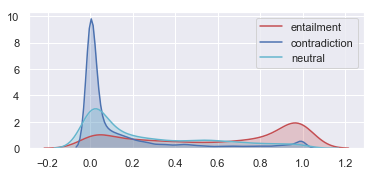

In [512]:
import seaborn as sns

sns.set(rc={'figure.figsize':(6,2.5)})
           
# plot of 2 variables
p1=sns.kdeplot(df['entailment'], shade=True, color="r")
p1=sns.kdeplot(df['contradiction'], shade=True, color="b")
p1=sns.kdeplot(df['neutral'], shade=True, color="c")



In [508]:
df2 = pd.DataFrame({'Embed Vector Similarity' : dsimilarity_score, 'Entities Similarity': dentity_similarity_score, 'Nouns Similarity':dnoun_similarity_score} )

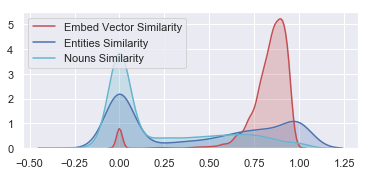

In [511]:
sns.set(rc={'figure.figsize':(6,2.5)})
           
# plot of 2 variables
p1=sns.kdeplot(df2['Embed Vector Similarity'], shade=True, color="r")
p1=sns.kdeplot(df2['Entities Similarity'], shade=True, color="b")
p1=sns.kdeplot(df2['Nouns Similarity'], shade=True, color="c")


In [513]:
dlabel_textual_entailment2 = []
for i in range(len(dconta_score)):
    if dconta_score[i] > 0.98 and dent_score[i] < 0.1 and dnut_core[i] < 0.1:
        dlabel_textual_entailment2.append('SUPPORTS')
    elif dconta_score[i] < 0.25 and dent_score[i] >= 0.5 and dnut_core[i] < 0.25:
        dlabel_textual_entailment2.append('REFUTES')
    else:
        dlabel_textual_entailment2.append('NOT ENOUGH INFO')

In [549]:
3117/5000

0.6234

In [548]:
Counter(dlabel)

Counter({'NOT ENOUGH INFO': 3117, 'REFUTES': 886, 'SUPPORTS': 998})

In [514]:
Counter(dlabel_textual_entailment2)

Counter({'SUPPORTS': 995, 'NOT ENOUGH INFO': 3595, 'REFUTES': 411})

In [515]:
dNEI_NEI2 = 0
dSPT_NEI2 = 0
dRFT_NEI2 = 0
dNEI_SPT2 = 0
dNEI_RFT2 = 0
dSPT_SPT2 = 0
dRFT_RFT2 = 0
dSPT_RFT2 = 0
dRFT_SPT2 = 0
dcombine_prediction2 = []
for i in range(len(dlabel_textual_entailment2)):
    if dlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        dNEI_NEI2 += 1
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        dSPT_NEI2 += 1
        dcombine_prediction2.append(dlabel[i])
    elif dlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        dRFT_NEI2 += 1    
        dcombine_prediction2.append(dlabel[i])
    elif dlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        dNEI_SPT2 += 1
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'REFUTES':
        dNEI_RFT2 += 1
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        dSPT_SPT2 += 1   
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'REFUTES':
        dRFT_RFT2 += 1      
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'REFUTES':
        dSPT_RFT2 += 1   
        dcombine_prediction2.append(dlabel_textual_entailment2[i])
    elif dlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        dRFT_SPT2 += 1 
        dcombine_prediction2.append(dlabel[i])

In [516]:
Counter(dcombine_prediction2)

Counter({'SUPPORTS': 1639, 'NOT ENOUGH INFO': 2138, 'REFUTES': 1224})

In [517]:
print("Same NEI:",dNEI_NEI2)
print("Support - NEI:",dSPT_NEI2)
print("Refute - NEI:",dRFT_NEI2)
print("NEI - Support:", dNEI_SPT2)
print("NEI - Refute:", dNEI_RFT2)
print("Same Support:",dSPT_SPT2)
print("Same Refute:",dRFT_RFT2)
print("Support - Refute:",dSPT_RFT2)
print("Refute - Support:",dRFT_SPT2)

Same NEI: 2138
Support - NEI: 773
Refute - NEI: 684
NEI - Support: 689
NEI - Refute: 290
Same Support: 177
Same Refute: 73
Support - Refute: 48
Refute - Support: 129


In [518]:
print("### GET ACTUAL DEVELOPMENT DATA ###")

adev_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), "devset.json")
with open(adev_path) as json_file:  
    adevelopment = json.load(json_file)
    
adrowid = list(adevelopment.keys())
adclaim = []
adlabel = []
adevidence = []
for idx in adrowid:
    adclaim.append(adevelopment[idx]['claim'])
    adlabel.append(adevelopment[idx]['label'])
    adevidence.append(adevelopment[idx]['evidence'])

### GET ACTUAL DEVELOPMENT DATA ###


In [519]:
adNEI_NEI2 = 0
adSPT_NEI2 = 0
adRFT_NEI2 = 0
adNEI_SPT2 = 0
adNEI_RFT2 = 0
adSPT_SPT2 = 0
adRFT_RFT2 = 0
adSPT_RFT2 = 0
adRFT_SPT2 = 0
adcombine_prediction2 = []
for i in range(len(dlabel_textual_entailment2)):
    if adlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        adNEI_NEI2 += 1
    elif adlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        adSPT_NEI2 += 1
    elif adlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'NOT ENOUGH INFO':
        adRFT_NEI2 += 1    
    elif adlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        adNEI_SPT2 += 1
    elif adlabel[i] == 'NOT ENOUGH INFO' and dlabel_textual_entailment2[i] == 'REFUTES':
        adNEI_RFT2 += 1
    elif adlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        adSPT_SPT2 += 1   
    elif adlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'REFUTES':
        adRFT_RFT2 += 1      
    elif adlabel[i] == 'SUPPORTS' and dlabel_textual_entailment2[i] == 'REFUTES':
        adSPT_RFT2 += 1   
    elif adlabel[i] == 'REFUTES' and dlabel_textual_entailment2[i] == 'SUPPORTS':
        adRFT_SPT2 += 1 

In [520]:
print("Same NEI:",adNEI_NEI2)
print("Support - NEI:",adSPT_NEI2)
print("Refute - NEI:",adRFT_NEI2)
print("NEI - Support:", adNEI_SPT2)
print("NEI - Refute:", adNEI_RFT2)
print("Same Support:",adSPT_SPT2)
print("Same Refute:",adRFT_RFT2)
print("Support - Refute:",adSPT_RFT2)
print("Refute - Support:",adRFT_SPT2)

Same NEI: 1260
Support - NEI: 1207
Refute - NEI: 1128
NEI - Support: 303
NEI - Refute: 104
Same Support: 411
Same Refute: 258
Support - Refute: 49
Refute - Support: 281


In [521]:
cadNEI_NEI2 = 0
cadSPT_NEI2 = 0
cadRFT_NEI2 = 0
cadNEI_SPT2 = 0
cadNEI_RFT2 = 0
cadSPT_SPT2 = 0
cadRFT_RFT2 = 0
cadSPT_RFT2 = 0
cadRFT_SPT2 = 0
cadcombine_prediction2 = []
for i in range(len(dcombine_prediction2)):
    if adlabel[i] == 'NOT ENOUGH INFO' and dcombine_prediction2[i] == 'NOT ENOUGH INFO':
        cadNEI_NEI2 += 1
    elif adlabel[i] == 'SUPPORTS' and dcombine_prediction2[i] == 'NOT ENOUGH INFO':
        cadSPT_NEI2 += 1
    elif adlabel[i] == 'REFUTES' and dcombine_prediction2[i] == 'NOT ENOUGH INFO':
        cadRFT_NEI2 += 1    
    elif adlabel[i] == 'NOT ENOUGH INFO' and dcombine_prediction2[i] == 'SUPPORTS':
        cadNEI_SPT2 += 1
    elif adlabel[i] == 'NOT ENOUGH INFO' and dcombine_prediction2[i] == 'REFUTES':
        cadNEI_RFT2 += 1
    elif adlabel[i] == 'SUPPORTS' and dcombine_prediction2[i] == 'SUPPORTS':
        cadSPT_SPT2 += 1   
    elif adlabel[i] == 'REFUTES' and dcombine_prediction2[i] == 'REFUTES':
        cadRFT_RFT2 += 1      
    elif adlabel[i] == 'SUPPORTS' and dcombine_prediction2[i] == 'REFUTES':
        cadSPT_RFT2 += 1   
    elif adlabel[i] == 'REFUTES' and dcombine_prediction2[i] == 'SUPPORTS':
        cadRFT_SPT2 += 1 

In [522]:
print("Same NEI:",cadNEI_NEI2)
print("Support - NEI:",cadSPT_NEI2)
print("Refute - NEI:",cadRFT_NEI2)
print("NEI - Support:", cadNEI_SPT2)
print("NEI - Refute:", cadNEI_RFT2)
print("Same Support:",cadSPT_SPT2)
print("Same Refute:",cadRFT_RFT2)
print("Support - Refute:",cadSPT_RFT2)
print("Refute - Support:",cadRFT_SPT2)

Same NEI: 767
Support - NEI: 702
Refute - NEI: 669
NEI - Support: 536
NEI - Refute: 364
Same Support: 683
Same Refute: 578
Support - Refute: 282
Refute - Support: 420


In [523]:
tadNEI_NEI2 = 0
tadSPT_NEI2 = 0
tadRFT_NEI2 = 0
tadNEI_SPT2 = 0
tadNEI_RFT2 = 0
tadSPT_SPT2 = 0
tadRFT_RFT2 = 0
tadSPT_RFT2 = 0
tadRFT_SPT2 = 0
tadcombine_prediction2 = []
for i in range(len(dcombine_prediction2)):
    if adlabel[i] == 'NOT ENOUGH INFO' and dlabel[i] == 'NOT ENOUGH INFO':
        tadNEI_NEI2 += 1
    elif adlabel[i] == 'SUPPORTS' and dlabel[i] == 'NOT ENOUGH INFO':
        tadSPT_NEI2 += 1
    elif adlabel[i] == 'REFUTES' and dlabel[i] == 'NOT ENOUGH INFO':
        tadRFT_NEI2 += 1    
    elif adlabel[i] == 'NOT ENOUGH INFO' and dlabel[i] == 'SUPPORTS':
        tadNEI_SPT2 += 1
    elif adlabel[i] == 'NOT ENOUGH INFO' and dlabel[i] == 'REFUTES':
        tadNEI_RFT2 += 1
    elif adlabel[i] == 'SUPPORTS' and dlabel[i] == 'SUPPORTS':
        tadSPT_SPT2 += 1   
    elif adlabel[i] == 'REFUTES' and dlabel[i] == 'REFUTES':
        tadRFT_RFT2 += 1      
    elif adlabel[i] == 'SUPPORTS' and dlabel[i] == 'REFUTES':
        tadSPT_RFT2 += 1   
    elif adlabel[i] == 'REFUTES' and dlabel[i] == 'SUPPORTS':
        tadRFT_SPT2 += 1 

In [524]:
print("Same NEI:",tadNEI_NEI2)
print("Support - NEI:",tadSPT_NEI2)
print("Refute - NEI:",tadRFT_NEI2)
print("NEI - Support:", tadNEI_SPT2)
print("NEI - Refute:", tadNEI_RFT2)
print("Same Support:",tadSPT_SPT2)
print("Same Refute:",tadRFT_RFT2)
print("Support - Refute:",tadSPT_RFT2)
print("Refute - Support:",tadRFT_SPT2)

Same NEI: 1055
Support - NEI: 1019
Refute - NEI: 1043
NEI - Support: 339
NEI - Refute: 273
Same Support: 407
Same Refute: 372
Support - Refute: 241
Refute - Support: 252


In [525]:
1055 - 767

288

In [526]:
683 - 407

276

In [527]:
578 - 372

206

In [528]:
276 + 206

482

In [529]:
print(accuracy_score(adlabel,dcombine_prediction2))

0.4055188962207559


In [530]:
print(classification_report(adlabel,dcombine_prediction2))

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.36      0.46      0.40      1667
        REFUTES       0.47      0.35      0.40      1667
       SUPPORTS       0.42      0.41      0.41      1667

       accuracy                           0.41      5001
      macro avg       0.42      0.41      0.41      5001
   weighted avg       0.42      0.41      0.41      5001



In [531]:
print(accuracy_score(adlabel,dlabel))

0.3667266546690662


In [532]:
print(classification_report(adlabel,dlabel))

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.34      0.63      0.44      1667
        REFUTES       0.42      0.22      0.29      1667
       SUPPORTS       0.41      0.24      0.31      1667

       accuracy                           0.37      5001
      macro avg       0.39      0.37      0.35      5001
   weighted avg       0.39      0.37      0.35      5001



In [ ]:
dfeatures = defaultdict(Counter)
dclaim_embed = dict()
devidences_embed = dict()
dconta_score = dict()
dent_score = dict()
dnut_core  = dict()
dsimilarity_score = dict()
dentity_similarity_score = dict()
dnoun_similarity_score = dict()

In [534]:

dev_claim_embed = []
dev_evidences_embed = []

for i in range(len(dsimilarity_score)):
        dev_claim_embed.append(dclaim_embed[i])
        dev_evidences_embed.append(devidences_embed[i])
        
dev_claim_embed_array = np.array(dev_claim_embed)
dev_evidences_embed_array = np.array(dev_evidences_embed)


In [540]:
dev_entity_similarity_score = []
dev_noun_similarity_score = []
dev_similarity_score = []

for i in range(len(dsimilarity_score)):
        dev_entity_similarity_score.append(dentity_similarity_score[i]) 
        dev_noun_similarity_score.append(dnoun_similarity_score[i])
        dev_similarity_score.append(dsimilarity_score[i])   
      

In [541]:
dev_entity_similarity_score_array = np.array(dev_entity_similarity_score)
dev_entity_similarity_score_array.resize((len(dev_entity_similarity_score_array), 1))
dev_noun_similarity_score_array = np.array(dev_noun_similarity_score)
dev_noun_similarity_score_array.resize((len(dev_noun_similarity_score_array), 1))
dev_similarity_score_array = np.array(dev_similarity_score)
dev_similarity_score_array.resize((len(dev_similarity_score_array), 1))


In [542]:
dev_feature_combine = np.concatenate((dev_claim_embed_array,dev_evidences_embed_array), axis=1)
dev_feature_combine = np.concatenate((dev_feature_combine,dev_entity_similarity_score_array), axis=1)
dev_feature_combine = np.concatenate((dev_feature_combine,dev_noun_similarity_score_array), axis=1)
dev_feature_combine = np.concatenate((dev_feature_combine,dev_similarity_score_array), axis=1)

In [543]:
predictions_dev = MLPClassifier_300_undersampling.predict(dev_feature_combine)
accuracy_dev = accuracy_score(adlabel,predictions_dev)
results_dev = classification_report(adlabel,predictions_dev,  output_dict=True)

print(accuracy_dev)
print(results_dev)

0.4401119776044791
{'NOT ENOUGH INFO': {'precision': 0.44036697247706424, 'recall': 0.057588482303539294, 'f1-score': 0.10185676392572944, 'support': 1667}, 'REFUTES': {'precision': 0.4365761430044689, 'recall': 0.7618476304739052, 'f1-score': 0.55506993006993, 'support': 1667}, 'SUPPORTS': {'precision': 0.4455709711846318, 'recall': 0.5008998200359928, 'f1-score': 0.4716181869528382, 'support': 1667}, 'accuracy': 0.4401119776044791, 'macro avg': {'precision': 0.44083802888872164, 'recall': 0.44011197760447907, 'f1-score': 0.3761816269828325, 'support': 5001}, 'weighted avg': {'precision': 0.4408380288887216, 'recall': 0.4401119776044791, 'f1-score': 0.37618162698283253, 'support': 5001}}


In [550]:
218/5001

0.04359128174365127

In [544]:
Counter(predictions_dev)

Counter({'REFUTES': 2909, 'SUPPORTS': 1874, 'NOT ENOUGH INFO': 218})

In [547]:
results_dev = classification_report(adlabel,predictions_dev)
print(results_dev)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.44      0.06      0.10      1667
        REFUTES       0.44      0.76      0.56      1667
       SUPPORTS       0.45      0.50      0.47      1667

       accuracy                           0.44      5001
      macro avg       0.44      0.44      0.38      5001
   weighted avg       0.44      0.44      0.38      5001



In [ ]:
test_claim_evidence_dotproduct = []
for i in range(len(test_claim_embed_array)):
    test_dotproduct = test_claim_embed_array[i].dot(test_evidences_embed_array[i])
    test_claim_evidence_dotproduct.append(test_dotproduct)
    
test_claim_evidence_dotproduct_array = np.array(test_claim_evidence_dotproduct)
test_claim_evidence_dotproduct_array.resize((len(test_claim_evidence_dotproduct_array), 1))

In [ ]:
dev_feature_combine = np.concatenate((dev_claim_embed_array,dev_evidences_embed_array), axis=1)
dev_feature_combine = np.concatenate((dev_feature_combine,dev_entity_similarity_score_array), axis=1)
dev_feature_combine = np.concatenate((dev_feature_combine,dev_noun_similarity_score_array), axis=1)
dev_feature_combine = np.concatenate((dev_feature_combine,dev_similarity_score_array), axis=1)

In [555]:
for i in range(len(adevidence)):
    print(adlabel[i], adclaim[i])
    print(predictions_dev[i],dlabel[i])
    print(adevidence[i], "---", devidence[i])
    print("")

NOT ENOUGH INFO Colin Kaepernick became a starting quarterback during the 49ers 63rd season in the National Football League.
REFUTES NOT ENOUGH INFO
[] --- [['2016_U.S._national_anthem_protests', 1], ['Colin_Kaepernick', 7], ['2016_San_Francisco_49ers_season', 0], ['2016_San_Francisco_49ers_season', 11]]

NOT ENOUGH INFO Tilda Swinton is a vegan.
REFUTES NOT ENOUGH INFO
[] --- [['Tilda', 4], ['Tilda', 2], ['Tilda', 12], ['Tilda_Swinton', 0], ['Swinton_-LRB-surname-RRB-', 0]]

SUPPORTS Fox 2000 Pictures released the film Soul Food.
REFUTES REFUTES
[['Soul_Food_-LRB-film-RRB-', 0]] --- [['Soul_Food', 7], ['Soul_Food_-LRB-film-RRB-', 0], ['Soul_Food_-LRB-film-RRB-', 7], ['Soul_Food_-LRB-film-RRB-', 5], ['Soul_Food', 5]]

NOT ENOUGH INFO Anne Rice was born in New Jersey.
REFUTES SUPPORTS
[] --- [['Harry_Heher', 3], ['Anne_Rice', 5], ['Ronald_Rice', 2]]

REFUTES Telemundo is a English-language television network.
SUPPORTS NOT ENOUGH INFO
[['Telemundo', 5], ['Telemundo', 4], ['Telemundo', 1]

[['Starrcade', 6]] --- [['Pay-per-view', 0], ['Starrcade', 16]]

REFUTES Veeru Devgan only works in Hollywood.
REFUTES REFUTES
[['Veeru_Devgan', 0]] --- [['Veeru_Devgan', 0]]

REFUTES Star Trek: Discovery is the first series since Star Trek: The Next Generation.
REFUTES SUPPORTS
[['Star_Trek-COLON-_Discovery', 1]] --- [['Star_Trek-COLON-_Discovery', 1], ['Star_Trek_canon', 1]]

NOT ENOUGH INFO Terry Crews was a linebacker for the Patriots.
SUPPORTS NOT ENOUGH INFO
[] --- [['Terry_Crews', 9], ['Terry_Crews_filmography', 0]]

SUPPORTS Excuse My French is the debut album of a hip hop recording artist.
REFUTES SUPPORTS
[['French_Montana', 0], ['Excuse_My_French_-LRB-album-RRB-', 0]] --- [['Hip_hop_skit', 0]]

SUPPORTS A Floppy disk is composed of a thin and flexible magnetic transmission medium.
SUPPORTS NOT ENOUGH INFO
[['Floppy_disk', 0]] --- [['History_of_the_floppy_disk', 0]]

NOT ENOUGH INFO Guatemala endured a civil war that lasted 36 years.
REFUTES REFUTES
[] --- [['Guatemala', 16],

SUPPORTS NOT ENOUGH INFO
[['Eva_Green', 1]] --- [['Anna_Wing', 0], ['Eva_Green', 1], ['Eva_Griffith', 0], ['Eva_Green', 0], ['Green_Theatre', 5]]

SUPPORTS The Republic of Macedonia is a region.
REFUTES SUPPORTS
[['Republic_of_Macedonia', 6], ['Republic_of_Macedonia', 2]] --- [['Mavrovo', 3]]

SUPPORTS Tim McGraw acted in a movie.
SUPPORTS SUPPORTS
[['The_Blind_Side_-LRB-film-RRB-', 0], ['Tim_McGraw', 13]] --- [['Tim_McGraw_and_the_Dancehall_Doctors', 3], ['My_Little_Girl_-LRB-Tim_McGraw_song-RRB-', 6], ['Tim_McGraw_-LRB-song-RRB-', 16], ['My_Little_Girl_-LRB-Tim_McGraw_song-RRB-', 3], ['Tim_McGraw', 13]]

SUPPORTS Moonlight's filming began after 2002.
REFUTES SUPPORTS
[['Moonlight_-LRB-2016_film-RRB-', 6]] --- [['Moonlight_-LRB-2002_film-RRB-', 1]]

REFUTES Danielle Cormack was born in May.
REFUTES NOT ENOUGH INFO
[['Danielle_Cormack', 0]] --- [['Danielle_Cormack', 0]]

REFUTES A Floppy disk is lined with turnips.
SUPPORTS NOT ENOUGH INFO
[['Floppy_disk', 0]] --- [['Floppy_disk', 0], 

REFUTES NOT ENOUGH INFO
[['Tim_Roth', 0], ['Tim_Roth', 8]] --- [['Tim_Roth', 0]]

NOT ENOUGH INFO Veeram is an award-winning Tamil film.
REFUTES NOT ENOUGH INFO
[] --- [['Ashmitha', 0]]

NOT ENOUGH INFO Baz Luhrmann's film Australia stars Nicole Kidman as Donkey Kong.
REFUTES NOT ENOUGH INFO
[] --- [['Nicole_Kidman_filmography', 8], ['Baz_Luhrmann', 2], ['Australia_-LRB-2008_film-RRB-', 0]]

NOT ENOUGH INFO Tim McGraw attended the premiere of The Blind Side.
REFUTES NOT ENOUGH INFO
[] --- [['Sean_Tuohy', 4], ['Tim_McGraw', 13], ['Tim_McGraw_and_the_Dancehall_Doctors', 0], ['Tim_McGraw', 10], ['The_Blind_Side_-LRB-film-RRB-', 3]]

REFUTES Lockheed Martin is a car company.
SUPPORTS NOT ENOUGH INFO
[['Lockheed_Martin', 0], ['Lockheed_Martin', 7]] --- [['Lockheed_Martin_Aeronautics', 0]]

SUPPORTS Lockhead Martin F-35 Lightning II first flew on December 15th, 2006.
SUPPORTS SUPPORTS
[['Lockheed_Martin_F-35_Lightning_II', 10]] --- [['Lockheed_Martin_F-35_Lightning_II', 10]]

REFUTES Franchi

REFUTES NOT ENOUGH INFO
[] --- [['Omar_Khadr', 3], ['Omar_Khadr', 2], ['Omar_Khadr', 0]]

REFUTES The Chrysler Building was always the world's shortest building.
REFUTES REFUTES
[['Chrysler_Building', 4], ['Chrysler_Building', 7], ['Chrysler_Building', 6], ['Chrysler_Building', 1], ['Chrysler_Building', 0], ['Chrysler_Building', 5]] --- [['Chrysler_Building', 5], ['Chrysler_Building', 1], ['Chrysler_Building', 4], ['Chrysler_Building', 6], ['Conabeer_Chrysler_Building', 3]]

SUPPORTS John Dolmayan was born on July 15, 1973.
REFUTES NOT ENOUGH INFO
[['John_Dolmayan', 0]] --- [['John_Dolmayan', 0]]

NOT ENOUGH INFO Tamerlan Tsarnaev had an ulcer.
REFUTES NOT ENOUGH INFO
[] --- [['Tamerlan_Tsarnaev', 9], ['Tamerlan_Tsarnaev', 10], ['Tamerlan_Tsarnaev', 5], ['Tamerlan_Tsarnaev', 14], ['Tamerlan_Tsarnaev', 8]]

REFUTES A&E is an Australian channel only.
REFUTES NOT ENOUGH INFO
[['A&E_-LRB-TV_channel-RRB-', 0]] --- [['History_-LRB-Australian_TV_channel-RRB-', 7], ['History_-LRB-Australian_TV

REFUTES REFUTES
[['Bloods', 0]] --- [['Quality_Street_Gang', 5], ['Quality_Street_Gang', 6], ['Quality_Street_Gang', 1], ['Bloods', 1], ['Quality_Street_Gang', 9]]

NOT ENOUGH INFO Damon Albarn married Brian Eno.
SUPPORTS SUPPORTS
[] --- [['Damon_Albarn', 0], ['Jeff_Wootton', 7], ['Damon_Albarn', 11], ['Jeff_Wootton', 13], ['Jeff_Wootton', 4]]

NOT ENOUGH INFO Regina King has received a Critics' Choice Television Award.
REFUTES SUPPORTS
[] --- [['Regina_King', 4]]

SUPPORTS Brazzers is based in Montreal.
SUPPORTS NOT ENOUGH INFO
[['Brazzers', 0]] --- [['Brazzers', 0]]

NOT ENOUGH INFO Sandra Bullock worked on Full House.
REFUTES NOT ENOUGH INFO
[] --- [['Sandra_Bullock_filmography', 14], ['Alejandro_Agresti', 1], ['Sandra_Bullock', 17], ['Sandra_Bullock_filmography', 18], ['Sandra_Bullock', 11]]

SUPPORTS Marnie is an American psychological thriller film.
SUPPORTS NOT ENOUGH INFO
[['Marnie_-LRB-film-RRB-', 0]] --- [['Marnie_-LRB-film-RRB-', 0]]

SUPPORTS Animals are part of the History


NOT ENOUGH INFO Carlos Santana is retired.
REFUTES NOT ENOUGH INFO
[] --- [['Santana_-LRB-surname-RRB-', 7], ['Carlos_Santana_-LRB-disambiguation-RRB-', 0], ['Carlos_Santana_-LRB-disambiguation-RRB-', 6], ['Carlos_Santana_-LRB-disambiguation-RRB-', 3]]

REFUTES Bermuda Triangle is in the eastern part of the Atlantic Ocean.
REFUTES NOT ENOUGH INFO
[['Bermuda_Triangle', 0]] --- [['Bermuda_Triangle_-LRB-disambiguation-RRB-', 0], ['Bermuda_Triangle', 2], ['Bermuda_Triangle', 0]]

REFUTES David Spade was fired from being in Grown Ups 2.
REFUTES NOT ENOUGH INFO
[['David_Spade', 2], ['Grown_Ups_2', 2]] --- [['David_Spade', 2], ['David_Spade', 5]]

REFUTES Saxony is the tenth smallest German state.
REFUTES NOT ENOUGH INFO
[['Saxony', 4]] --- [['Saxony', 0], ['Landtag_of_the_Free_State_of_Saxony', 0], ['Saxony', 4], ['Saxony_-LRB-wine_region-RRB-', 0], ['Saxony', 7]]

REFUTES Easy A is a 2010 food dish.
REFUTES NOT ENOUGH INFO
[['Easy_A', 0]] --- [['Dish_-LRB-food-RRB-', 0]]

REFUTES Kendall J

REFUTES The Endless River is Journey's fifteenth studio album.
REFUTES REFUTES
[['The_Endless_River', 0]] --- [['The_Endless_River', 0]]

SUPPORTS Dakota Fanning was involved with a film called Coraline.
SUPPORTS SUPPORTS
[['Dakota_Fanning', 6]] --- [['Coraline', 2], ['Dakota_Fanning', 1], ['Dakota_Fanning', 9]]

SUPPORTS Star Trek: Discovery is the first series since Star Trek: Enterprise.
REFUTES SUPPORTS
[['Star_Trek-COLON-_Discovery', 1]] --- [['Star_Trek_canon', 1], ['Star_Trek-COLON-_Discovery', 1]]

REFUTES Michaela Watkins full name is Michaela Ruth Watkins.
REFUTES SUPPORTS
[['Michaela_Watkins', 0]] --- [['Watkins_-LRB-surname-RRB-', 18], ['Watkins_-LRB-surname-RRB-', 98]]

NOT ENOUGH INFO Marcus Bentley is the son of Morgan Bentley.
SUPPORTS SUPPORTS
[] --- [['Bentley_-LRB-surname-RRB-', 85], ['Marcus_Bentley', 0]]

NOT ENOUGH INFO Noel Fisher portrayed Hermione Granger.
REFUTES SUPPORTS
[] --- [['Hermione_Granger', 0]]

REFUTES Psych's protagonist is not Shawn Spencer.
REFUT

SUPPORTS Alton is where the Lincoln-Douglas debates happened.
REFUTES NOT ENOUGH INFO
[['Lincoln–Douglas_debates', 24], ['Lincoln–Douglas_debates', 27], ['Lincoln–Douglas_debates', 10]] --- [['Lincoln–Douglas_debate', 2]]

REFUTES Ron Weasley was denied membership to Gryffindor house.
REFUTES REFUTES
[['Ron_Weasley', 3]] --- [['Ron_Weasley', 3]]

SUPPORTS Shadowhunters did not begin its second season in January 2017.
REFUTES NOT ENOUGH INFO
[['Shadowhunters', 5]] --- [['2017–18_Slovenian_Second_League', 1], ['Shadowhunters', 5], ['List_of_Shadowhunters_episodes', 6], ['Shadowhunters', 6]]

REFUTES Harold Macmillan was a fish.
NOT ENOUGH INFO NOT ENOUGH INFO
[['Harold_Macmillan', 7], ['Harold_Macmillan', 28], ['Harold_Macmillan', 6], ['Harold_Macmillan', 8], ['Harold_Macmillan', 5], ['Harold_Macmillan', 18], ['Harold_Macmillan', 15], ['Harold_Macmillan', 4], ['Harold_Macmillan', 17], ['Harold_Macmillan', 27], ['Harold_Macmillan', 16], ['Harold_Macmillan', 26], ['Harold_Macmillan', 23], 

REFUTES Justine Bateman is a German.
REFUTES NOT ENOUGH INFO
[['Justine_Bateman', 0]] --- [['Justine_Bateman', 0]]

REFUTES Easy A is a 2009 film.
SUPPORTS NOT ENOUGH INFO
[['Easy_A', 0]] --- [['Easy_Virtue_-LRB-2008_film-RRB-', 0], ['Easy_Virtue_-LRB-2008_film-RRB-', 14]]

REFUTES The Concert for Bangladesh was attended by 43,000 people.
NOT ENOUGH INFO REFUTES
[['The_Concert_for_Bangladesh', 12]] --- [['The_Concert_for_Bangladesh', 12]]

NOT ENOUGH INFO Chile is a political unit.
REFUTES NOT ENOUGH INFO
[] --- [['List_of_political_scandals_in_Chile', 17], ['List_of_political_scandals_in_Chile', 1], ['Lawton_Chiles', 5]]

NOT ENOUGH INFO Harold Macmillan was a vegan.
NOT ENOUGH INFO NOT ENOUGH INFO
[] --- [['Daniel_Macmillan,_Viscount_Macmillan_of_Ovenden', 0]]

REFUTES CHiPs is an American action novel.
REFUTES NOT ENOUGH INFO
[['CHiPs_-LRB-film-RRB-', 0]] --- [['Chips_and_dip', 8], ['Blue_Chips_2', 0]]

NOT ENOUGH INFO Osamu Tezuka only practiced drawing as a young adult.
REFUTES NO


REFUTES The United Nations Charter was signed on April 26, 1945.
REFUTES REFUTES
[['United_Nations_Charter', 1]] --- [['United_Nations_Conference_on_International_Organization', 0]]

SUPPORTS The Prowler is a non-factual character.
REFUTES SUPPORTS
[['Prowler_-LRB-comics-RRB-', 0]] --- [['Prowler_-LRB-comics-RRB-', 2], ['The_Prowler_in_the_City_at_the_Edge_of_the_World', 1]]

REFUTES Gray Matter Interactive Studios, Inc. was founded in 1995.
REFUTES SUPPORTS
[['Gray_Matter_Interactive', 0]] --- [['Gray_Matter_Interactive', 0]]

SUPPORTS Gin is a spirit.
SUPPORTS NOT ENOUGH INFO
[['Gin', 0]] --- [['Gin', 0], ['Gin', 1], ['Gin', 3], ['Gin_Gin', 8], ['Gin_Gin', 0]]

SUPPORTS Fort Erie, Ontario is where Murda Beatz is from.
REFUTES NOT ENOUGH INFO
[['Murda_Beatz', 0]] --- [['Murda_Beatz', 0]]

SUPPORTS The Hanford Site hosts the Columbia Generating Station, ten miles north of Richland, Washington.
REFUTES NOT ENOUGH INFO
[['Hanford_Site', 23], ['Columbia_Generating_Station', 0]] --- [['Co

[['Happiness_in_Slavery', 0]] --- [['Happiness_in_Slavery', 0]]

REFUTES Harold Macmillan was fully German.
REFUTES NOT ENOUGH INFO
[['Harold_Macmillan', 0]] --- [['Never_So_Good', 9]]

SUPPORTS Awkward Black Girl was created by a woman.
REFUTES SUPPORTS
[['Issa_Rae', 0], ['Issa_Rae', 1], ['Awkward_Black_Girl', 0]] --- [['Awkward_Black_Girl', 0]]

SUPPORTS In 1997 and 1998 Oscar de la Hoya was The Ring magazine's top-rated fighter in the world.
SUPPORTS REFUTES
[['Oscar_De_La_Hoya', 7]] --- [['Oscar_De_La_Hoya', 7]]

SUPPORTS Advertising is used to sell an idea.
SUPPORTS NOT ENOUGH INFO
[['Advertising', 0]] --- [['Hard_sell', 0], ['Advertising', 0], ['Advertising', 10], ['Hard_sell', 4], ['Advertising_slogan', 2]]

NOT ENOUGH INFO Derek Hough starred in an independent horror novel.
REFUTES SUPPORTS
[] --- [['Julianne_Hough', 3]]

SUPPORTS Martin Van Buren was elected governor.
REFUTES SUPPORTS
[['Martin_Van_Buren', 12]] --- [['Martin_Van_Buren', 25], ['Martin_Van_Buren', 12]]

REFUTES 

REFUTES SUPPORTS
[['Awkward_Black_Girl', 0]] --- [['Awkward_Black_Girl', 0]]

SUPPORTS Bad Romance was released as a single.
REFUTES REFUTES
[['Bad_Romance', 12], ['Bad_Romance', 3]] --- [['Bad_-LRB-album-RRB-', 8], ['Bad_-LRB-album-RRB-', 11], ['Bad_Romance', 9], ['Bad_Romance', 5], ['Romance/Romance', 4]]

REFUTES A monk is solely a non-human animal.
REFUTES REFUTES
[['Monk', 1], ['Monk', 0]] --- [['Xenotransfusion', 1]]

REFUTES Rio's sequel was released five years before April 11, 2014.
REFUTES REFUTES
[['Rio_-LRB-2011_film-RRB-', 20]] --- [['Rio_-LRB-2011_film-RRB-', 20]]

REFUTES Hedda Gabler's world premiere took place in Schwabing.
REFUTES SUPPORTS
[['Hedda_Gabler', 1]] --- [['Hedda_Gabler', 1]]

SUPPORTS At age 18, Miranda Otto began her acting career.
REFUTES REFUTES
[['Miranda_Otto', 1]] --- [['Aurora_Miranda', 3]]

REFUTES Jens Stolenberg only held the office of Prime Minister from 2000 to 2001.
REFUTES REFUTES
[['Jens_Stoltenberg', 4]] --- [['Jens_Stoltenberg', 4], ['Hanne

REFUTES NOT ENOUGH INFO
[] --- [['Gibbons', 5], ['Dave_Gibbons', 0], ['David_Gibbons_-LRB-disambiguation-RRB-', 0], ['Gibbons', 70], ['David_Gibbons_-LRB-disambiguation-RRB-', 3]]

SUPPORTS Bhagat Singh was Indian.
REFUTES NOT ENOUGH INFO
[['Bhagat_Singh', 0]] --- [['Bhagat_Singh', 19], ['The_Legend_of_Bhagat_Singh', 1], ['Bhagat_Singh', 7]]

NOT ENOUGH INFO The Bloods have distinctive feet signs.
SUPPORTS REFUTES
[] --- [['Bloods', 2]]

REFUTES A Floppy disk is unrelated to disk storage.
REFUTES NOT ENOUGH INFO
[['Floppy_disk', 0]] --- [['Floppy_disk_format', 25], ['Disk_storage', 2], ['Floppy_disk_format', 0], ['Floppy_disk_format', 9], ['Floppy_disk', 0]]

REFUTES Human trafficking is the trade of animals.
REFUTES NOT ENOUGH INFO
[['Human_trafficking', 0]] --- [['Human_trafficking', 0], ['Human_trafficking', 3], ['Human_trafficking', 4], ['Human_trafficking', 16], ['Human_trafficking_-LRB-disambiguation-RRB-', 0]]

NOT ENOUGH INFO Always premiered at the American Film Festival.
REFU

REFUTES Mary-Kate Olsen and Ashley Olsen are incapable of being fashion designers.
REFUTES REFUTES
[['Mary-Kate_and_Ashley_Olsen', 0]] --- [['Mary-Kate_and_Ashley_Olsen', 0]]

SUPPORTS Marnie is a film that was created in the United States.
SUPPORTS NOT ENOUGH INFO
[['Marnie_-LRB-film-RRB-', 0]] --- [['When_Marnie_Was_There', 0], ['When_Marnie_Was_There', 6], ['When_Marnie_Was_There', 7], ['When_Marnie_Was_There', 1], ['Marnie_-LRB-disambiguation-RRB-', 10]]

REFUTES Rick Yune has only ever been in cinematic film.
REFUTES REFUTES
[['Rick_Yune', 2]] --- [['Rick_Yune', 1]]

SUPPORTS Kelly Preston was in multiple job positions.
SUPPORTS NOT ENOUGH INFO
[['Kelly_Preston', 3], ['Kelly_Preston', 1], ['Kelly_Preston', 0]] --- [['Kim_Kelly', 4], ['Tony_Kelly_-LRB-Australian_footballer-RRB-', 15], ['Kim_Kelly', 11], ['Tony_Kelly_-LRB-Australian_footballer-RRB-', 5], ['Job', 2]]

REFUTES Stan Beeman is a historical figure.
REFUTES NOT ENOUGH INFO
[['Stan_Beeman', 0]] --- [['Stan_Beeman', 0], ['H

REFUTES Harris Jayaraj is exclusively a teacher.
REFUTES NOT ENOUGH INFO
[['Harris_Jayaraj', 0]] --- [['Jayaraj', 0]]

SUPPORTS Billboard Dad is a motion picture.
REFUTES SUPPORTS
[['Billboard_Dad', 0]] --- [['Caught_Up_-LRB-soundtrack-RRB-', 0]]

SUPPORTS Justin Chatwin performed in the BBC UK series Doctor Who.
REFUTES NOT ENOUGH INFO
[['Justin_Chatwin', 7]] --- [['Justin_Chatwin', 7]]

NOT ENOUGH INFO Tom Baker has had directing roles.
SUPPORTS SUPPORTS
[] --- [['Tom_Baker_-LRB-English_actor-RRB-', 10], ['Tom_Baker_-LRB-English_actor-RRB-', 7], ['Tom_Baker_-LRB-English_actor-RRB-', 2], ['Tom_Baker_-LRB-English_actor-RRB-', 15], ['Tom_Baker_-LRB-English_actor-RRB-', 20]]

NOT ENOUGH INFO Regina King has received a Supreme Court nomination.
SUPPORTS REFUTES
[] --- [['Edward_King_-LRB-jurist-RRB-', 29], ['Merrick_Garland_Supreme_Court_nomination', 2]]

NOT ENOUGH INFO The filming of Dilwale Dulhania Le Jayenge ended on August 25, 1995.
REFUTES REFUTES
[] --- [['Dilwale_Dulhania_Le_Jaye

SUPPORTS The Republic of Macedonia is in a place with various and disputed borders.
SUPPORTS SUPPORTS
[['Republic_of_Macedonia', 1], ['Balkans', 0]] --- [['Macedonia_-LRB-terminology-RRB-', 9], ['Macedonia_naming_dispute', 6], ['Greeks_in_the_Republic_of_Macedonia', 4], ['Macedonia_naming_dispute', 0], ['Outline_of_the_Republic_of_Macedonia', 12]]

REFUTES Graffiti was released in 2007.
SUPPORTS REFUTES
[['Graffiti_-LRB-Chris_Brown_album-RRB-', 1]] --- [['Graffiti_-LRB-Chris_Brown_album-RRB-', 1]]

REFUTES Jackpot was released in 2000.
SUPPORTS REFUTES
[['Jackpot_-LRB-2013_film-RRB-', 1]] --- [['Jackpot!_-LRB-Dave_Brubeck_album-RRB-', 2], ['Jackpot_-LRB-comics-RRB-', 2], ['Jackpot,_Nevada', 1], ['Jackpot!_The_Best_Bette', 14]]

SUPPORTS Tool has performed tours.
SUPPORTS NOT ENOUGH INFO
[['Tool_-LRB-band-RRB-', 3]] --- [['List_of_Tool_concert_tours', 0]]

NOT ENOUGH INFO The Cincinnati Kid was produced by a Canadian film director.
REFUTES NOT ENOUGH INFO
[] --- [['The_Cincinnati_Kid', 

[['White_House_Press_Secretary', 0]] --- [['White_House_Office_of_the_Press_Secretary', 1], ['White_House_Press_Secretary', 0], ['White_House_Office_of_the_Press_Secretary', 0], ['White_House_Press_Secretary', 4]]

REFUTES Ian Brennan has no role in media creation.
REFUTES NOT ENOUGH INFO
[['Ian_Brennan_-LRB-writer-RRB-', 1], ['Ian_Brennan_-LRB-writer-RRB-', 0]] --- [['List_of_Lone_Wolf_media', 2], ['List_of_Lone_Wolf_media', 1], ["Brennan's", 1], ['Ian_Brennan_-LRB-sculptor-RRB-', 0], ['List_of_Lone_Wolf_media', 0]]

NOT ENOUGH INFO Marjorie Gross wrote for film.
REFUTES NOT ENOUGH INFO
[] --- [['Marjorie_Gross', 0], ['Marjorie', 136], ['Marjorie', 186], ['Marjorie_Gross', 1], ['Marjorie', 80]]

REFUTES Heavy Metal music is a genre of rock paintings.
SUPPORTS NOT ENOUGH INFO
[['Heavy_metal_music', 0]] --- [['Rock_music_of_Canada', 2], ['List_of_alternative_metal_artists', 4], ['Heavy_metal_bass', 0], ['List_of_alternative_metal_artists', 5], ['Heavy_metal_bass', 4]]

REFUTES Connie Ni


SUPPORTS Danger UXB is a TV show.
REFUTES NOT ENOUGH INFO
[['Danger_UXB', 7], ['Danger_UXB', 0], ['Danger_UXB', 3], ['Danger_UXB', 11]] --- [['Danger_UXD', 0]]

SUPPORTS Atlanta, Georgia is a place where Due Date was shot.
REFUTES NOT ENOUGH INFO
[['Due_Date', 2]] --- [['Walton_Place_-LRB-Atlanta-RRB-', 1], ['Due_Date', 2]]

SUPPORTS Heavy Metal music was developed in the 1970's.
REFUTES NOT ENOUGH INFO
[['Heavy_metal_music', 0]] --- [['Heavy_metal_music', 0], ['Heavy_metal_music_before_1970', 0], ['Heavy_metal_music', 7], ["Lucifer's_Friend", 1], ["Lucifer's_Friend", 2]]

SUPPORTS Trevor Griffiths was born in a city.
SUPPORTS NOT ENOUGH INFO
[['Trevor_Griffiths', 0]] --- [['John_Griffith_-LRB-of_Llyn-RRB-', 0], ['Arfon_Griffiths', 0]]

REFUTES CHiPs was created in 1944.
SUPPORTS REFUTES
[['CHiPs_-LRB-film-RRB-', 0]] --- [['Illustrated_Chips', 7], ['Illustrated_Chips', 15]]

REFUTES Melancholia was directed by Bob Dole.
SUPPORTS REFUTES
[['Melancholia_-LRB-2011_film-RRB-', 0]] --- [['


SUPPORTS The Sterile Cuckoo was based on a novel written by John Nichols.
REFUTES NOT ENOUGH INFO
[['The_Sterile_Cuckoo', 3]] --- [['The_Sterile_Cuckoo_-LRB-novel-RRB-', 0], ['The_Sterile_Cuckoo_-LRB-novel-RRB-', 4]]

REFUTES Joe Walsh was barely inducted in 2001.
REFUTES REFUTES
[['Joe_Walsh', 24]] --- [['Joe_Walsh', 10], ['Joe_Walsh_-LRB-catcher-RRB-', 9]]

REFUTES Keith Urban is a Algerian pop music artist's second studio album.
REFUTES NOT ENOUGH INFO
[['Keith_Urban_-LRB-1999_album-RRB-', 0]] --- [['Get_Closer_-LRB-Keith_Urban_album-RRB-', 0], ['Keith_Urban_-LRB-1991_album-RRB-', 0]]

REFUTES Dave Gibbons has no middle name.
REFUTES SUPPORTS
[['Dave_Gibbons', 0]] --- [['Gibbons', 70], ['David_Gibbons_-LRB-disambiguation-RRB-', 3]]

REFUTES You Belong with Me is a blues song.
SUPPORTS SUPPORTS
[['You_Belong_with_Me', 4]] --- [['Where_I_Belong', 13]]

REFUTES Rachel Green is one of the six main characters in the sitcom Will and Grace.
REFUTES NOT ENOUGH INFO
[['Rachel_Green', 0]] --

[] --- [['X-Men-COLON-_Apocalypse', 0]]

SUPPORTS Wilhelmina Slater is portrayed in a comedy-drama television series.
SUPPORTS SUPPORTS
[['Wilhelmina_Slater', 0]] --- [['Remember_Paul?', 1]]

SUPPORTS John Dolmayan is a musician.
SUPPORTS NOT ENOUGH INFO
[['John_Dolmayan', 4], ['John_Dolmayan', 0], ['John_Dolmayan', 2], ['John_Dolmayan', 1]] --- [['John_Tempesta', 2], ['John_Tempesta', 12], ['John_Dolmayan', 1]]

NOT ENOUGH INFO Richard Linklater plays Mason's sister.
REFUTES SUPPORTS
[] --- [['Boyhood_-LRB-film-RRB-', 2]]

SUPPORTS Tata Motors is listed on a financial exchange.
REFUTES NOT ENOUGH INFO
[['Tata_Motors', 13], ['Bombay_Stock_Exchange', 0]] --- [['Tata_Motors', 13], ['Tata_Investment_Corp', 3], ['Tata_Motors', 0], ['Tata_Investment_Corp', 15], ['Tata_Motors', 8]]

SUPPORTS Shane McMahon won the European Championship once.
REFUTES REFUTES
[['Shane_McMahon', 10]] --- [['Judgment_Day_-LRB-2007-RRB-', 9]]

NOT ENOUGH INFO Sophia Bush is a twin.
SUPPORTS SUPPORTS
[] --- [['Jenn

[['Despicable_Me_2', 1]] --- [['Despicable_Me_3', 0]]

REFUTES Ernest Medina was acquitted in 1987.
REFUTES NOT ENOUGH INFO
[['Ernest_Medina', 3]] --- [['Ernest_Medina', 3], ['Ernest_Medina', 1]]

NOT ENOUGH INFO Stephen Hillenburg developed an interest in poetry.
SUPPORTS SUPPORTS
[] --- [['Stephen_Hillenburg', 4]]

NOT ENOUGH INFO Oscar de la Hoya was The Ring magazine's top-rated fighter in the world in 1997.
SUPPORTS REFUTES
[] --- [['Oscar_De_La_Hoya', 7]]

NOT ENOUGH INFO Janet Leigh was a backup dancer.
REFUTES SUPPORTS
[] --- [['Angela_Leigh', 20], ['Jenna_Dewan', 1]]

SUPPORTS The genre of Colombiana is action.
SUPPORTS NOT ENOUGH INFO
[['Colombiana', 0]] --- [['List_of_action_films_of_the_1960s', 4], ['List_of_action_films_of_the_1970s', 0], ['List_of_action_films_of_the_1960s', 0], ['List_of_action_films_of_the_1960s', 1], ['List_of_action_films_of_the_1970s', 1]]

NOT ENOUGH INFO Youtube has been ranked by President Trump.
REFUTES REFUTES
[] --- [['Donald_Trump_-LRB-song-RR

In [567]:
get_match("robert j o'neill",10)

[{'found_doc': "Robert_O'Neill",
  'rank': 1,
  'percent': 100,
  'weight': 24.382690780610098,
  'docid': 4107267,
  'text': b'"Robert_O\'Neill 0 Robert O\'Neill may refer to :\\n Robert_O\'Neill 3 Robert O\'Neill -LRB- Navy SEAL -RRB- , Navy SEAL who claims to have fatally shot Osama bin Laden\\n Robert_O\'Neill 5 Robert J. O\'Neill , Australian military historian\\n Robert_O\'Neill 7 Robert Torrens O\'Neill , Irish Unionist politician\\n"'},
 {'found_doc': "Mount_O'Neil",
  'rank': 2,
  'percent': 78,
  'weight': 19.22890372046248,
  'docid': 3402991,
  'text': b'"Mount_O\'Neil 0 Mount O\'Neil is a mountain , 2,090 m , just northeast of Mount Ratliff at the north side of Kansas Glacier .\\n Mount_O\'Neil 1 Mapped by United States Geological Survey -LRB- USGS -RRB- from ground surveys and U.S. Navy air photos , 1960-63 .\\n Mount_O\'Neil 2 Named by Advisory Committee on Antarctic Names -LRB- US-ACAN -RRB- for Robert J. O\'Neil , utilitiesman with the Byrd Station winter party in 1961